In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
training_data = data.query('swing == 1')

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo',  'swing', 'line_drive'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing', 'line_drive'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [12]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.534284204965663
Log Loss: 0.6860098764671151


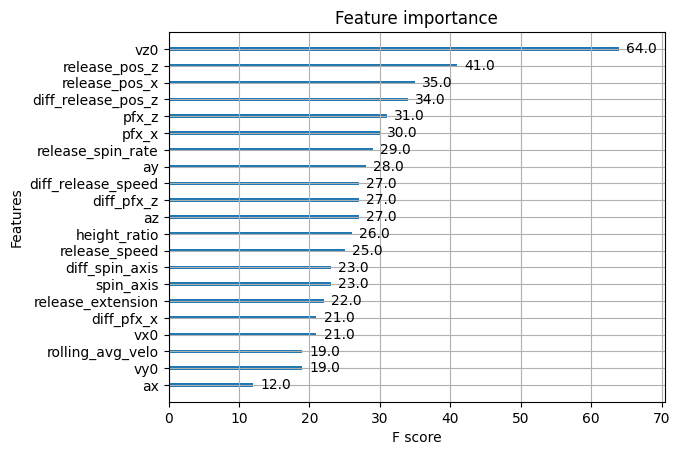

In [13]:
xgb.plot_importance(model)
plt.show()

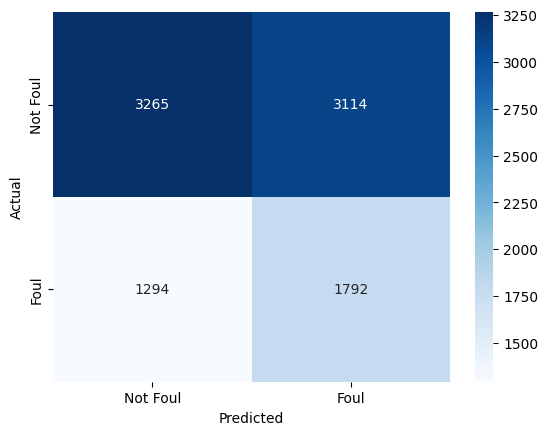

In [14]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [15]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [16]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 16:01:35,260] A new study created in memory with name: no-name-d79fe6ab-87a7-4052-bd20-a1eb8fdb48fb


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69178


[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68810
[8]	eval-logloss:0.68778
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68672
[12]	eval-logloss:0.68668
[13]	eval-logloss:0.68625
[14]	eval-logloss:0.68667
[15]	eval-logloss:0.68619
[16]	eval-logloss:0.68627
[17]	eval-logloss:0.68531
[18]	eval-logloss:0.68542
[19]	eval-logloss:0.68502
[20]	eval-logloss:0.68507
[21]	eval-logloss:0.68543
[22]	eval-logloss:0.68497
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68503
[25]	eval-logloss:0.68628
[26]	eval-logloss:0.68593
[27]	eval-logloss:0.68556
[28]	eval-logloss:0.68537
[29]	eval-logloss:0.68600
[30]	eval-logloss:0.68555
[31]	eval-logloss:0.68603
[32]	eval-logloss:0.68591
[33]	eval-logloss:0.68618
[34]	eval-logloss:0.68595
[35]	eval-logloss:0.68561
[36]	eval-logloss:0.68540
[37]	eval-logloss:0.68587
[38]	eval-logloss:0.68580
[39]	eval-logloss:0.68512
[40]	eval-logloss:0.68571
[41]	eval-logloss:0.68584
[42]	eval-logloss:0.68554
[43]	eval-logloss:0.68541
[44]	eval-loglos

[I 2023-11-16 16:01:35,992] Trial 0 finished with value: 0.6866411868471475 and parameters: {'max_depth': 5, 'eta': 0.2230734845828602, 'subsample': 0.7368594305051115, 'colsample_bytree': 0.519561818209159}. Best is trial 0 with value: 0.6866411868471475.


[0]	eval-logloss:0.69311
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69146
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69070
[9]	eval-logloss:0.69053
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69026
[12]	eval-logloss:0.69011
[13]	eval-logloss:0.68994
[14]	eval-logloss:0.68991


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68967
[17]	eval-logloss:0.68945
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68916
[20]	eval-logloss:0.68901
[21]	eval-logloss:0.68883
[22]	eval-logloss:0.68873
[23]	eval-logloss:0.68859
[24]	eval-logloss:0.68854
[25]	eval-logloss:0.68844
[26]	eval-logloss:0.68828
[27]	eval-logloss:0.68814
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68798
[31]	eval-logloss:0.68786
[32]	eval-logloss:0.68785
[33]	eval-logloss:0.68772
[34]	eval-logloss:0.68767
[35]	eval-logloss:0.68749
[36]	eval-logloss:0.68734
[37]	eval-logloss:0.68733
[38]	eval-logloss:0.68725
[39]	eval-logloss:0.68706
[40]	eval-logloss:0.68701
[41]	eval-logloss:0.68697
[42]	eval-logloss:0.68687
[43]	eval-logloss:0.68688
[44]	eval-logloss:0.68680
[45]	eval-logloss:0.68680
[46]	eval-logloss:0.68679
[47]	eval-logloss:0.68674
[48]	eval-logloss:0.68668
[49]	eval-logloss:0.68670
[50]	eval-logloss:0.68669
[51]	eval-logloss:0.68662
[52]	eval-logloss:0.68657
[53]	eval-lo

[I 2023-11-16 16:01:36,747] Trial 1 finished with value: 0.6847439826224574 and parameters: {'max_depth': 3, 'eta': 0.04011938944530204, 'subsample': 0.8532755856982894, 'colsample_bytree': 0.9372106741980955}. Best is trial 1 with value: 0.6847439826224574.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68657
[5]	eval-logloss:0.68564
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68449
[9]	eval-logloss:0.68420
[10]	eval-logloss:0.68464


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68408
[13]	eval-logloss:0.68405
[14]	eval-logloss:0.68364
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68205
[20]	eval-logloss:0.68191
[21]	eval-logloss:0.68155
[22]	eval-logloss:0.68109
[23]	eval-logloss:0.68131
[24]	eval-logloss:0.68133
[25]	eval-logloss:0.68201
[26]	eval-logloss:0.68180
[27]	eval-logloss:0.68153
[28]	eval-logloss:0.68186
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68189
[31]	eval-logloss:0.68192
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68146
[34]	eval-logloss:0.68119
[35]	eval-logloss:0.68111
[36]	eval-logloss:0.68099
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68106
[39]	eval-logloss:0.68083
[40]	eval-logloss:0.68111
[41]	eval-logloss:0.68138
[42]	eval-logloss:0.68150
[43]	eval-logloss:0.68162
[44]	eval-logloss:0.68124
[45]	eval-logloss:0.68151
[46]	eval-logloss:0.68186
[47]	eval-logloss:0.68204
[48]	eval-logloss:0.68154
[49]	eval-lo

[I 2023-11-16 16:01:37,609] Trial 2 finished with value: 0.6829909531307823 and parameters: {'max_depth': 6, 'eta': 0.1633770804415093, 'subsample': 0.7669585790971089, 'colsample_bytree': 0.9452046334470843}. Best is trial 2 with value: 0.6829909531307823.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68476


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68263
[6]	eval-logloss:0.68182
[7]	eval-logloss:0.68074
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67984
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67926
[13]	eval-logloss:0.67979
[14]	eval-logloss:0.67926
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67892
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67833
[19]	eval-logloss:0.67782
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67826
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67812
[24]	eval-logloss:0.67798
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67791
[29]	eval-logloss:0.67774
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67693
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67674
[37]	eval-logloss:0.67688
[38]	eval-logloss:0.67703
[39]	eval-logloss:0.67653
[40]	eval-logloss:0.67687
[41]	eval-logloss:0.67704
[42]	eval-logloss:

[I 2023-11-16 16:01:38,982] Trial 3 finished with value: 0.6814063823466374 and parameters: {'max_depth': 8, 'eta': 0.12981677349023338, 'subsample': 0.632263547904824, 'colsample_bytree': 0.9443903676969916}. Best is trial 3 with value: 0.6814063823466374.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68821
[8]	eval-logloss:0.68738
[9]	eval-logloss:0.68798
[10]	eval-logloss:0.68808
[11]	eval-logloss:0.68762
[12]	eval-logloss:0.68766
[13]	eval-logloss:0.68804
[14]	eval-logloss:0.68778
[15]	eval-logloss:0.68714
[16]	eval-logloss:0.68714
[17]	eval-logloss:0.68606


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.68619
[19]	eval-logloss:0.68630
[20]	eval-logloss:0.68603
[21]	eval-logloss:0.68643
[22]	eval-logloss:0.68628
[23]	eval-logloss:0.68600
[24]	eval-logloss:0.68626
[25]	eval-logloss:0.68650
[26]	eval-logloss:0.68668
[27]	eval-logloss:0.68580
[28]	eval-logloss:0.68484
[29]	eval-logloss:0.68523
[30]	eval-logloss:0.68471
[31]	eval-logloss:0.68495
[32]	eval-logloss:0.68453
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68517
[35]	eval-logloss:0.68518
[36]	eval-logloss:0.68536
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68588
[39]	eval-logloss:0.68492
[40]	eval-logloss:0.68557
[41]	eval-logloss:0.68601
[42]	eval-logloss:0.68586
[43]	eval-logloss:0.68509
[44]	eval-logloss:0.68530
[45]	eval-logloss:0.68509
[46]	eval-logloss:0.68573
[47]	eval-logloss:0.68658
[48]	eval-logloss:0.68601
[49]	eval-logloss:0.68523
[50]	eval-logloss:0.68598
[51]	eval-logloss:0.68546
[52]	eval-logloss:0.68544
[53]	eval-logloss:0.68465
[54]	eval-logloss:0.68412
[55]	eval-logloss:0.68429
[56]	eval-lo

[I 2023-11-16 16:01:39,594] Trial 4 finished with value: 0.688438157600478 and parameters: {'max_depth': 3, 'eta': 0.27808061869327966, 'subsample': 0.6156688011524034, 'colsample_bytree': 0.5510865508169434}. Best is trial 3 with value: 0.6814063823466374.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68907


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68375
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68353
[12]	eval-logloss:0.68304
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68277
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68204
[19]	eval-logloss:0.68120
[20]	eval-logloss:0.68043
[21]	eval-logloss:0.68023
[22]	eval-logloss:0.68039
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.68066
[25]	eval-logloss:0.68053
[26]	eval-logloss:0.68024
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68053
[29]	eval-logloss:0.68087
[30]	eval-logloss:0.68122
[31]	eval-logloss:0.68140
[32]	eval-logloss:0.68195
[33]	eval-logloss:0.68180
[34]	eval-logloss:0.68131
[35]	eval-logloss:0.68156
[36]	eval-logloss:0.68158
[37]	eval-logloss:0.68226
[38]	eval-logloss:0.68252
[39]	eval-logloss:0.68239
[40]	eval-logloss:0.68277
[41]	eval-logloss:0.68254
[42]	eval-logloss:0.68298
[43]	eval-logloss:0.68307
[44]	eval-loglos

[I 2023-11-16 16:01:40,508] Trial 5 finished with value: 0.6833927695246239 and parameters: {'max_depth': 8, 'eta': 0.17995339270743982, 'subsample': 0.8813972333000026, 'colsample_bytree': 0.6059883757762441}. Best is trial 3 with value: 0.6814063823466374.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68932
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68729
[9]	eval-logloss:0.68710
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68693
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68593
[14]	eval-logloss:0.68603
[15]	eval-logloss:0.68579
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68488
[19]	eval-logloss:0.68461
[20]	eval-logloss:0.68446
[21]	eval-logloss:0.68495
[22]	eval-logloss:0.68446
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68437
[25]	eval-logloss:0.68463
[26]	eval-logloss:0.68392
[27]	eval-logloss:0.68387
[28]	eval-logloss:0.68383
[29]	eval-logloss:0.68447
[30]	eval-logloss:0.68427
[31]	eval-logloss:0.68436
[32]	eval-logloss:0.68442
[33]	eval-logloss:0.68430
[34]	eval-logloss:0.68406
[35]	eval-logloss:0.68357
[36]	eval-logloss:0.68370
[37]	eval-logloss:0.68438
[38]	eval-logloss:0.68469
[39]	eval-logloss:0.68393
[40]	eval-logloss:0.68484
[41]	eval-logloss:0.68494
[42]	eval-logloss:0.68493
[43]	eval-logloss:0.68503
[44]	eval-loglos

[I 2023-11-16 16:01:41,305] Trial 6 finished with value: 0.6860421457888025 and parameters: {'max_depth': 5, 'eta': 0.24827745898350914, 'subsample': 0.8128165064943758, 'colsample_bytree': 0.5581429154195783}. Best is trial 3 with value: 0.6814063823466374.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68924
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68514


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68115
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.68010
[22]	eval-logloss:0.67959
[23]	eval-logloss:0.67945
[24]	eval-logloss:0.67956
[25]	eval-logloss:0.67966
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.67908
[31]	eval-logloss:0.67915
[32]	eval-logloss:0.67888
[33]	eval-logloss:0.67905
[34]	eval-logloss:0.67913
[35]	eval-logloss:0.67908
[36]	eval-logloss:0.67920
[37]	eval-logloss:0.67933
[38]	eval-logloss:0.67951
[39]	eval-logloss:0.67929
[40]	eval-logloss:0.67953
[41]	eval-logloss:0.67942
[42]	eval-logloss:0.67960
[43]	eval-logloss:0.67932
[44]	eval-logloss:0.67965
[45]	eval-logloss:0.67911
[46]	eval-logl

[I 2023-11-16 16:01:42,291] Trial 7 finished with value: 0.6779306786052602 and parameters: {'max_depth': 7, 'eta': 0.10642247846855236, 'subsample': 0.6539088696787091, 'colsample_bytree': 0.7152131917274056}. Best is trial 7 with value: 0.6779306786052602.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68602
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68475
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68428
[13]	eval-logloss:0.68457


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.68437
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68384
[18]	eval-logloss:0.68380
[19]	eval-logloss:0.68351
[20]	eval-logloss:0.68313
[21]	eval-logloss:0.68326
[22]	eval-logloss:0.68306
[23]	eval-logloss:0.68296
[24]	eval-logloss:0.68315
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68385
[27]	eval-logloss:0.68317
[28]	eval-logloss:0.68269
[29]	eval-logloss:0.68288
[30]	eval-logloss:0.68262
[31]	eval-logloss:0.68258
[32]	eval-logloss:0.68214
[33]	eval-logloss:0.68230
[34]	eval-logloss:0.68233
[35]	eval-logloss:0.68195
[36]	eval-logloss:0.68205
[37]	eval-logloss:0.68269
[38]	eval-logloss:0.68228
[39]	eval-logloss:0.68174
[40]	eval-logloss:0.68240
[41]	eval-logloss:0.68257
[42]	eval-logloss:0.68252
[43]	eval-logloss:0.68221
[44]	eval-logloss:0.68239
[45]	eval-logloss:0.68256
[46]	eval-logloss:0.68284
[47]	eval-logloss:0.68352
[48]	eval-logloss:0.68293
[49]	eval-logloss:0.68238
[50]	eval-logloss:0.68305
[51]	eval-logloss:0.68277
[52]	eval-lo

[I 2023-11-16 16:01:43,074] Trial 8 finished with value: 0.6845441276081526 and parameters: {'max_depth': 4, 'eta': 0.18020705296055908, 'subsample': 0.6280514095350564, 'colsample_bytree': 0.7703184151440159}. Best is trial 7 with value: 0.6779306786052602.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.69007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68651
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68564
[10]	eval-logloss:0.68519
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68425
[13]	eval-logloss:0.68403
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68387
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68255
[20]	eval-logloss:0.68242
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68178
[23]	eval-logloss:0.68148
[24]	eval-logloss:0.68143
[25]	eval-logloss:0.68147
[26]	eval-logloss:0.68136
[27]	eval-logloss:0.68112
[28]	eval-logloss:0.68094
[29]	eval-logloss:0.68098
[30]	eval-logloss:0.68090
[31]	eval-logloss:0.68080
[32]	eval-logloss:0.68075
[33]	eval-logloss:0.68047
[34]	eval-logloss:0.68043
[35]	eval-logloss:0.68037
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.68041
[38]	eval-logloss:0.68023
[39]	eval-logloss:0.68005
[40]	eval-logloss:0.67998
[41]	eval-logloss:0

[I 2023-11-16 16:01:44,186] Trial 9 finished with value: 0.6778340096577292 and parameters: {'max_depth': 6, 'eta': 0.0729039929712436, 'subsample': 0.8282132811701108, 'colsample_bytree': 0.9902542929540241}. Best is trial 9 with value: 0.6778340096577292.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69082
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69040
[11]	eval-logloss:0.69010
[12]	eval-logloss:0.68981
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68931
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68893
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68856
[19]	eval-logloss:0.68827
[20]	eval-logloss:0.68805
[21]	eval-logloss:0.68779
[22]	eval-logloss:0.68751
[23]	eval-logloss:0.68724
[24]	eval-logloss:0.68696
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68645
[27]	eval-logloss:0.68620
[28]	eval-logloss:0.68594
[29]	eval-logloss:0.68588
[30]	eval-logloss:0.68567
[31]	eval-logloss:0.68548
[32]	eval-logloss:0.68528
[33]	eval-logloss:0.68507
[34]	eval-logloss:0.68485
[35]	eval-logloss:0.68467
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68424
[38]	eval-logloss:0.68403
[39]	eval-logloss:0.68379
[40]	eval-logloss:0.

[I 2023-11-16 16:01:46,182] Trial 10 finished with value: 0.6768046281377487 and parameters: {'max_depth': 9, 'eta': 0.01317076778257055, 'subsample': 0.8908017202678146, 'colsample_bytree': 0.8418277117815627}. Best is trial 10 with value: 0.6768046281377487.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69187
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69068
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69033
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68940
[14]	eval-logloss:0.68922
[15]	eval-logloss:0.68904
[16]	eval-logloss:0.68871
[17]	eval-logloss:0.68836
[18]	eval-logloss:0.68831
[19]	eval-logloss:0.68800
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68754
[22]	eval-logloss:0.68728
[23]	eval-logloss:0.68705
[24]	eval-logloss:0.68686
[25]	eval-logloss:0.68664
[26]	eval-logloss:0.68637
[27]	eval-logloss:0.68612
[28]	eval-logloss:0.68586
[29]	eval-logloss:0.68579
[30]	eval-logloss:0.68555
[31]	eval-logloss:0.68528
[32]	eval-logloss:0.68508
[33]	eval-logloss:0.68484
[34]	eval-logloss:0.68461
[35]	eval-logloss:0.68436
[36]	eval-logloss:0.68420
[37]	eval-logloss:0.68401
[38]	eval-logloss:0.68385
[39]	eval-logloss:0.68365
[40]	eval-logloss:0.

[I 2023-11-16 16:01:48,402] Trial 11 finished with value: 0.6771098453834891 and parameters: {'max_depth': 9, 'eta': 0.012438074042896596, 'subsample': 0.8803038026776867, 'colsample_bytree': 0.8728846704202591}. Best is trial 10 with value: 0.6768046281377487.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69117
[9]	eval-logloss:0.69101
[10]	eval-logloss:0.69083
[11]	eval-logloss:0.69058
[12]	eval-logloss:0.69033
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68976
[16]	eval-logloss:0.68950
[17]	eval-logloss:0.68926
[18]	eval-logloss:0.68919
[19]	eval-logloss:0.68894
[20]	eval-logloss:0.68868
[21]	eval-logloss:0.68846
[22]	eval-logloss:0.68827
[23]	eval-logloss:0.68803
[24]	eval-logloss:0.68783
[25]	eval-logloss:0.68767
[26]	eval-logloss:0.68745
[27]	eval-logloss:0.68723
[28]	eval-logloss:0.68700
[29]	eval-logloss:0.68686
[30]	eval-logloss:0.68669
[31]	eval-logloss:0.68645
[32]	eval-logloss:0.68626
[33]	eval-logloss:0.68610
[34]	eval-logloss:0.68590
[35]	eval-logloss:0.68571
[36]	eval-logloss:0.68558
[37]	eval-logloss:0.68534
[38]	eval-logloss:0.68517
[39]	eval-logloss:0.68494
[40]	eval-logloss:0.68481
[41]	eval-logloss:0

[I 2023-11-16 16:01:50,388] Trial 12 finished with value: 0.6784021253919948 and parameters: {'max_depth': 9, 'eta': 0.010782673682840822, 'subsample': 0.8948220212552971, 'colsample_bytree': 0.8546940267409282}. Best is trial 10 with value: 0.6768046281377487.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69112
[6]	eval-logloss:0.69074
[7]	eval-logloss:0.69035
[8]	eval-logloss:0.68997
[9]	eval-logloss:0.68972
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68885
[12]	eval-logloss:0.68844
[13]	eval-logloss:0.68805
[14]	eval-logloss:0.68770
[15]	eval-logloss:0.68749
[16]	eval-logloss:0.68702
[17]	eval-logloss:0.68672
[18]	eval-logloss:0.68665
[19]	eval-logloss:0.68624
[20]	eval-logloss:0.68587
[21]	eval-logloss:0.68558
[22]	eval-logloss:0.68527
[23]	eval-logloss:0.68499
[24]	eval-logloss:0.68468
[25]	eval-logloss:0.68447
[26]	eval-logloss:0.68417
[27]	eval-logloss:0.68378
[28]	eval-logloss:0.68342
[29]	eval-logloss:0.68329
[30]	eval-logloss:0.68303
[31]	eval-logloss:0.68279
[32]	eval-logloss:0.68251
[33]	eval-logloss:0.68226
[34]	eval-logloss:0.68201
[35]	eval-logloss:0.68183
[36]	eval-logloss:0.68164
[37]	eval-logloss:0.68151
[38]	eval-logloss:0.68123
[39]	eval-logloss:0.68103
[40]	eval-logloss:0.

[I 2023-11-16 16:01:52,457] Trial 13 finished with value: 0.6746114970761211 and parameters: {'max_depth': 9, 'eta': 0.020054923681391522, 'subsample': 0.887232832531727, 'colsample_bytree': 0.8440811485973654}. Best is trial 13 with value: 0.6746114970761211.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68991


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68476
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68377
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68285
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68177
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67931
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67729
[28]	eval-logloss:0.67677
[29]	eval-logloss:0.67667
[30]	eval-logloss:0.67664
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67624
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67527
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67507
[38]	eval-logloss:0.67483
[39]	eval-logloss:0.67459
[40]	eval-logloss:0.67448
[41]	eval-logloss:0.67448
[42]	eval-logloss:

[I 2023-11-16 16:01:53,764] Trial 14 finished with value: 0.6699094546927601 and parameters: {'max_depth': 8, 'eta': 0.06907796894369132, 'subsample': 0.8981351039044567, 'colsample_bytree': 0.8009843254454706}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.69033


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68643
[8]	eval-logloss:0.68559
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68399
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68035
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67916
[26]	eval-logloss:0.67883
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67840
[29]	eval-logloss:0.67834
[30]	eval-logloss:0.67811
[31]	eval-logloss:0.67794
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67694
[36]	eval-logloss:0.67683
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67671
[39]	eval-logloss:0.67622
[40]	eval-logloss:0.67616
[41]	eval-logloss:0.67627
[42]	eval-logloss:

[I 2023-11-16 16:01:55,308] Trial 15 finished with value: 0.6734956140248896 and parameters: {'max_depth': 8, 'eta': 0.07777471036038128, 'subsample': 0.8432211648801912, 'colsample_bytree': 0.7693688194664838}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68896


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68685
[8]	eval-logloss:0.68598
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68482
[12]	eval-logloss:0.68433
[13]	eval-logloss:0.68392
[14]	eval-logloss:0.68384
[15]	eval-logloss:0.68375
[16]	eval-logloss:0.68344
[17]	eval-logloss:0.68245
[18]	eval-logloss:0.68216
[19]	eval-logloss:0.68183
[20]	eval-logloss:0.68166
[21]	eval-logloss:0.68144
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68049
[24]	eval-logloss:0.68031
[25]	eval-logloss:0.68046
[26]	eval-logloss:0.68005
[27]	eval-logloss:0.67960
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67959
[30]	eval-logloss:0.67943
[31]	eval-logloss:0.67940
[32]	eval-logloss:0.67930
[33]	eval-logloss:0.67897
[34]	eval-logloss:0.67882
[35]	eval-logloss:0.67848
[36]	eval-logloss:0.67833
[37]	eval-logloss:0.67831
[38]	eval-logloss:0.67816
[39]	eval-logloss:0.67771
[40]	eval-logloss:0.67786
[41]	eval-logloss:0.67792
[42]	eval-logloss:0.67780
[43]	eval-logloss:0.67771
[44]	eval-loglos

[I 2023-11-16 16:01:56,373] Trial 16 finished with value: 0.6748753070897096 and parameters: {'max_depth': 7, 'eta': 0.07597761609608229, 'subsample': 0.841483712414889, 'colsample_bytree': 0.7350519096905817}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69160
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69110


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68884
[8]	eval-logloss:0.68794
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68759
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68616
[13]	eval-logloss:0.68577
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68548
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68447
[18]	eval-logloss:0.68425
[19]	eval-logloss:0.68397
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68337
[22]	eval-logloss:0.68277
[23]	eval-logloss:0.68241
[24]	eval-logloss:0.68238
[25]	eval-logloss:0.68257
[26]	eval-logloss:0.68222
[27]	eval-logloss:0.68203
[28]	eval-logloss:0.68171
[29]	eval-logloss:0.68187
[30]	eval-logloss:0.68187
[31]	eval-logloss:0.68163
[32]	eval-logloss:0.68147
[33]	eval-logloss:0.68123
[34]	eval-logloss:0.68117
[35]	eval-logloss:0.68106
[36]	eval-logloss:0.68098
[37]	eval-logloss:0.68080
[38]	eval-logloss:0.68058
[39]	eval-logloss:0.68014
[40]	eval-logloss:0.68009
[41]	eval-logloss:0.68019
[42]	eval-logloss:0.68028
[43]	eval-logloss:0.68009
[44]	eval-loglos

[I 2023-11-16 16:01:57,576] Trial 17 finished with value: 0.6774972877789203 and parameters: {'max_depth': 7, 'eta': 0.06866131749427953, 'subsample': 0.7976882087262935, 'colsample_bytree': 0.6709682324760283}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68275
[12]	eval-logloss:0.68249
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68081
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68040
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68005
[21]	eval-logloss:0.67997
[22]	eval-logloss:0.67967
[23]	eval-logloss:0.67940
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67957
[26]	eval-logloss:0.67919
[27]	eval-logloss:0.67901
[28]	eval-logloss:0.67917
[29]	eval-logloss:0.67907
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67869
[32]	eval-logloss:0.67848
[33]	eval-logloss:0.67847
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67811
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67789
[38]	eval-logloss:0.67795
[39]	eval-logloss:0.67794
[40]	eval-logloss:0.67767
[41]	eval-logloss:0.67765
[42]	eval-logloss:0.67755
[43]	eval-logloss

[I 2023-11-16 16:01:58,790] Trial 18 finished with value: 0.6762466640301337 and parameters: {'max_depth': 8, 'eta': 0.11166388904031008, 'subsample': 0.8519731971140064, 'colsample_bytree': 0.8098612516820249}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68745
[9]	eval-logloss:0.68708
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68578
[13]	eval-logloss:0.68533
[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68500
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68368
[18]	eval-logloss:0.68346
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68253
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68152
[23]	eval-logloss:0.68116
[24]	eval-logloss:0.68089
[25]	eval-logloss:0.68076
[26]	eval-logloss:0.68041
[27]	eval-logloss:0.68019
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67998
[30]	eval-logloss:0.67964
[31]	eval-logloss:0.67934
[32]	eval-logloss:0.67922
[33]	eval-logloss:0.67903
[34]	eval-logloss:0.67896
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67856
[37]	eval-logloss:0.67852
[38]	eval-logloss:0.67822
[39]	eval-logloss:0.67786
[40]	eval-logloss:0.67762
[41]	eval-logloss:0

[I 2023-11-16 16:02:00,153] Trial 19 finished with value: 0.6742996823323216 and parameters: {'max_depth': 8, 'eta': 0.05038353009943676, 'subsample': 0.7852845967428994, 'colsample_bytree': 0.7756187119420576}. Best is trial 14 with value: 0.6699094546927601.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69062
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68807
[8]	eval-logloss:0.68716
[9]	eval-logloss:0.68701
[10]	eval-logloss:0.68715
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68506
[14]	eval-logloss:0.68518
[15]	eval-logloss:0.68498
[16]	eval-logloss:0.68448
[17]	eval-logloss:0.68377
[18]	eval-logloss:0.68369
[19]	eval-logloss:0.68322
[20]	eval-logloss:0.68315
[21]	eval-logloss:0.68285
[22]	eval-logloss:0.68239
[23]	eval-logloss:0.68212
[24]	eval-logloss:0.68221
[25]	eval-logloss:0.68218
[26]	eval-logloss:0.68174
[27]	eval-logloss:0.68178
[28]	eval-logloss:0.68181
[29]	eval-logloss:0.68192
[30]	eval-logloss:0.68181
[31]	eval-logloss:0.68165
[32]	eval-logloss:0.68171
[33]	eval-logloss:0.68097
[34]	eval-logloss:0.68086
[35]	eval-logloss:0.68067
[36]	eval-logloss:0.68069
[37]	eval-logloss:0.68074
[38]	eval-logloss:0.68

[I 2023-11-16 16:02:01,369] Trial 20 finished with value: 0.6781710248918156 and parameters: {'max_depth': 7, 'eta': 0.0949905117707534, 'subsample': 0.8601085047805332, 'colsample_bytree': 0.6698260336239318}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69103
[3]	eval-logloss:0.69066


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68782
[7]	eval-logloss:0.68694
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68469
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68350
[15]	eval-logloss:0.68325
[16]	eval-logloss:0.68278
[17]	eval-logloss:0.68225
[18]	eval-logloss:0.68202
[19]	eval-logloss:0.68176
[20]	eval-logloss:0.68138
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.68020
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.68012
[26]	eval-logloss:0.67974
[27]	eval-logloss:0.67944
[28]	eval-logloss:0.67917
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67887
[31]	eval-logloss:0.67869
[32]	eval-logloss:0.67866
[33]	eval-logloss:0.67844
[34]	eval-logloss:0.67842
[35]	eval-logloss:0.67825
[36]	eval-logloss:0.67813
[37]	eval-logloss:0.67798
[38]	eval-logloss:0.67795
[39]	eval-logloss:0.67767
[40]	eval-logloss:0.67761
[41]	eval-logloss:0.67765
[42]	eval-logloss:

[I 2023-11-16 16:02:02,684] Trial 21 finished with value: 0.6739870301118277 and parameters: {'max_depth': 8, 'eta': 0.07043288049858402, 'subsample': 0.8004320047881273, 'colsample_bytree': 0.7892839907951525}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68906


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68871
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68595
[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68356
[10]	eval-logloss:0.68383
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.68056
[21]	eval-logloss:0.68036
[22]	eval-logloss:0.68006
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.68026
[26]	eval-logloss:0.68017
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.68035
[29]	eval-logloss:0.68048
[30]	eval-logloss:0.68051
[31]	eval-logloss:0.68067
[32]	eval-logloss:0.68074
[33]	eval-logloss:0.68043
[34]	eval-logloss:0.68045
[35]	eval-logloss:0.67981
[36]	eval-logloss:0.67969
[37]	eval-logloss:0.67994
[38]	eval-logloss:0.67995
[39]	eval-logloss:0.67956
[40]	eval-logloss:0.67982
[41]	eval-logloss:0

[I 2023-11-16 16:02:04,011] Trial 22 finished with value: 0.6807984066717933 and parameters: {'max_depth': 8, 'eta': 0.13088841804963605, 'subsample': 0.8272095435596601, 'colsample_bytree': 0.7922304889047674}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69022
[7]	eval-logloss:0.68971


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68918
[9]	eval-logloss:0.68884
[10]	eval-logloss:0.68865
[11]	eval-logloss:0.68807
[12]	eval-logloss:0.68775
[13]	eval-logloss:0.68738
[14]	eval-logloss:0.68737
[15]	eval-logloss:0.68723
[16]	eval-logloss:0.68677
[17]	eval-logloss:0.68643
[18]	eval-logloss:0.68629
[19]	eval-logloss:0.68603
[20]	eval-logloss:0.68579
[21]	eval-logloss:0.68553
[22]	eval-logloss:0.68519
[23]	eval-logloss:0.68498
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68481
[26]	eval-logloss:0.68451
[27]	eval-logloss:0.68422
[28]	eval-logloss:0.68395
[29]	eval-logloss:0.68400
[30]	eval-logloss:0.68373
[31]	eval-logloss:0.68352
[32]	eval-logloss:0.68340
[33]	eval-logloss:0.68318
[34]	eval-logloss:0.68306
[35]	eval-logloss:0.68281
[36]	eval-logloss:0.68272
[37]	eval-logloss:0.68262
[38]	eval-logloss:0.68241
[39]	eval-logloss:0.68213
[40]	eval-logloss:0.68204
[41]	eval-logloss:0.68202
[42]	eval-logloss:0.68193
[43]	eval-logloss:0.68179
[44]	eval-logloss:0.68165
[45]	eval-logloss:0.68172
[46]	eval-logl

[I 2023-11-16 16:02:04,946] Trial 23 finished with value: 0.6791935734560943 and parameters: {'max_depth': 6, 'eta': 0.04450672578488203, 'subsample': 0.810884871702694, 'colsample_bytree': 0.7296265602018703}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68014
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67794
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67755
[27]	eval-logloss:0.67731
[28]	eval-logloss:0.67715
[29]	eval-logloss:0.67699
[30]	eval-logloss:0.67690
[31]	eval-logloss:0.67666
[32]	eval-logloss:0.67623
[33]	eval-logloss:0.67584
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67542
[38]	eval-logloss:0.67545
[39]	eval-logloss:0.67528
[40]	eval-logloss:0.67521
[41]	eval-logloss:0

[I 2023-11-16 16:02:06,361] Trial 24 finished with value: 0.6716966494237124 and parameters: {'max_depth': 8, 'eta': 0.08339654807017444, 'subsample': 0.857601969243229, 'colsample_bytree': 0.8045172153305254}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68609
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68377
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68315
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68300
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68200
[18]	eval-logloss:0.68207
[19]	eval-logloss:0.68181
[20]	eval-logloss:0.68140
[21]	eval-logloss:0.68101
[22]	eval-logloss:0.68057
[23]	eval-logloss:0.68015
[24]	eval-logloss:0.68010
[25]	eval-logloss:0.67989
[26]	eval-logloss:0.67965
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67950
[29]	eval-logloss:0.67941
[30]	eval-logloss:0.67935
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67917
[33]	eval-logloss:0.67915
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67864
[36]	eval-logloss:0.67833
[37]	eval-logloss:0.67837
[38]	eval-logloss:0.67834
[39]	eval-logloss:0.67827
[40]	eval-logloss:0.67817
[41]	eval-logloss:0.67815
[42]	eval-logloss:

[I 2023-11-16 16:02:07,466] Trial 25 finished with value: 0.6761015098404376 and parameters: {'max_depth': 7, 'eta': 0.09235958861391688, 'subsample': 0.8997219422239041, 'colsample_bytree': 0.8913022872460481}. Best is trial 14 with value: 0.6699094546927601.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69050
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68591
[9]	eval-logloss:0.68539
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68424
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68191
[17]	eval-logloss:0.68131
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.67981
[22]	eval-logloss:0.67934
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67873
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67831
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67740
[29]	eval-logloss:0.67730
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67666
[32]	eval-logloss:0.67643
[33]	eval-logloss:0.67616
[34]	eval-logloss:0.67593
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67527
[39]	eval-logloss:0.67498
[40]	eval-logloss:0.

[I 2023-11-16 16:02:09,200] Trial 26 finished with value: 0.6694115912987932 and parameters: {'max_depth': 9, 'eta': 0.048690169396069384, 'subsample': 0.8628488140750421, 'colsample_bytree': 0.810558993291707}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68906
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68663
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68585
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68439
[13]	eval-logloss:0.68382
[14]	eval-logloss:0.68357
[15]	eval-logloss:0.68339
[16]	eval-logloss:0.68296
[17]	eval-logloss:0.68231
[18]	eval-logloss:0.68197
[19]	eval-logloss:0.68151
[20]	eval-logloss:0.68088
[21]	eval-logloss:0.68055
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67942
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67892
[26]	eval-logloss:0.67868
[27]	eval-logloss:0.67850
[28]	eval-logloss:0.67816
[29]	eval-logloss:0.67811
[30]	eval-logloss:0.67785
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67731
[33]	eval-logloss:0.67716
[34]	eval-logloss:0.67689
[35]	eval-logloss:0.67677
[36]	eval-logloss:0.67648
[37]	eval-logloss:0.67640
[38]	eval-logloss:0.67607
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:11,059] Trial 27 finished with value: 0.6702683126600901 and parameters: {'max_depth': 9, 'eta': 0.039975254884387794, 'subsample': 0.8631994964557838, 'colsample_bytree': 0.8153201435647973}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69076
[4]	eval-logloss:0.69015
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68727
[9]	eval-logloss:0.68674
[10]	eval-logloss:0.68648
[11]	eval-logloss:0.68568
[12]	eval-logloss:0.68506
[13]	eval-logloss:0.68455
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68378
[16]	eval-logloss:0.68333
[17]	eval-logloss:0.68278
[18]	eval-logloss:0.68247
[19]	eval-logloss:0.68192
[20]	eval-logloss:0.68160
[21]	eval-logloss:0.68117
[22]	eval-logloss:0.68061
[23]	eval-logloss:0.68012
[24]	eval-logloss:0.67980
[25]	eval-logloss:0.67948
[26]	eval-logloss:0.67924
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67855
[29]	eval-logloss:0.67853
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67812
[32]	eval-logloss:0.67795
[33]	eval-logloss:0.67750
[34]	eval-logloss:0.67724
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67686
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67637
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:12,829] Trial 28 finished with value: 0.6708641682337831 and parameters: {'max_depth': 9, 'eta': 0.035345851994219885, 'subsample': 0.863821332477476, 'colsample_bytree': 0.8277993285769819}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68545
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68322
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67768
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67681
[25]	eval-logloss:0.67666
[26]	eval-logloss:0.67635
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67556
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67523
[34]	eval-logloss:0.67503
[35]	eval-logloss:0.67474
[36]	eval-logloss:0.67458
[37]	eval-logloss:0.67452
[38]	eval-logloss:0.67460
[39]	eval-logloss:0.67441
[40]	eval-logloss:0.

[I 2023-11-16 16:02:14,682] Trial 29 finished with value: 0.6700759491221074 and parameters: {'max_depth': 9, 'eta': 0.061571841945840936, 'subsample': 0.7430887866638918, 'colsample_bytree': 0.8862263370393445}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67768
[23]	eval-logloss:0.67740
[24]	eval-logloss:0.67719
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67675
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67607
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67543
[33]	eval-logloss:0.67542
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67448
[39]	eval-logloss:0.67411
[40]	eval-logloss:0.

[I 2023-11-16 16:02:16,483] Trial 30 finished with value: 0.6707151220040651 and parameters: {'max_depth': 9, 'eta': 0.056889294012930997, 'subsample': 0.7462338184489037, 'colsample_bytree': 0.8923075483546997}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69103
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68790
[8]	eval-logloss:0.68716
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68630
[11]	eval-logloss:0.68561
[12]	eval-logloss:0.68514
[13]	eval-logloss:0.68457
[14]	eval-logloss:0.68422
[15]	eval-logloss:0.68379
[16]	eval-logloss:0.68328
[17]	eval-logloss:0.68235
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68088
[21]	eval-logloss:0.68049
[22]	eval-logloss:0.67994
[23]	eval-logloss:0.67935
[24]	eval-logloss:0.67893
[25]	eval-logloss:0.67893
[26]	eval-logloss:0.67854
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67765
[29]	eval-logloss:0.67779
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67651
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67539
[37]	eval-logloss:0.67518
[38]	eval-logloss:0.67482
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:18,354] Trial 31 finished with value: 0.6696037430489512 and parameters: {'max_depth': 9, 'eta': 0.03278262642801347, 'subsample': 0.7052294622699827, 'colsample_bytree': 0.817016828551514}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69063
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68712
[6]	eval-logloss:0.68603
[7]	eval-logloss:0.68512
[8]	eval-logloss:0.68436
[9]	eval-logloss:0.68383
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68167
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67986
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67837
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67733
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67685
[26]	eval-logloss:0.67651
[27]	eval-logloss:0.67634
[28]	eval-logloss:0.67594
[29]	eval-logloss:0.67604
[30]	eval-logloss:0.67575
[31]	eval-logloss:0.67551
[32]	eval-logloss:0.67552
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67510
[35]	eval-logloss:0.67467
[36]	eval-logloss:0.67446
[37]	eval-logloss:0.67440
[38]	eval-logloss:0.67431
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:20,234] Trial 32 finished with value: 0.6701424347588205 and parameters: {'max_depth': 9, 'eta': 0.05641585151236597, 'subsample': 0.7056625973578959, 'colsample_bytree': 0.8708272385865934}. Best is trial 26 with value: 0.6694115912987932.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69153


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68793
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68655
[9]	eval-logloss:0.68605
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68518
[12]	eval-logloss:0.68476
[13]	eval-logloss:0.68424
[14]	eval-logloss:0.68396
[15]	eval-logloss:0.68374
[16]	eval-logloss:0.68326
[17]	eval-logloss:0.68255
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68166
[20]	eval-logloss:0.68124
[21]	eval-logloss:0.68100
[22]	eval-logloss:0.68039
[23]	eval-logloss:0.67998
[24]	eval-logloss:0.67961
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67868
[28]	eval-logloss:0.67840
[29]	eval-logloss:0.67838
[30]	eval-logloss:0.67805
[31]	eval-logloss:0.67785
[32]	eval-logloss:0.67756
[33]	eval-logloss:0.67730
[34]	eval-logloss:0.67701
[35]	eval-logloss:0.67665
[36]	eval-logloss:0.67634
[37]	eval-logloss:0.67629
[38]	eval-logloss:0.67601
[39]	eval-logloss:0.67565
[40]	eval-logloss:0.

[I 2023-11-16 16:02:22,006] Trial 33 finished with value: 0.6693371138734359 and parameters: {'max_depth': 9, 'eta': 0.031793739027007245, 'subsample': 0.7280879146169316, 'colsample_bytree': 0.901168850516403}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68899
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68670
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68595
[11]	eval-logloss:0.68549
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68436
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68387
[17]	eval-logloss:0.68325
[18]	eval-logloss:0.68301
[19]	eval-logloss:0.68258
[20]	eval-logloss:0.68220
[21]	eval-logloss:0.68178
[22]	eval-logloss:0.68133
[23]	eval-logloss:0.68100
[24]	eval-logloss:0.68063
[25]	eval-logloss:0.68059
[26]	eval-logloss:0.68014
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67945
[29]	eval-logloss:0.67938
[30]	eval-logloss:0.67912
[31]	eval-logloss:0.67898
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67850
[34]	eval-logloss:0.67820
[35]	eval-logloss:0.67787
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67738
[38]	eval-logloss:0.67709
[39]	eval-logloss:0.67681
[40]	eval-logloss:0.

[I 2023-11-16 16:02:24,131] Trial 34 finished with value: 0.6704464377562738 and parameters: {'max_depth': 9, 'eta': 0.030667399359877928, 'subsample': 0.7241248565574119, 'colsample_bytree': 0.9138830018115337}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69095
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68863
[8]	eval-logloss:0.68792
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68733
[11]	eval-logloss:0.68662
[12]	eval-logloss:0.68621
[13]	eval-logloss:0.68566
[14]	eval-logloss:0.68560
[15]	eval-logloss:0.68540
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68450
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68386
[20]	eval-logloss:0.68344
[21]	eval-logloss:0.68313
[22]	eval-logloss:0.68273
[23]	eval-logloss:0.68248
[24]	eval-logloss:0.68218
[25]	eval-logloss:0.68186
[26]	eval-logloss:0.68146
[27]	eval-logloss:0.68118
[28]	eval-logloss:0.68093
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68058
[31]	eval-logloss:0.68033
[32]	eval-logloss:0.67992
[33]	eval-logloss:0.67963
[34]	eval-logloss:0.67943
[35]	eval-logloss:0.67909
[36]	eval-logloss:0.67881
[37]	eval-logloss:0.67864
[38]	eval-logloss:0.67833
[39]	eval-logloss:0.67793
[40]	eval-logloss:0.67775
[41]	eval-logloss:0.67776
[42]	eval-logloss:

[I 2023-11-16 16:02:25,565] Trial 35 finished with value: 0.6731057192890078 and parameters: {'max_depth': 8, 'eta': 0.03575690565132222, 'subsample': 0.7652977260540511, 'colsample_bytree': 0.837002829880462}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69185


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68851
[7]	eval-logloss:0.68791
[8]	eval-logloss:0.68737
[9]	eval-logloss:0.68701
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68630
[12]	eval-logloss:0.68574
[13]	eval-logloss:0.68523
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68467
[16]	eval-logloss:0.68407
[17]	eval-logloss:0.68356
[18]	eval-logloss:0.68336
[19]	eval-logloss:0.68272
[20]	eval-logloss:0.68237
[21]	eval-logloss:0.68190
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68099
[24]	eval-logloss:0.68065
[25]	eval-logloss:0.68039
[26]	eval-logloss:0.68004
[27]	eval-logloss:0.67961
[28]	eval-logloss:0.67933
[29]	eval-logloss:0.67934
[30]	eval-logloss:0.67894
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67844
[34]	eval-logloss:0.67817
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67747
[37]	eval-logloss:0.67720
[38]	eval-logloss:0.67692
[39]	eval-logloss:0.67669
[40]	eval-logloss:0.

[I 2023-11-16 16:02:27,548] Trial 36 finished with value: 0.6708391455632913 and parameters: {'max_depth': 9, 'eta': 0.029605728404399442, 'subsample': 0.6980212978663899, 'colsample_bytree': 0.9248643145583064}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69085


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69054
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68773
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68655
[9]	eval-logloss:0.68623
[10]	eval-logloss:0.68606
[11]	eval-logloss:0.68545
[12]	eval-logloss:0.68494
[13]	eval-logloss:0.68435
[14]	eval-logloss:0.68431
[15]	eval-logloss:0.68405
[16]	eval-logloss:0.68351
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68201
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68081
[23]	eval-logloss:0.68024
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.67980
[26]	eval-logloss:0.67939
[27]	eval-logloss:0.67919
[28]	eval-logloss:0.67889
[29]	eval-logloss:0.67895
[30]	eval-logloss:0.67868
[31]	eval-logloss:0.67840
[32]	eval-logloss:0.67811
[33]	eval-logloss:0.67803
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67760
[37]	eval-logloss:0.67758
[38]	eval-logloss:0.67739
[39]	eval-logloss:0.67712
[40]	eval-logloss:0.67693
[41]	eval-logloss:0

[I 2023-11-16 16:02:28,932] Trial 37 finished with value: 0.672901651591755 and parameters: {'max_depth': 8, 'eta': 0.05345376705493188, 'subsample': 0.7650559430698654, 'colsample_bytree': 0.8591610767824455}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69141
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69075


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.69067
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69020
[12]	eval-logloss:0.68994
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68964
[15]	eval-logloss:0.68953
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68895
[18]	eval-logloss:0.68887
[19]	eval-logloss:0.68854
[20]	eval-logloss:0.68833
[21]	eval-logloss:0.68812
[22]	eval-logloss:0.68786
[23]	eval-logloss:0.68768
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68739
[26]	eval-logloss:0.68725
[27]	eval-logloss:0.68710
[28]	eval-logloss:0.68692
[29]	eval-logloss:0.68690
[30]	eval-logloss:0.68672
[31]	eval-logloss:0.68660
[32]	eval-logloss:0.68643
[33]	eval-logloss:0.68629
[34]	eval-logloss:0.68614
[35]	eval-logloss:0.68591
[36]	eval-logloss:0.68574
[37]	eval-logloss:0.68573
[38]	eval-logloss:0.68553
[39]	eval-logloss:0.68530
[40]	eval-logloss:0.68533
[41]	eval-logloss:0.68531
[42]	eval-logloss:0.68517
[43]	eval-logloss:0.68505
[44]	eval-logloss:0.68496
[45]	eval-logloss:0.68492
[46]	eval-logloss:0.68486
[47]	eval-log

[I 2023-11-16 16:02:30,064] Trial 38 finished with value: 0.6819166595329406 and parameters: {'max_depth': 5, 'eta': 0.026676403995879942, 'subsample': 0.6781862065711332, 'colsample_bytree': 0.8199049620311327}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68745
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68557
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68400
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68309
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68200
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68101
[20]	eval-logloss:0.68074
[21]	eval-logloss:0.68053
[22]	eval-logloss:0.68000
[23]	eval-logloss:0.67971
[24]	eval-logloss:0.67928
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67886
[27]	eval-logloss:0.67850
[28]	eval-logloss:0.67825
[29]	eval-logloss:0.67818
[30]	eval-logloss:0.67788
[31]	eval-logloss:0.67771
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67710
[35]	eval-logloss:0.67683
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67627
[39]	eval-logloss:0.67594
[40]	eval-logloss:0.67600
[41]	eval-logloss:0

[I 2023-11-16 16:02:31,461] Trial 39 finished with value: 0.6702283194693425 and parameters: {'max_depth': 8, 'eta': 0.04638344623087125, 'subsample': 0.7183121169121798, 'colsample_bytree': 0.9047195697485941}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69174
[7]	eval-logloss:0.69153
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69085


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.69070
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69063
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69024
[18]	eval-logloss:0.69017
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68986
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68955
[23]	eval-logloss:0.68939
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68895
[27]	eval-logloss:0.68883
[28]	eval-logloss:0.68870
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68851
[31]	eval-logloss:0.68843
[32]	eval-logloss:0.68833
[33]	eval-logloss:0.68821
[34]	eval-logloss:0.68811
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68782
[38]	eval-logloss:0.68770
[39]	eval-logloss:0.68757
[40]	eval-logloss:0.68751
[41]	eval-logloss:0.68738
[42]	eval-logloss:0.68729
[43]	eval-logloss:0.68722
[44]	eval-logloss:0.68714
[45]	eval-logloss:0.68704
[46]	eval-logloss:0.68701
[47]	eval-logloss:0.68695
[48]	eval-logloss:0.68685
[49]	eval-logloss:0.68686
[50]	eval-logloss:0.68679
[51]	eval-lo

[I 2023-11-16 16:02:32,184] Trial 40 finished with value: 0.6845221715311671 and parameters: {'max_depth': 4, 'eta': 0.023646586270563236, 'subsample': 0.8755718010087914, 'colsample_bytree': 0.9489629193809143}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68775
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68047
[15]	eval-logloss:0.68020
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67904
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67727
[23]	eval-logloss:0.67715
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67645
[27]	eval-logloss:0.67617
[28]	eval-logloss:0.67576
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67535
[31]	eval-logloss:0.67526
[32]	eval-logloss:0.67517
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67470
[36]	eval-logloss:0.67441
[37]	eval-logloss:0.67446
[38]	eval-logloss:0.67455
[39]	eval-logloss:0.67430
[40]	eval-logloss:0.67438
[41]	eval-logloss:0.67443
[42]	eval-logloss:

[I 2023-11-16 16:02:33,942] Trial 41 finished with value: 0.6718967467094246 and parameters: {'max_depth': 9, 'eta': 0.06212505179798633, 'subsample': 0.7432610126073254, 'colsample_bytree': 0.8710002676094482}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68633
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68059
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67881
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67651
[25]	eval-logloss:0.67638
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67581
[28]	eval-logloss:0.67563
[29]	eval-logloss:0.67574
[30]	eval-logloss:0.67530
[31]	eval-logloss:0.67515
[32]	eval-logloss:0.67465
[33]	eval-logloss:0.67436
[34]	eval-logloss:0.67382
[35]	eval-logloss:0.67335
[36]	eval-logloss:0.67316
[37]	eval-logloss:0.67303
[38]	eval-logloss:0.67280
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:35,782] Trial 42 finished with value: 0.6696078444229957 and parameters: {'max_depth': 9, 'eta': 0.059842479290178135, 'subsample': 0.7305146682263197, 'colsample_bytree': 0.8318792927817618}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68527
[10]	eval-logloss:0.68498
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68208
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68018
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67946
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67837
[24]	eval-logloss:0.67786
[25]	eval-logloss:0.67799
[26]	eval-logloss:0.67763
[27]	eval-logloss:0.67712
[28]	eval-logloss:0.67697
[29]	eval-logloss:0.67707
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67656
[32]	eval-logloss:0.67629
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67583
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67443
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:37,580] Trial 43 finished with value: 0.6698499581856887 and parameters: {'max_depth': 9, 'eta': 0.04899281110096307, 'subsample': 0.7275432463807866, 'colsample_bytree': 0.7571432101006996}. Best is trial 33 with value: 0.6693371138734359.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68733
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68577
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68303
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67841
[25]	eval-logloss:0.67813
[26]	eval-logloss:0.67776
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67715
[30]	eval-logloss:0.67680
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67624
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67537
[36]	eval-logloss:0.67509
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67485
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:39,510] Trial 44 finished with value: 0.6690666582319738 and parameters: {'max_depth': 9, 'eta': 0.0437721860416199, 'subsample': 0.7588637031353886, 'colsample_bytree': 0.8340305702116979}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69289


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69124
[5]	eval-logloss:0.69069
[6]	eval-logloss:0.69019
[7]	eval-logloss:0.68960
[8]	eval-logloss:0.68913
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68869
[11]	eval-logloss:0.68824
[12]	eval-logloss:0.68776
[13]	eval-logloss:0.68736
[14]	eval-logloss:0.68714
[15]	eval-logloss:0.68696
[16]	eval-logloss:0.68650
[17]	eval-logloss:0.68610
[18]	eval-logloss:0.68582
[19]	eval-logloss:0.68538
[20]	eval-logloss:0.68502
[21]	eval-logloss:0.68469
[22]	eval-logloss:0.68424
[23]	eval-logloss:0.68395
[24]	eval-logloss:0.68364
[25]	eval-logloss:0.68335
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68283
[28]	eval-logloss:0.68252
[29]	eval-logloss:0.68249
[30]	eval-logloss:0.68225
[31]	eval-logloss:0.68199
[32]	eval-logloss:0.68169
[33]	eval-logloss:0.68141
[34]	eval-logloss:0.68117
[35]	eval-logloss:0.68086
[36]	eval-logloss:0.68050
[37]	eval-logloss:0.68024
[38]	eval-logloss:0.68002
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:41,413] Trial 45 finished with value: 0.6723966591016963 and parameters: {'max_depth': 9, 'eta': 0.02211545955960685, 'subsample': 0.7566499048138371, 'colsample_bytree': 0.8448251163663915}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69149
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69026
[12]	eval-logloss:0.68993
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68956
[15]	eval-logloss:0.68947
[16]	eval-logloss:0.68927
[17]	eval-logloss:0.68896
[18]	eval-logloss:0.68879
[19]	eval-logloss:0.68852
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68805
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68755
[24]	eval-logloss:0.68733
[25]	eval-logloss:0.68710
[26]	eval-logloss:0.68687
[27]	eval-logloss:0.68665
[28]	eval-logloss:0.68641
[29]	eval-logloss:0.68631
[30]	eval-logloss:0.68617
[31]	eval-logloss:0.68594
[32]	eval-logloss:0.68570
[33]	eval-logloss:0.68550
[34]	eval-logloss:0.68524
[35]	eval-logloss:0.68498
[36]	eval-logloss:0.68476
[37]	eval-logloss:0.68462
[38]	eval-logloss:0.68442
[39]	eval-logloss:0.68420
[40]	eval-logloss:0.68404
[41]	eval-logloss:0

[I 2023-11-16 16:02:43,565] Trial 46 finished with value: 0.6774131529870122 and parameters: {'max_depth': 9, 'eta': 0.010747144672714835, 'subsample': 0.73116953719564, 'colsample_bytree': 0.820159721183429}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68785
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68597
[10]	eval-logloss:0.68577
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68409
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68232
[17]	eval-logloss:0.68149
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67854
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67775
[27]	eval-logloss:0.67745
[28]	eval-logloss:0.67701
[29]	eval-logloss:0.67694
[30]	eval-logloss:0.67658
[31]	eval-logloss:0.67646
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67598
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67452
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:45,292] Trial 47 finished with value: 0.66929235116465 and parameters: {'max_depth': 9, 'eta': 0.04004035132110656, 'subsample': 0.6808312502654589, 'colsample_bytree': 0.8580718244808069}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69131
[4]	eval-logloss:0.69101
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68941


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68865
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68812
[12]	eval-logloss:0.68766
[13]	eval-logloss:0.68743
[14]	eval-logloss:0.68721
[15]	eval-logloss:0.68701
[16]	eval-logloss:0.68669
[17]	eval-logloss:0.68624
[18]	eval-logloss:0.68617
[19]	eval-logloss:0.68573
[20]	eval-logloss:0.68542
[21]	eval-logloss:0.68507
[22]	eval-logloss:0.68472
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68431
[25]	eval-logloss:0.68423
[26]	eval-logloss:0.68390
[27]	eval-logloss:0.68378
[28]	eval-logloss:0.68362
[29]	eval-logloss:0.68361
[30]	eval-logloss:0.68338
[31]	eval-logloss:0.68329
[32]	eval-logloss:0.68299
[33]	eval-logloss:0.68280
[34]	eval-logloss:0.68255
[35]	eval-logloss:0.68224
[36]	eval-logloss:0.68205
[37]	eval-logloss:0.68214
[38]	eval-logloss:0.68207
[39]	eval-logloss:0.68182
[40]	eval-logloss:0.68178
[41]	eval-logloss:0.68173
[42]	eval-logloss:0.68162
[43]	eval-logloss:0.68152
[44]	eval-logloss:0.68146
[45]	eval-logloss:0.68129
[46]	eval-logl

[I 2023-11-16 16:02:46,470] Trial 48 finished with value: 0.6785564044488752 and parameters: {'max_depth': 6, 'eta': 0.03936030428617626, 'subsample': 0.6676661054327082, 'colsample_bytree': 0.8608642492735046}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69163
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69063
[9]	eval-logloss:0.69050
[10]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.69016
[12]	eval-logloss:0.69010
[13]	eval-logloss:0.68986
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68973
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68932
[18]	eval-logloss:0.68925
[19]	eval-logloss:0.68900
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68876
[22]	eval-logloss:0.68858
[23]	eval-logloss:0.68842
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68840
[26]	eval-logloss:0.68827
[27]	eval-logloss:0.68820
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68809
[30]	eval-logloss:0.68788
[31]	eval-logloss:0.68783
[32]	eval-logloss:0.68771
[33]	eval-logloss:0.68772
[34]	eval-logloss:0.68762
[35]	eval-logloss:0.68744
[36]	eval-logloss:0.68728
[37]	eval-logloss:0.68732
[38]	eval-logloss:0.68717
[39]	eval-logloss:0.68695
[40]	eval-logloss:0.68701
[41]	eval-logloss:0.68697
[42]	eval-logloss:0.68685
[43]	eval-logloss:0.68671
[44]	eval-logloss:0.68665
[45]	eval-logloss:0.68658
[46]	eval-logloss:0.68657
[47]	eval-logloss:0.68659
[48]	eval-logloss:0.68646
[49]	eval-lo

[I 2023-11-16 16:02:47,155] Trial 49 finished with value: 0.6842179720533531 and parameters: {'max_depth': 3, 'eta': 0.0371682066670301, 'subsample': 0.6956000808401225, 'colsample_bytree': 0.9531136216475109}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69037
[9]	eval-logloss:0.69017
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68965
[12]	eval-logloss:0.68937
[13]	eval-logloss:0.68907
[14]	eval-logloss:0.68891
[15]	eval-logloss:0.68864
[16]	eval-logloss:0.68825
[17]	eval-logloss:0.68791
[18]	eval-logloss:0.68770
[19]	eval-logloss:0.68743
[20]	eval-logloss:0.68717
[21]	eval-logloss:0.68692
[22]	eval-logloss:0.68666
[23]	eval-logloss:0.68634
[24]	eval-logloss:0.68601
[25]	eval-logloss:0.68575
[26]	eval-logloss:0.68546
[27]	eval-logloss:0.68521
[28]	eval-logloss:0.68492
[29]	eval-logloss:0.68488
[30]	eval-logloss:0.68461
[31]	eval-logloss:0.68439
[32]	eval-logloss:0.68413
[33]	eval-logloss:0.68393
[34]	eval-logloss:0.68370
[35]	eval-logloss:0.68346
[36]	eval-logloss:0.68328
[37]	eval-logloss:0.68315
[38]	eval-logloss:0.68295
[39]	eval-logloss:0.68273
[40]	eval-logloss:0.68265
[41]	eval-logloss:0

[I 2023-11-16 16:02:48,934] Trial 50 finished with value: 0.6768186016543346 and parameters: {'max_depth': 8, 'eta': 0.017960821546719186, 'subsample': 0.7779010008630528, 'colsample_bytree': 0.8488951459281336}. Best is trial 44 with value: 0.6690666582319738.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68356
[11]	eval-logloss:0.68274
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68059
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67677
[23]	eval-logloss:0.67640
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67558
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67463
[29]	eval-logloss:0.67483
[30]	eval-logloss:0.67448
[31]	eval-logloss:0.67450
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67413
[34]	eval-logloss:0.67395
[35]	eval-logloss:0.67347
[36]	eval-logloss:0.67312
[37]	eval-logloss:0.67317
[38]	eval-logloss:0.67299
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:50,704] Trial 51 finished with value: 0.6678273782572077 and parameters: {'max_depth': 9, 'eta': 0.06157359242715366, 'subsample': 0.7148615656623433, 'colsample_bytree': 0.8278626350420315}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69137
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.68991
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68863
[9]	eval-logloss:0.68823
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68694
[13]	eval-logloss:0.68659
[14]	eval-logloss:0.68632
[15]	eval-logloss:0.68611
[16]	eval-logloss:0.68562
[17]	eval-logloss:0.68495
[18]	eval-logloss:0.68464
[19]	eval-logloss:0.68413
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68328
[22]	eval-logloss:0.68285
[23]	eval-logloss:0.68256
[24]	eval-logloss:0.68225
[25]	eval-logloss:0.68220
[26]	eval-logloss:0.68190
[27]	eval-logloss:0.68143
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68112
[30]	eval-logloss:0.68095
[31]	eval-logloss:0.68070
[32]	eval-logloss:0.68041
[33]	eval-logloss:0.68004
[34]	eval-logloss:0.67966
[35]	eval-logloss:0.67939
[36]	eval-logloss:0.67906
[37]	eval-logloss:0.67887
[38]	eval-logloss:0.67864
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:52,744] Trial 52 finished with value: 0.6723298813437953 and parameters: {'max_depth': 9, 'eta': 0.025782718979410316, 'subsample': 0.7091895256274063, 'colsample_bytree': 0.7860139445304714}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68466
[11]	eval-logloss:0.68399
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68127
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67932
[21]	eval-logloss:0.67895
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67649
[28]	eval-logloss:0.67630
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67476
[36]	eval-logloss:0.67474
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67425
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:54,498] Trial 53 finished with value: 0.6700498312593719 and parameters: {'max_depth': 9, 'eta': 0.04707359550561141, 'subsample': 0.6871789254261162, 'colsample_bytree': 0.8833396232215694}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69155


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68849
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68389
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68209
[10]	eval-logloss:0.68157
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.68015
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67782
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67615
[21]	eval-logloss:0.67601
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67476
[24]	eval-logloss:0.67459
[25]	eval-logloss:0.67475
[26]	eval-logloss:0.67449
[27]	eval-logloss:0.67437
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67374
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67357
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67330
[35]	eval-logloss:0.67314
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67321
[38]	eval-logloss:0.67344
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:56,250] Trial 54 finished with value: 0.6740939206727492 and parameters: {'max_depth': 9, 'eta': 0.08756835373827858, 'subsample': 0.650326166669777, 'colsample_bytree': 0.8035801255267814}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68700
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68482
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68146
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68019
[22]	eval-logloss:0.67952
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67874
[25]	eval-logloss:0.67886
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67835
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67809
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67761
[32]	eval-logloss:0.67755
[33]	eval-logloss:0.67745
[34]	eval-logloss:0.67751
[35]	eval-logloss:0.67732
[36]	eval-logloss:0.67701
[37]	eval-logloss:0.67700
[38]	eval-logloss:0.67686
[39]	eval-logloss:0.67665
[40]	eval-logloss:0.67689
[41]	eval-logloss:0

[I 2023-11-16 16:02:57,661] Trial 55 finished with value: 0.6749218370933735 and parameters: {'max_depth': 8, 'eta': 0.07223654336584565, 'subsample': 0.7072051026561958, 'colsample_bytree': 0.8355822080029012}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69300


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69157
[7]	eval-logloss:0.69130
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69064
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69010
[13]	eval-logloss:0.68983
[14]	eval-logloss:0.68970
[15]	eval-logloss:0.68958
[16]	eval-logloss:0.68936
[17]	eval-logloss:0.68905
[18]	eval-logloss:0.68884
[19]	eval-logloss:0.68858
[20]	eval-logloss:0.68831
[21]	eval-logloss:0.68816
[22]	eval-logloss:0.68795
[23]	eval-logloss:0.68774
[24]	eval-logloss:0.68748
[25]	eval-logloss:0.68747
[26]	eval-logloss:0.68720
[27]	eval-logloss:0.68692
[28]	eval-logloss:0.68668
[29]	eval-logloss:0.68658
[30]	eval-logloss:0.68640
[31]	eval-logloss:0.68619
[32]	eval-logloss:0.68612
[33]	eval-logloss:0.68593
[34]	eval-logloss:0.68572
[35]	eval-logloss:0.68552
[36]	eval-logloss:0.68531
[37]	eval-logloss:0.68514
[38]	eval-logloss:0.68491
[39]	eval-logloss:0.6

[I 2023-11-16 16:02:59,766] Trial 56 finished with value: 0.6781327589162167 and parameters: {'max_depth': 9, 'eta': 0.010760962221723389, 'subsample': 0.7177659507497954, 'colsample_bytree': 0.7605110417814045}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68311
[14]	eval-logloss:0.68292
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68144
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68006
[22]	eval-logloss:0.67948
[23]	eval-logloss:0.67915
[24]	eval-logloss:0.67891
[25]	eval-logloss:0.67913
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67710
[33]	eval-logloss:0.67694
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67621
[37]	eval-logloss:0.67596
[38]	eval-logloss:0.67560
[39]	eval-logloss:0.67507
[40]	eval-logloss:0.67492
[41]	eval-logloss:0

[I 2023-11-16 16:03:01,282] Trial 57 finished with value: 0.6719948647578041 and parameters: {'max_depth': 8, 'eta': 0.06362122828396419, 'subsample': 0.7410757450112155, 'colsample_bytree': 0.778667306043803}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68942
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68756
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68692
[12]	eval-logloss:0.68641
[13]	eval-logloss:0.68609
[14]	eval-logloss:0.68601
[15]	eval-logloss:0.68582
[16]	eval-logloss:0.68539
[17]	eval-logloss:0.68492
[18]	eval-logloss:0.68484
[19]	eval-logloss:0.68434
[20]	eval-logloss:0.68393
[21]	eval-logloss:0.68363
[22]	eval-logloss:0.68306
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68248
[25]	eval-logloss:0.68246
[26]	eval-logloss:0.68218
[27]	eval-logloss:0.68200
[28]	eval-logloss:0.68163
[29]	eval-logloss:0.68169
[30]	eval-logloss:0.68133
[31]	eval-logloss:0.68128
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68092
[34]	eval-logloss:0.68070
[35]	eval-logloss:0.68059
[36]	eval-logloss:0.68043
[37]	eval-logloss:0.68036
[38]	eval-logloss:0.68020
[39]	eval-logloss:0.67998
[40]	eval-logloss:0.67985
[41]	eval-logloss:0.67998
[42]	eval-logloss:0.67982
[43]	eval-logloss:0.67980
[44]	eval-loglos

[I 2023-11-16 16:03:02,792] Trial 58 finished with value: 0.6757716390787034 and parameters: {'max_depth': 7, 'eta': 0.047091618220829065, 'subsample': 0.7505323932696438, 'colsample_bytree': 0.8622614588046671}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68500
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68270
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67861
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67733
[20]	eval-logloss:0.67676
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67599
[23]	eval-logloss:0.67550
[24]	eval-logloss:0.67514
[25]	eval-logloss:0.67531
[26]	eval-logloss:0.67512
[27]	eval-logloss:0.67491
[28]	eval-logloss:0.67473
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67451
[31]	eval-logloss:0.67444
[32]	eval-logloss:0.67412
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67379
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67333
[37]	eval-logloss:0.67345
[38]	eval-logloss:0.67320
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:04,448] Trial 59 finished with value: 0.6733154790083865 and parameters: {'max_depth': 9, 'eta': 0.08219997647408517, 'subsample': 0.682378655259883, 'colsample_bytree': 0.8002210186710917}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69187
[8]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.69154
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69122
[12]	eval-logloss:0.69107
[13]	eval-logloss:0.69085
[14]	eval-logloss:0.69081
[15]	eval-logloss:0.69074
[16]	eval-logloss:0.69060
[17]	eval-logloss:0.69036
[18]	eval-logloss:0.69028
[19]	eval-logloss:0.69009
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.68977
[22]	eval-logloss:0.68958
[23]	eval-logloss:0.68944
[24]	eval-logloss:0.68927
[25]	eval-logloss:0.68923
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68843
[33]	eval-logloss:0.68835
[34]	eval-logloss:0.68822
[35]	eval-logloss:0.68808
[36]	eval-logloss:0.68793
[37]	eval-logloss:0.68786
[38]	eval-logloss:0.68774
[39]	eval-logloss:0.68760
[40]	eval-logloss:0.68759
[41]	eval-logloss:0.68759
[42]	eval-logloss:0.68746
[43]	eval-logloss:0.68741
[44]	eval-logloss:0.68733
[45]	eval-logloss:0.68734
[46]	eval-logloss:0.68730
[47]	eval-log

[I 2023-11-16 16:03:05,211] Trial 60 finished with value: 0.6848432239412132 and parameters: {'max_depth': 4, 'eta': 0.021314837022322508, 'subsample': 0.7190852727549781, 'colsample_bytree': 0.8509627416525962}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68904


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68642
[7]	eval-logloss:0.68538
[8]	eval-logloss:0.68445
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68365
[11]	eval-logloss:0.68266
[12]	eval-logloss:0.68198
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68077
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67931
[19]	eval-logloss:0.67874
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67806
[22]	eval-logloss:0.67735
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67697
[25]	eval-logloss:0.67703
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67638
[28]	eval-logloss:0.67588
[29]	eval-logloss:0.67603
[30]	eval-logloss:0.67565
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67545
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67497
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67469
[37]	eval-logloss:0.67447
[38]	eval-logloss:0.67409
[39]	eval-logloss:0.67380
[40]	eval-logloss:0.67388
[41]	eval-logloss:0.67403
[42]	eval-logloss:0.67352
[43]	eval-logloss

[I 2023-11-16 16:03:07,084] Trial 61 finished with value: 0.6694363403996784 and parameters: {'max_depth': 9, 'eta': 0.06239617131422643, 'subsample': 0.7369338941077173, 'colsample_bytree': 0.8212649522435387}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69016


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68506
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68296
[9]	eval-logloss:0.68223
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68021
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67826
[18]	eval-logloss:0.67803
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67709
[21]	eval-logloss:0.67685
[22]	eval-logloss:0.67623
[23]	eval-logloss:0.67608
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67616
[26]	eval-logloss:0.67573
[27]	eval-logloss:0.67540
[28]	eval-logloss:0.67513
[29]	eval-logloss:0.67523
[30]	eval-logloss:0.67503
[31]	eval-logloss:0.67520
[32]	eval-logloss:0.67476
[33]	eval-logloss:0.67488
[34]	eval-logloss:0.67466
[35]	eval-logloss:0.67428
[36]	eval-logloss:0.67407
[37]	eval-logloss:0.67423
[38]	eval-logloss:0.67398
[39]	eval-logloss:0.67379
[40]	eval-logloss:0.

[I 2023-11-16 16:03:09,103] Trial 62 finished with value: 0.6711037051831877 and parameters: {'max_depth': 9, 'eta': 0.07361794313468889, 'subsample': 0.7318933425340562, 'colsample_bytree': 0.8247990180938166}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68874
[7]	eval-logloss:0.68784
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68697
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68616
[12]	eval-logloss:0.68553
[13]	eval-logloss:0.68509
[14]	eval-logloss:0.68482
[15]	eval-logloss:0.68458
[16]	eval-logloss:0.68405
[17]	eval-logloss:0.68344
[18]	eval-logloss:0.68303
[19]	eval-logloss:0.68250
[20]	eval-logloss:0.68219
[21]	eval-logloss:0.68171
[22]	eval-logloss:0.68129
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68051
[25]	eval-logloss:0.68048
[26]	eval-logloss:0.68019
[27]	eval-logloss:0.67978
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67942
[30]	eval-logloss:0.67914
[31]	eval-logloss:0.67896
[32]	eval-logloss:0.67868
[33]	eval-logloss:0.67838
[34]	eval-logloss:0.67813
[35]	eval-logloss:0.67784
[36]	eval-logloss:0.67756
[37]	eval-logloss:0.67737
[38]	eval-logloss:0.67710
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:10,904] Trial 63 finished with value: 0.6704465323517231 and parameters: {'max_depth': 9, 'eta': 0.035074010390880615, 'subsample': 0.756633755110144, 'colsample_bytree': 0.8115189821518093}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69127


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68616
[11]	eval-logloss:0.68544
[12]	eval-logloss:0.68497
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68394
[15]	eval-logloss:0.68378
[16]	eval-logloss:0.68329
[17]	eval-logloss:0.68285
[18]	eval-logloss:0.68257
[19]	eval-logloss:0.68232
[20]	eval-logloss:0.68178
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68073
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.67989
[26]	eval-logloss:0.67958
[27]	eval-logloss:0.67923
[28]	eval-logloss:0.67881
[29]	eval-logloss:0.67888
[30]	eval-logloss:0.67855
[31]	eval-logloss:0.67854
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67749
[36]	eval-logloss:0.67708
[37]	eval-logloss:0.67693
[38]	eval-logloss:0.67659
[39]	eval-logloss:0.67614
[40]	eval-logloss:0.

[I 2023-11-16 16:03:12,547] Trial 64 finished with value: 0.6729515691958577 and parameters: {'max_depth': 8, 'eta': 0.05314568741648058, 'subsample': 0.7384886565821202, 'colsample_bytree': 0.7877294097540501}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68933
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68362
[13]	eval-logloss:0.68308
[14]	eval-logloss:0.68285
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68117
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67928
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67783
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67728
[27]	eval-logloss:0.67692
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67663
[30]	eval-logloss:0.67632
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67582
[33]	eval-logloss:0.67558
[34]	eval-logloss:0.67539
[35]	eval-logloss:0.67505
[36]	eval-logloss:0.67485
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67434
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:14,407] Trial 65 finished with value: 0.6689848316903735 and parameters: {'max_depth': 9, 'eta': 0.041932828938239304, 'subsample': 0.711971872148949, 'colsample_bytree': 0.8377880075853299}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68456
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68295
[9]	eval-logloss:0.68266
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68128
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68041
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67854
[18]	eval-logloss:0.67835
[19]	eval-logloss:0.67778
[20]	eval-logloss:0.67721
[21]	eval-logloss:0.67680
[22]	eval-logloss:0.67649
[23]	eval-logloss:0.67587
[24]	eval-logloss:0.67571
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67531
[27]	eval-logloss:0.67510
[28]	eval-logloss:0.67498
[29]	eval-logloss:0.67515
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67511
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67485
[34]	eval-logloss:0.67470
[35]	eval-logloss:0.67468
[36]	eval-logloss:0.67438
[37]	eval-logloss:0.67429
[38]	eval-logloss:0.67412
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:16,436] Trial 66 finished with value: 0.6701156458808752 and parameters: {'max_depth': 9, 'eta': 0.06880127410607069, 'subsample': 0.7827782291199998, 'colsample_bytree': 0.8771840603552687}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68397
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68195
[9]	eval-logloss:0.68138
[10]	eval-logloss:0.68070
[11]	eval-logloss:0.67977
[12]	eval-logloss:0.67947
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67882
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67749
[18]	eval-logloss:0.67782
[19]	eval-logloss:0.67712
[20]	eval-logloss:0.67695
[21]	eval-logloss:0.67668
[22]	eval-logloss:0.67613
[23]	eval-logloss:0.67598
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67639
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67625
[28]	eval-logloss:0.67582
[29]	eval-logloss:0.67615
[30]	eval-logloss:0.67592
[31]	eval-logloss:0.67619
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67581
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67571
[38]	eval-logloss:0.67576
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:18,213] Trial 67 finished with value: 0.6761257270754857 and parameters: {'max_depth': 9, 'eta': 0.09919359176282558, 'subsample': 0.7159678920973376, 'colsample_bytree': 0.8456896056131064}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68727
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68485
[7]	eval-logloss:0.68411
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68336
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.68007
[21]	eval-logloss:0.67965
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67909
[24]	eval-logloss:0.67889
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67844
[27]	eval-logloss:0.67807
[28]	eval-logloss:0.67786
[29]	eval-logloss:0.67797
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67753
[32]	eval-logloss:0.67717
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67687
[37]	eval-logloss:0.67677
[38]	eval-logloss:0.67676
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:19,708] Trial 68 finished with value: 0.6759443097740054 and parameters: {'max_depth': 8, 'eta': 0.08092002161215302, 'subsample': 0.6950417587812734, 'colsample_bytree': 0.8995405390341111}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68406
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67893
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67835
[20]	eval-logloss:0.67808
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67627
[26]	eval-logloss:0.67591
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67532
[30]	eval-logloss:0.67501
[31]	eval-logloss:0.67479
[32]	eval-logloss:0.67463
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67430
[35]	eval-logloss:0.67395
[36]	eval-logloss:0.67383
[37]	eval-logloss:0.67364
[38]	eval-logloss:0.67368
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:21,638] Trial 69 finished with value: 0.6695243741990728 and parameters: {'max_depth': 9, 'eta': 0.05554688031725617, 'subsample': 0.8269944329273372, 'colsample_bytree': 0.8764337372764782}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69102
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68864
[7]	eval-logloss:0.68796
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68658
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68579
[12]	eval-logloss:0.68512
[13]	eval-logloss:0.68461
[14]	eval-logloss:0.68439
[15]	eval-logloss:0.68411
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68302
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68159
[22]	eval-logloss:0.68102
[23]	eval-logloss:0.68056
[24]	eval-logloss:0.68021
[25]	eval-logloss:0.68012
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67944
[28]	eval-logloss:0.67913
[29]	eval-logloss:0.67922
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67876
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67830
[34]	eval-logloss:0.67804
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67723
[38]	eval-logloss:0.67681
[39]	eval-logloss:0.67660
[40]	eval-logloss:0.67654
[41]	eval-logloss:0

[I 2023-11-16 16:03:23,079] Trial 70 finished with value: 0.6727271206594969 and parameters: {'max_depth': 8, 'eta': 0.043388716277401686, 'subsample': 0.7340503954154415, 'colsample_bytree': 0.8333176456956675}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68787
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68139
[15]	eval-logloss:0.68129
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.68007
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67856
[22]	eval-logloss:0.67795
[23]	eval-logloss:0.67743
[24]	eval-logloss:0.67713
[25]	eval-logloss:0.67675
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67626
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67617
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67559
[32]	eval-logloss:0.67546
[33]	eval-logloss:0.67519
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67479
[36]	eval-logloss:0.67463
[37]	eval-logloss:0.67428
[38]	eval-logloss:0.67413
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:25,015] Trial 71 finished with value: 0.6702489424990716 and parameters: {'max_depth': 9, 'eta': 0.05920551313347714, 'subsample': 0.8296697506564498, 'colsample_bytree': 0.862908309035719}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68323
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67895
[19]	eval-logloss:0.67840
[20]	eval-logloss:0.67807
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67740
[23]	eval-logloss:0.67700
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67641
[26]	eval-logloss:0.67612
[27]	eval-logloss:0.67589
[28]	eval-logloss:0.67558
[29]	eval-logloss:0.67563
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67498
[34]	eval-logloss:0.67456
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67417
[37]	eval-logloss:0.67409
[38]	eval-logloss:0.67398
[39]	eval-logloss:0.67384
[40]	eval-logloss:0.

[I 2023-11-16 16:03:26,893] Trial 72 finished with value: 0.669915354595027 and parameters: {'max_depth': 9, 'eta': 0.05308235483943494, 'subsample': 0.7240844249205306, 'colsample_bytree': 0.8801065827482388}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68954
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68700
[8]	eval-logloss:0.68630
[9]	eval-logloss:0.68587
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68345
[16]	eval-logloss:0.68283
[17]	eval-logloss:0.68240
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68156
[20]	eval-logloss:0.68108
[21]	eval-logloss:0.68062
[22]	eval-logloss:0.68024
[23]	eval-logloss:0.67984
[24]	eval-logloss:0.67959
[25]	eval-logloss:0.67932
[26]	eval-logloss:0.67899
[27]	eval-logloss:0.67868
[28]	eval-logloss:0.67828
[29]	eval-logloss:0.67816
[30]	eval-logloss:0.67794
[31]	eval-logloss:0.67771
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67736
[34]	eval-logloss:0.67717
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67644
[38]	eval-logloss:0.67623
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:28,884] Trial 73 finished with value: 0.6716174794588294 and parameters: {'max_depth': 9, 'eta': 0.04060822934134837, 'subsample': 0.8474035328329165, 'colsample_bytree': 0.9084164480063532}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68987
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68220
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68145
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.67992
[18]	eval-logloss:0.67958
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67887
[21]	eval-logloss:0.67833
[22]	eval-logloss:0.67806
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67688
[26]	eval-logloss:0.67661
[27]	eval-logloss:0.67641
[28]	eval-logloss:0.67603
[29]	eval-logloss:0.67590
[30]	eval-logloss:0.67570
[31]	eval-logloss:0.67558
[32]	eval-logloss:0.67530
[33]	eval-logloss:0.67493
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67473
[36]	eval-logloss:0.67450
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67414
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:30,599] Trial 74 finished with value: 0.6701196126463553 and parameters: {'max_depth': 9, 'eta': 0.06568046080794777, 'subsample': 0.8707255898322297, 'colsample_bytree': 0.8527340817051983}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68874
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68774
[9]	eval-logloss:0.68736
[10]	eval-logloss:0.68705
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68546
[14]	eval-logloss:0.68520
[15]	eval-logloss:0.68498
[16]	eval-logloss:0.68455
[17]	eval-logloss:0.68378
[18]	eval-logloss:0.68347
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68236
[21]	eval-logloss:0.68206
[22]	eval-logloss:0.68156
[23]	eval-logloss:0.68118
[24]	eval-logloss:0.68082
[25]	eval-logloss:0.68055
[26]	eval-logloss:0.68015
[27]	eval-logloss:0.67974
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67926
[30]	eval-logloss:0.67899
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67857
[33]	eval-logloss:0.67842
[34]	eval-logloss:0.67804
[35]	eval-logloss:0.67778
[36]	eval-logloss:0.67750
[37]	eval-logloss:0.67736
[38]	eval-logloss:0.67704
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:32,670] Trial 75 finished with value: 0.6711294103636157 and parameters: {'max_depth': 9, 'eta': 0.028994166424879727, 'subsample': 0.7128119634137494, 'colsample_bytree': 0.8855468080948792}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.69017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68275
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.68009
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67927
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67879
[23]	eval-logloss:0.67865
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67866
[26]	eval-logloss:0.67830
[27]	eval-logloss:0.67840
[28]	eval-logloss:0.67802
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67736
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67677
[35]	eval-logloss:0.67632
[36]	eval-logloss:0.67626
[37]	eval-logloss:0.67620
[38]	eval-logloss:0.67616
[39]	eval-logloss:0.67582
[40]	eval-logloss:0.67619
[41]	eval-logloss:0

[I 2023-11-16 16:03:34,017] Trial 76 finished with value: 0.6746773766255431 and parameters: {'max_depth': 8, 'eta': 0.07474365251216733, 'subsample': 0.7516400703281845, 'colsample_bytree': 0.8689371178437063}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69146
[6]	eval-logloss:0.69094
[7]	eval-logloss:0.69048
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68910
[12]	eval-logloss:0.68873
[13]	eval-logloss:0.68844
[14]	eval-logloss:0.68821
[15]	eval-logloss:0.68799
[16]	eval-logloss:0.68764
[17]	eval-logloss:0.68724
[18]	eval-logloss:0.68694
[19]	eval-logloss:0.68670
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68603
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68527
[24]	eval-logloss:0.68498
[25]	eval-logloss:0.68487
[26]	eval-logloss:0.68453
[27]	eval-logloss:0.68433
[28]	eval-logloss:0.68402
[29]	eval-logloss:0.68388
[30]	eval-logloss:0.68357
[31]	eval-logloss:0.68330
[32]	eval-logloss:0.68308
[33]	eval-logloss:0.68281
[34]	eval-logloss:0.68252
[35]	eval-logloss:0.68223
[36]	eval-logloss:0.68206
[37]	eval-logloss:0.68194
[38]	eval-logloss:0.68171
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:36,095] Trial 77 finished with value: 0.6741578489624186 and parameters: {'max_depth': 9, 'eta': 0.018251606342309823, 'subsample': 0.7927381228533764, 'colsample_bytree': 0.7983784762118382}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68555
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68257
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68110
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67898
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67805
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67734
[27]	eval-logloss:0.67703
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67667
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67527
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67452
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:37,921] Trial 78 finished with value: 0.6704389118037676 and parameters: {'max_depth': 9, 'eta': 0.05683095259119354, 'subsample': 0.8145456503032782, 'colsample_bytree': 0.8286453600862393}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68711
[7]	eval-logloss:0.68617
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68432
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68308
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68198
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68127
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67912
[22]	eval-logloss:0.67866
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67798
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67676
[29]	eval-logloss:0.67658
[30]	eval-logloss:0.67624
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67571
[33]	eval-logloss:0.67540
[34]	eval-logloss:0.67535
[35]	eval-logloss:0.67498
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67435
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:39,895] Trial 79 finished with value: 0.6691266103871769 and parameters: {'max_depth': 9, 'eta': 0.04547969292298662, 'subsample': 0.8868526248468293, 'colsample_bytree': 0.8960777429600998}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68808
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68659
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68588
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68464
[13]	eval-logloss:0.68423
[14]	eval-logloss:0.68391
[15]	eval-logloss:0.68358
[16]	eval-logloss:0.68321
[17]	eval-logloss:0.68267
[18]	eval-logloss:0.68255
[19]	eval-logloss:0.68222
[20]	eval-logloss:0.68190
[21]	eval-logloss:0.68139
[22]	eval-logloss:0.68106
[23]	eval-logloss:0.68070
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68039
[26]	eval-logloss:0.68012
[27]	eval-logloss:0.67990
[28]	eval-logloss:0.67979
[29]	eval-logloss:0.67988
[30]	eval-logloss:0.67971
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67953
[33]	eval-logloss:0.67933
[34]	eval-logloss:0.67910
[35]	eval-logloss:0.67888
[36]	eval-logloss:0.67882
[37]	eval-logloss:0.67867
[38]	eval-logloss:0.67857
[39]	eval-logloss:0.67830
[40]	eval-logloss:0.67826
[41]	eval-logloss:0

[I 2023-11-16 16:03:41,325] Trial 80 finished with value: 0.673652079463861 and parameters: {'max_depth': 8, 'eta': 0.04428029549347855, 'subsample': 0.8534804569671756, 'colsample_bytree': 0.9224458134646385}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69087
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68951
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68812
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68716
[11]	eval-logloss:0.68643
[12]	eval-logloss:0.68585
[13]	eval-logloss:0.68535
[14]	eval-logloss:0.68482
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68393
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68310
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68215
[21]	eval-logloss:0.68185
[22]	eval-logloss:0.68160
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68069
[25]	eval-logloss:0.68037
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67929
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67895
[31]	eval-logloss:0.67877
[32]	eval-logloss:0.67850
[33]	eval-logloss:0.67805
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67762
[36]	eval-logloss:0.67746
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67726
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:43,326] Trial 81 finished with value: 0.6713393656766583 and parameters: {'max_depth': 9, 'eta': 0.031904020609532895, 'subsample': 0.8862685406545557, 'colsample_bytree': 0.8406996978899086}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68801
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68667
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68398
[14]	eval-logloss:0.68352
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68270
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68204
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68107
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68033
[23]	eval-logloss:0.67992
[24]	eval-logloss:0.67960
[25]	eval-logloss:0.67920
[26]	eval-logloss:0.67888
[27]	eval-logloss:0.67850
[28]	eval-logloss:0.67821
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67792
[31]	eval-logloss:0.67770
[32]	eval-logloss:0.67754
[33]	eval-logloss:0.67711
[34]	eval-logloss:0.67692
[35]	eval-logloss:0.67670
[36]	eval-logloss:0.67659
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67636
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:45,123] Trial 82 finished with value: 0.6705510401304917 and parameters: {'max_depth': 9, 'eta': 0.03955678587580258, 'subsample': 0.8920488326947876, 'colsample_bytree': 0.8883431441320423}. Best is trial 51 with value: 0.6678273782572077.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68803
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68543
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68442
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68294
[13]	eval-logloss:0.68237
[14]	eval-logloss:0.68209
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68062
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67833
[24]	eval-logloss:0.67803
[25]	eval-logloss:0.67788
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67716
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67664
[34]	eval-logloss:0.67641
[35]	eval-logloss:0.67618
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67585
[38]	eval-logloss:0.67

[I 2023-11-16 16:03:47,127] Trial 83 finished with value: 0.6719861576939442 and parameters: {'max_depth': 9, 'eta': 0.05192398977695625, 'subsample': 0.8706910281462356, 'colsample_bytree': 0.9009142933036309}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69083


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68214
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.67969
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67879
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67689
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67580
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67545
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67514
[33]	eval-logloss:0.67479
[34]	eval-logloss:0.67454
[35]	eval-logloss:0.67425
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67403
[38]	eval-logloss:0.67386
[39]	eval-logloss:0.67365
[40]	eval-logloss:0.

[I 2023-11-16 16:03:48,806] Trial 84 finished with value: 0.6683734830501041 and parameters: {'max_depth': 9, 'eta': 0.06424608729645559, 'subsample': 0.8808539193717143, 'colsample_bytree': 0.8128057206088902}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68925


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68733
[6]	eval-logloss:0.68590
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68375
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68276
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67993
[15]	eval-logloss:0.67954
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67793
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67715
[20]	eval-logloss:0.67680
[21]	eval-logloss:0.67641
[22]	eval-logloss:0.67614
[23]	eval-logloss:0.67582
[24]	eval-logloss:0.67530
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67509
[28]	eval-logloss:0.67487
[29]	eval-logloss:0.67466
[30]	eval-logloss:0.67444
[31]	eval-logloss:0.67429
[32]	eval-logloss:0.67403
[33]	eval-logloss:0.67371
[34]	eval-logloss:0.67361
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67319
[37]	eval-logloss:0.67321
[38]	eval-logloss:0.67297
[39]	eval-logloss:0.67258
[40]	eval-logloss:0.67244
[41]	eval-logloss:0.67224
[42]	eval-logloss:

[I 2023-11-16 16:03:50,574] Trial 85 finished with value: 0.6690875542624489 and parameters: {'max_depth': 9, 'eta': 0.06457238935425387, 'subsample': 0.8659907789032654, 'colsample_bytree': 0.8156282053769571}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68331
[11]	eval-logloss:0.68243
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68131
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68015
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67729
[23]	eval-logloss:0.67698
[24]	eval-logloss:0.67692
[25]	eval-logloss:0.67666
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67606
[28]	eval-logloss:0.67569
[29]	eval-logloss:0.67567
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67495
[32]	eval-logloss:0.67464
[33]	eval-logloss:0.67439
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67375
[36]	eval-logloss:0.67341
[37]	eval-logloss:0.67311
[38]	eval-logloss:0.67285
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:52,444] Trial 86 finished with value: 0.6687209926425872 and parameters: {'max_depth': 9, 'eta': 0.06756887727421138, 'subsample': 0.8985563858367436, 'colsample_bytree': 0.7943833572516164}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68942


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68778
[10]	eval-logloss:0.68779
[11]	eval-logloss:0.68729
[12]	eval-logloss:0.68697
[13]	eval-logloss:0.68669
[14]	eval-logloss:0.68666
[15]	eval-logloss:0.68659
[16]	eval-logloss:0.68599
[17]	eval-logloss:0.68541
[18]	eval-logloss:0.68532
[19]	eval-logloss:0.68497
[20]	eval-logloss:0.68475
[21]	eval-logloss:0.68450
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68401
[24]	eval-logloss:0.68389
[25]	eval-logloss:0.68378
[26]	eval-logloss:0.68361
[27]	eval-logloss:0.68342
[28]	eval-logloss:0.68324
[29]	eval-logloss:0.68314
[30]	eval-logloss:0.68284
[31]	eval-logloss:0.68261
[32]	eval-logloss:0.68256
[33]	eval-logloss:0.68248
[34]	eval-logloss:0.68233
[35]	eval-logloss:0.68214
[36]	eval-logloss:0.68212
[37]	eval-logloss:0.68204
[38]	eval-logloss:0.68200
[39]	eval-logloss:0.68188
[40]	eval-logloss:0.68179
[41]	eval-logloss:0.68163
[42]	eval-logloss:0.68154
[43]	eval-logloss:0.68156
[44]	eval-logloss:0.68149
[45]	eval-loglo

[I 2023-11-16 16:03:53,421] Trial 87 finished with value: 0.6803517062561966 and parameters: {'max_depth': 5, 'eta': 0.08816186616142624, 'subsample': 0.8961664408592873, 'colsample_bytree': 0.7772968943541828}. Best is trial 51 with value: 0.6678273782572077.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68531
[8]	eval-logloss:0.68451
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68178
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.67955
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67747
[23]	eval-logloss:0.67713
[24]	eval-logloss:0.67679
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67606
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67559
[30]	eval-logloss:0.67545
[31]	eval-logloss:0.67510
[32]	eval-logloss:0.67506
[33]	eval-logloss:0.67488
[34]	eval-logloss:0.67472
[35]	eval-logloss:0.67442
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67

[I 2023-11-16 16:03:55,162] Trial 88 finished with value: 0.6699951812374553 and parameters: {'max_depth': 9, 'eta': 0.0666336826159337, 'subsample': 0.8828109852488749, 'colsample_bytree': 0.8098262702090074}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68428
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68263
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68134
[17]	eval-logloss:0.68060
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67882
[25]	eval-logloss:0.67881
[26]	eval-logloss:0.67852
[27]	eval-logloss:0.67800
[28]	eval-logloss:0.67773
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67754
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67714
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67661
[35]	eval-logloss:0.67651
[36]	eval-logloss:0.67625
[37]	eval-logloss:0.67605
[38]	eval-logloss:0.67576
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:56,683] Trial 89 finished with value: 0.671359922451466 and parameters: {'max_depth': 8, 'eta': 0.07661561910790082, 'subsample': 0.8893151628474488, 'colsample_bytree': 0.7982580514871966}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68921
[7]	eval-logloss:0.68845
[8]	eval-logloss:0.68781
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68658
[12]	eval-logloss:0.68600
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68498
[15]	eval-logloss:0.68471
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68342
[19]	eval-logloss:0.68276
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68211
[22]	eval-logloss:0.68170
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68054
[26]	eval-logloss:0.68006
[27]	eval-logloss:0.67987
[28]	eval-logloss:0.67952
[29]	eval-logloss:0.67950
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67894
[32]	eval-logloss:0.67874
[33]	eval-logloss:0.67836
[34]	eval-logloss:0.67806
[35]	eval-logloss:0.67781
[36]	eval-logloss:0.67753
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67722
[39]	eval-logloss:0.6

[I 2023-11-16 16:03:58,534] Trial 90 finished with value: 0.6713702401029159 and parameters: {'max_depth': 9, 'eta': 0.03182925527679174, 'subsample': 0.8732482639526805, 'colsample_bytree': 0.8552140677537082}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68793
[7]	eval-logloss:0.68709
[8]	eval-logloss:0.68629
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68516
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68313
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68246
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68080
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67870
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67806
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67766
[30]	eval-logloss:0.67730
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67681
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67611
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67564
[38]	eval-logloss:0.67548
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:00,510] Trial 91 finished with value: 0.6701628066390471 and parameters: {'max_depth': 9, 'eta': 0.04530608659706565, 'subsample': 0.8792021436124657, 'colsample_bytree': 0.8125539417274487}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68936
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68533
[9]	eval-logloss:0.68471
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68297
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68151
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.68007
[19]	eval-logloss:0.67943
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67778
[24]	eval-logloss:0.67744
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67705
[27]	eval-logloss:0.67668
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67580
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67514
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67474
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67443
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:02,204] Trial 92 finished with value: 0.6681641755554061 and parameters: {'max_depth': 9, 'eta': 0.05076061865221897, 'subsample': 0.8672367599151027, 'colsample_bytree': 0.8372941722178993}. Best is trial 51 with value: 0.6678273782572077.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.68995
[7]	eval-logloss:0.68936
[8]	eval-logloss:0.68875
[9]	eval-logloss:0.68848
[10]	eval-logloss:0.68822
[11]	eval-logloss:0.68767
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68679
[14]	eval-logloss:0.68645
[15]	eval-logloss:0.68624
[16]	eval-logloss:0.68580
[17]	eval-logloss:0.68542
[18]	eval-logloss:0.68528
[19]	eval-logloss:0.68474
[20]	eval-logloss:0.68434
[21]	eval-logloss:0.68392
[22]	eval-logloss:0.68371
[23]	eval-logloss:0.68341
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68283
[26]	eval-logloss:0.68251
[27]	eval-logloss:0.68220
[28]	eval-logloss:0.68184
[29]	eval-logloss:0.68178
[30]	eval-logloss:0.68149
[31]	eval-logloss:0.68129
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68073
[34]	eval-logloss:0.68047
[35]	eval-logloss:0.68033
[36]	eval-logloss:0.68005
[37]	eval-logloss:0.67984
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:04,321] Trial 93 finished with value: 0.6728469747788107 and parameters: {'max_depth': 9, 'eta': 0.025220493827343517, 'subsample': 0.8933538456049646, 'colsample_bytree': 0.8418134604014422}. Best is trial 51 with value: 0.6678273782572077.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68582
[7]	eval-logloss:0.68439
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68051
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.67979
[16]	eval-logloss:0.67905
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67695
[21]	eval-logloss:0.67646
[22]	eval-logloss:0.67620
[23]	eval-logloss:0.67550
[24]	eval-logloss:0.67501
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67450
[27]	eval-logloss:0.67399
[28]	eval-logloss:0.67368
[29]	eval-logloss:0.67369
[30]	eval-logloss:0.67320
[31]	eval-logloss:0.67320
[32]	eval-logloss:0.67293
[33]	eval-logloss:0.67294
[34]	eval-logloss:0.67279
[35]	eval-logloss:0.67264
[36]	eval-logloss:0.67256
[37]	eval-logloss:0.67229
[38]	eval-logloss:0.67199
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:06,061] Trial 94 finished with value: 0.666920922498015 and parameters: {'max_depth': 9, 'eta': 0.06800329799430281, 'subsample': 0.8996540019269385, 'colsample_bytree': 0.8291026225085063}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68880
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68122
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68024
[17]	eval-logloss:0.67950
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67869
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67754
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67587
[27]	eval-logloss:0.67553
[28]	eval-logloss:0.67518
[29]	eval-logloss:0.67532
[30]	eval-logloss:0.67500
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67471
[33]	eval-logloss:0.67458
[34]	eval-logloss:0.67436
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67408
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:08,027] Trial 95 finished with value: 0.6684164672373595 and parameters: {'max_depth': 9, 'eta': 0.06891553237984668, 'subsample': 0.8835555065512133, 'colsample_bytree': 0.8272068782824515}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68821
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68433
[8]	eval-logloss:0.68322
[9]	eval-logloss:0.68264
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68047
[14]	eval-logloss:0.68001
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.67912
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67671
[22]	eval-logloss:0.67660
[23]	eval-logloss:0.67594
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67530
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67470
[29]	eval-logloss:0.67469
[30]	eval-logloss:0.67439
[31]	eval-logloss:0.67420
[32]	eval-logloss:0.67409
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67373
[37]	eval-logloss:0.67363
[38]	eval-logloss:0.67325
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:09,949] Trial 96 finished with value: 0.6693408754213858 and parameters: {'max_depth': 9, 'eta': 0.06861396113429578, 'subsample': 0.8997234944419394, 'colsample_bytree': 0.8264894976497865}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68402
[8]	eval-logloss:0.68308
[9]	eval-logloss:0.68254
[10]	eval-logloss:0.68245
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.68000
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67802
[18]	eval-logloss:0.67803
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67704
[21]	eval-logloss:0.67670
[22]	eval-logloss:0.67617
[23]	eval-logloss:0.67559
[24]	eval-logloss:0.67553
[25]	eval-logloss:0.67571
[26]	eval-logloss:0.67526
[27]	eval-logloss:0.67523
[28]	eval-logloss:0.67477
[29]	eval-logloss:0.67456
[30]	eval-logloss:0.67455
[31]	eval-logloss:0.67450
[32]	eval-logloss:0.67443
[33]	eval-logloss:0.67406
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67311
[38]	eval-logloss:0.67300
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:11,622] Trial 97 finished with value: 0.6679096671207396 and parameters: {'max_depth': 9, 'eta': 0.07952663645783917, 'subsample': 0.8823384022046599, 'colsample_bytree': 0.7910637884269847}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68484
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68338
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68126
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67975
[23]	eval-logloss:0.67924
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67906
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67841
[29]	eval-logloss:0.67832
[30]	eval-logloss:0.67804
[31]	eval-logloss:0.67796
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67756
[34]	eval-logloss:0.67702
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67629
[38]	eval-logloss:0.67626
[39]	eval-logloss:0.67616
[40]	eval-logloss:0.67621
[41]	eval-logloss:0

[I 2023-11-16 16:04:13,248] Trial 98 finished with value: 0.6741580267436346 and parameters: {'max_depth': 8, 'eta': 0.08760438545626252, 'subsample': 0.8796913380670768, 'colsample_bytree': 0.7956505500331151}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68258
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68120
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.67979
[14]	eval-logloss:0.67944
[15]	eval-logloss:0.67882
[16]	eval-logloss:0.67828
[17]	eval-logloss:0.67747
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67664
[20]	eval-logloss:0.67640
[21]	eval-logloss:0.67573
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67511
[24]	eval-logloss:0.67508
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67440
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67365
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67344
[31]	eval-logloss:0.67325
[32]	eval-logloss:0.67321
[33]	eval-logloss:0.67305
[34]	eval-logloss:0.67298
[35]	eval-logloss:0.67275
[36]	eval-logloss:0.67257
[37]	eval-logloss:0.67237
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:15,016] Trial 99 finished with value: 0.6680146164416834 and parameters: {'max_depth': 9, 'eta': 0.07634606011561441, 'subsample': 0.8605522904514012, 'colsample_bytree': 0.7822237726391771}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68747


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68690
[9]	eval-logloss:0.68666
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68535
[14]	eval-logloss:0.68537
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68397
[18]	eval-logloss:0.68381
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68320
[21]	eval-logloss:0.68311
[22]	eval-logloss:0.68286
[23]	eval-logloss:0.68266
[24]	eval-logloss:0.68268
[25]	eval-logloss:0.68264
[26]	eval-logloss:0.68245
[27]	eval-logloss:0.68242
[28]	eval-logloss:0.68249
[29]	eval-logloss:0.68245
[30]	eval-logloss:0.68209
[31]	eval-logloss:0.68197
[32]	eval-logloss:0.68190
[33]	eval-logloss:0.68160
[34]	eval-logloss:0.68135
[35]	eval-logloss:0.68121
[36]	eval-logloss:0.68130
[37]	eval-logloss:0.68126
[38]	eval-logloss:0.68127
[39]	eval-logloss:0.68110
[40]	eval-logloss:0.68101
[41]	eval-logloss:0.68108
[42]	eval-logloss:0.68104
[43]	eval-logloss:0.68097
[44]	eval-logloss:0.68102
[45]	eval-logloss:0.68112
[46]	eval-logl

[I 2023-11-16 16:04:15,951] Trial 100 finished with value: 0.6804534115736532 and parameters: {'max_depth': 6, 'eta': 0.09677231456779904, 'subsample': 0.8813356233101391, 'colsample_bytree': 0.7898872425686019}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68439
[8]	eval-logloss:0.68344
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68117
[13]	eval-logloss:0.68074
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68044
[16]	eval-logloss:0.68016
[17]	eval-logloss:0.67904
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67805
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67653
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67580
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67556
[31]	eval-logloss:0.67545
[32]	eval-logloss:0.67527
[33]	eval-logloss:0.67524
[34]	eval-logloss:0.67510
[35]	eval-logloss:0.67481
[36]	eval-logloss:0.67456
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:17,808] Trial 101 finished with value: 0.6701610891011653 and parameters: {'max_depth': 9, 'eta': 0.07848871630892641, 'subsample': 0.8672910515125539, 'colsample_bytree': 0.7715563465513564}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69214


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68198
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68046
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67929
[18]	eval-logloss:0.67886
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67809
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67660
[24]	eval-logloss:0.67641
[25]	eval-logloss:0.67634
[26]	eval-logloss:0.67592
[27]	eval-logloss:0.67559
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67540
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67498
[32]	eval-logloss:0.67475
[33]	eval-logloss:0.67440
[34]	eval-logloss:0.67435
[35]	eval-logloss:0.67410
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67363
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:19,558] Trial 102 finished with value: 0.667551915299517 and parameters: {'max_depth': 9, 'eta': 0.061476283195304765, 'subsample': 0.8594699002935571, 'colsample_bytree': 0.8181139949054961}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68809


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68365
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.68004
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67870
[18]	eval-logloss:0.67841
[19]	eval-logloss:0.67788
[20]	eval-logloss:0.67758
[21]	eval-logloss:0.67717
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67634
[26]	eval-logloss:0.67612
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67515
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67472
[33]	eval-logloss:0.67454
[34]	eval-logloss:0.67456
[35]	eval-logloss:0.67436
[36]	eval-logloss:0.67424
[37]	eval-logloss:0.67409
[38]	eval-logloss:0.67408
[39]	eval-logloss:0.67377
[40]	eval-logloss:0.67334
[41]	eval-logloss:0.67340
[42]	eval-logloss:0.67345
[43]	eval-logloss

[I 2023-11-16 16:04:21,361] Trial 103 finished with value: 0.6680334421574385 and parameters: {'max_depth': 9, 'eta': 0.07207309724362682, 'subsample': 0.8590671456835062, 'colsample_bytree': 0.8049584202470584}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69204


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68148
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.67996
[15]	eval-logloss:0.67962
[16]	eval-logloss:0.67892
[17]	eval-logloss:0.67824
[18]	eval-logloss:0.67783
[19]	eval-logloss:0.67731
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67635
[22]	eval-logloss:0.67588
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67501
[25]	eval-logloss:0.67489
[26]	eval-logloss:0.67433
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67368
[29]	eval-logloss:0.67353
[30]	eval-logloss:0.67317
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67305
[33]	eval-logloss:0.67292
[34]	eval-logloss:0.67287
[35]	eval-logloss:0.67269
[36]	eval-logloss:0.67249
[37]	eval-logloss:0.67260
[38]	eval-logloss:0.67231
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:23,035] Trial 104 finished with value: 0.6689348437461011 and parameters: {'max_depth': 9, 'eta': 0.08352069118591303, 'subsample': 0.8749362378668134, 'colsample_bytree': 0.8039781286465479}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68299
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.67969
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67826
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67654
[22]	eval-logloss:0.67619
[23]	eval-logloss:0.67605
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67589
[27]	eval-logloss:0.67554
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67535
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67490
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67469
[34]	eval-logloss:0.67458
[35]	eval-logloss:0.67453
[36]	eval-logloss:0.67454
[37]	eval-logloss:0.67443
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:24,782] Trial 105 finished with value: 0.6687933659983423 and parameters: {'max_depth': 9, 'eta': 0.07889678835658848, 'subsample': 0.860666883404417, 'colsample_bytree': 0.7615319079135281}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69079
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68628
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68273
[11]	eval-logloss:0.68190
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67945
[17]	eval-logloss:0.67845
[18]	eval-logloss:0.67826
[19]	eval-logloss:0.67745
[20]	eval-logloss:0.67744
[21]	eval-logloss:0.67706
[22]	eval-logloss:0.67651
[23]	eval-logloss:0.67608
[24]	eval-logloss:0.67574
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67542
[27]	eval-logloss:0.67513
[28]	eval-logloss:0.67497
[29]	eval-logloss:0.67493
[30]	eval-logloss:0.67496
[31]	eval-logloss:0.67463
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67416
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67378
[36]	eval-logloss:0.67369
[37]	eval-logloss:0.67353
[38]	eval-logloss:0.67348
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:26,525] Trial 106 finished with value: 0.6690086244217002 and parameters: {'max_depth': 9, 'eta': 0.07142293589591603, 'subsample': 0.865740614454503, 'colsample_bytree': 0.7617848869566548}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68325
[8]	eval-logloss:0.68228
[9]	eval-logloss:0.68160
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.68003
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67946
[15]	eval-logloss:0.67894
[16]	eval-logloss:0.67821
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67751
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67633
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67585
[24]	eval-logloss:0.67587
[25]	eval-logloss:0.67603
[26]	eval-logloss:0.67551
[27]	eval-logloss:0.67505
[28]	eval-logloss:0.67495
[29]	eval-logloss:0.67499
[30]	eval-logloss:0.67489
[31]	eval-logloss:0.67455
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67426
[34]	eval-logloss:0.67416
[35]	eval-logloss:0.67392
[36]	eval-logloss:0.67378
[37]	eval-logloss:0.67344
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:28,225] Trial 107 finished with value: 0.6694582213354972 and parameters: {'max_depth': 9, 'eta': 0.07715860176201683, 'subsample': 0.8589010519042333, 'colsample_bytree': 0.7804612087310875}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68558
[6]	eval-logloss:0.68402
[7]	eval-logloss:0.68248
[8]	eval-logloss:0.68152
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68147
[11]	eval-logloss:0.68045
[12]	eval-logloss:0.67988
[13]	eval-logloss:0.67951
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67895
[16]	eval-logloss:0.67807
[17]	eval-logloss:0.67737
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67653
[20]	eval-logloss:0.67619
[21]	eval-logloss:0.67567
[22]	eval-logloss:0.67536
[23]	eval-logloss:0.67514
[24]	eval-logloss:0.67493
[25]	eval-logloss:0.67531
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67441
[28]	eval-logloss:0.67425
[29]	eval-logloss:0.67435
[30]	eval-logloss:0.67433
[31]	eval-logloss:0.67415
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67383
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67355
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67333
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:30,004] Trial 108 finished with value: 0.6718071133324062 and parameters: {'max_depth': 9, 'eta': 0.09236364227403623, 'subsample': 0.8566793645632008, 'colsample_bytree': 0.7676033876347225}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69232


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68258
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.68063
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67965
[15]	eval-logloss:0.67938
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67738
[20]	eval-logloss:0.67704
[21]	eval-logloss:0.67677
[22]	eval-logloss:0.67655
[23]	eval-logloss:0.67648
[24]	eval-logloss:0.67640
[25]	eval-logloss:0.67630
[26]	eval-logloss:0.67621
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67511
[32]	eval-logloss:0.67530
[33]	eval-logloss:0.67515
[34]	eval-logloss:0.67497
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67486
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:31,611] Trial 109 finished with value: 0.673103957200703 and parameters: {'max_depth': 9, 'eta': 0.10334472469439474, 'subsample': 0.8915339038181707, 'colsample_bytree': 0.7463573705925121}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.68957
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68508
[9]	eval-logloss:0.68436
[10]	eval-logloss:0.68415
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68286
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68042
[18]	eval-logloss:0.68025
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67851
[22]	eval-logloss:0.67790
[23]	eval-logloss:0.67756
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67656
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67593
[32]	eval-logloss:0.67570
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67493
[36]	eval-logloss:0.67471
[37]	eval-logloss:0.67447
[38]	eval-logloss:0.67405
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:33,333] Trial 110 finished with value: 0.6689211978962437 and parameters: {'max_depth': 9, 'eta': 0.06025532029298444, 'subsample': 0.8769724621406552, 'colsample_bytree': 0.7789811818764337}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68486
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68244
[11]	eval-logloss:0.68151
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67897
[17]	eval-logloss:0.67812
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67694
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67607
[23]	eval-logloss:0.67553
[24]	eval-logloss:0.67487
[25]	eval-logloss:0.67473
[26]	eval-logloss:0.67407
[27]	eval-logloss:0.67401
[28]	eval-logloss:0.67354
[29]	eval-logloss:0.67370
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67321
[32]	eval-logloss:0.67317
[33]	eval-logloss:0.67290
[34]	eval-logloss:0.67286
[35]	eval-logloss:0.67273
[36]	eval-logloss:0.67262
[37]	eval-logloss:0.67259
[38]	eval-logloss:0.67248
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:35,279] Trial 111 finished with value: 0.6671131819143009 and parameters: {'max_depth': 9, 'eta': 0.07262236818396191, 'subsample': 0.8758532491821425, 'colsample_bytree': 0.781476767212759}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68317
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.68042
[15]	eval-logloss:0.68010
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67787
[20]	eval-logloss:0.67728
[21]	eval-logloss:0.67651
[22]	eval-logloss:0.67599
[23]	eval-logloss:0.67547
[24]	eval-logloss:0.67524
[25]	eval-logloss:0.67538
[26]	eval-logloss:0.67508
[27]	eval-logloss:0.67479
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67380
[31]	eval-logloss:0.67371
[32]	eval-logloss:0.67364
[33]	eval-logloss:0.67377
[34]	eval-logloss:0.67366
[35]	eval-logloss:0.67335
[36]	eval-logloss:0.67316
[37]	eval-logloss:0.67303
[38]	eval-logloss:0.67278
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:36,991] Trial 112 finished with value: 0.6689687324523261 and parameters: {'max_depth': 9, 'eta': 0.07132655465235291, 'subsample': 0.8842086076125034, 'colsample_bytree': 0.7845378832303648}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68617
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68230
[11]	eval-logloss:0.68091
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67952
[14]	eval-logloss:0.67927
[15]	eval-logloss:0.67886
[16]	eval-logloss:0.67860
[17]	eval-logloss:0.67778
[18]	eval-logloss:0.67762
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67729
[21]	eval-logloss:0.67697
[22]	eval-logloss:0.67669
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67584
[26]	eval-logloss:0.67532
[27]	eval-logloss:0.67504
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67477
[30]	eval-logloss:0.67473
[31]	eval-logloss:0.67458
[32]	eval-logloss:0.67435
[33]	eval-logloss:0.67403
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67315
[38]	eval-logloss:0.67

[I 2023-11-16 16:04:38,799] Trial 113 finished with value: 0.6697529673944889 and parameters: {'max_depth': 9, 'eta': 0.08527077539223953, 'subsample': 0.8620348752686108, 'colsample_bytree': 0.7938285605798208}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67889
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67804
[27]	eval-logloss:0.67769
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67738
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67724
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67669
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67613
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:40,814] Trial 114 finished with value: 0.6722213195164004 and parameters: {'max_depth': 9, 'eta': 0.07978261702676634, 'subsample': 0.8491388983403434, 'colsample_bytree': 0.8183219307259612}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68133
[14]	eval-logloss:0.68125
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68054
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67933
[20]	eval-logloss:0.67907
[21]	eval-logloss:0.67845
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67711
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67679
[30]	eval-logloss:0.67670
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67566
[34]	eval-logloss:0.67552
[35]	eval-logloss:0.67543
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67488
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:42,475] Trial 115 finished with value: 0.6692210512834948 and parameters: {'max_depth': 9, 'eta': 0.06379537555327353, 'subsample': 0.8703955185359672, 'colsample_bytree': 0.8085362268915145}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68295
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68176
[15]	eval-logloss:0.68144
[16]	eval-logloss:0.68089
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.68025
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67785
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67721
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67667
[29]	eval-logloss:0.67676
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67619
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67574
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67515
[36]	eval-logloss:0.67491
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67469
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:44,343] Trial 116 finished with value: 0.6709700867917135 and parameters: {'max_depth': 9, 'eta': 0.05780432094375462, 'subsample': 0.895618832767531, 'colsample_bytree': 0.8256849823041419}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68833
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68514
[7]	eval-logloss:0.68397
[8]	eval-logloss:0.68302
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68125
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67876
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67760
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67685
[25]	eval-logloss:0.67693
[26]	eval-logloss:0.67634
[27]	eval-logloss:0.67631
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67615
[30]	eval-logloss:0.67574
[31]	eval-logloss:0.67571
[32]	eval-logloss:0.67542
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67518
[35]	eval-logloss:0.67513
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67477
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:46,015] Trial 117 finished with value: 0.6699908841558283 and parameters: {'max_depth': 9, 'eta': 0.09087764126795908, 'subsample': 0.8868942871864748, 'colsample_bytree': 0.7680397453814299}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69068


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68936
[5]	eval-logloss:0.68779
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68453
[10]	eval-logloss:0.68431
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68190
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67881
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67844
[26]	eval-logloss:0.67818
[27]	eval-logloss:0.67791
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67752
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67703
[33]	eval-logloss:0.67693
[34]	eval-logloss:0.67672
[35]	eval-logloss:0.67654
[36]	eval-logloss:0.67641
[37]	eval-logloss:0.67626
[38]	eval-logloss:0.67612
[39]	eval-logloss:0.67597
[40]	eval-logloss:0.

[I 2023-11-16 16:04:47,571] Trial 118 finished with value: 0.6726765981592139 and parameters: {'max_depth': 8, 'eta': 0.07347516476924316, 'subsample': 0.8736158164535417, 'colsample_bytree': 0.7497374751051005}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68248
[9]	eval-logloss:0.68205
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68032
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67911
[18]	eval-logloss:0.67861
[19]	eval-logloss:0.67804
[20]	eval-logloss:0.67740
[21]	eval-logloss:0.67700
[22]	eval-logloss:0.67677
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67588
[27]	eval-logloss:0.67571
[28]	eval-logloss:0.67534
[29]	eval-logloss:0.67503
[30]	eval-logloss:0.67495
[31]	eval-logloss:0.67481
[32]	eval-logloss:0.67455
[33]	eval-logloss:0.67473
[34]	eval-logloss:0.67458
[35]	eval-logloss:0.67454
[36]	eval-logloss:0.67454
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:49,348] Trial 119 finished with value: 0.6728217932449286 and parameters: {'max_depth': 9, 'eta': 0.10952149381399102, 'subsample': 0.8989201164046323, 'colsample_bytree': 0.7899565166540878}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68133
[9]	eval-logloss:0.68111
[10]	eval-logloss:0.68096
[11]	eval-logloss:0.67980
[12]	eval-logloss:0.67942
[13]	eval-logloss:0.67877
[14]	eval-logloss:0.67846
[15]	eval-logloss:0.67802
[16]	eval-logloss:0.67763
[17]	eval-logloss:0.67681
[18]	eval-logloss:0.67667
[19]	eval-logloss:0.67622
[20]	eval-logloss:0.67569
[21]	eval-logloss:0.67533
[22]	eval-logloss:0.67528
[23]	eval-logloss:0.67495
[24]	eval-logloss:0.67489
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67455
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67386
[29]	eval-logloss:0.67372
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67347
[32]	eval-logloss:0.67344
[33]	eval-logloss:0.67317
[34]	eval-logloss:0.67291
[35]	eval-logloss:0.67260
[36]	eval-logloss:0.67238
[37]	eval-logloss:0.67234
[38]	eval-logloss:0.67231
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:51,087] Trial 120 finished with value: 0.6689662402936004 and parameters: {'max_depth': 9, 'eta': 0.08290014180866732, 'subsample': 0.8567899857526514, 'colsample_bytree': 0.8049056142073312}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69068
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68393
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68238
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67839
[22]	eval-logloss:0.67801
[23]	eval-logloss:0.67782
[24]	eval-logloss:0.67750
[25]	eval-logloss:0.67756
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67693
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67650
[30]	eval-logloss:0.67632
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67607
[33]	eval-logloss:0.67586
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67527
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:53,053] Trial 121 finished with value: 0.6691484007078461 and parameters: {'max_depth': 9, 'eta': 0.061179522213220525, 'subsample': 0.8780405908256979, 'colsample_bytree': 0.7729944776030966}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68428
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68090
[21]	eval-logloss:0.68022
[22]	eval-logloss:0.67982
[23]	eval-logloss:0.67926
[24]	eval-logloss:0.67907
[25]	eval-logloss:0.67909
[26]	eval-logloss:0.67880
[27]	eval-logloss:0.67845
[28]	eval-logloss:0.67804
[29]	eval-logloss:0.67783
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67740
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67677
[34]	eval-logloss:0.67648
[35]	eval-logloss:0.67621
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67592
[38]	eval-logloss:0.67579
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:54,921] Trial 122 finished with value: 0.6707207249230044 and parameters: {'max_depth': 9, 'eta': 0.05161944732612759, 'subsample': 0.8761904246872343, 'colsample_bytree': 0.7846144904135358}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68695
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68477
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68024
[17]	eval-logloss:0.67967
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67823
[22]	eval-logloss:0.67778
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67741
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67709
[27]	eval-logloss:0.67678
[28]	eval-logloss:0.67653
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67592
[31]	eval-logloss:0.67603
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67521
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67488
[37]	eval-logloss:0.67473
[38]	eval-logloss:0.67463
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:56,576] Trial 123 finished with value: 0.6679712627079325 and parameters: {'max_depth': 9, 'eta': 0.06907513330960174, 'subsample': 0.842827033661401, 'colsample_bytree': 0.7563989317775531}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68712
[6]	eval-logloss:0.68583
[7]	eval-logloss:0.68503
[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68228
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68064
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67917
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67809
[21]	eval-logloss:0.67751
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67655
[26]	eval-logloss:0.67638
[27]	eval-logloss:0.67585
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67562
[30]	eval-logloss:0.67554
[31]	eval-logloss:0.67536
[32]	eval-logloss:0.67526
[33]	eval-logloss:0.67485
[34]	eval-logloss:0.67485
[35]	eval-logloss:0.67456
[36]	eval-logloss:0.67444
[37]	eval-logloss:0.67447
[38]	eval-logloss:0.67452
[39]	eval-logloss:0.6

[I 2023-11-16 16:04:58,189] Trial 124 finished with value: 0.6699348995446534 and parameters: {'max_depth': 9, 'eta': 0.06810330413523527, 'subsample': 0.845900184961909, 'colsample_bytree': 0.7463627789072174}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69229


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68519
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68280
[9]	eval-logloss:0.68216
[10]	eval-logloss:0.68164
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67952
[14]	eval-logloss:0.67951
[15]	eval-logloss:0.67912
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67793
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67710
[20]	eval-logloss:0.67661
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67582
[23]	eval-logloss:0.67540
[24]	eval-logloss:0.67508
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67444
[27]	eval-logloss:0.67396
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67359
[30]	eval-logloss:0.67363
[31]	eval-logloss:0.67359
[32]	eval-logloss:0.67338
[33]	eval-logloss:0.67319
[34]	eval-logloss:0.67306
[35]	eval-logloss:0.67301
[36]	eval-logloss:0.67301
[37]	eval-logloss:0.67287
[38]	eval-logloss:0.67289
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:00,075] Trial 125 finished with value: 0.6687850043369754 and parameters: {'max_depth': 9, 'eta': 0.07686321888857871, 'subsample': 0.8520014514349289, 'colsample_bytree': 0.8199531068520166}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68256
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67938
[15]	eval-logloss:0.67915
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67777
[19]	eval-logloss:0.67715
[20]	eval-logloss:0.67663
[21]	eval-logloss:0.67620
[22]	eval-logloss:0.67583
[23]	eval-logloss:0.67532
[24]	eval-logloss:0.67531
[25]	eval-logloss:0.67511
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67462
[28]	eval-logloss:0.67432
[29]	eval-logloss:0.67417
[30]	eval-logloss:0.67425
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67359
[33]	eval-logloss:0.67338
[34]	eval-logloss:0.67327
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67311
[37]	eval-logloss:0.67314
[38]	eval-logloss:0.67314
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:01,917] Trial 126 finished with value: 0.6694946451312879 and parameters: {'max_depth': 9, 'eta': 0.0679187232689565, 'subsample': 0.839238394474773, 'colsample_bytree': 0.8210396108861392}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68431
[10]	eval-logloss:0.68419
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68098
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67927
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67858
[23]	eval-logloss:0.67820
[24]	eval-logloss:0.67800
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67741
[27]	eval-logloss:0.67729
[28]	eval-logloss:0.67711
[29]	eval-logloss:0.67705
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67665
[32]	eval-logloss:0.67643
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67608
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67557
[38]	eval-logloss:0.67

[I 2023-11-16 16:05:03,915] Trial 127 finished with value: 0.6703572561946 and parameters: {'max_depth': 9, 'eta': 0.054517950689515024, 'subsample': 0.8537529336622734, 'colsample_bytree': 0.830783628690696}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68674
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68464
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68385
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68277
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67956
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67751
[27]	eval-logloss:0.67744
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67718
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67684
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67606
[36]	eval-logloss:0.67586
[37]	eval-logloss:0.67597
[38]	eval-logloss:0.67573
[39]	eval-logloss:0.67554
[40]	eval-logloss:0.

[I 2023-11-16 16:05:05,253] Trial 128 finished with value: 0.6720001796371411 and parameters: {'max_depth': 8, 'eta': 0.07310758471118005, 'subsample': 0.8675342939736632, 'colsample_bytree': 0.8099674964691355}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68319
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68194
[10]	eval-logloss:0.68136
[11]	eval-logloss:0.68057
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.67951
[14]	eval-logloss:0.67927
[15]	eval-logloss:0.67865
[16]	eval-logloss:0.67810
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67713
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67609
[21]	eval-logloss:0.67533
[22]	eval-logloss:0.67529
[23]	eval-logloss:0.67473
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67475
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67452
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67418
[30]	eval-logloss:0.67401
[31]	eval-logloss:0.67394
[32]	eval-logloss:0.67359
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67351
[35]	eval-logloss:0.67350
[36]	eval-logloss:0.67332
[37]	eval-logloss:0.67306
[38]	eval-logloss:0.67273
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:07,098] Trial 129 finished with value: 0.669233998694888 and parameters: {'max_depth': 9, 'eta': 0.09424789442194087, 'subsample': 0.8848579903509446, 'colsample_bytree': 0.7988322471668353}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69068
[8]	eval-logloss:0.69040
[9]	eval-logloss:0.69019
[10]	eval-logloss:0.69013
[11]	eval-logloss:0.68986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68942
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68935
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68888
[18]	eval-logloss:0.68884
[19]	eval-logloss:0.68855
[20]	eval-logloss:0.68834
[21]	eval-logloss:0.68817
[22]	eval-logloss:0.68801
[23]	eval-logloss:0.68776
[24]	eval-logloss:0.68766
[25]	eval-logloss:0.68765
[26]	eval-logloss:0.68749
[27]	eval-logloss:0.68732
[28]	eval-logloss:0.68718
[29]	eval-logloss:0.68718
[30]	eval-logloss:0.68705
[31]	eval-logloss:0.68698
[32]	eval-logloss:0.68695
[33]	eval-logloss:0.68678
[34]	eval-logloss:0.68666
[35]	eval-logloss:0.68647
[36]	eval-logloss:0.68632
[37]	eval-logloss:0.68625
[38]	eval-logloss:0.68615
[39]	eval-logloss:0.68600
[40]	eval-logloss:0.68597
[41]	eval-logloss:0.68590
[42]	eval-logloss:0.68587
[43]	eval-logloss:0.68579
[44]	eval-logloss:0.68580
[45]	eval-logloss:0.68581
[46]	eval-logloss:0.68578
[47]	eval-logloss:0.68574
[48]	eval-logloss:0.68566
[49]	eval-logloss:0.68571
[50]	eval-lo

[I 2023-11-16 16:05:07,698] Trial 130 finished with value: 0.6842350998385499 and parameters: {'max_depth': 3, 'eta': 0.06279094082031476, 'subsample': 0.8907107172751737, 'colsample_bytree': 0.817485003673353}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69200


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68808
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68427
[8]	eval-logloss:0.68305
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68128
[13]	eval-logloss:0.68037
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67932
[17]	eval-logloss:0.67865
[18]	eval-logloss:0.67853
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67631
[26]	eval-logloss:0.67576
[27]	eval-logloss:0.67522
[28]	eval-logloss:0.67520
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67509
[31]	eval-logloss:0.67495
[32]	eval-logloss:0.67489
[33]	eval-logloss:0.67469
[34]	eval-logloss:0.67478
[35]	eval-logloss:0.67442
[36]	eval-logloss:0.67428
[37]	eval-logloss:0.67429
[38]	eval-logloss:0.67422
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:09,311] Trial 131 finished with value: 0.6681334780635144 and parameters: {'max_depth': 9, 'eta': 0.07810879939740394, 'subsample': 0.859106979602646, 'colsample_bytree': 0.8427814094081891}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68600
[6]	eval-logloss:0.68500
[7]	eval-logloss:0.68341
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68216
[10]	eval-logloss:0.68188
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.68028
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67912
[17]	eval-logloss:0.67818
[18]	eval-logloss:0.67790
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67747
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67647
[25]	eval-logloss:0.67603
[26]	eval-logloss:0.67557
[27]	eval-logloss:0.67549
[28]	eval-logloss:0.67544
[29]	eval-logloss:0.67543
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67482
[32]	eval-logloss:0.67472
[33]	eval-logloss:0.67441
[34]	eval-logloss:0.67440
[35]	eval-logloss:0.67414
[36]	eval-logloss:0.67413
[37]	eval-logloss:0.67391
[38]	eval-logloss:0.67407
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:10,774] Trial 132 finished with value: 0.6725964179496092 and parameters: {'max_depth': 9, 'eta': 0.0861367345815291, 'subsample': 0.8631769950307518, 'colsample_bytree': 0.8443825288602627}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68314
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68232
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68052
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67902
[18]	eval-logloss:0.67894
[19]	eval-logloss:0.67833
[20]	eval-logloss:0.67788
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67689
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67654
[27]	eval-logloss:0.67598
[28]	eval-logloss:0.67587
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67583
[31]	eval-logloss:0.67560
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67549
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67457
[38]	eval-logloss:0.67

[I 2023-11-16 16:05:12,472] Trial 133 finished with value: 0.6726321671767862 and parameters: {'max_depth': 9, 'eta': 0.07800637981961855, 'subsample': 0.8508536756962422, 'colsample_bytree': 0.8298633923878713}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68421
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68147
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68071
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67867
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67825
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67755
[26]	eval-logloss:0.67722
[27]	eval-logloss:0.67700
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67676
[30]	eval-logloss:0.67640
[31]	eval-logloss:0.67601
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67529
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67511
[36]	eval-logloss:0.67499
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67465
[39]	eval-logloss:0.67445
[40]	eval-logloss:0.

[I 2023-11-16 16:05:14,224] Trial 134 finished with value: 0.6690838607029795 and parameters: {'max_depth': 9, 'eta': 0.05900969993854609, 'subsample': 0.8409268734775537, 'colsample_bytree': 0.8380813852664354}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68794
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68528
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68295
[11]	eval-logloss:0.68173
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67731
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67645
[25]	eval-logloss:0.67638
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67513
[31]	eval-logloss:0.67489
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67459
[34]	eval-logloss:0.67453
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67421
[37]	eval-logloss:0.67411
[38]	eval-logloss:0.67398
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:15,659] Trial 135 finished with value: 0.6682136695084182 and parameters: {'max_depth': 9, 'eta': 0.06730341958460215, 'subsample': 0.8695751236066107, 'colsample_bytree': 0.8029330682732022}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67930
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67807
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67667
[24]	eval-logloss:0.67637
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67633
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67577
[29]	eval-logloss:0.67556
[30]	eval-logloss:0.67553
[31]	eval-logloss:0.67544
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67491
[34]	eval-logloss:0.67491
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67434
[37]	eval-logloss:0.67416
[38]	eval-logloss:0.67386
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:17,275] Trial 136 finished with value: 0.669805446189722 and parameters: {'max_depth': 9, 'eta': 0.06777766943492539, 'subsample': 0.8814552273442865, 'colsample_bytree': 0.793862934889463}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68113
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68048
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67932
[23]	eval-logloss:0.67879
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67802
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67735
[29]	eval-logloss:0.67727
[30]	eval-logloss:0.67707
[31]	eval-logloss:0.67682
[32]	eval-logloss:0.67676
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67611
[35]	eval-logloss:0.67600
[36]	eval-logloss:0.67573
[37]	eval-logloss:0.67560
[38]	eval-logloss:0.67544
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:18,808] Trial 137 finished with value: 0.669659921377835 and parameters: {'max_depth': 9, 'eta': 0.04991799213016264, 'subsample': 0.8730190816433974, 'colsample_bytree': 0.806400527355979}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69009
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68040
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67834
[28]	eval-logloss:0.67789
[29]	eval-logloss:0.67779
[30]	eval-logloss:0.67766
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67728
[33]	eval-logloss:0.67676
[34]	eval-logloss:0.67661
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67635
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67575
[39]	eval-logloss:0.67558
[40]	eval-logloss:0.

[I 2023-11-16 16:05:20,475] Trial 138 finished with value: 0.6703796175001023 and parameters: {'max_depth': 9, 'eta': 0.057181207523219334, 'subsample': 0.8690899639947938, 'colsample_bytree': 0.782504917679238}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69092


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68779
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68501
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68175
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68101
[15]	eval-logloss:0.68056
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67930
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67861
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67650
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67612
[29]	eval-logloss:0.67622
[30]	eval-logloss:0.67589
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67542
[33]	eval-logloss:0.67507
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67487
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.67406
[40]	eval-logloss:0.

[I 2023-11-16 16:05:21,936] Trial 139 finished with value: 0.6696995430851196 and parameters: {'max_depth': 9, 'eta': 0.07116646686391062, 'subsample': 0.8899022090570495, 'colsample_bytree': 0.8490609635288634}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68492
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68177
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67955
[15]	eval-logloss:0.67931
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67784
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67700
[20]	eval-logloss:0.67680
[21]	eval-logloss:0.67687
[22]	eval-logloss:0.67680
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67635
[25]	eval-logloss:0.67648
[26]	eval-logloss:0.67607
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67614
[29]	eval-logloss:0.67597
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67535
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67512
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67499
[39]	eval-logloss:0.67470
[40]	eval-logloss:0.

[I 2023-11-16 16:05:23,520] Trial 140 finished with value: 0.6732956066352792 and parameters: {'max_depth': 9, 'eta': 0.10167387598702643, 'subsample': 0.8828232888807717, 'colsample_bytree': 0.7996398587241303}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69200


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68453
[7]	eval-logloss:0.68330
[8]	eval-logloss:0.68209
[9]	eval-logloss:0.68147
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68004
[12]	eval-logloss:0.67981
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67850
[16]	eval-logloss:0.67808
[17]	eval-logloss:0.67722
[18]	eval-logloss:0.67705
[19]	eval-logloss:0.67654
[20]	eval-logloss:0.67625
[21]	eval-logloss:0.67591
[22]	eval-logloss:0.67555
[23]	eval-logloss:0.67535
[24]	eval-logloss:0.67516
[25]	eval-logloss:0.67513
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67441
[28]	eval-logloss:0.67402
[29]	eval-logloss:0.67412
[30]	eval-logloss:0.67389
[31]	eval-logloss:0.67355
[32]	eval-logloss:0.67337
[33]	eval-logloss:0.67297
[34]	eval-logloss:0.67292
[35]	eval-logloss:0.67278
[36]	eval-logloss:0.67267
[37]	eval-logloss:0.67236
[38]	eval-logloss:0.67222
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:24,953] Trial 141 finished with value: 0.6686661775120214 and parameters: {'max_depth': 9, 'eta': 0.07652563136953566, 'subsample': 0.8586777156159674, 'colsample_bytree': 0.8217194704285782}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68981


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68598
[6]	eval-logloss:0.68416
[7]	eval-logloss:0.68274
[8]	eval-logloss:0.68181
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.68110
[11]	eval-logloss:0.68011
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67872
[14]	eval-logloss:0.67845
[15]	eval-logloss:0.67776
[16]	eval-logloss:0.67756
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67630
[19]	eval-logloss:0.67571
[20]	eval-logloss:0.67550
[21]	eval-logloss:0.67500
[22]	eval-logloss:0.67477
[23]	eval-logloss:0.67400
[24]	eval-logloss:0.67374
[25]	eval-logloss:0.67389
[26]	eval-logloss:0.67355
[27]	eval-logloss:0.67342
[28]	eval-logloss:0.67297
[29]	eval-logloss:0.67307
[30]	eval-logloss:0.67297
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67291
[33]	eval-logloss:0.67289
[34]	eval-logloss:0.67281
[35]	eval-logloss:0.67279
[36]	eval-logloss:0.67263
[37]	eval-logloss:0.67272
[38]	eval-logloss:0.67256
[39]	eval-logloss:0.67258
[40]	eval-logloss:0.

[I 2023-11-16 16:05:26,532] Trial 142 finished with value: 0.6687930421379294 and parameters: {'max_depth': 9, 'eta': 0.08172088222108174, 'subsample': 0.8600087407587107, 'colsample_bytree': 0.8131251199557482}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69059
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68165
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67970
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67875
[19]	eval-logloss:0.67815
[20]	eval-logloss:0.67796
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67678
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67621
[27]	eval-logloss:0.67598
[28]	eval-logloss:0.67571
[29]	eval-logloss:0.67562
[30]	eval-logloss:0.67550
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67526
[33]	eval-logloss:0.67474
[34]	eval-logloss:0.67466
[35]	eval-logloss:0.67457
[36]	eval-logloss:0.67442
[37]	eval-logloss:0.67425
[38]	eval-logloss:0.67406
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:28,075] Trial 143 finished with value: 0.6699859825204638 and parameters: {'max_depth': 9, 'eta': 0.06562234923696442, 'subsample': 0.8654458449164143, 'colsample_bytree': 0.8358283179173935}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68266
[9]	eval-logloss:0.68203
[10]	eval-logloss:0.68171
[11]	eval-logloss:0.68081
[12]	eval-logloss:0.68034
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67949
[15]	eval-logloss:0.67926
[16]	eval-logloss:0.67890
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67682
[21]	eval-logloss:0.67665
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67589
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67533
[26]	eval-logloss:0.67536
[27]	eval-logloss:0.67480
[28]	eval-logloss:0.67469
[29]	eval-logloss:0.67467
[30]	eval-logloss:0.67439
[31]	eval-logloss:0.67422
[32]	eval-logloss:0.67399
[33]	eval-logloss:0.67358
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67345
[36]	eval-logloss:0.67327
[37]	eval-logloss:0.67285
[38]	eval-logloss:0.67280
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:29,727] Trial 144 finished with value: 0.6698514939395035 and parameters: {'max_depth': 9, 'eta': 0.0901660907259114, 'subsample': 0.8574140691368958, 'colsample_bytree': 0.8228909311548033}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68711
[6]	eval-logloss:0.68583
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68343
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68238
[11]	eval-logloss:0.68143
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67906
[18]	eval-logloss:0.67889
[19]	eval-logloss:0.67821
[20]	eval-logloss:0.67757
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67670
[23]	eval-logloss:0.67629
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67567
[26]	eval-logloss:0.67538
[27]	eval-logloss:0.67494
[28]	eval-logloss:0.67459
[29]	eval-logloss:0.67466
[30]	eval-logloss:0.67421
[31]	eval-logloss:0.67393
[32]	eval-logloss:0.67371
[33]	eval-logloss:0.67330
[34]	eval-logloss:0.67321
[35]	eval-logloss:0.67301
[36]	eval-logloss:0.67279
[37]	eval-logloss:0.67263
[38]	eval-logloss:0.67217
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:31,276] Trial 145 finished with value: 0.6689842617509609 and parameters: {'max_depth': 9, 'eta': 0.07318915743633476, 'subsample': 0.8995465319541549, 'colsample_bytree': 0.8525165481813343}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68649
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68486
[10]	eval-logloss:0.68464
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68272
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67922
[22]	eval-logloss:0.67890
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67809
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67736
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67696
[30]	eval-logloss:0.67688
[31]	eval-logloss:0.67669
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67590
[35]	eval-logloss:0.67570
[36]	eval-logloss:0.67578
[37]	eval-logloss:0.67571
[38]	eval-logloss:0.67

[I 2023-11-16 16:05:32,972] Trial 146 finished with value: 0.6704041618221279 and parameters: {'max_depth': 9, 'eta': 0.05141801312765521, 'subsample': 0.8759247622873971, 'colsample_bytree': 0.7918019827882721}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.68995


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68156
[10]	eval-logloss:0.68108
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67874
[15]	eval-logloss:0.67842
[16]	eval-logloss:0.67770
[17]	eval-logloss:0.67737
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67666
[20]	eval-logloss:0.67682
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67638
[23]	eval-logloss:0.67597
[24]	eval-logloss:0.67558
[25]	eval-logloss:0.67561
[26]	eval-logloss:0.67529
[27]	eval-logloss:0.67495
[28]	eval-logloss:0.67459
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67428
[31]	eval-logloss:0.67375
[32]	eval-logloss:0.67338
[33]	eval-logloss:0.67312
[34]	eval-logloss:0.67319
[35]	eval-logloss:0.67341
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67356
[38]	eval-logloss:0.67371
[39]	eval-logloss:0.67340
[40]	eval-logloss:0.

[I 2023-11-16 16:05:34,347] Trial 147 finished with value: 0.6739546634344848 and parameters: {'max_depth': 9, 'eta': 0.1154120549385396, 'subsample': 0.8700986857877573, 'colsample_bytree': 0.8031084556155004}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68538
[8]	eval-logloss:0.68456
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68352
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68214
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68154
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67981
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67799
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67741
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67660
[27]	eval-logloss:0.67618
[28]	eval-logloss:0.67589
[29]	eval-logloss:0.67588
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67453
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67435
[38]	eval-logloss:0.67

[I 2023-11-16 16:05:36,045] Trial 148 finished with value: 0.6685829268681893 and parameters: {'max_depth': 9, 'eta': 0.06299082667148231, 'subsample': 0.8937946482412311, 'colsample_bytree': 0.8311813910053963}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69222
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69021
[8]	eval-logloss:0.68980
[9]	eval-logloss:0.68970
[10]	eval-logloss:0.68968
[11]	eval-logloss:0.68923
[12]	eval-logloss:0.68905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.68876
[14]	eval-logloss:0.68871
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68830
[17]	eval-logloss:0.68787
[18]	eval-logloss:0.68777
[19]	eval-logloss:0.68744
[20]	eval-logloss:0.68728
[21]	eval-logloss:0.68702
[22]	eval-logloss:0.68674
[23]	eval-logloss:0.68656
[24]	eval-logloss:0.68646
[25]	eval-logloss:0.68633
[26]	eval-logloss:0.68613
[27]	eval-logloss:0.68589
[28]	eval-logloss:0.68582
[29]	eval-logloss:0.68586
[30]	eval-logloss:0.68573
[31]	eval-logloss:0.68567
[32]	eval-logloss:0.68561
[33]	eval-logloss:0.68544
[34]	eval-logloss:0.68539
[35]	eval-logloss:0.68526
[36]	eval-logloss:0.68512
[37]	eval-logloss:0.68507
[38]	eval-logloss:0.68494
[39]	eval-logloss:0.68478
[40]	eval-logloss:0.68480
[41]	eval-logloss:0.68468
[42]	eval-logloss:0.68461
[43]	eval-logloss:0.68461
[44]	eval-logloss:0.68456
[45]	eval-logloss:0.68453
[46]	eval-logloss:0.68452
[47]	eval-logloss:0.68450
[48]	eval-logloss:0.68438
[49]	eval-logloss:0.68445
[50]	eval-logloss:0.68444
[51]	eval-lo

[I 2023-11-16 16:05:36,729] Trial 149 finished with value: 0.6826219719679766 and parameters: {'max_depth': 4, 'eta': 0.06089989482224433, 'subsample': 0.8620530462024394, 'colsample_bytree': 0.8623687197661651}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67979
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67913
[19]	eval-logloss:0.67862
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67741
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67604
[28]	eval-logloss:0.67567
[29]	eval-logloss:0.67565
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67533
[32]	eval-logloss:0.67538
[33]	eval-logloss:0.67545
[34]	eval-logloss:0.67552
[35]	eval-logloss:0.67525
[36]	eval-logloss:0.67512
[37]	eval-logloss:0.67534
[38]	eval-logloss:0.67531
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:38,353] Trial 150 finished with value: 0.6724318871739665 and parameters: {'max_depth': 9, 'eta': 0.08645576622159085, 'subsample': 0.8451354770527403, 'colsample_bytree': 0.8315310895682986}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67857
[19]	eval-logloss:0.67791
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67678
[22]	eval-logloss:0.67640
[23]	eval-logloss:0.67593
[24]	eval-logloss:0.67572
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67516
[27]	eval-logloss:0.67477
[28]	eval-logloss:0.67434
[29]	eval-logloss:0.67425
[30]	eval-logloss:0.67433
[31]	eval-logloss:0.67414
[32]	eval-logloss:0.67387
[33]	eval-logloss:0.67369
[34]	eval-logloss:0.67357
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67302
[37]	eval-logloss:0.67274
[38]	eval-logloss:0.67260
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:39,835] Trial 151 finished with value: 0.6671493220498141 and parameters: {'max_depth': 9, 'eta': 0.06470684075081036, 'subsample': 0.8929910890522103, 'colsample_bytree': 0.8422152022614824}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68538
[8]	eval-logloss:0.68456
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67744
[23]	eval-logloss:0.67708
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67624
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67537
[28]	eval-logloss:0.67507
[29]	eval-logloss:0.67504
[30]	eval-logloss:0.67489
[31]	eval-logloss:0.67448
[32]	eval-logloss:0.67445
[33]	eval-logloss:0.67423
[34]	eval-logloss:0.67404
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67334
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:41,463] Trial 152 finished with value: 0.6679163850245446 and parameters: {'max_depth': 9, 'eta': 0.05583091981794114, 'subsample': 0.8906209929874062, 'colsample_bytree': 0.8472073404852577}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69138


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69082
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68701
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68430
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68305
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68130
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67913
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67844
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67764
[25]	eval-logloss:0.67714
[26]	eval-logloss:0.67661
[27]	eval-logloss:0.67608
[28]	eval-logloss:0.67569
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67541
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67488
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67426
[37]	eval-logloss:0.67421
[38]	eval-logloss:0.67396
[39]	eval-logloss:0.67374
[40]	eval-logloss:0.

[I 2023-11-16 16:05:42,944] Trial 153 finished with value: 0.667656626239714 and parameters: {'max_depth': 9, 'eta': 0.05568999621511339, 'subsample': 0.8897659579723091, 'colsample_bytree': 0.8416998209772323}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68247
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68193
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68013
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67863
[22]	eval-logloss:0.67836
[23]	eval-logloss:0.67797
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67665
[27]	eval-logloss:0.67608
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67524
[34]	eval-logloss:0.67509
[35]	eval-logloss:0.67487
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67442
[38]	eval-logloss:0.67433
[39]	eval-logloss:0.67405
[40]	eval-logloss:0.67392
[41]	eval-logloss:0.67359
[42]	eval-logloss:0.67329
[43]	eval-logloss

[I 2023-11-16 16:05:44,630] Trial 154 finished with value: 0.6690587860743978 and parameters: {'max_depth': 9, 'eta': 0.054939803026380754, 'subsample': 0.8907895256759579, 'colsample_bytree': 0.8440729944774528}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68651
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68513
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68370
[12]	eval-logloss:0.68322
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68128
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67831
[23]	eval-logloss:0.67788
[24]	eval-logloss:0.67750
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67652
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67622
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67531
[34]	eval-logloss:0.67513
[35]	eval-logloss:0.67482
[36]	eval-logloss:0.67463
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67434
[39]	eval-logloss:0.67389
[40]	eval-logloss:0.

[I 2023-11-16 16:05:46,308] Trial 155 finished with value: 0.6680958865945216 and parameters: {'max_depth': 9, 'eta': 0.04816964083870451, 'subsample': 0.8809265117295519, 'colsample_bytree': 0.8619683734994195}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69157


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68933
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68322
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68128
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68052
[19]	eval-logloss:0.67982
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67801
[24]	eval-logloss:0.67761
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67698
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67640
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67597
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67520
[34]	eval-logloss:0.67507
[35]	eval-logloss:0.67478
[36]	eval-logloss:0.67449
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67432
[39]	eval-logloss:0.67382
[40]	eval-logloss:0.

[I 2023-11-16 16:05:47,884] Trial 156 finished with value: 0.6687031296605629 and parameters: {'max_depth': 9, 'eta': 0.04617840869482883, 'subsample': 0.8804166907868245, 'colsample_bytree': 0.8482809508958121}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68605
[9]	eval-logloss:0.68550
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68313
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68107
[18]	eval-logloss:0.68106
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67977
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67871
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67799
[26]	eval-logloss:0.67748
[27]	eval-logloss:0.67726
[28]	eval-logloss:0.67721
[29]	eval-logloss:0.67720
[30]	eval-logloss:0.67682
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67645
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67535
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67524
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:49,562] Trial 157 finished with value: 0.6693205149340685 and parameters: {'max_depth': 9, 'eta': 0.0490581441539953, 'subsample': 0.8866942358254591, 'colsample_bytree': 0.8584071618590916}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68696
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68038
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67914
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67840
[20]	eval-logloss:0.67759
[21]	eval-logloss:0.67709
[22]	eval-logloss:0.67663
[23]	eval-logloss:0.67632
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67561
[26]	eval-logloss:0.67533
[27]	eval-logloss:0.67515
[28]	eval-logloss:0.67503
[29]	eval-logloss:0.67486
[30]	eval-logloss:0.67486
[31]	eval-logloss:0.67459
[32]	eval-logloss:0.67451
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67404
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67354
[37]	eval-logloss:0.67346
[38]	eval-logloss:0.67337
[39]	eval-logloss:0.67314
[40]	eval-logloss:0.67309
[41]	eval-logloss:0

[I 2023-11-16 16:05:51,059] Trial 158 finished with value: 0.66915301478329 and parameters: {'max_depth': 9, 'eta': 0.05591370190365017, 'subsample': 0.8780008628319831, 'colsample_bytree': 0.8680996673345776}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.69006
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68276
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68167
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68077
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.67915
[18]	eval-logloss:0.67884
[19]	eval-logloss:0.67810
[20]	eval-logloss:0.67763
[21]	eval-logloss:0.67701
[22]	eval-logloss:0.67639
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67526
[27]	eval-logloss:0.67475
[28]	eval-logloss:0.67469
[29]	eval-logloss:0.67464
[30]	eval-logloss:0.67456
[31]	eval-logloss:0.67423
[32]	eval-logloss:0.67394
[33]	eval-logloss:0.67371
[34]	eval-logloss:0.67355
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67338
[37]	eval-logloss:0.67326
[38]	eval-logloss:0.67

[I 2023-11-16 16:05:52,771] Trial 159 finished with value: 0.667659583801678 and parameters: {'max_depth': 9, 'eta': 0.059933594825559273, 'subsample': 0.8871951840096968, 'colsample_bytree': 0.8388691519757586}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68974


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68926
[7]	eval-logloss:0.68870
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68781
[11]	eval-logloss:0.68727
[12]	eval-logloss:0.68693
[13]	eval-logloss:0.68656
[14]	eval-logloss:0.68637
[15]	eval-logloss:0.68629
[16]	eval-logloss:0.68576
[17]	eval-logloss:0.68534
[18]	eval-logloss:0.68523
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68400
[23]	eval-logloss:0.68367
[24]	eval-logloss:0.68347
[25]	eval-logloss:0.68317
[26]	eval-logloss:0.68291
[27]	eval-logloss:0.68272
[28]	eval-logloss:0.68248
[29]	eval-logloss:0.68241
[30]	eval-logloss:0.68226
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68195
[33]	eval-logloss:0.68170
[34]	eval-logloss:0.68161
[35]	eval-logloss:0.68146
[36]	eval-logloss:0.68135
[37]	eval-logloss:0.68116
[38]	eval-logloss:0.68094
[39]	eval-logloss:0.68077
[40]	eval-logloss:0.68068
[41]	eval-logloss:0.68048
[42]	eval-logloss:0.68022
[43]	eval-logloss:0.68019
[44]	eval-loglos

[I 2023-11-16 16:05:53,735] Trial 160 finished with value: 0.6771222899288754 and parameters: {'max_depth': 7, 'eta': 0.04046536279648498, 'subsample': 0.8940660967959244, 'colsample_bytree': 0.869266967600073}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69109


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68392
[10]	eval-logloss:0.68325
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.68000
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67853
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67775
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67696
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67640
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67569
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67524
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67482
[34]	eval-logloss:0.67468
[35]	eval-logloss:0.67443
[36]	eval-logloss:0.67424
[37]	eval-logloss:0.67401
[38]	eval-logloss:0.67382
[39]	eval-logloss:0.67367
[40]	eval-logloss:0.

[I 2023-11-16 16:05:55,364] Trial 161 finished with value: 0.6681110566952385 and parameters: {'max_depth': 9, 'eta': 0.0606264807364253, 'subsample': 0.8879193302612837, 'colsample_bytree': 0.8431265111076468}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68388
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68276
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68154
[17]	eval-logloss:0.68100
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68020
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67953
[22]	eval-logloss:0.67905
[23]	eval-logloss:0.67874
[24]	eval-logloss:0.67848
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67728
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67678
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67635
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67602
[35]	eval-logloss:0.67587
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67518
[39]	eval-logloss:0.6

[I 2023-11-16 16:05:56,886] Trial 162 finished with value: 0.670118987666485 and parameters: {'max_depth': 9, 'eta': 0.051606278104630525, 'subsample': 0.8858325772222196, 'colsample_bytree': 0.8537767890482691}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68918
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68705
[7]	eval-logloss:0.68598
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68450
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68215
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67946
[20]	eval-logloss:0.67905
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67741
[26]	eval-logloss:0.67695
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67609
[31]	eval-logloss:0.67602
[32]	eval-logloss:0.67594
[33]	eval-logloss:0.67538
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67500
[36]	eval-logloss:0.67459
[37]	eval-logloss:0.67452
[38]	eval-logloss:0.67418
[39]	eval-logloss:0.67402
[40]	eval-logloss:0.

[I 2023-11-16 16:05:58,489] Trial 163 finished with value: 0.6695701614064273 and parameters: {'max_depth': 9, 'eta': 0.059507667089871354, 'subsample': 0.8722627889270982, 'colsample_bytree': 0.8403834931623341}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68700
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68301
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68062
[13]	eval-logloss:0.68006
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67815
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67778
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67680
[22]	eval-logloss:0.67628
[23]	eval-logloss:0.67588
[24]	eval-logloss:0.67564
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67505
[27]	eval-logloss:0.67474
[28]	eval-logloss:0.67447
[29]	eval-logloss:0.67446
[30]	eval-logloss:0.67411
[31]	eval-logloss:0.67383
[32]	eval-logloss:0.67377
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67322
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67287
[37]	eval-logloss:0.67258
[38]	eval-logloss:0.67248
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:00,011] Trial 164 finished with value: 0.6672085970573397 and parameters: {'max_depth': 9, 'eta': 0.07100943804316075, 'subsample': 0.8880744330795622, 'colsample_bytree': 0.8742217250182449}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68855
[7]	eval-logloss:0.68783
[8]	eval-logloss:0.68718
[9]	eval-logloss:0.68685
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68563
[12]	eval-logloss:0.68513
[13]	eval-logloss:0.68459
[14]	eval-logloss:0.68416
[15]	eval-logloss:0.68391
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68271
[18]	eval-logloss:0.68258
[19]	eval-logloss:0.68207
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68125
[22]	eval-logloss:0.68083
[23]	eval-logloss:0.68052
[24]	eval-logloss:0.68028
[25]	eval-logloss:0.67995
[26]	eval-logloss:0.67958
[27]	eval-logloss:0.67942
[28]	eval-logloss:0.67910
[29]	eval-logloss:0.67899
[30]	eval-logloss:0.67881
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67842
[33]	eval-logloss:0.67815
[34]	eval-logloss:0.67785
[35]	eval-logloss:0.67759
[36]	eval-logloss:0.67742
[37]	eval-logloss:0.67726
[38]	eval-logloss:0.67705
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:01,729] Trial 165 finished with value: 0.6707639337753564 and parameters: {'max_depth': 9, 'eta': 0.03563606594754842, 'subsample': 0.8920981891832529, 'colsample_bytree': 0.8707090339536998}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69124


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69060
[3]	eval-logloss:0.69006
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68284
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68096
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67951
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67727
[24]	eval-logloss:0.67663
[25]	eval-logloss:0.67647
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67613
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67587
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67544
[32]	eval-logloss:0.67539
[33]	eval-logloss:0.67526
[34]	eval-logloss:0.67515
[35]	eval-logloss:0.67480
[36]	eval-logloss:0.67455
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67419
[39]	eval-logloss:0.67400
[40]	eval-logloss:0.

[I 2023-11-16 16:06:03,406] Trial 166 finished with value: 0.6683826839325543 and parameters: {'max_depth': 9, 'eta': 0.057027886514623184, 'subsample': 0.899098317800759, 'colsample_bytree': 0.8555131814216665}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68619
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68432
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68297
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.68016
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67887
[22]	eval-logloss:0.67848
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67778
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67641
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67622
[30]	eval-logloss:0.67607
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67569
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67510
[36]	eval-logloss:0.67484
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67458
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:05,057] Trial 167 finished with value: 0.6691787074442249 and parameters: {'max_depth': 9, 'eta': 0.04702344532837069, 'subsample': 0.8878462084759444, 'colsample_bytree': 0.8750185048201375}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69028


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68683
[6]	eval-logloss:0.68556
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.67968
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67862
[17]	eval-logloss:0.67808
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67693
[20]	eval-logloss:0.67648
[21]	eval-logloss:0.67605
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67504
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67451
[26]	eval-logloss:0.67402
[27]	eval-logloss:0.67376
[28]	eval-logloss:0.67354
[29]	eval-logloss:0.67331
[30]	eval-logloss:0.67297
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67265
[33]	eval-logloss:0.67248
[34]	eval-logloss:0.67232
[35]	eval-logloss:0.67223
[36]	eval-logloss:0.67210
[37]	eval-logloss:0.67217
[38]	eval-logloss:0.67217
[39]	eval-logloss:0.67194
[40]	eval-logloss:0.

[I 2023-11-16 16:06:06,713] Trial 168 finished with value: 0.6679676802682315 and parameters: {'max_depth': 9, 'eta': 0.07370269766988125, 'subsample': 0.8787511736360643, 'colsample_bytree': 0.8436683827433671}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68280
[10]	eval-logloss:0.68273
[11]	eval-logloss:0.68168
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.67982
[16]	eval-logloss:0.67907
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67739
[21]	eval-logloss:0.67718
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67640
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67625
[26]	eval-logloss:0.67583
[27]	eval-logloss:0.67530
[28]	eval-logloss:0.67503
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67491
[31]	eval-logloss:0.67457
[32]	eval-logloss:0.67441
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67407
[35]	eval-logloss:0.67389
[36]	eval-logloss:0.67368
[37]	eval-logloss:0.67353
[38]	eval-logloss:0.67340
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:08,153] Trial 169 finished with value: 0.6699322779497786 and parameters: {'max_depth': 9, 'eta': 0.0726923837356281, 'subsample': 0.8780826818140325, 'colsample_bytree': 0.8595512330264338}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68978
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68732
[8]	eval-logloss:0.68684


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68663
[11]	eval-logloss:0.68599
[12]	eval-logloss:0.68562
[13]	eval-logloss:0.68524
[14]	eval-logloss:0.68526
[15]	eval-logloss:0.68485
[16]	eval-logloss:0.68449
[17]	eval-logloss:0.68413
[18]	eval-logloss:0.68409
[19]	eval-logloss:0.68378
[20]	eval-logloss:0.68352
[21]	eval-logloss:0.68344
[22]	eval-logloss:0.68309
[23]	eval-logloss:0.68285
[24]	eval-logloss:0.68256
[25]	eval-logloss:0.68260
[26]	eval-logloss:0.68229
[27]	eval-logloss:0.68211
[28]	eval-logloss:0.68188
[29]	eval-logloss:0.68193
[30]	eval-logloss:0.68175
[31]	eval-logloss:0.68168
[32]	eval-logloss:0.68154
[33]	eval-logloss:0.68149
[34]	eval-logloss:0.68117
[35]	eval-logloss:0.68106
[36]	eval-logloss:0.68106
[37]	eval-logloss:0.68101
[38]	eval-logloss:0.68077
[39]	eval-logloss:0.68061
[40]	eval-logloss:0.68052
[41]	eval-logloss:0.68045
[42]	eval-logloss:0.68043
[43]	eval-logloss:0.68033
[44]	eval-logloss:0.68027
[45]	eval-logloss:0.68021
[46]	eval-logloss:0.68015
[47]	eval-log

[I 2023-11-16 16:06:09,157] Trial 170 finished with value: 0.6785620186251816 and parameters: {'max_depth': 6, 'eta': 0.08251146940121293, 'subsample': 0.8857192990287056, 'colsample_bytree': 0.8836846388523467}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68970
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68373
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68118
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67823
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67705
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67615
[27]	eval-logloss:0.67575
[28]	eval-logloss:0.67552
[29]	eval-logloss:0.67559
[30]	eval-logloss:0.67551
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67504
[33]	eval-logloss:0.67477
[34]	eval-logloss:0.67459
[35]	eval-logloss:0.67447
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67430
[38]	eval-logloss:0.67408
[39]	eval-logloss:0.67390
[40]	eval-logloss:0.

[I 2023-11-16 16:06:10,637] Trial 171 finished with value: 0.6690297942098113 and parameters: {'max_depth': 9, 'eta': 0.06269801017061095, 'subsample': 0.8927343595219677, 'colsample_bytree': 0.8392521675171816}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68348
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68187
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67970
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67822
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67715
[22]	eval-logloss:0.67675
[23]	eval-logloss:0.67632
[24]	eval-logloss:0.67617
[25]	eval-logloss:0.67577
[26]	eval-logloss:0.67541
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67458
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67437
[31]	eval-logloss:0.67447
[32]	eval-logloss:0.67410
[33]	eval-logloss:0.67402
[34]	eval-logloss:0.67412
[35]	eval-logloss:0.67417
[36]	eval-logloss:0.67389
[37]	eval-logloss:0.67389
[38]	eval-logloss:0.67398
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:12,264] Trial 172 finished with value: 0.6700170605266503 and parameters: {'max_depth': 9, 'eta': 0.0744394453071892, 'subsample': 0.8764027985513765, 'colsample_bytree': 0.8470475626154786}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68611
[6]	eval-logloss:0.68457
[7]	eval-logloss:0.68336
[8]	eval-logloss:0.68320
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68272
[11]	eval-logloss:0.68200
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68113
[20]	eval-logloss:0.68080
[21]	eval-logloss:0.68084
[22]	eval-logloss:0.68068
[23]	eval-logloss:0.68056
[24]	eval-logloss:0.68063
[25]	eval-logloss:0.68080
[26]	eval-logloss:0.68065
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67989
[30]	eval-logloss:0.68012
[31]	eval-logloss:0.67964
[32]	eval-logloss:0.68010
[33]	eval-logloss:0.68007
[34]	eval-logloss:0.67926
[35]	eval-logloss:0.67894
[36]	eval-logloss:0.67934
[37]	eval-logloss:0.67941
[38]	eval-logloss:0.67941
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:13,569] Trial 173 finished with value: 0.683999527602418 and parameters: {'max_depth': 9, 'eta': 0.158751148049131, 'subsample': 0.8838539196766191, 'colsample_bytree': 0.837608030415659}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69066


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68433
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68296
[10]	eval-logloss:0.68265
[11]	eval-logloss:0.68167
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68033
[14]	eval-logloss:0.68012
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67840
[18]	eval-logloss:0.67821
[19]	eval-logloss:0.67772
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67688
[22]	eval-logloss:0.67626
[23]	eval-logloss:0.67595
[24]	eval-logloss:0.67568
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67530
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67468
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67437
[31]	eval-logloss:0.67417
[32]	eval-logloss:0.67412
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67349
[35]	eval-logloss:0.67323
[36]	eval-logloss:0.67312
[37]	eval-logloss:0.67310
[38]	eval-logloss:0.67293
[39]	eval-logloss:0.67280
[40]	eval-logloss:0.

[I 2023-11-16 16:06:15,262] Trial 174 finished with value: 0.6687280262517886 and parameters: {'max_depth': 9, 'eta': 0.06613610924403997, 'subsample': 0.8665899077011925, 'colsample_bytree': 0.8642346963443838}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69112


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69049
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68802
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68447
[10]	eval-logloss:0.68415
[11]	eval-logloss:0.68335
[12]	eval-logloss:0.68294
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68137
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68048
[19]	eval-logloss:0.67984
[20]	eval-logloss:0.67949
[21]	eval-logloss:0.67914
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67849
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67699
[28]	eval-logloss:0.67688
[29]	eval-logloss:0.67680
[30]	eval-logloss:0.67661
[31]	eval-logloss:0.67632
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67592
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67544
[36]	eval-logloss:0.67513
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67446
[39]	eval-logloss:0.67425
[40]	eval-logloss:0.

[I 2023-11-16 16:06:16,941] Trial 175 finished with value: 0.6697704073165698 and parameters: {'max_depth': 9, 'eta': 0.05475793844880017, 'subsample': 0.893663184455364, 'colsample_bytree': 0.84679139491608}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69082


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68864
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68330
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67913
[17]	eval-logloss:0.67832
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67689
[21]	eval-logloss:0.67648
[22]	eval-logloss:0.67595
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67525
[25]	eval-logloss:0.67499
[26]	eval-logloss:0.67473
[27]	eval-logloss:0.67464
[28]	eval-logloss:0.67418
[29]	eval-logloss:0.67406
[30]	eval-logloss:0.67405
[31]	eval-logloss:0.67399
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67353
[34]	eval-logloss:0.67355
[35]	eval-logloss:0.67333
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67334
[38]	eval-logloss:0.67301
[39]	eval-logloss:0.67254
[40]	eval-logloss:0.

[I 2023-11-16 16:06:18,398] Trial 176 finished with value: 0.6688309402799266 and parameters: {'max_depth': 9, 'eta': 0.06947425680999003, 'subsample': 0.8741410488151165, 'colsample_bytree': 0.830627182250119}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69060
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68625
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68179
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67869
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67763
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67705
[24]	eval-logloss:0.67673
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67584
[28]	eval-logloss:0.67547
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67484
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67477
[33]	eval-logloss:0.67452
[34]	eval-logloss:0.67426
[35]	eval-logloss:0.67414
[36]	eval-logloss:0.67397
[37]	eval-logloss:0.67392
[38]	eval-logloss:0.67401
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:19,987] Trial 177 finished with value: 0.6691103715679038 and parameters: {'max_depth': 9, 'eta': 0.07767010567337759, 'subsample': 0.8874764094743053, 'colsample_bytree': 0.8551749685337777}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68685
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67944
[17]	eval-logloss:0.67872
[18]	eval-logloss:0.67856
[19]	eval-logloss:0.67802
[20]	eval-logloss:0.67762
[21]	eval-logloss:0.67708
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67650
[25]	eval-logloss:0.67618
[26]	eval-logloss:0.67578
[27]	eval-logloss:0.67565
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67543
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67533
[32]	eval-logloss:0.67538
[33]	eval-logloss:0.67500
[34]	eval-logloss:0.67500
[35]	eval-logloss:0.67493
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67455
[39]	eval-logloss:0.67429
[40]	eval-logloss:0.

[I 2023-11-16 16:06:21,403] Trial 178 finished with value: 0.6700577240145026 and parameters: {'max_depth': 9, 'eta': 0.060661268246149244, 'subsample': 0.8807266120942607, 'colsample_bytree': 0.8742777309424569}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68827
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68523
[9]	eval-logloss:0.68469
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68337
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67896
[21]	eval-logloss:0.67824
[22]	eval-logloss:0.67777
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67715
[25]	eval-logloss:0.67701
[26]	eval-logloss:0.67671
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67617
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67582
[32]	eval-logloss:0.67561
[33]	eval-logloss:0.67523
[34]	eval-logloss:0.67510
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67484
[37]	eval-logloss:0.67470
[38]	eval-logloss:0.67456
[39]	eval-logloss:0.67404
[40]	eval-logloss:0.

[I 2023-11-16 16:06:23,331] Trial 179 finished with value: 0.6677998609755503 and parameters: {'max_depth': 9, 'eta': 0.05075196437481008, 'subsample': 0.8998232299209996, 'colsample_bytree': 0.8400340016097183}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68714
[8]	eval-logloss:0.68634
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68478
[12]	eval-logloss:0.68429
[13]	eval-logloss:0.68382
[14]	eval-logloss:0.68346
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68081
[21]	eval-logloss:0.68036
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67942
[24]	eval-logloss:0.67923
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67855
[27]	eval-logloss:0.67843
[28]	eval-logloss:0.67816
[29]	eval-logloss:0.67809
[30]	eval-logloss:0.67786
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67733
[33]	eval-logloss:0.67710
[34]	eval-logloss:0.67678
[35]	eval-logloss:0.67662
[36]	eval-logloss:0.67636
[37]	eval-logloss:0.67621
[38]	eval-logloss:0.67610
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:25,165] Trial 180 finished with value: 0.6705051194381929 and parameters: {'max_depth': 9, 'eta': 0.04226200200939434, 'subsample': 0.8966492721176376, 'colsample_bytree': 0.8214605256564598}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69044


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68643
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68481
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68335
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68238
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.67958
[21]	eval-logloss:0.67925
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67735
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67702
[30]	eval-logloss:0.67653
[31]	eval-logloss:0.67625
[32]	eval-logloss:0.67610
[33]	eval-logloss:0.67582
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67507
[39]	eval-logloss:0.67473
[40]	eval-logloss:0.67458
[41]	eval-logloss:0.67442
[42]	eval-logloss:

[I 2023-11-16 16:06:27,006] Trial 181 finished with value: 0.6695645753326321 and parameters: {'max_depth': 9, 'eta': 0.04973263356115256, 'subsample': 0.8991172587032611, 'colsample_bytree': 0.8422998948492054}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69138
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68607
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68385
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68173
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68074
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67952
[18]	eval-logloss:0.67936
[19]	eval-logloss:0.67879
[20]	eval-logloss:0.67840
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67689
[24]	eval-logloss:0.67663
[25]	eval-logloss:0.67617
[26]	eval-logloss:0.67591
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67556
[29]	eval-logloss:0.67532
[30]	eval-logloss:0.67502
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67474
[33]	eval-logloss:0.67455
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67417
[36]	eval-logloss:0.67388
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67344
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:28,923] Trial 182 finished with value: 0.6678763198125267 and parameters: {'max_depth': 9, 'eta': 0.05546950482766107, 'subsample': 0.8895045257467208, 'colsample_bytree': 0.8345654804535217}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68687
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68456
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68107
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68082
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67761
[23]	eval-logloss:0.67734
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67593
[31]	eval-logloss:0.67567
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67487
[34]	eval-logloss:0.67473
[35]	eval-logloss:0.67452
[36]	eval-logloss:0.67451
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67406
[39]	eval-logloss:0.67382
[40]	eval-logloss:0.

[I 2023-11-16 16:06:30,551] Trial 183 finished with value: 0.6682387609454168 and parameters: {'max_depth': 9, 'eta': 0.06546242013743384, 'subsample': 0.8903834041355819, 'colsample_bytree': 0.8290118988101254}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68922
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68571
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.68020
[19]	eval-logloss:0.67957
[20]	eval-logloss:0.67927
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67843
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67632
[28]	eval-logloss:0.67611
[29]	eval-logloss:0.67598
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67561
[32]	eval-logloss:0.67543
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67440
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67

[I 2023-11-16 16:06:32,326] Trial 184 finished with value: 0.6687186423438718 and parameters: {'max_depth': 9, 'eta': 0.05744785637333994, 'subsample': 0.8872547839784436, 'colsample_bytree': 0.8622561942446868}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69209


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68777
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68346
[7]	eval-logloss:0.68146
[8]	eval-logloss:0.68083
[9]	eval-logloss:0.68010
[10]	eval-logloss:0.68038
[11]	eval-logloss:0.68012
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.68018
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67890
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67871
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67849
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67897
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67921
[29]	eval-logloss:0.67896
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67908
[32]	eval-logloss:0.67886
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67895
[36]	eval-logloss:0.67893
[37]	eval-logloss:0.67909
[38]	eval-logloss:0.67910
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:33,452] Trial 185 finished with value: 0.6818336824500268 and parameters: {'max_depth': 9, 'eta': 0.17305935988122664, 'subsample': 0.8939367919085117, 'colsample_bytree': 0.8494505383883553}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68282
[9]	eval-logloss:0.68207
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68088
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67846
[17]	eval-logloss:0.67748
[18]	eval-logloss:0.67717
[19]	eval-logloss:0.67648
[20]	eval-logloss:0.67617
[21]	eval-logloss:0.67560
[22]	eval-logloss:0.67515
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67482
[25]	eval-logloss:0.67456
[26]	eval-logloss:0.67421
[27]	eval-logloss:0.67392
[28]	eval-logloss:0.67349
[29]	eval-logloss:0.67332
[30]	eval-logloss:0.67313
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67271
[33]	eval-logloss:0.67258
[34]	eval-logloss:0.67247
[35]	eval-logloss:0.67231
[36]	eval-logloss:0.67214
[37]	eval-logloss:0.67207
[38]	eval-logloss:0.67196
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:35,298] Trial 186 finished with value: 0.6675580484585107 and parameters: {'max_depth': 9, 'eta': 0.07279778889539774, 'subsample': 0.8809870806623568, 'colsample_bytree': 0.8205215339875128}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68364
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67910
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67845
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67700
[25]	eval-logloss:0.67701
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67627
[28]	eval-logloss:0.67608
[29]	eval-logloss:0.67601
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67588
[32]	eval-logloss:0.67572
[33]	eval-logloss:0.67533
[34]	eval-logloss:0.67517
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67479
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67483
[39]	eval-logloss:0.67454
[40]	eval-logloss:0.

[I 2023-11-16 16:06:37,078] Trial 187 finished with value: 0.67214029976598 and parameters: {'max_depth': 9, 'eta': 0.07301288902452856, 'subsample': 0.8804463057434542, 'colsample_bytree': 0.8107471181651361}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68383
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68255
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68121
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67978
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67805
[22]	eval-logloss:0.67732
[23]	eval-logloss:0.67698
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67651
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67595
[28]	eval-logloss:0.67588
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67548
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67500
[34]	eval-logloss:0.67476
[35]	eval-logloss:0.67457
[36]	eval-logloss:0.67437
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67378
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:38,698] Trial 188 finished with value: 0.6672179435223394 and parameters: {'max_depth': 9, 'eta': 0.06300554858702906, 'subsample': 0.8885803630443594, 'colsample_bytree': 0.8177690209815845}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68796
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68338
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68174
[9]	eval-logloss:0.68145
[10]	eval-logloss:0.68161
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.67996
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67840
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67848
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67805
[23]	eval-logloss:0.67742
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67690
[26]	eval-logloss:0.67668
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67647
[30]	eval-logloss:0.67629
[31]	eval-logloss:0.67653
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67645
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67688
[37]	eval-logloss:0.67690
[38]	eval-logloss:0.67721
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:40,163] Trial 189 finished with value: 0.678877408927326 and parameters: {'max_depth': 9, 'eta': 0.14264581164053358, 'subsample': 0.8818289743446572, 'colsample_bytree': 0.8260728065033344}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68357
[10]	eval-logloss:0.68342
[11]	eval-logloss:0.68262
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.67978
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67708
[24]	eval-logloss:0.67662
[25]	eval-logloss:0.67645
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67582
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67522
[30]	eval-logloss:0.67463
[31]	eval-logloss:0.67428
[32]	eval-logloss:0.67403
[33]	eval-logloss:0.67391
[34]	eval-logloss:0.67358
[35]	eval-logloss:0.67355
[36]	eval-logloss:0.67333
[37]	eval-logloss:0.67302
[38]	eval-logloss:0.67300
[39]	eval-logloss:0.67281
[40]	eval-logloss:0.

[I 2023-11-16 16:06:41,672] Trial 190 finished with value: 0.6682778836756533 and parameters: {'max_depth': 9, 'eta': 0.06951608958245795, 'subsample': 0.8987035663791769, 'colsample_bytree': 0.8135186366025682}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68525
[8]	eval-logloss:0.68461
[9]	eval-logloss:0.68397
[10]	eval-logloss:0.68361
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68146
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67935
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67723
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67646
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67576
[28]	eval-logloss:0.67559
[29]	eval-logloss:0.67549
[30]	eval-logloss:0.67534
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67451
[33]	eval-logloss:0.67440
[34]	eval-logloss:0.67422
[35]	eval-logloss:0.67400
[36]	eval-logloss:0.67371
[37]	eval-logloss:0.67360
[38]	eval-logloss:0.67

[I 2023-11-16 16:06:43,379] Trial 191 finished with value: 0.6688102107924163 and parameters: {'max_depth': 9, 'eta': 0.06133893874561241, 'subsample': 0.8880380040682625, 'colsample_bytree': 0.8178359218965219}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68998
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67808
[24]	eval-logloss:0.67779
[25]	eval-logloss:0.67758
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67678
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67663
[31]	eval-logloss:0.67617
[32]	eval-logloss:0.67594
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67481
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:45,126] Trial 192 finished with value: 0.6683292767365382 and parameters: {'max_depth': 9, 'eta': 0.0555131409324438, 'subsample': 0.8917378711529765, 'colsample_bytree': 0.8333270661082227}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69052
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68762
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68535
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68108
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.67931
[18]	eval-logloss:0.67893
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67774
[21]	eval-logloss:0.67741
[22]	eval-logloss:0.67683
[23]	eval-logloss:0.67629
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67592
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67534
[28]	eval-logloss:0.67507
[29]	eval-logloss:0.67505
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67453
[34]	eval-logloss:0.67447
[35]	eval-logloss:0.67430
[36]	eval-logloss:0.67405
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67383
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:46,571] Trial 193 finished with value: 0.6697666315094991 and parameters: {'max_depth': 9, 'eta': 0.06413573380364576, 'subsample': 0.8741632146481558, 'colsample_bytree': 0.7563263678863372}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68864
[5]	eval-logloss:0.68717
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67865
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67807
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67641
[25]	eval-logloss:0.67635
[26]	eval-logloss:0.67579
[27]	eval-logloss:0.67559
[28]	eval-logloss:0.67524
[29]	eval-logloss:0.67510
[30]	eval-logloss:0.67486
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67464
[33]	eval-logloss:0.67452
[34]	eval-logloss:0.67430
[35]	eval-logloss:0.67418
[36]	eval-logloss:0.67408
[37]	eval-logloss:0.67400
[38]	eval-logloss:0.67395
[39]	eval-logloss:0.67351
[40]	eval-logloss:0.67316
[41]	eval-logloss:0

[I 2023-11-16 16:06:48,232] Trial 194 finished with value: 0.6687139794357181 and parameters: {'max_depth': 9, 'eta': 0.08233876224881058, 'subsample': 0.8854451551285765, 'colsample_bytree': 0.774123294086125}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69066


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68613
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68145
[13]	eval-logloss:0.68052
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67879
[19]	eval-logloss:0.67810
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67723
[22]	eval-logloss:0.67664
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67599
[26]	eval-logloss:0.67572
[27]	eval-logloss:0.67541
[28]	eval-logloss:0.67512
[29]	eval-logloss:0.67529
[30]	eval-logloss:0.67517
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67466
[33]	eval-logloss:0.67450
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67414
[36]	eval-logloss:0.67398
[37]	eval-logloss:0.67374
[38]	eval-logloss:0.67365
[39]	eval-logloss:0.67334
[40]	eval-logloss:0.

[I 2023-11-16 16:06:49,686] Trial 195 finished with value: 0.6713173071679231 and parameters: {'max_depth': 9, 'eta': 0.07128340989064294, 'subsample': 0.8938315689271044, 'colsample_bytree': 0.7376448290764671}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68560
[9]	eval-logloss:0.68490
[10]	eval-logloss:0.68479
[11]	eval-logloss:0.68393
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68227
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68090
[18]	eval-logloss:0.68063
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.67978
[21]	eval-logloss:0.67920
[22]	eval-logloss:0.67873
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67736
[27]	eval-logloss:0.67708
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67627
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67520
[37]	eval-logloss:0.67531
[38]	eval-logloss:0.67509
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:51,347] Trial 196 finished with value: 0.6698932597635842 and parameters: {'max_depth': 9, 'eta': 0.04905578281095044, 'subsample': 0.8763483451386809, 'colsample_bytree': 0.8262580747185562}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68705
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68420
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68253
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68043
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67942
[19]	eval-logloss:0.67881
[20]	eval-logloss:0.67818
[21]	eval-logloss:0.67757
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67578
[27]	eval-logloss:0.67543
[28]	eval-logloss:0.67510
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67453
[32]	eval-logloss:0.67443
[33]	eval-logloss:0.67406
[34]	eval-logloss:0.67387
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67341
[38]	eval-logloss:0.67314
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:52,851] Trial 197 finished with value: 0.6677065702222382 and parameters: {'max_depth': 9, 'eta': 0.059229070131436905, 'subsample': 0.8817844346864485, 'colsample_bytree': 0.8091155548309438}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68615
[8]	eval-logloss:0.68519
[9]	eval-logloss:0.68463
[10]	eval-logloss:0.68405
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68195
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68074
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67881
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67821
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67696
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67658
[31]	eval-logloss:0.67612
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67511
[36]	eval-logloss:0.67471
[37]	eval-logloss:0.67463
[38]	eval-logloss:0.67

[I 2023-11-16 16:06:54,446] Trial 198 finished with value: 0.6682934089210628 and parameters: {'max_depth': 9, 'eta': 0.05360076651818625, 'subsample': 0.8803374925641269, 'colsample_bytree': 0.8056357311292003}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68902
[6]	eval-logloss:0.68828
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68581
[11]	eval-logloss:0.68496
[12]	eval-logloss:0.68426
[13]	eval-logloss:0.68376
[14]	eval-logloss:0.68355
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68277
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68192
[19]	eval-logloss:0.68129
[20]	eval-logloss:0.68088
[21]	eval-logloss:0.68039
[22]	eval-logloss:0.67993
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67898
[25]	eval-logloss:0.67883
[26]	eval-logloss:0.67848
[27]	eval-logloss:0.67819
[28]	eval-logloss:0.67775
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67735
[32]	eval-logloss:0.67708
[33]	eval-logloss:0.67664
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67613
[36]	eval-logloss:0.67593
[37]	eval-logloss:0.67588
[38]	eval-logloss:0.67556
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:56,124] Trial 199 finished with value: 0.6702395815598763 and parameters: {'max_depth': 9, 'eta': 0.04437144753490732, 'subsample': 0.8721913336799062, 'colsample_bytree': 0.7901281668025226}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69144


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68815
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68682
[10]	eval-logloss:0.68636
[11]	eval-logloss:0.68570
[12]	eval-logloss:0.68521
[13]	eval-logloss:0.68464
[14]	eval-logloss:0.68439
[15]	eval-logloss:0.68406
[16]	eval-logloss:0.68344
[17]	eval-logloss:0.68300
[18]	eval-logloss:0.68286
[19]	eval-logloss:0.68237
[20]	eval-logloss:0.68189
[21]	eval-logloss:0.68135
[22]	eval-logloss:0.68110
[23]	eval-logloss:0.68075
[24]	eval-logloss:0.68032
[25]	eval-logloss:0.68008
[26]	eval-logloss:0.67971
[27]	eval-logloss:0.67940
[28]	eval-logloss:0.67906
[29]	eval-logloss:0.67896
[30]	eval-logloss:0.67869
[31]	eval-logloss:0.67862
[32]	eval-logloss:0.67832
[33]	eval-logloss:0.67794
[34]	eval-logloss:0.67769
[35]	eval-logloss:0.67746
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67706
[38]	eval-logloss:0.67689
[39]	eval-logloss:0.67671
[40]	eval-logloss:0.67642
[41]	eval-logloss:0

[I 2023-11-16 16:06:57,711] Trial 200 finished with value: 0.6715797218850547 and parameters: {'max_depth': 9, 'eta': 0.036210742984139954, 'subsample': 0.899794963500719, 'colsample_bytree': 0.8150864212482023}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68429
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68303
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.67974
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67904
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67742
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67637
[27]	eval-logloss:0.67593
[28]	eval-logloss:0.67539
[29]	eval-logloss:0.67542
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67516
[32]	eval-logloss:0.67469
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67406
[35]	eval-logloss:0.67385
[36]	eval-logloss:0.67368
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67313
[39]	eval-logloss:0.6

[I 2023-11-16 16:06:59,378] Trial 201 finished with value: 0.6684038850163065 and parameters: {'max_depth': 9, 'eta': 0.06149961813435809, 'subsample': 0.8881157529959874, 'colsample_bytree': 0.8367930337910255}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68179
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68072
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67911
[18]	eval-logloss:0.67892
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67784
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67695
[23]	eval-logloss:0.67656
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67606
[26]	eval-logloss:0.67571
[27]	eval-logloss:0.67538
[28]	eval-logloss:0.67528
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67421
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67380
[36]	eval-logloss:0.67357
[37]	eval-logloss:0.67314
[38]	eval-logloss:0.67283
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:00,900] Trial 202 finished with value: 0.6677111136708753 and parameters: {'max_depth': 9, 'eta': 0.06666773089767751, 'subsample': 0.8840149328077688, 'colsample_bytree': 0.823046597249252}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68208
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68025
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67903
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67761
[21]	eval-logloss:0.67703
[22]	eval-logloss:0.67656
[23]	eval-logloss:0.67622
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67539
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67469
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67424
[31]	eval-logloss:0.67422
[32]	eval-logloss:0.67389
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67325
[36]	eval-logloss:0.67305
[37]	eval-logloss:0.67273
[38]	eval-logloss:0.67

[I 2023-11-16 16:07:02,435] Trial 203 finished with value: 0.6678784576838939 and parameters: {'max_depth': 9, 'eta': 0.06818721163982787, 'subsample': 0.8823990705269964, 'colsample_bytree': 0.8198012452658238}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68355
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68125
[14]	eval-logloss:0.68118
[15]	eval-logloss:0.68082
[16]	eval-logloss:0.68005
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67821
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67811
[22]	eval-logloss:0.67758
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67628
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67568
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67494
[33]	eval-logloss:0.67482
[34]	eval-logloss:0.67481
[35]	eval-logloss:0.67463
[36]	eval-logloss:0.67439
[37]	eval-logloss:0.67430
[38]	eval-logloss:0.67435
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:04,029] Trial 204 finished with value: 0.6698862565100436 and parameters: {'max_depth': 9, 'eta': 0.0683439466994758, 'subsample': 0.867714470469143, 'colsample_bytree': 0.8189682734177821}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69068


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68396
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67651
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67604
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67521
[29]	eval-logloss:0.67515
[30]	eval-logloss:0.67495
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67485
[33]	eval-logloss:0.67474
[34]	eval-logloss:0.67470
[35]	eval-logloss:0.67467
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67418
[38]	eval-logloss:0.67411
[39]	eval-logloss:0.67388
[40]	eval-logloss:0.

[I 2023-11-16 16:07:05,496] Trial 205 finished with value: 0.6713022886442488 and parameters: {'max_depth': 9, 'eta': 0.07671722960537461, 'subsample': 0.8924334069484019, 'colsample_bytree': 0.8025574250836754}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69053


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68700
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68330
[9]	eval-logloss:0.68273
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68072
[13]	eval-logloss:0.68018
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.67975
[16]	eval-logloss:0.67906
[17]	eval-logloss:0.67834
[18]	eval-logloss:0.67832
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67762
[21]	eval-logloss:0.67730
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67639
[26]	eval-logloss:0.67602
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67525
[29]	eval-logloss:0.67523
[30]	eval-logloss:0.67487
[31]	eval-logloss:0.67476
[32]	eval-logloss:0.67469
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67421
[35]	eval-logloss:0.67384
[36]	eval-logloss:0.67367
[37]	eval-logloss:0.67358
[38]	eval-logloss:0.67321
[39]	eval-logloss:0.67276
[40]	eval-logloss:0.

[I 2023-11-16 16:07:07,174] Trial 206 finished with value: 0.6705231777317779 and parameters: {'max_depth': 9, 'eta': 0.07288523801585844, 'subsample': 0.8832799237322018, 'colsample_bytree': 0.8246720232514204}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68389
[9]	eval-logloss:0.68319
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68167
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68071
[15]	eval-logloss:0.68033
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67743
[23]	eval-logloss:0.67711
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67586
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67565
[33]	eval-logloss:0.67555
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67512
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67481
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:08,700] Trial 207 finished with value: 0.6702792806404063 and parameters: {'max_depth': 9, 'eta': 0.06732459969774394, 'subsample': 0.8755117441817488, 'colsample_bytree': 0.809061311649265}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69056
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68688
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68096
[15]	eval-logloss:0.68078
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67964
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67881
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67815
[25]	eval-logloss:0.67820
[26]	eval-logloss:0.67782
[27]	eval-logloss:0.67759
[28]	eval-logloss:0.67721
[29]	eval-logloss:0.67710
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67644
[32]	eval-logloss:0.67599
[33]	eval-logloss:0.67600
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67574
[36]	eval-logloss:0.67572
[37]	eval-logloss:0.67597
[38]	eval-logloss:0.67581
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:10,326] Trial 208 finished with value: 0.6753680951580011 and parameters: {'max_depth': 9, 'eta': 0.08150282639332208, 'subsample': 0.8162768830651843, 'colsample_bytree': 0.7864146630623563}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68337
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68054
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67935
[18]	eval-logloss:0.67907
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67817
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67739
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67699
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67588
[28]	eval-logloss:0.67567
[29]	eval-logloss:0.67567
[30]	eval-logloss:0.67550
[31]	eval-logloss:0.67534
[32]	eval-logloss:0.67519
[33]	eval-logloss:0.67509
[34]	eval-logloss:0.67490
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67436
[37]	eval-logloss:0.67432
[38]	eval-logloss:0.67419
[39]	eval-logloss:0.67386
[40]	eval-logloss:0.

[I 2023-11-16 16:07:11,778] Trial 209 finished with value: 0.6687150297853591 and parameters: {'max_depth': 9, 'eta': 0.0642830553371008, 'subsample': 0.852494259599138, 'colsample_bytree': 0.7945021941602841}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68347
[7]	eval-logloss:0.68325
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68316
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68444
[14]	eval-logloss:0.68464
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68501
[17]	eval-logloss:0.68430
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68377
[20]	eval-logloss:0.68444
[21]	eval-logloss:0.68393
[22]	eval-logloss:0.68408
[23]	eval-logloss:0.68414
[24]	eval-logloss:0.68410
[25]	eval-logloss:0.68471
[26]	eval-logloss:0.68508
[27]	eval-logloss:0.68452
[28]	eval-logloss:0.68405
[29]	eval-logloss:0.68511
[30]	eval-logloss:0.68474
[31]	eval-logloss:0.68555
[32]	eval-logloss:0.68575
[33]	eval-logloss:0.68565
[34]	eval-logloss:0.68599
[35]	eval-logloss:0.68595
[36]	eval-logloss:0.68669
[37]	eval-logloss:0.68753
[38]	eval-logloss:0.68

[I 2023-11-16 16:07:12,856] Trial 210 finished with value: 0.6911736627328408 and parameters: {'max_depth': 9, 'eta': 0.20630209521662932, 'subsample': 0.7688959752818044, 'colsample_bytree': 0.8153620292279152}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68879
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68383
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68264
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68078
[16]	eval-logloss:0.68030
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67881
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67640
[26]	eval-logloss:0.67588
[27]	eval-logloss:0.67575
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67517
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67458
[32]	eval-logloss:0.67457
[33]	eval-logloss:0.67439
[34]	eval-logloss:0.67408
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67356
[37]	eval-logloss:0.67341
[38]	eval-logloss:0.67320
[39]	eval-logloss:0.67296
[40]	eval-logloss:0.

[I 2023-11-16 16:07:14,314] Trial 211 finished with value: 0.6682774672994947 and parameters: {'max_depth': 9, 'eta': 0.057263023437678987, 'subsample': 0.8831227618749425, 'colsample_bytree': 0.8314095843007614}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68620
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.67986
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67857
[18]	eval-logloss:0.67832
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67689
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67591
[23]	eval-logloss:0.67534
[24]	eval-logloss:0.67500
[25]	eval-logloss:0.67495
[26]	eval-logloss:0.67458
[27]	eval-logloss:0.67421
[28]	eval-logloss:0.67371
[29]	eval-logloss:0.67342
[30]	eval-logloss:0.67315
[31]	eval-logloss:0.67301
[32]	eval-logloss:0.67278
[33]	eval-logloss:0.67285
[34]	eval-logloss:0.67261
[35]	eval-logloss:0.67252
[36]	eval-logloss:0.67238
[37]	eval-logloss:0.67228
[38]	eval-logloss:0.67224
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:16,015] Trial 212 finished with value: 0.6690071272487316 and parameters: {'max_depth': 9, 'eta': 0.07363464338112335, 'subsample': 0.8787996929994258, 'colsample_bytree': 0.8530143325620116}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68611
[8]	eval-logloss:0.68531
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68365
[12]	eval-logloss:0.68288
[13]	eval-logloss:0.68241
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68147
[17]	eval-logloss:0.68085
[18]	eval-logloss:0.68070
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.67962
[21]	eval-logloss:0.67922
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67830
[24]	eval-logloss:0.67794
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67702
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67676
[31]	eval-logloss:0.67629
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67565
[35]	eval-logloss:0.67542
[36]	eval-logloss:0.67513
[37]	eval-logloss:0.67493
[38]	eval-logloss:0.67483
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:17,608] Trial 213 finished with value: 0.6695398169992854 and parameters: {'max_depth': 9, 'eta': 0.05442484652675249, 'subsample': 0.8938997635106704, 'colsample_bytree': 0.7668941144602244}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68191
[13]	eval-logloss:0.68136
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68026
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67729
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67652
[25]	eval-logloss:0.67628
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67551
[28]	eval-logloss:0.67517
[29]	eval-logloss:0.67512
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67460
[34]	eval-logloss:0.67450
[35]	eval-logloss:0.67433
[36]	eval-logloss:0.67430
[37]	eval-logloss:0.67425
[38]	eval-logloss:0.67

[I 2023-11-16 16:07:19,224] Trial 214 finished with value: 0.6697984371033777 and parameters: {'max_depth': 9, 'eta': 0.06475497655668519, 'subsample': 0.8874684630264125, 'colsample_bytree': 0.8384626350955213}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69190


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68838
[7]	eval-logloss:0.68702
[8]	eval-logloss:0.68654
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68474
[12]	eval-logloss:0.68398
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68224
[16]	eval-logloss:0.68158
[17]	eval-logloss:0.68107
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68084
[20]	eval-logloss:0.68029
[21]	eval-logloss:0.67981
[22]	eval-logloss:0.67937
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67880
[26]	eval-logloss:0.67831
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67783
[29]	eval-logloss:0.67793
[30]	eval-logloss:0.67798
[31]	eval-logloss:0.67768
[32]	eval-logloss:0.67762
[33]	eval-logloss:0.67740
[34]	eval-logloss:0.67732
[35]	eval-logloss:0.67713
[36]	eval-logloss:0.67685
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67628
[39]	eval-logloss:0.67592
[40]	eval-logloss:0.

[I 2023-11-16 16:07:20,793] Trial 215 finished with value: 0.6713334121353267 and parameters: {'max_depth': 9, 'eta': 0.059454300969018145, 'subsample': 0.865441476163872, 'colsample_bytree': 0.5724287505994294}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69023


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68660
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68214
[9]	eval-logloss:0.68169
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.68019
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67916
[14]	eval-logloss:0.67931
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67773
[20]	eval-logloss:0.67695
[21]	eval-logloss:0.67676
[22]	eval-logloss:0.67614
[23]	eval-logloss:0.67560
[24]	eval-logloss:0.67535
[25]	eval-logloss:0.67531
[26]	eval-logloss:0.67508
[27]	eval-logloss:0.67457
[28]	eval-logloss:0.67451
[29]	eval-logloss:0.67440
[30]	eval-logloss:0.67397
[31]	eval-logloss:0.67377
[32]	eval-logloss:0.67330
[33]	eval-logloss:0.67348
[34]	eval-logloss:0.67367
[35]	eval-logloss:0.67350
[36]	eval-logloss:0.67341
[37]	eval-logloss:0.67350
[38]	eval-logloss:0.67325
[39]	eval-logloss:0.67292
[40]	eval-logloss:0.

[I 2023-11-16 16:07:22,223] Trial 216 finished with value: 0.6711739780896091 and parameters: {'max_depth': 9, 'eta': 0.08640305905582689, 'subsample': 0.8363793176196839, 'colsample_bytree': 0.8247781777642124}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68834
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68672
[8]	eval-logloss:0.68591
[9]	eval-logloss:0.68544
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68406
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68272
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68193
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68081
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67914
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67761
[26]	eval-logloss:0.67727
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67609
[31]	eval-logloss:0.67607
[32]	eval-logloss:0.67576
[33]	eval-logloss:0.67575
[34]	eval-logloss:0.67543
[35]	eval-logloss:0.67508
[36]	eval-logloss:0.67480
[37]	eval-logloss:0.67443
[38]	eval-logloss:0.67387
[39]	eval-logloss:0.67360
[40]	eval-logloss:0.

[I 2023-11-16 16:07:23,855] Trial 217 finished with value: 0.6674568124290665 and parameters: {'max_depth': 9, 'eta': 0.050300830617938413, 'subsample': 0.725966742496511, 'colsample_bytree': 0.7802344984152446}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69039


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68872
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68342
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68165
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68009
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67886
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67727
[22]	eval-logloss:0.67680
[23]	eval-logloss:0.67614
[24]	eval-logloss:0.67602
[25]	eval-logloss:0.67601
[26]	eval-logloss:0.67562
[27]	eval-logloss:0.67515
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67481
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67453
[32]	eval-logloss:0.67430
[33]	eval-logloss:0.67411
[34]	eval-logloss:0.67389
[35]	eval-logloss:0.67372
[36]	eval-logloss:0.67354
[37]	eval-logloss:0.67349
[38]	eval-logloss:0.67318
[39]	eval-logloss:0.67310
[40]	eval-logloss:0.

[I 2023-11-16 16:07:25,293] Trial 218 finished with value: 0.6677721920734463 and parameters: {'max_depth': 9, 'eta': 0.07708061231705907, 'subsample': 0.8720730117101002, 'colsample_bytree': 0.7793795243503596}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68686
[5]	eval-logloss:0.68531
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68189
[9]	eval-logloss:0.68146
[10]	eval-logloss:0.68089
[11]	eval-logloss:0.68051
[12]	eval-logloss:0.68001
[13]	eval-logloss:0.67949
[14]	eval-logloss:0.67952
[15]	eval-logloss:0.67891
[16]	eval-logloss:0.67826
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67751
[19]	eval-logloss:0.67720
[20]	eval-logloss:0.67713
[21]	eval-logloss:0.67667
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67616
[24]	eval-logloss:0.67603
[25]	eval-logloss:0.67649
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67601
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67536
[32]	eval-logloss:0.67542
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67525
[35]	eval-logloss:0.67475
[36]	eval-logloss:0.67448
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-16 16:07:26,884] Trial 219 finished with value: 0.6745497525264906 and parameters: {'max_depth': 9, 'eta': 0.09529082538202355, 'subsample': 0.7025691886926118, 'colsample_bytree': 0.7979038932233354}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68711
[6]	eval-logloss:0.68541
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68186
[13]	eval-logloss:0.68138
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68031
[17]	eval-logloss:0.67968
[18]	eval-logloss:0.67942
[19]	eval-logloss:0.67842
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67693
[24]	eval-logloss:0.67671
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67664
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67561
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67567
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67544
[36]	eval-logloss:0.67528
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67463
[39]	eval-logloss:0.67477
[40]	eval-logloss:0.

[I 2023-11-16 16:07:28,497] Trial 220 finished with value: 0.673993239633127 and parameters: {'max_depth': 9, 'eta': 0.08039456224146789, 'subsample': 0.7200002491260961, 'colsample_bytree': 0.7748450183844979}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69211


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68716
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68267
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68049
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67876
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67725
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67690
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67579
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67528
[33]	eval-logloss:0.67522
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67461
[36]	eval-logloss:0.67436
[37]	eval-logloss:0.67453
[38]	eval-logloss:0.67430
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:29,970] Trial 221 finished with value: 0.6720348876000081 and parameters: {'max_depth': 9, 'eta': 0.07002579320823471, 'subsample': 0.7432315904708321, 'colsample_bytree': 0.7851776839697721}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68118
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.67970
[16]	eval-logloss:0.67922
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67828
[19]	eval-logloss:0.67767
[20]	eval-logloss:0.67726
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67603
[24]	eval-logloss:0.67568
[25]	eval-logloss:0.67580
[26]	eval-logloss:0.67552
[27]	eval-logloss:0.67528
[28]	eval-logloss:0.67506
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67510
[31]	eval-logloss:0.67478
[32]	eval-logloss:0.67466
[33]	eval-logloss:0.67420
[34]	eval-logloss:0.67393
[35]	eval-logloss:0.67361
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67353
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:31,597] Trial 222 finished with value: 0.668369993955162 and parameters: {'max_depth': 9, 'eta': 0.0756124513852594, 'subsample': 0.8696345607815578, 'colsample_bytree': 0.7796540863504544}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69058
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68772
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68454
[9]	eval-logloss:0.68397
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67861
[18]	eval-logloss:0.67844
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67716
[21]	eval-logloss:0.67667
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67568
[24]	eval-logloss:0.67541
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67524
[27]	eval-logloss:0.67489
[28]	eval-logloss:0.67477
[29]	eval-logloss:0.67499
[30]	eval-logloss:0.67476
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67480
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67452
[36]	eval-logloss:0.67417
[37]	eval-logloss:0.67394
[38]	eval-logloss:0.67382
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:33,071] Trial 223 finished with value: 0.6698321458883307 and parameters: {'max_depth': 9, 'eta': 0.06582391803959711, 'subsample': 0.7111277654816625, 'colsample_bytree': 0.7618270027308943}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69267


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68643
[8]	eval-logloss:0.68546
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68462
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68232
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68048
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.67976
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67783
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67711
[27]	eval-logloss:0.67686
[28]	eval-logloss:0.67653
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67632
[32]	eval-logloss:0.67614
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67553
[36]	eval-logloss:0.67523
[37]	eval-logloss:0.67501
[38]	eval-logloss:0.67464
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:34,754] Trial 224 finished with value: 0.6696016903431182 and parameters: {'max_depth': 9, 'eta': 0.059382106620039746, 'subsample': 0.8996781058947257, 'colsample_bytree': 0.8021230242333065}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69016


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68358
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68116
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67819
[20]	eval-logloss:0.67748
[21]	eval-logloss:0.67721
[22]	eval-logloss:0.67629
[23]	eval-logloss:0.67569
[24]	eval-logloss:0.67555
[25]	eval-logloss:0.67579
[26]	eval-logloss:0.67529
[27]	eval-logloss:0.67510
[28]	eval-logloss:0.67464
[29]	eval-logloss:0.67467
[30]	eval-logloss:0.67440
[31]	eval-logloss:0.67432
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67399
[36]	eval-logloss:0.67383
[37]	eval-logloss:0.67386
[38]	eval-logloss:0.67339
[39]	eval-logloss:0.67320
[40]	eval-logloss:0.

[I 2023-11-16 16:07:36,295] Trial 225 finished with value: 0.6690468378259341 and parameters: {'max_depth': 9, 'eta': 0.07033478299211528, 'subsample': 0.7232490602941598, 'colsample_bytree': 0.8127422911076468}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68571
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68430
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68291
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68137
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67777
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67706
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67672
[30]	eval-logloss:0.67628
[31]	eval-logloss:0.67611
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67510
[36]	eval-logloss:0.67481
[37]	eval-logloss:0.67479
[38]	eval-logloss:0.67

[I 2023-11-16 16:07:37,892] Trial 226 finished with value: 0.6700276155380991 and parameters: {'max_depth': 9, 'eta': 0.052409394141899886, 'subsample': 0.728300415114914, 'colsample_bytree': 0.7719081614460886}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69003


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68704
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68361
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68075
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67957
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67835
[22]	eval-logloss:0.67781
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67701
[25]	eval-logloss:0.67691
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67604
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67595
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67587
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67530
[35]	eval-logloss:0.67504
[36]	eval-logloss:0.67478
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67468
[39]	eval-logloss:0.67461
[40]	eval-logloss:0.

[I 2023-11-16 16:07:39,464] Trial 227 finished with value: 0.6703063092905154 and parameters: {'max_depth': 9, 'eta': 0.07751985118998266, 'subsample': 0.8735892844951465, 'colsample_bytree': 0.7826649141622526}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68861
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67849
[20]	eval-logloss:0.67805
[21]	eval-logloss:0.67742
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67614
[25]	eval-logloss:0.67578
[26]	eval-logloss:0.67549
[27]	eval-logloss:0.67509
[28]	eval-logloss:0.67481
[29]	eval-logloss:0.67471
[30]	eval-logloss:0.67456
[31]	eval-logloss:0.67439
[32]	eval-logloss:0.67400
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67358
[35]	eval-logloss:0.67330
[36]	eval-logloss:0.67310
[37]	eval-logloss:0.67307
[38]	eval-logloss:0.67297
[39]	eval-logloss:0.67265
[40]	eval-logloss:0.

[I 2023-11-16 16:07:40,965] Trial 228 finished with value: 0.6689397333914066 and parameters: {'max_depth': 9, 'eta': 0.0641692585708479, 'subsample': 0.8906890114426397, 'colsample_bytree': 0.8223518124233468}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68688
[9]	eval-logloss:0.68806
[10]	eval-logloss:0.68829
[11]	eval-logloss:0.68951
[12]	eval-logloss:0.69029
[13]	eval-logloss:0.69106
[14]	eval-logloss:0.69120
[15]	eval-logloss:0.69172
[16]	eval-logloss:0.69111
[17]	eval-logloss:0.69048
[18]	eval-logloss:0.69060
[19]	eval-logloss:0.69221
[20]	eval-logloss:0.69226
[21]	eval-logloss:0.69337
[22]	eval-logloss:0.69355
[23]	eval-logloss:0.69500
[24]	eval-logloss:0.69466
[25]	eval-logloss:0.69519
[26]	eval-logloss:0.69518
[27]	eval-logloss:0.69548
[28]	eval-logloss:0.69539
[29]	eval-logloss:0.69612
[30]	eval-logloss:0.69639
[31]	eval-logloss:0.69722
[32]	eval-logloss:0.69682
[33]	eval-logloss:0.69756
[34]	eval-logloss:0.69786
[35]	eval-logloss:0.69848
[36]	eval-logloss:0.69942
[37]	eval-logloss:0.69897
[38]	eval-logloss:0.69955
[39]	eval-logloss:0.69973
[40]	eval-logloss:0.70092
[41]	eval-logloss:0

[I 2023-11-16 16:07:41,929] Trial 229 finished with value: 0.7081432231570487 and parameters: {'max_depth': 9, 'eta': 0.2911545534594193, 'subsample': 0.8835421847903604, 'colsample_bytree': 0.7071492178245932}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68916


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68731
[5]	eval-logloss:0.68527
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68222
[8]	eval-logloss:0.68111
[9]	eval-logloss:0.68088
[10]	eval-logloss:0.68064
[11]	eval-logloss:0.68039
[12]	eval-logloss:0.67950
[13]	eval-logloss:0.67896
[14]	eval-logloss:0.67865
[15]	eval-logloss:0.67817
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67717
[18]	eval-logloss:0.67779
[19]	eval-logloss:0.67729
[20]	eval-logloss:0.67672
[21]	eval-logloss:0.67675
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67632
[24]	eval-logloss:0.67655
[25]	eval-logloss:0.67688
[26]	eval-logloss:0.67656
[27]	eval-logloss:0.67613
[28]	eval-logloss:0.67563
[29]	eval-logloss:0.67617
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67582
[32]	eval-logloss:0.67567
[33]	eval-logloss:0.67561
[34]	eval-logloss:0.67524
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67506
[37]	eval-logloss:0.67553
[38]	eval-logloss:0.67545
[39]	eval-logloss:0.67525
[40]	eval-logloss:0.

[I 2023-11-16 16:07:43,268] Trial 230 finished with value: 0.6773452092750543 and parameters: {'max_depth': 9, 'eta': 0.11686823779632641, 'subsample': 0.7356459820179604, 'colsample_bytree': 0.8083775110433854}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69142


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69079
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68644
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68479
[11]	eval-logloss:0.68388
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68248
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68180
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68026
[21]	eval-logloss:0.67962
[22]	eval-logloss:0.67926
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67771
[28]	eval-logloss:0.67743
[29]	eval-logloss:0.67734
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67696
[32]	eval-logloss:0.67676
[33]	eval-logloss:0.67651
[34]	eval-logloss:0.67632
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67603
[37]	eval-logloss:0.67589
[38]	eval-logloss:0.67566
[39]	eval-logloss:0.67545
[40]	eval-logloss:0.

[I 2023-11-16 16:07:44,970] Trial 231 finished with value: 0.6701276166338258 and parameters: {'max_depth': 9, 'eta': 0.048373685900457535, 'subsample': 0.8765367153866073, 'colsample_bytree': 0.833177930966345}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69141


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69080
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68653
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68523
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68342
[13]	eval-logloss:0.68274
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68123
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68033
[20]	eval-logloss:0.67981
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67705
[29]	eval-logloss:0.67697
[30]	eval-logloss:0.67669
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67638
[33]	eval-logloss:0.67617
[34]	eval-logloss:0.67608
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67549
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67530
[39]	eval-logloss:0.67501
[40]	eval-logloss:0.

[I 2023-11-16 16:07:46,664] Trial 232 finished with value: 0.6696023919343758 and parameters: {'max_depth': 9, 'eta': 0.04494693171458747, 'subsample': 0.8815606767430889, 'colsample_bytree': 0.8477843780519898}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68804
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68589
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68263
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68043
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67963
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67830
[22]	eval-logloss:0.67796
[23]	eval-logloss:0.67748
[24]	eval-logloss:0.67705
[25]	eval-logloss:0.67693
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67601
[28]	eval-logloss:0.67591
[29]	eval-logloss:0.67574
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67527
[32]	eval-logloss:0.67490
[33]	eval-logloss:0.67478
[34]	eval-logloss:0.67443
[35]	eval-logloss:0.67425
[36]	eval-logloss:0.67401
[37]	eval-logloss:0.67385
[38]	eval-logloss:0.67355
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:48,162] Trial 233 finished with value: 0.6688815356436532 and parameters: {'max_depth': 9, 'eta': 0.057225934598298236, 'subsample': 0.8887393675695839, 'colsample_bytree': 0.7936101795148243}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69120


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69061
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68636
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68509
[10]	eval-logloss:0.68466
[11]	eval-logloss:0.68383
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68038
[19]	eval-logloss:0.67969
[20]	eval-logloss:0.67910
[21]	eval-logloss:0.67880
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67626
[31]	eval-logloss:0.67613
[32]	eval-logloss:0.67626
[33]	eval-logloss:0.67616
[34]	eval-logloss:0.67597
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67472
[39]	eval-logloss:0.67441
[40]	eval-logloss:0.

[I 2023-11-16 16:07:49,810] Trial 234 finished with value: 0.6696772860464566 and parameters: {'max_depth': 9, 'eta': 0.05176981238265446, 'subsample': 0.8941894313143293, 'colsample_bytree': 0.835629092148506}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69111


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68998
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68843
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68272
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68114
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.67987
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67796
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67616
[26]	eval-logloss:0.67568
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67525
[29]	eval-logloss:0.67482
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67433
[32]	eval-logloss:0.67403
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67395
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67355
[37]	eval-logloss:0.67337
[38]	eval-logloss:0.67333
[39]	eval-logloss:0.67318
[40]	eval-logloss:0.

[I 2023-11-16 16:07:51,325] Trial 235 finished with value: 0.6698256869552666 and parameters: {'max_depth': 9, 'eta': 0.0705544051067028, 'subsample': 0.8491662586221433, 'colsample_bytree': 0.8588506236428158}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68920
[6]	eval-logloss:0.68832
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68398
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68224
[18]	eval-logloss:0.68174
[19]	eval-logloss:0.68080
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67860
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67817
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67735
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67703
[31]	eval-logloss:0.67688
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67673
[34]	eval-logloss:0.67648
[35]	eval-logloss:0.67628
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67

[I 2023-11-16 16:07:52,975] Trial 236 finished with value: 0.6702541242580322 and parameters: {'max_depth': 9, 'eta': 0.03982100391335894, 'subsample': 0.7147289882492432, 'colsample_bytree': 0.754853472425825}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69056
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68374
[11]	eval-logloss:0.68265
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.67982
[17]	eval-logloss:0.67914
[18]	eval-logloss:0.67867
[19]	eval-logloss:0.67815
[20]	eval-logloss:0.67757
[21]	eval-logloss:0.67701
[22]	eval-logloss:0.67650
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67567
[26]	eval-logloss:0.67566
[27]	eval-logloss:0.67518
[28]	eval-logloss:0.67488
[29]	eval-logloss:0.67482
[30]	eval-logloss:0.67464
[31]	eval-logloss:0.67435
[32]	eval-logloss:0.67432
[33]	eval-logloss:0.67423
[34]	eval-logloss:0.67425
[35]	eval-logloss:0.67403
[36]	eval-logloss:0.67380
[37]	eval-logloss:0.67348
[38]	eval-logloss:0.67335
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:54,616] Trial 237 finished with value: 0.6698716712971603 and parameters: {'max_depth': 9, 'eta': 0.06155164040484388, 'subsample': 0.8614551350546018, 'colsample_bytree': 0.8446730505748483}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68924
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68228
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68029
[12]	eval-logloss:0.67993
[13]	eval-logloss:0.67961
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67898
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67744
[18]	eval-logloss:0.67707
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67621
[21]	eval-logloss:0.67549
[22]	eval-logloss:0.67527
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67479
[25]	eval-logloss:0.67469
[26]	eval-logloss:0.67450
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67416
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67369
[32]	eval-logloss:0.67339
[33]	eval-logloss:0.67332
[34]	eval-logloss:0.67287
[35]	eval-logloss:0.67285
[36]	eval-logloss:0.67265
[37]	eval-logloss:0.67250
[38]	eval-logloss:0.67248
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:56,141] Trial 238 finished with value: 0.6685741498791038 and parameters: {'max_depth': 9, 'eta': 0.08978556799164665, 'subsample': 0.8814315111385616, 'colsample_bytree': 0.8223006918089869}. Best is trial 94 with value: 0.666920922498015.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68555
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68253
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68146
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.68006
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67921
[20]	eval-logloss:0.67900
[21]	eval-logloss:0.67872
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67754
[25]	eval-logloss:0.67742
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67642
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67587
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67550
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67522
[34]	eval-logloss:0.67483
[35]	eval-logloss:0.67478
[36]	eval-logloss:0.67458
[37]	eval-logloss:0.67453
[38]	eval-logloss:0.67

[I 2023-11-16 16:07:57,713] Trial 239 finished with value: 0.6700509669478217 and parameters: {'max_depth': 9, 'eta': 0.07488504258467889, 'subsample': 0.8713914252694389, 'colsample_bytree': 0.7655453626061518}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68648
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68512
[10]	eval-logloss:0.68491
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68355
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68178
[17]	eval-logloss:0.68109
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.67982
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67901
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67809
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67698
[29]	eval-logloss:0.67705
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67617
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67541
[36]	eval-logloss:0.67491
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67470
[39]	eval-logloss:0.6

[I 2023-11-16 16:07:59,364] Trial 240 finished with value: 0.6700177150397046 and parameters: {'max_depth': 9, 'eta': 0.05582621424246636, 'subsample': 0.7463462250315938, 'colsample_bytree': 0.8029316380553335}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69120


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68561
[9]	eval-logloss:0.68510
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68302
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68126
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.67950
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67845
[24]	eval-logloss:0.67811
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67763
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67688
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67653
[31]	eval-logloss:0.67624
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67576
[34]	eval-logloss:0.67569
[35]	eval-logloss:0.67557
[36]	eval-logloss:0.67532
[37]	eval-logloss:0.67514
[38]	eval-logloss:0.67469
[39]	eval-logloss:0.67452
[40]	eval-logloss:0.

[I 2023-11-16 16:08:00,991] Trial 241 finished with value: 0.6694899446454466 and parameters: {'max_depth': 9, 'eta': 0.06243972334060824, 'subsample': 0.8843492695220081, 'colsample_bytree': 0.8398717661262255}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67905
[18]	eval-logloss:0.67877
[19]	eval-logloss:0.67822
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67642
[25]	eval-logloss:0.67626
[26]	eval-logloss:0.67590
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67536
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67508
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67387
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67338
[37]	eval-logloss:0.67342
[38]	eval-logloss:0.67312
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:02,776] Trial 242 finished with value: 0.6677617363086608 and parameters: {'max_depth': 9, 'eta': 0.06455258069457762, 'subsample': 0.8896785124763118, 'colsample_bytree': 0.8494638290282304}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69084


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68689
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68423
[10]	eval-logloss:0.68365
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68149
[16]	eval-logloss:0.68089
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67936
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67774
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67602
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67563
[31]	eval-logloss:0.67549
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67465
[35]	eval-logloss:0.67431
[36]	eval-logloss:0.67427
[37]	eval-logloss:0.67422
[38]	eval-logloss:0.67409
[39]	eval-logloss:0.67363
[40]	eval-logloss:0.

[I 2023-11-16 16:08:04,557] Trial 243 finished with value: 0.6687212016201607 and parameters: {'max_depth': 9, 'eta': 0.06714594977838748, 'subsample': 0.891903795338963, 'colsample_bytree': 0.8519707833439937}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68334
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68194
[10]	eval-logloss:0.68154
[11]	eval-logloss:0.68074
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.67935
[16]	eval-logloss:0.67871
[17]	eval-logloss:0.67819
[18]	eval-logloss:0.67740
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67728
[21]	eval-logloss:0.67699
[22]	eval-logloss:0.67623
[23]	eval-logloss:0.67586
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67511
[27]	eval-logloss:0.67466
[28]	eval-logloss:0.67475
[29]	eval-logloss:0.67487
[30]	eval-logloss:0.67491
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67454
[33]	eval-logloss:0.67439
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67429
[37]	eval-logloss:0.67412
[38]	eval-logloss:0.67413
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:06,131] Trial 244 finished with value: 0.6709007026456304 and parameters: {'max_depth': 9, 'eta': 0.06965457364536232, 'subsample': 0.8061013625404297, 'colsample_bytree': 0.8650583384143642}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68833
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68236
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68159
[11]	eval-logloss:0.68055
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.67969
[14]	eval-logloss:0.67912
[15]	eval-logloss:0.67883
[16]	eval-logloss:0.67787
[17]	eval-logloss:0.67730
[18]	eval-logloss:0.67688
[19]	eval-logloss:0.67620
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67569
[22]	eval-logloss:0.67513
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67507
[25]	eval-logloss:0.67508
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67445
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67348
[32]	eval-logloss:0.67310
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67292
[35]	eval-logloss:0.67265
[36]	eval-logloss:0.67267
[37]	eval-logloss:0.67247
[38]	eval-logloss:0.67201
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:07,844] Trial 245 finished with value: 0.6700643246750004 and parameters: {'max_depth': 9, 'eta': 0.0799509703577563, 'subsample': 0.7947657195694829, 'colsample_bytree': 0.8288381356367673}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68539
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68428
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68249
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67923
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67771
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67705
[27]	eval-logloss:0.67675
[28]	eval-logloss:0.67648
[29]	eval-logloss:0.67635
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67542
[35]	eval-logloss:0.67513
[36]	eval-logloss:0.67489
[37]	eval-logloss:0.67490
[38]	eval-logloss:0.67453
[39]	eval-logloss:0.67442
[40]	eval-logloss:0.

[I 2023-11-16 16:08:09,555] Trial 246 finished with value: 0.6703719084618343 and parameters: {'max_depth': 9, 'eta': 0.04976331883522116, 'subsample': 0.8788300250033879, 'colsample_bytree': 0.8776322383403368}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68571
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68450
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68200
[14]	eval-logloss:0.68179
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68004
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67927
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67669
[25]	eval-logloss:0.67672
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67629
[28]	eval-logloss:0.67603
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67578
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67510
[33]	eval-logloss:0.67498
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67452
[36]	eval-logloss:0.67428
[37]	eval-logloss:0.67425
[38]	eval-logloss:0.67414
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:11,054] Trial 247 finished with value: 0.6702813084459975 and parameters: {'max_depth': 9, 'eta': 0.05865657080423242, 'subsample': 0.8895462235332939, 'colsample_bytree': 0.8129186335082043}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68717
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68129
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68026
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67976
[16]	eval-logloss:0.67921
[17]	eval-logloss:0.67846
[18]	eval-logloss:0.67839
[19]	eval-logloss:0.67776
[20]	eval-logloss:0.67723
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67644
[23]	eval-logloss:0.67593
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67518
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67463
[28]	eval-logloss:0.67423
[29]	eval-logloss:0.67423
[30]	eval-logloss:0.67380
[31]	eval-logloss:0.67359
[32]	eval-logloss:0.67325
[33]	eval-logloss:0.67303
[34]	eval-logloss:0.67286
[35]	eval-logloss:0.67257
[36]	eval-logloss:0.67230
[37]	eval-logloss:0.67211
[38]	eval-logloss:0.67166
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:12,756] Trial 248 finished with value: 0.6670577397873192 and parameters: {'max_depth': 9, 'eta': 0.0652624859604508, 'subsample': 0.8995507015376164, 'colsample_bytree': 0.8473510158455276}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68712
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68263
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68139
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67937
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67817
[21]	eval-logloss:0.67759
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67598
[26]	eval-logloss:0.67563
[27]	eval-logloss:0.67530
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67490
[30]	eval-logloss:0.67444
[31]	eval-logloss:0.67434
[32]	eval-logloss:0.67399
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67379
[35]	eval-logloss:0.67360
[36]	eval-logloss:0.67351
[37]	eval-logloss:0.67325
[38]	eval-logloss:0.67306
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:14,400] Trial 249 finished with value: 0.6679462282866544 and parameters: {'max_depth': 9, 'eta': 0.06617239657090193, 'subsample': 0.8998487672074853, 'colsample_bytree': 0.831563107764786}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68309
[10]	eval-logloss:0.68275
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67947
[18]	eval-logloss:0.67933
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67824
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67786
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67664
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67582
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67517
[35]	eval-logloss:0.67506
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67474
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:15,951] Trial 250 finished with value: 0.6690415771586933 and parameters: {'max_depth': 9, 'eta': 0.06430087750752587, 'subsample': 0.8996685394124952, 'colsample_bytree': 0.8349226773374127}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68915
[8]	eval-logloss:0.68872
[9]	eval-logloss:0.68838
[10]	eval-logloss:0.68839
[11]	eval-logloss:0.68788


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68741
[13]	eval-logloss:0.68694
[14]	eval-logloss:0.68692
[15]	eval-logloss:0.68680
[16]	eval-logloss:0.68664
[17]	eval-logloss:0.68614
[18]	eval-logloss:0.68604
[19]	eval-logloss:0.68577
[20]	eval-logloss:0.68550
[21]	eval-logloss:0.68516
[22]	eval-logloss:0.68496
[23]	eval-logloss:0.68477
[24]	eval-logloss:0.68465
[25]	eval-logloss:0.68453
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68413
[28]	eval-logloss:0.68391
[29]	eval-logloss:0.68392
[30]	eval-logloss:0.68373
[31]	eval-logloss:0.68354
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68319
[34]	eval-logloss:0.68301
[35]	eval-logloss:0.68298
[36]	eval-logloss:0.68280
[37]	eval-logloss:0.68272
[38]	eval-logloss:0.68270
[39]	eval-logloss:0.68255
[40]	eval-logloss:0.68237
[41]	eval-logloss:0.68221
[42]	eval-logloss:0.68207
[43]	eval-logloss:0.68205
[44]	eval-logloss:0.68206
[45]	eval-logloss:0.68204
[46]	eval-logloss:0.68189
[47]	eval-logloss:0.68187
[48]	eval-logloss:0.68176
[49]	eval-logloss:0.68168
[50]	eval-lo

[I 2023-11-16 16:08:16,880] Trial 251 finished with value: 0.6804033777820494 and parameters: {'max_depth': 5, 'eta': 0.0673587364606263, 'subsample': 0.8953931063189603, 'colsample_bytree': 0.8478540146663012}. Best is trial 94 with value: 0.666920922498015.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68578
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68150
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68049
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67808
[18]	eval-logloss:0.67782
[19]	eval-logloss:0.67711
[20]	eval-logloss:0.67650
[21]	eval-logloss:0.67610
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67523
[24]	eval-logloss:0.67489
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67436
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67376
[31]	eval-logloss:0.67356
[32]	eval-logloss:0.67330
[33]	eval-logloss:0.67329
[34]	eval-logloss:0.67310
[35]	eval-logloss:0.67305
[36]	eval-logloss:0.67261
[37]	eval-logloss:0.67266
[38]	eval-logloss:0.67188
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:18,325] Trial 252 finished with value: 0.6666715521142608 and parameters: {'max_depth': 9, 'eta': 0.07474950598655818, 'subsample': 0.8998662562670331, 'colsample_bytree': 0.8277048972062492}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68774
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68539
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68174
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68127
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67930
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67834
[22]	eval-logloss:0.67775
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67692
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67600
[28]	eval-logloss:0.67572
[29]	eval-logloss:0.67562
[30]	eval-logloss:0.67554
[31]	eval-logloss:0.67539
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67468
[35]	eval-logloss:0.67429
[36]	eval-logloss:0.67404
[37]	eval-logloss:0.67393
[38]	eval-logloss:0.67386
[39]	eval-logloss:0.67356
[40]	eval-logloss:0.

[I 2023-11-16 16:08:19,954] Trial 253 finished with value: 0.6684559250423204 and parameters: {'max_depth': 9, 'eta': 0.05743764704754564, 'subsample': 0.8947051350099735, 'colsample_bytree': 0.8279998523181854}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69076
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68277
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67958
[17]	eval-logloss:0.67880
[18]	eval-logloss:0.67872
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67746
[21]	eval-logloss:0.67699
[22]	eval-logloss:0.67679
[23]	eval-logloss:0.67634
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67587
[26]	eval-logloss:0.67556
[27]	eval-logloss:0.67521
[28]	eval-logloss:0.67491
[29]	eval-logloss:0.67487
[30]	eval-logloss:0.67454
[31]	eval-logloss:0.67436
[32]	eval-logloss:0.67418
[33]	eval-logloss:0.67384
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67372
[36]	eval-logloss:0.67352
[37]	eval-logloss:0.67345
[38]	eval-logloss:0.67337
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:21,410] Trial 254 finished with value: 0.6696790090200996 and parameters: {'max_depth': 9, 'eta': 0.07461413113848031, 'subsample': 0.8991793313857492, 'colsample_bytree': 0.8358000561861414}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68182
[13]	eval-logloss:0.68144
[14]	eval-logloss:0.68106
[15]	eval-logloss:0.68067
[16]	eval-logloss:0.67999
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67936
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67665
[24]	eval-logloss:0.67618
[25]	eval-logloss:0.67607
[26]	eval-logloss:0.67618
[27]	eval-logloss:0.67608
[28]	eval-logloss:0.67584
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67549
[31]	eval-logloss:0.67548
[32]	eval-logloss:0.67529
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67491
[35]	eval-logloss:0.67470
[36]	eval-logloss:0.67456
[37]	eval-logloss:0.67444
[38]	eval-logloss:0.67

[I 2023-11-16 16:08:23,063] Trial 255 finished with value: 0.6690691381261091 and parameters: {'max_depth': 9, 'eta': 0.06344663289514159, 'subsample': 0.899986708736078, 'colsample_bytree': 0.8203688259090033}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68208
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.68006
[15]	eval-logloss:0.67967
[16]	eval-logloss:0.67898
[17]	eval-logloss:0.67840
[18]	eval-logloss:0.67837
[19]	eval-logloss:0.67795
[20]	eval-logloss:0.67744
[21]	eval-logloss:0.67691
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67585
[24]	eval-logloss:0.67584
[25]	eval-logloss:0.67591
[26]	eval-logloss:0.67551
[27]	eval-logloss:0.67535
[28]	eval-logloss:0.67525
[29]	eval-logloss:0.67497
[30]	eval-logloss:0.67493
[31]	eval-logloss:0.67471
[32]	eval-logloss:0.67441
[33]	eval-logloss:0.67403
[34]	eval-logloss:0.67401
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67376
[37]	eval-logloss:0.67329
[38]	eval-logloss:0.67313
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:24,728] Trial 256 finished with value: 0.6698693310229754 and parameters: {'max_depth': 9, 'eta': 0.08440917456948399, 'subsample': 0.8893311749175629, 'colsample_bytree': 0.8436351681921053}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69081
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68994
[7]	eval-logloss:0.68944
[8]	eval-logloss:0.68912
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68846
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68770
[13]	eval-logloss:0.68733
[14]	eval-logloss:0.68710
[15]	eval-logloss:0.68685
[16]	eval-logloss:0.68640
[17]	eval-logloss:0.68612
[18]	eval-logloss:0.68585
[19]	eval-logloss:0.68553
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68498
[22]	eval-logloss:0.68468
[23]	eval-logloss:0.68446
[24]	eval-logloss:0.68418
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68362
[27]	eval-logloss:0.68326
[28]	eval-logloss:0.68296
[29]	eval-logloss:0.68285
[30]	eval-logloss:0.68254
[31]	eval-logloss:0.68231
[32]	eval-logloss:0.68211
[33]	eval-logloss:0.68186
[34]	eval-logloss:0.68163
[35]	eval-logloss:0.68144
[36]	eval-logloss:0.68127
[37]	eval-logloss:0.68107
[38]	eval-logloss:0.68086
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:26,484] Trial 257 finished with value: 0.6737850965310821 and parameters: {'max_depth': 9, 'eta': 0.01839605799149094, 'subsample': 0.8881749785523196, 'colsample_bytree': 0.9945647445948549}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68606
[7]	eval-logloss:0.68472
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68314
[10]	eval-logloss:0.68271
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68136
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68025
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67722
[21]	eval-logloss:0.67671
[22]	eval-logloss:0.67628
[23]	eval-logloss:0.67569
[24]	eval-logloss:0.67541
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67457
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67411
[30]	eval-logloss:0.67418
[31]	eval-logloss:0.67402
[32]	eval-logloss:0.67379
[33]	eval-logloss:0.67353
[34]	eval-logloss:0.67323
[35]	eval-logloss:0.67309
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67315
[38]	eval-logloss:0.67314
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:28,242] Trial 258 finished with value: 0.6686185674342809 and parameters: {'max_depth': 9, 'eta': 0.06981605205241942, 'subsample': 0.8939994655940523, 'colsample_bytree': 0.8520153866278894}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69108
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68440
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68312
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68131
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68015
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67754
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67709
[25]	eval-logloss:0.67688
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67629
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67598
[30]	eval-logloss:0.67582
[31]	eval-logloss:0.67569
[32]	eval-logloss:0.67552
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67536
[36]	eval-logloss:0.67532
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67494
[39]	eval-logloss:0.67452
[40]	eval-logloss:0.

[I 2023-11-16 16:08:29,957] Trial 259 finished with value: 0.6705222417861665 and parameters: {'max_depth': 9, 'eta': 0.05516952221644768, 'subsample': 0.7871534809898311, 'colsample_bytree': 0.8921030751997379}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.68973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68923
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68473
[7]	eval-logloss:0.68349
[8]	eval-logloss:0.68238
[9]	eval-logloss:0.68190
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67833
[18]	eval-logloss:0.67806
[19]	eval-logloss:0.67711
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67681
[22]	eval-logloss:0.67606
[23]	eval-logloss:0.67553
[24]	eval-logloss:0.67546
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67512
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67506
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67489
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67519
[34]	eval-logloss:0.67456
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67521
[38]	eval-logloss:0.67543
[39]	eval-logloss:0.67527
[40]	eval-logloss:0.

[I 2023-11-16 16:08:31,368] Trial 260 finished with value: 0.6753546036933721 and parameters: {'max_depth': 9, 'eta': 0.13198210276065575, 'subsample': 0.8939241400685588, 'colsample_bytree': 0.8208294727127999}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68340
[11]	eval-logloss:0.68249
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68019
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67899
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67773
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67718
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67666
[25]	eval-logloss:0.67618
[26]	eval-logloss:0.67612
[27]	eval-logloss:0.67591
[28]	eval-logloss:0.67569
[29]	eval-logloss:0.67551
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67529
[32]	eval-logloss:0.67510
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67442
[36]	eval-logloss:0.67408
[37]	eval-logloss:0.67396
[38]	eval-logloss:0.67369
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:33,021] Trial 261 finished with value: 0.6704649910893578 and parameters: {'max_depth': 9, 'eta': 0.06134314385652281, 'subsample': 0.8864851226932529, 'colsample_bytree': 0.8307271570504854}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69006
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68429
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68220
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68124
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67836
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67768
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67716
[27]	eval-logloss:0.67698
[28]	eval-logloss:0.67651
[29]	eval-logloss:0.67654
[30]	eval-logloss:0.67617
[31]	eval-logloss:0.67620
[32]	eval-logloss:0.67600
[33]	eval-logloss:0.67573
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67530
[37]	eval-logloss:0.67519
[38]	eval-logloss:0.67497
[39]	eval-logloss:0.67467
[40]	eval-logloss:0.

[I 2023-11-16 16:08:34,448] Trial 262 finished with value: 0.6713807621719432 and parameters: {'max_depth': 9, 'eta': 0.07422130565302887, 'subsample': 0.8846510650820658, 'colsample_bytree': 0.8362650137403906}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68459
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68264
[11]	eval-logloss:0.68177
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68025
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67889
[18]	eval-logloss:0.67839
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67733
[21]	eval-logloss:0.67689
[22]	eval-logloss:0.67677
[23]	eval-logloss:0.67626
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67533
[27]	eval-logloss:0.67495
[28]	eval-logloss:0.67463
[29]	eval-logloss:0.67475
[30]	eval-logloss:0.67463
[31]	eval-logloss:0.67455
[32]	eval-logloss:0.67434
[33]	eval-logloss:0.67399
[34]	eval-logloss:0.67374
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67344
[37]	eval-logloss:0.67322
[38]	eval-logloss:0.67

[I 2023-11-16 16:08:36,102] Trial 263 finished with value: 0.6672817926262142 and parameters: {'max_depth': 9, 'eta': 0.06551747349889028, 'subsample': 0.8951562861087534, 'colsample_bytree': 0.8436918088684756}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68798
[8]	eval-logloss:0.68728
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68676
[11]	eval-logloss:0.68619
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68542
[14]	eval-logloss:0.68517
[15]	eval-logloss:0.68495
[16]	eval-logloss:0.68448
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68363
[19]	eval-logloss:0.68319
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68164
[24]	eval-logloss:0.68136
[25]	eval-logloss:0.68118
[26]	eval-logloss:0.68091
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68054
[30]	eval-logloss:0.68046
[31]	eval-logloss:0.68019
[32]	eval-logloss:0.67997
[33]	eval-logloss:0.67978
[34]	eval-logloss:0.67962
[35]	eval-logloss:0.67943
[36]	eval-logloss:0.67922
[37]	eval-logloss:0.67914
[38]	eval-logloss:0.67889
[39]	eval-logloss:0.67883
[40]	eval-logloss:0.67878
[41]	eval-logloss:0.67857
[42]	eval-logloss:

[I 2023-11-16 16:08:37,281] Trial 264 finished with value: 0.6756053747926996 and parameters: {'max_depth': 7, 'eta': 0.054086685085587574, 'subsample': 0.8942139067627546, 'colsample_bytree': 0.8433489429989057}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68569
[7]	eval-logloss:0.68467
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68165
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67873
[18]	eval-logloss:0.67842
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67722
[21]	eval-logloss:0.67689
[22]	eval-logloss:0.67672
[23]	eval-logloss:0.67618
[24]	eval-logloss:0.67571
[25]	eval-logloss:0.67575
[26]	eval-logloss:0.67568
[27]	eval-logloss:0.67534
[28]	eval-logloss:0.67518
[29]	eval-logloss:0.67513
[30]	eval-logloss:0.67501
[31]	eval-logloss:0.67485
[32]	eval-logloss:0.67468
[33]	eval-logloss:0.67469
[34]	eval-logloss:0.67452
[35]	eval-logloss:0.67425
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67367
[39]	eval-logloss:0.67331
[40]	eval-logloss:0.67318
[41]	eval-logloss:0

[I 2023-11-16 16:08:38,799] Trial 265 finished with value: 0.668895106760403 and parameters: {'max_depth': 9, 'eta': 0.06693772539621497, 'subsample': 0.8999320059502259, 'colsample_bytree': 0.86078493865864}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68354
[11]	eval-logloss:0.68268
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68161
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67880
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67768
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67706
[25]	eval-logloss:0.67670
[26]	eval-logloss:0.67652
[27]	eval-logloss:0.67610
[28]	eval-logloss:0.67568
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67545
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67525
[33]	eval-logloss:0.67489
[34]	eval-logloss:0.67479
[35]	eval-logloss:0.67454
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67412
[39]	eval-logloss:0.67399
[40]	eval-logloss:0.

[I 2023-11-16 16:08:40,465] Trial 266 finished with value: 0.669273613637672 and parameters: {'max_depth': 9, 'eta': 0.059723728804096037, 'subsample': 0.8898358001439282, 'colsample_bytree': 0.8546121922388168}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69184


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68887
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68623
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68482
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68276
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68042
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67973
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67919
[22]	eval-logloss:0.67857
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67707
[30]	eval-logloss:0.67693
[31]	eval-logloss:0.67672
[32]	eval-logloss:0.67660
[33]	eval-logloss:0.67640
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67561
[36]	eval-logloss:0.67528
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67464
[39]	eval-logloss:0.67420
[40]	eval-logloss:0.

[I 2023-11-16 16:08:42,034] Trial 267 finished with value: 0.6721097105408914 and parameters: {'max_depth': 9, 'eta': 0.07921321127976844, 'subsample': 0.7045028094452804, 'colsample_bytree': 0.5017838357484268}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69007


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68911
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68716
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68430
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68337
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.67990
[17]	eval-logloss:0.67896
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67651
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67612
[25]	eval-logloss:0.67619
[26]	eval-logloss:0.67594
[27]	eval-logloss:0.67556
[28]	eval-logloss:0.67550
[29]	eval-logloss:0.67556
[30]	eval-logloss:0.67549
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67508
[33]	eval-logloss:0.67502
[34]	eval-logloss:0.67496
[35]	eval-logloss:0.67461
[36]	eval-logloss:0.67450
[37]	eval-logloss:0.67425
[38]	eval-logloss:0.67414
[39]	eval-logloss:0.67410
[40]	eval-logloss:0.

[I 2023-11-16 16:08:43,483] Trial 268 finished with value: 0.673129763660706 and parameters: {'max_depth': 9, 'eta': 0.0999236838424854, 'subsample': 0.822555336686649, 'colsample_bytree': 0.8280860064502238}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68666
[8]	eval-logloss:0.68600
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68482
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68350
[16]	eval-logloss:0.68307
[17]	eval-logloss:0.68244
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68155
[20]	eval-logloss:0.68100
[21]	eval-logloss:0.68057
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67991
[24]	eval-logloss:0.67976
[25]	eval-logloss:0.67947
[26]	eval-logloss:0.67891
[27]	eval-logloss:0.67860
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67851
[30]	eval-logloss:0.67823
[31]	eval-logloss:0.67793
[32]	eval-logloss:0.67783
[33]	eval-logloss:0.67761
[34]	eval-logloss:0.67738
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67655
[38]	eval-logloss:0.67627
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:45,262] Trial 269 finished with value: 0.6709097934514527 and parameters: {'max_depth': 9, 'eta': 0.04492876873117843, 'subsample': 0.7609647737486721, 'colsample_bytree': 0.8196998609284246}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69096


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68340
[11]	eval-logloss:0.68243
[12]	eval-logloss:0.68185
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68020
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67816
[22]	eval-logloss:0.67782
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67674
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67532
[32]	eval-logloss:0.67516
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67464
[35]	eval-logloss:0.67447
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67413
[38]	eval-logloss:0.67387
[39]	eval-logloss:0.67369
[40]	eval-logloss:0.

[I 2023-11-16 16:08:46,921] Trial 270 finished with value: 0.6690705564183553 and parameters: {'max_depth': 9, 'eta': 0.06324220364587975, 'subsample': 0.8999930508109681, 'colsample_bytree': 0.844248674894295}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68456
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68314
[13]	eval-logloss:0.68244
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.68056
[19]	eval-logloss:0.68029
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67892
[22]	eval-logloss:0.67848
[23]	eval-logloss:0.67799
[24]	eval-logloss:0.67756
[25]	eval-logloss:0.67752
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67679
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67632
[30]	eval-logloss:0.67614
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67561
[33]	eval-logloss:0.67538
[34]	eval-logloss:0.67518
[35]	eval-logloss:0.67497
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67464
[38]	eval-logloss:0.67446
[39]	eval-logloss:0.6

[I 2023-11-16 16:08:48,450] Trial 271 finished with value: 0.6699019359104453 and parameters: {'max_depth': 9, 'eta': 0.05083532898015689, 'subsample': 0.8846486699458098, 'colsample_bytree': 0.8109303185420289}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69209
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69043
[8]	eval-logloss:0.69015
[9]	eval-logloss:0.68992
[10]	eval-logloss:0.68984
[11]	eval-logloss:0.68957
[12]	eval-logloss:0.68928
[13]	eval-logloss:0.68907
[14]	eval-logloss:0.68902


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.68892
[16]	eval-logloss:0.68875
[17]	eval-logloss:0.68850
[18]	eval-logloss:0.68845
[19]	eval-logloss:0.68819
[20]	eval-logloss:0.68806
[21]	eval-logloss:0.68788
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68750
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68734
[26]	eval-logloss:0.68720
[27]	eval-logloss:0.68705
[28]	eval-logloss:0.68695
[29]	eval-logloss:0.68688
[30]	eval-logloss:0.68667
[31]	eval-logloss:0.68659
[32]	eval-logloss:0.68651
[33]	eval-logloss:0.68639
[34]	eval-logloss:0.68620
[35]	eval-logloss:0.68607
[36]	eval-logloss:0.68593
[37]	eval-logloss:0.68588
[38]	eval-logloss:0.68587
[39]	eval-logloss:0.68572
[40]	eval-logloss:0.68564
[41]	eval-logloss:0.68553
[42]	eval-logloss:0.68544
[43]	eval-logloss:0.68548
[44]	eval-logloss:0.68545
[45]	eval-logloss:0.68550
[46]	eval-logloss:0.68546
[47]	eval-logloss:0.68544
[48]	eval-logloss:0.68537
[49]	eval-logloss:0.68538
[50]	eval-logloss:0.68526
[51]	eval-logloss:0.68522
[52]	eval-logloss:0.68514
[53]	eval-lo

[I 2023-11-16 16:08:49,236] Trial 272 finished with value: 0.6836697436188415 and parameters: {'max_depth': 3, 'eta': 0.07299662942576823, 'subsample': 0.8931806161795212, 'colsample_bytree': 0.8372177143434975}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68290
[9]	eval-logloss:0.68258
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68076
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.67968
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67751
[19]	eval-logloss:0.67726
[20]	eval-logloss:0.67704
[21]	eval-logloss:0.67681
[22]	eval-logloss:0.67645
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67618
[26]	eval-logloss:0.67574
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67520
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67522
[31]	eval-logloss:0.67507
[32]	eval-logloss:0.67456
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67433
[35]	eval-logloss:0.67410
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67377
[39]	eval-logloss:0.67373
[40]	eval-logloss:0.

[I 2023-11-16 16:08:50,748] Trial 273 finished with value: 0.6709459923633925 and parameters: {'max_depth': 9, 'eta': 0.06645595510551028, 'subsample': 0.776552207307136, 'colsample_bytree': 0.8695221919208943}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68820
[5]	eval-logloss:0.68668
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68308
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68138
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68074
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67901
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67640
[25]	eval-logloss:0.67646
[26]	eval-logloss:0.67585
[27]	eval-logloss:0.67562
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67438
[33]	eval-logloss:0.67436
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67437
[36]	eval-logloss:0.67437
[37]	eval-logloss:0.67450
[38]	eval-logloss:0.67

[I 2023-11-16 16:08:52,487] Trial 274 finished with value: 0.671641774762704 and parameters: {'max_depth': 9, 'eta': 0.0818980882527388, 'subsample': 0.8030439676909297, 'colsample_bytree': 0.8285429410258836}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69075
[5]	eval-logloss:0.69038
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68621
[10]	eval-logloss:0.68585
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68345
[15]	eval-logloss:0.68334
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68125
[21]	eval-logloss:0.68057
[22]	eval-logloss:0.67998
[23]	eval-logloss:0.67945
[24]	eval-logloss:0.67933
[25]	eval-logloss:0.67921
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67856
[28]	eval-logloss:0.67825
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67806
[31]	eval-logloss:0.67772
[32]	eval-logloss:0.67764
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67630
[39]	eval-logloss:0.67615
[40]	eval-logloss:0.

[I 2023-11-16 16:08:54,138] Trial 275 finished with value: 0.6713319416887701 and parameters: {'max_depth': 9, 'eta': 0.057355491748322704, 'subsample': 0.8791512564179896, 'colsample_bytree': 0.6453465834579}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69159
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69006
[13]	eval-logloss:0.68984
[14]	eval-logloss:0.68961
[15]	eval-logloss:0.68948
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68890
[18]	eval-logloss:0.68884
[19]	eval-logloss:0.68859
[20]	eval-logloss:0.68834
[21]	eval-logloss:0.68811
[22]	eval-logloss:0.68788
[23]	eval-logloss:0.68759
[24]	eval-logloss:0.68732
[25]	eval-logloss:0.68711
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68658
[28]	eval-logloss:0.68634
[29]	eval-logloss:0.68626
[30]	eval-logloss:0.68606
[31]	eval-logloss:0.68586
[32]	eval-logloss:0.68566
[33]	eval-logloss:0.68543
[34]	eval-logloss:0.68525
[35]	eval-logloss:0.68506
[36]	eval-logloss:0.68492
[37]	eval-logloss:0.68478
[38]	eval-logloss:0.68462
[39]	eval-logloss:0.68444
[40]	eval-logloss:0.

[I 2023-11-16 16:08:55,859] Trial 276 finished with value: 0.6777706644939533 and parameters: {'max_depth': 9, 'eta': 0.012062924151816812, 'subsample': 0.8884662985942174, 'colsample_bytree': 0.8182982154955686}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68371
[7]	eval-logloss:0.68307
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68361
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68489
[13]	eval-logloss:0.68517
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68622
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68607
[18]	eval-logloss:0.68722
[19]	eval-logloss:0.68744
[20]	eval-logloss:0.68762
[21]	eval-logloss:0.68792
[22]	eval-logloss:0.68827
[23]	eval-logloss:0.68839
[24]	eval-logloss:0.68837
[25]	eval-logloss:0.68933
[26]	eval-logloss:0.68975
[27]	eval-logloss:0.68988
[28]	eval-logloss:0.69033
[29]	eval-logloss:0.69135
[30]	eval-logloss:0.69236
[31]	eval-logloss:0.69329
[32]	eval-logloss:0.69336
[33]	eval-logloss:0.69328
[34]	eval-logloss:0.69461
[35]	eval-logloss:0.69513
[36]	eval-logloss:0.69556
[37]	eval-logloss:0.69598
[38]	eval-logloss:0.69

[I 2023-11-16 16:08:56,931] Trial 277 finished with value: 0.7051055616934633 and parameters: {'max_depth': 9, 'eta': 0.2288159155848065, 'subsample': 0.689044847751846, 'colsample_bytree': 0.8524495642175373}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69090


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.69079
[11]	eval-logloss:0.69048
[12]	eval-logloss:0.69022
[13]	eval-logloss:0.68990
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68973
[16]	eval-logloss:0.68946
[17]	eval-logloss:0.68916
[18]	eval-logloss:0.68912
[19]	eval-logloss:0.68887
[20]	eval-logloss:0.68861
[21]	eval-logloss:0.68834
[22]	eval-logloss:0.68817
[23]	eval-logloss:0.68796
[24]	eval-logloss:0.68784
[25]	eval-logloss:0.68765
[26]	eval-logloss:0.68750
[27]	eval-logloss:0.68733
[28]	eval-logloss:0.68715
[29]	eval-logloss:0.68710
[30]	eval-logloss:0.68690
[31]	eval-logloss:0.68675
[32]	eval-logloss:0.68667
[33]	eval-logloss:0.68644
[34]	eval-logloss:0.68630
[35]	eval-logloss:0.68615
[36]	eval-logloss:0.68603
[37]	eval-logloss:0.68592
[38]	eval-logloss:0.68579
[39]	eval-logloss:0.68564
[40]	eval-logloss:0.68551
[41]	eval-logloss:0.68546
[42]	eval-logloss:0.68536
[43]	eval-logloss:0.68536
[44]	eval-logloss:0.68529
[45]	eval-logloss:0.68528
[46]	eval-logloss:0.68527
[47]	eval-logloss:0.68524
[48]	eval-lo

[I 2023-11-16 16:08:57,638] Trial 278 finished with value: 0.6824495327186437 and parameters: {'max_depth': 5, 'eta': 0.027361757528568308, 'subsample': 0.8920382374676803, 'colsample_bytree': 0.8424678413728811}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69064


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68980
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68497
[11]	eval-logloss:0.68411
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68294
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68144
[19]	eval-logloss:0.68115
[20]	eval-logloss:0.68100
[21]	eval-logloss:0.68058
[22]	eval-logloss:0.68029
[23]	eval-logloss:0.67985
[24]	eval-logloss:0.67959
[25]	eval-logloss:0.67940
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67880
[28]	eval-logloss:0.67869
[29]	eval-logloss:0.67856
[30]	eval-logloss:0.67836
[31]	eval-logloss:0.67825
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67780
[34]	eval-logloss:0.67775
[35]	eval-logloss:0.67749
[36]	eval-logloss:0.67733
[37]	eval-logloss:0.67729
[38]	eval-logloss:0.67715
[39]	eval-logloss:0.67704
[40]	eval-logloss:0.67686
[41]	eval-logloss:0

[I 2023-11-16 16:08:58,964] Trial 279 finished with value: 0.6740470405355327 and parameters: {'max_depth': 8, 'eta': 0.07110052068881868, 'subsample': 0.8847038892126257, 'colsample_bytree': 0.8281027808716568}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68947


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68059
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67847
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67681
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67593
[32]	eval-logloss:0.67596
[33]	eval-logloss:0.67605
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67546
[37]	eval-logloss:0.67562
[38]	eval-logloss:0.67529
[39]	eval-logloss:0.67528
[40]	eval-logloss:0.67545
[41]	eval-logloss:0

[I 2023-11-16 16:09:00,452] Trial 280 finished with value: 0.6744323512408998 and parameters: {'max_depth': 9, 'eta': 0.0878176643041705, 'subsample': 0.7496675535705482, 'colsample_bytree': 0.8519045780467759}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68644
[8]	eval-logloss:0.68545
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68456
[11]	eval-logloss:0.68367
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68277
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.67974
[20]	eval-logloss:0.67946
[21]	eval-logloss:0.67913
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67808
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67710
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67683
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67522
[35]	eval-logloss:0.67498
[36]	eval-logloss:0.67479
[37]	eval-logloss:0.67466
[38]	eval-logloss:0.67

[I 2023-11-16 16:09:02,084] Trial 281 finished with value: 0.6698124334217112 and parameters: {'max_depth': 9, 'eta': 0.053558375185809276, 'subsample': 0.7278375660624111, 'colsample_bytree': 0.8117954056619804}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68185
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67920
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67813
[20]	eval-logloss:0.67779
[21]	eval-logloss:0.67725
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67628
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67533
[27]	eval-logloss:0.67507
[28]	eval-logloss:0.67466
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67445
[31]	eval-logloss:0.67429
[32]	eval-logloss:0.67412
[33]	eval-logloss:0.67382
[34]	eval-logloss:0.67378
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67293
[39]	eval-logloss:0.67270
[40]	eval-logloss:0.

[I 2023-11-16 16:09:03,792] Trial 282 finished with value: 0.6679221047001259 and parameters: {'max_depth': 9, 'eta': 0.06239702840784046, 'subsample': 0.876530996851057, 'colsample_bytree': 0.8380417685837049}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69056


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68358
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68028
[16]	eval-logloss:0.67949
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67873
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67764
[21]	eval-logloss:0.67710
[22]	eval-logloss:0.67670
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67603
[25]	eval-logloss:0.67605
[26]	eval-logloss:0.67592
[27]	eval-logloss:0.67573
[28]	eval-logloss:0.67538
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67550
[31]	eval-logloss:0.67556
[32]	eval-logloss:0.67520
[33]	eval-logloss:0.67492
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67444
[38]	eval-logloss:0.67421
[39]	eval-logloss:0.67404
[40]	eval-logloss:0.

[I 2023-11-16 16:09:05,288] Trial 283 finished with value: 0.6717462380363136 and parameters: {'max_depth': 9, 'eta': 0.06107927780618448, 'subsample': 0.6031300122975081, 'colsample_bytree': 0.8010539067781982}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68570
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68176
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68020
[22]	eval-logloss:0.67956
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67805
[27]	eval-logloss:0.67794
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67754
[31]	eval-logloss:0.67747
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67697
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67643
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67613
[38]	eval-logloss:0.67597
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:07,032] Trial 284 finished with value: 0.6706737338284396 and parameters: {'max_depth': 9, 'eta': 0.042989067716440656, 'subsample': 0.8751500617069056, 'colsample_bytree': 0.883424247837361}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69070


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68391
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68272
[12]	eval-logloss:0.68198
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67887
[18]	eval-logloss:0.67874
[19]	eval-logloss:0.67821
[20]	eval-logloss:0.67795
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67703
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67650
[25]	eval-logloss:0.67654
[26]	eval-logloss:0.67641
[27]	eval-logloss:0.67623
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67604
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67570
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67528
[34]	eval-logloss:0.67496
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67483
[37]	eval-logloss:0.67458
[38]	eval-logloss:0.67448
[39]	eval-logloss:0.67404
[40]	eval-logloss:0.

[I 2023-11-16 16:09:08,716] Trial 285 finished with value: 0.6721883338617377 and parameters: {'max_depth': 9, 'eta': 0.06512773437566942, 'subsample': 0.7147409124729044, 'colsample_bytree': 0.9097880392584594}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68462
[11]	eval-logloss:0.68392
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68222
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67938
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67797
[26]	eval-logloss:0.67769
[27]	eval-logloss:0.67742
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67700
[30]	eval-logloss:0.67683
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67666
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67609
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67524
[39]	eval-logloss:0.67484
[40]	eval-logloss:0.

[I 2023-11-16 16:09:10,190] Trial 286 finished with value: 0.6697576823085265 and parameters: {'max_depth': 9, 'eta': 0.048536992285740085, 'subsample': 0.8935489940609734, 'colsample_bytree': 0.8351733251784355}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68607
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68280
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68229
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68222
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68152
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68134
[20]	eval-logloss:0.68170
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68120
[23]	eval-logloss:0.68155
[24]	eval-logloss:0.68190
[25]	eval-logloss:0.68250
[26]	eval-logloss:0.68222
[27]	eval-logloss:0.68246
[28]	eval-logloss:0.68226
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68229
[31]	eval-logloss:0.68241
[32]	eval-logloss:0.68228
[33]	eval-logloss:0.68290
[34]	eval-logloss:0.68304
[35]	eval-logloss:0.68309
[36]	eval-logloss:0.68369
[37]	eval-logloss:0.68416
[38]	eval-logloss:0.68431
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:11,568] Trial 287 finished with value: 0.6931224496422255 and parameters: {'max_depth': 9, 'eta': 0.16550393559562088, 'subsample': 0.7224871473153577, 'colsample_bytree': 0.8197584565428024}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69046
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68542
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68111
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.68044
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67775
[20]	eval-logloss:0.67754
[21]	eval-logloss:0.67704
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67633
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67599
[26]	eval-logloss:0.67565
[27]	eval-logloss:0.67545
[28]	eval-logloss:0.67513
[29]	eval-logloss:0.67507
[30]	eval-logloss:0.67454
[31]	eval-logloss:0.67438
[32]	eval-logloss:0.67419
[33]	eval-logloss:0.67406
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67376
[36]	eval-logloss:0.67352
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67315
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:13,260] Trial 288 finished with value: 0.6687825402886634 and parameters: {'max_depth': 9, 'eta': 0.0604128851057259, 'subsample': 0.8830136525963207, 'colsample_bytree': 0.9686030186790904}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68802
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68639
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68450
[14]	eval-logloss:0.68422
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68296
[18]	eval-logloss:0.68285
[19]	eval-logloss:0.68233
[20]	eval-logloss:0.68175
[21]	eval-logloss:0.68132
[22]	eval-logloss:0.68090
[23]	eval-logloss:0.68062
[24]	eval-logloss:0.68026
[25]	eval-logloss:0.67999
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67930
[28]	eval-logloss:0.67904
[29]	eval-logloss:0.67901
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67832
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67790
[34]	eval-logloss:0.67769
[35]	eval-logloss:0.67742
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67693
[38]	eval-logloss:0.67674
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:14,862] Trial 289 finished with value: 0.6705215980728255 and parameters: {'max_depth': 9, 'eta': 0.03587104443907378, 'subsample': 0.8995885566446472, 'colsample_bytree': 0.8625678526713287}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69214


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68567
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68466
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67867
[21]	eval-logloss:0.67814
[22]	eval-logloss:0.67754
[23]	eval-logloss:0.67723
[24]	eval-logloss:0.67703
[25]	eval-logloss:0.67709
[26]	eval-logloss:0.67700
[27]	eval-logloss:0.67645
[28]	eval-logloss:0.67614
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67577
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67545
[33]	eval-logloss:0.67523
[34]	eval-logloss:0.67495
[35]	eval-logloss:0.67469
[36]	eval-logloss:0.67449
[37]	eval-logloss:0.67436
[38]	eval-logloss:0.67401
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:16,568] Trial 290 finished with value: 0.6683775570543686 and parameters: {'max_depth': 9, 'eta': 0.05540218468800407, 'subsample': 0.7082734386594566, 'colsample_bytree': 0.7912420795194901}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68601
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68613
[11]	eval-logloss:0.68623
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68661
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68590
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68451
[18]	eval-logloss:0.68520
[19]	eval-logloss:0.68588
[20]	eval-logloss:0.68630
[21]	eval-logloss:0.68639
[22]	eval-logloss:0.68651
[23]	eval-logloss:0.68662
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68767
[26]	eval-logloss:0.68860
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68930
[29]	eval-logloss:0.69055
[30]	eval-logloss:0.69123
[31]	eval-logloss:0.69168
[32]	eval-logloss:0.69180
[33]	eval-logloss:0.69218
[34]	eval-logloss:0.69268
[35]	eval-logloss:0.69317
[36]	eval-logloss:0.69330
[37]	eval-logloss:0.69371
[38]	eval-logloss:0.69393
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:17,607] Trial 291 finished with value: 0.7052466778612954 and parameters: {'max_depth': 9, 'eta': 0.2651306097123811, 'subsample': 0.888689443922254, 'colsample_bytree': 0.8263668870146479}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68775
[6]	eval-logloss:0.68657
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67834
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67592
[29]	eval-logloss:0.67597
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67535
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67510
[34]	eval-logloss:0.67494
[35]	eval-logloss:0.67480
[36]	eval-logloss:0.67455
[37]	eval-logloss:0.67450
[38]	eval-logloss:0.67

[I 2023-11-16 16:09:19,242] Trial 292 finished with value: 0.6691760820824326 and parameters: {'max_depth': 9, 'eta': 0.06800890159922304, 'subsample': 0.8944571346479643, 'colsample_bytree': 0.8099176304343676}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68437
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68195
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68049
[11]	eval-logloss:0.67952
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67891
[15]	eval-logloss:0.67830
[16]	eval-logloss:0.67761
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67648
[19]	eval-logloss:0.67594
[20]	eval-logloss:0.67508
[21]	eval-logloss:0.67480
[22]	eval-logloss:0.67457
[23]	eval-logloss:0.67433
[24]	eval-logloss:0.67431
[25]	eval-logloss:0.67434
[26]	eval-logloss:0.67388
[27]	eval-logloss:0.67387
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67380
[31]	eval-logloss:0.67332
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67349
[34]	eval-logloss:0.67296
[35]	eval-logloss:0.67299
[36]	eval-logloss:0.67293
[37]	eval-logloss:0.67280
[38]	eval-logloss:0.67270
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:20,845] Trial 293 finished with value: 0.6718866108490535 and parameters: {'max_depth': 9, 'eta': 0.10843830237003121, 'subsample': 0.877758151577751, 'colsample_bytree': 0.8372762865020617}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68367
[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68251
[9]	eval-logloss:0.68194
[10]	eval-logloss:0.68219
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68047
[19]	eval-logloss:0.68072
[20]	eval-logloss:0.68074
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68044
[23]	eval-logloss:0.68050
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68041
[26]	eval-logloss:0.68046
[27]	eval-logloss:0.68047
[28]	eval-logloss:0.68041
[29]	eval-logloss:0.68049
[30]	eval-logloss:0.68056
[31]	eval-logloss:0.68059
[32]	eval-logloss:0.68040
[33]	eval-logloss:0.68115
[34]	eval-logloss:0.68140
[35]	eval-logloss:0.68130
[36]	eval-logloss:0.68134
[37]	eval-logloss:0.68187
[38]	eval-logloss:0.68193
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:22,069] Trial 294 finished with value: 0.6891468040240226 and parameters: {'max_depth': 9, 'eta': 0.18167372069063312, 'subsample': 0.8855699716206404, 'colsample_bytree': 0.8980110870707436}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68548
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68261
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68097
[19]	eval-logloss:0.68025
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67931
[22]	eval-logloss:0.67884
[23]	eval-logloss:0.67834
[24]	eval-logloss:0.67794
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67664
[29]	eval-logloss:0.67655
[30]	eval-logloss:0.67636
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67583
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67543
[35]	eval-logloss:0.67522
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67490
[38]	eval-logloss:0.67475
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:23,728] Trial 295 finished with value: 0.669746086698883 and parameters: {'max_depth': 9, 'eta': 0.051939680941406705, 'subsample': 0.8739539743840914, 'colsample_bytree': 0.847800501413184}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68390
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68115
[16]	eval-logloss:0.68052
[17]	eval-logloss:0.68000
[18]	eval-logloss:0.67988
[19]	eval-logloss:0.67947
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67798
[23]	eval-logloss:0.67737
[24]	eval-logloss:0.67719
[25]	eval-logloss:0.67701
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67609
[28]	eval-logloss:0.67556
[29]	eval-logloss:0.67550
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67514
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67458
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67419
[36]	eval-logloss:0.67395
[37]	eval-logloss:0.67382
[38]	eval-logloss:0.67369
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:25,418] Trial 296 finished with value: 0.6694082628054489 and parameters: {'max_depth': 9, 'eta': 0.06143606494065074, 'subsample': 0.8999081470523664, 'colsample_bytree': 0.8170616213117519}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69154


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68816
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68627
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68102
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.68005
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67848
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67830
[15]	eval-logloss:0.67814
[16]	eval-logloss:0.67740
[17]	eval-logloss:0.67659
[18]	eval-logloss:0.67664
[19]	eval-logloss:0.67600
[20]	eval-logloss:0.67554
[21]	eval-logloss:0.67510
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67386
[24]	eval-logloss:0.67355
[25]	eval-logloss:0.67351
[26]	eval-logloss:0.67316
[27]	eval-logloss:0.67281
[28]	eval-logloss:0.67241
[29]	eval-logloss:0.67243
[30]	eval-logloss:0.67201
[31]	eval-logloss:0.67176
[32]	eval-logloss:0.67127
[33]	eval-logloss:0.67138
[34]	eval-logloss:0.67130
[35]	eval-logloss:0.67085
[36]	eval-logloss:0.67076
[37]	eval-logloss:0.67114
[38]	eval-logloss:0.67119
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:26,927] Trial 297 finished with value: 0.6695384296039048 and parameters: {'max_depth': 9, 'eta': 0.07745386517968354, 'subsample': 0.6550132008696112, 'colsample_bytree': 0.8305312109105798}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.68984


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68772
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68597
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68463
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68413
[15]	eval-logloss:0.68406
[16]	eval-logloss:0.68372
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68314
[19]	eval-logloss:0.68301
[20]	eval-logloss:0.68285
[21]	eval-logloss:0.68283
[22]	eval-logloss:0.68225
[23]	eval-logloss:0.68212
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68205
[26]	eval-logloss:0.68186
[27]	eval-logloss:0.68169
[28]	eval-logloss:0.68160
[29]	eval-logloss:0.68173
[30]	eval-logloss:0.68143
[31]	eval-logloss:0.68135
[32]	eval-logloss:0.68134
[33]	eval-logloss:0.68104
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68034
[37]	eval-logloss:0.68043
[38]	eval-logloss:0.68023
[39]	eval-logloss:0.68002
[40]	eval-logloss:0.68001
[41]	eval-logloss:0.67994
[42]	eval-logloss:

[I 2023-11-16 16:09:27,962] Trial 298 finished with value: 0.6798200072560916 and parameters: {'max_depth': 6, 'eta': 0.09440072036412792, 'subsample': 0.8284110856352124, 'colsample_bytree': 0.868938561819633}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69029


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68373
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68222
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68115
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67868
[22]	eval-logloss:0.67822
[23]	eval-logloss:0.67817
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67699
[29]	eval-logloss:0.67704
[30]	eval-logloss:0.67670
[31]	eval-logloss:0.67630
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67517
[37]	eval-logloss:0.67545
[38]	eval-logloss:0.67558
[39]	eval-logloss:0.67551
[40]	eval-logloss:0.

[I 2023-11-16 16:09:29,466] Trial 299 finished with value: 0.6728844074541549 and parameters: {'max_depth': 9, 'eta': 0.06699719297433297, 'subsample': 0.7389268049249325, 'colsample_bytree': 0.926455571267936}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69041
[8]	eval-logloss:0.69006
[9]	eval-logloss:0.68982
[10]	eval-logloss:0.68980
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68908
[13]	eval-logloss:0.68877
[14]	eval-logloss:0.68874
[15]	eval-logloss:0.68863
[16]	eval-logloss:0.68846
[17]	eval-logloss:0.68810
[18]	eval-logloss:0.68801
[19]	eval-logloss:0.68775
[20]	eval-logloss:0.68756
[21]	eval-logloss:0.68727
[22]	eval-logloss:0.68709
[23]	eval-logloss:0.68689
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68667
[26]	eval-logloss:0.68647
[27]	eval-logloss:0.68627
[28]	eval-logloss:0.68615
[29]	eval-logloss:0.68614
[30]	eval-logloss:0.68594
[31]	eval-logloss:0.68581
[32]	eval-logloss:0.68569
[33]	eval-logloss:0.68554
[34]	eval-logloss:0.68538
[35]	eval-logloss:0.68526
[36]	eval-logloss:0.68517
[37]	eval-logloss:0.68515
[38]	eval-logloss:0.68500
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:30,290] Trial 300 finished with value: 0.6827233197809217 and parameters: {'max_depth': 4, 'eta': 0.05709221663934899, 'subsample': 0.8936313721556693, 'colsample_bytree': 0.8575835721591634}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68583
[11]	eval-logloss:0.68513
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68343
[15]	eval-logloss:0.68308
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68178
[19]	eval-logloss:0.68117
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68016
[22]	eval-logloss:0.67982
[23]	eval-logloss:0.67930
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67852
[27]	eval-logloss:0.67830
[28]	eval-logloss:0.67796
[29]	eval-logloss:0.67785
[30]	eval-logloss:0.67758
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67703
[33]	eval-logloss:0.67682
[34]	eval-logloss:0.67646
[35]	eval-logloss:0.67605
[36]	eval-logloss:0.67596
[37]	eval-logloss:0.67584
[38]	eval-logloss:0.67569
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:31,779] Trial 301 finished with value: 0.670046306676085 and parameters: {'max_depth': 9, 'eta': 0.041061155793363495, 'subsample': 0.8829271350117626, 'colsample_bytree': 0.8011921439179727}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68657
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68442
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68237
[12]	eval-logloss:0.68143
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67929
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67860
[20]	eval-logloss:0.67805
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67717
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67612
[26]	eval-logloss:0.67581
[27]	eval-logloss:0.67580
[28]	eval-logloss:0.67560
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67521
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67468
[33]	eval-logloss:0.67470
[34]	eval-logloss:0.67453
[35]	eval-logloss:0.67421
[36]	eval-logloss:0.67392
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67

[I 2023-11-16 16:09:33,434] Trial 302 finished with value: 0.6692619946468582 and parameters: {'max_depth': 9, 'eta': 0.07140720893533666, 'subsample': 0.8900111153298016, 'colsample_bytree': 0.8433847263781312}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.68913


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68667
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68424
[7]	eval-logloss:0.68333
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68176
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.68044
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67932
[20]	eval-logloss:0.67917
[21]	eval-logloss:0.67887
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67883
[24]	eval-logloss:0.67895
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67873
[28]	eval-logloss:0.67901
[29]	eval-logloss:0.67928
[30]	eval-logloss:0.67934
[31]	eval-logloss:0.67941
[32]	eval-logloss:0.67941
[33]	eval-logloss:0.67977
[34]	eval-logloss:0.67976
[35]	eval-logloss:0.67937
[36]	eval-logloss:0.67950
[37]	eval-logloss:0.67962
[38]	eval-logloss:0.67939
[39]	eval-logloss:0.67903
[40]	eval-logloss:0.

[I 2023-11-16 16:09:34,582] Trial 303 finished with value: 0.6803372651675975 and parameters: {'max_depth': 9, 'eta': 0.12589063677409779, 'subsample': 0.7340635920026496, 'colsample_bytree': 0.8254609703286442}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68387
[11]	eval-logloss:0.68284
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68121
[14]	eval-logloss:0.68108
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67882
[20]	eval-logloss:0.67853
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67743
[23]	eval-logloss:0.67715
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67658
[27]	eval-logloss:0.67625
[28]	eval-logloss:0.67599
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67570
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67558
[33]	eval-logloss:0.67540
[34]	eval-logloss:0.67522
[35]	eval-logloss:0.67485
[36]	eval-logloss:0.67461
[37]	eval-logloss:0.67453
[38]	eval-logloss:0.67415
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:36,256] Trial 304 finished with value: 0.6696779221931185 and parameters: {'max_depth': 9, 'eta': 0.06365686500210758, 'subsample': 0.868918306246363, 'colsample_bytree': 0.7773383899843136}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68356
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68272
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68283
[16]	eval-logloss:0.68262
[17]	eval-logloss:0.68190
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68025
[22]	eval-logloss:0.67976
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67909
[25]	eval-logloss:0.67928
[26]	eval-logloss:0.67900
[27]	eval-logloss:0.67882
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.67859
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67808
[32]	eval-logloss:0.67781
[33]	eval-logloss:0.67775
[34]	eval-logloss:0.67744
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67701
[37]	eval-logloss:0.67713
[38]	eval-logloss:0.67694
[39]	eval-logloss:0.67678
[40]	eval-logloss:0.67680
[41]	eval-logloss:0

[I 2023-11-16 16:09:37,488] Trial 305 finished with value: 0.6729453583014574 and parameters: {'max_depth': 8, 'eta': 0.07826307554317721, 'subsample': 0.7725889516943474, 'colsample_bytree': 0.7914657262198733}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68756
[7]	eval-logloss:0.68658
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68295
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68072
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.67972
[22]	eval-logloss:0.67922
[23]	eval-logloss:0.67873
[24]	eval-logloss:0.67852
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67826
[27]	eval-logloss:0.67795
[28]	eval-logloss:0.67753
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67717
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67664
[34]	eval-logloss:0.67635
[35]	eval-logloss:0.67594
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67548
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:39,300] Trial 306 finished with value: 0.6698326732396577 and parameters: {'max_depth': 9, 'eta': 0.04809025821249922, 'subsample': 0.7536795406722004, 'colsample_bytree': 0.8369135163560342}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68270
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67833
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67730
[21]	eval-logloss:0.67681
[22]	eval-logloss:0.67621
[23]	eval-logloss:0.67584
[24]	eval-logloss:0.67562
[25]	eval-logloss:0.67578
[26]	eval-logloss:0.67556
[27]	eval-logloss:0.67479
[28]	eval-logloss:0.67462
[29]	eval-logloss:0.67491
[30]	eval-logloss:0.67435
[31]	eval-logloss:0.67422
[32]	eval-logloss:0.67427
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67361
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67350
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:41,035] Trial 307 finished with value: 0.6709833328239223 and parameters: {'max_depth': 9, 'eta': 0.08391138375241314, 'subsample': 0.8153625122209791, 'colsample_bytree': 0.8104224963659973}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68772
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68473
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68272
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68149
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67813
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67722
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67654
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67587
[27]	eval-logloss:0.67574
[28]	eval-logloss:0.67541
[29]	eval-logloss:0.67530
[30]	eval-logloss:0.67500
[31]	eval-logloss:0.67469
[32]	eval-logloss:0.67469
[33]	eval-logloss:0.67449
[34]	eval-logloss:0.67445
[35]	eval-logloss:0.67434
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67423
[38]	eval-logloss:0.67417
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:42,662] Trial 308 finished with value: 0.6687807806298307 and parameters: {'max_depth': 9, 'eta': 0.05776364657605765, 'subsample': 0.8794027844972038, 'colsample_bytree': 0.8231026367669554}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69013
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68232
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68148
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67734
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67655
[25]	eval-logloss:0.67647
[26]	eval-logloss:0.67603
[27]	eval-logloss:0.67541
[28]	eval-logloss:0.67509
[29]	eval-logloss:0.67483
[30]	eval-logloss:0.67464
[31]	eval-logloss:0.67443
[32]	eval-logloss:0.67407
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67372
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67311
[37]	eval-logloss:0.67276
[38]	eval-logloss:0.67

[I 2023-11-16 16:09:44,418] Trial 309 finished with value: 0.668283280393644 and parameters: {'max_depth': 9, 'eta': 0.07249196791703988, 'subsample': 0.8874361894237934, 'colsample_bytree': 0.8516636957592181}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68700
[7]	eval-logloss:0.68618
[8]	eval-logloss:0.68507
[9]	eval-logloss:0.68473
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68358
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67796
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67734
[25]	eval-logloss:0.67708
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67643
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67611
[31]	eval-logloss:0.67591
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67449
[37]	eval-logloss:0.67437
[38]	eval-logloss:0.67410
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:46,090] Trial 310 finished with value: 0.6687038261824882 and parameters: {'max_depth': 9, 'eta': 0.052489002701647476, 'subsample': 0.7002760856135064, 'colsample_bytree': 0.8343740037092762}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68450
[7]	eval-logloss:0.68307
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68201
[10]	eval-logloss:0.68173
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68034
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.68050
[17]	eval-logloss:0.68017
[18]	eval-logloss:0.67984
[19]	eval-logloss:0.67920
[20]	eval-logloss:0.67860
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67788
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67747
[27]	eval-logloss:0.67741
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67727
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67684
[35]	eval-logloss:0.67642
[36]	eval-logloss:0.67650
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67645
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:47,458] Trial 311 finished with value: 0.6802576989118818 and parameters: {'max_depth': 9, 'eta': 0.14724433676334384, 'subsample': 0.8950897256867846, 'colsample_bytree': 0.8172047925554692}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68769
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68042
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67918
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67860
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67743
[23]	eval-logloss:0.67695
[24]	eval-logloss:0.67662
[25]	eval-logloss:0.67648
[26]	eval-logloss:0.67611
[27]	eval-logloss:0.67573
[28]	eval-logloss:0.67519
[29]	eval-logloss:0.67503
[30]	eval-logloss:0.67498
[31]	eval-logloss:0.67492
[32]	eval-logloss:0.67467
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67390
[38]	eval-logloss:0.67375
[39]	eval-logloss:0.67340
[40]	eval-logloss:0.

[I 2023-11-16 16:09:49,142] Trial 312 finished with value: 0.66925421217254 and parameters: {'max_depth': 9, 'eta': 0.06562168785765181, 'subsample': 0.8742663930845932, 'colsample_bytree': 0.7988911873553527}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68345
[11]	eval-logloss:0.68256
[12]	eval-logloss:0.68204
[13]	eval-logloss:0.68163
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68092
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67811
[23]	eval-logloss:0.67770
[24]	eval-logloss:0.67738
[25]	eval-logloss:0.67716
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67605
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67549
[33]	eval-logloss:0.67525
[34]	eval-logloss:0.67515
[35]	eval-logloss:0.67480
[36]	eval-logloss:0.67434
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67423
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:50,834] Trial 313 finished with value: 0.6700768330723325 and parameters: {'max_depth': 9, 'eta': 0.05990139350064415, 'subsample': 0.7810134808030026, 'colsample_bytree': 0.8719784526229111}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69168


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68535
[6]	eval-logloss:0.68432
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68202
[9]	eval-logloss:0.68153
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67996
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67950
[15]	eval-logloss:0.67890
[16]	eval-logloss:0.67875
[17]	eval-logloss:0.67768
[18]	eval-logloss:0.67731
[19]	eval-logloss:0.67673
[20]	eval-logloss:0.67677
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67584
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67535
[25]	eval-logloss:0.67568
[26]	eval-logloss:0.67536
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67550
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67497
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67488
[35]	eval-logloss:0.67451
[36]	eval-logloss:0.67454
[37]	eval-logloss:0.67448
[38]	eval-logloss:0.67460
[39]	eval-logloss:0.6

[I 2023-11-16 16:09:52,329] Trial 314 finished with value: 0.6747049544412135 and parameters: {'max_depth': 9, 'eta': 0.10440084982398092, 'subsample': 0.718991050765565, 'colsample_bytree': 0.8442425524554179}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68787
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68335
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68207
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68152
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67675
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67632
[32]	eval-logloss:0.67614
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67497
[39]	eval-logloss:0.67464
[40]	eval-logloss:0.

[I 2023-11-16 16:09:53,942] Trial 315 finished with value: 0.6697137788456102 and parameters: {'max_depth': 9, 'eta': 0.06961959446906421, 'subsample': 0.8885894477980883, 'colsample_bytree': 0.7269151766018487}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68995


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68820
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68542
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68250
[10]	eval-logloss:0.68184
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67937
[14]	eval-logloss:0.67906
[15]	eval-logloss:0.67863
[16]	eval-logloss:0.67802
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67608
[21]	eval-logloss:0.67553
[22]	eval-logloss:0.67529
[23]	eval-logloss:0.67478
[24]	eval-logloss:0.67466
[25]	eval-logloss:0.67476
[26]	eval-logloss:0.67467
[27]	eval-logloss:0.67428
[28]	eval-logloss:0.67390
[29]	eval-logloss:0.67385
[30]	eval-logloss:0.67375
[31]	eval-logloss:0.67358
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67325
[34]	eval-logloss:0.67285
[35]	eval-logloss:0.67255
[36]	eval-logloss:0.67239
[37]	eval-logloss:0.67225
[38]	eval-logloss:0.67223
[39]	eval-logloss:0.67204
[40]	eval-logloss:0.

[I 2023-11-16 16:09:55,387] Trial 316 finished with value: 0.6669739481581409 and parameters: {'max_depth': 9, 'eta': 0.07731348982406097, 'subsample': 0.880658075032742, 'colsample_bytree': 0.8287363986285204}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69082
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68956
[7]	eval-logloss:0.68886
[8]	eval-logloss:0.68830
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68736
[11]	eval-logloss:0.68669
[12]	eval-logloss:0.68613
[13]	eval-logloss:0.68556
[14]	eval-logloss:0.68518
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68434
[17]	eval-logloss:0.68379
[18]	eval-logloss:0.68371
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68233
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68168
[24]	eval-logloss:0.68134
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68077
[27]	eval-logloss:0.68051
[28]	eval-logloss:0.68020
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.67986
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67933
[33]	eval-logloss:0.67903
[34]	eval-logloss:0.67875
[35]	eval-logloss:0.67850
[36]	eval-logloss:0.67834
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-16 16:09:57,059] Trial 317 finished with value: 0.6723775983040111 and parameters: {'max_depth': 9, 'eta': 0.03215826693822677, 'subsample': 0.881298361232793, 'colsample_bytree': 0.8072219452241137}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69030


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68879
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68348
[9]	eval-logloss:0.68266
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68122
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.68064
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67865
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67646
[25]	eval-logloss:0.67648
[26]	eval-logloss:0.67618
[27]	eval-logloss:0.67609
[28]	eval-logloss:0.67573
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67596
[34]	eval-logloss:0.67603
[35]	eval-logloss:0.67569
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67500
[39]	eval-logloss:0.67498
[40]	eval-logloss:0.

[I 2023-11-16 16:09:58,628] Trial 318 finished with value: 0.6727981858138633 and parameters: {'max_depth': 9, 'eta': 0.09181064958407985, 'subsample': 0.8695565862072772, 'colsample_bytree': 0.8574717995425579}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68541
[6]	eval-logloss:0.68436
[7]	eval-logloss:0.68321
[8]	eval-logloss:0.68216
[9]	eval-logloss:0.68193
[10]	eval-logloss:0.68156
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67941
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67886
[16]	eval-logloss:0.67806
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67732
[19]	eval-logloss:0.67701
[20]	eval-logloss:0.67670
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67547
[24]	eval-logloss:0.67527
[25]	eval-logloss:0.67509
[26]	eval-logloss:0.67472
[27]	eval-logloss:0.67398
[28]	eval-logloss:0.67388
[29]	eval-logloss:0.67386
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67342
[32]	eval-logloss:0.67332
[33]	eval-logloss:0.67322
[34]	eval-logloss:0.67306
[35]	eval-logloss:0.67270
[36]	eval-logloss:0.67275
[37]	eval-logloss:0.67241
[38]	eval-logloss:0.67209
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:00,176] Trial 319 finished with value: 0.6674307590180042 and parameters: {'max_depth': 9, 'eta': 0.0795257089894072, 'subsample': 0.8205993716828796, 'colsample_bytree': 0.8847013713574854}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68791


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68611
[6]	eval-logloss:0.68486
[7]	eval-logloss:0.68343
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68220
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67895
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67817
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67639
[23]	eval-logloss:0.67611
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67589
[26]	eval-logloss:0.67552
[27]	eval-logloss:0.67540
[28]	eval-logloss:0.67535
[29]	eval-logloss:0.67528
[30]	eval-logloss:0.67536
[31]	eval-logloss:0.67528
[32]	eval-logloss:0.67508
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67526
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67492
[37]	eval-logloss:0.67476
[38]	eval-logloss:0.67485
[39]	eval-logloss:0.67453
[40]	eval-logloss:0.67451
[41]	eval-logloss:0.67457
[42]	eval-logloss:

[I 2023-11-16 16:10:01,864] Trial 320 finished with value: 0.6720055074082701 and parameters: {'max_depth': 9, 'eta': 0.07834398268751255, 'subsample': 0.846974668928466, 'colsample_bytree': 0.8954333375111753}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69091


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68850
[4]	eval-logloss:0.68793
[5]	eval-logloss:0.68617
[6]	eval-logloss:0.68530
[7]	eval-logloss:0.68397
[8]	eval-logloss:0.68360
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68234
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.68035
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.67973
[16]	eval-logloss:0.67899
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67789
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67651
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67621
[26]	eval-logloss:0.67591
[27]	eval-logloss:0.67560
[28]	eval-logloss:0.67512
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67474
[31]	eval-logloss:0.67449
[32]	eval-logloss:0.67423
[33]	eval-logloss:0.67431
[34]	eval-logloss:0.67384
[35]	eval-logloss:0.67372
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67355
[38]	eval-logloss:0.67338
[39]	eval-logloss:0.67304
[40]	eval-logloss:0.

[I 2023-11-16 16:10:03,591] Trial 321 finished with value: 0.6703620919873015 and parameters: {'max_depth': 9, 'eta': 0.08745373239043766, 'subsample': 0.8839465545453615, 'colsample_bytree': 0.8743131153508619}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69060


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68666
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68140
[10]	eval-logloss:0.68097
[11]	eval-logloss:0.68000
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.67911
[14]	eval-logloss:0.67886
[15]	eval-logloss:0.67847
[16]	eval-logloss:0.67788
[17]	eval-logloss:0.67749
[18]	eval-logloss:0.67699
[19]	eval-logloss:0.67643
[20]	eval-logloss:0.67630
[21]	eval-logloss:0.67582
[22]	eval-logloss:0.67542
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67483
[25]	eval-logloss:0.67473
[26]	eval-logloss:0.67429
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67383
[31]	eval-logloss:0.67384
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67343
[37]	eval-logloss:0.67346
[38]	eval-logloss:0.67344
[39]	eval-logloss:0.67339
[40]	eval-logloss:0.

[I 2023-11-16 16:10:05,293] Trial 322 finished with value: 0.6713140218603411 and parameters: {'max_depth': 9, 'eta': 0.08380551107524153, 'subsample': 0.8355849977035814, 'colsample_bytree': 0.8767307463476941}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69178


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68744
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68265
[8]	eval-logloss:0.68189
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68028
[12]	eval-logloss:0.67981
[13]	eval-logloss:0.67928
[14]	eval-logloss:0.67924
[15]	eval-logloss:0.67888
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67633
[21]	eval-logloss:0.67562
[22]	eval-logloss:0.67526
[23]	eval-logloss:0.67520
[24]	eval-logloss:0.67516
[25]	eval-logloss:0.67510
[26]	eval-logloss:0.67462
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67449
[31]	eval-logloss:0.67414
[32]	eval-logloss:0.67414
[33]	eval-logloss:0.67360
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67345
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67303
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:06,703] Trial 323 finished with value: 0.6712555508505041 and parameters: {'max_depth': 9, 'eta': 0.09770059231670364, 'subsample': 0.8645269892488984, 'colsample_bytree': 0.816930744089253}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68703
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68322
[9]	eval-logloss:0.68249
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.67978
[14]	eval-logloss:0.67949
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67781
[18]	eval-logloss:0.67774
[19]	eval-logloss:0.67698
[20]	eval-logloss:0.67667
[21]	eval-logloss:0.67596
[22]	eval-logloss:0.67559
[23]	eval-logloss:0.67517
[24]	eval-logloss:0.67484
[25]	eval-logloss:0.67479
[26]	eval-logloss:0.67428
[27]	eval-logloss:0.67403
[28]	eval-logloss:0.67382
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67373
[31]	eval-logloss:0.67353
[32]	eval-logloss:0.67336
[33]	eval-logloss:0.67339
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67319
[36]	eval-logloss:0.67284
[37]	eval-logloss:0.67250
[38]	eval-logloss:0.67243
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:08,314] Trial 324 finished with value: 0.6696455287042368 and parameters: {'max_depth': 9, 'eta': 0.0741644187649779, 'subsample': 0.8897026971192943, 'colsample_bytree': 0.7801230335382856}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.68998


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68532
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68314
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68192
[10]	eval-logloss:0.68190
[11]	eval-logloss:0.68107
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68058
[14]	eval-logloss:0.68038
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67860
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67747
[21]	eval-logloss:0.67737
[22]	eval-logloss:0.67693
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67619
[26]	eval-logloss:0.67588
[27]	eval-logloss:0.67556
[28]	eval-logloss:0.67531
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67497
[31]	eval-logloss:0.67480
[32]	eval-logloss:0.67470
[33]	eval-logloss:0.67466
[34]	eval-logloss:0.67443
[35]	eval-logloss:0.67400
[36]	eval-logloss:0.67395
[37]	eval-logloss:0.67400
[38]	eval-logloss:0.67384
[39]	eval-logloss:0.67343
[40]	eval-logloss:0.

[I 2023-11-16 16:10:09,940] Trial 325 finished with value: 0.6719540718659818 and parameters: {'max_depth': 9, 'eta': 0.08040256714542658, 'subsample': 0.7594602043445524, 'colsample_bytree': 0.8905418352235627}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68453
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68229
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.68017
[13]	eval-logloss:0.67980
[14]	eval-logloss:0.67945
[15]	eval-logloss:0.67930
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67802
[18]	eval-logloss:0.67789
[19]	eval-logloss:0.67710
[20]	eval-logloss:0.67667
[21]	eval-logloss:0.67637
[22]	eval-logloss:0.67582
[23]	eval-logloss:0.67559
[24]	eval-logloss:0.67526
[25]	eval-logloss:0.67526
[26]	eval-logloss:0.67497
[27]	eval-logloss:0.67473
[28]	eval-logloss:0.67460
[29]	eval-logloss:0.67451
[30]	eval-logloss:0.67435
[31]	eval-logloss:0.67400
[32]	eval-logloss:0.67393
[33]	eval-logloss:0.67401
[34]	eval-logloss:0.67417
[35]	eval-logloss:0.67398
[36]	eval-logloss:0.67405
[37]	eval-logloss:0.67398
[38]	eval-logloss:0.67394
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:11,442] Trial 326 finished with value: 0.6702728277510046 and parameters: {'max_depth': 9, 'eta': 0.07811212295961584, 'subsample': 0.7945597897756361, 'colsample_bytree': 0.9057339923290344}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69089
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68612
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68528
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68412
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68295
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68110
[20]	eval-logloss:0.68086
[21]	eval-logloss:0.68058
[22]	eval-logloss:0.68004
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67849
[28]	eval-logloss:0.67831
[29]	eval-logloss:0.67842
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67794
[32]	eval-logloss:0.67784
[33]	eval-logloss:0.67772
[34]	eval-logloss:0.67762
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67714
[37]	eval-logloss:0.67702
[38]	eval-logloss:0.67687
[39]	eval-logloss:0.67662
[40]	eval-logloss:0.

[I 2023-11-16 16:10:12,941] Trial 327 finished with value: 0.6723175335444105 and parameters: {'max_depth': 8, 'eta': 0.04676095598096949, 'subsample': 0.8231629921543785, 'colsample_bytree': 0.9165633012960646}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68918
[5]	eval-logloss:0.68772
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68520
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68198
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.67994
[16]	eval-logloss:0.67926
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67870
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67794
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67637
[25]	eval-logloss:0.67634
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67605
[31]	eval-logloss:0.67591
[32]	eval-logloss:0.67588
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67583
[35]	eval-logloss:0.67552
[36]	eval-logloss:0.67547
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67495
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:14,641] Trial 328 finished with value: 0.6719220374433743 and parameters: {'max_depth': 9, 'eta': 0.07346130536680485, 'subsample': 0.8081191850695794, 'colsample_bytree': 0.7692189637314321}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69080


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68660
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68255
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.68046
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67971
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67820
[22]	eval-logloss:0.67734
[23]	eval-logloss:0.67700
[24]	eval-logloss:0.67679
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67653
[27]	eval-logloss:0.67582
[28]	eval-logloss:0.67560
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67549
[32]	eval-logloss:0.67540
[33]	eval-logloss:0.67510
[34]	eval-logloss:0.67503
[35]	eval-logloss:0.67442
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67438
[38]	eval-logloss:0.67405
[39]	eval-logloss:0.67385
[40]	eval-logloss:0.

[I 2023-11-16 16:10:16,295] Trial 329 finished with value: 0.6700924636052562 and parameters: {'max_depth': 9, 'eta': 0.08457737707508749, 'subsample': 0.8109628439527733, 'colsample_bytree': 0.7885639781370367}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68369
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68226
[10]	eval-logloss:0.68163
[11]	eval-logloss:0.68071
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.68000
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67828
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67771
[20]	eval-logloss:0.67720
[21]	eval-logloss:0.67683
[22]	eval-logloss:0.67625
[23]	eval-logloss:0.67589
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67543
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67468
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67432
[30]	eval-logloss:0.67408
[31]	eval-logloss:0.67420
[32]	eval-logloss:0.67436
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67381
[35]	eval-logloss:0.67364
[36]	eval-logloss:0.67349
[37]	eval-logloss:0.67361
[38]	eval-logloss:0.67358
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:18,030] Trial 330 finished with value: 0.6723805016319179 and parameters: {'max_depth': 9, 'eta': 0.08936512590751383, 'subsample': 0.8804515357022352, 'colsample_bytree': 0.863404474742172}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69096
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.68979
[8]	eval-logloss:0.68930
[9]	eval-logloss:0.68910
[10]	eval-logloss:0.68887
[11]	eval-logloss:0.68835
[12]	eval-logloss:0.68791
[13]	eval-logloss:0.68748
[14]	eval-logloss:0.68718
[15]	eval-logloss:0.68686
[16]	eval-logloss:0.68649
[17]	eval-logloss:0.68606
[18]	eval-logloss:0.68593
[19]	eval-logloss:0.68555
[20]	eval-logloss:0.68512
[21]	eval-logloss:0.68482
[22]	eval-logloss:0.68441
[23]	eval-logloss:0.68408
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68367
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68302
[28]	eval-logloss:0.68271
[29]	eval-logloss:0.68260
[30]	eval-logloss:0.68229
[31]	eval-logloss:0.68203
[32]	eval-logloss:0.68177
[33]	eval-logloss:0.68150
[34]	eval-logloss:0.68118
[35]	eval-logloss:0.68085
[36]	eval-logloss:0.68062
[37]	eval-logloss:0.68049
[38]	eval-logloss:0.68016
[39]	eval-logloss:0.67991
[40]	eval-logloss:0.

[I 2023-11-16 16:10:20,064] Trial 331 finished with value: 0.6730410785068377 and parameters: {'max_depth': 9, 'eta': 0.020448214073482004, 'subsample': 0.8547435279229506, 'colsample_bytree': 0.804348715869542}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69153


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.68982
[7]	eval-logloss:0.68921
[8]	eval-logloss:0.68871
[9]	eval-logloss:0.68834
[10]	eval-logloss:0.68810
[11]	eval-logloss:0.68757
[12]	eval-logloss:0.68733
[13]	eval-logloss:0.68690
[14]	eval-logloss:0.68671
[15]	eval-logloss:0.68660
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68587
[18]	eval-logloss:0.68582
[19]	eval-logloss:0.68540
[20]	eval-logloss:0.68497
[21]	eval-logloss:0.68455
[22]	eval-logloss:0.68420
[23]	eval-logloss:0.68382
[24]	eval-logloss:0.68353
[25]	eval-logloss:0.68337
[26]	eval-logloss:0.68308
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68254
[29]	eval-logloss:0.68250
[30]	eval-logloss:0.68232
[31]	eval-logloss:0.68215
[32]	eval-logloss:0.68208
[33]	eval-logloss:0.68183
[34]	eval-logloss:0.68165
[35]	eval-logloss:0.68148
[36]	eval-logloss:0.68137
[37]	eval-logloss:0.68131
[38]	eval-logloss:0.68113
[39]	eval-logloss:0.68097
[40]	eval-logloss:0.68091
[41]	eval-logloss:0.68079
[42]	eval-logloss:

[I 2023-11-16 16:10:21,211] Trial 332 finished with value: 0.6768786859813106 and parameters: {'max_depth': 7, 'eta': 0.038067527123897896, 'subsample': 0.8951860650157362, 'colsample_bytree': 0.8246285370964477}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69120
[5]	eval-logloss:0.69093
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68815
[8]	eval-logloss:0.68778
[9]	eval-logloss:0.68742
[10]	eval-logloss:0.68716
[11]	eval-logloss:0.68600
[12]	eval-logloss:0.68534
[13]	eval-logloss:0.68437
[14]	eval-logloss:0.68408
[15]	eval-logloss:0.68380
[16]	eval-logloss:0.68321
[17]	eval-logloss:0.68266
[18]	eval-logloss:0.68245
[19]	eval-logloss:0.68205
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68030
[23]	eval-logloss:0.67973
[24]	eval-logloss:0.67985
[25]	eval-logloss:0.67980
[26]	eval-logloss:0.67917
[27]	eval-logloss:0.67908
[28]	eval-logloss:0.67859
[29]	eval-logloss:0.67862
[30]	eval-logloss:0.67856
[31]	eval-logloss:0.67816
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67761
[34]	eval-logloss:0.67764
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67710
[38]	eval-logloss:0.67

[I 2023-11-16 16:10:22,847] Trial 333 finished with value: 0.6715773733568362 and parameters: {'max_depth': 9, 'eta': 0.05453001658736526, 'subsample': 0.7913325567597576, 'colsample_bytree': 0.550086201145632}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69041
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68826
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68536
[8]	eval-logloss:0.68454
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68287
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68042
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67829
[22]	eval-logloss:0.67800
[23]	eval-logloss:0.67767
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67721
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67647
[28]	eval-logloss:0.67608
[29]	eval-logloss:0.67589
[30]	eval-logloss:0.67583
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67526
[35]	eval-logloss:0.67500
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67476
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:24,573] Trial 334 finished with value: 0.6715828870620968 and parameters: {'max_depth': 9, 'eta': 0.06936448432144338, 'subsample': 0.8718188680169963, 'colsample_bytree': 0.8798058834987947}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69305


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69169
[7]	eval-logloss:0.69143
[8]	eval-logloss:0.69121
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69086
[11]	eval-logloss:0.69058
[12]	eval-logloss:0.69035
[13]	eval-logloss:0.69007
[14]	eval-logloss:0.68987
[15]	eval-logloss:0.68972
[16]	eval-logloss:0.68948
[17]	eval-logloss:0.68922
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68892
[20]	eval-logloss:0.68872
[21]	eval-logloss:0.68850
[22]	eval-logloss:0.68828
[23]	eval-logloss:0.68807
[24]	eval-logloss:0.68786
[25]	eval-logloss:0.68768
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68723
[28]	eval-logloss:0.68700
[29]	eval-logloss:0.68693
[30]	eval-logloss:0.68670
[31]	eval-logloss:0.68647
[32]	eval-logloss:0.68631
[33]	eval-logloss:0.68618
[34]	eval-logloss:0.68599
[35]	eval-logloss:0.68580
[36]	eval-logloss:0.68564
[37]	eval-logloss:0.68551
[38]	eval-logloss:0.68533
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:26,535] Trial 335 finished with value: 0.6784631153212607 and parameters: {'max_depth': 9, 'eta': 0.010313184052994959, 'subsample': 0.886161665717833, 'colsample_bytree': 0.8897975682063508}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68533
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67854
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67748
[13]	eval-logloss:0.67759
[14]	eval-logloss:0.67776
[15]	eval-logloss:0.67775
[16]	eval-logloss:0.67741
[17]	eval-logloss:0.67627
[18]	eval-logloss:0.67626
[19]	eval-logloss:0.67587
[20]	eval-logloss:0.67531
[21]	eval-logloss:0.67529
[22]	eval-logloss:0.67490
[23]	eval-logloss:0.67473
[24]	eval-logloss:0.67488
[25]	eval-logloss:0.67549
[26]	eval-logloss:0.67519
[27]	eval-logloss:0.67507
[28]	eval-logloss:0.67471
[29]	eval-logloss:0.67458
[30]	eval-logloss:0.67428
[31]	eval-logloss:0.67450
[32]	eval-logloss:0.67408
[33]	eval-logloss:0.67430
[34]	eval-logloss:0.67443
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67474
[37]	eval-logloss:0.67557
[38]	eval-logloss:0.67533
[39]	eval-logloss:0.67501
[40]	eval-logloss:0.

[I 2023-11-16 16:10:27,844] Trial 336 finished with value: 0.6818468485184613 and parameters: {'max_depth': 9, 'eta': 0.12044472160986175, 'subsample': 0.6743106913056419, 'colsample_bytree': 0.8488514134128158}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68632
[6]	eval-logloss:0.68449
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68221
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.68015
[13]	eval-logloss:0.67983
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67917
[17]	eval-logloss:0.67869
[18]	eval-logloss:0.67802
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67679
[21]	eval-logloss:0.67648
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67574
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67538
[26]	eval-logloss:0.67520
[27]	eval-logloss:0.67478
[28]	eval-logloss:0.67411
[29]	eval-logloss:0.67434
[30]	eval-logloss:0.67366
[31]	eval-logloss:0.67348
[32]	eval-logloss:0.67344
[33]	eval-logloss:0.67331
[34]	eval-logloss:0.67334
[35]	eval-logloss:0.67289
[36]	eval-logloss:0.67262
[37]	eval-logloss:0.67245
[38]	eval-logloss:0.67248
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:29,676] Trial 337 finished with value: 0.6697192261081897 and parameters: {'max_depth': 9, 'eta': 0.07507777427714006, 'subsample': 0.6287491086449457, 'colsample_bytree': 0.7937202631708301}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.67999
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67860
[21]	eval-logloss:0.67810
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67680
[25]	eval-logloss:0.67692
[26]	eval-logloss:0.67652
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67592
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67578
[31]	eval-logloss:0.67556
[32]	eval-logloss:0.67540
[33]	eval-logloss:0.67543
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67484
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67426
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:31,381] Trial 338 finished with value: 0.6713729599539309 and parameters: {'max_depth': 9, 'eta': 0.06051232962112131, 'subsample': 0.6953903739658214, 'colsample_bytree': 0.8133544699223146}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69124


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69060
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68612
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68372
[12]	eval-logloss:0.68318
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68181
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68106
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67908
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67805
[26]	eval-logloss:0.67788
[27]	eval-logloss:0.67773
[28]	eval-logloss:0.67767
[29]	eval-logloss:0.67763
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67722
[32]	eval-logloss:0.67728
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67680
[35]	eval-logloss:0.67648
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67602
[38]	eval-logloss:0.67586
[39]	eval-logloss:0.67563
[40]	eval-logloss:0.

[I 2023-11-16 16:10:33,020] Trial 339 finished with value: 0.67090788784162 and parameters: {'max_depth': 9, 'eta': 0.051149328742145145, 'subsample': 0.8926651826888873, 'colsample_bytree': 0.8315022068246106}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68041
[14]	eval-logloss:0.68035
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67860
[18]	eval-logloss:0.67820
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67704
[22]	eval-logloss:0.67627
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67539
[25]	eval-logloss:0.67527
[26]	eval-logloss:0.67466
[27]	eval-logloss:0.67457
[28]	eval-logloss:0.67466
[29]	eval-logloss:0.67467
[30]	eval-logloss:0.67463
[31]	eval-logloss:0.67463
[32]	eval-logloss:0.67444
[33]	eval-logloss:0.67444
[34]	eval-logloss:0.67439
[35]	eval-logloss:0.67435
[36]	eval-logloss:0.67437
[37]	eval-logloss:0.67436
[38]	eval-logloss:0.67

[I 2023-11-16 16:10:34,624] Trial 340 finished with value: 0.6712803093939559 and parameters: {'max_depth': 9, 'eta': 0.06704586916083678, 'subsample': 0.8026376211732436, 'colsample_bytree': 0.8227983373439413}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69171


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68625
[9]	eval-logloss:0.68572
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68406
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68332
[15]	eval-logloss:0.68310
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68147
[19]	eval-logloss:0.68099
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67923
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67796
[27]	eval-logloss:0.67751
[28]	eval-logloss:0.67724
[29]	eval-logloss:0.67722
[30]	eval-logloss:0.67709
[31]	eval-logloss:0.67667
[32]	eval-logloss:0.67630
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67578
[35]	eval-logloss:0.67552
[36]	eval-logloss:0.67540
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67499
[39]	eval-logloss:0.67482
[40]	eval-logloss:0.

[I 2023-11-16 16:10:36,351] Trial 341 finished with value: 0.6699647101631027 and parameters: {'max_depth': 9, 'eta': 0.043755704099547287, 'subsample': 0.8376838094676744, 'colsample_bytree': 0.8419516041390208}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69187


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69126
[5]	eval-logloss:0.69059
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68915
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68821
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68729
[12]	eval-logloss:0.68688
[13]	eval-logloss:0.68641
[14]	eval-logloss:0.68610
[15]	eval-logloss:0.68582
[16]	eval-logloss:0.68518
[17]	eval-logloss:0.68462
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68374
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68319
[22]	eval-logloss:0.68272
[23]	eval-logloss:0.68223
[24]	eval-logloss:0.68185
[25]	eval-logloss:0.68172
[26]	eval-logloss:0.68139
[27]	eval-logloss:0.68120
[28]	eval-logloss:0.68091
[29]	eval-logloss:0.68091
[30]	eval-logloss:0.68065
[31]	eval-logloss:0.68030
[32]	eval-logloss:0.68004
[33]	eval-logloss:0.67960
[34]	eval-logloss:0.67923
[35]	eval-logloss:0.67897
[36]	eval-logloss:0.67879
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67834
[39]	eval-logloss:0.67802
[40]	eval-logloss:0.67791
[41]	eval-logloss:0

[I 2023-11-16 16:10:38,067] Trial 342 finished with value: 0.6716239989398727 and parameters: {'max_depth': 9, 'eta': 0.029063279960061836, 'subsample': 0.8012279076148107, 'colsample_bytree': 0.7457138111627081}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68519
[7]	eval-logloss:0.68439
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68294
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68036
[14]	eval-logloss:0.68000
[15]	eval-logloss:0.67953
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67818
[18]	eval-logloss:0.67782
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67699
[21]	eval-logloss:0.67664
[22]	eval-logloss:0.67596
[23]	eval-logloss:0.67573
[24]	eval-logloss:0.67545
[25]	eval-logloss:0.67540
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67448
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67431
[30]	eval-logloss:0.67411
[31]	eval-logloss:0.67396
[32]	eval-logloss:0.67395
[33]	eval-logloss:0.67395
[34]	eval-logloss:0.67390
[35]	eval-logloss:0.67350
[36]	eval-logloss:0.67331
[37]	eval-logloss:0.67349
[38]	eval-logloss:0.67343
[39]	eval-logloss:0.67338
[40]	eval-logloss:0.

[I 2023-11-16 16:10:39,751] Trial 343 finished with value: 0.6711567783206527 and parameters: {'max_depth': 9, 'eta': 0.07948920562241683, 'subsample': 0.7099706258014069, 'colsample_bytree': 0.8573123409822387}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68940


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68740
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68399
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68194
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.68087
[11]	eval-logloss:0.67970
[12]	eval-logloss:0.67962
[13]	eval-logloss:0.67916
[14]	eval-logloss:0.67902
[15]	eval-logloss:0.67871
[16]	eval-logloss:0.67778
[17]	eval-logloss:0.67735
[18]	eval-logloss:0.67723
[19]	eval-logloss:0.67664
[20]	eval-logloss:0.67687
[21]	eval-logloss:0.67639
[22]	eval-logloss:0.67599
[23]	eval-logloss:0.67574
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67553
[26]	eval-logloss:0.67519
[27]	eval-logloss:0.67514
[28]	eval-logloss:0.67496
[29]	eval-logloss:0.67467
[30]	eval-logloss:0.67436
[31]	eval-logloss:0.67418
[32]	eval-logloss:0.67386
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67366
[35]	eval-logloss:0.67383
[36]	eval-logloss:0.67361
[37]	eval-logloss:0.67335
[38]	eval-logloss:0.67329
[39]	eval-logloss:0.67314
[40]	eval-logloss:0.

[I 2023-11-16 16:10:41,182] Trial 344 finished with value: 0.6734938447833025 and parameters: {'max_depth': 9, 'eta': 0.1124412817319409, 'subsample': 0.8785782820957031, 'colsample_bytree': 0.805867325432437}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68641
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68342
[12]	eval-logloss:0.68306
[13]	eval-logloss:0.68223
[14]	eval-logloss:0.68186
[15]	eval-logloss:0.68137
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68026
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67809
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67742
[25]	eval-logloss:0.67743
[26]	eval-logloss:0.67716
[27]	eval-logloss:0.67687
[28]	eval-logloss:0.67650
[29]	eval-logloss:0.67672
[30]	eval-logloss:0.67632
[31]	eval-logloss:0.67623
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67526
[36]	eval-logloss:0.67487
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67455
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:42,804] Trial 345 finished with value: 0.6706956055935724 and parameters: {'max_depth': 9, 'eta': 0.05692836841102263, 'subsample': 0.7289016191873195, 'colsample_bytree': 0.7852292412896336}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68449
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.68023
[9]	eval-logloss:0.68018
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67909
[12]	eval-logloss:0.67941
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67888
[15]	eval-logloss:0.67856
[16]	eval-logloss:0.67786
[17]	eval-logloss:0.67747
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67804
[20]	eval-logloss:0.67811
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67825
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67774
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67759
[32]	eval-logloss:0.67793
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67756
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67757
[37]	eval-logloss:0.67743
[38]	eval-logloss:0.67726
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:44,311] Trial 346 finished with value: 0.6802455349108495 and parameters: {'max_depth': 9, 'eta': 0.13607480034426797, 'subsample': 0.8648367071927854, 'colsample_bytree': 0.827672378612126}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69112


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68891
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68278
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68136
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68015
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67895
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67826
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67687
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67634
[28]	eval-logloss:0.67615
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67580
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67456
[36]	eval-logloss:0.67427
[37]	eval-logloss:0.67403
[38]	eval-logloss:0.67363
[39]	eval-logloss:0.67345
[40]	eval-logloss:0.

[I 2023-11-16 16:10:45,786] Trial 347 finished with value: 0.6681162085946635 and parameters: {'max_depth': 9, 'eta': 0.06583504880211406, 'subsample': 0.8858021662363584, 'colsample_bytree': 0.8843367955393111}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68396
[8]	eval-logloss:0.68294
[9]	eval-logloss:0.68230
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68034
[14]	eval-logloss:0.68019
[15]	eval-logloss:0.68001
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67857
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67719
[21]	eval-logloss:0.67691
[22]	eval-logloss:0.67637
[23]	eval-logloss:0.67571
[24]	eval-logloss:0.67538
[25]	eval-logloss:0.67532
[26]	eval-logloss:0.67492
[27]	eval-logloss:0.67465
[28]	eval-logloss:0.67477
[29]	eval-logloss:0.67490
[30]	eval-logloss:0.67486
[31]	eval-logloss:0.67471
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67449
[34]	eval-logloss:0.67423
[35]	eval-logloss:0.67404
[36]	eval-logloss:0.67396
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67369
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:47,415] Trial 348 finished with value: 0.6692118076634106 and parameters: {'max_depth': 9, 'eta': 0.1007303657864169, 'subsample': 0.8952666430990192, 'colsample_bytree': 0.8485130369921139}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68434
[7]	eval-logloss:0.68371
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68232
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67963
[15]	eval-logloss:0.67937
[16]	eval-logloss:0.67851
[17]	eval-logloss:0.67814
[18]	eval-logloss:0.67807
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67713
[21]	eval-logloss:0.67683
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67613
[24]	eval-logloss:0.67572
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67510
[27]	eval-logloss:0.67444
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67380
[31]	eval-logloss:0.67378
[32]	eval-logloss:0.67374
[33]	eval-logloss:0.67331
[34]	eval-logloss:0.67316
[35]	eval-logloss:0.67289
[36]	eval-logloss:0.67281
[37]	eval-logloss:0.67285
[38]	eval-logloss:0.67260
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:49,152] Trial 349 finished with value: 0.6687987890311144 and parameters: {'max_depth': 9, 'eta': 0.07169331572161497, 'subsample': 0.8742350177922401, 'colsample_bytree': 0.9460353894910963}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68840
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68522
[10]	eval-logloss:0.68467
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68020
[19]	eval-logloss:0.67997
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67843
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67791
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67677
[29]	eval-logloss:0.67666
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67615
[32]	eval-logloss:0.67600
[33]	eval-logloss:0.67560
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67494
[37]	eval-logloss:0.67482
[38]	eval-logloss:0.67454
[39]	eval-logloss:0.67405
[40]	eval-logloss:0.

[I 2023-11-16 16:10:50,672] Trial 350 finished with value: 0.6673512012170681 and parameters: {'max_depth': 9, 'eta': 0.06225436135821414, 'subsample': 0.8895871713413934, 'colsample_bytree': 0.6350185113323518}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.69034
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68607
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68476
[12]	eval-logloss:0.68400
[13]	eval-logloss:0.68296
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.68009
[21]	eval-logloss:0.67959
[22]	eval-logloss:0.67910
[23]	eval-logloss:0.67861
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67840
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67775
[28]	eval-logloss:0.67732
[29]	eval-logloss:0.67729
[30]	eval-logloss:0.67699
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67651
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67556
[37]	eval-logloss:0.67542
[38]	eval-logloss:0.67504
[39]	eval-logloss:0.67501
[40]	eval-logloss:0.

[I 2023-11-16 16:10:52,298] Trial 351 finished with value: 0.6681701763069198 and parameters: {'max_depth': 9, 'eta': 0.0641171411040626, 'subsample': 0.8837373765107158, 'colsample_bytree': 0.6303805364040378}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69086


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69055
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68099
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.68012
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67875
[18]	eval-logloss:0.67875
[19]	eval-logloss:0.67845
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67730
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67596
[25]	eval-logloss:0.67608
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67569
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67574
[30]	eval-logloss:0.67582
[31]	eval-logloss:0.67582
[32]	eval-logloss:0.67594
[33]	eval-logloss:0.67590
[34]	eval-logloss:0.67582
[35]	eval-logloss:0.67557
[36]	eval-logloss:0.67545
[37]	eval-logloss:0.67574
[38]	eval-logloss:0.67579
[39]	eval-logloss:0.67518
[40]	eval-logloss:0.67499
[41]	eval-logloss:0

[I 2023-11-16 16:10:53,764] Trial 352 finished with value: 0.6732074614545919 and parameters: {'max_depth': 9, 'eta': 0.12422564859961405, 'subsample': 0.8299555215700374, 'colsample_bytree': 0.5393948089192028}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68688
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68199
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68146
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68020
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67884
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67744
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67664
[25]	eval-logloss:0.67685
[26]	eval-logloss:0.67659
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67635
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67600
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67575
[35]	eval-logloss:0.67551
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67502
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:55,224] Trial 353 finished with value: 0.6711146263988418 and parameters: {'max_depth': 9, 'eta': 0.08390342012954746, 'subsample': 0.8895813675850432, 'colsample_bytree': 0.7686149011218335}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68078
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67920
[22]	eval-logloss:0.67887
[23]	eval-logloss:0.67847
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67837
[26]	eval-logloss:0.67825
[27]	eval-logloss:0.67801
[28]	eval-logloss:0.67768
[29]	eval-logloss:0.67762
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67705
[33]	eval-logloss:0.67680
[34]	eval-logloss:0.67654
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67633
[37]	eval-logloss:0.67616
[38]	eval-logloss:0.67

[I 2023-11-16 16:10:56,502] Trial 354 finished with value: 0.6728782607978359 and parameters: {'max_depth': 8, 'eta': 0.07411270583482785, 'subsample': 0.8791162983102784, 'colsample_bytree': 0.7609416850677075}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68346
[12]	eval-logloss:0.68290
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67829
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67751
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67735
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67685
[28]	eval-logloss:0.67651
[29]	eval-logloss:0.67643
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67558
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67494
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67430
[39]	eval-logloss:0.6

[I 2023-11-16 16:10:58,057] Trial 355 finished with value: 0.6685290251548889 and parameters: {'max_depth': 9, 'eta': 0.06962511160312171, 'subsample': 0.8707215926862127, 'colsample_bytree': 0.7002342879606287}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68616
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68296
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68128
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.67995
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67966
[17]	eval-logloss:0.67903
[18]	eval-logloss:0.67886
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67786
[21]	eval-logloss:0.67739
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67678
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67700
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67658
[34]	eval-logloss:0.67633
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67521
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67490
[39]	eval-logloss:0.67466
[40]	eval-logloss:0.

[I 2023-11-16 16:10:59,635] Trial 356 finished with value: 0.6770359743801017 and parameters: {'max_depth': 9, 'eta': 0.10841990712467017, 'subsample': 0.7404743587311872, 'colsample_bytree': 0.5885963644944461}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.69000
[6]	eval-logloss:0.68873
[7]	eval-logloss:0.68744
[8]	eval-logloss:0.68636
[9]	eval-logloss:0.68589
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68361
[13]	eval-logloss:0.68257
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68035
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67770
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67684
[25]	eval-logloss:0.67671
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67602
[28]	eval-logloss:0.67578
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67583
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67513
[33]	eval-logloss:0.67479
[34]	eval-logloss:0.67476
[35]	eval-logloss:0.67445
[36]	eval-logloss:0.67442
[37]	eval-logloss:0.67428
[38]	eval-logloss:0.67418
[39]	eval-logloss:0.67368
[40]	eval-logloss:0.

[I 2023-11-16 16:11:01,109] Trial 357 finished with value: 0.6698054964246208 and parameters: {'max_depth': 9, 'eta': 0.061180104861304145, 'subsample': 0.8944311754361978, 'colsample_bytree': 0.6007359293492762}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69039


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68784
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68450
[10]	eval-logloss:0.68399
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68262
[13]	eval-logloss:0.68160
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68103
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67910
[21]	eval-logloss:0.67844
[22]	eval-logloss:0.67815
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67764
[28]	eval-logloss:0.67725
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67712
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67605
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67604
[38]	eval-logloss:0.67574
[39]	eval-logloss:0.67544
[40]	eval-logloss:0.67532
[41]	eval-logloss:0.67524
[42]	eval-logloss:

[I 2023-11-16 16:11:02,610] Trial 358 finished with value: 0.6737824671598232 and parameters: {'max_depth': 9, 'eta': 0.09079709907489784, 'subsample': 0.7658644111633193, 'colsample_bytree': 0.6322911184095852}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69342


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68998
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68931
[6]	eval-logloss:0.68968
[7]	eval-logloss:0.69060
[8]	eval-logloss:0.69023
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.69125
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69206
[13]	eval-logloss:0.69225
[14]	eval-logloss:0.69312
[15]	eval-logloss:0.69339
[16]	eval-logloss:0.69435
[17]	eval-logloss:0.69380
[18]	eval-logloss:0.69373
[19]	eval-logloss:0.69362
[20]	eval-logloss:0.69403
[21]	eval-logloss:0.69429
[22]	eval-logloss:0.69530
[23]	eval-logloss:0.69494
[24]	eval-logloss:0.69552
[25]	eval-logloss:0.69687
[26]	eval-logloss:0.69749
[27]	eval-logloss:0.69764
[28]	eval-logloss:0.69825
[29]	eval-logloss:0.70084
[30]	eval-logloss:0.70100
[31]	eval-logloss:0.70208
[32]	eval-logloss:0.70302
[33]	eval-logloss:0.70323
[34]	eval-logloss:0.70352
[35]	eval-logloss:0.70396
[36]	eval-logloss:0.70440
[37]	eval-logloss:0.70457
[38]	eval-logloss:0.70448
[39]	eval-logloss:0.7

[I 2023-11-16 16:11:03,526] Trial 359 finished with value: 0.7107083772115084 and parameters: {'max_depth': 9, 'eta': 0.2982262237822095, 'subsample': 0.8469096850837294, 'colsample_bytree': 0.9337586269641933}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.69022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68012
[17]	eval-logloss:0.67943
[18]	eval-logloss:0.67902
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67777
[23]	eval-logloss:0.67748
[24]	eval-logloss:0.67717
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67672
[28]	eval-logloss:0.67666
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67621
[31]	eval-logloss:0.67617
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67607
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67526
[39]	eval-logloss:0.67504
[40]	eval-logloss:0.67495
[41]	eval-logloss:0

[I 2023-11-16 16:11:05,152] Trial 360 finished with value: 0.6714206152916515 and parameters: {'max_depth': 9, 'eta': 0.07857459677561841, 'subsample': 0.8188146065591024, 'colsample_bytree': 0.7813386423259953}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69144
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69053
[6]	eval-logloss:0.68935
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68755
[9]	eval-logloss:0.68715
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68598
[12]	eval-logloss:0.68523
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68424
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68321
[18]	eval-logloss:0.68286
[19]	eval-logloss:0.68236
[20]	eval-logloss:0.68171
[21]	eval-logloss:0.68108
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68011
[24]	eval-logloss:0.68005
[25]	eval-logloss:0.67990
[26]	eval-logloss:0.67953
[27]	eval-logloss:0.67942
[28]	eval-logloss:0.67909
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67883
[31]	eval-logloss:0.67844
[32]	eval-logloss:0.67845
[33]	eval-logloss:0.67809
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67678
[38]	eval-logloss:0.67659
[39]	eval-logloss:0.67628
[40]	eval-logloss:0.

[I 2023-11-16 16:11:06,796] Trial 361 finished with value: 0.6703277775673603 and parameters: {'max_depth': 9, 'eta': 0.04815899583295341, 'subsample': 0.8859776111977042, 'colsample_bytree': 0.6477026830507542}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69097


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68815
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68602
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68373
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68264
[14]	eval-logloss:0.68218
[15]	eval-logloss:0.68191
[16]	eval-logloss:0.68131
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68025
[19]	eval-logloss:0.67985
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67916
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67812
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67755
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67640
[29]	eval-logloss:0.67656
[30]	eval-logloss:0.67607
[31]	eval-logloss:0.67570
[32]	eval-logloss:0.67546
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67498
[36]	eval-logloss:0.67471
[37]	eval-logloss:0.67447
[38]	eval-logloss:0.67415
[39]	eval-logloss:0.67378
[40]	eval-logloss:0.

[I 2023-11-16 16:11:08,294] Trial 362 finished with value: 0.6693130334157327 and parameters: {'max_depth': 9, 'eta': 0.05562872161074418, 'subsample': 0.7448223733534998, 'colsample_bytree': 0.7967890917410401}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68694
[7]	eval-logloss:0.68590
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68446
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68087
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67811
[25]	eval-logloss:0.67806
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67730
[30]	eval-logloss:0.67699
[31]	eval-logloss:0.67669
[32]	eval-logloss:0.67664
[33]	eval-logloss:0.67644
[34]	eval-logloss:0.67621
[35]	eval-logloss:0.67585
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67548
[38]	eval-logloss:0.67

[I 2023-11-16 16:11:09,947] Trial 363 finished with value: 0.6704097958720349 and parameters: {'max_depth': 9, 'eta': 0.06421037762607305, 'subsample': 0.8991235826061404, 'colsample_bytree': 0.7463106512899569}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69200


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68776
[5]	eval-logloss:0.68596
[6]	eval-logloss:0.68386
[7]	eval-logloss:0.68282
[8]	eval-logloss:0.68218
[9]	eval-logloss:0.68237
[10]	eval-logloss:0.68270
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68199
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68134
[20]	eval-logloss:0.68164
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68110
[23]	eval-logloss:0.68145
[24]	eval-logloss:0.68157
[25]	eval-logloss:0.68148
[26]	eval-logloss:0.68173
[27]	eval-logloss:0.68200
[28]	eval-logloss:0.68240
[29]	eval-logloss:0.68283
[30]	eval-logloss:0.68233
[31]	eval-logloss:0.68273
[32]	eval-logloss:0.68267
[33]	eval-logloss:0.68257
[34]	eval-logloss:0.68234
[35]	eval-logloss:0.68263
[36]	eval-logloss:0.68302
[37]	eval-logloss:0.68313
[38]	eval-logloss:0.68313
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:11,307] Trial 364 finished with value: 0.687406200778258 and parameters: {'max_depth': 9, 'eta': 0.18321881430979525, 'subsample': 0.8795706566384971, 'colsample_bytree': 0.702036755421597}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68746
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68382
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68311
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.68013
[18]	eval-logloss:0.68016
[19]	eval-logloss:0.67940
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67809
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67698
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67644
[27]	eval-logloss:0.67624
[28]	eval-logloss:0.67599
[29]	eval-logloss:0.67607
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67583
[32]	eval-logloss:0.67558
[33]	eval-logloss:0.67541
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67494
[37]	eval-logloss:0.67493
[38]	eval-logloss:0.67484
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:12,814] Trial 365 finished with value: 0.6729706412888168 and parameters: {'max_depth': 9, 'eta': 0.07270529879328536, 'subsample': 0.7698455103420375, 'colsample_bytree': 0.8115042986403089}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68457
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68107
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67870
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67706
[24]	eval-logloss:0.67688
[25]	eval-logloss:0.67699
[26]	eval-logloss:0.67653
[27]	eval-logloss:0.67618
[28]	eval-logloss:0.67600
[29]	eval-logloss:0.67602
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67560
[32]	eval-logloss:0.67532
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67458
[35]	eval-logloss:0.67428
[36]	eval-logloss:0.67407
[37]	eval-logloss:0.67381
[38]	eval-logloss:0.67334
[39]	eval-logloss:0.67313
[40]	eval-logloss:0.

[I 2023-11-16 16:11:14,569] Trial 366 finished with value: 0.6688325076785101 and parameters: {'max_depth': 9, 'eta': 0.05828142929987179, 'subsample': 0.7159268958461127, 'colsample_bytree': 0.8188423743570428}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69065
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68878
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68628
[11]	eval-logloss:0.68549
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68477
[14]	eval-logloss:0.68456
[15]	eval-logloss:0.68436
[16]	eval-logloss:0.68404
[17]	eval-logloss:0.68332
[18]	eval-logloss:0.68313
[19]	eval-logloss:0.68274
[20]	eval-logloss:0.68251
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68194
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68150
[25]	eval-logloss:0.68155
[26]	eval-logloss:0.68112
[27]	eval-logloss:0.68089
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68069
[30]	eval-logloss:0.68026
[31]	eval-logloss:0.68008
[32]	eval-logloss:0.68002
[33]	eval-logloss:0.67965
[34]	eval-logloss:0.67953
[35]	eval-logloss:0.67940
[36]	eval-logloss:0.67918
[37]	eval-logloss:0.67913
[38]	eval-logloss:0.67905
[39]	eval-logloss:0.67880
[40]	eval-logloss:0.67877
[41]	eval-logloss:0.67854
[42]	eval-logloss:

[I 2023-11-16 16:11:15,809] Trial 367 finished with value: 0.6751601804267829 and parameters: {'max_depth': 7, 'eta': 0.06767047106953214, 'subsample': 0.8352931379422226, 'colsample_bytree': 0.773511137187943}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69103
[3]	eval-logloss:0.69051
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.68760
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68514
[9]	eval-logloss:0.68473
[10]	eval-logloss:0.68447
[11]	eval-logloss:0.68345
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68148
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67925
[20]	eval-logloss:0.67896
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67763
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67708
[25]	eval-logloss:0.67692
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67643
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67563
[34]	eval-logloss:0.67553
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67557
[37]	eval-logloss:0.67529
[38]	eval-logloss:0.67501
[39]	eval-logloss:0.67477
[40]	eval-logloss:0.

[I 2023-11-16 16:11:17,268] Trial 368 finished with value: 0.6724182886564039 and parameters: {'max_depth': 9, 'eta': 0.09610684628647312, 'subsample': 0.8908843587338752, 'colsample_bytree': 0.5298231401747533}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69012


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68286
[8]	eval-logloss:0.68154
[9]	eval-logloss:0.68118
[10]	eval-logloss:0.68102
[11]	eval-logloss:0.68034
[12]	eval-logloss:0.67967
[13]	eval-logloss:0.67946
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67938
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67764
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67654
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67610
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67642
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67590
[28]	eval-logloss:0.67571
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67556
[31]	eval-logloss:0.67583
[32]	eval-logloss:0.67583
[33]	eval-logloss:0.67561
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67524
[36]	eval-logloss:0.67517
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67499
[39]	eval-logloss:0.67441
[40]	eval-logloss:0.

[I 2023-11-16 16:11:19,008] Trial 369 finished with value: 0.6751214402294621 and parameters: {'max_depth': 9, 'eta': 0.11968937020766743, 'subsample': 0.8997655699659396, 'colsample_bytree': 0.7564872913540057}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69184


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68777
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68624
[10]	eval-logloss:0.68578
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68389
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68153
[18]	eval-logloss:0.68105
[19]	eval-logloss:0.68057
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67885
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67768
[29]	eval-logloss:0.67770
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67756
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67701
[34]	eval-logloss:0.67684
[35]	eval-logloss:0.67669
[36]	eval-logloss:0.67635
[37]	eval-logloss:0.67623
[38]	eval-logloss:0.67593
[39]	eval-logloss:0.67549
[40]	eval-logloss:0.

[I 2023-11-16 16:11:20,599] Trial 370 finished with value: 0.671623338269159 and parameters: {'max_depth': 9, 'eta': 0.05121125016518766, 'subsample': 0.7237221166050065, 'colsample_bytree': 0.6811834354513082}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68845


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68699
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68375
[7]	eval-logloss:0.68209
[8]	eval-logloss:0.68199
[9]	eval-logloss:0.68138
[10]	eval-logloss:0.68135
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67965
[15]	eval-logloss:0.67931
[16]	eval-logloss:0.67821
[17]	eval-logloss:0.67753
[18]	eval-logloss:0.67728
[19]	eval-logloss:0.67713
[20]	eval-logloss:0.67723
[21]	eval-logloss:0.67735
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67669
[25]	eval-logloss:0.67694
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67649
[30]	eval-logloss:0.67652
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67654
[33]	eval-logloss:0.67638
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67670
[36]	eval-logloss:0.67673
[37]	eval-logloss:0.67692
[38]	eval-logloss:0.67701
[39]	eval-logloss:0.67660
[40]	eval-logloss:0.

[I 2023-11-16 16:11:22,022] Trial 371 finished with value: 0.6824282601123304 and parameters: {'max_depth': 9, 'eta': 0.1465560177292029, 'subsample': 0.8622073195830282, 'colsample_bytree': 0.835821131564382}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68713


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68722
[5]	eval-logloss:0.68668
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68541
[12]	eval-logloss:0.68581
[13]	eval-logloss:0.68616
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68530
[16]	eval-logloss:0.68501
[17]	eval-logloss:0.68522
[18]	eval-logloss:0.68617
[19]	eval-logloss:0.68659
[20]	eval-logloss:0.68696
[21]	eval-logloss:0.68760
[22]	eval-logloss:0.68815
[23]	eval-logloss:0.68874
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68804
[27]	eval-logloss:0.68829
[28]	eval-logloss:0.68839
[29]	eval-logloss:0.68956
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.69049
[32]	eval-logloss:0.69125
[33]	eval-logloss:0.69105
[34]	eval-logloss:0.69064
[35]	eval-logloss:0.69061
[36]	eval-logloss:0.69061
[37]	eval-logloss:0.69107
[38]	eval-logloss:0.69142
[39]	eval-logloss:0.69126
[40]	eval-logloss:0.

[I 2023-11-16 16:11:22,948] Trial 372 finished with value: 0.6994347023356564 and parameters: {'max_depth': 9, 'eta': 0.24733597175096245, 'subsample': 0.8750287799530794, 'colsample_bytree': 0.7983676691653349}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68620
[5]	eval-logloss:0.68519
[6]	eval-logloss:0.68318
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68120
[9]	eval-logloss:0.68047
[10]	eval-logloss:0.68050
[11]	eval-logloss:0.67972
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67894
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67913
[16]	eval-logloss:0.67892
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67761
[20]	eval-logloss:0.67721
[21]	eval-logloss:0.67716
[22]	eval-logloss:0.67684
[23]	eval-logloss:0.67723
[24]	eval-logloss:0.67693
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67684
[28]	eval-logloss:0.67668
[29]	eval-logloss:0.67597
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67628
[32]	eval-logloss:0.67684
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67679
[35]	eval-logloss:0.67634
[36]	eval-logloss:0.67612
[37]	eval-logloss:0.67615
[38]	eval-logloss:0.67607
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:24,571] Trial 373 finished with value: 0.679314820895521 and parameters: {'max_depth': 9, 'eta': 0.15472896296821004, 'subsample': 0.8850158104178736, 'colsample_bytree': 0.7351610580760822}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69232


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68171
[9]	eval-logloss:0.68132
[10]	eval-logloss:0.68129
[11]	eval-logloss:0.68036
[12]	eval-logloss:0.67981
[13]	eval-logloss:0.67942
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67861
[17]	eval-logloss:0.67809
[18]	eval-logloss:0.67807
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67689
[22]	eval-logloss:0.67640
[23]	eval-logloss:0.67623
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67623
[26]	eval-logloss:0.67591
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67561
[29]	eval-logloss:0.67554
[30]	eval-logloss:0.67536
[31]	eval-logloss:0.67501
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67472
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67468
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67482
[38]	eval-logloss:0.67497
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:26,185] Trial 374 finished with value: 0.6696898341276856 and parameters: {'max_depth': 9, 'eta': 0.08119125740976775, 'subsample': 0.8132346266988933, 'colsample_bytree': 0.8266668595469996}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69131
[5]	eval-logloss:0.69058
[6]	eval-logloss:0.68970
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68798
[9]	eval-logloss:0.68764
[10]	eval-logloss:0.68733
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68538
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68438
[17]	eval-logloss:0.68394
[18]	eval-logloss:0.68373
[19]	eval-logloss:0.68337
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68182
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68110
[25]	eval-logloss:0.68085
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68040
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.67999
[30]	eval-logloss:0.67997
[31]	eval-logloss:0.67963
[32]	eval-logloss:0.67944
[33]	eval-logloss:0.67918
[34]	eval-logloss:0.67906
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67838
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67774
[39]	eval-logloss:0.67752
[40]	eval-logloss:0.

[I 2023-11-16 16:11:27,700] Trial 375 finished with value: 0.6713138921593832 and parameters: {'max_depth': 9, 'eta': 0.03938492138720755, 'subsample': 0.8916709416793236, 'colsample_bytree': 0.6028337145511601}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69221
[2]	eval-logloss:0.69176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69018
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68666
[10]	eval-logloss:0.68649
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68471
[13]	eval-logloss:0.68400
[14]	eval-logloss:0.68398
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68206
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68140
[21]	eval-logloss:0.68096
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.67980
[25]	eval-logloss:0.67972
[26]	eval-logloss:0.67939
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67912
[29]	eval-logloss:0.67923
[30]	eval-logloss:0.67918
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67865
[33]	eval-logloss:0.67833
[34]	eval-logloss:0.67824
[35]	eval-logloss:0.67804
[36]	eval-logloss:0.67783
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67741
[39]	eval-logloss:0.67710
[40]	eval-logloss:0.67693
[41]	eval-logloss:0

[I 2023-11-16 16:11:28,992] Trial 376 finished with value: 0.6725048009284599 and parameters: {'max_depth': 8, 'eta': 0.07609940160313092, 'subsample': 0.8534588908901825, 'colsample_bytree': 0.5479142125392902}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68856
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68669
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68584
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68297
[15]	eval-logloss:0.68270
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68032
[21]	eval-logloss:0.67977
[22]	eval-logloss:0.67928
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67887
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67847
[27]	eval-logloss:0.67808
[28]	eval-logloss:0.67771
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67790
[31]	eval-logloss:0.67764
[32]	eval-logloss:0.67727
[33]	eval-logloss:0.67701
[34]	eval-logloss:0.67677
[35]	eval-logloss:0.67649
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67548
[38]	eval-logloss:0.67517
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:30,604] Trial 377 finished with value: 0.6705659477743302 and parameters: {'max_depth': 9, 'eta': 0.06306956270322923, 'subsample': 0.7042937562124132, 'colsample_bytree': 0.5699287454821799}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68547
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68260
[9]	eval-logloss:0.68199
[10]	eval-logloss:0.68157
[11]	eval-logloss:0.68046
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.67974
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67879
[17]	eval-logloss:0.67815
[18]	eval-logloss:0.67804
[19]	eval-logloss:0.67759
[20]	eval-logloss:0.67729
[21]	eval-logloss:0.67682
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67614
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67578
[26]	eval-logloss:0.67537
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67459
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67418
[31]	eval-logloss:0.67403
[32]	eval-logloss:0.67372
[33]	eval-logloss:0.67331
[34]	eval-logloss:0.67329
[35]	eval-logloss:0.67289
[36]	eval-logloss:0.67270
[37]	eval-logloss:0.67285
[38]	eval-logloss:0.67281
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:32,185] Trial 378 finished with value: 0.6688271081485017 and parameters: {'max_depth': 9, 'eta': 0.06964162045899602, 'subsample': 0.8824041662415356, 'colsample_bytree': 0.8690238688919658}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68337
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67945
[19]	eval-logloss:0.67882
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67847
[22]	eval-logloss:0.67827
[23]	eval-logloss:0.67808
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67790
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67708
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67664
[30]	eval-logloss:0.67628
[31]	eval-logloss:0.67634
[32]	eval-logloss:0.67646
[33]	eval-logloss:0.67631
[34]	eval-logloss:0.67633
[35]	eval-logloss:0.67629
[36]	eval-logloss:0.67634
[37]	eval-logloss:0.67644
[38]	eval-logloss:0.67

[I 2023-11-16 16:11:33,751] Trial 379 finished with value: 0.6733827520285917 and parameters: {'max_depth': 9, 'eta': 0.08657656854068488, 'subsample': 0.7977354914188126, 'colsample_bytree': 0.8156007599309172}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69006
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68408
[13]	eval-logloss:0.68320
[14]	eval-logloss:0.68289
[15]	eval-logloss:0.68230
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68131
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67856
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67776
[28]	eval-logloss:0.67727
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67653
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67588
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67527
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67483
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:35,416] Trial 380 finished with value: 0.669733257141328 and parameters: {'max_depth': 9, 'eta': 0.05980149092753394, 'subsample': 0.8689409265950275, 'colsample_bytree': 0.7199782943650432}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68556
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68260
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68109
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.68022
[17]	eval-logloss:0.67978
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67932
[21]	eval-logloss:0.67932
[22]	eval-logloss:0.67835
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67852
[25]	eval-logloss:0.67875
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67860
[28]	eval-logloss:0.67879
[29]	eval-logloss:0.67919
[30]	eval-logloss:0.67925
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67883
[34]	eval-logloss:0.67836
[35]	eval-logloss:0.67781
[36]	eval-logloss:0.67788
[37]	eval-logloss:0.67834
[38]	eval-logloss:0.67849
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:36,881] Trial 381 finished with value: 0.6817530018408043 and parameters: {'max_depth': 9, 'eta': 0.1355438506591044, 'subsample': 0.7512471900112778, 'colsample_bytree': 0.5066286081447788}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68639
[8]	eval-logloss:0.68541
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68442
[11]	eval-logloss:0.68375
[12]	eval-logloss:0.68296
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67853
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67690
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67640
[31]	eval-logloss:0.67612
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67571
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67522
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67470
[38]	eval-logloss:0.67471
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:38,403] Trial 382 finished with value: 0.6691407398247617 and parameters: {'max_depth': 9, 'eta': 0.054483084477221576, 'subsample': 0.8947789696180138, 'colsample_bytree': 0.6824175239997172}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68912
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68826
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68684
[12]	eval-logloss:0.68655
[13]	eval-logloss:0.68615
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68569
[16]	eval-logloss:0.68527
[17]	eval-logloss:0.68474
[18]	eval-logloss:0.68437
[19]	eval-logloss:0.68401
[20]	eval-logloss:0.68370
[21]	eval-logloss:0.68326
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68259
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68208
[26]	eval-logloss:0.68179
[27]	eval-logloss:0.68154
[28]	eval-logloss:0.68135
[29]	eval-logloss:0.68125
[30]	eval-logloss:0.68106
[31]	eval-logloss:0.68082
[32]	eval-logloss:0.68060
[33]	eval-logloss:0.68023
[34]	eval-logloss:0.67993
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67946
[37]	eval-logloss:0.67936
[38]	eval-logloss:0.67

[I 2023-11-16 16:11:40,264] Trial 383 finished with value: 0.6724976542631373 and parameters: {'max_depth': 9, 'eta': 0.022587158126635178, 'subsample': 0.7808052748089924, 'colsample_bytree': 0.9855684676115182}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68446
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68341
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68143
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68059
[17]	eval-logloss:0.67987
[18]	eval-logloss:0.67969
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67936
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67810
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67851
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67739
[29]	eval-logloss:0.67755
[30]	eval-logloss:0.67755
[31]	eval-logloss:0.67744
[32]	eval-logloss:0.67756
[33]	eval-logloss:0.67727
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67689
[36]	eval-logloss:0.67661
[37]	eval-logloss:0.67667
[38]	eval-logloss:0.67609
[39]	eval-logloss:0.67563
[40]	eval-logloss:0.

[I 2023-11-16 16:11:41,731] Trial 384 finished with value: 0.6724140560016201 and parameters: {'max_depth': 9, 'eta': 0.10330626359069131, 'subsample': 0.7752654189656617, 'colsample_bytree': 0.526119215285964}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69130
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69078
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.68979
[14]	eval-logloss:0.68975
[15]	eval-logloss:0.68971
[16]	eval-logloss:0.68941
[17]	eval-logloss:0.68904
[18]	eval-logloss:0.68898
[19]	eval-logloss:0.68872
[20]	eval-logloss:0.68849
[21]	eval-logloss:0.68820
[22]	eval-logloss:0.68799
[23]	eval-logloss:0.68774
[24]	eval-logloss:0.68771
[25]	eval-logloss:0.68767
[26]	eval-logloss:0.68752
[27]	eval-logloss:0.68743
[28]	eval-logloss:0.68725
[29]	eval-logloss:0.68721
[30]	eval-logloss:0.68713
[31]	eval-logloss:0.68702
[32]	eval-logloss:0.68700
[33]	eval-logloss:0.68683
[34]	eval-logloss:0.68678
[35]	eval-logloss:0.68659
[36]	eval-logloss:0.68644
[37]	eval-logloss:0.68633
[38]	eval-logloss:0.68621
[39]	eval-logloss:0.68604
[40]	eval-logloss:0.68595
[41]	eval-logloss:0.68591
[42]	eval-logloss:0.68581
[43]	eval-logloss:0.68573
[44]	eval-logloss:0.68567
[45]	eval-logloss:0.68573
[46]	eval-logloss:0.68577
[47]	eval-logloss:0.68569
[48]	eval-logloss:0.68553
[49]	eval-logloss:0.68555
[50]	eval-logloss:0.68543
[51]	eval-lo

[I 2023-11-16 16:11:42,373] Trial 385 finished with value: 0.6833356081833039 and parameters: {'max_depth': 4, 'eta': 0.044823742744711875, 'subsample': 0.8871982868707902, 'colsample_bytree': 0.6149757084617029}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68028
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67930
[17]	eval-logloss:0.67863
[18]	eval-logloss:0.67844
[19]	eval-logloss:0.67787
[20]	eval-logloss:0.67744
[21]	eval-logloss:0.67706
[22]	eval-logloss:0.67666
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67630
[25]	eval-logloss:0.67596
[26]	eval-logloss:0.67557
[27]	eval-logloss:0.67516
[28]	eval-logloss:0.67500
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67483
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67468
[33]	eval-logloss:0.67455
[34]	eval-logloss:0.67452
[35]	eval-logloss:0.67432
[36]	eval-logloss:0.67412
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67389
[39]	eval-logloss:0.67383
[40]	eval-logloss:0.67352
[41]	eval-logloss:0

[I 2023-11-16 16:11:44,035] Trial 386 finished with value: 0.671554254781905 and parameters: {'max_depth': 9, 'eta': 0.0766403350997869, 'subsample': 0.8400752171320136, 'colsample_bytree': 0.839539663467048}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68871
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68619
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68234
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68106
[13]	eval-logloss:0.68028
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67865
[18]	eval-logloss:0.67873
[19]	eval-logloss:0.67794
[20]	eval-logloss:0.67758
[21]	eval-logloss:0.67729
[22]	eval-logloss:0.67659
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67605
[25]	eval-logloss:0.67599
[26]	eval-logloss:0.67576
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67530
[29]	eval-logloss:0.67503
[30]	eval-logloss:0.67454
[31]	eval-logloss:0.67412
[32]	eval-logloss:0.67406
[33]	eval-logloss:0.67380
[34]	eval-logloss:0.67362
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67348
[37]	eval-logloss:0.67340
[38]	eval-logloss:0.67302
[39]	eval-logloss:0.67279
[40]	eval-logloss:0.

[I 2023-11-16 16:11:45,697] Trial 387 finished with value: 0.6674853100387311 and parameters: {'max_depth': 9, 'eta': 0.06730264959656869, 'subsample': 0.8775801630435276, 'colsample_bytree': 0.9013590458154966}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68554
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68188
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68108
[11]	eval-logloss:0.68023
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67935
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67871
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67666
[20]	eval-logloss:0.67621
[21]	eval-logloss:0.67596
[22]	eval-logloss:0.67522
[23]	eval-logloss:0.67524
[24]	eval-logloss:0.67501
[25]	eval-logloss:0.67498
[26]	eval-logloss:0.67462
[27]	eval-logloss:0.67438
[28]	eval-logloss:0.67402
[29]	eval-logloss:0.67411
[30]	eval-logloss:0.67392
[31]	eval-logloss:0.67392
[32]	eval-logloss:0.67353
[33]	eval-logloss:0.67351
[34]	eval-logloss:0.67319
[35]	eval-logloss:0.67292
[36]	eval-logloss:0.67289
[37]	eval-logloss:0.67303
[38]	eval-logloss:0.67319
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:47,187] Trial 388 finished with value: 0.6698470366396067 and parameters: {'max_depth': 9, 'eta': 0.06561368191621145, 'subsample': 0.7322829899885883, 'colsample_bytree': 0.8849116182440068}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69078


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68977
[9]	eval-logloss:0.68941
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68847
[12]	eval-logloss:0.68803
[13]	eval-logloss:0.68738
[14]	eval-logloss:0.68732
[15]	eval-logloss:0.68732
[16]	eval-logloss:0.68675
[17]	eval-logloss:0.68632
[18]	eval-logloss:0.68623
[19]	eval-logloss:0.68607
[20]	eval-logloss:0.68571
[21]	eval-logloss:0.68542
[22]	eval-logloss:0.68499
[23]	eval-logloss:0.68472
[24]	eval-logloss:0.68466
[25]	eval-logloss:0.68473
[26]	eval-logloss:0.68436
[27]	eval-logloss:0.68431
[28]	eval-logloss:0.68410
[29]	eval-logloss:0.68423
[30]	eval-logloss:0.68412
[31]	eval-logloss:0.68395
[32]	eval-logloss:0.68391
[33]	eval-logloss:0.68368
[34]	eval-logloss:0.68361
[35]	eval-logloss:0.68323
[36]	eval-logloss:0.68297
[37]	eval-logloss:0.68282
[38]	eval-logloss:0.68258
[39]	eval-logloss:0.68238
[40]	eval-logloss:0.68230
[41]	eval-logloss:0.68214
[42]	eval-logloss:0.68198
[43]	eval-logloss:0.68198
[44]	eval-logloss:0.68189
[45]	eval-loglo

[I 2023-11-16 16:11:48,188] Trial 389 finished with value: 0.6787725597292161 and parameters: {'max_depth': 6, 'eta': 0.05871587198004937, 'subsample': 0.8311521926148168, 'colsample_bytree': 0.5704523996600561}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68975
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68620
[9]	eval-logloss:0.68609
[10]	eval-logloss:0.68537
[11]	eval-logloss:0.68426
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68057
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.67980
[21]	eval-logloss:0.67902
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67747
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67651
[29]	eval-logloss:0.67659
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67621
[32]	eval-logloss:0.67600
[33]	eval-logloss:0.67561
[34]	eval-logloss:0.67552
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67513
[37]	eval-logloss:0.67498
[38]	eval-logloss:0.67478
[39]	eval-logloss:0.67461
[40]	eval-logloss:0.

[I 2023-11-16 16:11:49,634] Trial 390 finished with value: 0.6703418167434944 and parameters: {'max_depth': 9, 'eta': 0.069601717855814, 'subsample': 0.8771942493382647, 'colsample_bytree': 0.6601903195320502}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68477
[9]	eval-logloss:0.68419
[10]	eval-logloss:0.68383
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68142
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68017
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67785
[25]	eval-logloss:0.67772
[26]	eval-logloss:0.67748
[27]	eval-logloss:0.67712
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67691
[30]	eval-logloss:0.67686
[31]	eval-logloss:0.67644
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67561
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67495
[38]	eval-logloss:0.67

[I 2023-11-16 16:11:51,332] Trial 391 finished with value: 0.6685215436940807 and parameters: {'max_depth': 9, 'eta': 0.053845208132004774, 'subsample': 0.8652710934966819, 'colsample_bytree': 0.9059549289380874}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68622
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68457
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68100
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67990
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67874
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67833
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67725
[24]	eval-logloss:0.67692
[25]	eval-logloss:0.67675
[26]	eval-logloss:0.67633
[27]	eval-logloss:0.67581
[28]	eval-logloss:0.67545
[29]	eval-logloss:0.67537
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67461
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67424
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67387
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67340
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:53,077] Trial 392 finished with value: 0.669363331059847 and parameters: {'max_depth': 9, 'eta': 0.060679916816243906, 'subsample': 0.8446701232633329, 'colsample_bytree': 0.8960500963290713}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.68840


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68687
[5]	eval-logloss:0.68443
[6]	eval-logloss:0.68365
[7]	eval-logloss:0.68304
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68268
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68263
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68227
[20]	eval-logloss:0.68207
[21]	eval-logloss:0.68223
[22]	eval-logloss:0.68223
[23]	eval-logloss:0.68215
[24]	eval-logloss:0.68173
[25]	eval-logloss:0.68248
[26]	eval-logloss:0.68196
[27]	eval-logloss:0.68196
[28]	eval-logloss:0.68209
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68233
[31]	eval-logloss:0.68247
[32]	eval-logloss:0.68215
[33]	eval-logloss:0.68245
[34]	eval-logloss:0.68249
[35]	eval-logloss:0.68323
[36]	eval-logloss:0.68363
[37]	eval-logloss:0.68407
[38]	eval-logloss:0.68440
[39]	eval-logloss:0.68494
[40]	eval-logloss:0.

[I 2023-11-16 16:11:54,188] Trial 393 finished with value: 0.6933763380273827 and parameters: {'max_depth': 9, 'eta': 0.19276427525634116, 'subsample': 0.7597050550787943, 'colsample_bytree': 0.7368451464045724}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68742
[5]	eval-logloss:0.68509


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68232
[8]	eval-logloss:0.68294
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68305
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68294
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68272
[16]	eval-logloss:0.68288
[17]	eval-logloss:0.68299
[18]	eval-logloss:0.68260
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68331
[21]	eval-logloss:0.68340
[22]	eval-logloss:0.68449
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68506
[25]	eval-logloss:0.68577
[26]	eval-logloss:0.68583
[27]	eval-logloss:0.68625
[28]	eval-logloss:0.68620
[29]	eval-logloss:0.68660
[30]	eval-logloss:0.68638
[31]	eval-logloss:0.68690
[32]	eval-logloss:0.68710
[33]	eval-logloss:0.68684
[34]	eval-logloss:0.68632
[35]	eval-logloss:0.68669
[36]	eval-logloss:0.68656
[37]	eval-logloss:0.68671
[38]	eval-logloss:0.68663
[39]	eval-logloss:0.68685
[40]	eval-logloss:0.68630
[41]	eval-logloss:0.68638
[42]	eval-logloss:0.68604
[43]	eval-logloss:0.68586
[44]	eval-loglos

[I 2023-11-16 16:11:55,229] Trial 394 finished with value: 0.6892532590329837 and parameters: {'max_depth': 9, 'eta': 0.20952842365951946, 'subsample': 0.8717056889073249, 'colsample_bytree': 0.7181915544685659}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69114


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68666
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68598
[10]	eval-logloss:0.68581
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68489
[13]	eval-logloss:0.68436
[14]	eval-logloss:0.68395
[15]	eval-logloss:0.68355
[16]	eval-logloss:0.68317
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68242
[19]	eval-logloss:0.68186
[20]	eval-logloss:0.68138
[21]	eval-logloss:0.68097
[22]	eval-logloss:0.68049
[23]	eval-logloss:0.68041
[24]	eval-logloss:0.68014
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.67990
[27]	eval-logloss:0.67930
[28]	eval-logloss:0.67910
[29]	eval-logloss:0.67913
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67852
[32]	eval-logloss:0.67834
[33]	eval-logloss:0.67828
[34]	eval-logloss:0.67807
[35]	eval-logloss:0.67765
[36]	eval-logloss:0.67739
[37]	eval-logloss:0.67726
[38]	eval-logloss:0.67729
[39]	eval-logloss:0.67689
[40]	eval-logloss:0.67703
[41]	eval-logloss:0

[I 2023-11-16 16:11:56,674] Trial 395 finished with value: 0.6734770325742863 and parameters: {'max_depth': 8, 'eta': 0.04962600338740132, 'subsample': 0.6902908906357218, 'colsample_bytree': 0.9155044794032201}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69126
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68943
[10]	eval-logloss:0.68918
[11]	eval-logloss:0.68877
[12]	eval-logloss:0.68842
[13]	eval-logloss:0.68803
[14]	eval-logloss:0.68774
[15]	eval-logloss:0.68745
[16]	eval-logloss:0.68707
[17]	eval-logloss:0.68673
[18]	eval-logloss:0.68662
[19]	eval-logloss:0.68626
[20]	eval-logloss:0.68586
[21]	eval-logloss:0.68549
[22]	eval-logloss:0.68517
[23]	eval-logloss:0.68495
[24]	eval-logloss:0.68468
[25]	eval-logloss:0.68448
[26]	eval-logloss:0.68426
[27]	eval-logloss:0.68397
[28]	eval-logloss:0.68372
[29]	eval-logloss:0.68362
[30]	eval-logloss:0.68339
[31]	eval-logloss:0.68312
[32]	eval-logloss:0.68286
[33]	eval-logloss:0.68261
[34]	eval-logloss:0.68233
[35]	eval-logloss:0.68217
[36]	eval-logloss:0.68194
[37]	eval-logloss:0.68173
[38]	eval-logloss:0.68150
[39]	eval-logloss:0.6

[I 2023-11-16 16:11:58,498] Trial 396 finished with value: 0.6747563537979845 and parameters: {'max_depth': 9, 'eta': 0.01792955679794314, 'subsample': 0.8998572178568667, 'colsample_bytree': 0.9064415606328982}. Best is trial 252 with value: 0.6666715521142608.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68688
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68430
[8]	eval-logloss:0.68302
[9]	eval-logloss:0.68273
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67821
[27]	eval-logloss:0.67784
[28]	eval-logloss:0.67820
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67804
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67813
[33]	eval-logloss:0.67827
[34]	eval-logloss:0.67857
[35]	eval-logloss:0.67815
[36]	eval-logloss:0.67836
[37]	eval-logloss:0.67810
[38]	eval-logloss:0.67805
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:00,015] Trial 397 finished with value: 0.6819145564784838 and parameters: {'max_depth': 9, 'eta': 0.1617525359337459, 'subsample': 0.8904316931910158, 'colsample_bytree': 0.8617367268453697}. Best is trial 252 with value: 0.6666715521142608.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68183
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68061
[14]	eval-logloss:0.68048
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67902
[18]	eval-logloss:0.67872
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67770
[21]	eval-logloss:0.67731
[22]	eval-logloss:0.67672
[23]	eval-logloss:0.67624
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67621
[26]	eval-logloss:0.67585
[27]	eval-logloss:0.67558
[28]	eval-logloss:0.67499
[29]	eval-logloss:0.67483
[30]	eval-logloss:0.67466
[31]	eval-logloss:0.67439
[32]	eval-logloss:0.67416
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67345
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67317
[38]	eval-logloss:0.67

[I 2023-11-16 16:12:01,637] Trial 398 finished with value: 0.6665902312260821 and parameters: {'max_depth': 9, 'eta': 0.0651474983346959, 'subsample': 0.8578571232192781, 'colsample_bytree': 0.7455706255125252}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69109


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69075
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68804
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68528
[8]	eval-logloss:0.68435
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68260
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68109
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.67964
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67880
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67824
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67693
[26]	eval-logloss:0.67643
[27]	eval-logloss:0.67613
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67538
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67524
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67489
[39]	eval-logloss:0.67466
[40]	eval-logloss:0.

[I 2023-11-16 16:12:03,480] Trial 399 finished with value: 0.6697589063223499 and parameters: {'max_depth': 9, 'eta': 0.0640426523043677, 'subsample': 0.7913480476728845, 'colsample_bytree': 0.7414537223755242}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68865
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68311
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68250
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68071
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.67991
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67873
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67785
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67588
[23]	eval-logloss:0.67537
[24]	eval-logloss:0.67525
[25]	eval-logloss:0.67512
[26]	eval-logloss:0.67466
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67344
[30]	eval-logloss:0.67348
[31]	eval-logloss:0.67347
[32]	eval-logloss:0.67313
[33]	eval-logloss:0.67294
[34]	eval-logloss:0.67277
[35]	eval-logloss:0.67270
[36]	eval-logloss:0.67254
[37]	eval-logloss:0.67251
[38]	eval-logloss:0.67232
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:05,098] Trial 400 finished with value: 0.6670122776337407 and parameters: {'max_depth': 9, 'eta': 0.07259233259491953, 'subsample': 0.8512842728097179, 'colsample_bytree': 0.7501035808258925}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68883
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68075
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67830
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67734
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67676
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67585
[28]	eval-logloss:0.67552
[29]	eval-logloss:0.67537
[30]	eval-logloss:0.67536
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67508
[33]	eval-logloss:0.67490
[34]	eval-logloss:0.67479
[35]	eval-logloss:0.67474
[36]	eval-logloss:0.67448
[37]	eval-logloss:0.67437
[38]	eval-logloss:0.67424
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:06,483] Trial 401 finished with value: 0.6673168342640188 and parameters: {'max_depth': 9, 'eta': 0.0723177894543975, 'subsample': 0.8588918460822097, 'colsample_bytree': 0.7546419191879283}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68959
[3]	eval-logloss:0.68923
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68355
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67832
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67723
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67638
[23]	eval-logloss:0.67601
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67599
[26]	eval-logloss:0.67572
[27]	eval-logloss:0.67549
[28]	eval-logloss:0.67529
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67530
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67515
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67508
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67471
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67462
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:08,075] Trial 402 finished with value: 0.6683242625146866 and parameters: {'max_depth': 9, 'eta': 0.0747327660251944, 'subsample': 0.8547398373138355, 'colsample_bytree': 0.7518565036612906}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69214


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68206
[9]	eval-logloss:0.68172
[10]	eval-logloss:0.68142
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.67940
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67904
[16]	eval-logloss:0.67881
[17]	eval-logloss:0.67782
[18]	eval-logloss:0.67798
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67660
[22]	eval-logloss:0.67614
[23]	eval-logloss:0.67596
[24]	eval-logloss:0.67569
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67517
[27]	eval-logloss:0.67478
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67428
[30]	eval-logloss:0.67400
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67359
[33]	eval-logloss:0.67324
[34]	eval-logloss:0.67323
[35]	eval-logloss:0.67317
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67264
[38]	eval-logloss:0.67241
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:09,650] Trial 403 finished with value: 0.6683964989401034 and parameters: {'max_depth': 9, 'eta': 0.08130356052905385, 'subsample': 0.858056587922928, 'colsample_bytree': 0.7294653027353996}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68560
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68356
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68289
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67936
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67736
[26]	eval-logloss:0.67708
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67640
[30]	eval-logloss:0.67615
[31]	eval-logloss:0.67601
[32]	eval-logloss:0.67579
[33]	eval-logloss:0.67576
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67525
[38]	eval-logloss:0.67510
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:11,158] Trial 404 finished with value: 0.6704710531686415 and parameters: {'max_depth': 9, 'eta': 0.07179705174427989, 'subsample': 0.8524140639291189, 'colsample_bytree': 0.7474150955796404}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68285
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68134
[12]	eval-logloss:0.68099
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67960
[16]	eval-logloss:0.67908
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67807
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67688
[22]	eval-logloss:0.67633
[23]	eval-logloss:0.67612
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67574
[26]	eval-logloss:0.67533
[27]	eval-logloss:0.67536
[28]	eval-logloss:0.67513
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67479
[32]	eval-logloss:0.67469
[33]	eval-logloss:0.67441
[34]	eval-logloss:0.67439
[35]	eval-logloss:0.67425
[36]	eval-logloss:0.67406
[37]	eval-logloss:0.67391
[38]	eval-logloss:0.67

[I 2023-11-16 16:12:12,774] Trial 405 finished with value: 0.6690584803399918 and parameters: {'max_depth': 9, 'eta': 0.07398966273411081, 'subsample': 0.8649437601249165, 'colsample_bytree': 0.7524734186055988}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68396
[8]	eval-logloss:0.68320
[9]	eval-logloss:0.68249
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68098
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67959
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67802
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67726
[20]	eval-logloss:0.67699
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67599
[23]	eval-logloss:0.67536
[24]	eval-logloss:0.67534
[25]	eval-logloss:0.67549
[26]	eval-logloss:0.67504
[27]	eval-logloss:0.67484
[28]	eval-logloss:0.67475
[29]	eval-logloss:0.67464
[30]	eval-logloss:0.67446
[31]	eval-logloss:0.67434
[32]	eval-logloss:0.67424
[33]	eval-logloss:0.67365
[34]	eval-logloss:0.67351
[35]	eval-logloss:0.67324
[36]	eval-logloss:0.67304
[37]	eval-logloss:0.67290
[38]	eval-logloss:0.67276
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:14,377] Trial 406 finished with value: 0.667688098178754 and parameters: {'max_depth': 9, 'eta': 0.06998645904564177, 'subsample': 0.8589265227491638, 'colsample_bytree': 0.7571416837619611}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68721
[6]	eval-logloss:0.68560
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68331
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68093
[13]	eval-logloss:0.68035
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67886
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67814
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67728
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67665
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67617
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67566
[31]	eval-logloss:0.67533
[32]	eval-logloss:0.67504
[33]	eval-logloss:0.67468
[34]	eval-logloss:0.67446
[35]	eval-logloss:0.67425
[36]	eval-logloss:0.67422
[37]	eval-logloss:0.67391
[38]	eval-logloss:0.67376
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:15,813] Trial 407 finished with value: 0.6676484841772027 and parameters: {'max_depth': 9, 'eta': 0.07072677639504732, 'subsample': 0.8588086216893626, 'colsample_bytree': 0.7674701479853077}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68359
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68064
[16]	eval-logloss:0.68005
[17]	eval-logloss:0.67929
[18]	eval-logloss:0.67908
[19]	eval-logloss:0.67864
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67758
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67715
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67692
[27]	eval-logloss:0.67671
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67614
[31]	eval-logloss:0.67604
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67575
[34]	eval-logloss:0.67564
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67522
[38]	eval-logloss:0.67515
[39]	eval-logloss:0.67475
[40]	eval-logloss:0.

[I 2023-11-16 16:12:17,437] Trial 408 finished with value: 0.6687799057391202 and parameters: {'max_depth': 9, 'eta': 0.06775033279644709, 'subsample': 0.8587518795630107, 'colsample_bytree': 0.7522789388436696}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69209


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68276
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68041
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67812
[20]	eval-logloss:0.67746
[21]	eval-logloss:0.67704
[22]	eval-logloss:0.67654
[23]	eval-logloss:0.67606
[24]	eval-logloss:0.67592
[25]	eval-logloss:0.67575
[26]	eval-logloss:0.67556
[27]	eval-logloss:0.67517
[28]	eval-logloss:0.67501
[29]	eval-logloss:0.67500
[30]	eval-logloss:0.67479
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67455
[33]	eval-logloss:0.67417
[34]	eval-logloss:0.67402
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67355
[37]	eval-logloss:0.67344
[38]	eval-logloss:0.67309
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:19,074] Trial 409 finished with value: 0.6675418991314234 and parameters: {'max_depth': 9, 'eta': 0.06986236749795503, 'subsample': 0.859586962417337, 'colsample_bytree': 0.7666963268259224}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68367
[7]	eval-logloss:0.68223
[8]	eval-logloss:0.68094
[9]	eval-logloss:0.68062
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67893
[12]	eval-logloss:0.67874
[13]	eval-logloss:0.67832
[14]	eval-logloss:0.67829
[15]	eval-logloss:0.67799
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67778
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67713
[22]	eval-logloss:0.67699
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67689
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67643
[28]	eval-logloss:0.67630
[29]	eval-logloss:0.67612
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67580
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67516
[37]	eval-logloss:0.67487
[38]	eval-logloss:0.67513
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:20,721] Trial 410 finished with value: 0.6709270008416048 and parameters: {'max_depth': 9, 'eta': 0.11261479529978387, 'subsample': 0.8490413487438245, 'colsample_bytree': 0.7643864898287369}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68879
[5]	eval-logloss:0.68724
[6]	eval-logloss:0.68573
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68117
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67881
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67780
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67741
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67618
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67571
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67545
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67518
[38]	eval-logloss:0.67507
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:22,096] Trial 411 finished with value: 0.6706001594402154 and parameters: {'max_depth': 9, 'eta': 0.0706370195269993, 'subsample': 0.8513262628212831, 'colsample_bytree': 0.7588726750085163}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68689
[4]	eval-logloss:0.68638
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68087
[8]	eval-logloss:0.68021
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.67986
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67876
[13]	eval-logloss:0.67831
[14]	eval-logloss:0.67828
[15]	eval-logloss:0.67787
[16]	eval-logloss:0.67693
[17]	eval-logloss:0.67664
[18]	eval-logloss:0.67600
[19]	eval-logloss:0.67579
[20]	eval-logloss:0.67500
[21]	eval-logloss:0.67459
[22]	eval-logloss:0.67421
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67389
[25]	eval-logloss:0.67390
[26]	eval-logloss:0.67355
[27]	eval-logloss:0.67371
[28]	eval-logloss:0.67308
[29]	eval-logloss:0.67299
[30]	eval-logloss:0.67312
[31]	eval-logloss:0.67325
[32]	eval-logloss:0.67337
[33]	eval-logloss:0.67331
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67310
[36]	eval-logloss:0.67306
[37]	eval-logloss:0.67334
[38]	eval-logloss:0.67324
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:23,617] Trial 412 finished with value: 0.6731555728838877 and parameters: {'max_depth': 9, 'eta': 0.13090902444883773, 'subsample': 0.8603716197832976, 'colsample_bytree': 0.7664309475296002}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68074
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67986
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67811
[18]	eval-logloss:0.67787
[19]	eval-logloss:0.67738
[20]	eval-logloss:0.67697
[21]	eval-logloss:0.67658
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67600
[24]	eval-logloss:0.67574
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67556
[27]	eval-logloss:0.67503
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67515
[31]	eval-logloss:0.67509
[32]	eval-logloss:0.67499
[33]	eval-logloss:0.67485
[34]	eval-logloss:0.67480
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67433
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67425
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:25,184] Trial 413 finished with value: 0.6683856098538089 and parameters: {'max_depth': 9, 'eta': 0.08309024905837123, 'subsample': 0.8561955086672906, 'colsample_bytree': 0.7404507761635448}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68875
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68542
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68028
[14]	eval-logloss:0.68007
[15]	eval-logloss:0.67995
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67880
[18]	eval-logloss:0.67845
[19]	eval-logloss:0.67801
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67732
[22]	eval-logloss:0.67679
[23]	eval-logloss:0.67627
[24]	eval-logloss:0.67634
[25]	eval-logloss:0.67627
[26]	eval-logloss:0.67592
[27]	eval-logloss:0.67550
[28]	eval-logloss:0.67512
[29]	eval-logloss:0.67512
[30]	eval-logloss:0.67507
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67440
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67371
[36]	eval-logloss:0.67356
[37]	eval-logloss:0.67345
[38]	eval-logloss:0.67325
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:26,865] Trial 414 finished with value: 0.6687330890908056 and parameters: {'max_depth': 9, 'eta': 0.07747047839870469, 'subsample': 0.8605653348114043, 'colsample_bytree': 0.7654888590697098}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68322
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68256
[11]	eval-logloss:0.68156
[12]	eval-logloss:0.68107
[13]	eval-logloss:0.68032
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67817
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67715
[21]	eval-logloss:0.67670
[22]	eval-logloss:0.67664
[23]	eval-logloss:0.67625
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67562
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67530
[30]	eval-logloss:0.67506
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67465
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67435
[35]	eval-logloss:0.67411
[36]	eval-logloss:0.67391
[37]	eval-logloss:0.67369
[38]	eval-logloss:0.67333
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:28,466] Trial 415 finished with value: 0.6688911826784405 and parameters: {'max_depth': 9, 'eta': 0.0711475342787587, 'subsample': 0.8480580166346823, 'colsample_bytree': 0.7711901763435915}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68914
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68269
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68118
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67939
[16]	eval-logloss:0.67906
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67799
[19]	eval-logloss:0.67728
[20]	eval-logloss:0.67712
[21]	eval-logloss:0.67661
[22]	eval-logloss:0.67622
[23]	eval-logloss:0.67579
[24]	eval-logloss:0.67551
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67541
[27]	eval-logloss:0.67512
[28]	eval-logloss:0.67510
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67491
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67434
[33]	eval-logloss:0.67412
[34]	eval-logloss:0.67396
[35]	eval-logloss:0.67396
[36]	eval-logloss:0.67379
[37]	eval-logloss:0.67385
[38]	eval-logloss:0.67373
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:29,955] Trial 416 finished with value: 0.6674748136057846 and parameters: {'max_depth': 9, 'eta': 0.06479416782624386, 'subsample': 0.8552727987441562, 'colsample_bytree': 0.7278136782649322}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69050


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68670
[6]	eval-logloss:0.68486
[7]	eval-logloss:0.68369
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67981
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67815
[18]	eval-logloss:0.67813
[19]	eval-logloss:0.67740
[20]	eval-logloss:0.67731
[21]	eval-logloss:0.67672
[22]	eval-logloss:0.67631
[23]	eval-logloss:0.67582
[24]	eval-logloss:0.67558
[25]	eval-logloss:0.67581
[26]	eval-logloss:0.67516
[27]	eval-logloss:0.67492
[28]	eval-logloss:0.67479
[29]	eval-logloss:0.67485
[30]	eval-logloss:0.67487
[31]	eval-logloss:0.67447
[32]	eval-logloss:0.67433
[33]	eval-logloss:0.67427
[34]	eval-logloss:0.67399
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67359
[37]	eval-logloss:0.67367
[38]	eval-logloss:0.67368
[39]	eval-logloss:0.67354
[40]	eval-logloss:0.

[I 2023-11-16 16:12:31,562] Trial 417 finished with value: 0.6709411731015297 and parameters: {'max_depth': 9, 'eta': 0.09048921426005084, 'subsample': 0.8533943140773346, 'colsample_bytree': 0.738820349137248}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68827
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67898
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67794
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67724
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67676
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67611
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67592
[31]	eval-logloss:0.67558
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67497
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67429
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:33,226] Trial 418 finished with value: 0.6683502433476518 and parameters: {'max_depth': 9, 'eta': 0.06322865027831921, 'subsample': 0.843503265108322, 'colsample_bytree': 0.7534293848218385}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68410
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68349
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68122
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67942
[18]	eval-logloss:0.67939
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67872
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67726
[24]	eval-logloss:0.67730
[25]	eval-logloss:0.67737
[26]	eval-logloss:0.67678
[27]	eval-logloss:0.67641
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67587
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67523
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67478
[36]	eval-logloss:0.67462
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67405
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:34,616] Trial 419 finished with value: 0.6679267569368017 and parameters: {'max_depth': 9, 'eta': 0.07545226076038528, 'subsample': 0.8629968609364903, 'colsample_bytree': 0.7235052319160579}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69070
[7]	eval-logloss:0.69017
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.68976
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68901
[14]	eval-logloss:0.68901
[15]	eval-logloss:0.68887
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68839
[18]	eval-logloss:0.68823
[19]	eval-logloss:0.68791
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68708
[24]	eval-logloss:0.68703
[25]	eval-logloss:0.68708
[26]	eval-logloss:0.68683
[27]	eval-logloss:0.68658
[28]	eval-logloss:0.68651
[29]	eval-logloss:0.68656
[30]	eval-logloss:0.68639
[31]	eval-logloss:0.68631
[32]	eval-logloss:0.68631
[33]	eval-logloss:0.68621
[34]	eval-logloss:0.68616
[35]	eval-logloss:0.68595
[36]	eval-logloss:0.68579
[37]	eval-logloss:0.68584
[38]	eval-logloss:0.68577
[39]	eval-logloss:0.68555
[40]	eval-logloss:0.68565
[41]	eval-logloss:0.68561
[42]	eval-logloss:0.68546
[43]	eval-logloss:0.68547
[44]	eval-logloss:0.68551
[45]	eval-logloss:0.68563
[46]	eval-logloss:0.68571
[47]	eval-logloss:0.68570
[48]	eval-lo

[I 2023-11-16 16:12:35,378] Trial 420 finished with value: 0.6840349107037653 and parameters: {'max_depth': 3, 'eta': 0.082416469470715, 'subsample': 0.8564875608690999, 'colsample_bytree': 0.7277508151397819}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68428
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68146
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68056
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67925
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67863
[21]	eval-logloss:0.67823
[22]	eval-logloss:0.67788
[23]	eval-logloss:0.67752
[24]	eval-logloss:0.67710
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67659
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67661
[29]	eval-logloss:0.67657
[30]	eval-logloss:0.67645
[31]	eval-logloss:0.67607
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67549
[34]	eval-logloss:0.67543
[35]	eval-logloss:0.67529
[36]	eval-logloss:0.67516
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67493
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:36,863] Trial 421 finished with value: 0.6699805360366808 and parameters: {'max_depth': 9, 'eta': 0.06883594083160062, 'subsample': 0.8412034120907425, 'colsample_bytree': 0.7436778961409758}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68879
[5]	eval-logloss:0.68732
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68356
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68149
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68028
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67938
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67753
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67696
[25]	eval-logloss:0.67696
[26]	eval-logloss:0.67638
[27]	eval-logloss:0.67628
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67619
[30]	eval-logloss:0.67610
[31]	eval-logloss:0.67602
[32]	eval-logloss:0.67581
[33]	eval-logloss:0.67548
[34]	eval-logloss:0.67554
[35]	eval-logloss:0.67543
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67492
[38]	eval-logloss:0.67

[I 2023-11-16 16:12:38,423] Trial 422 finished with value: 0.6689121984158801 and parameters: {'max_depth': 9, 'eta': 0.06659428681346179, 'subsample': 0.8640526317849022, 'colsample_bytree': 0.7546339650262424}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68558
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67938
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67818
[21]	eval-logloss:0.67771
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67710
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67647
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67609
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67592
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67525
[33]	eval-logloss:0.67502
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67431
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67403
[38]	eval-logloss:0.67397
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:40,033] Trial 423 finished with value: 0.6702740809998637 and parameters: {'max_depth': 9, 'eta': 0.07426864935630181, 'subsample': 0.8449259564407622, 'colsample_bytree': 0.7108438038330389}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68829
[6]	eval-logloss:0.68686
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68446
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68237
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67910
[21]	eval-logloss:0.67862
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67728
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67665
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67553
[34]	eval-logloss:0.67542
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67500
[38]	eval-logloss:0.67470
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:41,666] Trial 424 finished with value: 0.6685317889505037 and parameters: {'max_depth': 9, 'eta': 0.05945290315497522, 'subsample': 0.8531000263805486, 'colsample_bytree': 0.7582825781493572}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68323
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68201
[12]	eval-logloss:0.68124
[13]	eval-logloss:0.68044
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67854
[19]	eval-logloss:0.67800
[20]	eval-logloss:0.67744
[21]	eval-logloss:0.67715
[22]	eval-logloss:0.67682
[23]	eval-logloss:0.67621
[24]	eval-logloss:0.67609
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67546
[27]	eval-logloss:0.67493
[28]	eval-logloss:0.67473
[29]	eval-logloss:0.67452
[30]	eval-logloss:0.67430
[31]	eval-logloss:0.67417
[32]	eval-logloss:0.67394
[33]	eval-logloss:0.67357
[34]	eval-logloss:0.67344
[35]	eval-logloss:0.67320
[36]	eval-logloss:0.67293
[37]	eval-logloss:0.67271
[38]	eval-logloss:0.67

[I 2023-11-16 16:12:43,318] Trial 425 finished with value: 0.6673460847335296 and parameters: {'max_depth': 9, 'eta': 0.0622816218081213, 'subsample': 0.8611862377998146, 'colsample_bytree': 0.7775049882245471}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68556
[6]	eval-logloss:0.68411
[7]	eval-logloss:0.68290
[8]	eval-logloss:0.68213
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68163
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.67952
[14]	eval-logloss:0.67918
[15]	eval-logloss:0.67885
[16]	eval-logloss:0.67852
[17]	eval-logloss:0.67779
[18]	eval-logloss:0.67763
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67658
[21]	eval-logloss:0.67589
[22]	eval-logloss:0.67538
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67481
[25]	eval-logloss:0.67469
[26]	eval-logloss:0.67402
[27]	eval-logloss:0.67392
[28]	eval-logloss:0.67364
[29]	eval-logloss:0.67351
[30]	eval-logloss:0.67318
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67316
[33]	eval-logloss:0.67313
[34]	eval-logloss:0.67311
[35]	eval-logloss:0.67281
[36]	eval-logloss:0.67271
[37]	eval-logloss:0.67229
[38]	eval-logloss:0.67237
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:44,971] Trial 426 finished with value: 0.6676809002929752 and parameters: {'max_depth': 9, 'eta': 0.08575084109153551, 'subsample': 0.8595015318309424, 'colsample_bytree': 0.7317062957250406}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69062
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68691
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68222
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68048
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67814
[20]	eval-logloss:0.67820
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67758
[23]	eval-logloss:0.67718
[24]	eval-logloss:0.67713
[25]	eval-logloss:0.67709
[26]	eval-logloss:0.67650
[27]	eval-logloss:0.67624
[28]	eval-logloss:0.67629
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67615
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67584
[33]	eval-logloss:0.67579
[34]	eval-logloss:0.67570
[35]	eval-logloss:0.67566
[36]	eval-logloss:0.67540
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67535
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:46,568] Trial 427 finished with value: 0.6730322098448824 and parameters: {'max_depth': 9, 'eta': 0.08783752889041817, 'subsample': 0.8649487666800276, 'colsample_bytree': 0.6882741552781055}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68243
[9]	eval-logloss:0.68185
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.68010
[13]	eval-logloss:0.67950
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67932
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67848
[19]	eval-logloss:0.67818
[20]	eval-logloss:0.67785
[21]	eval-logloss:0.67771
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67616
[27]	eval-logloss:0.67581
[28]	eval-logloss:0.67576
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67544
[32]	eval-logloss:0.67519
[33]	eval-logloss:0.67504
[34]	eval-logloss:0.67479
[35]	eval-logloss:0.67450
[36]	eval-logloss:0.67434
[37]	eval-logloss:0.67407
[38]	eval-logloss:0.67402
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:48,190] Trial 428 finished with value: 0.6707955337005324 and parameters: {'max_depth': 9, 'eta': 0.08280162757095157, 'subsample': 0.8485438907912399, 'colsample_bytree': 0.7285657295006867}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69228


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69071
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68191
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68029
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67811
[23]	eval-logloss:0.67788
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67693
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67646
[33]	eval-logloss:0.67615
[34]	eval-logloss:0.67590
[35]	eval-logloss:0.67561
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67531
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:49,857] Trial 429 finished with value: 0.6704110261605379 and parameters: {'max_depth': 9, 'eta': 0.0782106742435858, 'subsample': 0.8589659402614973, 'colsample_bytree': 0.7096526581243422}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68921
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68698
[6]	eval-logloss:0.68555
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68326
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68291
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68119
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.67931
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67667
[25]	eval-logloss:0.67658
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67553
[28]	eval-logloss:0.67565
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67519
[32]	eval-logloss:0.67489
[33]	eval-logloss:0.67469
[34]	eval-logloss:0.67433
[35]	eval-logloss:0.67413
[36]	eval-logloss:0.67401
[37]	eval-logloss:0.67414
[38]	eval-logloss:0.67403
[39]	eval-logloss:0.67375
[40]	eval-logloss:0.

[I 2023-11-16 16:12:51,526] Trial 430 finished with value: 0.6688742061533147 and parameters: {'max_depth': 9, 'eta': 0.08675873315116459, 'subsample': 0.8654970895455102, 'colsample_bytree': 0.744257363259912}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68569
[7]	eval-logloss:0.68463
[8]	eval-logloss:0.68360
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68263
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67925
[17]	eval-logloss:0.67839
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67662
[22]	eval-logloss:0.67648
[23]	eval-logloss:0.67626
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67610
[26]	eval-logloss:0.67558
[27]	eval-logloss:0.67554
[28]	eval-logloss:0.67535
[29]	eval-logloss:0.67534
[30]	eval-logloss:0.67513
[31]	eval-logloss:0.67478
[32]	eval-logloss:0.67454
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67430
[35]	eval-logloss:0.67403
[36]	eval-logloss:0.67365
[37]	eval-logloss:0.67374
[38]	eval-logloss:0.67352
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:53,095] Trial 431 finished with value: 0.669312047055896 and parameters: {'max_depth': 9, 'eta': 0.06440254951166485, 'subsample': 0.8526890326503727, 'colsample_bytree': 0.7261855800899537}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68427
[8]	eval-logloss:0.68318
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67988
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67899
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67800
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67699
[23]	eval-logloss:0.67677
[24]	eval-logloss:0.67657
[25]	eval-logloss:0.67652
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67580
[28]	eval-logloss:0.67547
[29]	eval-logloss:0.67530
[30]	eval-logloss:0.67523
[31]	eval-logloss:0.67512
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67490
[34]	eval-logloss:0.67494
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67429
[37]	eval-logloss:0.67413
[38]	eval-logloss:0.67390
[39]	eval-logloss:0.67356
[40]	eval-logloss:0.

[I 2023-11-16 16:12:54,825] Trial 432 finished with value: 0.6684381990146496 and parameters: {'max_depth': 9, 'eta': 0.07757748610279223, 'subsample': 0.867795068028393, 'colsample_bytree': 0.7359502852125988}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68060
[17]	eval-logloss:0.67992
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67982
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67963
[22]	eval-logloss:0.67908
[23]	eval-logloss:0.67873
[24]	eval-logloss:0.67869
[25]	eval-logloss:0.67891
[26]	eval-logloss:0.67844
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67783
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67785
[31]	eval-logloss:0.67769
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67733
[35]	eval-logloss:0.67724
[36]	eval-logloss:0.67706
[37]	eval-logloss:0.67726
[38]	eval-logloss:0.67710
[39]	eval-logloss:0.67701
[40]	eval-logloss:0.

[I 2023-11-16 16:12:56,320] Trial 433 finished with value: 0.6745122889112235 and parameters: {'max_depth': 8, 'eta': 0.09173512186021204, 'subsample': 0.7872645392066808, 'colsample_bytree': 0.7146543253631443}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68751
[4]	eval-logloss:0.68743
[5]	eval-logloss:0.68525
[6]	eval-logloss:0.68296
[7]	eval-logloss:0.68176
[8]	eval-logloss:0.68062
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.68009
[11]	eval-logloss:0.67905
[12]	eval-logloss:0.67824
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67762
[15]	eval-logloss:0.67724
[16]	eval-logloss:0.67705
[17]	eval-logloss:0.67656
[18]	eval-logloss:0.67650
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67642
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67632
[23]	eval-logloss:0.67632
[24]	eval-logloss:0.67620
[25]	eval-logloss:0.67620
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67617
[28]	eval-logloss:0.67629
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67588
[31]	eval-logloss:0.67585
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67538
[36]	eval-logloss:0.67565
[37]	eval-logloss:0.67525
[38]	eval-logloss:0.67510
[39]	eval-logloss:0.6

[I 2023-11-16 16:12:57,865] Trial 434 finished with value: 0.6743407697572735 and parameters: {'max_depth': 9, 'eta': 0.12410942495647098, 'subsample': 0.8560435888254815, 'colsample_bytree': 0.7816290724030786}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68619
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68398
[9]	eval-logloss:0.68368
[10]	eval-logloss:0.68304
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68190
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68077
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67952
[18]	eval-logloss:0.67913
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67700
[24]	eval-logloss:0.67700
[25]	eval-logloss:0.67697
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67655
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67606
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67542
[34]	eval-logloss:0.67527
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67456
[38]	eval-logloss:0.67

[I 2023-11-16 16:12:59,461] Trial 435 finished with value: 0.6696405825019952 and parameters: {'max_depth': 9, 'eta': 0.07044090071391608, 'subsample': 0.8487259336504306, 'colsample_bytree': 0.6966929524683037}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68576
[6]	eval-logloss:0.68429
[7]	eval-logloss:0.68306
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.67973
[12]	eval-logloss:0.67921
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67857
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67723
[19]	eval-logloss:0.67700
[20]	eval-logloss:0.67681
[21]	eval-logloss:0.67696
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67647
[24]	eval-logloss:0.67633
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67596
[28]	eval-logloss:0.67572
[29]	eval-logloss:0.67591
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67542
[34]	eval-logloss:0.67528
[35]	eval-logloss:0.67549
[36]	eval-logloss:0.67528
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67533
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:01,120] Trial 436 finished with value: 0.6767123362203911 and parameters: {'max_depth': 9, 'eta': 0.1180622898214089, 'subsample': 0.8436708905284329, 'colsample_bytree': 0.7766550427474309}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68556
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68174
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67862
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67790
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67738
[15]	eval-logloss:0.67703
[16]	eval-logloss:0.67701
[17]	eval-logloss:0.67623
[18]	eval-logloss:0.67643
[19]	eval-logloss:0.67637
[20]	eval-logloss:0.67630
[21]	eval-logloss:0.67611
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67561
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67595
[26]	eval-logloss:0.67548
[27]	eval-logloss:0.67594
[28]	eval-logloss:0.67570
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67554
[31]	eval-logloss:0.67589
[32]	eval-logloss:0.67610
[33]	eval-logloss:0.67645
[34]	eval-logloss:0.67662
[35]	eval-logloss:0.67663
[36]	eval-logloss:0.67654
[37]	eval-logloss:0.67640
[38]	eval-logloss:0.67655
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:02,595] Trial 437 finished with value: 0.6793464679778998 and parameters: {'max_depth': 9, 'eta': 0.15824420126419364, 'subsample': 0.8605497253290457, 'colsample_bytree': 0.7698331938916007}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69220


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68574
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68267
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68136
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67951
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67746
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67607
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67524
[32]	eval-logloss:0.67532
[33]	eval-logloss:0.67499
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67508
[36]	eval-logloss:0.67491
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67496
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:04,042] Trial 438 finished with value: 0.6709376474698413 and parameters: {'max_depth': 9, 'eta': 0.09513567291708469, 'subsample': 0.8702862331167531, 'colsample_bytree': 0.7387058199757762}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68391
[9]	eval-logloss:0.68364
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68181
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.67970
[18]	eval-logloss:0.67953
[19]	eval-logloss:0.67915
[20]	eval-logloss:0.67886
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67755
[24]	eval-logloss:0.67750
[25]	eval-logloss:0.67743
[26]	eval-logloss:0.67713
[27]	eval-logloss:0.67694
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67680
[30]	eval-logloss:0.67644
[31]	eval-logloss:0.67621
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67526
[36]	eval-logloss:0.67517
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:05,726] Trial 439 finished with value: 0.669278079637961 and parameters: {'max_depth': 9, 'eta': 0.061878778244766, 'subsample': 0.8578409145527347, 'colsample_bytree': 0.6974371106462407}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68779
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68212
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68295
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68124
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.67976
[16]	eval-logloss:0.67954
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67993
[20]	eval-logloss:0.67974
[21]	eval-logloss:0.67975
[22]	eval-logloss:0.67981
[23]	eval-logloss:0.67948
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67985
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.68064
[29]	eval-logloss:0.68135
[30]	eval-logloss:0.68140
[31]	eval-logloss:0.68169
[32]	eval-logloss:0.68153
[33]	eval-logloss:0.68201
[34]	eval-logloss:0.68233
[35]	eval-logloss:0.68227
[36]	eval-logloss:0.68237
[37]	eval-logloss:0.68272
[38]	eval-logloss:0.68279
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:07,108] Trial 440 finished with value: 0.6886854673781255 and parameters: {'max_depth': 9, 'eta': 0.1738517511131397, 'subsample': 0.8206184158604344, 'colsample_bytree': 0.6593892967602953}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69268
[5]	eval-logloss:0.69416
[6]	eval-logloss:0.69084
[7]	eval-logloss:0.68948
[8]	eval-logloss:0.68916
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69098
[13]	eval-logloss:0.69125
[14]	eval-logloss:0.69184
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69129
[17]	eval-logloss:0.69142
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69179
[20]	eval-logloss:0.69131
[21]	eval-logloss:0.69180
[22]	eval-logloss:0.69120
[23]	eval-logloss:0.69070
[24]	eval-logloss:0.69135
[25]	eval-logloss:0.69183
[26]	eval-logloss:0.69153
[27]	eval-logloss:0.69212
[28]	eval-logloss:0.69193
[29]	eval-logloss:0.69220
[30]	eval-logloss:0.69319
[31]	eval-logloss:0.69423
[32]	eval-logloss:0.69448
[33]	eval-logloss:0.69478
[34]	eval-logloss:0.69503
[35]	eval-logloss:0.69496
[36]	eval-logloss:0.69573
[37]	eval-logloss:0.69699
[38]	eval-logloss:0.69721
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:08,119] Trial 441 finished with value: 0.7077186135138493 and parameters: {'max_depth': 9, 'eta': 0.28523493472029404, 'subsample': 0.8390108713988729, 'colsample_bytree': 0.6786943851756688}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69262


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68792
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67887
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67798
[25]	eval-logloss:0.67793
[26]	eval-logloss:0.67758
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67717
[30]	eval-logloss:0.67689
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67668
[33]	eval-logloss:0.67617
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67552
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67484
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:09,702] Trial 442 finished with value: 0.6710687636897166 and parameters: {'max_depth': 9, 'eta': 0.07398290780925718, 'subsample': 0.8657518902452778, 'colsample_bytree': 0.7191752323182484}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69018
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68547
[10]	eval-logloss:0.68659
[11]	eval-logloss:0.68647
[12]	eval-logloss:0.68647
[13]	eval-logloss:0.68687
[14]	eval-logloss:0.68742
[15]	eval-logloss:0.68718
[16]	eval-logloss:0.68695
[17]	eval-logloss:0.68692
[18]	eval-logloss:0.68721
[19]	eval-logloss:0.68676
[20]	eval-logloss:0.68748
[21]	eval-logloss:0.68761
[22]	eval-logloss:0.68766
[23]	eval-logloss:0.68789
[24]	eval-logloss:0.68808
[25]	eval-logloss:0.68899
[26]	eval-logloss:0.68917
[27]	eval-logloss:0.68950
[28]	eval-logloss:0.68965
[29]	eval-logloss:0.69028
[30]	eval-logloss:0.69013
[31]	eval-logloss:0.69043
[32]	eval-logloss:0.69096
[33]	eval-logloss:0.69096
[34]	eval-logloss:0.69088
[35]	eval-logloss:0.69091
[36]	eval-logloss:0.69157
[37]	eval-logloss:0.69211
[38]	eval-logloss:0.69230
[39]	eval-logloss:0.69243
[40]	eval-logloss:0.69266
[41]	eval-logloss:0

[I 2023-11-16 16:13:10,369] Trial 443 finished with value: 0.6971530251946604 and parameters: {'max_depth': 7, 'eta': 0.26185388424880035, 'subsample': 0.8500531090546921, 'colsample_bytree': 0.7309250159906076}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68492
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.67992
[13]	eval-logloss:0.67922
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.67912
[16]	eval-logloss:0.67843
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67648
[20]	eval-logloss:0.67615
[21]	eval-logloss:0.67581
[22]	eval-logloss:0.67523
[23]	eval-logloss:0.67486
[24]	eval-logloss:0.67465
[25]	eval-logloss:0.67449
[26]	eval-logloss:0.67405
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67370
[29]	eval-logloss:0.67368
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67349
[32]	eval-logloss:0.67307
[33]	eval-logloss:0.67274
[34]	eval-logloss:0.67279
[35]	eval-logloss:0.67254
[36]	eval-logloss:0.67240
[37]	eval-logloss:0.67232
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:11,979] Trial 444 finished with value: 0.6706782160762677 and parameters: {'max_depth': 9, 'eta': 0.07952560755344884, 'subsample': 0.8273500193265985, 'colsample_bytree': 0.7467665187741072}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69141


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68153
[7]	eval-logloss:0.68036
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67946
[11]	eval-logloss:0.67909
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67923
[14]	eval-logloss:0.67869
[15]	eval-logloss:0.67892
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67899
[19]	eval-logloss:0.67861
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67834
[22]	eval-logloss:0.67829
[23]	eval-logloss:0.67859
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67920
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67864
[29]	eval-logloss:0.67864
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67887
[32]	eval-logloss:0.67893
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67944
[35]	eval-logloss:0.67920
[36]	eval-logloss:0.67949
[37]	eval-logloss:0.67994
[38]	eval-logloss:0.67934
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:13,242] Trial 445 finished with value: 0.6849142181751173 and parameters: {'max_depth': 9, 'eta': 0.14137630113387242, 'subsample': 0.6194400835993329, 'colsample_bytree': 0.7608879856995785}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68124
[17]	eval-logloss:0.68052
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67950
[20]	eval-logloss:0.67913
[21]	eval-logloss:0.67878
[22]	eval-logloss:0.67827
[23]	eval-logloss:0.67778
[24]	eval-logloss:0.67772
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67688
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67666
[31]	eval-logloss:0.67647
[32]	eval-logloss:0.67631
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67584
[35]	eval-logloss:0.67551
[36]	eval-logloss:0.67541
[37]	eval-logloss:0.67518
[38]	eval-logloss:0.67507
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:14,848] Trial 446 finished with value: 0.6692837663948842 and parameters: {'max_depth': 9, 'eta': 0.0578651682758948, 'subsample': 0.8352989112449627, 'colsample_bytree': 0.6908227750698032}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.69017
[6]	eval-logloss:0.68872
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68654
[9]	eval-logloss:0.68628
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68289
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68222
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68091
[19]	eval-logloss:0.68056
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.68038
[23]	eval-logloss:0.68035
[24]	eval-logloss:0.68046
[25]	eval-logloss:0.68086
[26]	eval-logloss:0.68062
[27]	eval-logloss:0.68053
[28]	eval-logloss:0.68061
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68106
[31]	eval-logloss:0.68077
[32]	eval-logloss:0.68052
[33]	eval-logloss:0.68038
[34]	eval-logloss:0.68009
[35]	eval-logloss:0.67994
[36]	eval-logloss:0.67987
[37]	eval-logloss:0.67983
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:16,424] Trial 447 finished with value: 0.6812272231141338 and parameters: {'max_depth': 9, 'eta': 0.1287230193027674, 'subsample': 0.7642736306473246, 'colsample_bytree': 0.5874905163919557}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69106
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.68971
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68845
[9]	eval-logloss:0.68814
[10]	eval-logloss:0.68776
[11]	eval-logloss:0.68716
[12]	eval-logloss:0.68664
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68569
[15]	eval-logloss:0.68527
[16]	eval-logloss:0.68482
[17]	eval-logloss:0.68445
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68375
[20]	eval-logloss:0.68329
[21]	eval-logloss:0.68293
[22]	eval-logloss:0.68242
[23]	eval-logloss:0.68208
[24]	eval-logloss:0.68195
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68144
[27]	eval-logloss:0.68126
[28]	eval-logloss:0.68086
[29]	eval-logloss:0.68080
[30]	eval-logloss:0.68036
[31]	eval-logloss:0.67996
[32]	eval-logloss:0.67974
[33]	eval-logloss:0.67943
[34]	eval-logloss:0.67910
[35]	eval-logloss:0.67878
[36]	eval-logloss:0.67850
[37]	eval-logloss:0.67831
[38]	eval-logloss:0.67801
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:18,226] Trial 448 finished with value: 0.6715406625357678 and parameters: {'max_depth': 9, 'eta': 0.030515070684387607, 'subsample': 0.8693993639794595, 'colsample_bytree': 0.7091986295727771}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69159
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69074
[6]	eval-logloss:0.69008
[7]	eval-logloss:0.68955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68884
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68867
[11]	eval-logloss:0.68810
[12]	eval-logloss:0.68771
[13]	eval-logloss:0.68739
[14]	eval-logloss:0.68742
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68688
[17]	eval-logloss:0.68648
[18]	eval-logloss:0.68647
[19]	eval-logloss:0.68609
[20]	eval-logloss:0.68575
[21]	eval-logloss:0.68554
[22]	eval-logloss:0.68507
[23]	eval-logloss:0.68485
[24]	eval-logloss:0.68467
[25]	eval-logloss:0.68479
[26]	eval-logloss:0.68443
[27]	eval-logloss:0.68420
[28]	eval-logloss:0.68401
[29]	eval-logloss:0.68406
[30]	eval-logloss:0.68384
[31]	eval-logloss:0.68357
[32]	eval-logloss:0.68347
[33]	eval-logloss:0.68336
[34]	eval-logloss:0.68331
[35]	eval-logloss:0.68316
[36]	eval-logloss:0.68303
[37]	eval-logloss:0.68309
[38]	eval-logloss:0.68292
[39]	eval-logloss:0.68263
[40]	eval-logloss:0.68248
[41]	eval-logloss:0.68253
[42]	eval-logloss:0.68251
[43]	eval-logloss:0.68239
[44]	eval-logloss:0.68239
[45]	eval-logloss:0.68245
[46]	eval-logl

[I 2023-11-16 16:13:19,146] Trial 449 finished with value: 0.6807381317929072 and parameters: {'max_depth': 5, 'eta': 0.06681787583906354, 'subsample': 0.808006167762529, 'colsample_bytree': 0.7852678398680594}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68849
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68515
[10]	eval-logloss:0.68475
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68254
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68031
[21]	eval-logloss:0.67984
[22]	eval-logloss:0.67964
[23]	eval-logloss:0.67938
[24]	eval-logloss:0.67927
[25]	eval-logloss:0.67915
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67869
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67825
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67791
[32]	eval-logloss:0.67783
[33]	eval-logloss:0.67770
[34]	eval-logloss:0.67762
[35]	eval-logloss:0.67737
[36]	eval-logloss:0.67712
[37]	eval-logloss:0.67695
[38]	eval-logloss:0.67673
[39]	eval-logloss:0.67654
[40]	eval-logloss:0.

[I 2023-11-16 16:13:20,348] Trial 450 finished with value: 0.6725343514000838 and parameters: {'max_depth': 8, 'eta': 0.06412856555574843, 'subsample': 0.8610358529309835, 'colsample_bytree': 0.7695873516132004}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68811
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68427
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68117
[13]	eval-logloss:0.68042
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67970
[16]	eval-logloss:0.67907
[17]	eval-logloss:0.67862
[18]	eval-logloss:0.67846
[19]	eval-logloss:0.67794
[20]	eval-logloss:0.67765
[21]	eval-logloss:0.67699
[22]	eval-logloss:0.67665
[23]	eval-logloss:0.67634
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67591
[26]	eval-logloss:0.67564
[27]	eval-logloss:0.67537
[28]	eval-logloss:0.67496
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67475
[31]	eval-logloss:0.67442
[32]	eval-logloss:0.67440
[33]	eval-logloss:0.67397
[34]	eval-logloss:0.67350
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67327
[37]	eval-logloss:0.67340
[38]	eval-logloss:0.67312
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:21,999] Trial 451 finished with value: 0.670210053894853 and parameters: {'max_depth': 9, 'eta': 0.07122473157682965, 'subsample': 0.872990917697245, 'colsample_bytree': 0.7770448354237182}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68543
[8]	eval-logloss:0.68451
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68359
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68175
[14]	eval-logloss:0.68122
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68053
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67922
[20]	eval-logloss:0.67892
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67763
[23]	eval-logloss:0.67721
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67717
[26]	eval-logloss:0.67675
[27]	eval-logloss:0.67665
[28]	eval-logloss:0.67641
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67610
[31]	eval-logloss:0.67594
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67562
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67527
[36]	eval-logloss:0.67516
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67460
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:23,668] Trial 452 finished with value: 0.6697451305610326 and parameters: {'max_depth': 9, 'eta': 0.054427731959799344, 'subsample': 0.8553847068795225, 'colsample_bytree': 0.7502495496459827}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68228
[7]	eval-logloss:0.68182
[8]	eval-logloss:0.68138
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68131
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.68003
[13]	eval-logloss:0.67970
[14]	eval-logloss:0.67944
[15]	eval-logloss:0.67894
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67833
[18]	eval-logloss:0.67834
[19]	eval-logloss:0.67830
[20]	eval-logloss:0.67882
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67854
[25]	eval-logloss:0.67851
[26]	eval-logloss:0.67832
[27]	eval-logloss:0.67840
[28]	eval-logloss:0.67824
[29]	eval-logloss:0.67819
[30]	eval-logloss:0.67849
[31]	eval-logloss:0.67829
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67870
[34]	eval-logloss:0.67888
[35]	eval-logloss:0.67873
[36]	eval-logloss:0.67911
[37]	eval-logloss:0.67929
[38]	eval-logloss:0.67922
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:25,132] Trial 453 finished with value: 0.681123473891946 and parameters: {'max_depth': 9, 'eta': 0.15310803307980303, 'subsample': 0.8209829904068509, 'colsample_bytree': 0.8901535863977745}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68222
[11]	eval-logloss:0.68099
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67972
[15]	eval-logloss:0.67962
[16]	eval-logloss:0.67930
[17]	eval-logloss:0.67864
[18]	eval-logloss:0.67840
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67720
[21]	eval-logloss:0.67682
[22]	eval-logloss:0.67646
[23]	eval-logloss:0.67635
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67602
[26]	eval-logloss:0.67559
[27]	eval-logloss:0.67536
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67530
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67485
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67452
[34]	eval-logloss:0.67442
[35]	eval-logloss:0.67416
[36]	eval-logloss:0.67395
[37]	eval-logloss:0.67388
[38]	eval-logloss:0.67365
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:26,758] Trial 454 finished with value: 0.6709699622485736 and parameters: {'max_depth': 9, 'eta': 0.08350115826166826, 'subsample': 0.8300653560788533, 'colsample_bytree': 0.7638749856388862}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69130


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68515
[4]	eval-logloss:0.68288
[5]	eval-logloss:0.68152
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67892
[12]	eval-logloss:0.67854
[13]	eval-logloss:0.67877
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67856
[16]	eval-logloss:0.67830
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67754
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67557
[21]	eval-logloss:0.67589
[22]	eval-logloss:0.67592
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67642
[26]	eval-logloss:0.67654
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67634
[31]	eval-logloss:0.67643
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67677
[34]	eval-logloss:0.67688
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67769
[38]	eval-logloss:0.67761
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:27,953] Trial 455 finished with value: 0.6800869971540691 and parameters: {'max_depth': 9, 'eta': 0.13799257656343694, 'subsample': 0.6637250257416983, 'colsample_bytree': 0.9241100307772121}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68320
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67947
[16]	eval-logloss:0.67903
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67733
[21]	eval-logloss:0.67689
[22]	eval-logloss:0.67638
[23]	eval-logloss:0.67586
[24]	eval-logloss:0.67527
[25]	eval-logloss:0.67517
[26]	eval-logloss:0.67457
[27]	eval-logloss:0.67429
[28]	eval-logloss:0.67379
[29]	eval-logloss:0.67382
[30]	eval-logloss:0.67339
[31]	eval-logloss:0.67305
[32]	eval-logloss:0.67301
[33]	eval-logloss:0.67298
[34]	eval-logloss:0.67265
[35]	eval-logloss:0.67228
[36]	eval-logloss:0.67230
[37]	eval-logloss:0.67195
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:29,641] Trial 456 finished with value: 0.6678861845223842 and parameters: {'max_depth': 9, 'eta': 0.07443454701610608, 'subsample': 0.7496237495800112, 'colsample_bytree': 0.7340926172605101}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69153


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69086
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68699
[10]	eval-logloss:0.68627
[11]	eval-logloss:0.68567
[12]	eval-logloss:0.68524
[13]	eval-logloss:0.68476
[14]	eval-logloss:0.68438
[15]	eval-logloss:0.68426
[16]	eval-logloss:0.68377
[17]	eval-logloss:0.68321
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68192
[21]	eval-logloss:0.68148
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68054
[24]	eval-logloss:0.68023
[25]	eval-logloss:0.68034
[26]	eval-logloss:0.68005
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67933
[30]	eval-logloss:0.67907
[31]	eval-logloss:0.67886
[32]	eval-logloss:0.67836
[33]	eval-logloss:0.67804
[34]	eval-logloss:0.67771
[35]	eval-logloss:0.67747
[36]	eval-logloss:0.67718
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67684
[39]	eval-logloss:0.67658
[40]	eval-logloss:0.

[I 2023-11-16 16:13:31,351] Trial 457 finished with value: 0.6702860644227144 and parameters: {'max_depth': 9, 'eta': 0.03630652250260277, 'subsample': 0.743195383010765, 'colsample_bytree': 0.7752366739548334}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68729
[7]	eval-logloss:0.68623
[8]	eval-logloss:0.68522
[9]	eval-logloss:0.68441
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68142
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68092
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67910
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67825
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67666
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67507
[37]	eval-logloss:0.67515
[38]	eval-logloss:0.67467
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:32,997] Trial 458 finished with value: 0.6696672063416028 and parameters: {'max_depth': 9, 'eta': 0.06124163814575004, 'subsample': 0.8426701202497875, 'colsample_bytree': 0.7459475053132015}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68799
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68550
[5]	eval-logloss:0.68443
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.67970
[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67883
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67802
[15]	eval-logloss:0.67749
[16]	eval-logloss:0.67715
[17]	eval-logloss:0.67688
[18]	eval-logloss:0.67667
[19]	eval-logloss:0.67623
[20]	eval-logloss:0.67602
[21]	eval-logloss:0.67607
[22]	eval-logloss:0.67543
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67572
[26]	eval-logloss:0.67542
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67477
[29]	eval-logloss:0.67518
[30]	eval-logloss:0.67473
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67461
[33]	eval-logloss:0.67513
[34]	eval-logloss:0.67512
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67514
[38]	eval-logloss:0.67509
[39]	eval-logloss:0.67507
[40]	eval-logloss:0.

[I 2023-11-16 16:13:34,485] Trial 459 finished with value: 0.6777405058418208 and parameters: {'max_depth': 9, 'eta': 0.1103849866794347, 'subsample': 0.6821862179128992, 'colsample_bytree': 0.9045802854721636}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69211


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68842
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68475
[7]	eval-logloss:0.68322
[8]	eval-logloss:0.68187
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67953
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67936
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67843
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67684
[24]	eval-logloss:0.67696
[25]	eval-logloss:0.67697
[26]	eval-logloss:0.67657
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67666
[31]	eval-logloss:0.67646
[32]	eval-logloss:0.67630
[33]	eval-logloss:0.67622
[34]	eval-logloss:0.67614
[35]	eval-logloss:0.67557
[36]	eval-logloss:0.67534
[37]	eval-logloss:0.67527
[38]	eval-logloss:0.67521
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:35,938] Trial 460 finished with value: 0.6743663410328316 and parameters: {'max_depth': 9, 'eta': 0.09776310001702757, 'subsample': 0.7772671395488666, 'colsample_bytree': 0.7232751864748225}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68750
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68266
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68078
[12]	eval-logloss:0.68032
[13]	eval-logloss:0.67983
[14]	eval-logloss:0.67966
[15]	eval-logloss:0.67948
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67814
[18]	eval-logloss:0.67774
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67712
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67588
[23]	eval-logloss:0.67556
[24]	eval-logloss:0.67527
[25]	eval-logloss:0.67513
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67436
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67426
[30]	eval-logloss:0.67437
[31]	eval-logloss:0.67416
[32]	eval-logloss:0.67400
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67388
[35]	eval-logloss:0.67365
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67364
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:37,620] Trial 461 finished with value: 0.6703409127728087 and parameters: {'max_depth': 9, 'eta': 0.0686410794733583, 'subsample': 0.8104060905242759, 'colsample_bytree': 0.8802408967774984}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68477
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68301
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68228
[17]	eval-logloss:0.68179
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68053
[21]	eval-logloss:0.68021
[22]	eval-logloss:0.67980
[23]	eval-logloss:0.67929
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67856
[27]	eval-logloss:0.67826
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67802
[30]	eval-logloss:0.67772
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67726
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67682
[35]	eval-logloss:0.67663
[36]	eval-logloss:0.67633
[37]	eval-logloss:0.67604
[38]	eval-logloss:0.67580
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:39,282] Trial 462 finished with value: 0.668979719755727 and parameters: {'max_depth': 9, 'eta': 0.04441373022477568, 'subsample': 0.8737939224049054, 'colsample_bytree': 0.7627085422200035}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68436
[7]	eval-logloss:0.68287
[8]	eval-logloss:0.68187
[9]	eval-logloss:0.68174
[10]	eval-logloss:0.68151
[11]	eval-logloss:0.68079
[12]	eval-logloss:0.68033
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67889
[15]	eval-logloss:0.67881
[16]	eval-logloss:0.67841
[17]	eval-logloss:0.67753
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67655
[20]	eval-logloss:0.67622
[21]	eval-logloss:0.67568
[22]	eval-logloss:0.67500
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67484
[25]	eval-logloss:0.67477
[26]	eval-logloss:0.67462
[27]	eval-logloss:0.67458
[28]	eval-logloss:0.67434
[29]	eval-logloss:0.67439
[30]	eval-logloss:0.67432
[31]	eval-logloss:0.67402
[32]	eval-logloss:0.67391
[33]	eval-logloss:0.67380
[34]	eval-logloss:0.67373
[35]	eval-logloss:0.67332
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67326
[38]	eval-logloss:0.67291
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:41,024] Trial 463 finished with value: 0.6693590351300207 and parameters: {'max_depth': 9, 'eta': 0.07819244051044416, 'subsample': 0.861170249085959, 'colsample_bytree': 0.7868081227706728}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69135
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68853
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68420
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68292
[14]	eval-logloss:0.68269
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68090
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.67985
[21]	eval-logloss:0.67957
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67854
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67852
[26]	eval-logloss:0.67812
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67723
[29]	eval-logloss:0.67746
[30]	eval-logloss:0.67732
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67687
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67649
[35]	eval-logloss:0.67609
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:42,690] Trial 464 finished with value: 0.6702057875288252 and parameters: {'max_depth': 9, 'eta': 0.05758971311157392, 'subsample': 0.758411321513762, 'colsample_bytree': 0.6375376331914618}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69230


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68762
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68558
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68280
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68032
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67925
[20]	eval-logloss:0.67875
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67777
[23]	eval-logloss:0.67745
[24]	eval-logloss:0.67751
[25]	eval-logloss:0.67760
[26]	eval-logloss:0.67733
[27]	eval-logloss:0.67712
[28]	eval-logloss:0.67669
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67562
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67517
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67500
[38]	eval-logloss:0.67464
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:44,315] Trial 465 finished with value: 0.6713046173981941 and parameters: {'max_depth': 9, 'eta': 0.06459687688760907, 'subsample': 0.738350029309656, 'colsample_bytree': 0.7056126082634429}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69176


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68644
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68209
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.67956
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67798
[25]	eval-logloss:0.67797
[26]	eval-logloss:0.67755
[27]	eval-logloss:0.67746
[28]	eval-logloss:0.67701
[29]	eval-logloss:0.67730
[30]	eval-logloss:0.67723
[31]	eval-logloss:0.67700
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67658
[34]	eval-logloss:0.67646
[35]	eval-logloss:0.67626
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67643
[38]	eval-logloss:0.67617
[39]	eval-logloss:0.67573
[40]	eval-logloss:0.

[I 2023-11-16 16:13:45,931] Trial 466 finished with value: 0.6738451474429697 and parameters: {'max_depth': 9, 'eta': 0.08481401449790721, 'subsample': 0.7982666914501413, 'colsample_bytree': 0.6193927927078684}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68458
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68162
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.68000
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67900
[21]	eval-logloss:0.67866
[22]	eval-logloss:0.67819
[23]	eval-logloss:0.67774
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67689
[27]	eval-logloss:0.67667
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67617
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67571
[32]	eval-logloss:0.67529
[33]	eval-logloss:0.67505
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67463
[38]	eval-logloss:0.67443
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:47,658] Trial 467 finished with value: 0.6694768126123981 and parameters: {'max_depth': 9, 'eta': 0.050722749114703425, 'subsample': 0.8671859375422676, 'colsample_bytree': 0.8723305196851505}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69178


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68276
[7]	eval-logloss:0.68269
[8]	eval-logloss:0.68286
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68363
[15]	eval-logloss:0.68347
[16]	eval-logloss:0.68393
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68432
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68477
[21]	eval-logloss:0.68508
[22]	eval-logloss:0.68511
[23]	eval-logloss:0.68522
[24]	eval-logloss:0.68480
[25]	eval-logloss:0.68487
[26]	eval-logloss:0.68574
[27]	eval-logloss:0.68499
[28]	eval-logloss:0.68483
[29]	eval-logloss:0.68526
[30]	eval-logloss:0.68537
[31]	eval-logloss:0.68576
[32]	eval-logloss:0.68594
[33]	eval-logloss:0.68626
[34]	eval-logloss:0.68650
[35]	eval-logloss:0.68660
[36]	eval-logloss:0.68665
[37]	eval-logloss:0.68686
[38]	eval-logloss:0.68706
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:48,839] Trial 468 finished with value: 0.6928124979836874 and parameters: {'max_depth': 9, 'eta': 0.22886109186946008, 'subsample': 0.854885551950418, 'colsample_bytree': 0.8994836905135773}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68583
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68433
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68093
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68037
[19]	eval-logloss:0.67992
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67906
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67776
[28]	eval-logloss:0.67740
[29]	eval-logloss:0.67738
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67675
[32]	eval-logloss:0.67662
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67643
[35]	eval-logloss:0.67626
[36]	eval-logloss:0.67627
[37]	eval-logloss:0.67625
[38]	eval-logloss:0.67629
[39]	eval-logloss:0.67619
[40]	eval-logloss:0.67608
[41]	eval-logloss:0

[I 2023-11-16 16:13:50,111] Trial 469 finished with value: 0.6734717696139508 and parameters: {'max_depth': 8, 'eta': 0.07298426365489621, 'subsample': 0.8490703581780553, 'colsample_bytree': 0.9171267747668095}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68843
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68706
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68435
[8]	eval-logloss:0.68288
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.68035
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67985
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67714
[20]	eval-logloss:0.67672
[21]	eval-logloss:0.67624
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67501
[24]	eval-logloss:0.67467
[25]	eval-logloss:0.67463
[26]	eval-logloss:0.67440
[27]	eval-logloss:0.67422
[28]	eval-logloss:0.67384
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67362
[31]	eval-logloss:0.67354
[32]	eval-logloss:0.67346
[33]	eval-logloss:0.67325
[34]	eval-logloss:0.67328
[35]	eval-logloss:0.67249
[36]	eval-logloss:0.67248
[37]	eval-logloss:0.67223
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:51,707] Trial 470 finished with value: 0.6703013831385617 and parameters: {'max_depth': 9, 'eta': 0.06636339494804933, 'subsample': 0.6436147223687085, 'colsample_bytree': 0.7566595321811558}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68646
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68469
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68336
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68189
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67866
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67777
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67727
[27]	eval-logloss:0.67707
[28]	eval-logloss:0.67681
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67649
[31]	eval-logloss:0.67630
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67581
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67544
[37]	eval-logloss:0.67550
[38]	eval-logloss:0.67

[I 2023-11-16 16:13:53,569] Trial 471 finished with value: 0.6703738045972863 and parameters: {'max_depth': 9, 'eta': 0.057318387237934004, 'subsample': 0.8764222847230846, 'colsample_bytree': 0.7919796337151092}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69132


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69087
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68264
[9]	eval-logloss:0.68226
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68120
[12]	eval-logloss:0.68076
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.67956
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67966
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67887
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67849
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67797
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67826
[33]	eval-logloss:0.67833
[34]	eval-logloss:0.67856
[35]	eval-logloss:0.67841
[36]	eval-logloss:0.67826
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67845
[39]	eval-logloss:0.67849
[40]	eval-logloss:0.

[I 2023-11-16 16:13:54,986] Trial 472 finished with value: 0.6799202385168757 and parameters: {'max_depth': 9, 'eta': 0.16743119475721435, 'subsample': 0.8697652184360594, 'colsample_bytree': 0.6577028712665617}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68361
[9]	eval-logloss:0.68333
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68177
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.67999
[17]	eval-logloss:0.67928
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67873
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67776
[23]	eval-logloss:0.67740
[24]	eval-logloss:0.67729
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67678
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67647
[29]	eval-logloss:0.67626
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67551
[33]	eval-logloss:0.67519
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67445
[36]	eval-logloss:0.67413
[37]	eval-logloss:0.67368
[38]	eval-logloss:0.67371
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:56,623] Trial 473 finished with value: 0.6695172816920366 and parameters: {'max_depth': 9, 'eta': 0.07990025437002707, 'subsample': 0.8633403176335575, 'colsample_bytree': 0.6885675173994941}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69029


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68845
[9]	eval-logloss:0.68830
[10]	eval-logloss:0.68826
[11]	eval-logloss:0.68753
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68654
[14]	eval-logloss:0.68635
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68585
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68519
[19]	eval-logloss:0.68495
[20]	eval-logloss:0.68449
[21]	eval-logloss:0.68422
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68344
[24]	eval-logloss:0.68342
[25]	eval-logloss:0.68351
[26]	eval-logloss:0.68339
[27]	eval-logloss:0.68323
[28]	eval-logloss:0.68308
[29]	eval-logloss:0.68323
[30]	eval-logloss:0.68317
[31]	eval-logloss:0.68304
[32]	eval-logloss:0.68306
[33]	eval-logloss:0.68265
[34]	eval-logloss:0.68260
[35]	eval-logloss:0.68248
[36]	eval-logloss:0.68238
[37]	eval-logloss:0.68251
[38]	eval-logloss:0.68230
[39]	eval-logloss:0.68197
[40]	eval-logloss:0.68196
[41]	eval-logloss:0.68186
[42]	eval-logloss:0.68161
[43]	eval-logloss:0.68145
[44]	eval-logloss:0.68123
[45]	eval-loglo

[I 2023-11-16 16:13:57,453] Trial 474 finished with value: 0.6786735502340692 and parameters: {'max_depth': 6, 'eta': 0.07148526149061424, 'subsample': 0.8228122024900473, 'colsample_bytree': 0.6662996151771682}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69288


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69012
[7]	eval-logloss:0.68949
[8]	eval-logloss:0.68899
[9]	eval-logloss:0.68863
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68795
[12]	eval-logloss:0.68757
[13]	eval-logloss:0.68705
[14]	eval-logloss:0.68670
[15]	eval-logloss:0.68639
[16]	eval-logloss:0.68595
[17]	eval-logloss:0.68555
[18]	eval-logloss:0.68517
[19]	eval-logloss:0.68467
[20]	eval-logloss:0.68434
[21]	eval-logloss:0.68407
[22]	eval-logloss:0.68362
[23]	eval-logloss:0.68318
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68283
[26]	eval-logloss:0.68253
[27]	eval-logloss:0.68218
[28]	eval-logloss:0.68191
[29]	eval-logloss:0.68175
[30]	eval-logloss:0.68135
[31]	eval-logloss:0.68109
[32]	eval-logloss:0.68080
[33]	eval-logloss:0.68057
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.68000
[36]	eval-logloss:0.67985
[37]	eval-logloss:0.67972
[38]	eval-logloss:0.67950
[39]	eval-logloss:0.6

[I 2023-11-16 16:13:59,262] Trial 475 finished with value: 0.6726357423668111 and parameters: {'max_depth': 9, 'eta': 0.023544313344902937, 'subsample': 0.8353705937140975, 'colsample_bytree': 0.7749404179276873}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69152


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:13:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68342
[9]	eval-logloss:0.68290
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68097
[12]	eval-logloss:0.68045
[13]	eval-logloss:0.67955
[14]	eval-logloss:0.67994
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67899
[17]	eval-logloss:0.67808
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67776
[20]	eval-logloss:0.67757
[21]	eval-logloss:0.67709
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67689
[24]	eval-logloss:0.67712
[25]	eval-logloss:0.67703
[26]	eval-logloss:0.67640
[27]	eval-logloss:0.67598
[28]	eval-logloss:0.67588
[29]	eval-logloss:0.67598
[30]	eval-logloss:0.67610
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67557
[35]	eval-logloss:0.67561
[36]	eval-logloss:0.67576
[37]	eval-logloss:0.67586
[38]	eval-logloss:0.67569
[39]	eval-logloss:0.67542
[40]	eval-logloss:0.

[I 2023-11-16 16:14:00,918] Trial 476 finished with value: 0.6747431208263782 and parameters: {'max_depth': 9, 'eta': 0.1285955832779779, 'subsample': 0.8778938693929365, 'colsample_bytree': 0.6796192925734442}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68525
[9]	eval-logloss:0.68473
[10]	eval-logloss:0.68378
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68140
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68025
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67785
[23]	eval-logloss:0.67727
[24]	eval-logloss:0.67724
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67677
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67594
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67578
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67541
[33]	eval-logloss:0.67504
[34]	eval-logloss:0.67491
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67444
[39]	eval-logloss:0.67413
[40]	eval-logloss:0.

[I 2023-11-16 16:14:02,415] Trial 477 finished with value: 0.6700987007868884 and parameters: {'max_depth': 9, 'eta': 0.09072982889041668, 'subsample': 0.8951941917077187, 'colsample_bytree': 0.5624268682647128}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68651
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68309
[7]	eval-logloss:0.68223
[8]	eval-logloss:0.68133
[9]	eval-logloss:0.68087
[10]	eval-logloss:0.68073
[11]	eval-logloss:0.67989
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67901
[14]	eval-logloss:0.67879
[15]	eval-logloss:0.67859
[16]	eval-logloss:0.67814
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67678
[19]	eval-logloss:0.67649
[20]	eval-logloss:0.67615
[21]	eval-logloss:0.67613
[22]	eval-logloss:0.67551
[23]	eval-logloss:0.67584
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67612
[26]	eval-logloss:0.67582
[27]	eval-logloss:0.67559
[28]	eval-logloss:0.67570
[29]	eval-logloss:0.67598
[30]	eval-logloss:0.67544
[31]	eval-logloss:0.67529
[32]	eval-logloss:0.67555
[33]	eval-logloss:0.67553
[34]	eval-logloss:0.67542
[35]	eval-logloss:0.67519
[36]	eval-logloss:0.67529
[37]	eval-logloss:0.67499
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:04,028] Trial 478 finished with value: 0.6788095936266667 and parameters: {'max_depth': 9, 'eta': 0.1470836247743341, 'subsample': 0.8524519296309747, 'colsample_bytree': 0.7371719176233225}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68614
[11]	eval-logloss:0.68506
[12]	eval-logloss:0.68447
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.68109
[18]	eval-logloss:0.68080
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67913
[24]	eval-logloss:0.67897
[25]	eval-logloss:0.67895
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67874
[28]	eval-logloss:0.67814
[29]	eval-logloss:0.67817
[30]	eval-logloss:0.67810
[31]	eval-logloss:0.67808
[32]	eval-logloss:0.67798
[33]	eval-logloss:0.67772
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67702
[36]	eval-logloss:0.67671
[37]	eval-logloss:0.67683
[38]	eval-logloss:0.67650
[39]	eval-logloss:0.67616
[40]	eval-logloss:0.

[I 2023-11-16 16:14:05,565] Trial 479 finished with value: 0.6704829660276127 and parameters: {'max_depth': 9, 'eta': 0.06172600820974209, 'subsample': 0.817128362337655, 'colsample_bytree': 0.514968798213557}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69040
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68693
[9]	eval-logloss:0.68684
[10]	eval-logloss:0.68631
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68343
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68201
[18]	eval-logloss:0.68181
[19]	eval-logloss:0.68164
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68065
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67972
[24]	eval-logloss:0.67943
[25]	eval-logloss:0.67936
[26]	eval-logloss:0.67895
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67820
[29]	eval-logloss:0.67821
[30]	eval-logloss:0.67797
[31]	eval-logloss:0.67754
[32]	eval-logloss:0.67746
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67715
[35]	eval-logloss:0.67674
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67618
[38]	eval-logloss:0.67582
[39]	eval-logloss:0.67564
[40]	eval-logloss:0.

[I 2023-11-16 16:14:07,135] Trial 480 finished with value: 0.6694651625939626 and parameters: {'max_depth': 9, 'eta': 0.052467716565445965, 'subsample': 0.8590689320243159, 'colsample_bytree': 0.5452368906759654}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69294


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69093
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69045
[10]	eval-logloss:0.69027
[11]	eval-logloss:0.68990
[12]	eval-logloss:0.68958
[13]	eval-logloss:0.68916
[14]	eval-logloss:0.68902
[15]	eval-logloss:0.68889
[16]	eval-logloss:0.68855
[17]	eval-logloss:0.68817
[18]	eval-logloss:0.68800
[19]	eval-logloss:0.68766
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68686
[23]	eval-logloss:0.68656
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68637
[26]	eval-logloss:0.68603
[27]	eval-logloss:0.68588
[28]	eval-logloss:0.68555
[29]	eval-logloss:0.68547
[30]	eval-logloss:0.68520
[31]	eval-logloss:0.68491
[32]	eval-logloss:0.68484
[33]	eval-logloss:0.68458
[34]	eval-logloss:0.68435
[35]	eval-logloss:0.68413
[36]	eval-logloss:0.68389
[37]	eval-logloss:0.68369
[38]	eval-logloss:0.68344
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:09,027] Trial 481 finished with value: 0.6760212959327387 and parameters: {'max_depth': 9, 'eta': 0.015259857218269557, 'subsample': 0.842616530502877, 'colsample_bytree': 0.7187066218450047}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68518
[9]	eval-logloss:0.68502
[10]	eval-logloss:0.68511
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68179
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68061
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67984
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67932
[21]	eval-logloss:0.67894
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67815
[25]	eval-logloss:0.67805
[26]	eval-logloss:0.67765
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67699
[29]	eval-logloss:0.67714
[30]	eval-logloss:0.67737
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67753
[33]	eval-logloss:0.67725
[34]	eval-logloss:0.67717
[35]	eval-logloss:0.67726
[36]	eval-logloss:0.67707
[37]	eval-logloss:0.67668
[38]	eval-logloss:0.67649
[39]	eval-logloss:0.67625
[40]	eval-logloss:0.

[I 2023-11-16 16:14:10,470] Trial 482 finished with value: 0.672767252693055 and parameters: {'max_depth': 9, 'eta': 0.10185158278826195, 'subsample': 0.8684145663906789, 'colsample_bytree': 0.5619460693465643}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.68058
[11]	eval-logloss:0.67945
[12]	eval-logloss:0.67932
[13]	eval-logloss:0.67887
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67790
[16]	eval-logloss:0.67739
[17]	eval-logloss:0.67687
[18]	eval-logloss:0.67651
[19]	eval-logloss:0.67601
[20]	eval-logloss:0.67583
[21]	eval-logloss:0.67528
[22]	eval-logloss:0.67493
[23]	eval-logloss:0.67468
[24]	eval-logloss:0.67457
[25]	eval-logloss:0.67449
[26]	eval-logloss:0.67418
[27]	eval-logloss:0.67392
[28]	eval-logloss:0.67347
[29]	eval-logloss:0.67364
[30]	eval-logloss:0.67325
[31]	eval-logloss:0.67318
[32]	eval-logloss:0.67296
[33]	eval-logloss:0.67263
[34]	eval-logloss:0.67265
[35]	eval-logloss:0.67249
[36]	eval-logloss:0.67234
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67222
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:12,224] Trial 483 finished with value: 0.6681597103259674 and parameters: {'max_depth': 9, 'eta': 0.07586783928165271, 'subsample': 0.8804794556748662, 'colsample_bytree': 0.9368089505806021}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69231


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68708
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68278
[9]	eval-logloss:0.68267
[10]	eval-logloss:0.68339
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68204
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68220
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68100
[19]	eval-logloss:0.68157
[20]	eval-logloss:0.68169
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68229
[23]	eval-logloss:0.68179
[24]	eval-logloss:0.68223
[25]	eval-logloss:0.68199
[26]	eval-logloss:0.68239
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68254
[29]	eval-logloss:0.68288
[30]	eval-logloss:0.68316
[31]	eval-logloss:0.68388
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68386
[34]	eval-logloss:0.68386
[35]	eval-logloss:0.68401
[36]	eval-logloss:0.68393
[37]	eval-logloss:0.68359
[38]	eval-logloss:0.68349
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:13,593] Trial 484 finished with value: 0.6897237010457378 and parameters: {'max_depth': 9, 'eta': 0.19529140833164652, 'subsample': 0.8937303626156534, 'colsample_bytree': 0.7530022084045556}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69234


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68940
[6]	eval-logloss:0.68791
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68530
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68373
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67856
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67684
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67629
[25]	eval-logloss:0.67655
[26]	eval-logloss:0.67638
[27]	eval-logloss:0.67591
[28]	eval-logloss:0.67545
[29]	eval-logloss:0.67571
[30]	eval-logloss:0.67555
[31]	eval-logloss:0.67559
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67522
[34]	eval-logloss:0.67504
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67420
[38]	eval-logloss:0.67403
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:15,230] Trial 485 finished with value: 0.6693001420111657 and parameters: {'max_depth': 9, 'eta': 0.06764008879280382, 'subsample': 0.6872622208121186, 'colsample_bytree': 0.6432013369493995}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68843
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68499
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68292
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68031
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67864
[19]	eval-logloss:0.67788
[20]	eval-logloss:0.67749
[21]	eval-logloss:0.67721
[22]	eval-logloss:0.67658
[23]	eval-logloss:0.67608
[24]	eval-logloss:0.67558
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67458
[28]	eval-logloss:0.67451
[29]	eval-logloss:0.67459
[30]	eval-logloss:0.67421
[31]	eval-logloss:0.67411
[32]	eval-logloss:0.67381
[33]	eval-logloss:0.67400
[34]	eval-logloss:0.67369
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67321
[37]	eval-logloss:0.67328
[38]	eval-logloss:0.67296
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:16,806] Trial 486 finished with value: 0.6689474554122864 and parameters: {'max_depth': 9, 'eta': 0.060321632084298166, 'subsample': 0.7245300875305053, 'colsample_bytree': 0.8640559228657235}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68875
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68346
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68085
[12]	eval-logloss:0.68031
[13]	eval-logloss:0.68002
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67962
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67926
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67858
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67798
[24]	eval-logloss:0.67806
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67738
[28]	eval-logloss:0.67725
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67707
[32]	eval-logloss:0.67730
[33]	eval-logloss:0.67671
[34]	eval-logloss:0.67646
[35]	eval-logloss:0.67629
[36]	eval-logloss:0.67600
[37]	eval-logloss:0.67614
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:18,358] Trial 487 finished with value: 0.6735418723173981 and parameters: {'max_depth': 9, 'eta': 0.11462823409978491, 'subsample': 0.8859128756742762, 'colsample_bytree': 0.660316957767672}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69094


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68753
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68439
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67905
[18]	eval-logloss:0.67881
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67726
[23]	eval-logloss:0.67699
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67604
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67605
[32]	eval-logloss:0.67581
[33]	eval-logloss:0.67545
[34]	eval-logloss:0.67533
[35]	eval-logloss:0.67500
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67477
[39]	eval-logloss:0.67435
[40]	eval-logloss:0.67420
[41]	eval-logloss:0

[I 2023-11-16 16:14:19,985] Trial 488 finished with value: 0.6691541615551898 and parameters: {'max_depth': 9, 'eta': 0.08205682572747504, 'subsample': 0.8489591808437617, 'colsample_bytree': 0.6697187442308175}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69087
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68762
[9]	eval-logloss:0.68723
[10]	eval-logloss:0.68686
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68486
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68387
[17]	eval-logloss:0.68309
[18]	eval-logloss:0.68288
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68190
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68023
[24]	eval-logloss:0.68018
[25]	eval-logloss:0.68011
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67866
[29]	eval-logloss:0.67870
[30]	eval-logloss:0.67861
[31]	eval-logloss:0.67850
[32]	eval-logloss:0.67818
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67786
[35]	eval-logloss:0.67735
[36]	eval-logloss:0.67707
[37]	eval-logloss:0.67693
[38]	eval-logloss:0.67653
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:21,683] Trial 489 finished with value: 0.6704516338142696 and parameters: {'max_depth': 9, 'eta': 0.04181663951485854, 'subsample': 0.6930213795273494, 'colsample_bytree': 0.5925701335332575}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68920
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68642
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68448
[12]	eval-logloss:0.68352
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68089
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67971
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67778
[26]	eval-logloss:0.67734
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67679
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67639
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67526
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67462
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:23,266] Trial 490 finished with value: 0.6705468617101735 and parameters: {'max_depth': 9, 'eta': 0.07152272851746608, 'subsample': 0.8734112069738894, 'colsample_bytree': 0.5836253818338408}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68340
[11]	eval-logloss:0.68216
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67884
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67796
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67687
[24]	eval-logloss:0.67669
[25]	eval-logloss:0.67641
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67553
[28]	eval-logloss:0.67532
[29]	eval-logloss:0.67540
[30]	eval-logloss:0.67504
[31]	eval-logloss:0.67503
[32]	eval-logloss:0.67495
[33]	eval-logloss:0.67485
[34]	eval-logloss:0.67497
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67462
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:24,972] Trial 491 finished with value: 0.6706901008179716 and parameters: {'max_depth': 9, 'eta': 0.06587224642565838, 'subsample': 0.7872556146695303, 'colsample_bytree': 0.8866809489933005}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68676
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68505
[13]	eval-logloss:0.68434
[14]	eval-logloss:0.68417
[15]	eval-logloss:0.68406
[16]	eval-logloss:0.68348
[17]	eval-logloss:0.68271
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68206
[20]	eval-logloss:0.68175
[21]	eval-logloss:0.68138
[22]	eval-logloss:0.68075
[23]	eval-logloss:0.68052
[24]	eval-logloss:0.68048
[25]	eval-logloss:0.68064
[26]	eval-logloss:0.68010
[27]	eval-logloss:0.67973
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67931
[30]	eval-logloss:0.67911
[31]	eval-logloss:0.67883
[32]	eval-logloss:0.67883
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67810
[35]	eval-logloss:0.67770
[36]	eval-logloss:0.67721
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67681
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:26,416] Trial 492 finished with value: 0.6711185795609482 and parameters: {'max_depth': 9, 'eta': 0.04920263546293271, 'subsample': 0.7090772182898187, 'colsample_bytree': 0.6175667928687558}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69195


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68886
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68314
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68145
[12]	eval-logloss:0.68074
[13]	eval-logloss:0.68024
[14]	eval-logloss:0.68001
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67926
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67744
[20]	eval-logloss:0.67708
[21]	eval-logloss:0.67676
[22]	eval-logloss:0.67600
[23]	eval-logloss:0.67551
[24]	eval-logloss:0.67532
[25]	eval-logloss:0.67541
[26]	eval-logloss:0.67514
[27]	eval-logloss:0.67494
[28]	eval-logloss:0.67476
[29]	eval-logloss:0.67490
[30]	eval-logloss:0.67491
[31]	eval-logloss:0.67492
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67436
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67429
[38]	eval-logloss:0.67420
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:28,111] Trial 493 finished with value: 0.6698754140354626 and parameters: {'max_depth': 9, 'eta': 0.07617267924940514, 'subsample': 0.8628491767257642, 'colsample_bytree': 0.7452139567938603}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68996
[6]	eval-logloss:0.68891
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68682
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68561
[12]	eval-logloss:0.68489
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68378
[15]	eval-logloss:0.68361
[16]	eval-logloss:0.68331
[17]	eval-logloss:0.68274
[18]	eval-logloss:0.68263
[19]	eval-logloss:0.68201
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68141
[22]	eval-logloss:0.68086
[23]	eval-logloss:0.68050
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68053
[26]	eval-logloss:0.68021
[27]	eval-logloss:0.67985
[28]	eval-logloss:0.67956
[29]	eval-logloss:0.67961
[30]	eval-logloss:0.67947
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67877
[33]	eval-logloss:0.67855
[34]	eval-logloss:0.67849
[35]	eval-logloss:0.67825
[36]	eval-logloss:0.67819
[37]	eval-logloss:0.67797
[38]	eval-logloss:0.67757
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:29,750] Trial 494 finished with value: 0.6722208167081855 and parameters: {'max_depth': 9, 'eta': 0.0550918639748859, 'subsample': 0.7748732384216849, 'colsample_bytree': 0.6179921118698696}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69065


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68168
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68142
[10]	eval-logloss:0.68123
[11]	eval-logloss:0.68029
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.67981
[15]	eval-logloss:0.67943
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.67916
[18]	eval-logloss:0.67909
[19]	eval-logloss:0.67870
[20]	eval-logloss:0.67860
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67750
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67777
[29]	eval-logloss:0.67811
[30]	eval-logloss:0.67775
[31]	eval-logloss:0.67801
[32]	eval-logloss:0.67776
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67815
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67778
[37]	eval-logloss:0.67829
[38]	eval-logloss:0.67826
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:31,189] Trial 495 finished with value: 0.6852762194076818 and parameters: {'max_depth': 9, 'eta': 0.15184669312741716, 'subsample': 0.7285421792641358, 'colsample_bytree': 0.9596047183986616}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69283


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68494
[10]	eval-logloss:0.68449
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68262
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68100
[18]	eval-logloss:0.68070
[19]	eval-logloss:0.67993
[20]	eval-logloss:0.67951
[21]	eval-logloss:0.67903
[22]	eval-logloss:0.67836
[23]	eval-logloss:0.67793
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67813
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67772
[28]	eval-logloss:0.67740
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67741
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67655
[34]	eval-logloss:0.67683
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67604
[37]	eval-logloss:0.67608
[38]	eval-logloss:0.67566
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:32,964] Trial 496 finished with value: 0.6710978800762911 and parameters: {'max_depth': 9, 'eta': 0.061324684693313584, 'subsample': 0.6999133474387255, 'colsample_bytree': 0.6079644211679113}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69070
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68993
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68481
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68336
[15]	eval-logloss:0.68316
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68186
[19]	eval-logloss:0.68130
[20]	eval-logloss:0.68114
[21]	eval-logloss:0.68092
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.68060
[24]	eval-logloss:0.68046
[25]	eval-logloss:0.68051
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67967
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67945
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67876
[35]	eval-logloss:0.67872
[36]	eval-logloss:0.67848
[37]	eval-logloss:0.67833
[38]	eval-logloss:0.67821
[39]	eval-logloss:0.67789
[40]	eval-logloss:0.

[I 2023-11-16 16:14:34,410] Trial 497 finished with value: 0.6750858621772188 and parameters: {'max_depth': 8, 'eta': 0.08689135446473109, 'subsample': 0.8953146377005647, 'colsample_bytree': 0.7718360526092138}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.68058
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67858
[9]	eval-logloss:0.67811
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67809
[12]	eval-logloss:0.67831
[13]	eval-logloss:0.67824
[14]	eval-logloss:0.67812
[15]	eval-logloss:0.67810
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67836
[19]	eval-logloss:0.67739
[20]	eval-logloss:0.67774
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67742
[23]	eval-logloss:0.67689
[24]	eval-logloss:0.67668
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67667
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67623
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67654
[32]	eval-logloss:0.67697
[33]	eval-logloss:0.67725
[34]	eval-logloss:0.67763
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67743
[37]	eval-logloss:0.67749
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:35,639] Trial 498 finished with value: 0.6840701043495002 and parameters: {'max_depth': 9, 'eta': 0.14389700224826063, 'subsample': 0.6695154358590478, 'colsample_bytree': 0.7332975087060418}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68259
[13]	eval-logloss:0.68188
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67945
[19]	eval-logloss:0.67899
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67824
[22]	eval-logloss:0.67755
[23]	eval-logloss:0.67735
[24]	eval-logloss:0.67732
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67713
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67665
[29]	eval-logloss:0.67667
[30]	eval-logloss:0.67655
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67599
[33]	eval-logloss:0.67593
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67579
[36]	eval-logloss:0.67562
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67507
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:37,331] Trial 499 finished with value: 0.6712478901473746 and parameters: {'max_depth': 9, 'eta': 0.06874802277996307, 'subsample': 0.7842731088637092, 'colsample_bytree': 0.7852861449606631}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69125
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.68986
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68871
[9]	eval-logloss:0.68847
[10]	eval-logloss:0.68808
[11]	eval-logloss:0.68745
[12]	eval-logloss:0.68691
[13]	eval-logloss:0.68651
[14]	eval-logloss:0.68626
[15]	eval-logloss:0.68594
[16]	eval-logloss:0.68542
[17]	eval-logloss:0.68497
[18]	eval-logloss:0.68478
[19]	eval-logloss:0.68442
[20]	eval-logloss:0.68416
[21]	eval-logloss:0.68379
[22]	eval-logloss:0.68321
[23]	eval-logloss:0.68279
[24]	eval-logloss:0.68247
[25]	eval-logloss:0.68218
[26]	eval-logloss:0.68185
[27]	eval-logloss:0.68139
[28]	eval-logloss:0.68116
[29]	eval-logloss:0.68114
[30]	eval-logloss:0.68084
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.68033
[33]	eval-logloss:0.68011
[34]	eval-logloss:0.67981
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67939
[37]	eval-logloss:0.67927
[38]	eval-logloss:0.67899
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:39,092] Trial 500 finished with value: 0.6723806820204146 and parameters: {'max_depth': 9, 'eta': 0.025803748800495255, 'subsample': 0.7994161178598087, 'colsample_bytree': 0.857714695970681}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68266
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68142
[10]	eval-logloss:0.68115
[11]	eval-logloss:0.68095
[12]	eval-logloss:0.68005
[13]	eval-logloss:0.67970
[14]	eval-logloss:0.67944
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67862
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67666
[21]	eval-logloss:0.67645
[22]	eval-logloss:0.67635
[23]	eval-logloss:0.67573
[24]	eval-logloss:0.67535
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67508
[27]	eval-logloss:0.67481
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67444
[30]	eval-logloss:0.67416
[31]	eval-logloss:0.67408
[32]	eval-logloss:0.67367
[33]	eval-logloss:0.67362
[34]	eval-logloss:0.67362
[35]	eval-logloss:0.67273
[36]	eval-logloss:0.67263
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67294
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:40,797] Trial 501 finished with value: 0.6731498680001031 and parameters: {'max_depth': 9, 'eta': 0.07940502513998271, 'subsample': 0.6396254247720505, 'colsample_bytree': 0.7973945548050457}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68876
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68355
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68100
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68076
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67954
[20]	eval-logloss:0.67964
[21]	eval-logloss:0.67956
[22]	eval-logloss:0.67943
[23]	eval-logloss:0.67950
[24]	eval-logloss:0.67954
[25]	eval-logloss:0.67953
[26]	eval-logloss:0.67837
[27]	eval-logloss:0.67789
[28]	eval-logloss:0.67790
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67801
[31]	eval-logloss:0.67809
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67704
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67762
[38]	eval-logloss:0.67756
[39]	eval-logloss:0.67766
[40]	eval-logloss:0.

[I 2023-11-16 16:14:42,180] Trial 502 finished with value: 0.6845460143111408 and parameters: {'max_depth': 9, 'eta': 0.16334694658072227, 'subsample': 0.8775553279525796, 'colsample_bytree': 0.5558691607967796}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69074
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68288
[10]	eval-logloss:0.68223
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.67980
[13]	eval-logloss:0.67895
[14]	eval-logloss:0.67899
[15]	eval-logloss:0.67874
[16]	eval-logloss:0.67822
[17]	eval-logloss:0.67774
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67720
[20]	eval-logloss:0.67696
[21]	eval-logloss:0.67713
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67669
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67596
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67591
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67522
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:43,692] Trial 503 finished with value: 0.6749213451962139 and parameters: {'max_depth': 9, 'eta': 0.10756270720892636, 'subsample': 0.8035465733229256, 'colsample_bytree': 0.6297058419355054}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69125
[5]	eval-logloss:0.69092
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68908
[8]	eval-logloss:0.68834
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68725
[12]	eval-logloss:0.68684
[13]	eval-logloss:0.68622
[14]	eval-logloss:0.68590
[15]	eval-logloss:0.68566
[16]	eval-logloss:0.68503
[17]	eval-logloss:0.68430
[18]	eval-logloss:0.68378
[19]	eval-logloss:0.68314
[20]	eval-logloss:0.68272
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68167
[23]	eval-logloss:0.68115
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68092
[26]	eval-logloss:0.68065
[27]	eval-logloss:0.68044
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.68015
[30]	eval-logloss:0.68004
[31]	eval-logloss:0.67969
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67906
[34]	eval-logloss:0.67903
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67853
[37]	eval-logloss:0.67832
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:45,287] Trial 504 finished with value: 0.671349939087371 and parameters: {'max_depth': 9, 'eta': 0.03469126146442949, 'subsample': 0.7700980231978087, 'colsample_bytree': 0.5979778040963876}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69031
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68457
[8]	eval-logloss:0.68369
[9]	eval-logloss:0.68327
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68214
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68110
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67943
[17]	eval-logloss:0.67845
[18]	eval-logloss:0.67829
[19]	eval-logloss:0.67731
[20]	eval-logloss:0.67688
[21]	eval-logloss:0.67663
[22]	eval-logloss:0.67590
[23]	eval-logloss:0.67571
[24]	eval-logloss:0.67540
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67521
[27]	eval-logloss:0.67478
[28]	eval-logloss:0.67448
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67414
[31]	eval-logloss:0.67410
[32]	eval-logloss:0.67401
[33]	eval-logloss:0.67377
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67337
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67309
[38]	eval-logloss:0.67282
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:46,909] Trial 505 finished with value: 0.6680383380065245 and parameters: {'max_depth': 9, 'eta': 0.07317799455745966, 'subsample': 0.6817836540271167, 'colsample_bytree': 0.7659126724338726}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68839
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68609
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68106
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68018
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67813
[26]	eval-logloss:0.67773
[27]	eval-logloss:0.67768
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67704
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67683
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67643
[34]	eval-logloss:0.67642
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67512
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:48,344] Trial 506 finished with value: 0.6693880099001805 and parameters: {'max_depth': 9, 'eta': 0.06366591958552066, 'subsample': 0.8887188305234052, 'colsample_bytree': 0.606999074199566}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68616
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68373
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68141
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68057
[16]	eval-logloss:0.68003
[17]	eval-logloss:0.67915
[18]	eval-logloss:0.67866
[19]	eval-logloss:0.67802
[20]	eval-logloss:0.67740
[21]	eval-logloss:0.67710
[22]	eval-logloss:0.67669
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67589
[26]	eval-logloss:0.67538
[27]	eval-logloss:0.67496
[28]	eval-logloss:0.67468
[29]	eval-logloss:0.67481
[30]	eval-logloss:0.67455
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67424
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67371
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67335
[37]	eval-logloss:0.67308
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:50,063] Trial 507 finished with value: 0.6685556491921878 and parameters: {'max_depth': 9, 'eta': 0.05614146860821964, 'subsample': 0.7157264550060409, 'colsample_bytree': 0.8972191360033686}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69078
[5]	eval-logloss:0.69061
[6]	eval-logloss:0.68952
[7]	eval-logloss:0.68820
[8]	eval-logloss:0.68792
[9]	eval-logloss:0.68762
[10]	eval-logloss:0.68725
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68553
[13]	eval-logloss:0.68466
[14]	eval-logloss:0.68431
[15]	eval-logloss:0.68389
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68251
[18]	eval-logloss:0.68245
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68163
[21]	eval-logloss:0.68098
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.67993
[25]	eval-logloss:0.67981
[26]	eval-logloss:0.67933
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67878
[29]	eval-logloss:0.67859
[30]	eval-logloss:0.67864
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67797
[33]	eval-logloss:0.67790
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67749
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67717
[39]	eval-logloss:0.67678
[40]	eval-logloss:0.

[I 2023-11-16 16:14:51,727] Trial 508 finished with value: 0.6706569542719127 and parameters: {'max_depth': 9, 'eta': 0.046758450877217105, 'subsample': 0.8544438123440309, 'colsample_bytree': 0.5791022336027897}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68449
[10]	eval-logloss:0.68415
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68222
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68103
[18]	eval-logloss:0.68105
[19]	eval-logloss:0.68083
[20]	eval-logloss:0.68062
[21]	eval-logloss:0.68060
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67988
[24]	eval-logloss:0.67966
[25]	eval-logloss:0.67962
[26]	eval-logloss:0.67946
[27]	eval-logloss:0.67934
[28]	eval-logloss:0.67932
[29]	eval-logloss:0.67948
[30]	eval-logloss:0.67941
[31]	eval-logloss:0.67946
[32]	eval-logloss:0.67938
[33]	eval-logloss:0.67908
[34]	eval-logloss:0.67896
[35]	eval-logloss:0.67865
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67859
[38]	eval-logloss:0.67840
[39]	eval-logloss:0.67834
[40]	eval-logloss:0.

[I 2023-11-16 16:14:52,949] Trial 509 finished with value: 0.6754245466382116 and parameters: {'max_depth': 7, 'eta': 0.09481463691121245, 'subsample': 0.8270209795534251, 'colsample_bytree': 0.8786829396290465}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68239
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.67991
[17]	eval-logloss:0.67924
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67816
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67614
[25]	eval-logloss:0.67630
[26]	eval-logloss:0.67585
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67543
[29]	eval-logloss:0.67531
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67461
[33]	eval-logloss:0.67442
[34]	eval-logloss:0.67418
[35]	eval-logloss:0.67391
[36]	eval-logloss:0.67382
[37]	eval-logloss:0.67350
[38]	eval-logloss:0.67331
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:54,602] Trial 510 finished with value: 0.6692624941788035 and parameters: {'max_depth': 9, 'eta': 0.0681681046038934, 'subsample': 0.8827525734745293, 'colsample_bytree': 0.763602719379695}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68370
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67950
[18]	eval-logloss:0.67942
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67840
[21]	eval-logloss:0.67774
[22]	eval-logloss:0.67702
[23]	eval-logloss:0.67652
[24]	eval-logloss:0.67626
[25]	eval-logloss:0.67617
[26]	eval-logloss:0.67588
[27]	eval-logloss:0.67573
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67537
[30]	eval-logloss:0.67501
[31]	eval-logloss:0.67480
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67446
[34]	eval-logloss:0.67430
[35]	eval-logloss:0.67402
[36]	eval-logloss:0.67366
[37]	eval-logloss:0.67354
[38]	eval-logloss:0.67339
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:56,097] Trial 511 finished with value: 0.6672211438479811 and parameters: {'max_depth': 9, 'eta': 0.060774360146655486, 'subsample': 0.8667677479138822, 'colsample_bytree': 0.804357677095631}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68937
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68478
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68379
[12]	eval-logloss:0.68315
[13]	eval-logloss:0.68206
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68150
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68002
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67933
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67772
[23]	eval-logloss:0.67718
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67697
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67606
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67574
[31]	eval-logloss:0.67564
[32]	eval-logloss:0.67526
[33]	eval-logloss:0.67518
[34]	eval-logloss:0.67485
[35]	eval-logloss:0.67463
[36]	eval-logloss:0.67453
[37]	eval-logloss:0.67440
[38]	eval-logloss:0.67

[I 2023-11-16 16:14:57,727] Trial 512 finished with value: 0.6690628148258949 and parameters: {'max_depth': 9, 'eta': 0.05486072141540739, 'subsample': 0.7353424349683323, 'colsample_bytree': 0.8080602921523862}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68366
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68185
[13]	eval-logloss:0.68109
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67861
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67780
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67665
[24]	eval-logloss:0.67615
[25]	eval-logloss:0.67602
[26]	eval-logloss:0.67582
[27]	eval-logloss:0.67562
[28]	eval-logloss:0.67539
[29]	eval-logloss:0.67532
[30]	eval-logloss:0.67511
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67459
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67408
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67357
[37]	eval-logloss:0.67336
[38]	eval-logloss:0.67317
[39]	eval-logloss:0.6

[I 2023-11-16 16:14:59,374] Trial 513 finished with value: 0.6686783933145204 and parameters: {'max_depth': 9, 'eta': 0.06034325942149042, 'subsample': 0.8666117614714378, 'colsample_bytree': 0.7979689753137348}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:14:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69075
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68783
[8]	eval-logloss:0.68746
[9]	eval-logloss:0.68713
[10]	eval-logloss:0.68692
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68546
[13]	eval-logloss:0.68451
[14]	eval-logloss:0.68409
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68332
[17]	eval-logloss:0.68281
[18]	eval-logloss:0.68249
[19]	eval-logloss:0.68224
[20]	eval-logloss:0.68173
[21]	eval-logloss:0.68114
[22]	eval-logloss:0.68049
[23]	eval-logloss:0.67999
[24]	eval-logloss:0.67995
[25]	eval-logloss:0.67982
[26]	eval-logloss:0.67937
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67882
[29]	eval-logloss:0.67885
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67853
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67790
[34]	eval-logloss:0.67767
[35]	eval-logloss:0.67728
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67697
[38]	eval-logloss:0.67665
[39]	eval-logloss:0.67636
[40]	eval-logloss:0.

[I 2023-11-16 16:15:01,038] Trial 514 finished with value: 0.6715174432782228 and parameters: {'max_depth': 9, 'eta': 0.05319034315692214, 'subsample': 0.873952636682848, 'colsample_bytree': 0.5763081096884635}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68694
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68538
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68362
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68279
[15]	eval-logloss:0.68236
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68105
[19]	eval-logloss:0.68045
[20]	eval-logloss:0.67994
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67916
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67866
[26]	eval-logloss:0.67835
[27]	eval-logloss:0.67832
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67767
[30]	eval-logloss:0.67775
[31]	eval-logloss:0.67750
[32]	eval-logloss:0.67720
[33]	eval-logloss:0.67688
[34]	eval-logloss:0.67660
[35]	eval-logloss:0.67639
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67594
[38]	eval-logloss:0.67552
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:02,735] Trial 515 finished with value: 0.6701516181818976 and parameters: {'max_depth': 9, 'eta': 0.06398251392448599, 'subsample': 0.755920628127395, 'colsample_bytree': 0.6545271996816746}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68510
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68248
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68153
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67917
[23]	eval-logloss:0.67866
[24]	eval-logloss:0.67822
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67779
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67733
[29]	eval-logloss:0.67728
[30]	eval-logloss:0.67724
[31]	eval-logloss:0.67693
[32]	eval-logloss:0.67696
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67618
[36]	eval-logloss:0.67598
[37]	eval-logloss:0.67595
[38]	eval-logloss:0.67582
[39]	eval-logloss:0.67559
[40]	eval-logloss:0.

[I 2023-11-16 16:15:04,513] Trial 516 finished with value: 0.6704112735755248 and parameters: {'max_depth': 9, 'eta': 0.048646398551166314, 'subsample': 0.8999224541554288, 'colsample_bytree': 0.7899227091842966}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69061
[10]	eval-logloss:0.69039
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68945
[14]	eval-logloss:0.68925
[15]	eval-logloss:0.68912
[16]	eval-logloss:0.68882
[17]	eval-logloss:0.68855
[18]	eval-logloss:0.68848
[19]	eval-logloss:0.68816
[20]	eval-logloss:0.68790
[21]	eval-logloss:0.68764
[22]	eval-logloss:0.68739
[23]	eval-logloss:0.68712
[24]	eval-logloss:0.68687
[25]	eval-logloss:0.68679
[26]	eval-logloss:0.68652
[27]	eval-logloss:0.68627
[28]	eval-logloss:0.68603
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68571
[31]	eval-logloss:0.68553
[32]	eval-logloss:0.68532
[33]	eval-logloss:0.68513
[34]	eval-logloss:0.68487
[35]	eval-logloss:0.68464
[36]	eval-logloss:0.68441
[37]	eval-logloss:0.68417
[38]	eval-logloss:0.68397
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:06,458] Trial 517 finished with value: 0.6766162895721186 and parameters: {'max_depth': 9, 'eta': 0.012973250962536362, 'subsample': 0.8895764593651198, 'colsample_bytree': 0.802187315687574}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68224
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68183
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68084
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67923
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67924
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67944
[22]	eval-logloss:0.67969
[23]	eval-logloss:0.67952
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.68011
[26]	eval-logloss:0.67983
[27]	eval-logloss:0.67979
[28]	eval-logloss:0.67954
[29]	eval-logloss:0.67955
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67923
[32]	eval-logloss:0.67902
[33]	eval-logloss:0.67935
[34]	eval-logloss:0.67939
[35]	eval-logloss:0.67909
[36]	eval-logloss:0.67971
[37]	eval-logloss:0.67941
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:07,999] Trial 518 finished with value: 0.6806993953238663 and parameters: {'max_depth': 9, 'eta': 0.13828974115041087, 'subsample': 0.7509200978310794, 'colsample_bytree': 0.7832263650297405}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68576
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68321
[15]	eval-logloss:0.68303
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68110
[20]	eval-logloss:0.68054
[21]	eval-logloss:0.68023
[22]	eval-logloss:0.67970
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67832
[27]	eval-logloss:0.67801
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67764
[30]	eval-logloss:0.67722
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67675
[34]	eval-logloss:0.67643
[35]	eval-logloss:0.67651
[36]	eval-logloss:0.67619
[37]	eval-logloss:0.67608
[38]	eval-logloss:0.67595
[39]	eval-logloss:0.67558
[40]	eval-logloss:0.

[I 2023-11-16 16:15:10,021] Trial 519 finished with value: 0.6703585303064253 and parameters: {'max_depth': 9, 'eta': 0.03896520624630906, 'subsample': 0.7459741643100892, 'colsample_bytree': 0.9107960722050255}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69112


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68460
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68474
[13]	eval-logloss:0.68505
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68458
[16]	eval-logloss:0.68482
[17]	eval-logloss:0.68453
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68488
[20]	eval-logloss:0.68420
[21]	eval-logloss:0.68443
[22]	eval-logloss:0.68420
[23]	eval-logloss:0.68475
[24]	eval-logloss:0.68478
[25]	eval-logloss:0.68536
[26]	eval-logloss:0.68610
[27]	eval-logloss:0.68624
[28]	eval-logloss:0.68636
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68685
[31]	eval-logloss:0.68790
[32]	eval-logloss:0.68844
[33]	eval-logloss:0.68974
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68903
[36]	eval-logloss:0.68977
[37]	eval-logloss:0.69008
[38]	eval-logloss:0.69050
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:11,284] Trial 520 finished with value: 0.7043265711867608 and parameters: {'max_depth': 9, 'eta': 0.1893489572584407, 'subsample': 0.6014353078499998, 'colsample_bytree': 0.6664105546188885}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69202


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.69027
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68623
[11]	eval-logloss:0.68409
[12]	eval-logloss:0.68330
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68131
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68042
[23]	eval-logloss:0.67979
[24]	eval-logloss:0.67972
[25]	eval-logloss:0.67983
[26]	eval-logloss:0.67988
[27]	eval-logloss:0.68010
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.68030
[30]	eval-logloss:0.67995
[31]	eval-logloss:0.68005
[32]	eval-logloss:0.68005
[33]	eval-logloss:0.67993
[34]	eval-logloss:0.67989
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.67964
[37]	eval-logloss:0.67981
[38]	eval-logloss:0.67997
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:12,486] Trial 521 finished with value: 0.6815543004475254 and parameters: {'max_depth': 9, 'eta': 0.15046147194668624, 'subsample': 0.8111076940633919, 'colsample_bytree': 0.5111986033102174}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69175
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.69045
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68758
[8]	eval-logloss:0.68651
[9]	eval-logloss:0.68611
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68496
[12]	eval-logloss:0.68422
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68294
[15]	eval-logloss:0.68294
[16]	eval-logloss:0.68226
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68100
[20]	eval-logloss:0.68062
[21]	eval-logloss:0.68009
[22]	eval-logloss:0.67949
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67872
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67794
[28]	eval-logloss:0.67765
[29]	eval-logloss:0.67753
[30]	eval-logloss:0.67744
[31]	eval-logloss:0.67710
[32]	eval-logloss:0.67693
[33]	eval-logloss:0.67655
[34]	eval-logloss:0.67658
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67620
[37]	eval-logloss:0.67585
[38]	eval-logloss:0.67551
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:14,131] Trial 522 finished with value: 0.6699579223690526 and parameters: {'max_depth': 9, 'eta': 0.05949377784744157, 'subsample': 0.8810120958276038, 'colsample_bytree': 0.6748944014391656}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68829
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68516
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68144
[16]	eval-logloss:0.68080
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.67940
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67871
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67741
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67663
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67602
[28]	eval-logloss:0.67545
[29]	eval-logloss:0.67531
[30]	eval-logloss:0.67524
[31]	eval-logloss:0.67499
[32]	eval-logloss:0.67468
[33]	eval-logloss:0.67433
[34]	eval-logloss:0.67425
[35]	eval-logloss:0.67397
[36]	eval-logloss:0.67379
[37]	eval-logloss:0.67363
[38]	eval-logloss:0.67352
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:15,778] Trial 523 finished with value: 0.6678530746571546 and parameters: {'max_depth': 9, 'eta': 0.07000584076257241, 'subsample': 0.8687698212000948, 'colsample_bytree': 0.6446870704432639}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69174


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68596
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68410
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68200
[9]	eval-logloss:0.68223
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68356
[13]	eval-logloss:0.68333
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68320
[16]	eval-logloss:0.68397
[17]	eval-logloss:0.68420
[18]	eval-logloss:0.68447
[19]	eval-logloss:0.68399
[20]	eval-logloss:0.68427
[21]	eval-logloss:0.68505
[22]	eval-logloss:0.68489
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68507
[25]	eval-logloss:0.68543
[26]	eval-logloss:0.68557
[27]	eval-logloss:0.68602
[28]	eval-logloss:0.68601
[29]	eval-logloss:0.68661
[30]	eval-logloss:0.68625
[31]	eval-logloss:0.68750
[32]	eval-logloss:0.68765
[33]	eval-logloss:0.68832
[34]	eval-logloss:0.68815
[35]	eval-logloss:0.68826
[36]	eval-logloss:0.68915
[37]	eval-logloss:0.68986
[38]	eval-logloss:0.68987
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:16,741] Trial 524 finished with value: 0.6952099110031222 and parameters: {'max_depth': 9, 'eta': 0.2039772507987455, 'subsample': 0.6962875925776946, 'colsample_bytree': 0.8298539440844556}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68452
[8]	eval-logloss:0.68295
[9]	eval-logloss:0.68227
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68279
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67894
[27]	eval-logloss:0.67828
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67729
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67749
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67748
[36]	eval-logloss:0.67768
[37]	eval-logloss:0.67757
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:18,108] Trial 525 finished with value: 0.6818381026271543 and parameters: {'max_depth': 9, 'eta': 0.16884746294478653, 'subsample': 0.8943811671941322, 'colsample_bytree': 0.8162370521785041}. Best is trial 398 with value: 0.6665902312260821.


[0]	eval-logloss:0.69258


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68819
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68520
[11]	eval-logloss:0.68422
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68192
[17]	eval-logloss:0.68117
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.67979
[21]	eval-logloss:0.67942
[22]	eval-logloss:0.67889
[23]	eval-logloss:0.67862
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67867
[27]	eval-logloss:0.67857
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67840
[30]	eval-logloss:0.67830
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67775
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67727
[35]	eval-logloss:0.67699
[36]	eval-logloss:0.67659
[37]	eval-logloss:0.67647
[38]	eval-logloss:0.67618
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:19,785] Trial 526 finished with value: 0.6704905042841531 and parameters: {'max_depth': 9, 'eta': 0.06447282183100361, 'subsample': 0.7667575301226175, 'colsample_bytree': 0.6280316480177878}. Best is trial 398 with value: 0.6665902312260821.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68500
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68207
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67960
[16]	eval-logloss:0.67888
[17]	eval-logloss:0.67810
[18]	eval-logloss:0.67789
[19]	eval-logloss:0.67728
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67648
[22]	eval-logloss:0.67574
[23]	eval-logloss:0.67535
[24]	eval-logloss:0.67500
[25]	eval-logloss:0.67487
[26]	eval-logloss:0.67469
[27]	eval-logloss:0.67455
[28]	eval-logloss:0.67405
[29]	eval-logloss:0.67388
[30]	eval-logloss:0.67363
[31]	eval-logloss:0.67346
[32]	eval-logloss:0.67321
[33]	eval-logloss:0.67308
[34]	eval-logloss:0.67283
[35]	eval-logloss:0.67268
[36]	eval-logloss:0.67249
[37]	eval-logloss:0.67216
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:21,479] Trial 527 finished with value: 0.6658478841085065 and parameters: {'max_depth': 9, 'eta': 0.07528286105073015, 'subsample': 0.8870437210963019, 'colsample_bytree': 0.776062317507069}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68881
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68685
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68308
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68245
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67970
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67895
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67636
[24]	eval-logloss:0.67611
[25]	eval-logloss:0.67621
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67541
[28]	eval-logloss:0.67533
[29]	eval-logloss:0.67533
[30]	eval-logloss:0.67506
[31]	eval-logloss:0.67509
[32]	eval-logloss:0.67507
[33]	eval-logloss:0.67483
[34]	eval-logloss:0.67490
[35]	eval-logloss:0.67460
[36]	eval-logloss:0.67441
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67421
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:23,055] Trial 528 finished with value: 0.6707913040811555 and parameters: {'max_depth': 9, 'eta': 0.0763535744091957, 'subsample': 0.8340208675741044, 'colsample_bytree': 0.7742713621236447}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68733
[6]	eval-logloss:0.68609
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68317
[10]	eval-logloss:0.68291
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68031
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67823
[22]	eval-logloss:0.67764
[23]	eval-logloss:0.67737
[24]	eval-logloss:0.67707
[25]	eval-logloss:0.67703
[26]	eval-logloss:0.67658
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67583
[29]	eval-logloss:0.67587
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67565
[32]	eval-logloss:0.67562
[33]	eval-logloss:0.67528
[34]	eval-logloss:0.67500
[35]	eval-logloss:0.67475
[36]	eval-logloss:0.67457
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:24,583] Trial 529 finished with value: 0.669644161159001 and parameters: {'max_depth': 9, 'eta': 0.07263112455381443, 'subsample': 0.8749152576363156, 'colsample_bytree': 0.7889161966897331}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68614


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68306
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68131
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.68075
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67942
[23]	eval-logloss:0.67923
[24]	eval-logloss:0.67906
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67865
[27]	eval-logloss:0.67863
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67831
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67803
[32]	eval-logloss:0.67777
[33]	eval-logloss:0.67757
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67695
[37]	eval-logloss:0.67697
[38]	eval-logloss:0.67713
[39]	eval-logloss:0.67680
[40]	eval-logloss:0.67677
[41]	eval-logloss:0.67673
[42]	eval-logloss:0.67650
[43]	eval-logloss:0.67620
[44]	eval-logloss:0.67608
[45]	eval-logloss:0.67630
[46]	eval-logl

[I 2023-11-16 16:15:25,886] Trial 530 finished with value: 0.6740895074988983 and parameters: {'max_depth': 8, 'eta': 0.07929065071265963, 'subsample': 0.8446313400149089, 'colsample_bytree': 0.7787659867133612}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69090
[7]	eval-logloss:0.69047
[8]	eval-logloss:0.69020
[9]	eval-logloss:0.68997
[10]	eval-logloss:0.68995
[11]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68907
[14]	eval-logloss:0.68909
[15]	eval-logloss:0.68906
[16]	eval-logloss:0.68885
[17]	eval-logloss:0.68857
[18]	eval-logloss:0.68853
[19]	eval-logloss:0.68824
[20]	eval-logloss:0.68814
[21]	eval-logloss:0.68799
[22]	eval-logloss:0.68781
[23]	eval-logloss:0.68758
[24]	eval-logloss:0.68749
[25]	eval-logloss:0.68742
[26]	eval-logloss:0.68726
[27]	eval-logloss:0.68712
[28]	eval-logloss:0.68698
[29]	eval-logloss:0.68691
[30]	eval-logloss:0.68675
[31]	eval-logloss:0.68664
[32]	eval-logloss:0.68660
[33]	eval-logloss:0.68645
[34]	eval-logloss:0.68632
[35]	eval-logloss:0.68614
[36]	eval-logloss:0.68608
[37]	eval-logloss:0.68607
[38]	eval-logloss:0.68593
[39]	eval-logloss:0.68577
[40]	eval-logloss:0.68572
[41]	eval-logloss:0.68567
[42]	eval-logloss:0.68565
[43]	eval-logloss:0.68556
[44]	eval-logloss:0.68553
[45]	eval-logloss:0.68554
[46]	eval-logloss:0.68551
[47]	eval-logloss:0.68551
[48]	eval-logloss:0.68544
[49]	eval-logloss:0.68547
[50]	eval-lo

[I 2023-11-16 16:15:26,674] Trial 531 finished with value: 0.6833952471674138 and parameters: {'max_depth': 3, 'eta': 0.06913937655910135, 'subsample': 0.8838324083968255, 'colsample_bytree': 0.7649150468311048}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68956
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68450
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68289
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68087
[13]	eval-logloss:0.68028
[14]	eval-logloss:0.68015
[15]	eval-logloss:0.67990
[16]	eval-logloss:0.67937
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67806
[19]	eval-logloss:0.67771
[20]	eval-logloss:0.67726
[21]	eval-logloss:0.67690
[22]	eval-logloss:0.67648
[23]	eval-logloss:0.67615
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67607
[26]	eval-logloss:0.67574
[27]	eval-logloss:0.67538
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67496
[30]	eval-logloss:0.67477
[31]	eval-logloss:0.67468
[32]	eval-logloss:0.67491
[33]	eval-logloss:0.67457
[34]	eval-logloss:0.67445
[35]	eval-logloss:0.67414
[36]	eval-logloss:0.67383
[37]	eval-logloss:0.67358
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:28,198] Trial 532 finished with value: 0.6690671565939711 and parameters: {'max_depth': 9, 'eta': 0.07325661161886181, 'subsample': 0.8625560881261006, 'colsample_bytree': 0.7515485900148775}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68515
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68254
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68094
[13]	eval-logloss:0.68022
[14]	eval-logloss:0.68002
[15]	eval-logloss:0.67943
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67778
[19]	eval-logloss:0.67768
[20]	eval-logloss:0.67712
[21]	eval-logloss:0.67722
[22]	eval-logloss:0.67697
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67639
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67603
[27]	eval-logloss:0.67595
[28]	eval-logloss:0.67585
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67565
[31]	eval-logloss:0.67554
[32]	eval-logloss:0.67516
[33]	eval-logloss:0.67532
[34]	eval-logloss:0.67469
[35]	eval-logloss:0.67454
[36]	eval-logloss:0.67452
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:29,903] Trial 533 finished with value: 0.6741175873197064 and parameters: {'max_depth': 9, 'eta': 0.10207447861644552, 'subsample': 0.8998567120282441, 'colsample_bytree': 0.805153583390849}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69105
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68921
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68014
[17]	eval-logloss:0.67940
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67778
[23]	eval-logloss:0.67745
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67693
[27]	eval-logloss:0.67702
[28]	eval-logloss:0.67669
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67576
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67525
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67517
[37]	eval-logloss:0.67502
[38]	eval-logloss:0.67465
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:31,390] Trial 534 finished with value: 0.6697666157450082 and parameters: {'max_depth': 9, 'eta': 0.08187221023787661, 'subsample': 0.8893472716297187, 'colsample_bytree': 0.6907134905342268}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68258
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68158
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68000
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67814
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67633
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67606
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67609
[33]	eval-logloss:0.67561
[34]	eval-logloss:0.67553
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67493
[38]	eval-logloss:0.67495
[39]	eval-logloss:0.67487
[40]	eval-logloss:0.

[I 2023-11-16 16:15:32,965] Trial 535 finished with value: 0.6710034993435504 and parameters: {'max_depth': 9, 'eta': 0.06487033792616108, 'subsample': 0.8687386163237951, 'colsample_bytree': 0.9251819455287436}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69179


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68528
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68442
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68473
[13]	eval-logloss:0.68464
[14]	eval-logloss:0.68499
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68481
[17]	eval-logloss:0.68510
[18]	eval-logloss:0.68515
[19]	eval-logloss:0.68441
[20]	eval-logloss:0.68421
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68509
[23]	eval-logloss:0.68563
[24]	eval-logloss:0.68576
[25]	eval-logloss:0.68556
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68696
[28]	eval-logloss:0.68700
[29]	eval-logloss:0.68799
[30]	eval-logloss:0.68801
[31]	eval-logloss:0.68773
[32]	eval-logloss:0.68795
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68931
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.68958
[37]	eval-logloss:0.68980
[38]	eval-logloss:0.68943
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:34,059] Trial 536 finished with value: 0.7003935567589994 and parameters: {'max_depth': 9, 'eta': 0.22171726235798989, 'subsample': 0.8555284751762505, 'colsample_bytree': 0.7767817201270515}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69092
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.68965
[7]	eval-logloss:0.68846
[8]	eval-logloss:0.68804


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68798
[10]	eval-logloss:0.68786
[11]	eval-logloss:0.68709
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68659
[14]	eval-logloss:0.68664
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68569
[17]	eval-logloss:0.68497
[18]	eval-logloss:0.68505
[19]	eval-logloss:0.68515
[20]	eval-logloss:0.68503
[21]	eval-logloss:0.68497
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68422
[24]	eval-logloss:0.68449
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68461
[27]	eval-logloss:0.68456
[28]	eval-logloss:0.68420
[29]	eval-logloss:0.68433
[30]	eval-logloss:0.68394
[31]	eval-logloss:0.68379
[32]	eval-logloss:0.68356
[33]	eval-logloss:0.68377
[34]	eval-logloss:0.68357
[35]	eval-logloss:0.68327
[36]	eval-logloss:0.68335
[37]	eval-logloss:0.68356
[38]	eval-logloss:0.68322
[39]	eval-logloss:0.68265
[40]	eval-logloss:0.68310
[41]	eval-logloss:0.68314
[42]	eval-logloss:0.68294
[43]	eval-logloss:0.68256
[44]	eval-logloss:0.68277
[45]	eval-logloss:0.68253
[46]	eval-logloss:0.68264
[47]	eval-log

[I 2023-11-16 16:15:34,778] Trial 537 finished with value: 0.6813098607176923 and parameters: {'max_depth': 5, 'eta': 0.12176142867445408, 'subsample': 0.6324586990031327, 'colsample_bytree': 0.5199469037045434}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68556
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68356
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68146
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67934
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67783
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67729
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67677
[27]	eval-logloss:0.67631
[28]	eval-logloss:0.67600
[29]	eval-logloss:0.67593
[30]	eval-logloss:0.67593
[31]	eval-logloss:0.67572
[32]	eval-logloss:0.67568
[33]	eval-logloss:0.67548
[34]	eval-logloss:0.67537
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67512
[38]	eval-logloss:0.67480
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:36,443] Trial 538 finished with value: 0.6707092454211968 and parameters: {'max_depth': 9, 'eta': 0.07626171095522206, 'subsample': 0.8771972232877575, 'colsample_bytree': 0.7911608323995506}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68883
[7]	eval-logloss:0.68813
[8]	eval-logloss:0.68745
[9]	eval-logloss:0.68713
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68616
[12]	eval-logloss:0.68574
[13]	eval-logloss:0.68504
[14]	eval-logloss:0.68484
[15]	eval-logloss:0.68469
[16]	eval-logloss:0.68413
[17]	eval-logloss:0.68355
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68275
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68150
[23]	eval-logloss:0.68109
[24]	eval-logloss:0.68095
[25]	eval-logloss:0.68103
[26]	eval-logloss:0.68062
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.67990
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67945
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67900
[33]	eval-logloss:0.67875
[34]	eval-logloss:0.67858
[35]	eval-logloss:0.67839
[36]	eval-logloss:0.67809
[37]	eval-logloss:0.67779
[38]	eval-logloss:0.67744
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:38,036] Trial 539 finished with value: 0.6710415574283982 and parameters: {'max_depth': 9, 'eta': 0.03308134482744646, 'subsample': 0.7192670152463736, 'colsample_bytree': 0.6969180419420539}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69060


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68243
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68215
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68199
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68186
[22]	eval-logloss:0.68215
[23]	eval-logloss:0.68210
[24]	eval-logloss:0.68283
[25]	eval-logloss:0.68351
[26]	eval-logloss:0.68342
[27]	eval-logloss:0.68332
[28]	eval-logloss:0.68290
[29]	eval-logloss:0.68310
[30]	eval-logloss:0.68308
[31]	eval-logloss:0.68348
[32]	eval-logloss:0.68362
[33]	eval-logloss:0.68400
[34]	eval-logloss:0.68433
[35]	eval-logloss:0.68408
[36]	eval-logloss:0.68453
[37]	eval-logloss:0.68551
[38]	eval-logloss:0.68491
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:39,340] Trial 540 finished with value: 0.6879709303283946 and parameters: {'max_depth': 9, 'eta': 0.15850017583920895, 'subsample': 0.608099985540883, 'colsample_bytree': 0.6696922970664574}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68337
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68175
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68112
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.67978
[20]	eval-logloss:0.67929
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67845
[23]	eval-logloss:0.67816
[24]	eval-logloss:0.67793
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67739
[27]	eval-logloss:0.67689
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67663
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67627
[32]	eval-logloss:0.67601
[33]	eval-logloss:0.67565
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67512
[36]	eval-logloss:0.67480
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67458
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:41,106] Trial 541 finished with value: 0.6696596646081074 and parameters: {'max_depth': 9, 'eta': 0.05788332593605387, 'subsample': 0.8935882206009873, 'colsample_bytree': 0.755317483153898}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68846
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68716
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68601
[11]	eval-logloss:0.68594
[12]	eval-logloss:0.68631
[13]	eval-logloss:0.68684
[14]	eval-logloss:0.68702
[15]	eval-logloss:0.68650
[16]	eval-logloss:0.68640
[17]	eval-logloss:0.68609
[18]	eval-logloss:0.68639
[19]	eval-logloss:0.68715
[20]	eval-logloss:0.68666
[21]	eval-logloss:0.68704
[22]	eval-logloss:0.68705
[23]	eval-logloss:0.68765
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68910
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68964
[30]	eval-logloss:0.69004
[31]	eval-logloss:0.69117
[32]	eval-logloss:0.69198
[33]	eval-logloss:0.69250
[34]	eval-logloss:0.69243
[35]	eval-logloss:0.69220
[36]	eval-logloss:0.69295
[37]	eval-logloss:0.69350
[38]	eval-logloss:0.69454
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:42,062] Trial 542 finished with value: 0.699986360336369 and parameters: {'max_depth': 9, 'eta': 0.2727775588291531, 'subsample': 0.8848080460578562, 'colsample_bytree': 0.7615430209907604}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68528
[4]	eval-logloss:0.68460
[5]	eval-logloss:0.68310
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.68064
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.68001
[11]	eval-logloss:0.67944
[12]	eval-logloss:0.67911
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67911
[15]	eval-logloss:0.67860
[16]	eval-logloss:0.67774
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67700
[19]	eval-logloss:0.67700
[20]	eval-logloss:0.67671
[21]	eval-logloss:0.67668
[22]	eval-logloss:0.67609
[23]	eval-logloss:0.67608
[24]	eval-logloss:0.67534
[25]	eval-logloss:0.67572
[26]	eval-logloss:0.67543
[27]	eval-logloss:0.67545
[28]	eval-logloss:0.67566
[29]	eval-logloss:0.67582
[30]	eval-logloss:0.67583
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67607
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67479
[38]	eval-logloss:0.67454
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:43,574] Trial 543 finished with value: 0.6766091822130244 and parameters: {'max_depth': 9, 'eta': 0.13524726600837395, 'subsample': 0.8410789949905755, 'colsample_bytree': 0.8690436219772446}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68980


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68921
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68115
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.68029
[16]	eval-logloss:0.68026
[17]	eval-logloss:0.67936
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67878
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67831
[23]	eval-logloss:0.67820
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67816
[27]	eval-logloss:0.67792
[28]	eval-logloss:0.67769
[29]	eval-logloss:0.67790
[30]	eval-logloss:0.67731
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67697
[33]	eval-logloss:0.67750
[34]	eval-logloss:0.67730
[35]	eval-logloss:0.67668
[36]	eval-logloss:0.67654
[37]	eval-logloss:0.67672
[38]	eval-logloss:0.67655
[39]	eval-logloss:0.67649
[40]	eval-logloss:0.67681
[41]	eval-logloss:0.67664
[42]	eval-logloss:

[I 2023-11-16 16:15:44,715] Trial 544 finished with value: 0.6770623442208512 and parameters: {'max_depth': 8, 'eta': 0.13136300911637397, 'subsample': 0.7623535968259034, 'colsample_bytree': 0.5940603697728526}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69124


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68379
[6]	eval-logloss:0.68325
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68588
[15]	eval-logloss:0.68544
[16]	eval-logloss:0.68569
[17]	eval-logloss:0.68480
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68470
[20]	eval-logloss:0.68563
[21]	eval-logloss:0.68596
[22]	eval-logloss:0.68612
[23]	eval-logloss:0.68612
[24]	eval-logloss:0.68620
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68677
[27]	eval-logloss:0.68712
[28]	eval-logloss:0.68722
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68766
[31]	eval-logloss:0.68831
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68894
[34]	eval-logloss:0.68883
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68962
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.69032
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:45,788] Trial 545 finished with value: 0.6928195684461562 and parameters: {'max_depth': 9, 'eta': 0.23975141111235615, 'subsample': 0.8631833144715424, 'colsample_bytree': 0.8964980850104715}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68274
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68016
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67929
[20]	eval-logloss:0.67915
[21]	eval-logloss:0.67882
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67732
[24]	eval-logloss:0.67719
[25]	eval-logloss:0.67721
[26]	eval-logloss:0.67691
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67636
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67628
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67556
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67502
[36]	eval-logloss:0.67481
[37]	eval-logloss:0.67463
[38]	eval-logloss:0.67442
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:47,258] Trial 546 finished with value: 0.6703444975961971 and parameters: {'max_depth': 9, 'eta': 0.06818525039773243, 'subsample': 0.8258857077814595, 'colsample_bytree': 0.6463187761272169}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68872
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68369
[8]	eval-logloss:0.68263
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68165
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68000
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67902
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67887
[20]	eval-logloss:0.67857
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67790
[23]	eval-logloss:0.67779
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67768
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67706
[29]	eval-logloss:0.67708
[30]	eval-logloss:0.67685
[31]	eval-logloss:0.67686
[32]	eval-logloss:0.67682
[33]	eval-logloss:0.67636
[34]	eval-logloss:0.67622
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67546
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:48,998] Trial 547 finished with value: 0.6716752484146278 and parameters: {'max_depth': 9, 'eta': 0.08791898327614636, 'subsample': 0.8729725697248705, 'colsample_bytree': 0.7117836942433509}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69278


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68539
[10]	eval-logloss:0.68492
[11]	eval-logloss:0.68405
[12]	eval-logloss:0.68349
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68193
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67901
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67838
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67755
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67711
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67647
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67603
[37]	eval-logloss:0.67572
[38]	eval-logloss:0.67566
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:50,755] Trial 548 finished with value: 0.6703216363586427 and parameters: {'max_depth': 9, 'eta': 0.04620750644405346, 'subsample': 0.8498039718816147, 'colsample_bytree': 0.7708589611819854}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68415
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68394
[15]	eval-logloss:0.68373
[16]	eval-logloss:0.68336
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68281
[19]	eval-logloss:0.68262
[20]	eval-logloss:0.68218
[21]	eval-logloss:0.68221
[22]	eval-logloss:0.68169
[23]	eval-logloss:0.68157
[24]	eval-logloss:0.68153
[25]	eval-logloss:0.68180
[26]	eval-logloss:0.68166
[27]	eval-logloss:0.68126
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68132
[31]	eval-logloss:0.68110
[32]	eval-logloss:0.68111
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68118
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68069
[37]	eval-logloss:0.68105
[38]	eval-logloss:0.68093
[39]	eval-logloss:0.68048
[40]	eval-logloss:0.68059
[41]	eval-logloss:0.68085
[42]	eval-logloss:0.68066
[43]	eval-logloss:0.68039
[44]	eval-loglos

[I 2023-11-16 16:15:51,806] Trial 549 finished with value: 0.680707900461455 and parameters: {'max_depth': 6, 'eta': 0.11229009262711512, 'subsample': 0.795222333179636, 'colsample_bytree': 0.9408581234552432}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68416
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68166
[14]	eval-logloss:0.68147
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67938
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67828
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67740
[24]	eval-logloss:0.67709
[25]	eval-logloss:0.67715
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67584
[29]	eval-logloss:0.67589
[30]	eval-logloss:0.67573
[31]	eval-logloss:0.67542
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67498
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:53,283] Trial 550 finished with value: 0.6708480122280849 and parameters: {'max_depth': 9, 'eta': 0.06338811270962358, 'subsample': 0.8063996041264924, 'colsample_bytree': 0.810368203384184}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68321
[6]	eval-logloss:0.68285
[7]	eval-logloss:0.68162
[8]	eval-logloss:0.68131
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.67932
[12]	eval-logloss:0.67907
[13]	eval-logloss:0.67904
[14]	eval-logloss:0.67907
[15]	eval-logloss:0.67900
[16]	eval-logloss:0.67901
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67804
[20]	eval-logloss:0.67736
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67679
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67674
[25]	eval-logloss:0.67692
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67624
[29]	eval-logloss:0.67615
[30]	eval-logloss:0.67615
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67623
[33]	eval-logloss:0.67598
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67

[I 2023-11-16 16:15:54,894] Trial 551 finished with value: 0.6780512702326927 and parameters: {'max_depth': 9, 'eta': 0.12639213733155572, 'subsample': 0.8938694590396756, 'colsample_bytree': 0.9753514539518937}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69214


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67989
[16]	eval-logloss:0.67919
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67897
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67905
[24]	eval-logloss:0.67854
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67859
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67861
[30]	eval-logloss:0.67851
[31]	eval-logloss:0.67863
[32]	eval-logloss:0.67848
[33]	eval-logloss:0.67911
[34]	eval-logloss:0.67898
[35]	eval-logloss:0.67920
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67858
[38]	eval-logloss:0.67826
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:56,292] Trial 552 finished with value: 0.6830288504988361 and parameters: {'max_depth': 9, 'eta': 0.17226859621114915, 'subsample': 0.8572938696737105, 'colsample_bytree': 0.5596360575889876}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68539
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68137
[12]	eval-logloss:0.68044
[13]	eval-logloss:0.67986
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67820
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67784
[19]	eval-logloss:0.67716
[20]	eval-logloss:0.67678
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67555
[23]	eval-logloss:0.67494
[24]	eval-logloss:0.67493
[25]	eval-logloss:0.67457
[26]	eval-logloss:0.67446
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67377
[29]	eval-logloss:0.67392
[30]	eval-logloss:0.67379
[31]	eval-logloss:0.67345
[32]	eval-logloss:0.67321
[33]	eval-logloss:0.67310
[34]	eval-logloss:0.67302
[35]	eval-logloss:0.67274
[36]	eval-logloss:0.67266
[37]	eval-logloss:0.67281
[38]	eval-logloss:0.67291
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:57,907] Trial 553 finished with value: 0.6705084197385226 and parameters: {'max_depth': 9, 'eta': 0.07397743281777974, 'subsample': 0.7036093626578477, 'colsample_bytree': 0.8507035973782444}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68712
[7]	eval-logloss:0.68624
[8]	eval-logloss:0.68528
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68334
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68173
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68079
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67882
[21]	eval-logloss:0.67824
[22]	eval-logloss:0.67805
[23]	eval-logloss:0.67753
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67664
[28]	eval-logloss:0.67651
[29]	eval-logloss:0.67646
[30]	eval-logloss:0.67623
[31]	eval-logloss:0.67584
[32]	eval-logloss:0.67568
[33]	eval-logloss:0.67531
[34]	eval-logloss:0.67503
[35]	eval-logloss:0.67472
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67405
[38]	eval-logloss:0.67365
[39]	eval-logloss:0.6

[I 2023-11-16 16:15:59,636] Trial 554 finished with value: 0.6667508389669279 and parameters: {'max_depth': 9, 'eta': 0.05544567029811781, 'subsample': 0.880274645835906, 'colsample_bytree': 0.7986191379760322}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69313
[6]	eval-logloss:0.69165
[7]	eval-logloss:0.68989
[8]	eval-logloss:0.68988
[9]	eval-logloss:0.68933
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.68968
[12]	eval-logloss:0.69130
[13]	eval-logloss:0.69221
[14]	eval-logloss:0.69240
[15]	eval-logloss:0.69169
[16]	eval-logloss:0.69311
[17]	eval-logloss:0.69271
[18]	eval-logloss:0.69350
[19]	eval-logloss:0.69340
[20]	eval-logloss:0.69395
[21]	eval-logloss:0.69376
[22]	eval-logloss:0.69419
[23]	eval-logloss:0.69401
[24]	eval-logloss:0.69471
[25]	eval-logloss:0.69631
[26]	eval-logloss:0.69668
[27]	eval-logloss:0.69729
[28]	eval-logloss:0.69770
[29]	eval-logloss:0.69839
[30]	eval-logloss:0.69920
[31]	eval-logloss:0.69967
[32]	eval-logloss:0.69944
[33]	eval-logloss:0.70056
[34]	eval-logloss:0.70126
[35]	eval-logloss:0.70238
[36]	eval-logloss:0.70302
[37]	eval-logloss:0.70436
[38]	eval-logloss:0.70581
[39]	eval-logloss:0.70569
[40]	eval-logloss:0.

[I 2023-11-16 16:16:00,775] Trial 555 finished with value: 0.7197487264711486 and parameters: {'max_depth': 9, 'eta': 0.28466835511551086, 'subsample': 0.7313736693533598, 'colsample_bytree': 0.534609916999512}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69081
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.68987
[8]	eval-logloss:0.68922
[9]	eval-logloss:0.68893
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68802
[12]	eval-logloss:0.68749
[13]	eval-logloss:0.68699
[14]	eval-logloss:0.68676
[15]	eval-logloss:0.68659
[16]	eval-logloss:0.68608
[17]	eval-logloss:0.68560
[18]	eval-logloss:0.68551
[19]	eval-logloss:0.68515
[20]	eval-logloss:0.68481
[21]	eval-logloss:0.68441
[22]	eval-logloss:0.68395
[23]	eval-logloss:0.68366
[24]	eval-logloss:0.68331
[25]	eval-logloss:0.68316
[26]	eval-logloss:0.68274
[27]	eval-logloss:0.68245
[28]	eval-logloss:0.68215
[29]	eval-logloss:0.68213
[30]	eval-logloss:0.68187
[31]	eval-logloss:0.68163
[32]	eval-logloss:0.68138
[33]	eval-logloss:0.68105
[34]	eval-logloss:0.68069
[35]	eval-logloss:0.68041
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.68004
[38]	eval-logloss:0.67980
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:02,536] Trial 556 finished with value: 0.6727100177527356 and parameters: {'max_depth': 9, 'eta': 0.024723488639634222, 'subsample': 0.8799890697265493, 'colsample_bytree': 0.7920077764885589}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68933
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68314
[13]	eval-logloss:0.68255
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68061
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.67974
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67883
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67761
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67693
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67645
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67614
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67543
[36]	eval-logloss:0.67532
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67494
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:04,279] Trial 557 finished with value: 0.6719209713544638 and parameters: {'max_depth': 9, 'eta': 0.05378030415109922, 'subsample': 0.6770993655390574, 'colsample_bytree': 0.7974604834485614}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68586
[8]	eval-logloss:0.68534
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68439
[11]	eval-logloss:0.68332
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68159
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67938
[18]	eval-logloss:0.67916
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67837
[22]	eval-logloss:0.67767
[23]	eval-logloss:0.67701
[24]	eval-logloss:0.67697
[25]	eval-logloss:0.67685
[26]	eval-logloss:0.67637
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67598
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67538
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67477
[35]	eval-logloss:0.67470
[36]	eval-logloss:0.67447
[37]	eval-logloss:0.67441
[38]	eval-logloss:0.67

[I 2023-11-16 16:16:05,890] Trial 558 finished with value: 0.6712465339786042 and parameters: {'max_depth': 9, 'eta': 0.08158951898670558, 'subsample': 0.8664614422022505, 'colsample_bytree': 0.5829773236346395}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68425
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68045
[15]	eval-logloss:0.68019
[16]	eval-logloss:0.67940
[17]	eval-logloss:0.67888
[18]	eval-logloss:0.67841
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67742
[22]	eval-logloss:0.67708
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67658
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67599
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67604
[31]	eval-logloss:0.67568
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67500
[34]	eval-logloss:0.67462
[35]	eval-logloss:0.67428
[36]	eval-logloss:0.67404
[37]	eval-logloss:0.67380
[38]	eval-logloss:0.67370
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:07,579] Trial 559 finished with value: 0.6709147514723751 and parameters: {'max_depth': 9, 'eta': 0.07064662178839798, 'subsample': 0.8317831056452963, 'colsample_bytree': 0.6517828575360459}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69099


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68544
[6]	eval-logloss:0.68525
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68348
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68260
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68201
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68222
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68268
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68313
[25]	eval-logloss:0.68324
[26]	eval-logloss:0.68301
[27]	eval-logloss:0.68271
[28]	eval-logloss:0.68374
[29]	eval-logloss:0.68405
[30]	eval-logloss:0.68408
[31]	eval-logloss:0.68476
[32]	eval-logloss:0.68481
[33]	eval-logloss:0.68511
[34]	eval-logloss:0.68594
[35]	eval-logloss:0.68601
[36]	eval-logloss:0.68652
[37]	eval-logloss:0.68752
[38]	eval-logloss:0.68749
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:08,883] Trial 560 finished with value: 0.6927814254909833 and parameters: {'max_depth': 9, 'eta': 0.21127806359625484, 'subsample': 0.8732516113433624, 'colsample_bytree': 0.7852921950345544}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68720
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68252
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68127
[18]	eval-logloss:0.68108
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.67982
[21]	eval-logloss:0.67925
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67820
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67735
[28]	eval-logloss:0.67682
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67665
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67590
[33]	eval-logloss:0.67567
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67456
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:10,600] Trial 561 finished with value: 0.6683832759304381 and parameters: {'max_depth': 9, 'eta': 0.060461546300882914, 'subsample': 0.8847840095707556, 'colsample_bytree': 0.638728341771175}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69155
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69035
[7]	eval-logloss:0.68991
[8]	eval-logloss:0.68943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68931
[11]	eval-logloss:0.68876
[12]	eval-logloss:0.68853
[13]	eval-logloss:0.68821
[14]	eval-logloss:0.68830
[15]	eval-logloss:0.68812
[16]	eval-logloss:0.68798
[17]	eval-logloss:0.68756
[18]	eval-logloss:0.68748
[19]	eval-logloss:0.68720
[20]	eval-logloss:0.68695
[21]	eval-logloss:0.68683
[22]	eval-logloss:0.68636
[23]	eval-logloss:0.68615
[24]	eval-logloss:0.68606
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68589
[27]	eval-logloss:0.68578
[28]	eval-logloss:0.68573
[29]	eval-logloss:0.68577
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68555
[32]	eval-logloss:0.68547
[33]	eval-logloss:0.68538
[34]	eval-logloss:0.68530
[35]	eval-logloss:0.68504
[36]	eval-logloss:0.68482
[37]	eval-logloss:0.68496
[38]	eval-logloss:0.68481
[39]	eval-logloss:0.68451
[40]	eval-logloss:0.68445
[41]	eval-logloss:0.68454
[42]	eval-logloss:0.68441
[43]	eval-logloss:0.68435
[44]	eval-logloss:0.68431
[45]	eval-logloss:0.68437
[46]	eval-logloss:0.68432
[47]	eval-log

[I 2023-11-16 16:16:11,318] Trial 562 finished with value: 0.6822979326606458 and parameters: {'max_depth': 4, 'eta': 0.06679593539295887, 'subsample': 0.7781651628553831, 'colsample_bytree': 0.805529445065614}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68305
[8]	eval-logloss:0.68216
[9]	eval-logloss:0.68201
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67987
[13]	eval-logloss:0.67883
[14]	eval-logloss:0.67847
[15]	eval-logloss:0.67825
[16]	eval-logloss:0.67753
[17]	eval-logloss:0.67670
[18]	eval-logloss:0.67622
[19]	eval-logloss:0.67597
[20]	eval-logloss:0.67551
[21]	eval-logloss:0.67495
[22]	eval-logloss:0.67475
[23]	eval-logloss:0.67410
[24]	eval-logloss:0.67365
[25]	eval-logloss:0.67346
[26]	eval-logloss:0.67276
[27]	eval-logloss:0.67292
[28]	eval-logloss:0.67273
[29]	eval-logloss:0.67287
[30]	eval-logloss:0.67242
[31]	eval-logloss:0.67234
[32]	eval-logloss:0.67220
[33]	eval-logloss:0.67216
[34]	eval-logloss:0.67210
[35]	eval-logloss:0.67183
[36]	eval-logloss:0.67182
[37]	eval-logloss:0.67164
[38]	eval-logloss:0.67

[I 2023-11-16 16:16:12,910] Trial 563 finished with value: 0.6695966923209937 and parameters: {'max_depth': 9, 'eta': 0.09375132508517346, 'subsample': 0.8775465752191658, 'colsample_bytree': 0.8174389117585731}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69027
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68780
[9]	eval-logloss:0.68749
[10]	eval-logloss:0.68710
[11]	eval-logloss:0.68612
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68459
[14]	eval-logloss:0.68427
[15]	eval-logloss:0.68394
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68268
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68223
[20]	eval-logloss:0.68206
[21]	eval-logloss:0.68153
[22]	eval-logloss:0.68107
[23]	eval-logloss:0.68061
[24]	eval-logloss:0.68044
[25]	eval-logloss:0.68040
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.67959
[28]	eval-logloss:0.67914
[29]	eval-logloss:0.67906
[30]	eval-logloss:0.67902
[31]	eval-logloss:0.67854
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67804
[34]	eval-logloss:0.67801
[35]	eval-logloss:0.67756
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67695
[38]	eval-logloss:0.67663
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:14,550] Trial 564 finished with value: 0.6706313038101628 and parameters: {'max_depth': 9, 'eta': 0.042652542751337244, 'subsample': 0.8607608827102876, 'colsample_bytree': 0.5406658758709189}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69229


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68524
[7]	eval-logloss:0.68376
[8]	eval-logloss:0.68283
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68228
[11]	eval-logloss:0.68114
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67948
[16]	eval-logloss:0.67895
[17]	eval-logloss:0.67855
[18]	eval-logloss:0.67852
[19]	eval-logloss:0.67819
[20]	eval-logloss:0.67780
[21]	eval-logloss:0.67712
[22]	eval-logloss:0.67680
[23]	eval-logloss:0.67620
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67625
[26]	eval-logloss:0.67578
[27]	eval-logloss:0.67544
[28]	eval-logloss:0.67517
[29]	eval-logloss:0.67526
[30]	eval-logloss:0.67535
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67493
[33]	eval-logloss:0.67443
[34]	eval-logloss:0.67403
[35]	eval-logloss:0.67385
[36]	eval-logloss:0.67367
[37]	eval-logloss:0.67355
[38]	eval-logloss:0.67348
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:16,203] Trial 565 finished with value: 0.669739036525775 and parameters: {'max_depth': 9, 'eta': 0.07602223760111815, 'subsample': 0.8512100309672403, 'colsample_bytree': 0.7797016129746539}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68788
[8]	eval-logloss:0.68693
[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68593
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68427
[13]	eval-logloss:0.68376
[14]	eval-logloss:0.68337
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68251
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68167
[19]	eval-logloss:0.68126
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68076
[22]	eval-logloss:0.68029
[23]	eval-logloss:0.67980
[24]	eval-logloss:0.67971
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67922
[27]	eval-logloss:0.67909
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67882
[30]	eval-logloss:0.67879
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67825
[33]	eval-logloss:0.67801
[34]	eval-logloss:0.67792
[35]	eval-logloss:0.67755
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67688
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:17,800] Trial 566 finished with value: 0.6709921568702732 and parameters: {'max_depth': 9, 'eta': 0.050678083752530786, 'subsample': 0.8138272235666733, 'colsample_bytree': 0.60922045219858}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69123
[6]	eval-logloss:0.69067
[7]	eval-logloss:0.69020
[8]	eval-logloss:0.68980
[9]	eval-logloss:0.68951
[10]	eval-logloss:0.68925
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68829
[13]	eval-logloss:0.68782
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68696
[17]	eval-logloss:0.68654
[18]	eval-logloss:0.68633
[19]	eval-logloss:0.68594
[20]	eval-logloss:0.68555
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68489
[23]	eval-logloss:0.68455
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68408
[26]	eval-logloss:0.68381
[27]	eval-logloss:0.68353
[28]	eval-logloss:0.68322
[29]	eval-logloss:0.68313
[30]	eval-logloss:0.68283
[31]	eval-logloss:0.68259
[32]	eval-logloss:0.68233
[33]	eval-logloss:0.68201
[34]	eval-logloss:0.68176
[35]	eval-logloss:0.68148
[36]	eval-logloss:0.68122
[37]	eval-logloss:0.68104
[38]	eval-logloss:0.68072
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:19,622] Trial 567 finished with value: 0.6738359312687061 and parameters: {'max_depth': 9, 'eta': 0.01980450896488751, 'subsample': 0.8391118104698152, 'colsample_bytree': 0.7985723365491731}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69201


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.69029
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68676
[10]	eval-logloss:0.68656
[11]	eval-logloss:0.68564
[12]	eval-logloss:0.68499
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68375
[15]	eval-logloss:0.68348
[16]	eval-logloss:0.68285
[17]	eval-logloss:0.68201
[18]	eval-logloss:0.68172
[19]	eval-logloss:0.68171
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68100
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67992
[25]	eval-logloss:0.67974
[26]	eval-logloss:0.67948
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67906
[29]	eval-logloss:0.67904
[30]	eval-logloss:0.67902
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67858
[33]	eval-logloss:0.67831
[34]	eval-logloss:0.67810
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67759
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67718
[39]	eval-logloss:0.67687
[40]	eval-logloss:0.

[I 2023-11-16 16:16:21,169] Trial 568 finished with value: 0.6713408708205506 and parameters: {'max_depth': 9, 'eta': 0.059499715150211, 'subsample': 0.8692578356694146, 'colsample_bytree': 0.5057807538861183}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69152


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68984
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68460
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68349
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.67988
[17]	eval-logloss:0.67875
[18]	eval-logloss:0.67839
[19]	eval-logloss:0.67811
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67577
[23]	eval-logloss:0.67538
[24]	eval-logloss:0.67527
[25]	eval-logloss:0.67529
[26]	eval-logloss:0.67511
[27]	eval-logloss:0.67501
[28]	eval-logloss:0.67476
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67487
[31]	eval-logloss:0.67485
[32]	eval-logloss:0.67483
[33]	eval-logloss:0.67461
[34]	eval-logloss:0.67429
[35]	eval-logloss:0.67415
[36]	eval-logloss:0.67371
[37]	eval-logloss:0.67358
[38]	eval-logloss:0.67315
[39]	eval-logloss:0.67299
[40]	eval-logloss:0.67280
[41]	eval-logloss:0

[I 2023-11-16 16:16:22,758] Trial 569 finished with value: 0.6697621599088608 and parameters: {'max_depth': 9, 'eta': 0.08461166648607701, 'subsample': 0.8909090892595722, 'colsample_bytree': 0.6786726617202627}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68851
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68515
[7]	eval-logloss:0.68387
[8]	eval-logloss:0.68337
[9]	eval-logloss:0.68267
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68036
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.67933
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67777
[21]	eval-logloss:0.67708
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67591
[24]	eval-logloss:0.67551
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67498
[28]	eval-logloss:0.67464
[29]	eval-logloss:0.67472
[30]	eval-logloss:0.67445
[31]	eval-logloss:0.67437
[32]	eval-logloss:0.67426
[33]	eval-logloss:0.67403
[34]	eval-logloss:0.67392
[35]	eval-logloss:0.67374
[36]	eval-logloss:0.67356
[37]	eval-logloss:0.67345
[38]	eval-logloss:0.67339
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:24,529] Trial 570 finished with value: 0.6690575226303934 and parameters: {'max_depth': 9, 'eta': 0.0679713821997743, 'subsample': 0.8996301159596896, 'colsample_bytree': 0.8885720591673997}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68864
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68296
[9]	eval-logloss:0.68229
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.67995
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67986
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67857
[18]	eval-logloss:0.67783
[19]	eval-logloss:0.67741
[20]	eval-logloss:0.67673
[21]	eval-logloss:0.67634
[22]	eval-logloss:0.67578
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67523
[25]	eval-logloss:0.67533
[26]	eval-logloss:0.67476
[27]	eval-logloss:0.67463
[28]	eval-logloss:0.67443
[29]	eval-logloss:0.67456
[30]	eval-logloss:0.67417
[31]	eval-logloss:0.67391
[32]	eval-logloss:0.67358
[33]	eval-logloss:0.67348
[34]	eval-logloss:0.67335
[35]	eval-logloss:0.67287
[36]	eval-logloss:0.67289
[37]	eval-logloss:0.67267
[38]	eval-logloss:0.67268
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:26,154] Trial 571 finished with value: 0.6692761552603086 and parameters: {'max_depth': 9, 'eta': 0.07773580543910234, 'subsample': 0.771676425927071, 'colsample_bytree': 0.7682841433093754}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68803
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68193
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.67977
[17]	eval-logloss:0.67887
[18]	eval-logloss:0.67855
[19]	eval-logloss:0.67768
[20]	eval-logloss:0.67707
[21]	eval-logloss:0.67678
[22]	eval-logloss:0.67606
[23]	eval-logloss:0.67558
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67508
[27]	eval-logloss:0.67476
[28]	eval-logloss:0.67443
[29]	eval-logloss:0.67462
[30]	eval-logloss:0.67447
[31]	eval-logloss:0.67447
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67404
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67322
[37]	eval-logloss:0.67321
[38]	eval-logloss:0.67295
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:28,026] Trial 572 finished with value: 0.66862356586913 and parameters: {'max_depth': 9, 'eta': 0.06345249942574993, 'subsample': 0.7099207022366308, 'colsample_bytree': 0.747261136611441}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68727
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68504
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68257
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68130
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67941
[19]	eval-logloss:0.67870
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67800
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67663
[27]	eval-logloss:0.67584
[28]	eval-logloss:0.67538
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67499
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67508
[34]	eval-logloss:0.67481
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67440
[38]	eval-logloss:0.67390
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:29,746] Trial 573 finished with value: 0.6691172212295879 and parameters: {'max_depth': 9, 'eta': 0.07306067912197753, 'subsample': 0.8794751634202038, 'colsample_bytree': 0.785332205647717}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68443
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68385
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68326
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68304
[12]	eval-logloss:0.68261
[13]	eval-logloss:0.68318
[14]	eval-logloss:0.68376
[15]	eval-logloss:0.68330
[16]	eval-logloss:0.68383
[17]	eval-logloss:0.68299
[18]	eval-logloss:0.68385
[19]	eval-logloss:0.68434
[20]	eval-logloss:0.68454
[21]	eval-logloss:0.68433
[22]	eval-logloss:0.68472
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68615
[25]	eval-logloss:0.68692
[26]	eval-logloss:0.68672
[27]	eval-logloss:0.68695
[28]	eval-logloss:0.68761
[29]	eval-logloss:0.68879
[30]	eval-logloss:0.68861
[31]	eval-logloss:0.68907
[32]	eval-logloss:0.68918
[33]	eval-logloss:0.68983
[34]	eval-logloss:0.69029
[35]	eval-logloss:0.69054
[36]	eval-logloss:0.69129
[37]	eval-logloss:0.69134
[38]	eval-logloss:0.69

[I 2023-11-16 16:16:30,763] Trial 574 finished with value: 0.7039287269133258 and parameters: {'max_depth': 9, 'eta': 0.2463920486399141, 'subsample': 0.8559060367969323, 'colsample_bytree': 0.9147068039652443}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68554
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68435
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68518
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68632
[12]	eval-logloss:0.68689
[13]	eval-logloss:0.68707
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68711
[16]	eval-logloss:0.68726
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68894
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.69047
[21]	eval-logloss:0.69093
[22]	eval-logloss:0.69131
[23]	eval-logloss:0.69235
[24]	eval-logloss:0.69259
[25]	eval-logloss:0.69342
[26]	eval-logloss:0.69363
[27]	eval-logloss:0.69503
[28]	eval-logloss:0.69561
[29]	eval-logloss:0.69551
[30]	eval-logloss:0.69513
[31]	eval-logloss:0.69640
[32]	eval-logloss:0.69668
[33]	eval-logloss:0.69739
[34]	eval-logloss:0.69753
[35]	eval-logloss:0.69729
[36]	eval-logloss:0.69757
[37]	eval-logloss:0.69803
[38]	eval-logloss:0.69

[I 2023-11-16 16:16:31,901] Trial 575 finished with value: 0.7110263474610286 and parameters: {'max_depth': 9, 'eta': 0.2979542572559756, 'subsample': 0.8869288775346705, 'colsample_bytree': 0.8229472528776423}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69124
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.68963
[8]	eval-logloss:0.68936
[9]	eval-logloss:0.68915
[10]	eval-logloss:0.68886
[11]	eval-logloss:0.68837
[12]	eval-logloss:0.68795
[13]	eval-logloss:0.68740
[14]	eval-logloss:0.68720
[15]	eval-logloss:0.68704
[16]	eval-logloss:0.68654
[17]	eval-logloss:0.68590
[18]	eval-logloss:0.68550
[19]	eval-logloss:0.68528
[20]	eval-logloss:0.68484
[21]	eval-logloss:0.68447
[22]	eval-logloss:0.68389
[23]	eval-logloss:0.68341
[24]	eval-logloss:0.68329
[25]	eval-logloss:0.68332
[26]	eval-logloss:0.68292
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68243
[29]	eval-logloss:0.68233
[30]	eval-logloss:0.68204
[31]	eval-logloss:0.68167
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68113
[34]	eval-logloss:0.68111
[35]	eval-logloss:0.68078
[36]	eval-logloss:0.68045
[37]	eval-logloss:0.68014
[38]	eval-logloss:0.67974
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:33,561] Trial 576 finished with value: 0.6716745964848055 and parameters: {'max_depth': 9, 'eta': 0.029654726473123418, 'subsample': 0.7240599301933706, 'colsample_bytree': 0.567599867848013}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68725
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68600
[11]	eval-logloss:0.68509
[12]	eval-logloss:0.68434
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68348
[15]	eval-logloss:0.68325
[16]	eval-logloss:0.68260
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68153
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68059
[22]	eval-logloss:0.67973
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67890
[26]	eval-logloss:0.67859
[27]	eval-logloss:0.67812
[28]	eval-logloss:0.67785
[29]	eval-logloss:0.67800
[30]	eval-logloss:0.67784
[31]	eval-logloss:0.67748
[32]	eval-logloss:0.67727
[33]	eval-logloss:0.67687
[34]	eval-logloss:0.67669
[35]	eval-logloss:0.67635
[36]	eval-logloss:0.67614
[37]	eval-logloss:0.67560
[38]	eval-logloss:0.67519
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:35,172] Trial 577 finished with value: 0.6714888877164847 and parameters: {'max_depth': 9, 'eta': 0.05628854620320553, 'subsample': 0.6857947040727402, 'colsample_bytree': 0.5483416524046516}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.68961


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68704
[5]	eval-logloss:0.68569
[6]	eval-logloss:0.68512
[7]	eval-logloss:0.68401
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68267
[11]	eval-logloss:0.68215
[12]	eval-logloss:0.68186
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.67995
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67923
[24]	eval-logloss:0.67888
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67859
[27]	eval-logloss:0.67827
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67743
[31]	eval-logloss:0.67764
[32]	eval-logloss:0.67781
[33]	eval-logloss:0.67795
[34]	eval-logloss:0.67766
[35]	eval-logloss:0.67772
[36]	eval-logloss:0.67776
[37]	eval-logloss:0.67789
[38]	eval-logloss:0.67791
[39]	eval-logloss:0.67777
[40]	eval-logloss:0.

[I 2023-11-16 16:16:36,540] Trial 578 finished with value: 0.6767675094293997 and parameters: {'max_depth': 8, 'eta': 0.11973861704755023, 'subsample': 0.864598139230786, 'colsample_bytree': 0.8786284308622053}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69078
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68843
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68423
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68173
[9]	eval-logloss:0.68127
[10]	eval-logloss:0.68197
[11]	eval-logloss:0.68049
[12]	eval-logloss:0.68028
[13]	eval-logloss:0.67903
[14]	eval-logloss:0.67908
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67879
[18]	eval-logloss:0.67857
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67790
[21]	eval-logloss:0.67802
[22]	eval-logloss:0.67760
[23]	eval-logloss:0.67705
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67612
[28]	eval-logloss:0.67633
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67626
[31]	eval-logloss:0.67635
[32]	eval-logloss:0.67647
[33]	eval-logloss:0.67628
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67570
[36]	eval-logloss:0.67557
[37]	eval-logloss:0.67541
[38]	eval-logloss:0.67544
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:37,941] Trial 579 finished with value: 0.6811277345916339 and parameters: {'max_depth': 9, 'eta': 0.16589685896356451, 'subsample': 0.8481806407351749, 'colsample_bytree': 0.5230527802053827}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69234


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69080
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68883
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68637
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68109
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67805
[22]	eval-logloss:0.67763
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67661
[25]	eval-logloss:0.67651
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67593
[28]	eval-logloss:0.67550
[29]	eval-logloss:0.67542
[30]	eval-logloss:0.67521
[31]	eval-logloss:0.67509
[32]	eval-logloss:0.67493
[33]	eval-logloss:0.67472
[34]	eval-logloss:0.67458
[35]	eval-logloss:0.67433
[36]	eval-logloss:0.67386
[37]	eval-logloss:0.67385
[38]	eval-logloss:0.67372
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:39,770] Trial 580 finished with value: 0.6683841721119012 and parameters: {'max_depth': 9, 'eta': 0.06555423931189792, 'subsample': 0.8716882031953397, 'colsample_bytree': 0.8053765535389124}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68766
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68473
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68534
[11]	eval-logloss:0.68546
[12]	eval-logloss:0.68617
[13]	eval-logloss:0.68690
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68821
[16]	eval-logloss:0.68857
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68913
[19]	eval-logloss:0.68934
[20]	eval-logloss:0.68917
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.69048
[23]	eval-logloss:0.69164
[24]	eval-logloss:0.69186
[25]	eval-logloss:0.69203
[26]	eval-logloss:0.69239
[27]	eval-logloss:0.69278
[28]	eval-logloss:0.69276
[29]	eval-logloss:0.69318
[30]	eval-logloss:0.69402
[31]	eval-logloss:0.69487
[32]	eval-logloss:0.69580
[33]	eval-logloss:0.69574
[34]	eval-logloss:0.69637
[35]	eval-logloss:0.69605
[36]	eval-logloss:0.69668
[37]	eval-logloss:0.69762
[38]	eval-logloss:0.69807
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:40,976] Trial 581 finished with value: 0.7083160313745703 and parameters: {'max_depth': 9, 'eta': 0.27538397243512514, 'subsample': 0.8822076095674883, 'colsample_bytree': 0.7604854971604246}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69197
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69115
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68428
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68249
[13]	eval-logloss:0.68187
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68130
[16]	eval-logloss:0.68096
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68069
[19]	eval-logloss:0.68012
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67993
[25]	eval-logloss:0.68021
[26]	eval-logloss:0.67961
[27]	eval-logloss:0.67956
[28]	eval-logloss:0.67922
[29]	eval-logloss:0.67899
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67900
[32]	eval-logloss:0.67925
[33]	eval-logloss:0.67871
[34]	eval-logloss:0.67884
[35]	eval-logloss:0.67911
[36]	eval-logloss:0.67894
[37]	eval-logloss:0.67904
[38]	eval-logloss:0.67

[I 2023-11-16 16:16:42,498] Trial 582 finished with value: 0.6830543526443291 and parameters: {'max_depth': 9, 'eta': 0.1557059783398792, 'subsample': 0.8901741806593987, 'colsample_bytree': 0.6222126096228751}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68416
[5]	eval-logloss:0.68320
[6]	eval-logloss:0.68304
[7]	eval-logloss:0.68228
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68255
[10]	eval-logloss:0.68251
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68211
[13]	eval-logloss:0.68220
[14]	eval-logloss:0.68230
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68254
[22]	eval-logloss:0.68284
[23]	eval-logloss:0.68309
[24]	eval-logloss:0.68280
[25]	eval-logloss:0.68293
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68233
[28]	eval-logloss:0.68235
[29]	eval-logloss:0.68234
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68222
[32]	eval-logloss:0.68215
[33]	eval-logloss:0.68243
[34]	eval-logloss:0.68280
[35]	eval-logloss:0.68300
[36]	eval-logloss:0.68321
[37]	eval-logloss:0.68304
[38]	eval-logloss:0.68307
[39]	eval-logloss:0.68321
[40]	eval-logloss:0.68413
[41]	eval-logloss:0

[I 2023-11-16 16:16:43,894] Trial 583 finished with value: 0.6872994581431353 and parameters: {'max_depth': 9, 'eta': 0.17528933587726303, 'subsample': 0.8602228832769517, 'colsample_bytree': 0.956582007748447}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68503
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.67954
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67843
[19]	eval-logloss:0.67798
[20]	eval-logloss:0.67787
[21]	eval-logloss:0.67729
[22]	eval-logloss:0.67720
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67651
[25]	eval-logloss:0.67663
[26]	eval-logloss:0.67603
[27]	eval-logloss:0.67588
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67509
[32]	eval-logloss:0.67463
[33]	eval-logloss:0.67449
[34]	eval-logloss:0.67447
[35]	eval-logloss:0.67418
[36]	eval-logloss:0.67396
[37]	eval-logloss:0.67426
[38]	eval-logloss:0.67

[I 2023-11-16 16:16:45,651] Trial 584 finished with value: 0.6698082274995166 and parameters: {'max_depth': 9, 'eta': 0.08063875142940131, 'subsample': 0.786140936805142, 'colsample_bytree': 0.7768063735140094}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68617
[6]	eval-logloss:0.68470
[7]	eval-logloss:0.68379
[8]	eval-logloss:0.68270
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68223
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68033
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67954
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67785
[19]	eval-logloss:0.67730
[20]	eval-logloss:0.67703
[21]	eval-logloss:0.67685
[22]	eval-logloss:0.67603
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67539
[25]	eval-logloss:0.67578
[26]	eval-logloss:0.67542
[27]	eval-logloss:0.67531
[28]	eval-logloss:0.67495
[29]	eval-logloss:0.67515
[30]	eval-logloss:0.67479
[31]	eval-logloss:0.67455
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67434
[34]	eval-logloss:0.67404
[35]	eval-logloss:0.67387
[36]	eval-logloss:0.67366
[37]	eval-logloss:0.67365
[38]	eval-logloss:0.67

[I 2023-11-16 16:16:47,374] Trial 585 finished with value: 0.6695563430339847 and parameters: {'max_depth': 9, 'eta': 0.07106944791728471, 'subsample': 0.7405252177245512, 'colsample_bytree': 0.7957140263349761}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69266


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.69004
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68156
[16]	eval-logloss:0.68054
[17]	eval-logloss:0.68010
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.67996
[21]	eval-logloss:0.67968
[22]	eval-logloss:0.67950
[23]	eval-logloss:0.67998
[24]	eval-logloss:0.68001
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.68045
[28]	eval-logloss:0.68030
[29]	eval-logloss:0.68084
[30]	eval-logloss:0.68098
[31]	eval-logloss:0.68095
[32]	eval-logloss:0.68109
[33]	eval-logloss:0.68104
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68074
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68117
[38]	eval-logloss:0.68088
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:48,751] Trial 586 finished with value: 0.6826717544559187 and parameters: {'max_depth': 9, 'eta': 0.18213263201459068, 'subsample': 0.8960150718872738, 'colsample_bytree': 0.6251171587093379}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68833
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67898
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67716
[22]	eval-logloss:0.67659
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67623
[25]	eval-logloss:0.67628
[26]	eval-logloss:0.67592
[27]	eval-logloss:0.67576
[28]	eval-logloss:0.67559
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67536
[31]	eval-logloss:0.67512
[32]	eval-logloss:0.67484
[33]	eval-logloss:0.67463
[34]	eval-logloss:0.67442
[35]	eval-logloss:0.67405
[36]	eval-logloss:0.67369
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67369
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:50,805] Trial 587 finished with value: 0.669302194791795 and parameters: {'max_depth': 9, 'eta': 0.05274287753255098, 'subsample': 0.6702099313011888, 'colsample_bytree': 0.9026885474128776}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69080
[2]	eval-logloss:0.69047


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68992
[4]	eval-logloss:0.68973
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68611
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68359
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68237
[18]	eval-logloss:0.68240
[19]	eval-logloss:0.68216
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68171
[22]	eval-logloss:0.68132
[23]	eval-logloss:0.68121
[24]	eval-logloss:0.68110
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68099
[27]	eval-logloss:0.68099
[28]	eval-logloss:0.68088
[29]	eval-logloss:0.68104
[30]	eval-logloss:0.68071
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.68052
[33]	eval-logloss:0.68049
[34]	eval-logloss:0.68015
[35]	eval-logloss:0.67987
[36]	eval-logloss:0.67973
[37]	eval-logloss:0.67988
[38]	eval-logloss:0.67984
[39]	eval-logloss:0.67944
[40]	eval-logloss:0.67947
[41]	eval-logloss:0

[I 2023-11-16 16:16:51,953] Trial 588 finished with value: 0.6778867460229373 and parameters: {'max_depth': 7, 'eta': 0.08789902050942403, 'subsample': 0.7574918831520294, 'colsample_bytree': 0.7060003047869248}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69237


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69122
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68592
[9]	eval-logloss:0.68547
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68264
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68170
[17]	eval-logloss:0.68114
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.68031
[21]	eval-logloss:0.68022
[22]	eval-logloss:0.67979
[23]	eval-logloss:0.67920
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67906
[26]	eval-logloss:0.67860
[27]	eval-logloss:0.67853
[28]	eval-logloss:0.67822
[29]	eval-logloss:0.67822
[30]	eval-logloss:0.67817
[31]	eval-logloss:0.67803
[32]	eval-logloss:0.67786
[33]	eval-logloss:0.67770
[34]	eval-logloss:0.67758
[35]	eval-logloss:0.67722
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67687
[38]	eval-logloss:0.67645
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:53,560] Trial 589 finished with value: 0.6714095648156815 and parameters: {'max_depth': 9, 'eta': 0.05995865578473717, 'subsample': 0.8147865846436536, 'colsample_bytree': 0.5950159516238861}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68844


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68720
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68400
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68184
[9]	eval-logloss:0.68133
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68090
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68114
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68048
[16]	eval-logloss:0.68038
[17]	eval-logloss:0.68005
[18]	eval-logloss:0.67937
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67865
[21]	eval-logloss:0.67875
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67893
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67951
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67957
[31]	eval-logloss:0.67967
[32]	eval-logloss:0.67960
[33]	eval-logloss:0.67962
[34]	eval-logloss:0.67980
[35]	eval-logloss:0.67954
[36]	eval-logloss:0.67969
[37]	eval-logloss:0.67991
[38]	eval-logloss:0.67976
[39]	eval-logloss:0.67929
[40]	eval-logloss:0.

[I 2023-11-16 16:16:54,902] Trial 590 finished with value: 0.6812058131444818 and parameters: {'max_depth': 9, 'eta': 0.14506001676328092, 'subsample': 0.8451083825960715, 'colsample_bytree': 0.8118931041356178}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68704
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68356
[9]	eval-logloss:0.68366
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68137
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67870
[22]	eval-logloss:0.67821
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67769
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67739
[28]	eval-logloss:0.67708
[29]	eval-logloss:0.67723
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67698
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67659
[34]	eval-logloss:0.67642
[35]	eval-logloss:0.67599
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67564
[39]	eval-logloss:0.67545
[40]	eval-logloss:0.

[I 2023-11-16 16:16:56,302] Trial 591 finished with value: 0.6737773418893308 and parameters: {'max_depth': 8, 'eta': 0.06975191791948081, 'subsample': 0.6195892880380889, 'colsample_bytree': 0.8335763749893187}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69215


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68452
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67949
[18]	eval-logloss:0.67947
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67798
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67713
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67670
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67598
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67543
[30]	eval-logloss:0.67528
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67465
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67438
[35]	eval-logloss:0.67434
[36]	eval-logloss:0.67427
[37]	eval-logloss:0.67436
[38]	eval-logloss:0.67446
[39]	eval-logloss:0.6

[I 2023-11-16 16:16:57,915] Trial 592 finished with value: 0.6698715405442164 and parameters: {'max_depth': 9, 'eta': 0.07592073542373032, 'subsample': 0.8762433964619016, 'colsample_bytree': 0.7418274164726374}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69229


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68875
[8]	eval-logloss:0.68848
[9]	eval-logloss:0.68821
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68716
[12]	eval-logloss:0.68651
[13]	eval-logloss:0.68568
[14]	eval-logloss:0.68522
[15]	eval-logloss:0.68497
[16]	eval-logloss:0.68435
[17]	eval-logloss:0.68363
[18]	eval-logloss:0.68340
[19]	eval-logloss:0.68314
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68198
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68103
[24]	eval-logloss:0.68085
[25]	eval-logloss:0.68066
[26]	eval-logloss:0.68019
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.67970
[29]	eval-logloss:0.67962
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67926
[32]	eval-logloss:0.67910
[33]	eval-logloss:0.67887
[34]	eval-logloss:0.67877
[35]	eval-logloss:0.67842
[36]	eval-logloss:0.67827
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67778
[39]	eval-logloss:0.67731
[40]	eval-logloss:0.

[I 2023-11-16 16:16:59,589] Trial 593 finished with value: 0.6704455985944033 and parameters: {'max_depth': 9, 'eta': 0.04335238955304155, 'subsample': 0.8558856507747344, 'colsample_bytree': 0.5545620765187924}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:16:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68371
[6]	eval-logloss:0.68314
[7]	eval-logloss:0.68168
[8]	eval-logloss:0.68130
[9]	eval-logloss:0.68112
[10]	eval-logloss:0.68063
[11]	eval-logloss:0.67994
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.67899
[14]	eval-logloss:0.67895
[15]	eval-logloss:0.67840
[16]	eval-logloss:0.67846
[17]	eval-logloss:0.67814
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67796
[20]	eval-logloss:0.67756
[21]	eval-logloss:0.67765
[22]	eval-logloss:0.67793
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67718
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67665
[31]	eval-logloss:0.67670
[32]	eval-logloss:0.67623
[33]	eval-logloss:0.67635
[34]	eval-logloss:0.67623
[35]	eval-logloss:0.67592
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67551
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:01,370] Trial 594 finished with value: 0.6730645898215842 and parameters: {'max_depth': 9, 'eta': 0.09785778652770098, 'subsample': 0.7331903407187157, 'colsample_bytree': 0.9337411736344631}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69070
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68260
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68142
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68005
[17]	eval-logloss:0.67946
[18]	eval-logloss:0.67892
[19]	eval-logloss:0.67818
[20]	eval-logloss:0.67776
[21]	eval-logloss:0.67730
[22]	eval-logloss:0.67665
[23]	eval-logloss:0.67631
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67597
[26]	eval-logloss:0.67562
[27]	eval-logloss:0.67543
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67519
[30]	eval-logloss:0.67492
[31]	eval-logloss:0.67476
[32]	eval-logloss:0.67470
[33]	eval-logloss:0.67422
[34]	eval-logloss:0.67409
[35]	eval-logloss:0.67392
[36]	eval-logloss:0.67375
[37]	eval-logloss:0.67350
[38]	eval-logloss:0.67330
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:02,910] Trial 595 finished with value: 0.6687208732440533 and parameters: {'max_depth': 9, 'eta': 0.06426050151266474, 'subsample': 0.8670163406187114, 'colsample_bytree': 0.76961486105859}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69152


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68699
[7]	eval-logloss:0.68608
[8]	eval-logloss:0.68538
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68455
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68084
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.67938
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67863
[24]	eval-logloss:0.67843
[25]	eval-logloss:0.67833
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67769
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67741
[32]	eval-logloss:0.67704
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67669
[36]	eval-logloss:0.67646
[37]	eval-logloss:0.67645
[38]	eval-logloss:0.67587
[39]	eval-logloss:0.67558
[40]	eval-logloss:0.

[I 2023-11-16 16:17:04,567] Trial 596 finished with value: 0.6702263506509418 and parameters: {'max_depth': 9, 'eta': 0.05772559595130556, 'subsample': 0.7832505239984862, 'colsample_bytree': 0.822343857056627}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69281


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68799
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68604
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68361
[14]	eval-logloss:0.68345
[15]	eval-logloss:0.68337
[16]	eval-logloss:0.68281
[17]	eval-logloss:0.68221
[18]	eval-logloss:0.68208
[19]	eval-logloss:0.68158
[20]	eval-logloss:0.68091
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.67920
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67896
[26]	eval-logloss:0.67840
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67800
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67723
[32]	eval-logloss:0.67716
[33]	eval-logloss:0.67680
[34]	eval-logloss:0.67672
[35]	eval-logloss:0.67669
[36]	eval-logloss:0.67623
[37]	eval-logloss:0.67597
[38]	eval-logloss:0.67579
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:06,197] Trial 597 finished with value: 0.6698339446380194 and parameters: {'max_depth': 9, 'eta': 0.049472290285038176, 'subsample': 0.8855509724677316, 'colsample_bytree': 0.6903412874292171}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68714
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68321
[7]	eval-logloss:0.68197
[8]	eval-logloss:0.68135
[9]	eval-logloss:0.68147
[10]	eval-logloss:0.68129
[11]	eval-logloss:0.68073
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.68033
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.68055
[17]	eval-logloss:0.67978
[18]	eval-logloss:0.67992
[19]	eval-logloss:0.67998
[20]	eval-logloss:0.68014
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.67976
[23]	eval-logloss:0.67969
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.68016
[26]	eval-logloss:0.68029
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67938
[29]	eval-logloss:0.67977
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67973
[32]	eval-logloss:0.68016
[33]	eval-logloss:0.68004
[34]	eval-logloss:0.68032
[35]	eval-logloss:0.68013
[36]	eval-logloss:0.68050
[37]	eval-logloss:0.68129
[38]	eval-logloss:0.68115
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:07,519] Trial 598 finished with value: 0.6864517225839242 and parameters: {'max_depth': 9, 'eta': 0.17436591753621394, 'subsample': 0.8175754478589797, 'colsample_bytree': 0.7243637406599015}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69214


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68036
[14]	eval-logloss:0.68015
[15]	eval-logloss:0.67981
[16]	eval-logloss:0.67932
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67763
[19]	eval-logloss:0.67668
[20]	eval-logloss:0.67630
[21]	eval-logloss:0.67612
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67540
[24]	eval-logloss:0.67514
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67463
[28]	eval-logloss:0.67449
[29]	eval-logloss:0.67435
[30]	eval-logloss:0.67441
[31]	eval-logloss:0.67465
[32]	eval-logloss:0.67451
[33]	eval-logloss:0.67430
[34]	eval-logloss:0.67417
[35]	eval-logloss:0.67396
[36]	eval-logloss:0.67388
[37]	eval-logloss:0.67405
[38]	eval-logloss:0.67388
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:09,155] Trial 599 finished with value: 0.6699790723618729 and parameters: {'max_depth': 9, 'eta': 0.08049225612077109, 'subsample': 0.6941161247818691, 'colsample_bytree': 0.7556650832991557}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68990
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68607
[11]	eval-logloss:0.68559
[12]	eval-logloss:0.68509
[13]	eval-logloss:0.68535
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68507
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68431
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68512
[21]	eval-logloss:0.68642
[22]	eval-logloss:0.68619
[23]	eval-logloss:0.68645
[24]	eval-logloss:0.68688
[25]	eval-logloss:0.68716
[26]	eval-logloss:0.68669
[27]	eval-logloss:0.68641
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68681
[30]	eval-logloss:0.68656
[31]	eval-logloss:0.68725
[32]	eval-logloss:0.68718
[33]	eval-logloss:0.68722
[34]	eval-logloss:0.68784
[35]	eval-logloss:0.68796
[36]	eval-logloss:0.68801
[37]	eval-logloss:0.68853
[38]	eval-logloss:0.68791
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:10,206] Trial 600 finished with value: 0.6909695840669223 and parameters: {'max_depth': 9, 'eta': 0.2033710500609794, 'subsample': 0.8230044222159872, 'colsample_bytree': 0.6699583797014754}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69000
[5]	eval-logloss:0.68888
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68313
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68205
[10]	eval-logloss:0.68150
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67846
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67817
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67860
[25]	eval-logloss:0.67854
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67850
[28]	eval-logloss:0.67833
[29]	eval-logloss:0.67829
[30]	eval-logloss:0.67876
[31]	eval-logloss:0.67954
[32]	eval-logloss:0.67984
[33]	eval-logloss:0.67978
[34]	eval-logloss:0.67997
[35]	eval-logloss:0.67974
[36]	eval-logloss:0.67963
[37]	eval-logloss:0.67954
[38]	eval-logloss:0.68011
[39]	eval-logloss:0.67967
[40]	eval-logloss:0.

[I 2023-11-16 16:17:11,486] Trial 601 finished with value: 0.683408120654234 and parameters: {'max_depth': 9, 'eta': 0.18811440715956074, 'subsample': 0.8928015115455876, 'colsample_bytree': 0.6097170299481554}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68569
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68259
[10]	eval-logloss:0.68213
[11]	eval-logloss:0.68103
[12]	eval-logloss:0.68018
[13]	eval-logloss:0.67973
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67898
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67808
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67725
[21]	eval-logloss:0.67676
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67578
[24]	eval-logloss:0.67574
[25]	eval-logloss:0.67581
[26]	eval-logloss:0.67539
[27]	eval-logloss:0.67513
[28]	eval-logloss:0.67510
[29]	eval-logloss:0.67495
[30]	eval-logloss:0.67460
[31]	eval-logloss:0.67446
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67390
[34]	eval-logloss:0.67370
[35]	eval-logloss:0.67342
[36]	eval-logloss:0.67337
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67287
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:13,208] Trial 602 finished with value: 0.668602928491396 and parameters: {'max_depth': 9, 'eta': 0.06830146670678854, 'subsample': 0.835234754763962, 'colsample_bytree': 0.7816850112868138}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68585
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68393
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68043
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67909
[18]	eval-logloss:0.67903
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67781
[22]	eval-logloss:0.67731
[23]	eval-logloss:0.67691
[24]	eval-logloss:0.67679
[25]	eval-logloss:0.67657
[26]	eval-logloss:0.67610
[27]	eval-logloss:0.67585
[28]	eval-logloss:0.67569
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67539
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67519
[34]	eval-logloss:0.67503
[35]	eval-logloss:0.67468
[36]	eval-logloss:0.67453
[37]	eval-logloss:0.67426
[38]	eval-logloss:0.67399
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:14,740] Trial 603 finished with value: 0.6691518495806711 and parameters: {'max_depth': 9, 'eta': 0.06304618398792808, 'subsample': 0.874035005791694, 'colsample_bytree': 0.8656363349141348}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69054
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68959


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68939
[10]	eval-logloss:0.68931
[11]	eval-logloss:0.68884
[12]	eval-logloss:0.68850
[13]	eval-logloss:0.68818
[14]	eval-logloss:0.68818
[15]	eval-logloss:0.68811
[16]	eval-logloss:0.68773
[17]	eval-logloss:0.68738
[18]	eval-logloss:0.68730
[19]	eval-logloss:0.68704
[20]	eval-logloss:0.68683
[21]	eval-logloss:0.68654
[22]	eval-logloss:0.68639
[23]	eval-logloss:0.68623
[24]	eval-logloss:0.68615
[25]	eval-logloss:0.68609
[26]	eval-logloss:0.68590
[27]	eval-logloss:0.68576
[28]	eval-logloss:0.68567
[29]	eval-logloss:0.68565
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68531
[32]	eval-logloss:0.68523
[33]	eval-logloss:0.68506
[34]	eval-logloss:0.68485
[35]	eval-logloss:0.68476
[36]	eval-logloss:0.68466
[37]	eval-logloss:0.68455
[38]	eval-logloss:0.68446
[39]	eval-logloss:0.68431
[40]	eval-logloss:0.68427
[41]	eval-logloss:0.68419
[42]	eval-logloss:0.68409
[43]	eval-logloss:0.68400
[44]	eval-logloss:0.68396
[45]	eval-logloss:0.68404
[46]	eval-logloss:0.68395
[47]	eval-log

[I 2023-11-16 16:17:15,431] Trial 604 finished with value: 0.6822882731137282 and parameters: {'max_depth': 4, 'eta': 0.07208931336234947, 'subsample': 0.8999856051228259, 'colsample_bytree': 0.7927184382102056}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68696
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68590
[8]	eval-logloss:0.68532
[9]	eval-logloss:0.68452
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68452
[13]	eval-logloss:0.68550
[14]	eval-logloss:0.68606
[15]	eval-logloss:0.68545
[16]	eval-logloss:0.68436
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68456
[20]	eval-logloss:0.68445
[21]	eval-logloss:0.68514
[22]	eval-logloss:0.68523
[23]	eval-logloss:0.68602
[24]	eval-logloss:0.68604
[25]	eval-logloss:0.68624
[26]	eval-logloss:0.68623
[27]	eval-logloss:0.68640
[28]	eval-logloss:0.68618
[29]	eval-logloss:0.68618
[30]	eval-logloss:0.68611
[31]	eval-logloss:0.68653
[32]	eval-logloss:0.68664
[33]	eval-logloss:0.68668
[34]	eval-logloss:0.68678
[35]	eval-logloss:0.68716
[36]	eval-logloss:0.68810
[37]	eval-logloss:0.68870
[38]	eval-logloss:0.68

[I 2023-11-16 16:17:16,722] Trial 605 finished with value: 0.7033424749798771 and parameters: {'max_depth': 9, 'eta': 0.25200575481466314, 'subsample': 0.8808425840031571, 'colsample_bytree': 0.8159863699356825}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68063
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68023
[20]	eval-logloss:0.67974
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67895
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67894
[25]	eval-logloss:0.67930
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67965
[28]	eval-logloss:0.67930
[29]	eval-logloss:0.67972
[30]	eval-logloss:0.67936
[31]	eval-logloss:0.68002
[32]	eval-logloss:0.67988
[33]	eval-logloss:0.67984
[34]	eval-logloss:0.68003
[35]	eval-logloss:0.67968
[36]	eval-logloss:0.67989
[37]	eval-logloss:0.68002
[38]	eval-logloss:0.67883
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:18,234] Trial 606 finished with value: 0.6871627197667292 and parameters: {'max_depth': 9, 'eta': 0.14928295440856248, 'subsample': 0.6578546611861766, 'colsample_bytree': 0.6466795647166955}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68512
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68423
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68176
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.67992
[19]	eval-logloss:0.67933
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67852
[22]	eval-logloss:0.67799
[23]	eval-logloss:0.67784
[24]	eval-logloss:0.67755
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67674
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67626
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67567
[32]	eval-logloss:0.67546
[33]	eval-logloss:0.67523
[34]	eval-logloss:0.67492
[35]	eval-logloss:0.67485
[36]	eval-logloss:0.67477
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67404
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:20,043] Trial 607 finished with value: 0.66892076488821 and parameters: {'max_depth': 9, 'eta': 0.05490227188189974, 'subsample': 0.8024634627212566, 'colsample_bytree': 0.8428223533477393}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68693
[5]	eval-logloss:0.68557
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68233
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68060
[18]	eval-logloss:0.68052
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.68092
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.68126
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68184
[26]	eval-logloss:0.68222
[27]	eval-logloss:0.68236
[28]	eval-logloss:0.68219
[29]	eval-logloss:0.68232
[30]	eval-logloss:0.68243
[31]	eval-logloss:0.68300
[32]	eval-logloss:0.68358
[33]	eval-logloss:0.68334
[34]	eval-logloss:0.68399
[35]	eval-logloss:0.68459
[36]	eval-logloss:0.68439
[37]	eval-logloss:0.68410
[38]	eval-logloss:0.68422
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:21,291] Trial 608 finished with value: 0.689417519944781 and parameters: {'max_depth': 9, 'eta': 0.2012509246328002, 'subsample': 0.8622822915029629, 'colsample_bytree': 0.8042605028299472}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68790
[5]	eval-logloss:0.68612
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68379
[8]	eval-logloss:0.68251
[9]	eval-logloss:0.68222
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68052
[13]	eval-logloss:0.68035
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67896
[17]	eval-logloss:0.67813
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67694
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67595
[24]	eval-logloss:0.67554
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67520
[27]	eval-logloss:0.67515
[28]	eval-logloss:0.67487
[29]	eval-logloss:0.67502
[30]	eval-logloss:0.67508
[31]	eval-logloss:0.67520
[32]	eval-logloss:0.67478
[33]	eval-logloss:0.67479
[34]	eval-logloss:0.67478
[35]	eval-logloss:0.67430
[36]	eval-logloss:0.67382
[37]	eval-logloss:0.67379
[38]	eval-logloss:0.67360
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:22,963] Trial 609 finished with value: 0.6730153402339478 and parameters: {'max_depth': 9, 'eta': 0.08442983098404028, 'subsample': 0.7426236237610738, 'colsample_bytree': 0.8311930073363328}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68722
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68523
[6]	eval-logloss:0.68410
[7]	eval-logloss:0.68331
[8]	eval-logloss:0.68268
[9]	eval-logloss:0.68238
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68144
[12]	eval-logloss:0.68055
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.67985
[15]	eval-logloss:0.67961
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67848
[19]	eval-logloss:0.67785
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67664
[22]	eval-logloss:0.67583
[23]	eval-logloss:0.67553
[24]	eval-logloss:0.67532
[25]	eval-logloss:0.67527
[26]	eval-logloss:0.67489
[27]	eval-logloss:0.67476
[28]	eval-logloss:0.67471
[29]	eval-logloss:0.67470
[30]	eval-logloss:0.67460
[31]	eval-logloss:0.67441
[32]	eval-logloss:0.67423
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67389
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67346
[37]	eval-logloss:0.67302
[38]	eval-logloss:0.67310
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:24,751] Trial 610 finished with value: 0.6694917447886758 and parameters: {'max_depth': 9, 'eta': 0.07551945598776633, 'subsample': 0.7191644673595655, 'colsample_bytree': 0.8891812050366172}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68987
[5]	eval-logloss:0.69019
[6]	eval-logloss:0.68789
[7]	eval-logloss:0.68627
[8]	eval-logloss:0.68468
[9]	eval-logloss:0.68439
[10]	eval-logloss:0.68454
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68415
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68312
[15]	eval-logloss:0.68323
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68356
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68512
[20]	eval-logloss:0.68467
[21]	eval-logloss:0.68520
[22]	eval-logloss:0.68576
[23]	eval-logloss:0.68577
[24]	eval-logloss:0.68631
[25]	eval-logloss:0.68738
[26]	eval-logloss:0.68748
[27]	eval-logloss:0.68768
[28]	eval-logloss:0.68767
[29]	eval-logloss:0.68835
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68864
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68840
[34]	eval-logloss:0.68949
[35]	eval-logloss:0.68959
[36]	eval-logloss:0.68968
[37]	eval-logloss:0.69031
[38]	eval-logloss:0.68982
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:25,879] Trial 611 finished with value: 0.7012138512559647 and parameters: {'max_depth': 9, 'eta': 0.21469474148949022, 'subsample': 0.679063537158138, 'colsample_bytree': 0.6268739522244782}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69085
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68976
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68514
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68287
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68145
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68032
[19]	eval-logloss:0.68035
[20]	eval-logloss:0.68035
[21]	eval-logloss:0.68038
[22]	eval-logloss:0.68004
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.67980
[25]	eval-logloss:0.67983
[26]	eval-logloss:0.67965
[27]	eval-logloss:0.67952
[28]	eval-logloss:0.67970
[29]	eval-logloss:0.68028
[30]	eval-logloss:0.68024
[31]	eval-logloss:0.68031
[32]	eval-logloss:0.68026
[33]	eval-logloss:0.68069
[34]	eval-logloss:0.68057
[35]	eval-logloss:0.68021
[36]	eval-logloss:0.68020
[37]	eval-logloss:0.67995
[38]	eval-logloss:0.67996
[39]	eval-logloss:0.67947
[40]	eval-logloss:0.

[I 2023-11-16 16:17:27,318] Trial 612 finished with value: 0.6817203548675184 and parameters: {'max_depth': 9, 'eta': 0.1405269715431591, 'subsample': 0.7494911168409994, 'colsample_bytree': 0.5380841327923562}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69161
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69059
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68811
[8]	eval-logloss:0.68748
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68654
[11]	eval-logloss:0.68578
[12]	eval-logloss:0.68523
[13]	eval-logloss:0.68481
[14]	eval-logloss:0.68440
[15]	eval-logloss:0.68412
[16]	eval-logloss:0.68362
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68309
[19]	eval-logloss:0.68255
[20]	eval-logloss:0.68212
[21]	eval-logloss:0.68154
[22]	eval-logloss:0.68127
[23]	eval-logloss:0.68093
[24]	eval-logloss:0.68050
[25]	eval-logloss:0.68012
[26]	eval-logloss:0.67964
[27]	eval-logloss:0.67932
[28]	eval-logloss:0.67910
[29]	eval-logloss:0.67892
[30]	eval-logloss:0.67866
[31]	eval-logloss:0.67843
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67766
[34]	eval-logloss:0.67743
[35]	eval-logloss:0.67726
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67682
[38]	eval-logloss:0.67670
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:29,176] Trial 613 finished with value: 0.6707301013354304 and parameters: {'max_depth': 9, 'eta': 0.036794276564032585, 'subsample': 0.8877614350194841, 'colsample_bytree': 0.856959142344069}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.68891


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68750
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68408
[7]	eval-logloss:0.68371
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68097
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68068
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67979
[17]	eval-logloss:0.67969
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67969
[20]	eval-logloss:0.67961
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67984
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67991
[25]	eval-logloss:0.67972
[26]	eval-logloss:0.67964
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67957
[29]	eval-logloss:0.67930
[30]	eval-logloss:0.67959
[31]	eval-logloss:0.67960
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67971
[34]	eval-logloss:0.67941
[35]	eval-logloss:0.67931
[36]	eval-logloss:0.67944
[37]	eval-logloss:0.67951
[38]	eval-logloss:0.67924
[39]	eval-logloss:0.67855
[40]	eval-logloss:0.

[I 2023-11-16 16:17:30,872] Trial 614 finished with value: 0.6817100548978486 and parameters: {'max_depth': 9, 'eta': 0.1597447410243704, 'subsample': 0.869791766814295, 'colsample_bytree': 0.7495454191637493}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68057
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67932
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67761
[22]	eval-logloss:0.67733
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67656
[25]	eval-logloss:0.67631
[26]	eval-logloss:0.67598
[27]	eval-logloss:0.67540
[28]	eval-logloss:0.67514
[29]	eval-logloss:0.67490
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67458
[32]	eval-logloss:0.67445
[33]	eval-logloss:0.67441
[34]	eval-logloss:0.67434
[35]	eval-logloss:0.67412
[36]	eval-logloss:0.67409
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67377
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:32,661] Trial 615 finished with value: 0.6693590639416329 and parameters: {'max_depth': 9, 'eta': 0.06074899527334396, 'subsample': 0.8506943817598203, 'colsample_bytree': 0.8785441185022301}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68745
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68569
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68192
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.68005
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.67935
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67874
[13]	eval-logloss:0.67821
[14]	eval-logloss:0.67831
[15]	eval-logloss:0.67836
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67755
[19]	eval-logloss:0.67678
[20]	eval-logloss:0.67667
[21]	eval-logloss:0.67704
[22]	eval-logloss:0.67672
[23]	eval-logloss:0.67666
[24]	eval-logloss:0.67652
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67642
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67613
[33]	eval-logloss:0.67555
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67480
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67492
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:34,120] Trial 616 finished with value: 0.6828948596289126 and parameters: {'max_depth': 9, 'eta': 0.13396969002703457, 'subsample': 0.6517084470820037, 'colsample_bytree': 0.7708045013896856}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.68906


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68507
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68663
[9]	eval-logloss:0.68633
[10]	eval-logloss:0.68654
[11]	eval-logloss:0.68709
[12]	eval-logloss:0.68689
[13]	eval-logloss:0.68765
[14]	eval-logloss:0.68798
[15]	eval-logloss:0.68850
[16]	eval-logloss:0.68803
[17]	eval-logloss:0.68832
[18]	eval-logloss:0.68887
[19]	eval-logloss:0.68924
[20]	eval-logloss:0.68910
[21]	eval-logloss:0.68887
[22]	eval-logloss:0.68990
[23]	eval-logloss:0.69040
[24]	eval-logloss:0.69078
[25]	eval-logloss:0.69118
[26]	eval-logloss:0.69178
[27]	eval-logloss:0.69274
[28]	eval-logloss:0.69237
[29]	eval-logloss:0.69306
[30]	eval-logloss:0.69319
[31]	eval-logloss:0.69328
[32]	eval-logloss:0.69331
[33]	eval-logloss:0.69368
[34]	eval-logloss:0.69373
[35]	eval-logloss:0.69393
[36]	eval-logloss:0.69507
[37]	eval-logloss:0.69559
[38]	eval-logloss:0.69617
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:35,271] Trial 617 finished with value: 0.7027384742798258 and parameters: {'max_depth': 9, 'eta': 0.26747003271287195, 'subsample': 0.8942343886848602, 'colsample_bytree': 0.9959443315506257}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68461
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68308
[9]	eval-logloss:0.68285
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68032
[17]	eval-logloss:0.67952
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67930
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67826
[23]	eval-logloss:0.67758
[24]	eval-logloss:0.67747
[25]	eval-logloss:0.67695
[26]	eval-logloss:0.67688
[27]	eval-logloss:0.67676
[28]	eval-logloss:0.67634
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67567
[31]	eval-logloss:0.67576
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67552
[34]	eval-logloss:0.67521
[35]	eval-logloss:0.67518
[36]	eval-logloss:0.67494
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67484
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:37,337] Trial 618 finished with value: 0.6746603716681464 and parameters: {'max_depth': 9, 'eta': 0.1055372326772644, 'subsample': 0.8800065081824722, 'colsample_bytree': 0.7384720924093092}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68485
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68173
[9]	eval-logloss:0.68217
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68239
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68243
[18]	eval-logloss:0.68232
[19]	eval-logloss:0.68126
[20]	eval-logloss:0.68180
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68182
[23]	eval-logloss:0.68230
[24]	eval-logloss:0.68203
[25]	eval-logloss:0.68268
[26]	eval-logloss:0.68290
[27]	eval-logloss:0.68249
[28]	eval-logloss:0.68257
[29]	eval-logloss:0.68272
[30]	eval-logloss:0.68288
[31]	eval-logloss:0.68357
[32]	eval-logloss:0.68317
[33]	eval-logloss:0.68352
[34]	eval-logloss:0.68361
[35]	eval-logloss:0.68419
[36]	eval-logloss:0.68473
[37]	eval-logloss:0.68526
[38]	eval-logloss:0.68

[I 2023-11-16 16:17:38,775] Trial 619 finished with value: 0.6933390642898869 and parameters: {'max_depth': 9, 'eta': 0.18647415273997603, 'subsample': 0.6977429584747298, 'colsample_bytree': 0.7175586251566213}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69090
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69018
[11]	eval-logloss:0.68983
[12]	eval-logloss:0.68952
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68898
[15]	eval-logloss:0.68882
[16]	eval-logloss:0.68852
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68799
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68744
[21]	eval-logloss:0.68719
[22]	eval-logloss:0.68693
[23]	eval-logloss:0.68666
[24]	eval-logloss:0.68638
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68589
[27]	eval-logloss:0.68562
[28]	eval-logloss:0.68534
[29]	eval-logloss:0.68528
[30]	eval-logloss:0.68498
[31]	eval-logloss:0.68464
[32]	eval-logloss:0.68452
[33]	eval-logloss:0.68436
[34]	eval-logloss:0.68413
[35]	eval-logloss:0.68389
[36]	eval-logloss:0.68364
[37]	eval-logloss:0.68344
[38]	eval-logloss:0.68

[I 2023-11-16 16:17:40,618] Trial 620 finished with value: 0.6762917405622976 and parameters: {'max_depth': 9, 'eta': 0.013899429856737186, 'subsample': 0.8573114956817562, 'colsample_bytree': 0.7619642273512219}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68623
[11]	eval-logloss:0.68558
[12]	eval-logloss:0.68505
[13]	eval-logloss:0.68474
[14]	eval-logloss:0.68436
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68353
[18]	eval-logloss:0.68358
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68256
[21]	eval-logloss:0.68257
[22]	eval-logloss:0.68180
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68129
[25]	eval-logloss:0.68158
[26]	eval-logloss:0.68133
[27]	eval-logloss:0.68125
[28]	eval-logloss:0.68110
[29]	eval-logloss:0.68123
[30]	eval-logloss:0.68104
[31]	eval-logloss:0.68116
[32]	eval-logloss:0.68097
[33]	eval-logloss:0.68096
[34]	eval-logloss:0.68081
[35]	eval-logloss:0.68073
[36]	eval-logloss:0.68048
[37]	eval-logloss:0.68057
[38]	eval-logloss:0.68

[I 2023-11-16 16:17:41,593] Trial 621 finished with value: 0.6794184338374243 and parameters: {'max_depth': 6, 'eta': 0.09180653535811288, 'subsample': 0.7371914053017751, 'colsample_bytree': 0.8237752703660608}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69177
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69022
[6]	eval-logloss:0.68908
[7]	eval-logloss:0.68784
[8]	eval-logloss:0.68741
[9]	eval-logloss:0.68717
[10]	eval-logloss:0.68702
[11]	eval-logloss:0.68613
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68453
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68396
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68207
[21]	eval-logloss:0.68160
[22]	eval-logloss:0.68078
[23]	eval-logloss:0.68041
[24]	eval-logloss:0.68032
[25]	eval-logloss:0.68036
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.67981
[28]	eval-logloss:0.67949
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67926
[31]	eval-logloss:0.67909
[32]	eval-logloss:0.67891
[33]	eval-logloss:0.67864
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67805
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67780
[38]	eval-logloss:0.67733
[39]	eval-logloss:0.67681
[40]	eval-logloss:0.

[I 2023-11-16 16:17:42,989] Trial 622 finished with value: 0.6739031024643714 and parameters: {'max_depth': 8, 'eta': 0.06824912418161448, 'subsample': 0.7544793568161869, 'colsample_bytree': 0.5140046506674497}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69079
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68623
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68508
[10]	eval-logloss:0.68497
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68118
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68052
[19]	eval-logloss:0.68033
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67942
[22]	eval-logloss:0.67884
[23]	eval-logloss:0.67818
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67799
[26]	eval-logloss:0.67764
[27]	eval-logloss:0.67752
[28]	eval-logloss:0.67728
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67721
[31]	eval-logloss:0.67689
[32]	eval-logloss:0.67665
[33]	eval-logloss:0.67620
[34]	eval-logloss:0.67626
[35]	eval-logloss:0.67603
[36]	eval-logloss:0.67578
[37]	eval-logloss:0.67546
[38]	eval-logloss:0.67516
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:44,689] Trial 623 finished with value: 0.6700737855784602 and parameters: {'max_depth': 9, 'eta': 0.06425245705298077, 'subsample': 0.8308188329990578, 'colsample_bytree': 0.5979640279805019}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68646
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68547
[10]	eval-logloss:0.68529
[11]	eval-logloss:0.68437
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68279
[15]	eval-logloss:0.68261
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68139
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.68053
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67811
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67744
[28]	eval-logloss:0.67735
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67681
[32]	eval-logloss:0.67670
[33]	eval-logloss:0.67618
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67560
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67518
[38]	eval-logloss:0.67

[I 2023-11-16 16:17:46,452] Trial 624 finished with value: 0.6691884709603484 and parameters: {'max_depth': 9, 'eta': 0.04761655120034412, 'subsample': 0.8389806429695547, 'colsample_bytree': 0.6974775008554268}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69326


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69117
[6]	eval-logloss:0.68918
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68679
[10]	eval-logloss:0.68717
[11]	eval-logloss:0.68612
[12]	eval-logloss:0.68593
[13]	eval-logloss:0.68570
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68514
[16]	eval-logloss:0.68511
[17]	eval-logloss:0.68469
[18]	eval-logloss:0.68524
[19]	eval-logloss:0.68516
[20]	eval-logloss:0.68558
[21]	eval-logloss:0.68515
[22]	eval-logloss:0.68593
[23]	eval-logloss:0.68596
[24]	eval-logloss:0.68664
[25]	eval-logloss:0.68672
[26]	eval-logloss:0.68690
[27]	eval-logloss:0.68688
[28]	eval-logloss:0.68725
[29]	eval-logloss:0.68791
[30]	eval-logloss:0.68782
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68842
[33]	eval-logloss:0.68795
[34]	eval-logloss:0.68790
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68840
[37]	eval-logloss:0.68895
[38]	eval-logloss:0.68962
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:47,753] Trial 625 finished with value: 0.6974927240909918 and parameters: {'max_depth': 9, 'eta': 0.2361167248168104, 'subsample': 0.8894902509714147, 'colsample_bytree': 0.6551034608479317}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.68946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68225
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67941
[7]	eval-logloss:0.67933
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67898
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67845
[12]	eval-logloss:0.67824
[13]	eval-logloss:0.67802
[14]	eval-logloss:0.67845
[15]	eval-logloss:0.67848
[16]	eval-logloss:0.67881
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67852
[19]	eval-logloss:0.67869
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67935
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67922
[24]	eval-logloss:0.67962
[25]	eval-logloss:0.68010
[26]	eval-logloss:0.68009
[27]	eval-logloss:0.67985
[28]	eval-logloss:0.67979
[29]	eval-logloss:0.67987
[30]	eval-logloss:0.67991
[31]	eval-logloss:0.68009
[32]	eval-logloss:0.68008
[33]	eval-logloss:0.68040
[34]	eval-logloss:0.68071
[35]	eval-logloss:0.68107
[36]	eval-logloss:0.68178
[37]	eval-logloss:0.68175
[38]	eval-logloss:0.68163
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:49,284] Trial 626 finished with value: 0.6862125226001383 and parameters: {'max_depth': 9, 'eta': 0.1803513043193194, 'subsample': 0.7640619418638349, 'colsample_bytree': 0.9778095895993275}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68763


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68710
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68373
[7]	eval-logloss:0.68314
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68280
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68344
[18]	eval-logloss:0.68388
[19]	eval-logloss:0.68352
[20]	eval-logloss:0.68311
[21]	eval-logloss:0.68379
[22]	eval-logloss:0.68402
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68531
[25]	eval-logloss:0.68559
[26]	eval-logloss:0.68612
[27]	eval-logloss:0.68599
[28]	eval-logloss:0.68608
[29]	eval-logloss:0.68598
[30]	eval-logloss:0.68609
[31]	eval-logloss:0.68614
[32]	eval-logloss:0.68615
[33]	eval-logloss:0.68564
[34]	eval-logloss:0.68550
[35]	eval-logloss:0.68553
[36]	eval-logloss:0.68613
[37]	eval-logloss:0.68692
[38]	eval-logloss:0.68708
[39]	eval-logloss:0.68753
[40]	eval-logloss:0.

[I 2023-11-16 16:17:50,422] Trial 627 finished with value: 0.6956678963859901 and parameters: {'max_depth': 9, 'eta': 0.22373463865463528, 'subsample': 0.8643784779060021, 'colsample_bytree': 0.7885175229262756}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69209


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68208
[10]	eval-logloss:0.68177
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68058
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67902
[17]	eval-logloss:0.67821
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67693
[21]	eval-logloss:0.67633
[22]	eval-logloss:0.67573
[23]	eval-logloss:0.67502
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67501
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67468
[28]	eval-logloss:0.67458
[29]	eval-logloss:0.67460
[30]	eval-logloss:0.67426
[31]	eval-logloss:0.67415
[32]	eval-logloss:0.67399
[33]	eval-logloss:0.67401
[34]	eval-logloss:0.67404
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67389
[37]	eval-logloss:0.67378
[38]	eval-logloss:0.67374
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:52,076] Trial 628 finished with value: 0.6725672455457187 and parameters: {'max_depth': 9, 'eta': 0.07859019864808353, 'subsample': 0.6573945388151898, 'colsample_bytree': 0.8107324695549238}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69162


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68463
[9]	eval-logloss:0.68457
[10]	eval-logloss:0.68487
[11]	eval-logloss:0.68334
[12]	eval-logloss:0.68316
[13]	eval-logloss:0.68287
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68275
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68097
[18]	eval-logloss:0.68082
[19]	eval-logloss:0.68095
[20]	eval-logloss:0.68097
[21]	eval-logloss:0.68092
[22]	eval-logloss:0.68039
[23]	eval-logloss:0.68059
[24]	eval-logloss:0.68028
[25]	eval-logloss:0.68023
[26]	eval-logloss:0.68012
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.68004
[29]	eval-logloss:0.68016
[30]	eval-logloss:0.68034
[31]	eval-logloss:0.68033
[32]	eval-logloss:0.68073
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.68035
[35]	eval-logloss:0.68051
[36]	eval-logloss:0.68027
[37]	eval-logloss:0.68077
[38]	eval-logloss:0.68070
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:53,435] Trial 629 finished with value: 0.6841746962155658 and parameters: {'max_depth': 9, 'eta': 0.19285168737128, 'subsample': 0.8739435467062048, 'colsample_bytree': 0.5834016584105155}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69187


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68615
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68423
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68326
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68077
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67930
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67931
[23]	eval-logloss:0.67968
[24]	eval-logloss:0.67986
[25]	eval-logloss:0.68012
[26]	eval-logloss:0.68012
[27]	eval-logloss:0.68000
[28]	eval-logloss:0.68024
[29]	eval-logloss:0.67984
[30]	eval-logloss:0.67943
[31]	eval-logloss:0.68001
[32]	eval-logloss:0.67933
[33]	eval-logloss:0.67983
[34]	eval-logloss:0.67966
[35]	eval-logloss:0.67956
[36]	eval-logloss:0.67992
[37]	eval-logloss:0.68019
[38]	eval-logloss:0.68040
[39]	eval-logloss:0.68061
[40]	eval-logloss:0.

[I 2023-11-16 16:17:54,700] Trial 630 finished with value: 0.6855804158769213 and parameters: {'max_depth': 9, 'eta': 0.21437905243837801, 'subsample': 0.8836319909780883, 'colsample_bytree': 0.6801760531349988}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69101


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68225
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.68008
[17]	eval-logloss:0.67968
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67830
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67731
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67714
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67652
[28]	eval-logloss:0.67609
[29]	eval-logloss:0.67614
[30]	eval-logloss:0.67594
[31]	eval-logloss:0.67592
[32]	eval-logloss:0.67573
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67538
[35]	eval-logloss:0.67519
[36]	eval-logloss:0.67487
[37]	eval-logloss:0.67490
[38]	eval-logloss:0.67480
[39]	eval-logloss:0.67435
[40]	eval-logloss:0.

[I 2023-11-16 16:17:56,401] Trial 631 finished with value: 0.6703733898398481 and parameters: {'max_depth': 9, 'eta': 0.07306871005651022, 'subsample': 0.8441910666203217, 'colsample_bytree': 0.7762463417119221}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68733
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68468
[6]	eval-logloss:0.68270
[7]	eval-logloss:0.68150
[8]	eval-logloss:0.67988
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.67927
[12]	eval-logloss:0.67867
[13]	eval-logloss:0.67836
[14]	eval-logloss:0.67810
[15]	eval-logloss:0.67794
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67683
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67511
[20]	eval-logloss:0.67434
[21]	eval-logloss:0.67410
[22]	eval-logloss:0.67402
[23]	eval-logloss:0.67402
[24]	eval-logloss:0.67413
[25]	eval-logloss:0.67422
[26]	eval-logloss:0.67408
[27]	eval-logloss:0.67405
[28]	eval-logloss:0.67391
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67379
[31]	eval-logloss:0.67403
[32]	eval-logloss:0.67409
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67464
[35]	eval-logloss:0.67461
[36]	eval-logloss:0.67455
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67512
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:57,830] Trial 632 finished with value: 0.6766025605035999 and parameters: {'max_depth': 9, 'eta': 0.1057270436386692, 'subsample': 0.6638463498656036, 'colsample_bytree': 0.7988243815100279}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68877
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68640
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68358
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68212
[13]	eval-logloss:0.68150
[14]	eval-logloss:0.68125
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68030
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67935
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67776
[22]	eval-logloss:0.67730
[23]	eval-logloss:0.67690
[24]	eval-logloss:0.67647
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67587
[27]	eval-logloss:0.67547
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67523
[30]	eval-logloss:0.67508
[31]	eval-logloss:0.67493
[32]	eval-logloss:0.67456
[33]	eval-logloss:0.67437
[34]	eval-logloss:0.67412
[35]	eval-logloss:0.67392
[36]	eval-logloss:0.67369
[37]	eval-logloss:0.67341
[38]	eval-logloss:0.67333
[39]	eval-logloss:0.6

[I 2023-11-16 16:17:59,534] Trial 633 finished with value: 0.6683826519869351 and parameters: {'max_depth': 9, 'eta': 0.05949735309303345, 'subsample': 0.8997666578247951, 'colsample_bytree': 0.8427724216132078}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69253


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68510
[8]	eval-logloss:0.68425
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68209
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68124
[15]	eval-logloss:0.68088
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67952
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67832
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67739
[23]	eval-logloss:0.67709
[24]	eval-logloss:0.67698
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67620
[27]	eval-logloss:0.67590
[28]	eval-logloss:0.67579
[29]	eval-logloss:0.67576
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67545
[32]	eval-logloss:0.67526
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67511
[35]	eval-logloss:0.67497
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67476
[38]	eval-logloss:0.67461
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:01,355] Trial 634 finished with value: 0.6702966122264223 and parameters: {'max_depth': 9, 'eta': 0.052936014329009795, 'subsample': 0.8530033190430603, 'colsample_bytree': 0.9068528346098733}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68837
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68611
[9]	eval-logloss:0.68590
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68058
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.67959
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67854
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67828
[26]	eval-logloss:0.67793
[27]	eval-logloss:0.67797
[28]	eval-logloss:0.67744
[29]	eval-logloss:0.67753
[30]	eval-logloss:0.67742
[31]	eval-logloss:0.67731
[32]	eval-logloss:0.67734
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67677
[35]	eval-logloss:0.67656
[36]	eval-logloss:0.67628
[37]	eval-logloss:0.67621
[38]	eval-logloss:0.67569
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:02,943] Trial 635 finished with value: 0.6702604194542481 and parameters: {'max_depth': 9, 'eta': 0.06739840209246131, 'subsample': 0.8692392840977508, 'colsample_bytree': 0.565907733957097}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68400
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68160
[7]	eval-logloss:0.68023
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67818
[10]	eval-logloss:0.67817
[11]	eval-logloss:0.67778
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67753
[14]	eval-logloss:0.67754
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67672
[17]	eval-logloss:0.67621
[18]	eval-logloss:0.67607
[19]	eval-logloss:0.67612
[20]	eval-logloss:0.67587
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67544
[23]	eval-logloss:0.67480
[24]	eval-logloss:0.67453
[25]	eval-logloss:0.67426
[26]	eval-logloss:0.67419
[27]	eval-logloss:0.67415
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67452
[30]	eval-logloss:0.67415
[31]	eval-logloss:0.67429
[32]	eval-logloss:0.67416
[33]	eval-logloss:0.67378
[34]	eval-logloss:0.67363
[35]	eval-logloss:0.67380
[36]	eval-logloss:0.67392
[37]	eval-logloss:0.67348
[38]	eval-logloss:0.67365
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:04,638] Trial 636 finished with value: 0.6741957863698527 and parameters: {'max_depth': 9, 'eta': 0.12585749302599936, 'subsample': 0.892696639395412, 'colsample_bytree': 0.9231312686593424}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68801
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68518
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68167
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68080
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67938
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67868
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67757
[23]	eval-logloss:0.67735
[24]	eval-logloss:0.67721
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67700
[27]	eval-logloss:0.67706
[28]	eval-logloss:0.67661
[29]	eval-logloss:0.67686
[30]	eval-logloss:0.67683
[31]	eval-logloss:0.67658
[32]	eval-logloss:0.67626
[33]	eval-logloss:0.67586
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67544
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67534
[39]	eval-logloss:0.67488
[40]	eval-logloss:0.

[I 2023-11-16 16:18:06,230] Trial 637 finished with value: 0.6731662142776209 and parameters: {'max_depth': 9, 'eta': 0.08373777869558077, 'subsample': 0.7929947168570162, 'colsample_bytree': 0.5020489825820287}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68983
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68557
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68337
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68241
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68138
[17]	eval-logloss:0.68087
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68025
[20]	eval-logloss:0.68010
[21]	eval-logloss:0.67947
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67744
[30]	eval-logloss:0.67730
[31]	eval-logloss:0.67670
[32]	eval-logloss:0.67638
[33]	eval-logloss:0.67599
[34]	eval-logloss:0.67592
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67557
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67526
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:08,094] Trial 638 finished with value: 0.6702900403339753 and parameters: {'max_depth': 9, 'eta': 0.07242318097348088, 'subsample': 0.876991645919045, 'colsample_bytree': 0.6645764933284366}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69107
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68782
[8]	eval-logloss:0.68685
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68597
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68444
[13]	eval-logloss:0.68365
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68312
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68148
[20]	eval-logloss:0.68068
[21]	eval-logloss:0.68011
[22]	eval-logloss:0.67977
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67890
[25]	eval-logloss:0.67885
[26]	eval-logloss:0.67842
[27]	eval-logloss:0.67834
[28]	eval-logloss:0.67791
[29]	eval-logloss:0.67782
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67722
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67658
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67648
[38]	eval-logloss:0.67613
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:09,755] Trial 639 finished with value: 0.6689328804145516 and parameters: {'max_depth': 9, 'eta': 0.05765937679142738, 'subsample': 0.8841993882740364, 'colsample_bytree': 0.612569340586675}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68722
[7]	eval-logloss:0.68558
[8]	eval-logloss:0.68510
[9]	eval-logloss:0.68491
[10]	eval-logloss:0.68477
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68312
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68187
[15]	eval-logloss:0.68161
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68023
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.67940
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67807
[23]	eval-logloss:0.67737
[24]	eval-logloss:0.67741
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67690
[27]	eval-logloss:0.67691
[28]	eval-logloss:0.67667
[29]	eval-logloss:0.67667
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67632
[32]	eval-logloss:0.67631
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67608
[35]	eval-logloss:0.67570
[36]	eval-logloss:0.67536
[37]	eval-logloss:0.67528
[38]	eval-logloss:0.67489
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:11,350] Trial 640 finished with value: 0.6697725324637652 and parameters: {'max_depth': 9, 'eta': 0.07868974076665686, 'subsample': 0.8644739371071992, 'colsample_bytree': 0.5289386988754265}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69166


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68853
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68729
[9]	eval-logloss:0.68706
[10]	eval-logloss:0.68673
[11]	eval-logloss:0.68606
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68526
[14]	eval-logloss:0.68507
[15]	eval-logloss:0.68498
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68387
[18]	eval-logloss:0.68360
[19]	eval-logloss:0.68307
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68229
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68142
[24]	eval-logloss:0.68116
[25]	eval-logloss:0.68101
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68042
[28]	eval-logloss:0.68010
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.67984
[31]	eval-logloss:0.67972
[32]	eval-logloss:0.67951
[33]	eval-logloss:0.67932
[34]	eval-logloss:0.67895
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67843
[38]	eval-logloss:0.67826
[39]	eval-logloss:0.67804
[40]	eval-logloss:0.

[I 2023-11-16 16:18:12,815] Trial 641 finished with value: 0.6734407476564765 and parameters: {'max_depth': 8, 'eta': 0.04018826684182875, 'subsample': 0.7099495470894097, 'colsample_bytree': 0.8706112012122963}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68968
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68806
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68484
[9]	eval-logloss:0.68444
[10]	eval-logloss:0.68411
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68292
[13]	eval-logloss:0.68218
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68129
[17]	eval-logloss:0.68078
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67755
[27]	eval-logloss:0.67742
[28]	eval-logloss:0.67735
[29]	eval-logloss:0.67731
[30]	eval-logloss:0.67730
[31]	eval-logloss:0.67711
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67667
[34]	eval-logloss:0.67641
[35]	eval-logloss:0.67607
[36]	eval-logloss:0.67584
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67553
[39]	eval-logloss:0.67515
[40]	eval-logloss:0.

[I 2023-11-16 16:18:14,560] Trial 642 finished with value: 0.6704561218973809 and parameters: {'max_depth': 9, 'eta': 0.06490608889833768, 'subsample': 0.8885523434076794, 'colsample_bytree': 0.8316088779863839}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68733
[6]	eval-logloss:0.68586
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.68010
[17]	eval-logloss:0.67950
[18]	eval-logloss:0.67949
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67842
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67728
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67667
[25]	eval-logloss:0.67672
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67619
[28]	eval-logloss:0.67603
[29]	eval-logloss:0.67613
[30]	eval-logloss:0.67606
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67524
[34]	eval-logloss:0.67512
[35]	eval-logloss:0.67480
[36]	eval-logloss:0.67465
[37]	eval-logloss:0.67456
[38]	eval-logloss:0.67410
[39]	eval-logloss:0.67382
[40]	eval-logloss:0.

[I 2023-11-16 16:18:16,277] Trial 643 finished with value: 0.6704219482062432 and parameters: {'max_depth': 9, 'eta': 0.069480962322856, 'subsample': 0.7690186899428979, 'colsample_bytree': 0.753855808298675}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69079
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68333
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68199
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68096
[12]	eval-logloss:0.68019
[13]	eval-logloss:0.67952
[14]	eval-logloss:0.67945
[15]	eval-logloss:0.67926
[16]	eval-logloss:0.67803
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67746
[19]	eval-logloss:0.67688
[20]	eval-logloss:0.67661
[21]	eval-logloss:0.67661
[22]	eval-logloss:0.67594
[23]	eval-logloss:0.67568
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67587
[26]	eval-logloss:0.67567
[27]	eval-logloss:0.67545
[28]	eval-logloss:0.67533
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67502
[31]	eval-logloss:0.67488
[32]	eval-logloss:0.67459
[33]	eval-logloss:0.67456
[34]	eval-logloss:0.67448
[35]	eval-logloss:0.67434
[36]	eval-logloss:0.67438
[37]	eval-logloss:0.67432
[38]	eval-logloss:0.67418
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:17,871] Trial 644 finished with value: 0.6718012564909025 and parameters: {'max_depth': 9, 'eta': 0.09209777770940107, 'subsample': 0.7916383664327817, 'colsample_bytree': 0.8524192628051641}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69250


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68854
[7]	eval-logloss:0.68745
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68672
[10]	eval-logloss:0.68627
[11]	eval-logloss:0.68534
[12]	eval-logloss:0.68456
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68330
[15]	eval-logloss:0.68293
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68134
[20]	eval-logloss:0.68109
[21]	eval-logloss:0.68074
[22]	eval-logloss:0.68010
[23]	eval-logloss:0.67970
[24]	eval-logloss:0.67953
[25]	eval-logloss:0.67943
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67876
[28]	eval-logloss:0.67845
[29]	eval-logloss:0.67845
[30]	eval-logloss:0.67847
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67752
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67667
[37]	eval-logloss:0.67643
[38]	eval-logloss:0.67615
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:19,460] Trial 645 finished with value: 0.6723127418170765 and parameters: {'max_depth': 9, 'eta': 0.0518371167311026, 'subsample': 0.6877322225345747, 'colsample_bytree': 0.573077448666726}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68122
[10]	eval-logloss:0.68125
[11]	eval-logloss:0.67995
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.67973
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68042
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67998
[22]	eval-logloss:0.67965
[23]	eval-logloss:0.67927
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67959
[26]	eval-logloss:0.67949
[27]	eval-logloss:0.67917
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.68009
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67943
[32]	eval-logloss:0.67952
[33]	eval-logloss:0.67958
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.68016
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.68040
[38]	eval-logloss:0.68

[I 2023-11-16 16:18:20,688] Trial 646 finished with value: 0.6846495714879098 and parameters: {'max_depth': 9, 'eta': 0.19933507478968812, 'subsample': 0.8952841191857508, 'colsample_bytree': 0.7865651638673831}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68774
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68193
[13]	eval-logloss:0.68141
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68097
[16]	eval-logloss:0.68058
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67851
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67764
[24]	eval-logloss:0.67757
[25]	eval-logloss:0.67744
[26]	eval-logloss:0.67708
[27]	eval-logloss:0.67682
[28]	eval-logloss:0.67649
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67608
[32]	eval-logloss:0.67609
[33]	eval-logloss:0.67569
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67509
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-16 16:18:22,123] Trial 647 finished with value: 0.6683925005243472 and parameters: {'max_depth': 9, 'eta': 0.06248029335592341, 'subsample': 0.8580193593968444, 'colsample_bytree': 0.7636974617942326}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68231
[7]	eval-logloss:0.68137
[8]	eval-logloss:0.68079
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.67987
[11]	eval-logloss:0.67945
[12]	eval-logloss:0.67930
[13]	eval-logloss:0.67907
[14]	eval-logloss:0.67905
[15]	eval-logloss:0.67842
[16]	eval-logloss:0.67784
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67626
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67586
[23]	eval-logloss:0.67559
[24]	eval-logloss:0.67544
[25]	eval-logloss:0.67602
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67574
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67595
[31]	eval-logloss:0.67559
[32]	eval-logloss:0.67519
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67520
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67470
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:23,941] Trial 648 finished with value: 0.6760891542414293 and parameters: {'max_depth': 9, 'eta': 0.10988256453789073, 'subsample': 0.7037728744102144, 'colsample_bytree': 0.8955046642740617}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68513
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68333
[7]	eval-logloss:0.68308
[8]	eval-logloss:0.68274
[9]	eval-logloss:0.68220
[10]	eval-logloss:0.68227
[11]	eval-logloss:0.68130
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68101
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68090
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.68044
[18]	eval-logloss:0.68011
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.67937
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67898
[23]	eval-logloss:0.67891
[24]	eval-logloss:0.67854
[25]	eval-logloss:0.67920
[26]	eval-logloss:0.67934
[27]	eval-logloss:0.67824
[28]	eval-logloss:0.67793
[29]	eval-logloss:0.67828
[30]	eval-logloss:0.67845
[31]	eval-logloss:0.67798
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67753
[35]	eval-logloss:0.67738
[36]	eval-logloss:0.67752
[37]	eval-logloss:0.67753
[38]	eval-logloss:0.67

[I 2023-11-16 16:18:25,676] Trial 649 finished with value: 0.6801856401355836 and parameters: {'max_depth': 9, 'eta': 0.14310751813409436, 'subsample': 0.8476364555388634, 'colsample_bytree': 0.9576753007712682}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68451
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68394
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68137
[14]	eval-logloss:0.68107
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68002
[17]	eval-logloss:0.67919
[18]	eval-logloss:0.67899
[19]	eval-logloss:0.67841
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67753
[22]	eval-logloss:0.67734
[23]	eval-logloss:0.67699
[24]	eval-logloss:0.67652
[25]	eval-logloss:0.67643
[26]	eval-logloss:0.67574
[27]	eval-logloss:0.67526
[28]	eval-logloss:0.67483
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67462
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67406
[34]	eval-logloss:0.67364
[35]	eval-logloss:0.67352
[36]	eval-logloss:0.67318
[37]	eval-logloss:0.67298
[38]	eval-logloss:0.67266
[39]	eval-logloss:0.67255
[40]	eval-logloss:0.

[I 2023-11-16 16:18:27,324] Trial 650 finished with value: 0.6696583215046283 and parameters: {'max_depth': 9, 'eta': 0.07472300378021626, 'subsample': 0.8712053348688075, 'colsample_bytree': 0.7277562890704763}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68418
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68134
[18]	eval-logloss:0.68082
[19]	eval-logloss:0.68038
[20]	eval-logloss:0.67993
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67923
[23]	eval-logloss:0.67880
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67836
[26]	eval-logloss:0.67808
[27]	eval-logloss:0.67790
[28]	eval-logloss:0.67752
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67727
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67686
[34]	eval-logloss:0.67667
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67615
[37]	eval-logloss:0.67599
[38]	eval-logloss:0.67570
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:28,886] Trial 651 finished with value: 0.6699557001814868 and parameters: {'max_depth': 9, 'eta': 0.046414476030058806, 'subsample': 0.779694558383452, 'colsample_bytree': 0.8159410485596453}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69233


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68428
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68272
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68173
[15]	eval-logloss:0.68155
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67941
[20]	eval-logloss:0.67879
[21]	eval-logloss:0.67839
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67755
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67666
[27]	eval-logloss:0.67645
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67624
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67486
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67456
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67408
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:30,302] Trial 652 finished with value: 0.6691013786893225 and parameters: {'max_depth': 9, 'eta': 0.0574673055520494, 'subsample': 0.8797559274051696, 'colsample_bytree': 0.7449116407120552}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68479
[7]	eval-logloss:0.68392
[8]	eval-logloss:0.68292
[9]	eval-logloss:0.68267
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68081
[13]	eval-logloss:0.68015
[14]	eval-logloss:0.67990
[15]	eval-logloss:0.67938
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67816
[18]	eval-logloss:0.67803
[19]	eval-logloss:0.67755
[20]	eval-logloss:0.67724
[21]	eval-logloss:0.67695
[22]	eval-logloss:0.67617
[23]	eval-logloss:0.67582
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67593
[26]	eval-logloss:0.67568
[27]	eval-logloss:0.67568
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67556
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67529
[32]	eval-logloss:0.67494
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67482
[35]	eval-logloss:0.67475
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67472
[38]	eval-logloss:0.67

[I 2023-11-16 16:18:31,897] Trial 653 finished with value: 0.6732258309083426 and parameters: {'max_depth': 9, 'eta': 0.08164976412385785, 'subsample': 0.7264511245406329, 'colsample_bytree': 0.8268495717614891}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69080
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.68993
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68349
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68220
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68147
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68120
[20]	eval-logloss:0.68136
[21]	eval-logloss:0.68132
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68105
[25]	eval-logloss:0.68093
[26]	eval-logloss:0.68079
[27]	eval-logloss:0.68084
[28]	eval-logloss:0.68057
[29]	eval-logloss:0.68045
[30]	eval-logloss:0.68042
[31]	eval-logloss:0.67992
[32]	eval-logloss:0.67995
[33]	eval-logloss:0.67987
[34]	eval-logloss:0.68020
[35]	eval-logloss:0.67995
[36]	eval-logloss:0.67994
[37]	eval-logloss:0.68013
[38]	eval-logloss:0.68018
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:33,467] Trial 654 finished with value: 0.685709647040142 and parameters: {'max_depth': 9, 'eta': 0.16864503269300635, 'subsample': 0.8610070484457251, 'colsample_bytree': 0.6308206366775929}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68445
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68148
[14]	eval-logloss:0.68153
[15]	eval-logloss:0.68102
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67864
[21]	eval-logloss:0.67840
[22]	eval-logloss:0.67773
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67703
[26]	eval-logloss:0.67644
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67601
[30]	eval-logloss:0.67618
[31]	eval-logloss:0.67583
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67541
[34]	eval-logloss:0.67524
[35]	eval-logloss:0.67495
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67516
[38]	eval-logloss:0.67501
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:35,094] Trial 655 finished with value: 0.6721254076254007 and parameters: {'max_depth': 9, 'eta': 0.06763303658406439, 'subsample': 0.8084248032714018, 'colsample_bytree': 0.8026720796910148}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69186


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68863
[8]	eval-logloss:0.68804
[9]	eval-logloss:0.68763
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68657
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68551
[14]	eval-logloss:0.68512
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68388
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68274
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68183
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68112
[25]	eval-logloss:0.68097
[26]	eval-logloss:0.68057
[27]	eval-logloss:0.68016
[28]	eval-logloss:0.67973
[29]	eval-logloss:0.67959
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67925
[32]	eval-logloss:0.67904
[33]	eval-logloss:0.67870
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67812
[36]	eval-logloss:0.67803
[37]	eval-logloss:0.67778
[38]	eval-logloss:0.67759
[39]	eval-logloss:0.67722
[40]	eval-logloss:0.

[I 2023-11-16 16:18:36,898] Trial 656 finished with value: 0.6716263624655222 and parameters: {'max_depth': 9, 'eta': 0.03311408294916321, 'subsample': 0.8871366290340826, 'colsample_bytree': 0.7755279057222197}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68854
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68378
[9]	eval-logloss:0.68337
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.67970
[15]	eval-logloss:0.67977
[16]	eval-logloss:0.67900
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67855
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67745
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67689
[25]	eval-logloss:0.67695
[26]	eval-logloss:0.67670
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67644
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67635
[31]	eval-logloss:0.67615
[32]	eval-logloss:0.67612
[33]	eval-logloss:0.67595
[34]	eval-logloss:0.67600
[35]	eval-logloss:0.67555
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67536
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:38,503] Trial 657 finished with value: 0.6704408574838594 and parameters: {'max_depth': 9, 'eta': 0.08876748899779521, 'subsample': 0.8529227560780959, 'colsample_bytree': 0.6382977278984754}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68409
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68128
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.67973
[15]	eval-logloss:0.67969
[16]	eval-logloss:0.67904
[17]	eval-logloss:0.67820
[18]	eval-logloss:0.67798
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67595
[23]	eval-logloss:0.67553
[24]	eval-logloss:0.67532
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67489
[27]	eval-logloss:0.67442
[28]	eval-logloss:0.67420
[29]	eval-logloss:0.67420
[30]	eval-logloss:0.67382
[31]	eval-logloss:0.67378
[32]	eval-logloss:0.67374
[33]	eval-logloss:0.67350
[34]	eval-logloss:0.67353
[35]	eval-logloss:0.67336
[36]	eval-logloss:0.67311
[37]	eval-logloss:0.67315
[38]	eval-logloss:0.67288
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:40,318] Trial 658 finished with value: 0.6684160488928325 and parameters: {'max_depth': 9, 'eta': 0.07449715648974183, 'subsample': 0.876016785089121, 'colsample_bytree': 0.8401791204201794}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68535
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68295
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68076
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67910
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67829
[24]	eval-logloss:0.67794
[25]	eval-logloss:0.67799
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67741
[28]	eval-logloss:0.67728
[29]	eval-logloss:0.67736
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67718
[32]	eval-logloss:0.67688
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67673
[35]	eval-logloss:0.67662
[36]	eval-logloss:0.67659
[37]	eval-logloss:0.67661
[38]	eval-logloss:0.67

[I 2023-11-16 16:18:41,944] Trial 659 finished with value: 0.670316210615064 and parameters: {'max_depth': 9, 'eta': 0.06239836655736894, 'subsample': 0.7469081615161401, 'colsample_bytree': 0.7839337917005813}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68541
[7]	eval-logloss:0.68430
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68253
[12]	eval-logloss:0.68180
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68085
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67957
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67825
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67734
[24]	eval-logloss:0.67704
[25]	eval-logloss:0.67685
[26]	eval-logloss:0.67632
[27]	eval-logloss:0.67600
[28]	eval-logloss:0.67561
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67540
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67473
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67447
[35]	eval-logloss:0.67420
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67370
[38]	eval-logloss:0.67367
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:43,727] Trial 660 finished with value: 0.6707337548408802 and parameters: {'max_depth': 9, 'eta': 0.052873894668144863, 'subsample': 0.6148848633060264, 'colsample_bytree': 0.8825156046087607}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68542
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68567
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68711
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68746
[13]	eval-logloss:0.68731
[14]	eval-logloss:0.68717
[15]	eval-logloss:0.68752
[16]	eval-logloss:0.68820
[17]	eval-logloss:0.68886
[18]	eval-logloss:0.68899
[19]	eval-logloss:0.68941
[20]	eval-logloss:0.68946
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68962
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69160
[25]	eval-logloss:0.69161
[26]	eval-logloss:0.69108
[27]	eval-logloss:0.69243
[28]	eval-logloss:0.69305
[29]	eval-logloss:0.69337
[30]	eval-logloss:0.69329
[31]	eval-logloss:0.69423
[32]	eval-logloss:0.69427
[33]	eval-logloss:0.69420
[34]	eval-logloss:0.69490
[35]	eval-logloss:0.69528
[36]	eval-logloss:0.69568
[37]	eval-logloss:0.69675
[38]	eval-logloss:0.69660
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:44,839] Trial 661 finished with value: 0.7051743248105585 and parameters: {'max_depth': 9, 'eta': 0.29085607597846463, 'subsample': 0.8949469635495433, 'colsample_bytree': 0.7012022210168666}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69186


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68596
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68348
[8]	eval-logloss:0.68213
[9]	eval-logloss:0.68193
[10]	eval-logloss:0.68167
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68002
[13]	eval-logloss:0.67953
[14]	eval-logloss:0.67907
[15]	eval-logloss:0.67892
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67756
[19]	eval-logloss:0.67730
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67666
[22]	eval-logloss:0.67629
[23]	eval-logloss:0.67575
[24]	eval-logloss:0.67563
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67529
[27]	eval-logloss:0.67545
[28]	eval-logloss:0.67490
[29]	eval-logloss:0.67513
[30]	eval-logloss:0.67471
[31]	eval-logloss:0.67463
[32]	eval-logloss:0.67455
[33]	eval-logloss:0.67443
[34]	eval-logloss:0.67460
[35]	eval-logloss:0.67467
[36]	eval-logloss:0.67475
[37]	eval-logloss:0.67459
[38]	eval-logloss:0.67456
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:46,408] Trial 662 finished with value: 0.6715690247778199 and parameters: {'max_depth': 9, 'eta': 0.09869474960416552, 'subsample': 0.8812513435834591, 'colsample_bytree': 0.7568612954746979}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68654
[5]	eval-logloss:0.68696
[6]	eval-logloss:0.68673
[7]	eval-logloss:0.68682
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68748
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68925
[13]	eval-logloss:0.68939
[14]	eval-logloss:0.68945
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69192
[19]	eval-logloss:0.69135
[20]	eval-logloss:0.69260
[21]	eval-logloss:0.69222
[22]	eval-logloss:0.69318
[23]	eval-logloss:0.69422
[24]	eval-logloss:0.69423
[25]	eval-logloss:0.69431
[26]	eval-logloss:0.69464
[27]	eval-logloss:0.69469
[28]	eval-logloss:0.69508
[29]	eval-logloss:0.69655
[30]	eval-logloss:0.69650
[31]	eval-logloss:0.69713
[32]	eval-logloss:0.69730
[33]	eval-logloss:0.69804
[34]	eval-logloss:0.69874
[35]	eval-logloss:0.69958
[36]	eval-logloss:0.69979
[37]	eval-logloss:0.69963
[38]	eval-logloss:0.70059
[39]	eval-logloss:0.7

[I 2023-11-16 16:18:47,455] Trial 663 finished with value: 0.7064121418658132 and parameters: {'max_depth': 9, 'eta': 0.2807514934821078, 'subsample': 0.8657827020964028, 'colsample_bytree': 0.8641101992832808}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68369
[7]	eval-logloss:0.68285
[8]	eval-logloss:0.68177
[9]	eval-logloss:0.68154
[10]	eval-logloss:0.68111
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.67957
[14]	eval-logloss:0.67949
[15]	eval-logloss:0.67889
[16]	eval-logloss:0.67816
[17]	eval-logloss:0.67773
[18]	eval-logloss:0.67740
[19]	eval-logloss:0.67736
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67694
[22]	eval-logloss:0.67673
[23]	eval-logloss:0.67653
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67615
[26]	eval-logloss:0.67567
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67585
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67588
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67563
[33]	eval-logloss:0.67542
[34]	eval-logloss:0.67514
[35]	eval-logloss:0.67462
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67471
[38]	eval-logloss:0.67457
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:48,933] Trial 664 finished with value: 0.6736138700457844 and parameters: {'max_depth': 9, 'eta': 0.11297657391045132, 'subsample': 0.8297270941428945, 'colsample_bytree': 0.8114540147887848}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68652


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68273
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68218
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68068
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67986
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67971
[23]	eval-logloss:0.67974
[24]	eval-logloss:0.67988
[25]	eval-logloss:0.68014
[26]	eval-logloss:0.67985
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67958
[29]	eval-logloss:0.67976
[30]	eval-logloss:0.67946
[31]	eval-logloss:0.67954
[32]	eval-logloss:0.67962
[33]	eval-logloss:0.67953
[34]	eval-logloss:0.67942
[35]	eval-logloss:0.67900
[36]	eval-logloss:0.67897
[37]	eval-logloss:0.67915
[38]	eval-logloss:0.67939
[39]	eval-logloss:0.67900
[40]	eval-logloss:0.67943
[41]	eval-logloss:0.67928
[42]	eval-logloss:0.67948
[43]	eval-logloss:0.67930
[44]	eval-loglos

[I 2023-11-16 16:18:49,917] Trial 665 finished with value: 0.6803835147813946 and parameters: {'max_depth': 7, 'eta': 0.12048357861298936, 'subsample': 0.6420033238076936, 'colsample_bytree': 0.7969202079444571}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69136


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68238
[6]	eval-logloss:0.68113
[7]	eval-logloss:0.68046
[8]	eval-logloss:0.67973
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67906
[11]	eval-logloss:0.67868
[12]	eval-logloss:0.67831
[13]	eval-logloss:0.67917
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67873
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67899
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67963
[23]	eval-logloss:0.68041
[24]	eval-logloss:0.68025
[25]	eval-logloss:0.68040
[26]	eval-logloss:0.68027
[27]	eval-logloss:0.68068
[28]	eval-logloss:0.68077
[29]	eval-logloss:0.68084
[30]	eval-logloss:0.68120
[31]	eval-logloss:0.68151
[32]	eval-logloss:0.68192
[33]	eval-logloss:0.68192
[34]	eval-logloss:0.68224
[35]	eval-logloss:0.68324
[36]	eval-logloss:0.68331
[37]	eval-logloss:0.68369
[38]	eval-logloss:0.68392
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:51,150] Trial 666 finished with value: 0.6897887676216532 and parameters: {'max_depth': 9, 'eta': 0.20721407257323343, 'subsample': 0.8876397398453937, 'colsample_bytree': 0.7725271292406874}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68460
[9]	eval-logloss:0.68431
[10]	eval-logloss:0.68369
[11]	eval-logloss:0.68272
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68170
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67951
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67883
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67785
[22]	eval-logloss:0.67731
[23]	eval-logloss:0.67713
[24]	eval-logloss:0.67684
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67650
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67592
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67547
[31]	eval-logloss:0.67506
[32]	eval-logloss:0.67482
[33]	eval-logloss:0.67466
[34]	eval-logloss:0.67479
[35]	eval-logloss:0.67462
[36]	eval-logloss:0.67446
[37]	eval-logloss:0.67441
[38]	eval-logloss:0.67

[I 2023-11-16 16:18:52,842] Trial 667 finished with value: 0.6687239354575877 and parameters: {'max_depth': 9, 'eta': 0.07055424379288884, 'subsample': 0.7997770076029828, 'colsample_bytree': 0.7371125032215745}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69286


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68139
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68092
[16]	eval-logloss:0.68004
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67862
[19]	eval-logloss:0.67791
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67636
[22]	eval-logloss:0.67596
[23]	eval-logloss:0.67559
[24]	eval-logloss:0.67541
[25]	eval-logloss:0.67512
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67446
[28]	eval-logloss:0.67389
[29]	eval-logloss:0.67355
[30]	eval-logloss:0.67345
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67278
[33]	eval-logloss:0.67273
[34]	eval-logloss:0.67271
[35]	eval-logloss:0.67254
[36]	eval-logloss:0.67243
[37]	eval-logloss:0.67254
[38]	eval-logloss:0.67255
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:54,550] Trial 668 finished with value: 0.6685041597809633 and parameters: {'max_depth': 9, 'eta': 0.07814696114466144, 'subsample': 0.8996390986245887, 'colsample_bytree': 0.6353026275113945}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68713
[6]	eval-logloss:0.68570
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68303
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67989
[16]	eval-logloss:0.67931
[17]	eval-logloss:0.67865
[18]	eval-logloss:0.67816
[19]	eval-logloss:0.67795
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67724
[22]	eval-logloss:0.67678
[23]	eval-logloss:0.67619
[24]	eval-logloss:0.67585
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67507
[27]	eval-logloss:0.67471
[28]	eval-logloss:0.67488
[29]	eval-logloss:0.67479
[30]	eval-logloss:0.67449
[31]	eval-logloss:0.67421
[32]	eval-logloss:0.67390
[33]	eval-logloss:0.67357
[34]	eval-logloss:0.67335
[35]	eval-logloss:0.67325
[36]	eval-logloss:0.67313
[37]	eval-logloss:0.67318
[38]	eval-logloss:0.67298
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:56,280] Trial 669 finished with value: 0.6679912048525455 and parameters: {'max_depth': 9, 'eta': 0.06409455021631566, 'subsample': 0.818572170852381, 'colsample_bytree': 0.8543438456628659}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68880
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68604


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68584
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68528
[14]	eval-logloss:0.68522
[15]	eval-logloss:0.68489
[16]	eval-logloss:0.68420
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68387
[19]	eval-logloss:0.68371
[20]	eval-logloss:0.68373
[21]	eval-logloss:0.68363
[22]	eval-logloss:0.68367
[23]	eval-logloss:0.68355
[24]	eval-logloss:0.68329
[25]	eval-logloss:0.68344
[26]	eval-logloss:0.68292
[27]	eval-logloss:0.68276
[28]	eval-logloss:0.68270
[29]	eval-logloss:0.68284
[30]	eval-logloss:0.68273
[31]	eval-logloss:0.68270
[32]	eval-logloss:0.68264
[33]	eval-logloss:0.68221
[34]	eval-logloss:0.68181
[35]	eval-logloss:0.68182
[36]	eval-logloss:0.68181
[37]	eval-logloss:0.68205
[38]	eval-logloss:0.68206
[39]	eval-logloss:0.68178
[40]	eval-logloss:0.68188
[41]	eval-logloss:0.68181
[42]	eval-logloss:0.68148
[43]	eval-logloss:0.68134
[44]	eval-logloss:0.68151
[45]	eval-logloss:0.68164
[46]	eval-logl

[I 2023-11-16 16:18:57,396] Trial 670 finished with value: 0.681770251456391 and parameters: {'max_depth': 5, 'eta': 0.16274083828264208, 'subsample': 0.8708153130445603, 'colsample_bytree': 0.950697598034989}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68962
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68592
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68385
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68147
[16]	eval-logloss:0.68077
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67923
[20]	eval-logloss:0.67909
[21]	eval-logloss:0.67871
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67628
[29]	eval-logloss:0.67632
[30]	eval-logloss:0.67598
[31]	eval-logloss:0.67587
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67509
[35]	eval-logloss:0.67482
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67453
[38]	eval-logloss:0.67443
[39]	eval-logloss:0.6

[I 2023-11-16 16:18:59,120] Trial 671 finished with value: 0.6691665252762015 and parameters: {'max_depth': 9, 'eta': 0.05653419526301359, 'subsample': 0.8247813445522452, 'colsample_bytree': 0.8244928569233014}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69201


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:18:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68959
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68558
[6]	eval-logloss:0.68476
[7]	eval-logloss:0.68368
[8]	eval-logloss:0.68276
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68216
[11]	eval-logloss:0.68113
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.68017
[14]	eval-logloss:0.67961
[15]	eval-logloss:0.67938
[16]	eval-logloss:0.67876
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67825
[19]	eval-logloss:0.67791
[20]	eval-logloss:0.67771
[21]	eval-logloss:0.67736
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67676
[25]	eval-logloss:0.67676
[26]	eval-logloss:0.67641
[27]	eval-logloss:0.67628
[28]	eval-logloss:0.67626
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67610
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67574
[33]	eval-logloss:0.67538
[34]	eval-logloss:0.67524
[35]	eval-logloss:0.67496
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67453
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:00,913] Trial 672 finished with value: 0.6709608118910934 and parameters: {'max_depth': 9, 'eta': 0.06931243035669121, 'subsample': 0.8583507136970339, 'colsample_bytree': 0.9125704245425171}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69104


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68442
[9]	eval-logloss:0.68415
[10]	eval-logloss:0.68362
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68274
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68168
[15]	eval-logloss:0.68137
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67978
[19]	eval-logloss:0.67929
[20]	eval-logloss:0.67881
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67816
[23]	eval-logloss:0.67793
[24]	eval-logloss:0.67782
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67647
[31]	eval-logloss:0.67629
[32]	eval-logloss:0.67621
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67592
[35]	eval-logloss:0.67582
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67526
[39]	eval-logloss:0.67507
[40]	eval-logloss:0.

[I 2023-11-16 16:19:02,286] Trial 673 finished with value: 0.6704036674388313 and parameters: {'max_depth': 8, 'eta': 0.08515677795491573, 'subsample': 0.8917767110763837, 'colsample_bytree': 0.684198524502164}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69070
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.68996
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68497
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68342
[13]	eval-logloss:0.68296
[14]	eval-logloss:0.68285
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68219
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68098
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67895
[24]	eval-logloss:0.67861
[25]	eval-logloss:0.67815
[26]	eval-logloss:0.67792
[27]	eval-logloss:0.67752
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67722
[30]	eval-logloss:0.67688
[31]	eval-logloss:0.67661
[32]	eval-logloss:0.67650
[33]	eval-logloss:0.67614
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67556
[38]	eval-logloss:0.67537
[39]	eval-logloss:0.67501
[40]	eval-logloss:0.

[I 2023-11-16 16:19:04,064] Trial 674 finished with value: 0.6696517947177552 and parameters: {'max_depth': 9, 'eta': 0.04614072771658015, 'subsample': 0.8367843931360782, 'colsample_bytree': 0.8323749059776677}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69311
[1]	eval-logloss:0.69297
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69136
[8]	eval-logloss:0.69107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69091
[11]	eval-logloss:0.69044
[12]	eval-logloss:0.69015
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68985
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68956
[17]	eval-logloss:0.68924
[18]	eval-logloss:0.68913
[19]	eval-logloss:0.68888
[20]	eval-logloss:0.68871
[21]	eval-logloss:0.68851
[22]	eval-logloss:0.68829
[23]	eval-logloss:0.68801
[24]	eval-logloss:0.68801
[25]	eval-logloss:0.68807
[26]	eval-logloss:0.68783
[27]	eval-logloss:0.68772
[28]	eval-logloss:0.68766
[29]	eval-logloss:0.68769
[30]	eval-logloss:0.68756
[31]	eval-logloss:0.68750
[32]	eval-logloss:0.68746
[33]	eval-logloss:0.68725
[34]	eval-logloss:0.68717
[35]	eval-logloss:0.68701
[36]	eval-logloss:0.68682
[37]	eval-logloss:0.68671
[38]	eval-logloss:0.68661
[39]	eval-logloss:0.68630
[40]	eval-logloss:0.68637
[41]	eval-logloss:0.68639
[42]	eval-logloss:0.68628
[43]	eval-logloss:0.68625
[44]	eval-logloss:0.68619
[45]	eval-logloss:0.68626
[46]	eval-logloss:0.68633
[47]	eval-log

[I 2023-11-16 16:19:04,893] Trial 675 finished with value: 0.6842387500222468 and parameters: {'max_depth': 3, 'eta': 0.06035719259609498, 'subsample': 0.8459047704879288, 'colsample_bytree': 0.6175921918794636}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69015


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68548
[7]	eval-logloss:0.68473
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68061
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67816
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67696
[24]	eval-logloss:0.67682
[25]	eval-logloss:0.67690
[26]	eval-logloss:0.67647
[27]	eval-logloss:0.67622
[28]	eval-logloss:0.67601
[29]	eval-logloss:0.67616
[30]	eval-logloss:0.67570
[31]	eval-logloss:0.67562
[32]	eval-logloss:0.67541
[33]	eval-logloss:0.67529
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67465
[38]	eval-logloss:0.67456
[39]	eval-logloss:0.67455
[40]	eval-logloss:0.

[I 2023-11-16 16:19:06,581] Trial 676 finished with value: 0.6722492722103568 and parameters: {'max_depth': 9, 'eta': 0.07581656361340043, 'subsample': 0.7226592764478799, 'colsample_bytree': 0.7650361933778601}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.68977
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68873
[10]	eval-logloss:0.68840
[11]	eval-logloss:0.68763
[12]	eval-logloss:0.68701
[13]	eval-logloss:0.68648
[14]	eval-logloss:0.68625
[15]	eval-logloss:0.68615
[16]	eval-logloss:0.68565
[17]	eval-logloss:0.68507
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68445
[20]	eval-logloss:0.68405
[21]	eval-logloss:0.68373
[22]	eval-logloss:0.68322
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68258
[25]	eval-logloss:0.68255
[26]	eval-logloss:0.68226
[27]	eval-logloss:0.68206
[28]	eval-logloss:0.68182
[29]	eval-logloss:0.68178
[30]	eval-logloss:0.68159
[31]	eval-logloss:0.68133
[32]	eval-logloss:0.68116
[33]	eval-logloss:0.68083
[34]	eval-logloss:0.68061
[35]	eval-logloss:0.68024
[36]	eval-logloss:0.68010
[37]	eval-logloss:0.67987
[38]	eval-logloss:0.67968
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:08,314] Trial 677 finished with value: 0.6724360219138891 and parameters: {'max_depth': 9, 'eta': 0.027153083346174743, 'subsample': 0.713056517751526, 'colsample_bytree': 0.6750881016931085}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68305
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68250
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68114
[15]	eval-logloss:0.68106
[16]	eval-logloss:0.68032
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.67988
[20]	eval-logloss:0.67938
[21]	eval-logloss:0.67922
[22]	eval-logloss:0.67903
[23]	eval-logloss:0.67858
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67793
[28]	eval-logloss:0.67787
[29]	eval-logloss:0.67778
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67769
[32]	eval-logloss:0.67757
[33]	eval-logloss:0.67773
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67765
[36]	eval-logloss:0.67706
[37]	eval-logloss:0.67696
[38]	eval-logloss:0.67694
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:09,973] Trial 678 finished with value: 0.6762613613756225 and parameters: {'max_depth': 9, 'eta': 0.11624918092647275, 'subsample': 0.8771483442828673, 'colsample_bytree': 0.7084720072605054}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68651
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68453
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68565
[13]	eval-logloss:0.68568
[14]	eval-logloss:0.68493
[15]	eval-logloss:0.68448
[16]	eval-logloss:0.68592
[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68584
[19]	eval-logloss:0.68620
[20]	eval-logloss:0.68660
[21]	eval-logloss:0.68761
[22]	eval-logloss:0.68764
[23]	eval-logloss:0.68761
[24]	eval-logloss:0.68885
[25]	eval-logloss:0.68953
[26]	eval-logloss:0.69002
[27]	eval-logloss:0.69093
[28]	eval-logloss:0.69127
[29]	eval-logloss:0.69143
[30]	eval-logloss:0.69046
[31]	eval-logloss:0.69108
[32]	eval-logloss:0.69238
[33]	eval-logloss:0.69340
[34]	eval-logloss:0.69362
[35]	eval-logloss:0.69368
[36]	eval-logloss:0.69426
[37]	eval-logloss:0.69527
[38]	eval-logloss:0.69

[I 2023-11-16 16:19:11,110] Trial 679 finished with value: 0.7028528084669392 and parameters: {'max_depth': 9, 'eta': 0.2327225290756181, 'subsample': 0.6747692899769733, 'colsample_bytree': 0.8169830855794792}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68148
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68167
[15]	eval-logloss:0.68181
[16]	eval-logloss:0.68147
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68189
[20]	eval-logloss:0.68179
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68122
[23]	eval-logloss:0.68092
[24]	eval-logloss:0.68142
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68137
[28]	eval-logloss:0.68117
[29]	eval-logloss:0.68095
[30]	eval-logloss:0.68115
[31]	eval-logloss:0.68157
[32]	eval-logloss:0.68174
[33]	eval-logloss:0.68163
[34]	eval-logloss:0.68163
[35]	eval-logloss:0.68117
[36]	eval-logloss:0.68129
[37]	eval-logloss:0.68161
[38]	eval-logloss:0.68202
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:12,499] Trial 680 finished with value: 0.6888889397413097 and parameters: {'max_depth': 9, 'eta': 0.1986131933185835, 'subsample': 0.8538258104073243, 'colsample_bytree': 0.8462094023132607}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69164


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68565
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68278
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68131
[11]	eval-logloss:0.68059
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68014
[14]	eval-logloss:0.68012
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67933
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67846
[23]	eval-logloss:0.67819
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67694
[27]	eval-logloss:0.67704
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67683
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67670
[32]	eval-logloss:0.67680
[33]	eval-logloss:0.67668
[34]	eval-logloss:0.67635
[35]	eval-logloss:0.67626
[36]	eval-logloss:0.67646
[37]	eval-logloss:0.67613
[38]	eval-logloss:0.67602
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:14,005] Trial 681 finished with value: 0.6779996260656833 and parameters: {'max_depth': 9, 'eta': 0.15515507816905685, 'subsample': 0.8847744206269349, 'colsample_bytree': 0.7923380743652038}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68587
[7]	eval-logloss:0.68474
[8]	eval-logloss:0.68385
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67979
[17]	eval-logloss:0.67910
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67860
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67722
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67644
[24]	eval-logloss:0.67616
[25]	eval-logloss:0.67601
[26]	eval-logloss:0.67544
[27]	eval-logloss:0.67509
[28]	eval-logloss:0.67468
[29]	eval-logloss:0.67469
[30]	eval-logloss:0.67441
[31]	eval-logloss:0.67437
[32]	eval-logloss:0.67428
[33]	eval-logloss:0.67406
[34]	eval-logloss:0.67396
[35]	eval-logloss:0.67373
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67314
[38]	eval-logloss:0.67289
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:15,667] Trial 682 finished with value: 0.6681724290203989 and parameters: {'max_depth': 9, 'eta': 0.06612832768376632, 'subsample': 0.8999741027709341, 'colsample_bytree': 0.7499475533670182}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69261


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68961
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68545
[9]	eval-logloss:0.68525
[10]	eval-logloss:0.68511
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68302
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68157
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67954
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67729
[24]	eval-logloss:0.67733
[25]	eval-logloss:0.67721
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67653
[28]	eval-logloss:0.67630
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67623
[33]	eval-logloss:0.67594
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67518
[37]	eval-logloss:0.67509
[38]	eval-logloss:0.67494
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:17,323] Trial 683 finished with value: 0.6705506325717087 and parameters: {'max_depth': 9, 'eta': 0.07271176204179144, 'subsample': 0.864656568158585, 'colsample_bytree': 0.5924034663178754}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69068
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68287
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68124
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67936
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67875
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67792
[24]	eval-logloss:0.67775
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67692
[28]	eval-logloss:0.67672
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67636
[31]	eval-logloss:0.67597
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67520
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67462
[36]	eval-logloss:0.67460
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67430
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:19,038] Trial 684 finished with value: 0.6709674184502913 and parameters: {'max_depth': 9, 'eta': 0.08048461783767648, 'subsample': 0.8911870790635412, 'colsample_bytree': 0.8752367597067597}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68934


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68871
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68416
[8]	eval-logloss:0.68338
[9]	eval-logloss:0.68326
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68237
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68180
[21]	eval-logloss:0.68155
[22]	eval-logloss:0.68111
[23]	eval-logloss:0.68135
[24]	eval-logloss:0.68109
[25]	eval-logloss:0.68180
[26]	eval-logloss:0.68176
[27]	eval-logloss:0.68124
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68151
[30]	eval-logloss:0.68102
[31]	eval-logloss:0.68124
[32]	eval-logloss:0.68114
[33]	eval-logloss:0.68136
[34]	eval-logloss:0.68188
[35]	eval-logloss:0.68189
[36]	eval-logloss:0.68205
[37]	eval-logloss:0.68251
[38]	eval-logloss:0.68247
[39]	eval-logloss:0.68213
[40]	eval-logloss:0.

[I 2023-11-16 16:19:20,510] Trial 685 finished with value: 0.6913336617500115 and parameters: {'max_depth': 9, 'eta': 0.185992367887764, 'subsample': 0.7327289528030102, 'colsample_bytree': 0.6626776418794772}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68998
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68592
[8]	eval-logloss:0.68511
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68323
[12]	eval-logloss:0.68285
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68100
[17]	eval-logloss:0.68036
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67900
[21]	eval-logloss:0.67849
[22]	eval-logloss:0.67815
[23]	eval-logloss:0.67765
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67672
[27]	eval-logloss:0.67639
[28]	eval-logloss:0.67618
[29]	eval-logloss:0.67607
[30]	eval-logloss:0.67608
[31]	eval-logloss:0.67566
[32]	eval-logloss:0.67547
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67513
[35]	eval-logloss:0.67482
[36]	eval-logloss:0.67461
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:22,235] Trial 686 finished with value: 0.669961449959915 and parameters: {'max_depth': 9, 'eta': 0.05690798779606164, 'subsample': 0.8722839564227467, 'colsample_bytree': 0.8054032798604984}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.69000
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68844
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68541
[9]	eval-logloss:0.68512
[10]	eval-logloss:0.68454
[11]	eval-logloss:0.68376
[12]	eval-logloss:0.68317
[13]	eval-logloss:0.68247
[14]	eval-logloss:0.68220
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68153
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.67968
[21]	eval-logloss:0.67911
[22]	eval-logloss:0.67861
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67773
[25]	eval-logloss:0.67764
[26]	eval-logloss:0.67725
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67684
[29]	eval-logloss:0.67677
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67625
[32]	eval-logloss:0.67629
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67573
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67538
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:23,907] Trial 687 finished with value: 0.6687572878603028 and parameters: {'max_depth': 9, 'eta': 0.0653651839684398, 'subsample': 0.8809034279489193, 'colsample_bytree': 0.719841200668417}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69189
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.68941
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68758
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68855
[11]	eval-logloss:0.68824
[12]	eval-logloss:0.68816
[13]	eval-logloss:0.68817
[14]	eval-logloss:0.68835
[15]	eval-logloss:0.68743
[16]	eval-logloss:0.68812
[17]	eval-logloss:0.68750
[18]	eval-logloss:0.68801
[19]	eval-logloss:0.68824
[20]	eval-logloss:0.68903
[21]	eval-logloss:0.68925
[22]	eval-logloss:0.68895
[23]	eval-logloss:0.68959
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.69085
[26]	eval-logloss:0.69059
[27]	eval-logloss:0.68984
[28]	eval-logloss:0.69073
[29]	eval-logloss:0.69153
[30]	eval-logloss:0.69241
[31]	eval-logloss:0.69407
[32]	eval-logloss:0.69432
[33]	eval-logloss:0.69403
[34]	eval-logloss:0.69477
[35]	eval-logloss:0.69515
[36]	eval-logloss:0.69514
[37]	eval-logloss:0.69596
[38]	eval-logloss:0.69

[I 2023-11-16 16:19:25,028] Trial 688 finished with value: 0.7067780835795628 and parameters: {'max_depth': 9, 'eta': 0.24567698056422152, 'subsample': 0.7397003141926953, 'colsample_bytree': 0.6057201500573547}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69270


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69015
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68809
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68648
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68546
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68403
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68286
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68206
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68033
[21]	eval-logloss:0.68005
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67857
[26]	eval-logloss:0.67832
[27]	eval-logloss:0.67801
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67726
[31]	eval-logloss:0.67690
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67612
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67551
[37]	eval-logloss:0.67522
[38]	eval-logloss:0.67501
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:26,963] Trial 689 finished with value: 0.6701578554391532 and parameters: {'max_depth': 9, 'eta': 0.04031035825783311, 'subsample': 0.8048687214019844, 'colsample_bytree': 0.9433540172914197}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68569
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68370
[13]	eval-logloss:0.68277
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68229
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68051
[19]	eval-logloss:0.67978
[20]	eval-logloss:0.67914
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67805
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67775
[26]	eval-logloss:0.67737
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67677
[29]	eval-logloss:0.67688
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67619
[32]	eval-logloss:0.67589
[33]	eval-logloss:0.67555
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67506
[36]	eval-logloss:0.67504
[37]	eval-logloss:0.67492
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:28,669] Trial 690 finished with value: 0.6693238447623236 and parameters: {'max_depth': 9, 'eta': 0.04946064631463659, 'subsample': 0.7575803330688056, 'colsample_bytree': 0.8333353424686146}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69057
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68904
[8]	eval-logloss:0.68842
[9]	eval-logloss:0.68800
[10]	eval-logloss:0.68772
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68690
[13]	eval-logloss:0.68655
[14]	eval-logloss:0.68627
[15]	eval-logloss:0.68609
[16]	eval-logloss:0.68577
[17]	eval-logloss:0.68527
[18]	eval-logloss:0.68497
[19]	eval-logloss:0.68448
[20]	eval-logloss:0.68412
[21]	eval-logloss:0.68383
[22]	eval-logloss:0.68341
[23]	eval-logloss:0.68303
[24]	eval-logloss:0.68267
[25]	eval-logloss:0.68238
[26]	eval-logloss:0.68205
[27]	eval-logloss:0.68165
[28]	eval-logloss:0.68134
[29]	eval-logloss:0.68124
[30]	eval-logloss:0.68084
[31]	eval-logloss:0.68068
[32]	eval-logloss:0.68040
[33]	eval-logloss:0.68017
[34]	eval-logloss:0.67981
[35]	eval-logloss:0.67958
[36]	eval-logloss:0.67939
[37]	eval-logloss:0.67924
[38]	eval-logloss:0.67908
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:30,528] Trial 691 finished with value: 0.6722412616568808 and parameters: {'max_depth': 9, 'eta': 0.02269143559728775, 'subsample': 0.7010198083037472, 'colsample_bytree': 0.8876199912019813}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68787
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68334
[7]	eval-logloss:0.68265
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68146
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68137
[12]	eval-logloss:0.68104
[13]	eval-logloss:0.68060
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.68032
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67907
[19]	eval-logloss:0.67867
[20]	eval-logloss:0.67850
[21]	eval-logloss:0.67878
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67920
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67921
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67952
[29]	eval-logloss:0.68008
[30]	eval-logloss:0.67967
[31]	eval-logloss:0.67992
[32]	eval-logloss:0.68025
[33]	eval-logloss:0.68005
[34]	eval-logloss:0.67983
[35]	eval-logloss:0.67986
[36]	eval-logloss:0.67998
[37]	eval-logloss:0.67942
[38]	eval-logloss:0.67899
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:31,974] Trial 692 finished with value: 0.6810929343132045 and parameters: {'max_depth': 9, 'eta': 0.1497867343926533, 'subsample': 0.8406342735675721, 'colsample_bytree': 0.7808152817101971}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69216


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69083
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68988
[5]	eval-logloss:0.69002
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68464
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68340
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68264
[18]	eval-logloss:0.68287
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68265
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68285
[23]	eval-logloss:0.68243
[24]	eval-logloss:0.68300
[25]	eval-logloss:0.68330
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68282
[29]	eval-logloss:0.68387
[30]	eval-logloss:0.68430
[31]	eval-logloss:0.68498
[32]	eval-logloss:0.68609
[33]	eval-logloss:0.68545
[34]	eval-logloss:0.68549
[35]	eval-logloss:0.68560
[36]	eval-logloss:0.68569
[37]	eval-logloss:0.68689
[38]	eval-logloss:0.68680
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:33,233] Trial 693 finished with value: 0.699242334321807 and parameters: {'max_depth': 9, 'eta': 0.2613353873562309, 'subsample': 0.8577585208089328, 'colsample_bytree': 0.5240129590471438}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69300


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69049
[9]	eval-logloss:0.69030
[10]	eval-logloss:0.69006
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68935
[13]	eval-logloss:0.68901
[14]	eval-logloss:0.68878
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68831
[17]	eval-logloss:0.68804
[18]	eval-logloss:0.68792
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68724
[21]	eval-logloss:0.68703
[22]	eval-logloss:0.68676
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68620
[25]	eval-logloss:0.68611
[26]	eval-logloss:0.68585
[27]	eval-logloss:0.68558
[28]	eval-logloss:0.68527
[29]	eval-logloss:0.68520
[30]	eval-logloss:0.68494
[31]	eval-logloss:0.68477
[32]	eval-logloss:0.68465
[33]	eval-logloss:0.68442
[34]	eval-logloss:0.68419
[35]	eval-logloss:0.68395
[36]	eval-logloss:0.68377
[37]	eval-logloss:0.68352
[38]	eval-logloss:0.68329
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:35,096] Trial 694 finished with value: 0.6761776133110624 and parameters: {'max_depth': 9, 'eta': 0.014272924454439825, 'subsample': 0.8947117000657266, 'colsample_bytree': 0.7382462772712597}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68436
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68142
[9]	eval-logloss:0.68146
[10]	eval-logloss:0.68079
[11]	eval-logloss:0.68016
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67895
[14]	eval-logloss:0.67911
[15]	eval-logloss:0.67893
[16]	eval-logloss:0.67871
[17]	eval-logloss:0.67819
[18]	eval-logloss:0.67806
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67750
[21]	eval-logloss:0.67742
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67712
[24]	eval-logloss:0.67679
[25]	eval-logloss:0.67688
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67701
[28]	eval-logloss:0.67721
[29]	eval-logloss:0.67744
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67713
[32]	eval-logloss:0.67711
[33]	eval-logloss:0.67707
[34]	eval-logloss:0.67708
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67671
[38]	eval-logloss:0.67671
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:36,697] Trial 695 finished with value: 0.6783641335161233 and parameters: {'max_depth': 9, 'eta': 0.13043001289105885, 'subsample': 0.8683207666438743, 'colsample_bytree': 0.7608922512791266}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.69004
[6]	eval-logloss:0.68836
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68560
[10]	eval-logloss:0.68511
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68235
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67969
[21]	eval-logloss:0.67915
[22]	eval-logloss:0.67864
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67791
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67719
[29]	eval-logloss:0.67724
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67670
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67636
[35]	eval-logloss:0.67617
[36]	eval-logloss:0.67593
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67526
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:38,310] Trial 696 finished with value: 0.6695336686350175 and parameters: {'max_depth': 9, 'eta': 0.060859328141923325, 'subsample': 0.8484589545968486, 'colsample_bytree': 0.6512416157116923}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68600
[6]	eval-logloss:0.68488
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68293
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68201
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68239
[17]	eval-logloss:0.68154
[18]	eval-logloss:0.68175
[19]	eval-logloss:0.68133
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68160
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68168
[25]	eval-logloss:0.68203
[26]	eval-logloss:0.68151
[27]	eval-logloss:0.68141
[28]	eval-logloss:0.68185
[29]	eval-logloss:0.68232
[30]	eval-logloss:0.68168
[31]	eval-logloss:0.68254
[32]	eval-logloss:0.68260
[33]	eval-logloss:0.68263
[34]	eval-logloss:0.68235
[35]	eval-logloss:0.68269
[36]	eval-logloss:0.68285
[37]	eval-logloss:0.68252
[38]	eval-logloss:0.68280
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:39,572] Trial 697 finished with value: 0.6865216444433682 and parameters: {'max_depth': 9, 'eta': 0.1971204283563078, 'subsample': 0.8850094177723258, 'colsample_bytree': 0.8211180069308013}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68632
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68315
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68124
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68033
[14]	eval-logloss:0.68038
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67868
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67803
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67738
[23]	eval-logloss:0.67724
[24]	eval-logloss:0.67682
[25]	eval-logloss:0.67644
[26]	eval-logloss:0.67617
[27]	eval-logloss:0.67611
[28]	eval-logloss:0.67583
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67555
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67500
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67439
[38]	eval-logloss:0.67431
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:41,261] Trial 698 finished with value: 0.6703790838118829 and parameters: {'max_depth': 9, 'eta': 0.08766514219667304, 'subsample': 0.8765456526134735, 'colsample_bytree': 0.8401070033011442}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68764
[6]	eval-logloss:0.68675
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68534
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68678
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68542
[13]	eval-logloss:0.68554
[14]	eval-logloss:0.68645
[15]	eval-logloss:0.68537
[16]	eval-logloss:0.68475
[17]	eval-logloss:0.68339
[18]	eval-logloss:0.68428
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68559
[21]	eval-logloss:0.68677
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68785
[24]	eval-logloss:0.68913
[25]	eval-logloss:0.68963
[26]	eval-logloss:0.68931
[27]	eval-logloss:0.68975
[28]	eval-logloss:0.68999
[29]	eval-logloss:0.69023
[30]	eval-logloss:0.69016
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.69092
[33]	eval-logloss:0.69148
[34]	eval-logloss:0.69170
[35]	eval-logloss:0.69153
[36]	eval-logloss:0.69235
[37]	eval-logloss:0.69258
[38]	eval-logloss:0.69

[I 2023-11-16 16:19:42,467] Trial 699 finished with value: 0.6996629119637242 and parameters: {'max_depth': 9, 'eta': 0.224977960403967, 'subsample': 0.7878717625654765, 'colsample_bytree': 0.8578379141175587}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68817
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68395
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68285
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68058
[15]	eval-logloss:0.68031
[16]	eval-logloss:0.67982
[17]	eval-logloss:0.67923
[18]	eval-logloss:0.67936
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67745
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67689
[25]	eval-logloss:0.67652
[26]	eval-logloss:0.67624
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67597
[29]	eval-logloss:0.67610
[30]	eval-logloss:0.67590
[31]	eval-logloss:0.67600
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67602
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67546
[36]	eval-logloss:0.67542
[37]	eval-logloss:0.67566
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:44,175] Trial 700 finished with value: 0.6726610680123529 and parameters: {'max_depth': 9, 'eta': 0.0700948289220889, 'subsample': 0.7527055404726127, 'colsample_bytree': 0.9007468850379723}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69087
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68582
[7]	eval-logloss:0.68377
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68412
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68187
[13]	eval-logloss:0.68128
[14]	eval-logloss:0.68110
[15]	eval-logloss:0.68004
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67904
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67848
[21]	eval-logloss:0.67884
[22]	eval-logloss:0.67875
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67912
[25]	eval-logloss:0.67941
[26]	eval-logloss:0.67893
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67957
[31]	eval-logloss:0.67982
[32]	eval-logloss:0.68058
[33]	eval-logloss:0.68055
[34]	eval-logloss:0.68096
[35]	eval-logloss:0.68068
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.68002
[38]	eval-logloss:0.68014
[39]	eval-logloss:0.68007
[40]	eval-logloss:0.

[I 2023-11-16 16:19:45,414] Trial 701 finished with value: 0.6877067469074583 and parameters: {'max_depth': 9, 'eta': 0.2203877441975667, 'subsample': 0.8625344842679934, 'colsample_bytree': 0.5582181279021897}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68352
[7]	eval-logloss:0.68255
[8]	eval-logloss:0.68196
[9]	eval-logloss:0.68149
[10]	eval-logloss:0.68102
[11]	eval-logloss:0.68024
[12]	eval-logloss:0.68020
[13]	eval-logloss:0.67987
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67912
[16]	eval-logloss:0.67848
[17]	eval-logloss:0.67777
[18]	eval-logloss:0.67777
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67666
[21]	eval-logloss:0.67633
[22]	eval-logloss:0.67558
[23]	eval-logloss:0.67543
[24]	eval-logloss:0.67534
[25]	eval-logloss:0.67532
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67465
[28]	eval-logloss:0.67442
[29]	eval-logloss:0.67432
[30]	eval-logloss:0.67426
[31]	eval-logloss:0.67420
[32]	eval-logloss:0.67390
[33]	eval-logloss:0.67362
[34]	eval-logloss:0.67340
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67320
[37]	eval-logloss:0.67319
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:47,103] Trial 702 finished with value: 0.6688953074420152 and parameters: {'max_depth': 9, 'eta': 0.07808555210158423, 'subsample': 0.894378541971784, 'colsample_bytree': 0.9313110826799419}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69122


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68703
[7]	eval-logloss:0.68592
[8]	eval-logloss:0.68520
[9]	eval-logloss:0.68485
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68393
[12]	eval-logloss:0.68324
[13]	eval-logloss:0.68276
[14]	eval-logloss:0.68243
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68167
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.67979
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67642
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67531
[35]	eval-logloss:0.67501
[36]	eval-logloss:0.67449
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67425
[39]	eval-logloss:0.67408
[40]	eval-logloss:0.

[I 2023-11-16 16:19:48,784] Trial 703 finished with value: 0.6687104251076602 and parameters: {'max_depth': 9, 'eta': 0.054656793762022544, 'subsample': 0.8885122285771155, 'colsample_bytree': 0.7708847780082583}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69118


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68513
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68297
[13]	eval-logloss:0.68235
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68224
[16]	eval-logloss:0.68180
[17]	eval-logloss:0.68109
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67948
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67892
[25]	eval-logloss:0.67906
[26]	eval-logloss:0.67870
[27]	eval-logloss:0.67868
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.67857
[30]	eval-logloss:0.67818
[31]	eval-logloss:0.67833
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67786
[36]	eval-logloss:0.67793
[37]	eval-logloss:0.67808
[38]	eval-logloss:0.67791
[39]	eval-logloss:0.67749
[40]	eval-logloss:0.

[I 2023-11-16 16:19:50,281] Trial 704 finished with value: 0.6742292562669016 and parameters: {'max_depth': 8, 'eta': 0.07340457098505178, 'subsample': 0.7655422000558089, 'colsample_bytree': 0.7957019026725319}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68972
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68281
[12]	eval-logloss:0.68227
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68155
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.67953
[20]	eval-logloss:0.67916
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67805
[23]	eval-logloss:0.67725
[24]	eval-logloss:0.67696
[25]	eval-logloss:0.67675
[26]	eval-logloss:0.67662
[27]	eval-logloss:0.67604
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67566
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67533
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67514
[34]	eval-logloss:0.67484
[35]	eval-logloss:0.67457
[36]	eval-logloss:0.67441
[37]	eval-logloss:0.67419
[38]	eval-logloss:0.67429
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:52,015] Trial 705 finished with value: 0.668946939349101 and parameters: {'max_depth': 9, 'eta': 0.0651403377180629, 'subsample': 0.8706666636557773, 'colsample_bytree': 0.8126683421236514}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68591
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68304
[10]	eval-logloss:0.68372
[11]	eval-logloss:0.68368
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68373
[14]	eval-logloss:0.68420
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68350
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68458
[20]	eval-logloss:0.68545
[21]	eval-logloss:0.68590
[22]	eval-logloss:0.68564
[23]	eval-logloss:0.68544
[24]	eval-logloss:0.68613
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68592
[27]	eval-logloss:0.68626
[28]	eval-logloss:0.68637
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68677
[31]	eval-logloss:0.68705
[32]	eval-logloss:0.68709
[33]	eval-logloss:0.68690
[34]	eval-logloss:0.68736
[35]	eval-logloss:0.68671
[36]	eval-logloss:0.68712
[37]	eval-logloss:0.68753
[38]	eval-logloss:0.68793
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:53,215] Trial 706 finished with value: 0.6931890501017275 and parameters: {'max_depth': 9, 'eta': 0.21255551617475424, 'subsample': 0.8529873880413814, 'colsample_bytree': 0.7781338756754773}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68537
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68380
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68191
[15]	eval-logloss:0.68159
[16]	eval-logloss:0.68103
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67945
[20]	eval-logloss:0.67905
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67810
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67745
[25]	eval-logloss:0.67753
[26]	eval-logloss:0.67706
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67605
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67581
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67527
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67487
[38]	eval-logloss:0.67446
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:54,635] Trial 707 finished with value: 0.6693967321372823 and parameters: {'max_depth': 9, 'eta': 0.0592340935239067, 'subsample': 0.7753176111583839, 'colsample_bytree': 0.7524792733094038}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68560
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68352
[8]	eval-logloss:0.68258
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68210
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68077
[13]	eval-logloss:0.68028
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.67979
[16]	eval-logloss:0.67920
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67797
[19]	eval-logloss:0.67746
[20]	eval-logloss:0.67728
[21]	eval-logloss:0.67690
[22]	eval-logloss:0.67579
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67499
[25]	eval-logloss:0.67535
[26]	eval-logloss:0.67494
[27]	eval-logloss:0.67467
[28]	eval-logloss:0.67461
[29]	eval-logloss:0.67489
[30]	eval-logloss:0.67467
[31]	eval-logloss:0.67463
[32]	eval-logloss:0.67436
[33]	eval-logloss:0.67427
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67359
[37]	eval-logloss:0.67356
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:56,269] Trial 708 finished with value: 0.6734162948731359 and parameters: {'max_depth': 9, 'eta': 0.09919321756535598, 'subsample': 0.7136754829106096, 'colsample_bytree': 0.8472004390232495}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69158
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68359
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68154
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67732
[21]	eval-logloss:0.67696
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67592
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67602
[26]	eval-logloss:0.67568
[27]	eval-logloss:0.67563
[28]	eval-logloss:0.67552
[29]	eval-logloss:0.67575
[30]	eval-logloss:0.67545
[31]	eval-logloss:0.67548
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67471
[34]	eval-logloss:0.67436
[35]	eval-logloss:0.67396
[36]	eval-logloss:0.67390
[37]	eval-logloss:0.67398
[38]	eval-logloss:0.67404
[39]	eval-logloss:0.6

[I 2023-11-16 16:19:57,848] Trial 709 finished with value: 0.6753374716647622 and parameters: {'max_depth': 9, 'eta': 0.138171073430706, 'subsample': 0.8798223453913354, 'colsample_bytree': 0.5791494642406717}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68458
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68136
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68027
[17]	eval-logloss:0.67975
[18]	eval-logloss:0.67993
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67908
[22]	eval-logloss:0.67856
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67797
[26]	eval-logloss:0.67789
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67758
[29]	eval-logloss:0.67777
[30]	eval-logloss:0.67744
[31]	eval-logloss:0.67729
[32]	eval-logloss:0.67702
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67640
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67611
[38]	eval-logloss:0.67

[I 2023-11-16 16:19:59,314] Trial 710 finished with value: 0.6749873746942858 and parameters: {'max_depth': 9, 'eta': 0.08220284676907443, 'subsample': 0.7287369516898926, 'colsample_bytree': 0.8094535023478584}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:19:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68928
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68614
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68402
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68178
[16]	eval-logloss:0.68089
[17]	eval-logloss:0.67998
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67959
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67812
[23]	eval-logloss:0.67773
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67675
[27]	eval-logloss:0.67673
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67650
[30]	eval-logloss:0.67641
[31]	eval-logloss:0.67610
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67554
[37]	eval-logloss:0.67522
[38]	eval-logloss:0.67504
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:00,895] Trial 711 finished with value: 0.6690609556737335 and parameters: {'max_depth': 9, 'eta': 0.07167853181232851, 'subsample': 0.861285362835869, 'colsample_bytree': 0.5401800040341973}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69284


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69111
[5]	eval-logloss:0.69054
[6]	eval-logloss:0.68925
[7]	eval-logloss:0.68809
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68695
[10]	eval-logloss:0.68655
[11]	eval-logloss:0.68600
[12]	eval-logloss:0.68519
[13]	eval-logloss:0.68451
[14]	eval-logloss:0.68417
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68346
[17]	eval-logloss:0.68299
[18]	eval-logloss:0.68280
[19]	eval-logloss:0.68251
[20]	eval-logloss:0.68186
[21]	eval-logloss:0.68120
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.67979
[25]	eval-logloss:0.67975
[26]	eval-logloss:0.67952
[27]	eval-logloss:0.67929
[28]	eval-logloss:0.67893
[29]	eval-logloss:0.67883
[30]	eval-logloss:0.67867
[31]	eval-logloss:0.67829
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67787
[34]	eval-logloss:0.67764
[35]	eval-logloss:0.67736
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67724
[38]	eval-logloss:0.67710
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:02,639] Trial 712 finished with value: 0.6701807052225743 and parameters: {'max_depth': 9, 'eta': 0.05099888744263607, 'subsample': 0.8845841995553069, 'colsample_bytree': 0.6394264937420754}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68480
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68352
[11]	eval-logloss:0.68229
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68056
[16]	eval-logloss:0.68003
[17]	eval-logloss:0.67953
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67873
[20]	eval-logloss:0.67814
[21]	eval-logloss:0.67777
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67644
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67545
[29]	eval-logloss:0.67533
[30]	eval-logloss:0.67511
[31]	eval-logloss:0.67494
[32]	eval-logloss:0.67489
[33]	eval-logloss:0.67473
[34]	eval-logloss:0.67454
[35]	eval-logloss:0.67440
[36]	eval-logloss:0.67417
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67341
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:04,345] Trial 713 finished with value: 0.6671492921937247 and parameters: {'max_depth': 9, 'eta': 0.06632905322647625, 'subsample': 0.8417113827164852, 'colsample_bytree': 0.7887845655951357}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69127
[5]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68875
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68772
[10]	eval-logloss:0.68764
[11]	eval-logloss:0.68697
[12]	eval-logloss:0.68656
[13]	eval-logloss:0.68604
[14]	eval-logloss:0.68601
[15]	eval-logloss:0.68587
[16]	eval-logloss:0.68547
[17]	eval-logloss:0.68500
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68443
[20]	eval-logloss:0.68422
[21]	eval-logloss:0.68407
[22]	eval-logloss:0.68379
[23]	eval-logloss:0.68354
[24]	eval-logloss:0.68339
[25]	eval-logloss:0.68342
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68267
[28]	eval-logloss:0.68262
[29]	eval-logloss:0.68258
[30]	eval-logloss:0.68238
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68232
[33]	eval-logloss:0.68195
[34]	eval-logloss:0.68194
[35]	eval-logloss:0.68172
[36]	eval-logloss:0.68151
[37]	eval-logloss:0.68139
[38]	eval-logloss:0.68123
[39]	eval-logloss:0.68102
[40]	eval-logloss:0.68101
[41]	eval-logloss:0.68094
[42]	eval-logloss:0.68069
[43]	eval-logloss:0.68071
[44]	eval-loglos

[I 2023-11-16 16:20:05,353] Trial 714 finished with value: 0.6786558876533997 and parameters: {'max_depth': 6, 'eta': 0.06231790803908167, 'subsample': 0.835797658982053, 'colsample_bytree': 0.7891649664785286}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69046
[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68457
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68324
[12]	eval-logloss:0.68282
[13]	eval-logloss:0.68228
[14]	eval-logloss:0.68205
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68127
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68024
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67777
[26]	eval-logloss:0.67747
[27]	eval-logloss:0.67726
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67684
[30]	eval-logloss:0.67680
[31]	eval-logloss:0.67652
[32]	eval-logloss:0.67629
[33]	eval-logloss:0.67608
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67557
[37]	eval-logloss:0.67535
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:07,125] Trial 715 finished with value: 0.669891802369103 and parameters: {'max_depth': 9, 'eta': 0.042570693202639925, 'subsample': 0.8411737244815579, 'colsample_bytree': 0.9658227362940297}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69174


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68739
[5]	eval-logloss:0.68502
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68325
[8]	eval-logloss:0.68263
[9]	eval-logloss:0.68238
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68098
[12]	eval-logloss:0.67993
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67990
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67770
[19]	eval-logloss:0.67748
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67657
[22]	eval-logloss:0.67626
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67640
[25]	eval-logloss:0.67649
[26]	eval-logloss:0.67575
[27]	eval-logloss:0.67562
[28]	eval-logloss:0.67562
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67552
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67558
[33]	eval-logloss:0.67540
[34]	eval-logloss:0.67558
[35]	eval-logloss:0.67553
[36]	eval-logloss:0.67577
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67551
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:08,758] Trial 716 finished with value: 0.6757952098040667 and parameters: {'max_depth': 9, 'eta': 0.12532113382090893, 'subsample': 0.8456172957440146, 'colsample_bytree': 0.8013058237511853}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68692
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68376
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68283
[8]	eval-logloss:0.68342
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68432
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68491
[14]	eval-logloss:0.68545
[15]	eval-logloss:0.68597
[16]	eval-logloss:0.68533
[17]	eval-logloss:0.68557
[18]	eval-logloss:0.68528
[19]	eval-logloss:0.68543
[20]	eval-logloss:0.68594
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68673
[23]	eval-logloss:0.68735
[24]	eval-logloss:0.68818
[25]	eval-logloss:0.68880
[26]	eval-logloss:0.68944
[27]	eval-logloss:0.69005
[28]	eval-logloss:0.69053
[29]	eval-logloss:0.69113
[30]	eval-logloss:0.69214
[31]	eval-logloss:0.69230
[32]	eval-logloss:0.69275
[33]	eval-logloss:0.69302
[34]	eval-logloss:0.69324
[35]	eval-logloss:0.69363
[36]	eval-logloss:0.69421
[37]	eval-logloss:0.69478
[38]	eval-logloss:0.69485
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:09,926] Trial 717 finished with value: 0.7049437082531108 and parameters: {'max_depth': 9, 'eta': 0.2982199201492225, 'subsample': 0.8910357431227877, 'colsample_bytree': 0.8247753504021221}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69238


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68464
[9]	eval-logloss:0.68435
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68248
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68125
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67868
[21]	eval-logloss:0.67809
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67718
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67664
[28]	eval-logloss:0.67630
[29]	eval-logloss:0.67643
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67580
[32]	eval-logloss:0.67548
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67531
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67503
[38]	eval-logloss:0.67457
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:11,725] Trial 718 finished with value: 0.6702221174001236 and parameters: {'max_depth': 9, 'eta': 0.056423753340586226, 'subsample': 0.7807424885158144, 'colsample_bytree': 0.7849885820607112}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68831
[4]	eval-logloss:0.68722
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68455
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68272
[9]	eval-logloss:0.68226
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68129
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.67963
[16]	eval-logloss:0.67919
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67833
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67720
[21]	eval-logloss:0.67692
[22]	eval-logloss:0.67619
[23]	eval-logloss:0.67616
[24]	eval-logloss:0.67584
[25]	eval-logloss:0.67592
[26]	eval-logloss:0.67545
[27]	eval-logloss:0.67523
[28]	eval-logloss:0.67516
[29]	eval-logloss:0.67539
[30]	eval-logloss:0.67494
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67448
[34]	eval-logloss:0.67442
[35]	eval-logloss:0.67419
[36]	eval-logloss:0.67413
[37]	eval-logloss:0.67409
[38]	eval-logloss:0.67400
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:13,474] Trial 719 finished with value: 0.6704810097847065 and parameters: {'max_depth': 9, 'eta': 0.0676764937394996, 'subsample': 0.691690580390748, 'colsample_bytree': 0.8666383682315187}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68779
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68698
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68378
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68187
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68169
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68094
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68191
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68157
[24]	eval-logloss:0.68130
[25]	eval-logloss:0.68155
[26]	eval-logloss:0.68129
[27]	eval-logloss:0.68151
[28]	eval-logloss:0.68180
[29]	eval-logloss:0.68239
[30]	eval-logloss:0.68247
[31]	eval-logloss:0.68286
[32]	eval-logloss:0.68304
[33]	eval-logloss:0.68306
[34]	eval-logloss:0.68324
[35]	eval-logloss:0.68297
[36]	eval-logloss:0.68249
[37]	eval-logloss:0.68256
[38]	eval-logloss:0.68280
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:14,719] Trial 720 finished with value: 0.6839050489850663 and parameters: {'max_depth': 9, 'eta': 0.1875023699291102, 'subsample': 0.8524747979153124, 'colsample_bytree': 0.7281036088068343}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.68865


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68796
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68503
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68419
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68499
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68491
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68461
[18]	eval-logloss:0.68509
[19]	eval-logloss:0.68492
[20]	eval-logloss:0.68486
[21]	eval-logloss:0.68480
[22]	eval-logloss:0.68560
[23]	eval-logloss:0.68559
[24]	eval-logloss:0.68531
[25]	eval-logloss:0.68550
[26]	eval-logloss:0.68535
[27]	eval-logloss:0.68537
[28]	eval-logloss:0.68481
[29]	eval-logloss:0.68509
[30]	eval-logloss:0.68488
[31]	eval-logloss:0.68520
[32]	eval-logloss:0.68491
[33]	eval-logloss:0.68484
[34]	eval-logloss:0.68463
[35]	eval-logloss:0.68495
[36]	eval-logloss:0.68548
[37]	eval-logloss:0.68586
[38]	eval-logloss:0.68548
[39]	eval-logloss:0.68565
[40]	eval-logloss:0.

[I 2023-11-16 16:20:15,840] Trial 721 finished with value: 0.6894875059847467 and parameters: {'max_depth': 9, 'eta': 0.21719345841604176, 'subsample': 0.8992108951375799, 'colsample_bytree': 0.8011532784281931}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69096
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68925
[7]	eval-logloss:0.68843
[8]	eval-logloss:0.68783
[9]	eval-logloss:0.68761
[10]	eval-logloss:0.68718
[11]	eval-logloss:0.68642
[12]	eval-logloss:0.68598
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68511
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68427
[17]	eval-logloss:0.68381
[18]	eval-logloss:0.68361
[19]	eval-logloss:0.68306
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68246
[22]	eval-logloss:0.68194
[23]	eval-logloss:0.68147
[24]	eval-logloss:0.68134
[25]	eval-logloss:0.68113
[26]	eval-logloss:0.68073
[27]	eval-logloss:0.68053
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68005
[30]	eval-logloss:0.67974
[31]	eval-logloss:0.67949
[32]	eval-logloss:0.67938
[33]	eval-logloss:0.67910
[34]	eval-logloss:0.67885
[35]	eval-logloss:0.67859
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67828
[38]	eval-logloss:0.67816
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:17,617] Trial 722 finished with value: 0.6708787030742267 and parameters: {'max_depth': 9, 'eta': 0.031138073920458816, 'subsample': 0.8285807345236461, 'colsample_bytree': 0.711388242217426}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69242


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68395
[8]	eval-logloss:0.68293
[9]	eval-logloss:0.68231
[10]	eval-logloss:0.68209
[11]	eval-logloss:0.68107
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68005
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.67995
[16]	eval-logloss:0.67936
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67869
[19]	eval-logloss:0.67789
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67719
[22]	eval-logloss:0.67658
[23]	eval-logloss:0.67648
[24]	eval-logloss:0.67625
[25]	eval-logloss:0.67621
[26]	eval-logloss:0.67578
[27]	eval-logloss:0.67559
[28]	eval-logloss:0.67573
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67539
[31]	eval-logloss:0.67512
[32]	eval-logloss:0.67483
[33]	eval-logloss:0.67445
[34]	eval-logloss:0.67417
[35]	eval-logloss:0.67406
[36]	eval-logloss:0.67407
[37]	eval-logloss:0.67366
[38]	eval-logloss:0.67359
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:19,350] Trial 723 finished with value: 0.671389856057196 and parameters: {'max_depth': 9, 'eta': 0.09433028523686313, 'subsample': 0.8898507072274187, 'colsample_bytree': 0.8364718297455843}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68531
[4]	eval-logloss:0.68397
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68191
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68118
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68126
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68123
[22]	eval-logloss:0.68120
[23]	eval-logloss:0.68216
[24]	eval-logloss:0.68216
[25]	eval-logloss:0.68215
[26]	eval-logloss:0.68223
[27]	eval-logloss:0.68217
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68288
[30]	eval-logloss:0.68305
[31]	eval-logloss:0.68287
[32]	eval-logloss:0.68299
[33]	eval-logloss:0.68327
[34]	eval-logloss:0.68355
[35]	eval-logloss:0.68314
[36]	eval-logloss:0.68339
[37]	eval-logloss:0.68399
[38]	eval-logloss:0.68

[I 2023-11-16 16:20:20,731] Trial 724 finished with value: 0.6904088426777601 and parameters: {'max_depth': 9, 'eta': 0.20585052889029135, 'subsample': 0.8456307341363459, 'colsample_bytree': 0.9191510579876624}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69225


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68780
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68536
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68041
[17]	eval-logloss:0.67960
[18]	eval-logloss:0.67951
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67824
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67742
[24]	eval-logloss:0.67725
[25]	eval-logloss:0.67727
[26]	eval-logloss:0.67689
[27]	eval-logloss:0.67659
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67621
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67580
[33]	eval-logloss:0.67569
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67510
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67473
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:22,618] Trial 725 finished with value: 0.6697229081242775 and parameters: {'max_depth': 9, 'eta': 0.06429084650852283, 'subsample': 0.880952755888208, 'colsample_bytree': 0.8180209767305854}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68654
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68857
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68643
[8]	eval-logloss:0.68544
[9]	eval-logloss:0.68591
[10]	eval-logloss:0.68664
[11]	eval-logloss:0.68684
[12]	eval-logloss:0.68827
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68827
[15]	eval-logloss:0.68904
[16]	eval-logloss:0.68992
[17]	eval-logloss:0.69009
[18]	eval-logloss:0.69051
[19]	eval-logloss:0.69151
[20]	eval-logloss:0.69225
[21]	eval-logloss:0.69298
[22]	eval-logloss:0.69253
[23]	eval-logloss:0.69361
[24]	eval-logloss:0.69447
[25]	eval-logloss:0.69501
[26]	eval-logloss:0.69649
[27]	eval-logloss:0.69693
[28]	eval-logloss:0.69894
[29]	eval-logloss:0.70071
[30]	eval-logloss:0.70158
[31]	eval-logloss:0.70244
[32]	eval-logloss:0.70237
[33]	eval-logloss:0.70237
[34]	eval-logloss:0.70313
[35]	eval-logloss:0.70275
[36]	eval-logloss:0.70366
[37]	eval-logloss:0.70415
[38]	eval-logloss:0.70443
[39]	eval-logloss:0.7

[I 2023-11-16 16:20:23,940] Trial 726 finished with value: 0.7215346141192671 and parameters: {'max_depth': 9, 'eta': 0.2697686269232088, 'subsample': 0.6661381525295657, 'colsample_bytree': 0.6983918588742759}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68790
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68201
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68025
[18]	eval-logloss:0.68017
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.67915
[21]	eval-logloss:0.67882
[22]	eval-logloss:0.67820
[23]	eval-logloss:0.67785
[24]	eval-logloss:0.67762
[25]	eval-logloss:0.67770
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67713
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67649
[30]	eval-logloss:0.67645
[31]	eval-logloss:0.67601
[32]	eval-logloss:0.67590
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67529
[36]	eval-logloss:0.67497
[37]	eval-logloss:0.67498
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:25,676] Trial 727 finished with value: 0.6717020893834247 and parameters: {'max_depth': 9, 'eta': 0.07623601261133821, 'subsample': 0.7185064558822443, 'colsample_bytree': 0.5499956736442155}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69107


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68329
[7]	eval-logloss:0.68286
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68417
[12]	eval-logloss:0.68474
[13]	eval-logloss:0.68451
[14]	eval-logloss:0.68451
[15]	eval-logloss:0.68451
[16]	eval-logloss:0.68546
[17]	eval-logloss:0.68595
[18]	eval-logloss:0.68648
[19]	eval-logloss:0.68687
[20]	eval-logloss:0.68747
[21]	eval-logloss:0.68827
[22]	eval-logloss:0.68825
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68966
[25]	eval-logloss:0.68991
[26]	eval-logloss:0.68953
[27]	eval-logloss:0.69001
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.69185
[30]	eval-logloss:0.69261
[31]	eval-logloss:0.69409
[32]	eval-logloss:0.69364
[33]	eval-logloss:0.69414
[34]	eval-logloss:0.69446
[35]	eval-logloss:0.69520
[36]	eval-logloss:0.69582
[37]	eval-logloss:0.69644
[38]	eval-logloss:0.69722
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:26,843] Trial 728 finished with value: 0.7106714419335328 and parameters: {'max_depth': 9, 'eta': 0.25685279664691213, 'subsample': 0.7450212718964171, 'colsample_bytree': 0.7951562795146057}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69269


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68676
[7]	eval-logloss:0.68597
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68475
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68365
[12]	eval-logloss:0.68303
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.67992
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.67882
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67789
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67745
[26]	eval-logloss:0.67718
[27]	eval-logloss:0.67664
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67627
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67579
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67538
[37]	eval-logloss:0.67519
[38]	eval-logloss:0.67524
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:28,639] Trial 729 finished with value: 0.6705296866976715 and parameters: {'max_depth': 9, 'eta': 0.054382440003986704, 'subsample': 0.8741569406191729, 'colsample_bytree': 0.8824111176337991}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.67977
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67902
[19]	eval-logloss:0.67892
[20]	eval-logloss:0.67845
[21]	eval-logloss:0.67788
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67683
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67720
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67671
[28]	eval-logloss:0.67656
[29]	eval-logloss:0.67662
[30]	eval-logloss:0.67641
[31]	eval-logloss:0.67626
[32]	eval-logloss:0.67653
[33]	eval-logloss:0.67600
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67547
[36]	eval-logloss:0.67518
[37]	eval-logloss:0.67506
[38]	eval-logloss:0.67479
[39]	eval-logloss:0.67481
[40]	eval-logloss:0.

[I 2023-11-16 16:20:30,264] Trial 730 finished with value: 0.673580453634063 and parameters: {'max_depth': 9, 'eta': 0.10276325257220743, 'subsample': 0.8322947978196569, 'colsample_bytree': 0.5341384372787394}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68861
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68604
[9]	eval-logloss:0.68586
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68324
[14]	eval-logloss:0.68275
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68184
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67960
[21]	eval-logloss:0.67952
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67840
[24]	eval-logloss:0.67853
[25]	eval-logloss:0.67850
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67813
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67769
[30]	eval-logloss:0.67727
[31]	eval-logloss:0.67713
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67689
[34]	eval-logloss:0.67681
[35]	eval-logloss:0.67622
[36]	eval-logloss:0.67596
[37]	eval-logloss:0.67584
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:32,450] Trial 731 finished with value: 0.6713099953961772 and parameters: {'max_depth': 9, 'eta': 0.06138726160299931, 'subsample': 0.6341425014834614, 'colsample_bytree': 0.6233704530281534}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68921
[6]	eval-logloss:0.68626
[7]	eval-logloss:0.68438
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68602
[12]	eval-logloss:0.68667
[13]	eval-logloss:0.68705
[14]	eval-logloss:0.68738
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68739
[17]	eval-logloss:0.68755
[18]	eval-logloss:0.68750
[19]	eval-logloss:0.68782
[20]	eval-logloss:0.68747
[21]	eval-logloss:0.68846
[22]	eval-logloss:0.68891
[23]	eval-logloss:0.69021
[24]	eval-logloss:0.69054
[25]	eval-logloss:0.69196
[26]	eval-logloss:0.69325
[27]	eval-logloss:0.69300
[28]	eval-logloss:0.69273
[29]	eval-logloss:0.69417
[30]	eval-logloss:0.69472
[31]	eval-logloss:0.69535
[32]	eval-logloss:0.69545
[33]	eval-logloss:0.69681
[34]	eval-logloss:0.69820
[35]	eval-logloss:0.69837
[36]	eval-logloss:0.69872
[37]	eval-logloss:0.70008
[38]	eval-logloss:0.69959
[39]	eval-logloss:0.69966
[40]	eval-logloss:0.

[I 2023-11-16 16:20:33,614] Trial 732 finished with value: 0.7104405586342749 and parameters: {'max_depth': 8, 'eta': 0.26626781514126885, 'subsample': 0.6211326860272768, 'colsample_bytree': 0.6522196217984412}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68216
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68039
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67876
[19]	eval-logloss:0.67818
[20]	eval-logloss:0.67776
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67681
[25]	eval-logloss:0.67690
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67635
[30]	eval-logloss:0.67617
[31]	eval-logloss:0.67606
[32]	eval-logloss:0.67593
[33]	eval-logloss:0.67580
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67553
[37]	eval-logloss:0.67567
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:35,675] Trial 733 finished with value: 0.6734513155676796 and parameters: {'max_depth': 9, 'eta': 0.06902914484045591, 'subsample': 0.6863550270920082, 'colsample_bytree': 0.8986144522392647}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68681
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68364
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68125
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68048
[12]	eval-logloss:0.67980
[13]	eval-logloss:0.67962
[14]	eval-logloss:0.67925
[15]	eval-logloss:0.67915
[16]	eval-logloss:0.67807
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67715
[19]	eval-logloss:0.67660
[20]	eval-logloss:0.67632
[21]	eval-logloss:0.67604
[22]	eval-logloss:0.67545
[23]	eval-logloss:0.67508
[24]	eval-logloss:0.67511
[25]	eval-logloss:0.67522
[26]	eval-logloss:0.67505
[27]	eval-logloss:0.67498
[28]	eval-logloss:0.67462
[29]	eval-logloss:0.67491
[30]	eval-logloss:0.67460
[31]	eval-logloss:0.67448
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67421
[34]	eval-logloss:0.67434
[35]	eval-logloss:0.67385
[36]	eval-logloss:0.67387
[37]	eval-logloss:0.67338
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:37,359] Trial 734 finished with value: 0.6720352234723076 and parameters: {'max_depth': 9, 'eta': 0.08782353072384898, 'subsample': 0.6231888658258121, 'colsample_bytree': 0.8513970052295459}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69146
[6]	eval-logloss:0.69112
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69036
[9]	eval-logloss:0.69013
[10]	eval-logloss:0.68989
[11]	eval-logloss:0.68947
[12]	eval-logloss:0.68913
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68848
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68792
[17]	eval-logloss:0.68762
[18]	eval-logloss:0.68757
[19]	eval-logloss:0.68720
[20]	eval-logloss:0.68688
[21]	eval-logloss:0.68660
[22]	eval-logloss:0.68631
[23]	eval-logloss:0.68610
[24]	eval-logloss:0.68584
[25]	eval-logloss:0.68558
[26]	eval-logloss:0.68523
[27]	eval-logloss:0.68500
[28]	eval-logloss:0.68468
[29]	eval-logloss:0.68456
[30]	eval-logloss:0.68432
[31]	eval-logloss:0.68408
[32]	eval-logloss:0.68388
[33]	eval-logloss:0.68365
[34]	eval-logloss:0.68339
[35]	eval-logloss:0.68321
[36]	eval-logloss:0.68306
[37]	eval-logloss:0.68294
[38]	eval-logloss:0.68

[I 2023-11-16 16:20:39,284] Trial 735 finished with value: 0.6756644106649605 and parameters: {'max_depth': 9, 'eta': 0.017147869465707774, 'subsample': 0.8871199691824664, 'colsample_bytree': 0.8260429409022474}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68624
[8]	eval-logloss:0.68535
[9]	eval-logloss:0.68499
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68386
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68222
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.68030
[19]	eval-logloss:0.67970
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67775
[24]	eval-logloss:0.67745
[25]	eval-logloss:0.67740
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67666
[29]	eval-logloss:0.67673
[30]	eval-logloss:0.67660
[31]	eval-logloss:0.67624
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67561
[34]	eval-logloss:0.67534
[35]	eval-logloss:0.67510
[36]	eval-logloss:0.67505
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:41,187] Trial 736 finished with value: 0.6713057516326507 and parameters: {'max_depth': 9, 'eta': 0.04874161353411804, 'subsample': 0.6706331217259338, 'colsample_bytree': 0.8095268975685962}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68588
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68369
[7]	eval-logloss:0.68239
[8]	eval-logloss:0.68138
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67897
[13]	eval-logloss:0.67852
[14]	eval-logloss:0.67864
[15]	eval-logloss:0.67817
[16]	eval-logloss:0.67793
[17]	eval-logloss:0.67725
[18]	eval-logloss:0.67670
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67566
[22]	eval-logloss:0.67522
[23]	eval-logloss:0.67461
[24]	eval-logloss:0.67433
[25]	eval-logloss:0.67403
[26]	eval-logloss:0.67381
[27]	eval-logloss:0.67350
[28]	eval-logloss:0.67332
[29]	eval-logloss:0.67326
[30]	eval-logloss:0.67306
[31]	eval-logloss:0.67312
[32]	eval-logloss:0.67312
[33]	eval-logloss:0.67276
[34]	eval-logloss:0.67260
[35]	eval-logloss:0.67259
[36]	eval-logloss:0.67269
[37]	eval-logloss:0.67276
[38]	eval-logloss:0.67287
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:42,918] Trial 737 finished with value: 0.6695205151510785 and parameters: {'max_depth': 9, 'eta': 0.07868740688923187, 'subsample': 0.894948042448358, 'colsample_bytree': 0.9968365419322209}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69211


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68582
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68321
[10]	eval-logloss:0.68269
[11]	eval-logloss:0.68199
[12]	eval-logloss:0.68123
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67868
[19]	eval-logloss:0.67801
[20]	eval-logloss:0.67766
[21]	eval-logloss:0.67772
[22]	eval-logloss:0.67719
[23]	eval-logloss:0.67680
[24]	eval-logloss:0.67661
[25]	eval-logloss:0.67655
[26]	eval-logloss:0.67614
[27]	eval-logloss:0.67579
[28]	eval-logloss:0.67513
[29]	eval-logloss:0.67519
[30]	eval-logloss:0.67482
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67426
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67397
[35]	eval-logloss:0.67377
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67384
[38]	eval-logloss:0.67368
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:44,561] Trial 738 finished with value: 0.6699096793478468 and parameters: {'max_depth': 9, 'eta': 0.06018972521205211, 'subsample': 0.6015811876908108, 'colsample_bytree': 0.783298959801479}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69173


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68720
[5]	eval-logloss:0.68404
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68346
[10]	eval-logloss:0.68430
[11]	eval-logloss:0.68391
[12]	eval-logloss:0.68411
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68466
[15]	eval-logloss:0.68469
[16]	eval-logloss:0.68517
[17]	eval-logloss:0.68484
[18]	eval-logloss:0.68515
[19]	eval-logloss:0.68451
[20]	eval-logloss:0.68470
[21]	eval-logloss:0.68458
[22]	eval-logloss:0.68510
[23]	eval-logloss:0.68521
[24]	eval-logloss:0.68515
[25]	eval-logloss:0.68523
[26]	eval-logloss:0.68518
[27]	eval-logloss:0.68532
[28]	eval-logloss:0.68524
[29]	eval-logloss:0.68526
[30]	eval-logloss:0.68602
[31]	eval-logloss:0.68574
[32]	eval-logloss:0.68626
[33]	eval-logloss:0.68628
[34]	eval-logloss:0.68579
[35]	eval-logloss:0.68599
[36]	eval-logloss:0.68605
[37]	eval-logloss:0.68625
[38]	eval-logloss:0.68653
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:45,678] Trial 739 finished with value: 0.6914131619070188 and parameters: {'max_depth': 9, 'eta': 0.22747688148575537, 'subsample': 0.8666100460212494, 'colsample_bytree': 0.7434265482818496}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68920
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68750
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68554
[12]	eval-logloss:0.68492
[13]	eval-logloss:0.68437
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68350
[16]	eval-logloss:0.68311
[17]	eval-logloss:0.68243
[18]	eval-logloss:0.68223
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68098
[22]	eval-logloss:0.68046
[23]	eval-logloss:0.68004
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.67941
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67868
[28]	eval-logloss:0.67852
[29]	eval-logloss:0.67843
[30]	eval-logloss:0.67808
[31]	eval-logloss:0.67794
[32]	eval-logloss:0.67764
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67698
[35]	eval-logloss:0.67680
[36]	eval-logloss:0.67664
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:47,437] Trial 740 finished with value: 0.6700238394953365 and parameters: {'max_depth': 9, 'eta': 0.03720806087953064, 'subsample': 0.85488847007949, 'colsample_bytree': 0.8372647169281084}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68919


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68577
[6]	eval-logloss:0.68408
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68357
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68351
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68347
[17]	eval-logloss:0.68325
[18]	eval-logloss:0.68321
[19]	eval-logloss:0.68302
[20]	eval-logloss:0.68315
[21]	eval-logloss:0.68357
[22]	eval-logloss:0.68329
[23]	eval-logloss:0.68340
[24]	eval-logloss:0.68322
[25]	eval-logloss:0.68323
[26]	eval-logloss:0.68316
[27]	eval-logloss:0.68280
[28]	eval-logloss:0.68280
[29]	eval-logloss:0.68357
[30]	eval-logloss:0.68300
[31]	eval-logloss:0.68287
[32]	eval-logloss:0.68272
[33]	eval-logloss:0.68275
[34]	eval-logloss:0.68257
[35]	eval-logloss:0.68297
[36]	eval-logloss:0.68321
[37]	eval-logloss:0.68380
[38]	eval-logloss:0.68349
[39]	eval-logloss:0.68327
[40]	eval-logloss:0.

[I 2023-11-16 16:20:48,955] Trial 741 finished with value: 0.6904851356284998 and parameters: {'max_depth': 9, 'eta': 0.1750243906911358, 'subsample': 0.8159054983288275, 'colsample_bytree': 0.8713222256875873}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69141
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.69015
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68897


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68808
[10]	eval-logloss:0.68787
[11]	eval-logloss:0.68732
[12]	eval-logloss:0.68691
[13]	eval-logloss:0.68647
[14]	eval-logloss:0.68641
[15]	eval-logloss:0.68616
[16]	eval-logloss:0.68597
[17]	eval-logloss:0.68564
[18]	eval-logloss:0.68567
[19]	eval-logloss:0.68541
[20]	eval-logloss:0.68507
[21]	eval-logloss:0.68497
[22]	eval-logloss:0.68443
[23]	eval-logloss:0.68407
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68400
[26]	eval-logloss:0.68368
[27]	eval-logloss:0.68352
[28]	eval-logloss:0.68324
[29]	eval-logloss:0.68329
[30]	eval-logloss:0.68300
[31]	eval-logloss:0.68295
[32]	eval-logloss:0.68289
[33]	eval-logloss:0.68293
[34]	eval-logloss:0.68280
[35]	eval-logloss:0.68257
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68253
[38]	eval-logloss:0.68240
[39]	eval-logloss:0.68199
[40]	eval-logloss:0.68208
[41]	eval-logloss:0.68222
[42]	eval-logloss:0.68217
[43]	eval-logloss:0.68197
[44]	eval-logloss:0.68203
[45]	eval-logloss:0.68208
[46]	eval-logl

[I 2023-11-16 16:20:49,874] Trial 742 finished with value: 0.6799833177169713 and parameters: {'max_depth': 5, 'eta': 0.07308814145742303, 'subsample': 0.7058744638761509, 'colsample_bytree': 0.732091818883684}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69282


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69030
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68696
[8]	eval-logloss:0.68613
[9]	eval-logloss:0.68553
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68448
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68198
[19]	eval-logloss:0.68128
[20]	eval-logloss:0.68108
[21]	eval-logloss:0.68087
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67912
[27]	eval-logloss:0.67885
[28]	eval-logloss:0.67860
[29]	eval-logloss:0.67864
[30]	eval-logloss:0.67828
[31]	eval-logloss:0.67814
[32]	eval-logloss:0.67783
[33]	eval-logloss:0.67786
[34]	eval-logloss:0.67775
[35]	eval-logloss:0.67725
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67681
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:51,337] Trial 743 finished with value: 0.674372659280283 and parameters: {'max_depth': 8, 'eta': 0.06590879845759325, 'subsample': 0.7939340333826126, 'colsample_bytree': 0.7893489597586727}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68434
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68318
[8]	eval-logloss:0.68218
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68303
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68182
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68173
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68174
[23]	eval-logloss:0.68178
[24]	eval-logloss:0.68162
[25]	eval-logloss:0.68162
[26]	eval-logloss:0.68087
[27]	eval-logloss:0.68110
[28]	eval-logloss:0.68149
[29]	eval-logloss:0.68186
[30]	eval-logloss:0.68212
[31]	eval-logloss:0.68231
[32]	eval-logloss:0.68191
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68201
[35]	eval-logloss:0.68246
[36]	eval-logloss:0.68253
[37]	eval-logloss:0.68247
[38]	eval-logloss:0.68256
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:52,943] Trial 744 finished with value: 0.6866034599270172 and parameters: {'max_depth': 9, 'eta': 0.17755445138850842, 'subsample': 0.8776196454626786, 'colsample_bytree': 0.910888565457457}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69125


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.68083
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.68093
[11]	eval-logloss:0.68026
[12]	eval-logloss:0.68024
[13]	eval-logloss:0.68012
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67985
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.68037
[25]	eval-logloss:0.68089
[26]	eval-logloss:0.68063
[27]	eval-logloss:0.68103
[28]	eval-logloss:0.68063
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68113
[31]	eval-logloss:0.68148
[32]	eval-logloss:0.68111
[33]	eval-logloss:0.68125
[34]	eval-logloss:0.68148
[35]	eval-logloss:0.68131
[36]	eval-logloss:0.68117
[37]	eval-logloss:0.68221
[38]	eval-logloss:0.68286
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:54,283] Trial 745 finished with value: 0.6874950234557773 and parameters: {'max_depth': 9, 'eta': 0.16547356966721755, 'subsample': 0.6969748222607882, 'colsample_bytree': 0.775067811009141}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69243


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68561
[9]	eval-logloss:0.68524
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68238
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68105
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68016
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67898
[26]	eval-logloss:0.67839
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67787
[29]	eval-logloss:0.67792
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67747
[33]	eval-logloss:0.67697
[34]	eval-logloss:0.67689
[35]	eval-logloss:0.67672
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67628
[38]	eval-logloss:0.67580
[39]	eval-logloss:0.6

[I 2023-11-16 16:20:56,028] Trial 746 finished with value: 0.6714598093578631 and parameters: {'max_depth': 9, 'eta': 0.053988513432973353, 'subsample': 0.8229995322452872, 'colsample_bytree': 0.5990365709832226}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69159
[4]	eval-logloss:0.69150
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69016
[7]	eval-logloss:0.68949
[8]	eval-logloss:0.68909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68881
[10]	eval-logloss:0.68888
[11]	eval-logloss:0.68844
[12]	eval-logloss:0.68810
[13]	eval-logloss:0.68773
[14]	eval-logloss:0.68769
[15]	eval-logloss:0.68761
[16]	eval-logloss:0.68719
[17]	eval-logloss:0.68702
[18]	eval-logloss:0.68690
[19]	eval-logloss:0.68658
[20]	eval-logloss:0.68635
[21]	eval-logloss:0.68607
[22]	eval-logloss:0.68595
[23]	eval-logloss:0.68577
[24]	eval-logloss:0.68570
[25]	eval-logloss:0.68564
[26]	eval-logloss:0.68561
[27]	eval-logloss:0.68545
[28]	eval-logloss:0.68535
[29]	eval-logloss:0.68532
[30]	eval-logloss:0.68514
[31]	eval-logloss:0.68499
[32]	eval-logloss:0.68497
[33]	eval-logloss:0.68486
[34]	eval-logloss:0.68467
[35]	eval-logloss:0.68456
[36]	eval-logloss:0.68444
[37]	eval-logloss:0.68432
[38]	eval-logloss:0.68429
[39]	eval-logloss:0.68412
[40]	eval-logloss:0.68398
[41]	eval-logloss:0.68385
[42]	eval-logloss:0.68377
[43]	eval-logloss:0.68373
[44]	eval-logloss:0.68373
[45]	eval-logloss:0.68373
[46]	eval-logloss:0.68369
[47]	eval-log

[I 2023-11-16 16:20:56,944] Trial 747 finished with value: 0.6821540906287581 and parameters: {'max_depth': 4, 'eta': 0.08318752075284347, 'subsample': 0.8997804271835408, 'colsample_bytree': 0.8046437103627517}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68150
[10]	eval-logloss:0.68085
[11]	eval-logloss:0.68026
[12]	eval-logloss:0.67989
[13]	eval-logloss:0.67927
[14]	eval-logloss:0.67913
[15]	eval-logloss:0.67862
[16]	eval-logloss:0.67776
[17]	eval-logloss:0.67697
[18]	eval-logloss:0.67660
[19]	eval-logloss:0.67602
[20]	eval-logloss:0.67563
[21]	eval-logloss:0.67532
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67468
[24]	eval-logloss:0.67455
[25]	eval-logloss:0.67446
[26]	eval-logloss:0.67418
[27]	eval-logloss:0.67386
[28]	eval-logloss:0.67403
[29]	eval-logloss:0.67401
[30]	eval-logloss:0.67385
[31]	eval-logloss:0.67370
[32]	eval-logloss:0.67362
[33]	eval-logloss:0.67332
[34]	eval-logloss:0.67339
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67285
[37]	eval-logloss:0.67276
[38]	eval-logloss:0.67

[I 2023-11-16 16:20:58,569] Trial 748 finished with value: 0.668848384728034 and parameters: {'max_depth': 9, 'eta': 0.06889218752037647, 'subsample': 0.8475344958756577, 'colsample_bytree': 0.9873121429732941}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68457
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68413
[14]	eval-logloss:0.68455
[15]	eval-logloss:0.68419
[16]	eval-logloss:0.68429
[17]	eval-logloss:0.68428
[18]	eval-logloss:0.68500
[19]	eval-logloss:0.68463
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68570
[23]	eval-logloss:0.68511
[24]	eval-logloss:0.68535
[25]	eval-logloss:0.68535
[26]	eval-logloss:0.68597
[27]	eval-logloss:0.68612
[28]	eval-logloss:0.68577
[29]	eval-logloss:0.68613
[30]	eval-logloss:0.68606
[31]	eval-logloss:0.68741
[32]	eval-logloss:0.68788
[33]	eval-logloss:0.68765
[34]	eval-logloss:0.68773
[35]	eval-logloss:0.68839
[36]	eval-logloss:0.68873
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.69

[I 2023-11-16 16:20:59,771] Trial 749 finished with value: 0.7025251542211735 and parameters: {'max_depth': 9, 'eta': 0.27197186645139365, 'subsample': 0.8932617497945908, 'colsample_bytree': 0.8181936058083421}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68808
[5]	eval-logloss:0.68674
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.68111
[10]	eval-logloss:0.68163
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68193
[13]	eval-logloss:0.68276
[14]	eval-logloss:0.68334
[15]	eval-logloss:0.68349
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68379
[18]	eval-logloss:0.68399
[19]	eval-logloss:0.68345
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68447
[22]	eval-logloss:0.68498
[23]	eval-logloss:0.68533
[24]	eval-logloss:0.68542
[25]	eval-logloss:0.68493
[26]	eval-logloss:0.68399
[27]	eval-logloss:0.68413
[28]	eval-logloss:0.68416
[29]	eval-logloss:0.68405
[30]	eval-logloss:0.68369
[31]	eval-logloss:0.68376
[32]	eval-logloss:0.68348
[33]	eval-logloss:0.68350
[34]	eval-logloss:0.68400
[35]	eval-logloss:0.68397
[36]	eval-logloss:0.68468
[37]	eval-logloss:0.68504
[38]	eval-logloss:0.68

[I 2023-11-16 16:21:01,040] Trial 750 finished with value: 0.6937047554362266 and parameters: {'max_depth': 9, 'eta': 0.25619205343910595, 'subsample': 0.8840385502509257, 'colsample_bytree': 0.6724386637788776}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68685
[6]	eval-logloss:0.68578
[7]	eval-logloss:0.68456
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68025
[14]	eval-logloss:0.68007
[15]	eval-logloss:0.68005
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67875
[18]	eval-logloss:0.67861
[19]	eval-logloss:0.67837
[20]	eval-logloss:0.67794
[21]	eval-logloss:0.67757
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67647
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67612
[26]	eval-logloss:0.67584
[27]	eval-logloss:0.67542
[28]	eval-logloss:0.67505
[29]	eval-logloss:0.67493
[30]	eval-logloss:0.67495
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67457
[33]	eval-logloss:0.67412
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67381
[36]	eval-logloss:0.67378
[37]	eval-logloss:0.67386
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:02,732] Trial 751 finished with value: 0.6700931071344852 and parameters: {'max_depth': 9, 'eta': 0.0760832088115253, 'subsample': 0.8122799044532194, 'colsample_bytree': 0.7611041389067986}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69201
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69040
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68702
[10]	eval-logloss:0.68668
[11]	eval-logloss:0.68560
[12]	eval-logloss:0.68504
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68398
[15]	eval-logloss:0.68368
[16]	eval-logloss:0.68316
[17]	eval-logloss:0.68231
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68179
[20]	eval-logloss:0.68145
[21]	eval-logloss:0.68106
[22]	eval-logloss:0.68065
[23]	eval-logloss:0.68020
[24]	eval-logloss:0.68017
[25]	eval-logloss:0.68033
[26]	eval-logloss:0.68007
[27]	eval-logloss:0.67990
[28]	eval-logloss:0.67958
[29]	eval-logloss:0.67970
[30]	eval-logloss:0.67980
[31]	eval-logloss:0.67957
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67916
[34]	eval-logloss:0.67906
[35]	eval-logloss:0.67887
[36]	eval-logloss:0.67854
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:04,251] Trial 752 finished with value: 0.6740609620914908 and parameters: {'max_depth': 9, 'eta': 0.05971639714774427, 'subsample': 0.7716345017150218, 'colsample_bytree': 0.571385032802968}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68702
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68385
[8]	eval-logloss:0.68376
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68366
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68281
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68355
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68265
[18]	eval-logloss:0.68300
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68332
[21]	eval-logloss:0.68368
[22]	eval-logloss:0.68397
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68478
[25]	eval-logloss:0.68521
[26]	eval-logloss:0.68478
[27]	eval-logloss:0.68488
[28]	eval-logloss:0.68485
[29]	eval-logloss:0.68471
[30]	eval-logloss:0.68470
[31]	eval-logloss:0.68395
[32]	eval-logloss:0.68381
[33]	eval-logloss:0.68396
[34]	eval-logloss:0.68405
[35]	eval-logloss:0.68378
[36]	eval-logloss:0.68408
[37]	eval-logloss:0.68370
[38]	eval-logloss:0.68

[I 2023-11-16 16:21:05,506] Trial 753 finished with value: 0.6841709669862981 and parameters: {'max_depth': 9, 'eta': 0.18164530412340907, 'subsample': 0.8622920559663547, 'colsample_bytree': 0.8622517763194999}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69063
[3]	eval-logloss:0.69047
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68595
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68665
[11]	eval-logloss:0.68598
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68477
[14]	eval-logloss:0.68470
[15]	eval-logloss:0.68508
[16]	eval-logloss:0.68589
[17]	eval-logloss:0.68586
[18]	eval-logloss:0.68615
[19]	eval-logloss:0.68684
[20]	eval-logloss:0.68805
[21]	eval-logloss:0.68783
[22]	eval-logloss:0.68860
[23]	eval-logloss:0.68870
[24]	eval-logloss:0.68918
[25]	eval-logloss:0.68993
[26]	eval-logloss:0.69000
[27]	eval-logloss:0.69049
[28]	eval-logloss:0.69112
[29]	eval-logloss:0.69196
[30]	eval-logloss:0.69150
[31]	eval-logloss:0.69188
[32]	eval-logloss:0.69263
[33]	eval-logloss:0.69325
[34]	eval-logloss:0.69404
[35]	eval-logloss:0.69378
[36]	eval-logloss:0.69420
[37]	eval-logloss:0.69546
[38]	eval-logloss:0.69577
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:06,690] Trial 754 finished with value: 0.7057762361604052 and parameters: {'max_depth': 9, 'eta': 0.25385169527873547, 'subsample': 0.7845448923784052, 'colsample_bytree': 0.5858733760874144}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.68898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68861
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68535
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68567
[14]	eval-logloss:0.68584
[15]	eval-logloss:0.68594
[16]	eval-logloss:0.68646
[17]	eval-logloss:0.68573
[18]	eval-logloss:0.68606
[19]	eval-logloss:0.68596
[20]	eval-logloss:0.68600
[21]	eval-logloss:0.68676
[22]	eval-logloss:0.68686
[23]	eval-logloss:0.68773
[24]	eval-logloss:0.68844
[25]	eval-logloss:0.68942
[26]	eval-logloss:0.68973
[27]	eval-logloss:0.68982
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69098
[30]	eval-logloss:0.69104
[31]	eval-logloss:0.69049
[32]	eval-logloss:0.69130
[33]	eval-logloss:0.69216
[34]	eval-logloss:0.69171
[35]	eval-logloss:0.69328
[36]	eval-logloss:0.69342
[37]	eval-logloss:0.69384
[38]	eval-logloss:0.69393
[39]	eval-logloss:0.69350
[40]	eval-logloss:0.

[I 2023-11-16 16:21:07,877] Trial 755 finished with value: 0.7021970502144788 and parameters: {'max_depth': 9, 'eta': 0.23411211551978495, 'subsample': 0.73301939211685, 'colsample_bytree': 0.8335741535946489}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69092
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68892
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68657
[9]	eval-logloss:0.68600
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68491
[12]	eval-logloss:0.68439
[13]	eval-logloss:0.68376
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68240
[17]	eval-logloss:0.68181
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68111
[20]	eval-logloss:0.68066
[21]	eval-logloss:0.68013
[22]	eval-logloss:0.67975
[23]	eval-logloss:0.67929
[24]	eval-logloss:0.67890
[25]	eval-logloss:0.67883
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67834
[28]	eval-logloss:0.67793
[29]	eval-logloss:0.67783
[30]	eval-logloss:0.67762
[31]	eval-logloss:0.67740
[32]	eval-logloss:0.67713
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67640
[35]	eval-logloss:0.67624
[36]	eval-logloss:0.67599
[37]	eval-logloss:0.67582
[38]	eval-logloss:0.67566
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:09,571] Trial 756 finished with value: 0.6702832964709681 and parameters: {'max_depth': 9, 'eta': 0.04519513957632362, 'subsample': 0.872774735831459, 'colsample_bytree': 0.7948297311246504}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68530
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68346
[9]	eval-logloss:0.68329
[10]	eval-logloss:0.68312
[11]	eval-logloss:0.68220
[12]	eval-logloss:0.68172
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67906
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67815
[22]	eval-logloss:0.67751
[23]	eval-logloss:0.67738
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67624
[28]	eval-logloss:0.67596
[29]	eval-logloss:0.67595
[30]	eval-logloss:0.67560
[31]	eval-logloss:0.67543
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67538
[34]	eval-logloss:0.67521
[35]	eval-logloss:0.67484
[36]	eval-logloss:0.67479
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:11,065] Trial 757 finished with value: 0.6710801457200183 and parameters: {'max_depth': 9, 'eta': 0.06519617188752781, 'subsample': 0.7528972581926147, 'colsample_bytree': 0.8902996544763195}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68704
[6]	eval-logloss:0.68576
[7]	eval-logloss:0.68400
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68234
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68075
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.67946
[16]	eval-logloss:0.67899
[17]	eval-logloss:0.67817
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67686
[20]	eval-logloss:0.67630
[21]	eval-logloss:0.67589
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67497
[24]	eval-logloss:0.67482
[25]	eval-logloss:0.67462
[26]	eval-logloss:0.67433
[27]	eval-logloss:0.67408
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67370
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67344
[32]	eval-logloss:0.67335
[33]	eval-logloss:0.67332
[34]	eval-logloss:0.67320
[35]	eval-logloss:0.67303
[36]	eval-logloss:0.67293
[37]	eval-logloss:0.67290
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:12,837] Trial 758 finished with value: 0.6690324918992779 and parameters: {'max_depth': 9, 'eta': 0.07280019711975547, 'subsample': 0.8399377723940642, 'colsample_bytree': 0.8472400954179803}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68700
[7]	eval-logloss:0.68589
[8]	eval-logloss:0.68516
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68431
[11]	eval-logloss:0.68346
[12]	eval-logloss:0.68291
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68221
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.68014
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67905
[23]	eval-logloss:0.67847
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67812
[26]	eval-logloss:0.67775
[27]	eval-logloss:0.67754
[28]	eval-logloss:0.67734
[29]	eval-logloss:0.67730
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67694
[32]	eval-logloss:0.67683
[33]	eval-logloss:0.67660
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67646
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67598
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:14,504] Trial 759 finished with value: 0.6698167087389848 and parameters: {'max_depth': 9, 'eta': 0.05201242292705864, 'subsample': 0.8513664878979297, 'colsample_bytree': 0.7190084729207062}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68749
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68589
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68650
[12]	eval-logloss:0.68660
[13]	eval-logloss:0.68658
[14]	eval-logloss:0.68658
[15]	eval-logloss:0.68722
[16]	eval-logloss:0.68792
[17]	eval-logloss:0.68758
[18]	eval-logloss:0.68732
[19]	eval-logloss:0.68760
[20]	eval-logloss:0.68792
[21]	eval-logloss:0.68813
[22]	eval-logloss:0.68841
[23]	eval-logloss:0.68881
[24]	eval-logloss:0.68854
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68944
[27]	eval-logloss:0.69000
[28]	eval-logloss:0.69029
[29]	eval-logloss:0.69152
[30]	eval-logloss:0.69089
[31]	eval-logloss:0.69151
[32]	eval-logloss:0.69195
[33]	eval-logloss:0.69231
[34]	eval-logloss:0.69269
[35]	eval-logloss:0.69291
[36]	eval-logloss:0.69300
[37]	eval-logloss:0.69370
[38]	eval-logloss:0.69384
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:15,662] Trial 760 finished with value: 0.6992156064554009 and parameters: {'max_depth': 9, 'eta': 0.20969728728468673, 'subsample': 0.7377199166726544, 'colsample_bytree': 0.9280880180913368}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68252
[8]	eval-logloss:0.68123
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.68095
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.67944
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67870
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67776
[17]	eval-logloss:0.67719
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67633
[20]	eval-logloss:0.67593
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67514
[24]	eval-logloss:0.67517
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67507
[28]	eval-logloss:0.67504
[29]	eval-logloss:0.67512
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67498
[32]	eval-logloss:0.67495
[33]	eval-logloss:0.67530
[34]	eval-logloss:0.67546
[35]	eval-logloss:0.67512
[36]	eval-logloss:0.67485
[37]	eval-logloss:0.67523
[38]	eval-logloss:0.67498
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:17,317] Trial 761 finished with value: 0.6753212120211904 and parameters: {'max_depth': 9, 'eta': 0.10973488863642988, 'subsample': 0.7589306523247169, 'colsample_bytree': 0.7704079580330362}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68683
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68297
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68150
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.68047
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67972
[17]	eval-logloss:0.67954
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67895
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67856
[22]	eval-logloss:0.67778
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67725
[25]	eval-logloss:0.67716
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67637
[28]	eval-logloss:0.67633
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67600
[31]	eval-logloss:0.67549
[32]	eval-logloss:0.67535
[33]	eval-logloss:0.67533
[34]	eval-logloss:0.67517
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67459
[37]	eval-logloss:0.67460
[38]	eval-logloss:0.67439
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:19,079] Trial 762 finished with value: 0.671234353206591 and parameters: {'max_depth': 9, 'eta': 0.07988900906468041, 'subsample': 0.8053981890507881, 'colsample_bytree': 0.9467032698825222}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69254


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68740
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68393
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68334
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68145
[18]	eval-logloss:0.68154
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67907
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67800
[28]	eval-logloss:0.67743
[29]	eval-logloss:0.67725
[30]	eval-logloss:0.67705
[31]	eval-logloss:0.67703
[32]	eval-logloss:0.67686
[33]	eval-logloss:0.67655
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67587
[38]	eval-logloss:0.67547
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:20,777] Trial 763 finished with value: 0.6720130990145303 and parameters: {'max_depth': 9, 'eta': 0.058376869654802724, 'subsample': 0.654178594934192, 'colsample_bytree': 0.6619584877027346}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68710
[5]	eval-logloss:0.68528
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68121
[9]	eval-logloss:0.68088
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67956
[13]	eval-logloss:0.67921
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67763
[17]	eval-logloss:0.67714
[18]	eval-logloss:0.67673
[19]	eval-logloss:0.67607
[20]	eval-logloss:0.67562
[21]	eval-logloss:0.67522
[22]	eval-logloss:0.67526
[23]	eval-logloss:0.67480
[24]	eval-logloss:0.67486
[25]	eval-logloss:0.67525
[26]	eval-logloss:0.67529
[27]	eval-logloss:0.67532
[28]	eval-logloss:0.67530
[29]	eval-logloss:0.67532
[30]	eval-logloss:0.67536
[31]	eval-logloss:0.67525
[32]	eval-logloss:0.67493
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67499
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67484
[38]	eval-logloss:0.67438
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:22,431] Trial 764 finished with value: 0.6741758538953907 and parameters: {'max_depth': 9, 'eta': 0.12137038607388811, 'subsample': 0.8882267951833603, 'colsample_bytree': 0.6876555627571609}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68392
[9]	eval-logloss:0.68355
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67816
[20]	eval-logloss:0.67760
[21]	eval-logloss:0.67735
[22]	eval-logloss:0.67681
[23]	eval-logloss:0.67631
[24]	eval-logloss:0.67607
[25]	eval-logloss:0.67615
[26]	eval-logloss:0.67577
[27]	eval-logloss:0.67574
[28]	eval-logloss:0.67501
[29]	eval-logloss:0.67514
[30]	eval-logloss:0.67469
[31]	eval-logloss:0.67444
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67423
[34]	eval-logloss:0.67424
[35]	eval-logloss:0.67399
[36]	eval-logloss:0.67388
[37]	eval-logloss:0.67369
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:24,138] Trial 765 finished with value: 0.6692957912047426 and parameters: {'max_depth': 9, 'eta': 0.06627657044511065, 'subsample': 0.6480167250927468, 'colsample_bytree': 0.7465223375701369}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68304
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68214
[10]	eval-logloss:0.68180
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.67906
[14]	eval-logloss:0.67876
[15]	eval-logloss:0.67843
[16]	eval-logloss:0.67759
[17]	eval-logloss:0.67683
[18]	eval-logloss:0.67721
[19]	eval-logloss:0.67718
[20]	eval-logloss:0.67725
[21]	eval-logloss:0.67644
[22]	eval-logloss:0.67635
[23]	eval-logloss:0.67544
[24]	eval-logloss:0.67571
[25]	eval-logloss:0.67570
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67468
[28]	eval-logloss:0.67463
[29]	eval-logloss:0.67471
[30]	eval-logloss:0.67461
[31]	eval-logloss:0.67507
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67476
[34]	eval-logloss:0.67456
[35]	eval-logloss:0.67535
[36]	eval-logloss:0.67509
[37]	eval-logloss:0.67502
[38]	eval-logloss:0.67495
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:25,602] Trial 766 finished with value: 0.6756078317946601 and parameters: {'max_depth': 9, 'eta': 0.14564422782711525, 'subsample': 0.8681752096838601, 'colsample_bytree': 0.5171389704475342}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68882
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68578
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68348
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68131
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68089
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.67915
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67829
[20]	eval-logloss:0.67822
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67719
[24]	eval-logloss:0.67700
[25]	eval-logloss:0.67683
[26]	eval-logloss:0.67674
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67631
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67598
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67597
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67581
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:27,524] Trial 767 finished with value: 0.6738579034648153 and parameters: {'max_depth': 9, 'eta': 0.08378039989634951, 'subsample': 0.8571043630571656, 'colsample_bytree': 0.8207803857179004}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68858
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68374
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68256
[12]	eval-logloss:0.68201
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67898
[19]	eval-logloss:0.67844
[20]	eval-logloss:0.67792
[21]	eval-logloss:0.67748
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67628
[25]	eval-logloss:0.67608
[26]	eval-logloss:0.67578
[27]	eval-logloss:0.67536
[28]	eval-logloss:0.67503
[29]	eval-logloss:0.67511
[30]	eval-logloss:0.67500
[31]	eval-logloss:0.67484
[32]	eval-logloss:0.67445
[33]	eval-logloss:0.67409
[34]	eval-logloss:0.67383
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67330
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:29,440] Trial 768 finished with value: 0.6687751726250132 and parameters: {'max_depth': 9, 'eta': 0.07116559400230743, 'subsample': 0.8945256837631561, 'colsample_bytree': 0.782564737937978}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69154


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68228
[8]	eval-logloss:0.68080
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.68016
[11]	eval-logloss:0.67960
[12]	eval-logloss:0.67876
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67867
[15]	eval-logloss:0.67826
[16]	eval-logloss:0.67742
[17]	eval-logloss:0.67677
[18]	eval-logloss:0.67613
[19]	eval-logloss:0.67533
[20]	eval-logloss:0.67498
[21]	eval-logloss:0.67541
[22]	eval-logloss:0.67507
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67479
[25]	eval-logloss:0.67450
[26]	eval-logloss:0.67472
[27]	eval-logloss:0.67475
[28]	eval-logloss:0.67442
[29]	eval-logloss:0.67460
[30]	eval-logloss:0.67432
[31]	eval-logloss:0.67428
[32]	eval-logloss:0.67423
[33]	eval-logloss:0.67432
[34]	eval-logloss:0.67421
[35]	eval-logloss:0.67392
[36]	eval-logloss:0.67398
[37]	eval-logloss:0.67378
[38]	eval-logloss:0.67373
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:31,149] Trial 769 finished with value: 0.6727212133142049 and parameters: {'max_depth': 9, 'eta': 0.09117221247846556, 'subsample': 0.6299380844611395, 'colsample_bytree': 0.8755431185019644}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68373
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68197
[12]	eval-logloss:0.68131
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67853
[19]	eval-logloss:0.67786
[20]	eval-logloss:0.67723
[21]	eval-logloss:0.67678
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67581
[24]	eval-logloss:0.67566
[25]	eval-logloss:0.67571
[26]	eval-logloss:0.67519
[27]	eval-logloss:0.67524
[28]	eval-logloss:0.67490
[29]	eval-logloss:0.67468
[30]	eval-logloss:0.67443
[31]	eval-logloss:0.67416
[32]	eval-logloss:0.67412
[33]	eval-logloss:0.67374
[34]	eval-logloss:0.67346
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67318
[37]	eval-logloss:0.67306
[38]	eval-logloss:0.67281
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:32,937] Trial 770 finished with value: 0.6682195489003576 and parameters: {'max_depth': 9, 'eta': 0.06250264121010418, 'subsample': 0.883058411688242, 'colsample_bytree': 0.8069593620856366}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.68980


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68586
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68550
[5]	eval-logloss:0.68407
[6]	eval-logloss:0.68358
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68452
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68634
[11]	eval-logloss:0.68809
[12]	eval-logloss:0.68968
[13]	eval-logloss:0.69092
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69235
[16]	eval-logloss:0.69326
[17]	eval-logloss:0.69345
[18]	eval-logloss:0.69352
[19]	eval-logloss:0.69448
[20]	eval-logloss:0.69585
[21]	eval-logloss:0.69842
[22]	eval-logloss:0.69878
[23]	eval-logloss:0.70015
[24]	eval-logloss:0.70047
[25]	eval-logloss:0.70117
[26]	eval-logloss:0.70222
[27]	eval-logloss:0.70291
[28]	eval-logloss:0.70284
[29]	eval-logloss:0.70491
[30]	eval-logloss:0.70459
[31]	eval-logloss:0.70543
[32]	eval-logloss:0.70542
[33]	eval-logloss:0.70579
[34]	eval-logloss:0.70766
[35]	eval-logloss:0.70846
[36]	eval-logloss:0.71028
[37]	eval-logloss:0.71232
[38]	eval-logloss:0.71304
[39]	eval-logloss:0.7

[I 2023-11-16 16:21:34,077] Trial 771 finished with value: 0.7234975602045525 and parameters: {'max_depth': 9, 'eta': 0.2795788120209395, 'subsample': 0.6353595298564234, 'colsample_bytree': 0.8574558859416953}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68715


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68536
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68293
[8]	eval-logloss:0.68185
[9]	eval-logloss:0.68152
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68092
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68079
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.68006
[17]	eval-logloss:0.67913
[18]	eval-logloss:0.67905
[19]	eval-logloss:0.67880
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67888
[22]	eval-logloss:0.67866
[23]	eval-logloss:0.67844
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67879
[26]	eval-logloss:0.67861
[27]	eval-logloss:0.67864
[28]	eval-logloss:0.67866
[29]	eval-logloss:0.67916
[30]	eval-logloss:0.67869
[31]	eval-logloss:0.67881
[32]	eval-logloss:0.67857
[33]	eval-logloss:0.67874
[34]	eval-logloss:0.67898
[35]	eval-logloss:0.67847
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67869
[38]	eval-logloss:0.67880
[39]	eval-logloss:0.67819
[40]	eval-logloss:0.67859
[41]	eval-logloss:0.67898
[42]	eval-logloss:

[I 2023-11-16 16:21:35,210] Trial 772 finished with value: 0.6814840879078388 and parameters: {'max_depth': 7, 'eta': 0.1565025582956635, 'subsample': 0.6828249950051674, 'colsample_bytree': 0.8405499103652398}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69046
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68645
[9]	eval-logloss:0.68680
[10]	eval-logloss:0.68716
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68521
[14]	eval-logloss:0.68488
[15]	eval-logloss:0.68446
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68392
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68386
[20]	eval-logloss:0.68336
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68297
[23]	eval-logloss:0.68289
[24]	eval-logloss:0.68316
[25]	eval-logloss:0.68320
[26]	eval-logloss:0.68320
[27]	eval-logloss:0.68246
[28]	eval-logloss:0.68216
[29]	eval-logloss:0.68266
[30]	eval-logloss:0.68279
[31]	eval-logloss:0.68362
[32]	eval-logloss:0.68327
[33]	eval-logloss:0.68342
[34]	eval-logloss:0.68343
[35]	eval-logloss:0.68346
[36]	eval-logloss:0.68316
[37]	eval-logloss:0.68340
[38]	eval-logloss:0.68368
[39]	eval-logloss:0.68348
[40]	eval-logloss:0.

[I 2023-11-16 16:21:36,178] Trial 773 finished with value: 0.6870111600546557 and parameters: {'max_depth': 8, 'eta': 0.19964063616423494, 'subsample': 0.8763268751425749, 'colsample_bytree': 0.6082818666167648}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68422
[7]	eval-logloss:0.68308
[8]	eval-logloss:0.68172
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67963
[13]	eval-logloss:0.67906
[14]	eval-logloss:0.67883
[15]	eval-logloss:0.67843
[16]	eval-logloss:0.67785
[17]	eval-logloss:0.67724
[18]	eval-logloss:0.67663
[19]	eval-logloss:0.67582
[20]	eval-logloss:0.67549
[21]	eval-logloss:0.67518
[22]	eval-logloss:0.67471
[23]	eval-logloss:0.67424
[24]	eval-logloss:0.67416
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67376
[27]	eval-logloss:0.67352
[28]	eval-logloss:0.67274
[29]	eval-logloss:0.67276
[30]	eval-logloss:0.67259
[31]	eval-logloss:0.67251
[32]	eval-logloss:0.67227
[33]	eval-logloss:0.67190
[34]	eval-logloss:0.67198
[35]	eval-logloss:0.67183
[36]	eval-logloss:0.67208
[37]	eval-logloss:0.67207
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:37,716] Trial 774 finished with value: 0.6704037210349079 and parameters: {'max_depth': 9, 'eta': 0.07487804344758436, 'subsample': 0.6635464213858114, 'colsample_bytree': 0.828633364075496}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69076
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68716
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68510
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68447
[11]	eval-logloss:0.68371
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68132
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67986
[19]	eval-logloss:0.67914
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67769
[23]	eval-logloss:0.67717
[24]	eval-logloss:0.67702
[25]	eval-logloss:0.67708
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67614
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67587
[31]	eval-logloss:0.67581
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67493
[36]	eval-logloss:0.67472
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:39,378] Trial 775 finished with value: 0.6691643185686524 and parameters: {'max_depth': 9, 'eta': 0.056296467771877946, 'subsample': 0.7201328025715958, 'colsample_bytree': 0.7605271290954724}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68453
[7]	eval-logloss:0.68333
[8]	eval-logloss:0.68226
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68189
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68169
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68144
[19]	eval-logloss:0.68082
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.68064
[23]	eval-logloss:0.68047
[24]	eval-logloss:0.68081
[25]	eval-logloss:0.68108
[26]	eval-logloss:0.68073
[27]	eval-logloss:0.68029
[28]	eval-logloss:0.67985
[29]	eval-logloss:0.68038
[30]	eval-logloss:0.67986
[31]	eval-logloss:0.68021
[32]	eval-logloss:0.68037
[33]	eval-logloss:0.68050
[34]	eval-logloss:0.68028
[35]	eval-logloss:0.67990
[36]	eval-logloss:0.67966
[37]	eval-logloss:0.67961
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:40,760] Trial 776 finished with value: 0.6816844470977864 and parameters: {'max_depth': 9, 'eta': 0.1414270332445478, 'subsample': 0.8901677601042317, 'colsample_bytree': 0.7058972290077038}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68864
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68408
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68048
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.67973
[22]	eval-logloss:0.67908
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67843
[25]	eval-logloss:0.67853
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67736
[29]	eval-logloss:0.67746
[30]	eval-logloss:0.67693
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67650
[34]	eval-logloss:0.67627
[35]	eval-logloss:0.67600
[36]	eval-logloss:0.67581
[37]	eval-logloss:0.67556
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:42,262] Trial 777 finished with value: 0.6693678711660032 and parameters: {'max_depth': 9, 'eta': 0.04609815734205462, 'subsample': 0.7280174698436752, 'colsample_bytree': 0.7323220681268912}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68967
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68470
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68115
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67991
[19]	eval-logloss:0.67946
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67832
[23]	eval-logloss:0.67793
[24]	eval-logloss:0.67774
[25]	eval-logloss:0.67762
[26]	eval-logloss:0.67720
[27]	eval-logloss:0.67724
[28]	eval-logloss:0.67704
[29]	eval-logloss:0.67688
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67647
[32]	eval-logloss:0.67607
[33]	eval-logloss:0.67560
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67537
[36]	eval-logloss:0.67515
[37]	eval-logloss:0.67497
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:43,949] Trial 778 finished with value: 0.6709915735551946 and parameters: {'max_depth': 9, 'eta': 0.06788520511005498, 'subsample': 0.862117205041133, 'colsample_bytree': 0.6835952706206572}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68488
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68328
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.67984
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67840
[18]	eval-logloss:0.67837
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67751
[21]	eval-logloss:0.67698
[22]	eval-logloss:0.67648
[23]	eval-logloss:0.67610
[24]	eval-logloss:0.67582
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67549
[27]	eval-logloss:0.67530
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67481
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67471
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67456
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67421
[36]	eval-logloss:0.67417
[37]	eval-logloss:0.67394
[38]	eval-logloss:0.67381
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:45,665] Trial 779 finished with value: 0.670965005492794 and parameters: {'max_depth': 9, 'eta': 0.07777178003109503, 'subsample': 0.8817564355214718, 'colsample_bytree': 0.9044036592603067}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68443
[7]	eval-logloss:0.68299
[8]	eval-logloss:0.68266
[9]	eval-logloss:0.68217
[10]	eval-logloss:0.68220
[11]	eval-logloss:0.68158
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68166
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68125
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68042
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.67985
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.67946
[23]	eval-logloss:0.67956
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.67995
[26]	eval-logloss:0.67942
[27]	eval-logloss:0.67929
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67980
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67927
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67860
[34]	eval-logloss:0.67813
[35]	eval-logloss:0.67789
[36]	eval-logloss:0.67765
[37]	eval-logloss:0.67770
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:47,019] Trial 780 finished with value: 0.6803765737093341 and parameters: {'max_depth': 9, 'eta': 0.13100805627451206, 'subsample': 0.8422272089560108, 'colsample_bytree': 0.795021965632178}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68766
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68434
[10]	eval-logloss:0.68385
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68139
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68043
[17]	eval-logloss:0.67971
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67870
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67694
[25]	eval-logloss:0.67704
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67655
[29]	eval-logloss:0.67661
[30]	eval-logloss:0.67622
[31]	eval-logloss:0.67605
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67570
[34]	eval-logloss:0.67543
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67503
[37]	eval-logloss:0.67483
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:48,729] Trial 781 finished with value: 0.6711655873661696 and parameters: {'max_depth': 9, 'eta': 0.06239283923512731, 'subsample': 0.7462795321454283, 'colsample_bytree': 0.8131167579299732}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68688
[7]	eval-logloss:0.68623
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68452
[11]	eval-logloss:0.68372
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68221
[14]	eval-logloss:0.68200
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.67952
[20]	eval-logloss:0.67905
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67746
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67732
[27]	eval-logloss:0.67704
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67699
[30]	eval-logloss:0.67662
[31]	eval-logloss:0.67645
[32]	eval-logloss:0.67649
[33]	eval-logloss:0.67625
[34]	eval-logloss:0.67594
[35]	eval-logloss:0.67560
[36]	eval-logloss:0.67552
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:50,414] Trial 782 finished with value: 0.6712334796815645 and parameters: {'max_depth': 9, 'eta': 0.052061807915583846, 'subsample': 0.8249463651419947, 'colsample_bytree': 0.7763978526091245}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68437
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68262
[9]	eval-logloss:0.68219
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.68013
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67972
[16]	eval-logloss:0.67928
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67859
[19]	eval-logloss:0.67808
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67748
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67654
[25]	eval-logloss:0.67626
[26]	eval-logloss:0.67586
[27]	eval-logloss:0.67592
[28]	eval-logloss:0.67557
[29]	eval-logloss:0.67551
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67516
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67534
[34]	eval-logloss:0.67518
[35]	eval-logloss:0.67455
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67473
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:52,135] Trial 783 finished with value: 0.6725744783391273 and parameters: {'max_depth': 9, 'eta': 0.06917753535596975, 'subsample': 0.7620741599110281, 'colsample_bytree': 0.8909531248647623}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68556
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68360
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68532
[13]	eval-logloss:0.68537
[14]	eval-logloss:0.68677
[15]	eval-logloss:0.68810
[16]	eval-logloss:0.68940
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.69092
[19]	eval-logloss:0.69136
[20]	eval-logloss:0.69175
[21]	eval-logloss:0.69214
[22]	eval-logloss:0.69235
[23]	eval-logloss:0.69324
[24]	eval-logloss:0.69343
[25]	eval-logloss:0.69398
[26]	eval-logloss:0.69358
[27]	eval-logloss:0.69455
[28]	eval-logloss:0.69462
[29]	eval-logloss:0.69614
[30]	eval-logloss:0.69659
[31]	eval-logloss:0.69667
[32]	eval-logloss:0.69635
[33]	eval-logloss:0.69687
[34]	eval-logloss:0.69646
[35]	eval-logloss:0.69773
[36]	eval-logloss:0.69847
[37]	eval-logloss:0.69927
[38]	eval-logloss:0.69

[I 2023-11-16 16:21:53,300] Trial 784 finished with value: 0.7087319636648077 and parameters: {'max_depth': 9, 'eta': 0.2922148971919296, 'subsample': 0.8679970021511262, 'colsample_bytree': 0.849179674183201}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.69024
[4]	eval-logloss:0.68992
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68416
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.68053
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67849
[18]	eval-logloss:0.67828
[19]	eval-logloss:0.67777
[20]	eval-logloss:0.67730
[21]	eval-logloss:0.67650
[22]	eval-logloss:0.67613
[23]	eval-logloss:0.67569
[24]	eval-logloss:0.67575
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67551
[28]	eval-logloss:0.67526
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67512
[31]	eval-logloss:0.67438
[32]	eval-logloss:0.67447
[33]	eval-logloss:0.67424
[34]	eval-logloss:0.67427
[35]	eval-logloss:0.67417
[36]	eval-logloss:0.67406
[37]	eval-logloss:0.67397
[38]	eval-logloss:0.67373
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:54,911] Trial 785 finished with value: 0.6693050951868572 and parameters: {'max_depth': 9, 'eta': 0.08745264778853067, 'subsample': 0.8955704830777093, 'colsample_bytree': 0.6164902678743167}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69057
[8]	eval-logloss:0.69014
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68968
[11]	eval-logloss:0.68920
[12]	eval-logloss:0.68882
[13]	eval-logloss:0.68837
[14]	eval-logloss:0.68814
[15]	eval-logloss:0.68797
[16]	eval-logloss:0.68759
[17]	eval-logloss:0.68710
[18]	eval-logloss:0.68685
[19]	eval-logloss:0.68658
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68602
[22]	eval-logloss:0.68573
[23]	eval-logloss:0.68544
[24]	eval-logloss:0.68533
[25]	eval-logloss:0.68526
[26]	eval-logloss:0.68488
[27]	eval-logloss:0.68472
[28]	eval-logloss:0.68438
[29]	eval-logloss:0.68432
[30]	eval-logloss:0.68419
[31]	eval-logloss:0.68373
[32]	eval-logloss:0.68359
[33]	eval-logloss:0.68323
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68264
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68223
[38]	eval-logloss:0.68195
[39]	eval-logloss:0.6

[I 2023-11-16 16:21:56,824] Trial 786 finished with value: 0.6747418246773471 and parameters: {'max_depth': 9, 'eta': 0.01963229142058171, 'subsample': 0.8516300169057571, 'colsample_bytree': 0.640141992103557}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68701
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68541
[11]	eval-logloss:0.68614
[12]	eval-logloss:0.68705
[13]	eval-logloss:0.68838
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68716
[16]	eval-logloss:0.68808
[17]	eval-logloss:0.68856
[18]	eval-logloss:0.68955
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.69110
[22]	eval-logloss:0.69138
[23]	eval-logloss:0.69197
[24]	eval-logloss:0.69189
[25]	eval-logloss:0.69163
[26]	eval-logloss:0.69188
[27]	eval-logloss:0.69210
[28]	eval-logloss:0.69195
[29]	eval-logloss:0.69323
[30]	eval-logloss:0.69487
[31]	eval-logloss:0.69508
[32]	eval-logloss:0.69536
[33]	eval-logloss:0.69575
[34]	eval-logloss:0.69562
[35]	eval-logloss:0.69624
[36]	eval-logloss:0.69740
[37]	eval-logloss:0.69801
[38]	eval-logloss:0.69

[I 2023-11-16 16:21:57,959] Trial 787 finished with value: 0.7087470902360045 and parameters: {'max_depth': 9, 'eta': 0.2844803118510525, 'subsample': 0.8336496957052296, 'colsample_bytree': 0.7527454089991747}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.69113
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68894
[7]	eval-logloss:0.68815
[8]	eval-logloss:0.68743
[9]	eval-logloss:0.68702
[10]	eval-logloss:0.68695
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68572
[13]	eval-logloss:0.68525
[14]	eval-logloss:0.68484
[15]	eval-logloss:0.68462
[16]	eval-logloss:0.68401
[17]	eval-logloss:0.68356
[18]	eval-logloss:0.68332
[19]	eval-logloss:0.68272
[20]	eval-logloss:0.68232
[21]	eval-logloss:0.68190
[22]	eval-logloss:0.68140
[23]	eval-logloss:0.68091
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68036
[26]	eval-logloss:0.68012
[27]	eval-logloss:0.67979
[28]	eval-logloss:0.67938
[29]	eval-logloss:0.67931
[30]	eval-logloss:0.67907
[31]	eval-logloss:0.67881
[32]	eval-logloss:0.67863
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67784
[35]	eval-logloss:0.67757
[36]	eval-logloss:0.67746
[37]	eval-logloss:0.67730
[38]	eval-logloss:0.67

[I 2023-11-16 16:21:59,792] Trial 788 finished with value: 0.6718499377599234 and parameters: {'max_depth': 9, 'eta': 0.03560408438329489, 'subsample': 0.8749695338342994, 'colsample_bytree': 0.8274943048919471}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69004
[4]	eval-logloss:0.68943
[5]	eval-logloss:0.68838
[6]	eval-logloss:0.68689
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68511
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68459
[11]	eval-logloss:0.68367
[12]	eval-logloss:0.68336
[13]	eval-logloss:0.68259
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68222
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68052
[18]	eval-logloss:0.68050
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.67993
[21]	eval-logloss:0.67945
[22]	eval-logloss:0.67898
[23]	eval-logloss:0.67837
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67811
[26]	eval-logloss:0.67771
[27]	eval-logloss:0.67734
[28]	eval-logloss:0.67742
[29]	eval-logloss:0.67746
[30]	eval-logloss:0.67763
[31]	eval-logloss:0.67709
[32]	eval-logloss:0.67715
[33]	eval-logloss:0.67713
[34]	eval-logloss:0.67696
[35]	eval-logloss:0.67666
[36]	eval-logloss:0.67648
[37]	eval-logloss:0.67636
[38]	eval-logloss:0.67622
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:01,391] Trial 789 finished with value: 0.670746104180469 and parameters: {'max_depth': 9, 'eta': 0.10523378334733507, 'subsample': 0.8868752171571473, 'colsample_bytree': 0.5069031054607998}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69285


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69146
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69101
[10]	eval-logloss:0.69079
[11]	eval-logloss:0.69049
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.68991
[14]	eval-logloss:0.68973
[15]	eval-logloss:0.68961
[16]	eval-logloss:0.68924
[17]	eval-logloss:0.68887
[18]	eval-logloss:0.68875
[19]	eval-logloss:0.68840
[20]	eval-logloss:0.68818
[21]	eval-logloss:0.68794
[22]	eval-logloss:0.68766
[23]	eval-logloss:0.68735
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68710
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68675
[28]	eval-logloss:0.68645
[29]	eval-logloss:0.68641
[30]	eval-logloss:0.68628
[31]	eval-logloss:0.68614
[32]	eval-logloss:0.68601
[33]	eval-logloss:0.68576
[34]	eval-logloss:0.68555
[35]	eval-logloss:0.68529
[36]	eval-logloss:0.68506
[37]	eval-logloss:0.68484
[38]	eval-logloss:0.68461
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:03,260] Trial 790 finished with value: 0.6773903554231224 and parameters: {'max_depth': 9, 'eta': 0.012453683047565639, 'subsample': 0.6083454378429347, 'colsample_bytree': 0.6743339641465762}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69063
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68828
[7]	eval-logloss:0.68711
[8]	eval-logloss:0.68620
[9]	eval-logloss:0.68588
[10]	eval-logloss:0.68561
[11]	eval-logloss:0.68475
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68315
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68155
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68090
[20]	eval-logloss:0.68043
[21]	eval-logloss:0.68036
[22]	eval-logloss:0.67991
[23]	eval-logloss:0.67963
[24]	eval-logloss:0.67953
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67932
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67872
[29]	eval-logloss:0.67887
[30]	eval-logloss:0.67880
[31]	eval-logloss:0.67862
[32]	eval-logloss:0.67830
[33]	eval-logloss:0.67804
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67732
[37]	eval-logloss:0.67717
[38]	eval-logloss:0.67700
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:04,862] Trial 791 finished with value: 0.6701564318703733 and parameters: {'max_depth': 9, 'eta': 0.05831344669361708, 'subsample': 0.8003939393845566, 'colsample_bytree': 0.6522756006583884}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68904
[6]	eval-logloss:0.68719
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68456
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68123
[14]	eval-logloss:0.68077
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.67990
[17]	eval-logloss:0.67933
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67821
[21]	eval-logloss:0.67751
[22]	eval-logloss:0.67675
[23]	eval-logloss:0.67602
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67567
[26]	eval-logloss:0.67551
[27]	eval-logloss:0.67539
[28]	eval-logloss:0.67499
[29]	eval-logloss:0.67512
[30]	eval-logloss:0.67489
[31]	eval-logloss:0.67446
[32]	eval-logloss:0.67414
[33]	eval-logloss:0.67392
[34]	eval-logloss:0.67395
[35]	eval-logloss:0.67382
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67353
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:06,448] Trial 792 finished with value: 0.6687723389204903 and parameters: {'max_depth': 9, 'eta': 0.07331299579487138, 'subsample': 0.8998103307980534, 'colsample_bytree': 0.557305649315028}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68929
[5]	eval-logloss:0.68801
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68275
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68162
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68032
[17]	eval-logloss:0.67979
[18]	eval-logloss:0.67956
[19]	eval-logloss:0.67886
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67823
[22]	eval-logloss:0.67787
[23]	eval-logloss:0.67759
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67723
[27]	eval-logloss:0.67696
[28]	eval-logloss:0.67640
[29]	eval-logloss:0.67649
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67628
[32]	eval-logloss:0.67594
[33]	eval-logloss:0.67587
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67528
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:08,318] Trial 793 finished with value: 0.670849832412915 and parameters: {'max_depth': 9, 'eta': 0.06397627579950317, 'subsample': 0.7978718823770891, 'colsample_bytree': 0.697064314485309}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68317
[6]	eval-logloss:0.68221
[7]	eval-logloss:0.68087
[8]	eval-logloss:0.68115
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.68088
[11]	eval-logloss:0.68069
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68150
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68054
[18]	eval-logloss:0.68020
[19]	eval-logloss:0.68085
[20]	eval-logloss:0.68064
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.68032
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68067
[25]	eval-logloss:0.68091
[26]	eval-logloss:0.68081
[27]	eval-logloss:0.68128
[28]	eval-logloss:0.68119
[29]	eval-logloss:0.68143
[30]	eval-logloss:0.68149
[31]	eval-logloss:0.68106
[32]	eval-logloss:0.68092
[33]	eval-logloss:0.68102
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68165
[36]	eval-logloss:0.68139
[37]	eval-logloss:0.68146
[38]	eval-logloss:0.68

[I 2023-11-16 16:22:09,584] Trial 794 finished with value: 0.684873300340024 and parameters: {'max_depth': 9, 'eta': 0.17245435091725986, 'subsample': 0.8570023742446047, 'colsample_bytree': 0.8039520448422067}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68355
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68243
[8]	eval-logloss:0.68167
[9]	eval-logloss:0.68106
[10]	eval-logloss:0.68118
[11]	eval-logloss:0.68066
[12]	eval-logloss:0.68113
[13]	eval-logloss:0.68080
[14]	eval-logloss:0.68092
[15]	eval-logloss:0.68092
[16]	eval-logloss:0.68097
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68074
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68092
[25]	eval-logloss:0.68099
[26]	eval-logloss:0.68113
[27]	eval-logloss:0.68082
[28]	eval-logloss:0.68097
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.68086
[31]	eval-logloss:0.68073
[32]	eval-logloss:0.68121
[33]	eval-logloss:0.68153
[34]	eval-logloss:0.68150
[35]	eval-logloss:0.68125
[36]	eval-logloss:0.68124
[37]	eval-logloss:0.68099
[38]	eval-logloss:0.68

[I 2023-11-16 16:22:10,725] Trial 795 finished with value: 0.6834972307277007 and parameters: {'max_depth': 9, 'eta': 0.16147786899834488, 'subsample': 0.8652182963330675, 'colsample_bytree': 0.9866063623312118}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68664
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68300
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68278
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.68067
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67933
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67833
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67799
[21]	eval-logloss:0.67741
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67681
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67604
[27]	eval-logloss:0.67589
[28]	eval-logloss:0.67554
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67552
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67549
[33]	eval-logloss:0.67524
[34]	eval-logloss:0.67508
[35]	eval-logloss:0.67488
[36]	eval-logloss:0.67479
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:12,417] Trial 796 finished with value: 0.6711115250007504 and parameters: {'max_depth': 9, 'eta': 0.08127741379124137, 'subsample': 0.8793695062014747, 'colsample_bytree': 0.7875393711080981}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68597
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68615
[11]	eval-logloss:0.68568
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68576
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68567
[16]	eval-logloss:0.68562
[17]	eval-logloss:0.68521
[18]	eval-logloss:0.68551
[19]	eval-logloss:0.68605
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68566
[22]	eval-logloss:0.68482
[23]	eval-logloss:0.68470
[24]	eval-logloss:0.68505
[25]	eval-logloss:0.68533
[26]	eval-logloss:0.68479
[27]	eval-logloss:0.68559
[28]	eval-logloss:0.68554
[29]	eval-logloss:0.68581
[30]	eval-logloss:0.68621
[31]	eval-logloss:0.68642
[32]	eval-logloss:0.68680
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68764
[35]	eval-logloss:0.68729
[36]	eval-logloss:0.68720
[37]	eval-logloss:0.68731
[38]	eval-logloss:0.68

[I 2023-11-16 16:22:13,686] Trial 797 finished with value: 0.6969140973604563 and parameters: {'max_depth': 9, 'eta': 0.23950856779146298, 'subsample': 0.8901341894657583, 'colsample_bytree': 0.7685526089388398}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69070
[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68863
[8]	eval-logloss:0.68828
[9]	eval-logloss:0.68794
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68684
[12]	eval-logloss:0.68628
[13]	eval-logloss:0.68533
[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68466
[16]	eval-logloss:0.68408
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68285
[19]	eval-logloss:0.68246
[20]	eval-logloss:0.68219
[21]	eval-logloss:0.68167
[22]	eval-logloss:0.68090
[23]	eval-logloss:0.68024
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.68018
[26]	eval-logloss:0.67987
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67933
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67936
[31]	eval-logloss:0.67888
[32]	eval-logloss:0.67882
[33]	eval-logloss:0.67836
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.67809
[36]	eval-logloss:0.67776
[37]	eval-logloss:0.67766
[38]	eval-logloss:0.67731
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:15,340] Trial 798 finished with value: 0.6710810866117204 and parameters: {'max_depth': 9, 'eta': 0.04981197582622452, 'subsample': 0.7749730020991261, 'colsample_bytree': 0.5754857835025046}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.68989


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68402
[2]	eval-logloss:0.68376
[3]	eval-logloss:0.68418
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.68103
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.68087
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68263
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68529
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68650
[16]	eval-logloss:0.68718
[17]	eval-logloss:0.68856
[18]	eval-logloss:0.68861
[19]	eval-logloss:0.68922
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.69079
[22]	eval-logloss:0.69182
[23]	eval-logloss:0.69173
[24]	eval-logloss:0.69277
[25]	eval-logloss:0.69311
[26]	eval-logloss:0.69308
[27]	eval-logloss:0.69232
[28]	eval-logloss:0.69363
[29]	eval-logloss:0.69525
[30]	eval-logloss:0.69611
[31]	eval-logloss:0.69668
[32]	eval-logloss:0.69764
[33]	eval-logloss:0.69885
[34]	eval-logloss:0.69943
[35]	eval-logloss:0.69894
[36]	eval-logloss:0.69931
[37]	eval-logloss:0.70044
[38]	eval-logloss:0.70221
[39]	eval-logloss:0.7

[I 2023-11-16 16:22:16,532] Trial 799 finished with value: 0.714601445390346 and parameters: {'max_depth': 9, 'eta': 0.26295064793311046, 'subsample': 0.6439134459698139, 'colsample_bytree': 0.819422583844545}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68545
[6]	eval-logloss:0.68369
[7]	eval-logloss:0.68241
[8]	eval-logloss:0.68103
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.68022
[11]	eval-logloss:0.67971
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67840
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67732
[18]	eval-logloss:0.67720
[19]	eval-logloss:0.67667
[20]	eval-logloss:0.67612
[21]	eval-logloss:0.67599
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67550
[24]	eval-logloss:0.67514
[25]	eval-logloss:0.67519
[26]	eval-logloss:0.67539
[27]	eval-logloss:0.67531
[28]	eval-logloss:0.67500
[29]	eval-logloss:0.67519
[30]	eval-logloss:0.67486
[31]	eval-logloss:0.67504
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67512
[35]	eval-logloss:0.67456
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67435
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:18,123] Trial 800 finished with value: 0.675300578852671 and parameters: {'max_depth': 9, 'eta': 0.09402041312357554, 'subsample': 0.659412432386841, 'colsample_bytree': 0.7432349876281829}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68894


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68764
[6]	eval-logloss:0.68657
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68450
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68320
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68242
[17]	eval-logloss:0.68214
[18]	eval-logloss:0.68207
[19]	eval-logloss:0.68149
[20]	eval-logloss:0.68146
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68146
[23]	eval-logloss:0.68146
[24]	eval-logloss:0.68150
[25]	eval-logloss:0.68177
[26]	eval-logloss:0.68128
[27]	eval-logloss:0.68109
[28]	eval-logloss:0.68135
[29]	eval-logloss:0.68172
[30]	eval-logloss:0.68145
[31]	eval-logloss:0.68148
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68120
[34]	eval-logloss:0.68137
[35]	eval-logloss:0.68127
[36]	eval-logloss:0.68125
[37]	eval-logloss:0.68112
[38]	eval-logloss:0.68095
[39]	eval-logloss:0.68048
[40]	eval-logloss:0.68055
[41]	eval-logloss:0.68049
[42]	eval-logloss:

[I 2023-11-16 16:22:19,429] Trial 801 finished with value: 0.6814825024659019 and parameters: {'max_depth': 7, 'eta': 0.1521966374056209, 'subsample': 0.8468174735650749, 'colsample_bytree': 0.8411886266681187}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69234


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68704
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68298
[7]	eval-logloss:0.68144
[8]	eval-logloss:0.68058
[9]	eval-logloss:0.68075
[10]	eval-logloss:0.68083
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67879
[13]	eval-logloss:0.67867
[14]	eval-logloss:0.67901
[15]	eval-logloss:0.67913
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67828
[18]	eval-logloss:0.67870
[19]	eval-logloss:0.67796
[20]	eval-logloss:0.67776
[21]	eval-logloss:0.67744
[22]	eval-logloss:0.67728
[23]	eval-logloss:0.67702
[24]	eval-logloss:0.67686
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67680
[27]	eval-logloss:0.67676
[28]	eval-logloss:0.67642
[29]	eval-logloss:0.67658
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67599
[32]	eval-logloss:0.67582
[33]	eval-logloss:0.67613
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67587
[37]	eval-logloss:0.67596
[38]	eval-logloss:0.67611
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:21,067] Trial 802 finished with value: 0.6770649658058207 and parameters: {'max_depth': 9, 'eta': 0.13461079962681827, 'subsample': 0.8075358698518922, 'colsample_bytree': 0.724101365762606}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69148
[4]	eval-logloss:0.69117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69060
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68944
[8]	eval-logloss:0.68903
[9]	eval-logloss:0.68880
[10]	eval-logloss:0.68861
[11]	eval-logloss:0.68821
[12]	eval-logloss:0.68791
[13]	eval-logloss:0.68747
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68719
[16]	eval-logloss:0.68685
[17]	eval-logloss:0.68657
[18]	eval-logloss:0.68656
[19]	eval-logloss:0.68627
[20]	eval-logloss:0.68610
[21]	eval-logloss:0.68587
[22]	eval-logloss:0.68558
[23]	eval-logloss:0.68533
[24]	eval-logloss:0.68507
[25]	eval-logloss:0.68486
[26]	eval-logloss:0.68457
[27]	eval-logloss:0.68437
[28]	eval-logloss:0.68417
[29]	eval-logloss:0.68418
[30]	eval-logloss:0.68391
[31]	eval-logloss:0.68381
[32]	eval-logloss:0.68376
[33]	eval-logloss:0.68353
[34]	eval-logloss:0.68346
[35]	eval-logloss:0.68333
[36]	eval-logloss:0.68317
[37]	eval-logloss:0.68313
[38]	eval-logloss:0.68307
[39]	eval-logloss:0.68288
[40]	eval-logloss:0.68270
[41]	eval-logloss:0.68262
[42]	eval-logloss:0.68237
[43]	eval-logloss

[I 2023-11-16 16:22:22,109] Trial 803 finished with value: 0.6794269323234592 and parameters: {'max_depth': 6, 'eta': 0.04219928936829319, 'subsample': 0.869890940044066, 'colsample_bytree': 0.8731105446572693}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.68990
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68512
[7]	eval-logloss:0.68440
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68243
[11]	eval-logloss:0.68156
[12]	eval-logloss:0.68104
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.68016
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67868
[19]	eval-logloss:0.67815
[20]	eval-logloss:0.67784
[21]	eval-logloss:0.67762
[22]	eval-logloss:0.67698
[23]	eval-logloss:0.67651
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67561
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67468
[28]	eval-logloss:0.67460
[29]	eval-logloss:0.67453
[30]	eval-logloss:0.67418
[31]	eval-logloss:0.67399
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67338
[34]	eval-logloss:0.67313
[35]	eval-logloss:0.67302
[36]	eval-logloss:0.67306
[37]	eval-logloss:0.67293
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:23,794] Trial 804 finished with value: 0.6674533950075547 and parameters: {'max_depth': 9, 'eta': 0.06858306264890075, 'subsample': 0.8156797754343034, 'colsample_bytree': 0.8588021145821451}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69043
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68800
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68437
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68161
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68139
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.67954
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67765
[23]	eval-logloss:0.67731
[24]	eval-logloss:0.67724
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67653
[27]	eval-logloss:0.67613
[28]	eval-logloss:0.67567
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67557
[31]	eval-logloss:0.67535
[32]	eval-logloss:0.67513
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67471
[35]	eval-logloss:0.67464
[36]	eval-logloss:0.67458
[37]	eval-logloss:0.67443
[38]	eval-logloss:0.67435
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:25,548] Trial 805 finished with value: 0.669956326462464 and parameters: {'max_depth': 9, 'eta': 0.058033555319465496, 'subsample': 0.8348595895378155, 'colsample_bytree': 0.8582266980225247}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69264


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68956
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68873
[14]	eval-logloss:0.68855
[15]	eval-logloss:0.68845
[16]	eval-logloss:0.68806
[17]	eval-logloss:0.68758
[18]	eval-logloss:0.68741
[19]	eval-logloss:0.68708
[20]	eval-logloss:0.68684
[21]	eval-logloss:0.68655
[22]	eval-logloss:0.68613
[23]	eval-logloss:0.68577
[24]	eval-logloss:0.68563
[25]	eval-logloss:0.68554
[26]	eval-logloss:0.68520
[27]	eval-logloss:0.68508
[28]	eval-logloss:0.68480
[29]	eval-logloss:0.68473
[30]	eval-logloss:0.68462
[31]	eval-logloss:0.68442
[32]	eval-logloss:0.68431
[33]	eval-logloss:0.68406
[34]	eval-logloss:0.68399
[35]	eval-logloss:0.68374
[36]	eval-logloss:0.68351
[37]	eval-logloss:0.68337
[38]	eval-logloss:0.68313
[39]	eval-logloss:0.68282
[40]	eval-logloss:0.68259
[41]	eval-logloss:0

[I 2023-11-16 16:22:27,069] Trial 806 finished with value: 0.6767504819692277 and parameters: {'max_depth': 8, 'eta': 0.023972070188234343, 'subsample': 0.7892582599557907, 'colsample_bytree': 0.6344119410636818}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68360
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68054
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.67985
[17]	eval-logloss:0.67921
[18]	eval-logloss:0.67883
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67782
[21]	eval-logloss:0.67763
[22]	eval-logloss:0.67715
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67644
[25]	eval-logloss:0.67624
[26]	eval-logloss:0.67588
[27]	eval-logloss:0.67550
[28]	eval-logloss:0.67525
[29]	eval-logloss:0.67524
[30]	eval-logloss:0.67483
[31]	eval-logloss:0.67466
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67469
[34]	eval-logloss:0.67473
[35]	eval-logloss:0.67459
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67423
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:29,031] Trial 807 finished with value: 0.6717312689860827 and parameters: {'max_depth': 9, 'eta': 0.06664822914405838, 'subsample': 0.8245288468013481, 'colsample_bytree': 0.8548370898986314}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.68977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68324
[7]	eval-logloss:0.68270
[8]	eval-logloss:0.68187
[9]	eval-logloss:0.68163
[10]	eval-logloss:0.68148
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67971
[13]	eval-logloss:0.67925
[14]	eval-logloss:0.67924
[15]	eval-logloss:0.67853
[16]	eval-logloss:0.67842
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67692
[21]	eval-logloss:0.67728
[22]	eval-logloss:0.67674
[23]	eval-logloss:0.67682
[24]	eval-logloss:0.67665
[25]	eval-logloss:0.67714
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67600
[28]	eval-logloss:0.67582
[29]	eval-logloss:0.67618
[30]	eval-logloss:0.67609
[31]	eval-logloss:0.67596
[32]	eval-logloss:0.67593
[33]	eval-logloss:0.67609
[34]	eval-logloss:0.67618
[35]	eval-logloss:0.67565
[36]	eval-logloss:0.67569
[37]	eval-logloss:0.67555
[38]	eval-logloss:0.67499
[39]	eval-logloss:0.67477
[40]	eval-logloss:0.

[I 2023-11-16 16:22:30,831] Trial 808 finished with value: 0.675141249958015 and parameters: {'max_depth': 9, 'eta': 0.11563004270937212, 'subsample': 0.8138852075407434, 'colsample_bytree': 0.86978349790167}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69257


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68568
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68262
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67901
[18]	eval-logloss:0.67870
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67793
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67697
[23]	eval-logloss:0.67699
[24]	eval-logloss:0.67691
[25]	eval-logloss:0.67654
[26]	eval-logloss:0.67621
[27]	eval-logloss:0.67578
[28]	eval-logloss:0.67576
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67540
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67494
[35]	eval-logloss:0.67471
[36]	eval-logloss:0.67457
[37]	eval-logloss:0.67442
[38]	eval-logloss:0.67446
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:32,604] Trial 809 finished with value: 0.6699295483730946 and parameters: {'max_depth': 9, 'eta': 0.061505541616071975, 'subsample': 0.8268156566344327, 'colsample_bytree': 0.8816032544622213}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68452
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68314
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68130
[14]	eval-logloss:0.68117
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68035
[17]	eval-logloss:0.67966
[18]	eval-logloss:0.67959
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67856
[22]	eval-logloss:0.67756
[23]	eval-logloss:0.67725
[24]	eval-logloss:0.67704
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67672
[28]	eval-logloss:0.67627
[29]	eval-logloss:0.67629
[30]	eval-logloss:0.67624
[31]	eval-logloss:0.67618
[32]	eval-logloss:0.67617
[33]	eval-logloss:0.67580
[34]	eval-logloss:0.67569
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67529
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:34,356] Trial 810 finished with value: 0.671872756056149 and parameters: {'max_depth': 9, 'eta': 0.07015509704426451, 'subsample': 0.7934389834314239, 'colsample_bytree': 0.8639553881699463}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69206


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68725
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68338
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68449
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68512
[14]	eval-logloss:0.68560
[15]	eval-logloss:0.68473
[16]	eval-logloss:0.68487
[17]	eval-logloss:0.68500
[18]	eval-logloss:0.68516
[19]	eval-logloss:0.68550
[20]	eval-logloss:0.68618
[21]	eval-logloss:0.68650
[22]	eval-logloss:0.68610
[23]	eval-logloss:0.68622
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68564
[26]	eval-logloss:0.68590
[27]	eval-logloss:0.68646
[28]	eval-logloss:0.68736
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68846
[31]	eval-logloss:0.68834
[32]	eval-logloss:0.68876
[33]	eval-logloss:0.68937
[34]	eval-logloss:0.68944
[35]	eval-logloss:0.68968
[36]	eval-logloss:0.68959
[37]	eval-logloss:0.69022
[38]	eval-logloss:0.68989
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:35,597] Trial 811 finished with value: 0.6949152941480995 and parameters: {'max_depth': 9, 'eta': 0.2424050890382473, 'subsample': 0.8408573916903875, 'colsample_bytree': 0.7819893316484444}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68969
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68427
[11]	eval-logloss:0.68348
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68239
[14]	eval-logloss:0.68211
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68136
[17]	eval-logloss:0.68078
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.67971
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67777
[24]	eval-logloss:0.67728
[25]	eval-logloss:0.67738
[26]	eval-logloss:0.67713
[27]	eval-logloss:0.67676
[28]	eval-logloss:0.67630
[29]	eval-logloss:0.67640
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67563
[33]	eval-logloss:0.67538
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67429
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:37,450] Trial 812 finished with value: 0.6695746107608624 and parameters: {'max_depth': 9, 'eta': 0.0524744690621564, 'subsample': 0.6393374602876243, 'colsample_bytree': 0.7565023034256645}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68217
[10]	eval-logloss:0.68213
[11]	eval-logloss:0.68127
[12]	eval-logloss:0.68120
[13]	eval-logloss:0.68112
[14]	eval-logloss:0.68084
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.68055
[19]	eval-logloss:0.68090
[20]	eval-logloss:0.68100
[21]	eval-logloss:0.68065
[22]	eval-logloss:0.68079
[23]	eval-logloss:0.68062
[24]	eval-logloss:0.68057
[25]	eval-logloss:0.68113
[26]	eval-logloss:0.68111
[27]	eval-logloss:0.68047
[28]	eval-logloss:0.68027
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68055
[31]	eval-logloss:0.68087
[32]	eval-logloss:0.68087
[33]	eval-logloss:0.68118
[34]	eval-logloss:0.68174
[35]	eval-logloss:0.68138
[36]	eval-logloss:0.68197
[37]	eval-logloss:0.68238
[38]	eval-logloss:0.68

[I 2023-11-16 16:22:38,884] Trial 813 finished with value: 0.6872108734919655 and parameters: {'max_depth': 9, 'eta': 0.17785340361726526, 'subsample': 0.8127748009019916, 'colsample_bytree': 0.7679244475645849}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68989
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68683
[9]	eval-logloss:0.68706
[10]	eval-logloss:0.68796
[11]	eval-logloss:0.68818
[12]	eval-logloss:0.68907
[13]	eval-logloss:0.68865
[14]	eval-logloss:0.68871
[15]	eval-logloss:0.68901
[16]	eval-logloss:0.68885
[17]	eval-logloss:0.68743
[18]	eval-logloss:0.68842
[19]	eval-logloss:0.68807
[20]	eval-logloss:0.68933
[21]	eval-logloss:0.69049
[22]	eval-logloss:0.69088
[23]	eval-logloss:0.69195
[24]	eval-logloss:0.69249
[25]	eval-logloss:0.69456
[26]	eval-logloss:0.69501
[27]	eval-logloss:0.69503
[28]	eval-logloss:0.69595
[29]	eval-logloss:0.69790
[30]	eval-logloss:0.69919
[31]	eval-logloss:0.69962
[32]	eval-logloss:0.69994
[33]	eval-logloss:0.70033
[34]	eval-logloss:0.70116
[35]	eval-logloss:0.70163
[36]	eval-logloss:0.70183
[37]	eval-logloss:0.70339
[38]	eval-logloss:0.70

[I 2023-11-16 16:22:39,909] Trial 814 finished with value: 0.7127482977859857 and parameters: {'max_depth': 9, 'eta': 0.27205479579077224, 'subsample': 0.7033430707742796, 'colsample_bytree': 0.6035958583390246}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68676
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68360
[8]	eval-logloss:0.68272
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68305
[19]	eval-logloss:0.68289
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68317
[22]	eval-logloss:0.68338
[23]	eval-logloss:0.68381
[24]	eval-logloss:0.68425
[25]	eval-logloss:0.68512
[26]	eval-logloss:0.68526
[27]	eval-logloss:0.68532
[28]	eval-logloss:0.68563
[29]	eval-logloss:0.68684
[30]	eval-logloss:0.68631
[31]	eval-logloss:0.68655
[32]	eval-logloss:0.68595
[33]	eval-logloss:0.68637
[34]	eval-logloss:0.68658
[35]	eval-logloss:0.68590
[36]	eval-logloss:0.68629
[37]	eval-logloss:0.68646
[38]	eval-logloss:0.68

[I 2023-11-16 16:22:41,135] Trial 815 finished with value: 0.694037137742371 and parameters: {'max_depth': 9, 'eta': 0.191233633778981, 'subsample': 0.6760709612720922, 'colsample_bytree': 0.7156044647198796}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68604
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68359
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68219
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.68012
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67950
[15]	eval-logloss:0.67943
[16]	eval-logloss:0.67903
[17]	eval-logloss:0.67854
[18]	eval-logloss:0.67839
[19]	eval-logloss:0.67766
[20]	eval-logloss:0.67729
[21]	eval-logloss:0.67694
[22]	eval-logloss:0.67655
[23]	eval-logloss:0.67595
[24]	eval-logloss:0.67570
[25]	eval-logloss:0.67590
[26]	eval-logloss:0.67560
[27]	eval-logloss:0.67509
[28]	eval-logloss:0.67448
[29]	eval-logloss:0.67429
[30]	eval-logloss:0.67382
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67361
[33]	eval-logloss:0.67366
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67351
[37]	eval-logloss:0.67367
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:42,728] Trial 816 finished with value: 0.6720359696267145 and parameters: {'max_depth': 9, 'eta': 0.07690014165194638, 'subsample': 0.6503770177365616, 'colsample_bytree': 0.7410632929657213}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68958
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68465
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68232
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68093
[15]	eval-logloss:0.68059
[16]	eval-logloss:0.67974
[17]	eval-logloss:0.67928
[18]	eval-logloss:0.67923
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67786
[22]	eval-logloss:0.67749
[23]	eval-logloss:0.67720
[24]	eval-logloss:0.67707
[25]	eval-logloss:0.67708
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67643
[29]	eval-logloss:0.67638
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67595
[32]	eval-logloss:0.67586
[33]	eval-logloss:0.67564
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67560
[36]	eval-logloss:0.67531
[37]	eval-logloss:0.67525
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:44,435] Trial 817 finished with value: 0.669901357452026 and parameters: {'max_depth': 9, 'eta': 0.06629740468215724, 'subsample': 0.8506816788712277, 'colsample_bytree': 0.691390893157123}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68437
[10]	eval-logloss:0.68408
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68261
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68059
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.68000
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67907
[22]	eval-logloss:0.67838
[23]	eval-logloss:0.67783
[24]	eval-logloss:0.67771
[25]	eval-logloss:0.67750
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67680
[28]	eval-logloss:0.67669
[29]	eval-logloss:0.67659
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67621
[32]	eval-logloss:0.67596
[33]	eval-logloss:0.67565
[34]	eval-logloss:0.67545
[35]	eval-logloss:0.67514
[36]	eval-logloss:0.67488
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:46,329] Trial 818 finished with value: 0.6692715707257546 and parameters: {'max_depth': 9, 'eta': 0.05611163641143199, 'subsample': 0.8307990861036443, 'colsample_bytree': 0.8480816338627698}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69169
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68362
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68184
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.68007
[16]	eval-logloss:0.67908
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67769
[20]	eval-logloss:0.67750
[21]	eval-logloss:0.67724
[22]	eval-logloss:0.67700
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67627
[25]	eval-logloss:0.67614
[26]	eval-logloss:0.67554
[27]	eval-logloss:0.67555
[28]	eval-logloss:0.67532
[29]	eval-logloss:0.67517
[30]	eval-logloss:0.67528
[31]	eval-logloss:0.67505
[32]	eval-logloss:0.67504
[33]	eval-logloss:0.67499
[34]	eval-logloss:0.67473
[35]	eval-logloss:0.67443
[36]	eval-logloss:0.67405
[37]	eval-logloss:0.67410
[38]	eval-logloss:0.67388
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:47,785] Trial 819 finished with value: 0.6686673238176976 and parameters: {'max_depth': 9, 'eta': 0.07273577182159083, 'subsample': 0.8584379844227829, 'colsample_bytree': 0.6246212580192051}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68958
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68418
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68132
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68005
[19]	eval-logloss:0.67949
[20]	eval-logloss:0.67895
[21]	eval-logloss:0.67890
[22]	eval-logloss:0.67833
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67778
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67738
[27]	eval-logloss:0.67704
[28]	eval-logloss:0.67660
[29]	eval-logloss:0.67659
[30]	eval-logloss:0.67637
[31]	eval-logloss:0.67593
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67535
[34]	eval-logloss:0.67517
[35]	eval-logloss:0.67491
[36]	eval-logloss:0.67467
[37]	eval-logloss:0.67464
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:49,447] Trial 820 finished with value: 0.6704233964851164 and parameters: {'max_depth': 9, 'eta': 0.06231819102300098, 'subsample': 0.8240543939999664, 'colsample_bytree': 0.6697235938405285}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69199


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69022
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.69139
[5]	eval-logloss:0.69060
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68473
[10]	eval-logloss:0.68527
[11]	eval-logloss:0.68538
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68500
[14]	eval-logloss:0.68517
[15]	eval-logloss:0.68486
[16]	eval-logloss:0.68510
[17]	eval-logloss:0.68522
[18]	eval-logloss:0.68538
[19]	eval-logloss:0.68543
[20]	eval-logloss:0.68546
[21]	eval-logloss:0.68527
[22]	eval-logloss:0.68479
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68582
[25]	eval-logloss:0.68585
[26]	eval-logloss:0.68604
[27]	eval-logloss:0.68590
[28]	eval-logloss:0.68690
[29]	eval-logloss:0.68758
[30]	eval-logloss:0.68745
[31]	eval-logloss:0.68790
[32]	eval-logloss:0.68817
[33]	eval-logloss:0.68848
[34]	eval-logloss:0.68906
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68828
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68863
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:50,559] Trial 821 finished with value: 0.6962937818085302 and parameters: {'max_depth': 9, 'eta': 0.2288180957554816, 'subsample': 0.8170762371237822, 'colsample_bytree': 0.5252643737440126}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69137


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68652
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68505
[10]	eval-logloss:0.68465
[11]	eval-logloss:0.68378
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68232
[15]	eval-logloss:0.68220
[16]	eval-logloss:0.68150
[17]	eval-logloss:0.68097
[18]	eval-logloss:0.68073
[19]	eval-logloss:0.68054
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.67994
[22]	eval-logloss:0.67936
[23]	eval-logloss:0.67889
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67829
[26]	eval-logloss:0.67798
[27]	eval-logloss:0.67756
[28]	eval-logloss:0.67719
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67665
[32]	eval-logloss:0.67648
[33]	eval-logloss:0.67622
[34]	eval-logloss:0.67602
[35]	eval-logloss:0.67585
[36]	eval-logloss:0.67562
[37]	eval-logloss:0.67547
[38]	eval-logloss:0.67524
[39]	eval-logloss:0.67489
[40]	eval-logloss:0.

[I 2023-11-16 16:22:52,792] Trial 822 finished with value: 0.6702003489888138 and parameters: {'max_depth': 9, 'eta': 0.04745699251637888, 'subsample': 0.8194911800475221, 'colsample_bytree': 0.8628407835556109}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68900
[5]	eval-logloss:0.68699
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68374
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68256
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68060
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.68011
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67928
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67769
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67673
[25]	eval-logloss:0.67696
[26]	eval-logloss:0.67669
[27]	eval-logloss:0.67650
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67635
[30]	eval-logloss:0.67593
[31]	eval-logloss:0.67567
[32]	eval-logloss:0.67545
[33]	eval-logloss:0.67559
[34]	eval-logloss:0.67543
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67522
[37]	eval-logloss:0.67533
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:54,856] Trial 823 finished with value: 0.6753745621418283 and parameters: {'max_depth': 9, 'eta': 0.0996214937385724, 'subsample': 0.7838593965169665, 'colsample_bytree': 0.777195705024804}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69212


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69117
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68803
[6]	eval-logloss:0.68590
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68310
[9]	eval-logloss:0.68263
[10]	eval-logloss:0.68235
[11]	eval-logloss:0.68124
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.67949
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67910
[16]	eval-logloss:0.67849
[17]	eval-logloss:0.67759
[18]	eval-logloss:0.67753
[19]	eval-logloss:0.67709
[20]	eval-logloss:0.67665
[21]	eval-logloss:0.67632
[22]	eval-logloss:0.67601
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67517
[25]	eval-logloss:0.67564
[26]	eval-logloss:0.67512
[27]	eval-logloss:0.67494
[28]	eval-logloss:0.67483
[29]	eval-logloss:0.67491
[30]	eval-logloss:0.67480
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67476
[33]	eval-logloss:0.67413
[34]	eval-logloss:0.67410
[35]	eval-logloss:0.67371
[36]	eval-logloss:0.67381
[37]	eval-logloss:0.67382
[38]	eval-logloss:0.67367
[39]	eval-logloss:0.6

[I 2023-11-16 16:22:56,927] Trial 824 finished with value: 0.6713025161935958 and parameters: {'max_depth': 9, 'eta': 0.08497126693550541, 'subsample': 0.8373448637502026, 'colsample_bytree': 0.6609631046722018}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68843
[5]	eval-logloss:0.68718
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68497
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68273
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68059
[14]	eval-logloss:0.68031
[15]	eval-logloss:0.67966
[16]	eval-logloss:0.67891
[17]	eval-logloss:0.67839
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67682
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67546
[23]	eval-logloss:0.67515
[24]	eval-logloss:0.67490
[25]	eval-logloss:0.67491
[26]	eval-logloss:0.67462
[27]	eval-logloss:0.67435
[28]	eval-logloss:0.67415
[29]	eval-logloss:0.67442
[30]	eval-logloss:0.67433
[31]	eval-logloss:0.67417
[32]	eval-logloss:0.67387
[33]	eval-logloss:0.67379
[34]	eval-logloss:0.67378
[35]	eval-logloss:0.67352
[36]	eval-logloss:0.67326
[37]	eval-logloss:0.67311
[38]	eval-logloss:0.67

[I 2023-11-16 16:22:58,942] Trial 825 finished with value: 0.6709477794592611 and parameters: {'max_depth': 9, 'eta': 0.06892088197657656, 'subsample': 0.7126203673857978, 'colsample_bytree': 0.7932544066411035}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:22:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69067
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68885
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68522
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68389
[12]	eval-logloss:0.68328
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68087
[17]	eval-logloss:0.68021
[18]	eval-logloss:0.67984
[19]	eval-logloss:0.67946
[20]	eval-logloss:0.67925
[21]	eval-logloss:0.67903
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67814
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67766
[27]	eval-logloss:0.67762
[28]	eval-logloss:0.67675
[29]	eval-logloss:0.67687
[30]	eval-logloss:0.67678
[31]	eval-logloss:0.67673
[32]	eval-logloss:0.67640
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67609
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67550
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67495
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:00,925] Trial 826 finished with value: 0.6711388181636883 and parameters: {'max_depth': 9, 'eta': 0.07794148614542025, 'subsample': 0.6079400306255776, 'colsample_bytree': 0.5393045614112991}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68730
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68529
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68290
[8]	eval-logloss:0.68263
[9]	eval-logloss:0.68230
[10]	eval-logloss:0.68238
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68170
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68176
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68101
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.68172
[21]	eval-logloss:0.68227
[22]	eval-logloss:0.68261
[23]	eval-logloss:0.68277
[24]	eval-logloss:0.68267
[25]	eval-logloss:0.68301
[26]	eval-logloss:0.68302
[27]	eval-logloss:0.68354
[28]	eval-logloss:0.68386
[29]	eval-logloss:0.68496
[30]	eval-logloss:0.68471
[31]	eval-logloss:0.68454
[32]	eval-logloss:0.68457
[33]	eval-logloss:0.68486
[34]	eval-logloss:0.68598
[35]	eval-logloss:0.68611
[36]	eval-logloss:0.68589
[37]	eval-logloss:0.68655
[38]	eval-logloss:0.68

[I 2023-11-16 16:23:02,352] Trial 827 finished with value: 0.6918928461224347 and parameters: {'max_depth': 9, 'eta': 0.21705642866938463, 'subsample': 0.8113540027146847, 'colsample_bytree': 0.7601652898121459}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69055
[8]	eval-logloss:0.69032
[9]	eval-logloss:0.69008
[10]	eval-logloss:0.68977
[11]	eval-logloss:0.68910
[12]	eval-logloss:0.68869
[13]	eval-logloss:0.68810
[14]	eval-logloss:0.68790
[15]	eval-logloss:0.68777
[16]	eval-logloss:0.68740
[17]	eval-logloss:0.68689
[18]	eval-logloss:0.68670
[19]	eval-logloss:0.68658
[20]	eval-logloss:0.68626
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68541
[23]	eval-logloss:0.68498
[24]	eval-logloss:0.68479
[25]	eval-logloss:0.68473
[26]	eval-logloss:0.68442
[27]	eval-logloss:0.68428
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68401
[30]	eval-logloss:0.68389
[31]	eval-logloss:0.68356
[32]	eval-logloss:0.68344
[33]	eval-logloss:0.68309
[34]	eval-logloss:0.68294
[35]	eval-logloss:0.68261
[36]	eval-logloss:0.68241
[37]	eval-logloss:0.68232
[38]	eval-logloss:0.68

[I 2023-11-16 16:23:04,093] Trial 828 finished with value: 0.6760772203909884 and parameters: {'max_depth': 8, 'eta': 0.029638916350691893, 'subsample': 0.8030587053206212, 'colsample_bytree': 0.5526187671971283}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.69023
[4]	eval-logloss:0.68936
[5]	eval-logloss:0.68798
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68425
[10]	eval-logloss:0.68395
[11]	eval-logloss:0.68297
[12]	eval-logloss:0.68236
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68039
[17]	eval-logloss:0.67991
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67821
[22]	eval-logloss:0.67745
[23]	eval-logloss:0.67697
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67639
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67582
[28]	eval-logloss:0.67558
[29]	eval-logloss:0.67558
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67535
[32]	eval-logloss:0.67520
[33]	eval-logloss:0.67497
[34]	eval-logloss:0.67485
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67417
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:06,053] Trial 829 finished with value: 0.6690640400414993 and parameters: {'max_depth': 9, 'eta': 0.057385538758153436, 'subsample': 0.8482711960068277, 'colsample_bytree': 0.8424837960592382}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68810
[4]	eval-logloss:0.68708
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68426
[8]	eval-logloss:0.68368
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68261
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68142
[13]	eval-logloss:0.68113
[14]	eval-logloss:0.68082
[15]	eval-logloss:0.68053
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67953
[18]	eval-logloss:0.67914
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67814
[22]	eval-logloss:0.67759
[23]	eval-logloss:0.67724
[24]	eval-logloss:0.67700
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67607
[28]	eval-logloss:0.67602
[29]	eval-logloss:0.67591
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67519
[33]	eval-logloss:0.67498
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67449
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67446
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:08,147] Trial 830 finished with value: 0.6698007468982325 and parameters: {'max_depth': 9, 'eta': 0.06350105835596302, 'subsample': 0.8951758146359036, 'colsample_bytree': 0.9638955154777104}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68349
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68214
[8]	eval-logloss:0.68132
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.68122
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68167
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68151
[15]	eval-logloss:0.68126
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68157
[20]	eval-logloss:0.68132
[21]	eval-logloss:0.68167
[22]	eval-logloss:0.68175
[23]	eval-logloss:0.68258
[24]	eval-logloss:0.68266
[25]	eval-logloss:0.68394
[26]	eval-logloss:0.68401
[27]	eval-logloss:0.68410
[28]	eval-logloss:0.68367
[29]	eval-logloss:0.68405
[30]	eval-logloss:0.68442
[31]	eval-logloss:0.68576
[32]	eval-logloss:0.68658
[33]	eval-logloss:0.68696
[34]	eval-logloss:0.68769
[35]	eval-logloss:0.68687
[36]	eval-logloss:0.68711
[37]	eval-logloss:0.68695
[38]	eval-logloss:0.68

[I 2023-11-16 16:23:09,337] Trial 831 finished with value: 0.6935613313503441 and parameters: {'max_depth': 9, 'eta': 0.20741287714265708, 'subsample': 0.7222904676029531, 'colsample_bytree': 0.9392393839683864}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68221
[10]	eval-logloss:0.68191
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68030
[13]	eval-logloss:0.67986
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.67886
[17]	eval-logloss:0.67822
[18]	eval-logloss:0.67810
[19]	eval-logloss:0.67745
[20]	eval-logloss:0.67724
[21]	eval-logloss:0.67676
[22]	eval-logloss:0.67617
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67578
[25]	eval-logloss:0.67579
[26]	eval-logloss:0.67540
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67449
[29]	eval-logloss:0.67441
[30]	eval-logloss:0.67429
[31]	eval-logloss:0.67385
[32]	eval-logloss:0.67351
[33]	eval-logloss:0.67319
[34]	eval-logloss:0.67305
[35]	eval-logloss:0.67298
[36]	eval-logloss:0.67277
[37]	eval-logloss:0.67274
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:11,015] Trial 832 finished with value: 0.667129667671056 and parameters: {'max_depth': 9, 'eta': 0.07212366799683838, 'subsample': 0.8583178485242663, 'colsample_bytree': 0.7484879263235971}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68750
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68425
[7]	eval-logloss:0.68286
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.68063
[11]	eval-logloss:0.67948
[12]	eval-logloss:0.67895
[13]	eval-logloss:0.67858
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67837
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67748
[18]	eval-logloss:0.67731
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67630
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67603
[23]	eval-logloss:0.67589
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67546
[27]	eval-logloss:0.67508
[28]	eval-logloss:0.67458
[29]	eval-logloss:0.67446
[30]	eval-logloss:0.67420
[31]	eval-logloss:0.67390
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67357
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67324
[36]	eval-logloss:0.67301
[37]	eval-logloss:0.67275
[38]	eval-logloss:0.67274
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:12,678] Trial 833 finished with value: 0.6689001291856498 and parameters: {'max_depth': 9, 'eta': 0.08183841486767493, 'subsample': 0.8552895059492059, 'colsample_bytree': 0.7395735704407698}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68717
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68603
[9]	eval-logloss:0.68617
[10]	eval-logloss:0.68792
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68832
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68959
[15]	eval-logloss:0.68890
[16]	eval-logloss:0.68983
[17]	eval-logloss:0.68894
[18]	eval-logloss:0.68846
[19]	eval-logloss:0.68972
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.69076
[22]	eval-logloss:0.69096
[23]	eval-logloss:0.69128
[24]	eval-logloss:0.69235
[25]	eval-logloss:0.69321
[26]	eval-logloss:0.69341
[27]	eval-logloss:0.69341
[28]	eval-logloss:0.69417
[29]	eval-logloss:0.69618
[30]	eval-logloss:0.69650
[31]	eval-logloss:0.69725
[32]	eval-logloss:0.69776
[33]	eval-logloss:0.69719
[34]	eval-logloss:0.69757
[35]	eval-logloss:0.69852
[36]	eval-logloss:0.69948
[37]	eval-logloss:0.70053
[38]	eval-logloss:0.70

[I 2023-11-16 16:23:13,763] Trial 834 finished with value: 0.7133145796736434 and parameters: {'max_depth': 9, 'eta': 0.24296969004668773, 'subsample': 0.6287893969195342, 'colsample_bytree': 0.751134005718989}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69054
[5]	eval-logloss:0.68960
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68455
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68219
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68035
[18]	eval-logloss:0.68042
[19]	eval-logloss:0.68002
[20]	eval-logloss:0.67972
[21]	eval-logloss:0.67951
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67861
[25]	eval-logloss:0.67883
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67810
[28]	eval-logloss:0.67784
[29]	eval-logloss:0.67798
[30]	eval-logloss:0.67803
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67697
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67618
[37]	eval-logloss:0.67622
[38]	eval-logloss:0.67586
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:15,410] Trial 835 finished with value: 0.6714791153951025 and parameters: {'max_depth': 9, 'eta': 0.07443610955773285, 'subsample': 0.7679946060315165, 'colsample_bytree': 0.5906996528603103}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68473
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68189
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68097
[12]	eval-logloss:0.68059
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.67950
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67786
[19]	eval-logloss:0.67703
[20]	eval-logloss:0.67639
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67566
[23]	eval-logloss:0.67525
[24]	eval-logloss:0.67513
[25]	eval-logloss:0.67540
[26]	eval-logloss:0.67493
[27]	eval-logloss:0.67452
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67454
[30]	eval-logloss:0.67381
[31]	eval-logloss:0.67366
[32]	eval-logloss:0.67351
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67354
[35]	eval-logloss:0.67331
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67342
[38]	eval-logloss:0.67323
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:17,122] Trial 836 finished with value: 0.6693405892534984 and parameters: {'max_depth': 9, 'eta': 0.0773365663590025, 'subsample': 0.7375090265026374, 'colsample_bytree': 0.7274905599798572}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68461
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68069
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.67957
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67887
[17]	eval-logloss:0.67846
[18]	eval-logloss:0.67801
[19]	eval-logloss:0.67765
[20]	eval-logloss:0.67768
[21]	eval-logloss:0.67737
[22]	eval-logloss:0.67680
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67626
[25]	eval-logloss:0.67633
[26]	eval-logloss:0.67593
[27]	eval-logloss:0.67537
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67547
[30]	eval-logloss:0.67553
[31]	eval-logloss:0.67539
[32]	eval-logloss:0.67527
[33]	eval-logloss:0.67536
[34]	eval-logloss:0.67549
[35]	eval-logloss:0.67550
[36]	eval-logloss:0.67526
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67517
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:18,974] Trial 837 finished with value: 0.6711131687012469 and parameters: {'max_depth': 9, 'eta': 0.08624102741845388, 'subsample': 0.8201986655237029, 'colsample_bytree': 0.7499591474382552}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68699
[5]	eval-logloss:0.68528
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68253
[8]	eval-logloss:0.68176
[9]	eval-logloss:0.68163
[10]	eval-logloss:0.68200
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68088
[13]	eval-logloss:0.68072
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.68015
[19]	eval-logloss:0.67963
[20]	eval-logloss:0.67895
[21]	eval-logloss:0.67921
[22]	eval-logloss:0.67898
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67873
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67847
[27]	eval-logloss:0.67832
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67824
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67780
[33]	eval-logloss:0.67736
[34]	eval-logloss:0.67728
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67684
[37]	eval-logloss:0.67681
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:20,451] Trial 838 finished with value: 0.6789546278753834 and parameters: {'max_depth': 9, 'eta': 0.12344084649917658, 'subsample': 0.8429824475920049, 'colsample_bytree': 0.7333446677121886}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68762
[6]	eval-logloss:0.68634
[7]	eval-logloss:0.68535
[8]	eval-logloss:0.68393
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68185
[13]	eval-logloss:0.68109
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68006
[17]	eval-logloss:0.67952
[18]	eval-logloss:0.67932
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67851
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67747
[23]	eval-logloss:0.67722
[24]	eval-logloss:0.67684
[25]	eval-logloss:0.67698
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67626
[28]	eval-logloss:0.67597
[29]	eval-logloss:0.67612
[30]	eval-logloss:0.67625
[31]	eval-logloss:0.67601
[32]	eval-logloss:0.67590
[33]	eval-logloss:0.67575
[34]	eval-logloss:0.67581
[35]	eval-logloss:0.67532
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67526
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:21,931] Trial 839 finished with value: 0.672582756947228 and parameters: {'max_depth': 9, 'eta': 0.0715832727974298, 'subsample': 0.8082722856089946, 'colsample_bytree': 0.7730435707390418}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68188
[12]	eval-logloss:0.68147
[13]	eval-logloss:0.68065
[14]	eval-logloss:0.68041
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.67979
[17]	eval-logloss:0.67924
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67814
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67699
[22]	eval-logloss:0.67648
[23]	eval-logloss:0.67616
[24]	eval-logloss:0.67594
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67561
[27]	eval-logloss:0.67539
[28]	eval-logloss:0.67511
[29]	eval-logloss:0.67507
[30]	eval-logloss:0.67503
[31]	eval-logloss:0.67480
[32]	eval-logloss:0.67481
[33]	eval-logloss:0.67453
[34]	eval-logloss:0.67425
[35]	eval-logloss:0.67392
[36]	eval-logloss:0.67373
[37]	eval-logloss:0.67369
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:23,537] Trial 840 finished with value: 0.6684501082594143 and parameters: {'max_depth': 9, 'eta': 0.06901430849722029, 'subsample': 0.860676371824761, 'colsample_bytree': 0.7628360711732342}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.68895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68901
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68597
[9]	eval-logloss:0.68567
[10]	eval-logloss:0.68612
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68632
[13]	eval-logloss:0.68669
[14]	eval-logloss:0.68657
[15]	eval-logloss:0.68675
[16]	eval-logloss:0.68707
[17]	eval-logloss:0.68664
[18]	eval-logloss:0.68699
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68837
[21]	eval-logloss:0.68855
[22]	eval-logloss:0.68840
[23]	eval-logloss:0.68856
[24]	eval-logloss:0.68865
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68846
[28]	eval-logloss:0.68832
[29]	eval-logloss:0.68839
[30]	eval-logloss:0.68889
[31]	eval-logloss:0.68937
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.69085
[34]	eval-logloss:0.69051
[35]	eval-logloss:0.69046
[36]	eval-logloss:0.69094
[37]	eval-logloss:0.69119
[38]	eval-logloss:0.69062
[39]	eval-logloss:0.69040
[40]	eval-logloss:0.

[I 2023-11-16 16:23:24,674] Trial 841 finished with value: 0.6935072288039736 and parameters: {'max_depth': 9, 'eta': 0.22073368996870862, 'subsample': 0.7802844513145081, 'colsample_bytree': 0.746091640324231}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68725
[5]	eval-logloss:0.68594
[6]	eval-logloss:0.68476
[7]	eval-logloss:0.68336
[8]	eval-logloss:0.68262
[9]	eval-logloss:0.68179
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67886
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67755
[18]	eval-logloss:0.67756
[19]	eval-logloss:0.67717
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67657
[22]	eval-logloss:0.67619
[23]	eval-logloss:0.67581
[24]	eval-logloss:0.67555
[25]	eval-logloss:0.67532
[26]	eval-logloss:0.67498
[27]	eval-logloss:0.67492
[28]	eval-logloss:0.67450
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67460
[31]	eval-logloss:0.67421
[32]	eval-logloss:0.67399
[33]	eval-logloss:0.67359
[34]	eval-logloss:0.67348
[35]	eval-logloss:0.67310
[36]	eval-logloss:0.67305
[37]	eval-logloss:0.67293
[38]	eval-logloss:0.67273
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:26,414] Trial 842 finished with value: 0.6682178039399812 and parameters: {'max_depth': 9, 'eta': 0.07649196544988485, 'subsample': 0.8937503915426317, 'colsample_bytree': 0.8811923253100169}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68591
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68138
[12]	eval-logloss:0.68105
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68047
[15]	eval-logloss:0.68052
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67887
[19]	eval-logloss:0.67845
[20]	eval-logloss:0.67753
[21]	eval-logloss:0.67705
[22]	eval-logloss:0.67658
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67590
[26]	eval-logloss:0.67570
[27]	eval-logloss:0.67572
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67564
[30]	eval-logloss:0.67519
[31]	eval-logloss:0.67499
[32]	eval-logloss:0.67503
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67505
[35]	eval-logloss:0.67503
[36]	eval-logloss:0.67487
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:28,199] Trial 843 finished with value: 0.6702081022072621 and parameters: {'max_depth': 9, 'eta': 0.09046708907512498, 'subsample': 0.8995218396085952, 'colsample_bytree': 0.7632503335438646}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69239
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69117
[9]	eval-logloss:0.69104
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69065
[12]	eval-logloss:0.69044
[13]	eval-logloss:0.69020
[14]	eval-logloss:0.69017
[15]	eval-logloss:0.69005
[16]	eval-logloss:0.68988
[17]	eval-logloss:0.68964
[18]	eval-logloss:0.68958
[19]	eval-logloss:0.68935
[20]	eval-logloss:0.68919
[21]	eval-logloss:0.68906
[22]	eval-logloss:0.68879
[23]	eval-logloss:0.68867
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68858
[26]	eval-logloss:0.68842
[27]	eval-logloss:0.68824
[28]	eval-logloss:0.68814
[29]	eval-logloss:0.68815
[30]	eval-logloss:0.68799
[31]	eval-logloss:0.68794
[32]	eval-logloss:0.68783
[33]	eval-logloss:0.68771
[34]	eval-logloss:0.68764
[35]	eval-logloss:0.68750
[36]	eval-logloss:0.68736
[37]	eval-logloss:0.68736
[38]	eval-logloss:0.68727
[39]	eval-logloss:0.68707
[40]	eval-logloss:0.68701
[41]	eval-logloss:0.68698
[42]	eval-logloss:0.68686
[43]	eval-logloss:0.68686
[44]	eval-logloss:0.68679
[45]	eval-loglo

[I 2023-11-16 16:23:29,047] Trial 844 finished with value: 0.6847753625732774 and parameters: {'max_depth': 3, 'eta': 0.0405695482748029, 'subsample': 0.7930141448550537, 'colsample_bytree': 0.780246827307692}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69249


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68621
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68301
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.67988
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67885
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67745
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67690
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67583
[23]	eval-logloss:0.67573
[24]	eval-logloss:0.67550
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67511
[27]	eval-logloss:0.67510
[28]	eval-logloss:0.67465
[29]	eval-logloss:0.67459
[30]	eval-logloss:0.67412
[31]	eval-logloss:0.67387
[32]	eval-logloss:0.67389
[33]	eval-logloss:0.67385
[34]	eval-logloss:0.67386
[35]	eval-logloss:0.67384
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67342
[38]	eval-logloss:0.67325
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:30,807] Trial 845 finished with value: 0.6690004159890742 and parameters: {'max_depth': 9, 'eta': 0.06626263841568572, 'subsample': 0.800304242666086, 'colsample_bytree': 0.9232538451248978}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68647
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68407
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68389
[13]	eval-logloss:0.68398
[14]	eval-logloss:0.68396
[15]	eval-logloss:0.68339
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68343
[18]	eval-logloss:0.68376
[19]	eval-logloss:0.68334
[20]	eval-logloss:0.68349
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68456
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68578
[25]	eval-logloss:0.68578
[26]	eval-logloss:0.68586
[27]	eval-logloss:0.68549
[28]	eval-logloss:0.68557
[29]	eval-logloss:0.68588
[30]	eval-logloss:0.68588
[31]	eval-logloss:0.68600
[32]	eval-logloss:0.68623
[33]	eval-logloss:0.68614
[34]	eval-logloss:0.68654
[35]	eval-logloss:0.68664
[36]	eval-logloss:0.68727
[37]	eval-logloss:0.68793
[38]	eval-logloss:0.68

[I 2023-11-16 16:23:32,038] Trial 846 finished with value: 0.6892350969590694 and parameters: {'max_depth': 9, 'eta': 0.190490382714851, 'subsample': 0.8857126278532625, 'colsample_bytree': 0.7061458809505962}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69213


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68893
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68280
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68221
[11]	eval-logloss:0.68105
[12]	eval-logloss:0.68085
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68004
[15]	eval-logloss:0.67983
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67856
[18]	eval-logloss:0.67834
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67773
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67727
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67650
[26]	eval-logloss:0.67641
[27]	eval-logloss:0.67622
[28]	eval-logloss:0.67616
[29]	eval-logloss:0.67600
[30]	eval-logloss:0.67575
[31]	eval-logloss:0.67553
[32]	eval-logloss:0.67515
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67471
[35]	eval-logloss:0.67456
[36]	eval-logloss:0.67426
[37]	eval-logloss:0.67440
[38]	eval-logloss:0.67471
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:33,642] Trial 847 finished with value: 0.6718082051131898 and parameters: {'max_depth': 9, 'eta': 0.10658755253437291, 'subsample': 0.865463026231686, 'colsample_bytree': 0.7359802208092159}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68656
[5]	eval-logloss:0.68451
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68203
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68149
[10]	eval-logloss:0.68187
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68121
[15]	eval-logloss:0.68095
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67948
[22]	eval-logloss:0.67958
[23]	eval-logloss:0.67954
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67923
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67923
[28]	eval-logloss:0.67892
[29]	eval-logloss:0.67939
[30]	eval-logloss:0.67933
[31]	eval-logloss:0.67909
[32]	eval-logloss:0.67862
[33]	eval-logloss:0.67870
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67845
[36]	eval-logloss:0.67878
[37]	eval-logloss:0.67912
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:35,271] Trial 848 finished with value: 0.6814819772580606 and parameters: {'max_depth': 9, 'eta': 0.15042314832456438, 'subsample': 0.8503811879753342, 'colsample_bytree': 0.754158246099942}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68948


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68890
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68803
[9]	eval-logloss:0.68788
[10]	eval-logloss:0.68780
[11]	eval-logloss:0.68734
[12]	eval-logloss:0.68714
[13]	eval-logloss:0.68692
[14]	eval-logloss:0.68679
[15]	eval-logloss:0.68661
[16]	eval-logloss:0.68633
[17]	eval-logloss:0.68586
[18]	eval-logloss:0.68574
[19]	eval-logloss:0.68542
[20]	eval-logloss:0.68497
[21]	eval-logloss:0.68475
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68416
[24]	eval-logloss:0.68404
[25]	eval-logloss:0.68433
[26]	eval-logloss:0.68411
[27]	eval-logloss:0.68401
[28]	eval-logloss:0.68376
[29]	eval-logloss:0.68383
[30]	eval-logloss:0.68354
[31]	eval-logloss:0.68351
[32]	eval-logloss:0.68346
[33]	eval-logloss:0.68350
[34]	eval-logloss:0.68355
[35]	eval-logloss:0.68326
[36]	eval-logloss:0.68312
[37]	eval-logloss:0.68317
[38]	eval-logloss:0.68299
[39]	eval-logloss:0.68265
[40]	eval-logloss:0.68285
[41]	eval-logloss:0.68300
[42]	eval-logloss:0.68287
[43]	eval-logloss:0.68264
[44]	eval-loglos

[I 2023-11-16 16:23:36,192] Trial 849 finished with value: 0.6804433967840493 and parameters: {'max_depth': 4, 'eta': 0.0825149900971013, 'subsample': 0.6988645973403127, 'colsample_bytree': 0.8949016343130475}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69320
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68775
[6]	eval-logloss:0.68732
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68570
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68504
[12]	eval-logloss:0.68571
[13]	eval-logloss:0.68629
[14]	eval-logloss:0.68648
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68673
[17]	eval-logloss:0.68688
[18]	eval-logloss:0.68676
[19]	eval-logloss:0.68643
[20]	eval-logloss:0.68636
[21]	eval-logloss:0.68698
[22]	eval-logloss:0.68729
[23]	eval-logloss:0.68707
[24]	eval-logloss:0.68724
[25]	eval-logloss:0.68725
[26]	eval-logloss:0.68735
[27]	eval-logloss:0.68716
[28]	eval-logloss:0.68750
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68904
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.69021
[33]	eval-logloss:0.69079
[34]	eval-logloss:0.69085
[35]	eval-logloss:0.69040
[36]	eval-logloss:0.69142
[37]	eval-logloss:0.69245
[38]	eval-logloss:0.69

[I 2023-11-16 16:23:37,225] Trial 850 finished with value: 0.6993574295743055 and parameters: {'max_depth': 9, 'eta': 0.2512223038581432, 'subsample': 0.8383656473548443, 'colsample_bytree': 0.7689722784109619}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69068
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68895
[5]	eval-logloss:0.68775
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68451
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68295
[12]	eval-logloss:0.68277
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68168
[16]	eval-logloss:0.68075
[17]	eval-logloss:0.67999
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67880
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67829
[23]	eval-logloss:0.67786
[24]	eval-logloss:0.67767
[25]	eval-logloss:0.67763
[26]	eval-logloss:0.67715
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67662
[30]	eval-logloss:0.67659
[31]	eval-logloss:0.67649
[32]	eval-logloss:0.67646
[33]	eval-logloss:0.67630
[34]	eval-logloss:0.67612
[35]	eval-logloss:0.67574
[36]	eval-logloss:0.67541
[37]	eval-logloss:0.67551
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:38,921] Trial 851 finished with value: 0.6702613219368578 and parameters: {'max_depth': 9, 'eta': 0.0712071476737697, 'subsample': 0.8736192795030971, 'colsample_bytree': 0.856169786696641}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68897
[5]	eval-logloss:0.68772
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68237
[13]	eval-logloss:0.68155
[14]	eval-logloss:0.68149
[15]	eval-logloss:0.68141
[16]	eval-logloss:0.68090
[17]	eval-logloss:0.68009
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67919
[20]	eval-logloss:0.67881
[21]	eval-logloss:0.67848
[22]	eval-logloss:0.67803
[23]	eval-logloss:0.67762
[24]	eval-logloss:0.67752
[25]	eval-logloss:0.67754
[26]	eval-logloss:0.67730
[27]	eval-logloss:0.67711
[28]	eval-logloss:0.67686
[29]	eval-logloss:0.67693
[30]	eval-logloss:0.67658
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67649
[33]	eval-logloss:0.67606
[34]	eval-logloss:0.67588
[35]	eval-logloss:0.67580
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67520
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:40,576] Trial 852 finished with value: 0.669383616675834 and parameters: {'max_depth': 9, 'eta': 0.061045473145857475, 'subsample': 0.8316720240146395, 'colsample_bytree': 0.682195660279527}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69046
[7]	eval-logloss:0.68948
[8]	eval-logloss:0.68873
[9]	eval-logloss:0.68858
[10]	eval-logloss:0.68853
[11]	eval-logloss:0.68790
[12]	eval-logloss:0.68740
[13]	eval-logloss:0.68686
[14]	eval-logloss:0.68658
[15]	eval-logloss:0.68653
[16]	eval-logloss:0.68600
[17]	eval-logloss:0.68537
[18]	eval-logloss:0.68517
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68449
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68373
[23]	eval-logloss:0.68345
[24]	eval-logloss:0.68347
[25]	eval-logloss:0.68346
[26]	eval-logloss:0.68314
[27]	eval-logloss:0.68298
[28]	eval-logloss:0.68279
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68271
[31]	eval-logloss:0.68237
[32]	eval-logloss:0.68228
[33]	eval-logloss:0.68201
[34]	eval-logloss:0.68194
[35]	eval-logloss:0.68150
[36]	eval-logloss:0.68140
[37]	eval-logloss:0.68132
[38]	eval-logloss:0.68

[I 2023-11-16 16:23:41,905] Trial 853 finished with value: 0.6768820472536935 and parameters: {'max_depth': 7, 'eta': 0.05330612006539817, 'subsample': 0.8562356065020845, 'colsample_bytree': 0.647826267626208}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68610
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68365
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68130
[16]	eval-logloss:0.68072
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68006
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67937
[21]	eval-logloss:0.67891
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67812
[24]	eval-logloss:0.67784
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67729
[27]	eval-logloss:0.67709
[28]	eval-logloss:0.67663
[29]	eval-logloss:0.67662
[30]	eval-logloss:0.67638
[31]	eval-logloss:0.67624
[32]	eval-logloss:0.67592
[33]	eval-logloss:0.67590
[34]	eval-logloss:0.67578
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67555
[37]	eval-logloss:0.67538
[38]	eval-logloss:0.67527
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:43,529] Trial 854 finished with value: 0.6710887739140339 and parameters: {'max_depth': 9, 'eta': 0.06607771848788689, 'subsample': 0.7498413902331028, 'colsample_bytree': 0.8697774759735023}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69045


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68326
[5]	eval-logloss:0.68193
[6]	eval-logloss:0.68114
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67918
[10]	eval-logloss:0.67897
[11]	eval-logloss:0.67877
[12]	eval-logloss:0.67862
[13]	eval-logloss:0.67864
[14]	eval-logloss:0.67864
[15]	eval-logloss:0.67885
[16]	eval-logloss:0.67878
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67809
[19]	eval-logloss:0.67761
[20]	eval-logloss:0.67742
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67652
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67688
[26]	eval-logloss:0.67726
[27]	eval-logloss:0.67725
[28]	eval-logloss:0.67708
[29]	eval-logloss:0.67748
[30]	eval-logloss:0.67748
[31]	eval-logloss:0.67735
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67675
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67709
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67743
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:44,902] Trial 855 finished with value: 0.6819693461874682 and parameters: {'max_depth': 9, 'eta': 0.11476196108142181, 'subsample': 0.6272961893730497, 'colsample_bytree': 0.9750087326449688}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68466
[7]	eval-logloss:0.68330
[8]	eval-logloss:0.68192
[9]	eval-logloss:0.68144
[10]	eval-logloss:0.68082
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67935
[15]	eval-logloss:0.67898
[16]	eval-logloss:0.67809
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67648
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67541
[22]	eval-logloss:0.67498
[23]	eval-logloss:0.67444
[24]	eval-logloss:0.67415
[25]	eval-logloss:0.67430
[26]	eval-logloss:0.67372
[27]	eval-logloss:0.67371
[28]	eval-logloss:0.67347
[29]	eval-logloss:0.67362
[30]	eval-logloss:0.67334
[31]	eval-logloss:0.67307
[32]	eval-logloss:0.67264
[33]	eval-logloss:0.67247
[34]	eval-logloss:0.67212
[35]	eval-logloss:0.67160
[36]	eval-logloss:0.67142
[37]	eval-logloss:0.67149
[38]	eval-logloss:0.67129
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:46,510] Trial 856 finished with value: 0.6701853207026882 and parameters: {'max_depth': 9, 'eta': 0.07930087093015045, 'subsample': 0.6900616697603442, 'colsample_bytree': 0.7191617249730754}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68396
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68275
[10]	eval-logloss:0.68250
[11]	eval-logloss:0.68150
[12]	eval-logloss:0.68117
[13]	eval-logloss:0.68047
[14]	eval-logloss:0.68041
[15]	eval-logloss:0.68014
[16]	eval-logloss:0.67944
[17]	eval-logloss:0.67866
[18]	eval-logloss:0.67854
[19]	eval-logloss:0.67791
[20]	eval-logloss:0.67757
[21]	eval-logloss:0.67700
[22]	eval-logloss:0.67670
[23]	eval-logloss:0.67641
[24]	eval-logloss:0.67601
[25]	eval-logloss:0.67600
[26]	eval-logloss:0.67566
[27]	eval-logloss:0.67528
[28]	eval-logloss:0.67514
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67478
[31]	eval-logloss:0.67439
[32]	eval-logloss:0.67424
[33]	eval-logloss:0.67399
[34]	eval-logloss:0.67372
[35]	eval-logloss:0.67348
[36]	eval-logloss:0.67312
[37]	eval-logloss:0.67303
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:48,267] Trial 857 finished with value: 0.6695199726584058 and parameters: {'max_depth': 9, 'eta': 0.07396399065889162, 'subsample': 0.8883803817751738, 'colsample_bytree': 0.7909126245580094}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68672
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68609
[11]	eval-logloss:0.68497
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68337
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68152
[19]	eval-logloss:0.68143
[20]	eval-logloss:0.68086
[21]	eval-logloss:0.68030
[22]	eval-logloss:0.67980
[23]	eval-logloss:0.67960
[24]	eval-logloss:0.67944
[25]	eval-logloss:0.67909
[26]	eval-logloss:0.67888
[27]	eval-logloss:0.67879
[28]	eval-logloss:0.67842
[29]	eval-logloss:0.67843
[30]	eval-logloss:0.67830
[31]	eval-logloss:0.67807
[32]	eval-logloss:0.67769
[33]	eval-logloss:0.67733
[34]	eval-logloss:0.67730
[35]	eval-logloss:0.67678
[36]	eval-logloss:0.67663
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67638
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:49,909] Trial 858 finished with value: 0.670495866878394 and parameters: {'max_depth': 9, 'eta': 0.06025054486914286, 'subsample': 0.8813443704229607, 'colsample_bytree': 0.5733252212049459}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68640
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68411
[6]	eval-logloss:0.68302
[7]	eval-logloss:0.68215
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.68045
[11]	eval-logloss:0.68018
[12]	eval-logloss:0.67978
[13]	eval-logloss:0.67965
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67900
[16]	eval-logloss:0.67848
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67771
[19]	eval-logloss:0.67688
[20]	eval-logloss:0.67645
[21]	eval-logloss:0.67622
[22]	eval-logloss:0.67598
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67564
[25]	eval-logloss:0.67548
[26]	eval-logloss:0.67529
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67446
[30]	eval-logloss:0.67428
[31]	eval-logloss:0.67433
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67402
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67338
[36]	eval-logloss:0.67332
[37]	eval-logloss:0.67311
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:51,818] Trial 859 finished with value: 0.6711434548476243 and parameters: {'max_depth': 9, 'eta': 0.06810242776655195, 'subsample': 0.6487134308696944, 'colsample_bytree': 0.9545935149608111}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.69013
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68548
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68448
[12]	eval-logloss:0.68402
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68281
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68163
[18]	eval-logloss:0.68141
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68032
[21]	eval-logloss:0.67980
[22]	eval-logloss:0.67955
[23]	eval-logloss:0.67920
[24]	eval-logloss:0.67897
[25]	eval-logloss:0.67878
[26]	eval-logloss:0.67826
[27]	eval-logloss:0.67765
[28]	eval-logloss:0.67723
[29]	eval-logloss:0.67721
[30]	eval-logloss:0.67688
[31]	eval-logloss:0.67674
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67627
[34]	eval-logloss:0.67618
[35]	eval-logloss:0.67603
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67598
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:53,476] Trial 860 finished with value: 0.6706748687015314 and parameters: {'max_depth': 9, 'eta': 0.05032873890794751, 'subsample': 0.8998495688865715, 'colsample_bytree': 0.7451314954582737}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69188


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68636
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68804
[8]	eval-logloss:0.68760
[9]	eval-logloss:0.68789
[10]	eval-logloss:0.68800
[11]	eval-logloss:0.68970
[12]	eval-logloss:0.69049
[13]	eval-logloss:0.69160
[14]	eval-logloss:0.69163
[15]	eval-logloss:0.69277
[16]	eval-logloss:0.69380
[17]	eval-logloss:0.69396
[18]	eval-logloss:0.69438
[19]	eval-logloss:0.69462
[20]	eval-logloss:0.69532
[21]	eval-logloss:0.69622
[22]	eval-logloss:0.69644
[23]	eval-logloss:0.69792
[24]	eval-logloss:0.69914
[25]	eval-logloss:0.70115
[26]	eval-logloss:0.70096
[27]	eval-logloss:0.70079
[28]	eval-logloss:0.70170
[29]	eval-logloss:0.70278
[30]	eval-logloss:0.70280
[31]	eval-logloss:0.70261
[32]	eval-logloss:0.70335
[33]	eval-logloss:0.70435
[34]	eval-logloss:0.70607
[35]	eval-logloss:0.70586
[36]	eval-logloss:0.70615
[37]	eval-logloss:0.70652
[38]	eval-logloss:0.70644
[39]	eval-logloss:0.7

[I 2023-11-16 16:23:54,573] Trial 861 finished with value: 0.7212916286071261 and parameters: {'max_depth': 9, 'eta': 0.29159111161914075, 'subsample': 0.7253625028411959, 'colsample_bytree': 0.9127635135202162}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69272


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68563
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68365
[8]	eval-logloss:0.68298
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68274
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68183
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68105
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.67993
[22]	eval-logloss:0.67956
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.67975
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.67979
[28]	eval-logloss:0.67985
[29]	eval-logloss:0.68033
[30]	eval-logloss:0.68029
[31]	eval-logloss:0.68065
[32]	eval-logloss:0.68054
[33]	eval-logloss:0.68047
[34]	eval-logloss:0.68052
[35]	eval-logloss:0.68038
[36]	eval-logloss:0.68057
[37]	eval-logloss:0.68044
[38]	eval-logloss:0.68045
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:55,725] Trial 862 finished with value: 0.6816120432545486 and parameters: {'max_depth': 8, 'eta': 0.1681106256139824, 'subsample': 0.8437526048308908, 'colsample_bytree': 0.8500808513894291}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69093
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68822
[7]	eval-logloss:0.68706
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68550
[10]	eval-logloss:0.68534
[11]	eval-logloss:0.68424
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68242
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68099
[18]	eval-logloss:0.68048
[19]	eval-logloss:0.68036
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.67899
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67790
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67697
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67629
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67601
[36]	eval-logloss:0.67563
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67504
[39]	eval-logloss:0.6

[I 2023-11-16 16:23:57,629] Trial 863 finished with value: 0.6702106974249108 and parameters: {'max_depth': 9, 'eta': 0.057356674054459, 'subsample': 0.8196229531367243, 'colsample_bytree': 0.5958540991001662}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.68967
[6]	eval-logloss:0.68869
[7]	eval-logloss:0.68808
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68679
[10]	eval-logloss:0.68630
[11]	eval-logloss:0.68549
[12]	eval-logloss:0.68497
[13]	eval-logloss:0.68436
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68374
[16]	eval-logloss:0.68333
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68225
[19]	eval-logloss:0.68166
[20]	eval-logloss:0.68109
[21]	eval-logloss:0.68068
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.67980
[24]	eval-logloss:0.67924
[25]	eval-logloss:0.67904
[26]	eval-logloss:0.67872
[27]	eval-logloss:0.67843
[28]	eval-logloss:0.67805
[29]	eval-logloss:0.67807
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67751
[32]	eval-logloss:0.67740
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67655
[36]	eval-logloss:0.67629
[37]	eval-logloss:0.67611
[38]	eval-logloss:0.67

[I 2023-11-16 16:23:59,375] Trial 864 finished with value: 0.669498437535734 and parameters: {'max_depth': 9, 'eta': 0.03673929123895495, 'subsample': 0.7175260687196359, 'colsample_bytree': 0.7572737348096676}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68152
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.68005
[19]	eval-logloss:0.67976
[20]	eval-logloss:0.67946
[21]	eval-logloss:0.67914
[22]	eval-logloss:0.67865
[23]	eval-logloss:0.67824
[24]	eval-logloss:0.67826
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67822
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67769
[29]	eval-logloss:0.67779
[30]	eval-logloss:0.67765
[31]	eval-logloss:0.67761
[32]	eval-logloss:0.67732
[33]	eval-logloss:0.67742
[34]	eval-logloss:0.67709
[35]	eval-logloss:0.67679
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67686
[38]	eval-logloss:0.67675
[39]	eval-logloss:0.67609
[40]	eval-logloss:0.

[I 2023-11-16 16:24:01,014] Trial 865 finished with value: 0.6734430044503974 and parameters: {'max_depth': 9, 'eta': 0.07426791329707293, 'subsample': 0.7635436464555261, 'colsample_bytree': 0.7850728140620264}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68510
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68275
[8]	eval-logloss:0.68136
[9]	eval-logloss:0.68112
[10]	eval-logloss:0.68189
[11]	eval-logloss:0.68197
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68110
[20]	eval-logloss:0.68117
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68151
[23]	eval-logloss:0.68244
[24]	eval-logloss:0.68334
[25]	eval-logloss:0.68404
[26]	eval-logloss:0.68385
[27]	eval-logloss:0.68361
[28]	eval-logloss:0.68491
[29]	eval-logloss:0.68582
[30]	eval-logloss:0.68650
[31]	eval-logloss:0.68681
[32]	eval-logloss:0.68698
[33]	eval-logloss:0.68761
[34]	eval-logloss:0.68729
[35]	eval-logloss:0.68716
[36]	eval-logloss:0.68809
[37]	eval-logloss:0.68879
[38]	eval-logloss:0.68887
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:02,257] Trial 866 finished with value: 0.6976304714721834 and parameters: {'max_depth': 9, 'eta': 0.19585270287814513, 'subsample': 0.612674663048294, 'colsample_bytree': 0.7118291015501875}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69181


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68550
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68201
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.68012
[9]	eval-logloss:0.67985
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.67914
[12]	eval-logloss:0.67877
[13]	eval-logloss:0.67837
[14]	eval-logloss:0.67825
[15]	eval-logloss:0.67735
[16]	eval-logloss:0.67736
[17]	eval-logloss:0.67605
[18]	eval-logloss:0.67588
[19]	eval-logloss:0.67527
[20]	eval-logloss:0.67518
[21]	eval-logloss:0.67515
[22]	eval-logloss:0.67525
[23]	eval-logloss:0.67549
[24]	eval-logloss:0.67565
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67538
[27]	eval-logloss:0.67536
[28]	eval-logloss:0.67506
[29]	eval-logloss:0.67522
[30]	eval-logloss:0.67453
[31]	eval-logloss:0.67467
[32]	eval-logloss:0.67479
[33]	eval-logloss:0.67498
[34]	eval-logloss:0.67490
[35]	eval-logloss:0.67466
[36]	eval-logloss:0.67446
[37]	eval-logloss:0.67451
[38]	eval-logloss:0.67457
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:03,746] Trial 867 finished with value: 0.6781750271659439 and parameters: {'max_depth': 9, 'eta': 0.13071727948932202, 'subsample': 0.6716597118383767, 'colsample_bytree': 0.7717268696323161}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68184
[6]	eval-logloss:0.68219
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68254
[9]	eval-logloss:0.68201
[10]	eval-logloss:0.68229
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68316
[13]	eval-logloss:0.68355
[14]	eval-logloss:0.68352
[15]	eval-logloss:0.68380
[16]	eval-logloss:0.68314
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68412
[19]	eval-logloss:0.68453
[20]	eval-logloss:0.68499
[21]	eval-logloss:0.68497
[22]	eval-logloss:0.68499
[23]	eval-logloss:0.68439
[24]	eval-logloss:0.68435
[25]	eval-logloss:0.68478
[26]	eval-logloss:0.68442
[27]	eval-logloss:0.68496
[28]	eval-logloss:0.68535
[29]	eval-logloss:0.68622
[30]	eval-logloss:0.68594
[31]	eval-logloss:0.68639
[32]	eval-logloss:0.68657
[33]	eval-logloss:0.68695
[34]	eval-logloss:0.68730
[35]	eval-logloss:0.68752
[36]	eval-logloss:0.68796
[37]	eval-logloss:0.68810
[38]	eval-logloss:0.68

[I 2023-11-16 16:24:04,660] Trial 868 finished with value: 0.6936528454118916 and parameters: {'max_depth': 9, 'eta': 0.25088286195845205, 'subsample': 0.8918763042146881, 'colsample_bytree': 0.8847635105086229}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68631
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68190
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.67933
[15]	eval-logloss:0.67887
[16]	eval-logloss:0.67829
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67759
[19]	eval-logloss:0.67730
[20]	eval-logloss:0.67726
[21]	eval-logloss:0.67683
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67604
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67560
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67527
[28]	eval-logloss:0.67507
[29]	eval-logloss:0.67535
[30]	eval-logloss:0.67552
[31]	eval-logloss:0.67545
[32]	eval-logloss:0.67572
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67487
[35]	eval-logloss:0.67472
[36]	eval-logloss:0.67438
[37]	eval-logloss:0.67511
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:06,002] Trial 869 finished with value: 0.6765653694144415 and parameters: {'max_depth': 9, 'eta': 0.13612047670515764, 'subsample': 0.8692507101083142, 'colsample_bytree': 0.5064420977648236}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68888
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68522
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68151
[10]	eval-logloss:0.68097
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.67875
[13]	eval-logloss:0.67833
[14]	eval-logloss:0.67858
[15]	eval-logloss:0.67845
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67772
[19]	eval-logloss:0.67751
[20]	eval-logloss:0.67758
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67790
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67818
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67763
[29]	eval-logloss:0.67800
[30]	eval-logloss:0.67799
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67742
[33]	eval-logloss:0.67818
[34]	eval-logloss:0.67797
[35]	eval-logloss:0.67781
[36]	eval-logloss:0.67820
[37]	eval-logloss:0.67857
[38]	eval-logloss:0.67830
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:07,479] Trial 870 finished with value: 0.6862483241988335 and parameters: {'max_depth': 9, 'eta': 0.16031530862684287, 'subsample': 0.755743648167164, 'colsample_bytree': 0.6437937264300433}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68913
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68894
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68341
[11]	eval-logloss:0.68221
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.68029
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68015
[17]	eval-logloss:0.67962
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67964
[20]	eval-logloss:0.67967
[21]	eval-logloss:0.67864
[22]	eval-logloss:0.67862
[23]	eval-logloss:0.67822
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67843
[28]	eval-logloss:0.67788
[29]	eval-logloss:0.67818
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67814
[32]	eval-logloss:0.67872
[33]	eval-logloss:0.67864
[34]	eval-logloss:0.67897
[35]	eval-logloss:0.67864
[36]	eval-logloss:0.67922
[37]	eval-logloss:0.67926
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:08,888] Trial 871 finished with value: 0.682510794297855 and parameters: {'max_depth': 9, 'eta': 0.17989611046260537, 'subsample': 0.864030102057446, 'colsample_bytree': 0.5832196692904327}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68991
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68522
[8]	eval-logloss:0.68417
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68194
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68054
[18]	eval-logloss:0.68047
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67986
[22]	eval-logloss:0.67939
[23]	eval-logloss:0.67899
[24]	eval-logloss:0.67883
[25]	eval-logloss:0.67919
[26]	eval-logloss:0.67885
[27]	eval-logloss:0.67884
[28]	eval-logloss:0.67875
[29]	eval-logloss:0.67892
[30]	eval-logloss:0.67854
[31]	eval-logloss:0.67839
[32]	eval-logloss:0.67838
[33]	eval-logloss:0.67838
[34]	eval-logloss:0.67825
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67762
[37]	eval-logloss:0.67760
[38]	eval-logloss:0.67760
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:10,284] Trial 872 finished with value: 0.6746238924712467 and parameters: {'max_depth': 8, 'eta': 0.0820449794312684, 'subsample': 0.742714144756766, 'colsample_bytree': 0.7268857456278305}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68144
[10]	eval-logloss:0.68098
[11]	eval-logloss:0.68001
[12]	eval-logloss:0.67950
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67854
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67774
[17]	eval-logloss:0.67734
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67675
[20]	eval-logloss:0.67668
[21]	eval-logloss:0.67629
[22]	eval-logloss:0.67595
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67534
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67478
[27]	eval-logloss:0.67436
[28]	eval-logloss:0.67432
[29]	eval-logloss:0.67430
[30]	eval-logloss:0.67420
[31]	eval-logloss:0.67422
[32]	eval-logloss:0.67424
[33]	eval-logloss:0.67414
[34]	eval-logloss:0.67382
[35]	eval-logloss:0.67367
[36]	eval-logloss:0.67361
[37]	eval-logloss:0.67334
[38]	eval-logloss:0.67313
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:11,944] Trial 873 finished with value: 0.6712986373727697 and parameters: {'max_depth': 9, 'eta': 0.09258853486346316, 'subsample': 0.8771154156030011, 'colsample_bytree': 0.8344997601459834}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68725
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68178
[9]	eval-logloss:0.68130
[10]	eval-logloss:0.68068
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67918
[13]	eval-logloss:0.67867
[14]	eval-logloss:0.67883
[15]	eval-logloss:0.67870
[16]	eval-logloss:0.67834
[17]	eval-logloss:0.67752
[18]	eval-logloss:0.67756
[19]	eval-logloss:0.67726
[20]	eval-logloss:0.67714
[21]	eval-logloss:0.67687
[22]	eval-logloss:0.67674
[23]	eval-logloss:0.67634
[24]	eval-logloss:0.67592
[25]	eval-logloss:0.67597
[26]	eval-logloss:0.67562
[27]	eval-logloss:0.67549
[28]	eval-logloss:0.67557
[29]	eval-logloss:0.67533
[30]	eval-logloss:0.67485
[31]	eval-logloss:0.67479
[32]	eval-logloss:0.67484
[33]	eval-logloss:0.67510
[34]	eval-logloss:0.67533
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:13,490] Trial 874 finished with value: 0.6701136051464105 and parameters: {'max_depth': 9, 'eta': 0.09758053281610712, 'subsample': 0.8535538217582874, 'colsample_bytree': 0.8025877657885991}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.68992
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68761
[9]	eval-logloss:0.68736
[10]	eval-logloss:0.68697
[11]	eval-logloss:0.68631
[12]	eval-logloss:0.68572
[13]	eval-logloss:0.68527
[14]	eval-logloss:0.68507
[15]	eval-logloss:0.68474
[16]	eval-logloss:0.68418
[17]	eval-logloss:0.68366
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68270
[20]	eval-logloss:0.68210
[21]	eval-logloss:0.68170
[22]	eval-logloss:0.68136
[23]	eval-logloss:0.68099
[24]	eval-logloss:0.68085
[25]	eval-logloss:0.68076
[26]	eval-logloss:0.68053
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.67989
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67913
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67834
[34]	eval-logloss:0.67798
[35]	eval-logloss:0.67752
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67696
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:15,199] Trial 875 finished with value: 0.6707611302297117 and parameters: {'max_depth': 9, 'eta': 0.02924548579311176, 'subsample': 0.6624107224667299, 'colsample_bytree': 0.7778681032967539}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.69030
[4]	eval-logloss:0.68964
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68550
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68205
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68116
[16]	eval-logloss:0.68037
[17]	eval-logloss:0.67993
[18]	eval-logloss:0.67998
[19]	eval-logloss:0.67983
[20]	eval-logloss:0.67953
[21]	eval-logloss:0.67892
[22]	eval-logloss:0.67831
[23]	eval-logloss:0.67790
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67722
[28]	eval-logloss:0.67687
[29]	eval-logloss:0.67698
[30]	eval-logloss:0.67732
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67691
[33]	eval-logloss:0.67623
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67615
[36]	eval-logloss:0.67598
[37]	eval-logloss:0.67619
[38]	eval-logloss:0.67587
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:16,884] Trial 876 finished with value: 0.6726787448137721 and parameters: {'max_depth': 9, 'eta': 0.11805995459383982, 'subsample': 0.8849207130894624, 'colsample_bytree': 0.5323656047715806}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68808
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68203
[13]	eval-logloss:0.68142
[14]	eval-logloss:0.68128
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.68025
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67943
[19]	eval-logloss:0.67871
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67795
[22]	eval-logloss:0.67735
[23]	eval-logloss:0.67694
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67622
[26]	eval-logloss:0.67587
[27]	eval-logloss:0.67555
[28]	eval-logloss:0.67540
[29]	eval-logloss:0.67532
[30]	eval-logloss:0.67518
[31]	eval-logloss:0.67516
[32]	eval-logloss:0.67501
[33]	eval-logloss:0.67478
[34]	eval-logloss:0.67447
[35]	eval-logloss:0.67421
[36]	eval-logloss:0.67385
[37]	eval-logloss:0.67356
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:18,532] Trial 877 finished with value: 0.6692109052822154 and parameters: {'max_depth': 9, 'eta': 0.06398249838024112, 'subsample': 0.8930856384690642, 'colsample_bytree': 0.9044345090693816}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68628
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68518
[9]	eval-logloss:0.68555
[10]	eval-logloss:0.68648
[11]	eval-logloss:0.68682
[12]	eval-logloss:0.68663
[13]	eval-logloss:0.68637
[14]	eval-logloss:0.68703
[15]	eval-logloss:0.68781
[16]	eval-logloss:0.68778
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68858
[19]	eval-logloss:0.68834
[20]	eval-logloss:0.68854
[21]	eval-logloss:0.68861
[22]	eval-logloss:0.68926
[23]	eval-logloss:0.68965
[24]	eval-logloss:0.69005
[25]	eval-logloss:0.69112
[26]	eval-logloss:0.69161
[27]	eval-logloss:0.69240
[28]	eval-logloss:0.69351
[29]	eval-logloss:0.69388
[30]	eval-logloss:0.69447
[31]	eval-logloss:0.69564
[32]	eval-logloss:0.69605
[33]	eval-logloss:0.69552
[34]	eval-logloss:0.69612
[35]	eval-logloss:0.69606
[36]	eval-logloss:0.69596
[37]	eval-logloss:0.69682
[38]	eval-logloss:0.69

[I 2023-11-16 16:24:19,725] Trial 878 finished with value: 0.705835316020603 and parameters: {'max_depth': 9, 'eta': 0.2759840745505514, 'subsample': 0.8599082135509004, 'colsample_bytree': 0.6976702064617316}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68788
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68313
[8]	eval-logloss:0.68157
[9]	eval-logloss:0.68150
[10]	eval-logloss:0.68171
[11]	eval-logloss:0.68029
[12]	eval-logloss:0.67991
[13]	eval-logloss:0.67858
[14]	eval-logloss:0.67856
[15]	eval-logloss:0.67884
[16]	eval-logloss:0.67800
[17]	eval-logloss:0.67816
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67816
[20]	eval-logloss:0.67783
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67703
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67772
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67701
[28]	eval-logloss:0.67674
[29]	eval-logloss:0.67630
[30]	eval-logloss:0.67629
[31]	eval-logloss:0.67664
[32]	eval-logloss:0.67636
[33]	eval-logloss:0.67604
[34]	eval-logloss:0.67587
[35]	eval-logloss:0.67598
[36]	eval-logloss:0.67574
[37]	eval-logloss:0.67549
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:21,268] Trial 879 finished with value: 0.6755236456610513 and parameters: {'max_depth': 9, 'eta': 0.140869645668253, 'subsample': 0.8720794484290095, 'colsample_bytree': 0.6281902769449504}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68554
[7]	eval-logloss:0.68484
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68257
[13]	eval-logloss:0.68289
[14]	eval-logloss:0.68318
[15]	eval-logloss:0.68311
[16]	eval-logloss:0.68321
[17]	eval-logloss:0.68294
[18]	eval-logloss:0.68296
[19]	eval-logloss:0.68329
[20]	eval-logloss:0.68339
[21]	eval-logloss:0.68323
[22]	eval-logloss:0.68265
[23]	eval-logloss:0.68219
[24]	eval-logloss:0.68213
[25]	eval-logloss:0.68202
[26]	eval-logloss:0.68189
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68167
[29]	eval-logloss:0.68177
[30]	eval-logloss:0.68136
[31]	eval-logloss:0.68116
[32]	eval-logloss:0.68122
[33]	eval-logloss:0.68008
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.68008
[36]	eval-logloss:0.68077
[37]	eval-logloss:0.68068
[38]	eval-logloss:0.68

[I 2023-11-16 16:24:22,751] Trial 880 finished with value: 0.6888183680887812 and parameters: {'max_depth': 9, 'eta': 0.18639884208380056, 'subsample': 0.8485787774121103, 'colsample_bytree': 0.8635228790502998}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68994
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68566
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68439
[12]	eval-logloss:0.68386
[13]	eval-logloss:0.68318
[14]	eval-logloss:0.68256
[15]	eval-logloss:0.68230
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68106
[18]	eval-logloss:0.68060
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67991
[21]	eval-logloss:0.67974
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67892
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67851
[26]	eval-logloss:0.67825
[27]	eval-logloss:0.67781
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67758
[30]	eval-logloss:0.67719
[31]	eval-logloss:0.67687
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67627
[34]	eval-logloss:0.67609
[35]	eval-logloss:0.67599
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67542
[38]	eval-logloss:0.67516
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:24,514] Trial 881 finished with value: 0.6698890800375593 and parameters: {'max_depth': 9, 'eta': 0.0455090107956134, 'subsample': 0.8301267015409414, 'colsample_bytree': 0.7547679310299746}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68857
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68594
[10]	eval-logloss:0.68576
[11]	eval-logloss:0.68477
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68341
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68153
[18]	eval-logloss:0.68118
[19]	eval-logloss:0.68048
[20]	eval-logloss:0.68029
[21]	eval-logloss:0.67987
[22]	eval-logloss:0.67913
[23]	eval-logloss:0.67870
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67871
[26]	eval-logloss:0.67839
[27]	eval-logloss:0.67789
[28]	eval-logloss:0.67779
[29]	eval-logloss:0.67794
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67706
[33]	eval-logloss:0.67701
[34]	eval-logloss:0.67677
[35]	eval-logloss:0.67640
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67604
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:26,099] Trial 882 finished with value: 0.6712719848893768 and parameters: {'max_depth': 9, 'eta': 0.06971134081594117, 'subsample': 0.7775258544314935, 'colsample_bytree': 0.6153089082012047}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.68998
[5]	eval-logloss:0.68952
[6]	eval-logloss:0.68857
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68615
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68134
[18]	eval-logloss:0.68128
[19]	eval-logloss:0.68104
[20]	eval-logloss:0.68089
[21]	eval-logloss:0.68040
[22]	eval-logloss:0.67960
[23]	eval-logloss:0.67904
[24]	eval-logloss:0.67902
[25]	eval-logloss:0.67933
[26]	eval-logloss:0.67906
[27]	eval-logloss:0.67880
[28]	eval-logloss:0.67822
[29]	eval-logloss:0.67838
[30]	eval-logloss:0.67835
[31]	eval-logloss:0.67782
[32]	eval-logloss:0.67756
[33]	eval-logloss:0.67730
[34]	eval-logloss:0.67710
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67586
[37]	eval-logloss:0.67583
[38]	eval-logloss:0.67561
[39]	eval-logloss:0.67534
[40]	eval-logloss:0.

[I 2023-11-16 16:24:27,507] Trial 883 finished with value: 0.669455651665221 and parameters: {'max_depth': 9, 'eta': 0.05615531480603864, 'subsample': 0.7057415436448217, 'colsample_bytree': 0.5437533451363241}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68881
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68462
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68371
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68167
[14]	eval-logloss:0.68136
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68045
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67904
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67806
[24]	eval-logloss:0.67795
[25]	eval-logloss:0.67778
[26]	eval-logloss:0.67747
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67689
[29]	eval-logloss:0.67671
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67628
[32]	eval-logloss:0.67590
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67532
[35]	eval-logloss:0.67500
[36]	eval-logloss:0.67486
[37]	eval-logloss:0.67467
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:29,299] Trial 884 finished with value: 0.6697029999794452 and parameters: {'max_depth': 9, 'eta': 0.06287241866749696, 'subsample': 0.8839179087206134, 'colsample_bytree': 0.8748107807009537}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68273
[9]	eval-logloss:0.68234
[10]	eval-logloss:0.68172
[11]	eval-logloss:0.68086
[12]	eval-logloss:0.68042
[13]	eval-logloss:0.67959
[14]	eval-logloss:0.67941
[15]	eval-logloss:0.67948
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67848
[18]	eval-logloss:0.67864
[19]	eval-logloss:0.67790
[20]	eval-logloss:0.67772
[21]	eval-logloss:0.67754
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67693
[24]	eval-logloss:0.67663
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67631
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67565
[29]	eval-logloss:0.67534
[30]	eval-logloss:0.67505
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67428
[34]	eval-logloss:0.67416
[35]	eval-logloss:0.67359
[36]	eval-logloss:0.67349
[37]	eval-logloss:0.67334
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:30,964] Trial 885 finished with value: 0.6687543308637426 and parameters: {'max_depth': 9, 'eta': 0.08665816070992156, 'subsample': 0.8934411830657681, 'colsample_bytree': 0.7417273487624648}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69303
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69357
[6]	eval-logloss:0.69008
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68821
[9]	eval-logloss:0.68865
[10]	eval-logloss:0.69023
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69097
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69200
[15]	eval-logloss:0.69175
[16]	eval-logloss:0.69160
[17]	eval-logloss:0.69146
[18]	eval-logloss:0.69155
[19]	eval-logloss:0.69239
[20]	eval-logloss:0.69262
[21]	eval-logloss:0.69299
[22]	eval-logloss:0.69253
[23]	eval-logloss:0.69279
[24]	eval-logloss:0.69364
[25]	eval-logloss:0.69394
[26]	eval-logloss:0.69389
[27]	eval-logloss:0.69519
[28]	eval-logloss:0.69587
[29]	eval-logloss:0.69706
[30]	eval-logloss:0.69760
[31]	eval-logloss:0.69848
[32]	eval-logloss:0.69933
[33]	eval-logloss:0.70016
[34]	eval-logloss:0.70030
[35]	eval-logloss:0.69981
[36]	eval-logloss:0.70092
[37]	eval-logloss:0.70333
[38]	eval-logloss:0.70

[I 2023-11-16 16:24:31,918] Trial 886 finished with value: 0.7150328049557036 and parameters: {'max_depth': 9, 'eta': 0.2995866254725787, 'subsample': 0.8079365949507938, 'colsample_bytree': 0.5619348600868124}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68414
[8]	eval-logloss:0.68287
[9]	eval-logloss:0.68245
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68269
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68290
[14]	eval-logloss:0.68395
[15]	eval-logloss:0.68403
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68422
[20]	eval-logloss:0.68413
[21]	eval-logloss:0.68449
[22]	eval-logloss:0.68565
[23]	eval-logloss:0.68541
[24]	eval-logloss:0.68586
[25]	eval-logloss:0.68629
[26]	eval-logloss:0.68683
[27]	eval-logloss:0.68674
[28]	eval-logloss:0.68743
[29]	eval-logloss:0.68773
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68919
[32]	eval-logloss:0.68958
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.69008
[35]	eval-logloss:0.69030
[36]	eval-logloss:0.68994
[37]	eval-logloss:0.68997
[38]	eval-logloss:0.69036
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:33,111] Trial 887 finished with value: 0.696226878094161 and parameters: {'max_depth': 9, 'eta': 0.2327098799712526, 'subsample': 0.8637258510204536, 'colsample_bytree': 0.6893520707762898}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69315
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68817
[6]	eval-logloss:0.68714
[7]	eval-logloss:0.68718
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68714
[10]	eval-logloss:0.68841
[11]	eval-logloss:0.68911
[12]	eval-logloss:0.68923
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.69058
[15]	eval-logloss:0.69043
[16]	eval-logloss:0.69148
[17]	eval-logloss:0.69156
[18]	eval-logloss:0.69145
[19]	eval-logloss:0.69240
[20]	eval-logloss:0.69311
[21]	eval-logloss:0.69371
[22]	eval-logloss:0.69375
[23]	eval-logloss:0.69440
[24]	eval-logloss:0.69554
[25]	eval-logloss:0.69640
[26]	eval-logloss:0.69665
[27]	eval-logloss:0.69677
[28]	eval-logloss:0.69620
[29]	eval-logloss:0.69768
[30]	eval-logloss:0.69794
[31]	eval-logloss:0.69876
[32]	eval-logloss:0.69930
[33]	eval-logloss:0.69925
[34]	eval-logloss:0.70018
[35]	eval-logloss:0.70034
[36]	eval-logloss:0.70103
[37]	eval-logloss:0.70219
[38]	eval-logloss:0.70

[I 2023-11-16 16:24:34,052] Trial 888 finished with value: 0.7128301829723087 and parameters: {'max_depth': 9, 'eta': 0.27786700717780966, 'subsample': 0.8401004181474558, 'colsample_bytree': 0.7975590574334221}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69310
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69133
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69055
[15]	eval-logloss:0.69049
[16]	eval-logloss:0.69025
[17]	eval-logloss:0.69003
[18]	eval-logloss:0.69001
[19]	eval-logloss:0.68982
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68941
[22]	eval-logloss:0.68924
[23]	eval-logloss:0.68904
[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68872
[26]	eval-logloss:0.68850
[27]	eval-logloss:0.68836
[28]	eval-logloss:0.68820
[29]	eval-logloss:0.68817
[30]	eval-logloss:0.68799
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68772
[33]	eval-logloss:0.68755
[34]	eval-logloss:0.68743
[35]	eval-logloss:0.68732
[36]	eval-logloss:0.68717
[37]	eval-logloss:0.68710
[38]	eval-logloss:0.68697
[39]	eval-logloss:0.68679
[40]	eval-logloss:0.68665
[41]	eval-logloss:0.68662
[42]	eval-logloss:0.68653
[43]	eval-logloss:0.68648
[44]	eval-loglos

[I 2023-11-16 16:24:35,023] Trial 889 finished with value: 0.6831855843884115 and parameters: {'max_depth': 5, 'eta': 0.020934457352598024, 'subsample': 0.8779514256402539, 'colsample_bytree': 0.8437488048711628}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68684
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68298
[9]	eval-logloss:0.68276
[10]	eval-logloss:0.68270
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68143
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67904
[18]	eval-logloss:0.67841
[19]	eval-logloss:0.67793
[20]	eval-logloss:0.67780
[21]	eval-logloss:0.67770
[22]	eval-logloss:0.67721
[23]	eval-logloss:0.67671
[24]	eval-logloss:0.67641
[25]	eval-logloss:0.67660
[26]	eval-logloss:0.67597
[27]	eval-logloss:0.67586
[28]	eval-logloss:0.67582
[29]	eval-logloss:0.67580
[30]	eval-logloss:0.67531
[31]	eval-logloss:0.67528
[32]	eval-logloss:0.67519
[33]	eval-logloss:0.67507
[34]	eval-logloss:0.67504
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67478
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:36,459] Trial 890 finished with value: 0.6724620644684324 and parameters: {'max_depth': 9, 'eta': 0.07700285573664306, 'subsample': 0.7733151330475734, 'colsample_bytree': 0.7640188891899067}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69201
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69122
[10]	eval-logloss:0.69109
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69051
[13]	eval-logloss:0.69022
[14]	eval-logloss:0.69005
[15]	eval-logloss:0.68987
[16]	eval-logloss:0.68962
[17]	eval-logloss:0.68931
[18]	eval-logloss:0.68917
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68876
[21]	eval-logloss:0.68852
[22]	eval-logloss:0.68830
[23]	eval-logloss:0.68803
[24]	eval-logloss:0.68788
[25]	eval-logloss:0.68777
[26]	eval-logloss:0.68759
[27]	eval-logloss:0.68746
[28]	eval-logloss:0.68721
[29]	eval-logloss:0.68712
[30]	eval-logloss:0.68698
[31]	eval-logloss:0.68676
[32]	eval-logloss:0.68664
[33]	eval-logloss:0.68645
[34]	eval-logloss:0.68622
[35]	eval-logloss:0.68599
[36]	eval-logloss:0.68579
[37]	eval-logloss:0.68556
[38]	eval-logloss:0.68

[I 2023-11-16 16:24:38,342] Trial 891 finished with value: 0.6786436868332313 and parameters: {'max_depth': 9, 'eta': 0.011494159726631703, 'subsample': 0.8887179263939686, 'colsample_bytree': 0.6639483136994403}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68250
[9]	eval-logloss:0.68185
[10]	eval-logloss:0.68182
[11]	eval-logloss:0.68070
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67896
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67807
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67710
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67633
[23]	eval-logloss:0.67604
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67598
[26]	eval-logloss:0.67570
[27]	eval-logloss:0.67522
[28]	eval-logloss:0.67510
[29]	eval-logloss:0.67505
[30]	eval-logloss:0.67499
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67479
[33]	eval-logloss:0.67440
[34]	eval-logloss:0.67431
[35]	eval-logloss:0.67405
[36]	eval-logloss:0.67386
[37]	eval-logloss:0.67350
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:40,292] Trial 892 finished with value: 0.6692832877245332 and parameters: {'max_depth': 9, 'eta': 0.0706026815021077, 'subsample': 0.8557240147802873, 'colsample_bytree': 0.7845551631650369}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68521
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68257
[13]	eval-logloss:0.68214
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68179
[16]	eval-logloss:0.68139
[17]	eval-logloss:0.68054
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67975
[20]	eval-logloss:0.67960
[21]	eval-logloss:0.67929
[22]	eval-logloss:0.67882
[23]	eval-logloss:0.67832
[24]	eval-logloss:0.67802
[25]	eval-logloss:0.67783
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67747
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67688
[30]	eval-logloss:0.67677
[31]	eval-logloss:0.67647
[32]	eval-logloss:0.67637
[33]	eval-logloss:0.67608
[34]	eval-logloss:0.67598
[35]	eval-logloss:0.67585
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67553
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:41,979] Trial 893 finished with value: 0.6702999598803833 and parameters: {'max_depth': 9, 'eta': 0.06237004100428002, 'subsample': 0.8698235203263541, 'colsample_bytree': 0.892480655778268}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68705
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68531
[9]	eval-logloss:0.68505
[10]	eval-logloss:0.68473
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68317
[13]	eval-logloss:0.68239
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68167
[16]	eval-logloss:0.68144
[17]	eval-logloss:0.68074
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.67991
[20]	eval-logloss:0.67946
[21]	eval-logloss:0.67917
[22]	eval-logloss:0.67857
[23]	eval-logloss:0.67805
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67780
[26]	eval-logloss:0.67749
[27]	eval-logloss:0.67719
[28]	eval-logloss:0.67691
[29]	eval-logloss:0.67709
[30]	eval-logloss:0.67646
[31]	eval-logloss:0.67657
[32]	eval-logloss:0.67646
[33]	eval-logloss:0.67610
[34]	eval-logloss:0.67607
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67542
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:43,663] Trial 894 finished with value: 0.6701818571385328 and parameters: {'max_depth': 9, 'eta': 0.053751285666931194, 'subsample': 0.7316833780535319, 'colsample_bytree': 0.7336603827005096}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68822
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68476
[7]	eval-logloss:0.68354
[8]	eval-logloss:0.68252
[9]	eval-logloss:0.68221
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68109
[12]	eval-logloss:0.68077
[13]	eval-logloss:0.68026
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67960
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67881
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67808
[20]	eval-logloss:0.67796
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67736
[23]	eval-logloss:0.67709
[24]	eval-logloss:0.67669
[25]	eval-logloss:0.67657
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67598
[28]	eval-logloss:0.67570
[29]	eval-logloss:0.67586
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67520
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67526
[35]	eval-logloss:0.67485
[36]	eval-logloss:0.67489
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:45,344] Trial 895 finished with value: 0.6704413297236008 and parameters: {'max_depth': 9, 'eta': 0.07980247739969534, 'subsample': 0.7904951285441335, 'colsample_bytree': 0.8564475758579356}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69247


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68711
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68459
[8]	eval-logloss:0.68374
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.68040
[15]	eval-logloss:0.67995
[16]	eval-logloss:0.67914
[17]	eval-logloss:0.67835
[18]	eval-logloss:0.67812
[19]	eval-logloss:0.67750
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67673
[22]	eval-logloss:0.67607
[23]	eval-logloss:0.67578
[24]	eval-logloss:0.67537
[25]	eval-logloss:0.67521
[26]	eval-logloss:0.67467
[27]	eval-logloss:0.67441
[28]	eval-logloss:0.67417
[29]	eval-logloss:0.67425
[30]	eval-logloss:0.67407
[31]	eval-logloss:0.67400
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67372
[34]	eval-logloss:0.67362
[35]	eval-logloss:0.67343
[36]	eval-logloss:0.67348
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67322
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:47,041] Trial 896 finished with value: 0.667924698654427 and parameters: {'max_depth': 9, 'eta': 0.06746953370607131, 'subsample': 0.8003624310471498, 'colsample_bytree': 0.8319992574118916}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69152


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68476
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68668
[13]	eval-logloss:0.68681
[14]	eval-logloss:0.68763
[15]	eval-logloss:0.68748
[16]	eval-logloss:0.68803
[17]	eval-logloss:0.68732
[18]	eval-logloss:0.68798
[19]	eval-logloss:0.68853
[20]	eval-logloss:0.68936
[21]	eval-logloss:0.68999
[22]	eval-logloss:0.69030
[23]	eval-logloss:0.69007
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69133
[26]	eval-logloss:0.69086
[27]	eval-logloss:0.69103
[28]	eval-logloss:0.69110
[29]	eval-logloss:0.69232
[30]	eval-logloss:0.69206
[31]	eval-logloss:0.69262
[32]	eval-logloss:0.69239
[33]	eval-logloss:0.69325
[34]	eval-logloss:0.69357
[35]	eval-logloss:0.69348
[36]	eval-logloss:0.69356
[37]	eval-logloss:0.69391
[38]	eval-logloss:0.69376
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:48,105] Trial 897 finished with value: 0.7036437287566467 and parameters: {'max_depth': 8, 'eta': 0.26189380802831014, 'subsample': 0.7125952715587258, 'colsample_bytree': 0.810396130183279}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68624
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68345
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68237
[12]	eval-logloss:0.68131
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67963
[17]	eval-logloss:0.67936
[18]	eval-logloss:0.67911
[19]	eval-logloss:0.67839
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67765
[23]	eval-logloss:0.67749
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67700
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67621
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67600
[32]	eval-logloss:0.67591
[33]	eval-logloss:0.67581
[34]	eval-logloss:0.67574
[35]	eval-logloss:0.67562
[36]	eval-logloss:0.67543
[37]	eval-logloss:0.67556
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:49,812] Trial 898 finished with value: 0.6703229973541822 and parameters: {'max_depth': 9, 'eta': 0.07528991859942727, 'subsample': 0.814753703970398, 'colsample_bytree': 0.791134267553495}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68592
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68459
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68345
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68243
[14]	eval-logloss:0.68228
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68143
[17]	eval-logloss:0.68096
[18]	eval-logloss:0.68065
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.67923
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67800
[23]	eval-logloss:0.67742
[24]	eval-logloss:0.67718
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67684
[27]	eval-logloss:0.67647
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67589
[30]	eval-logloss:0.67562
[31]	eval-logloss:0.67528
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67440
[35]	eval-logloss:0.67432
[36]	eval-logloss:0.67399
[37]	eval-logloss:0.67384
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:51,538] Trial 899 finished with value: 0.6691382978472429 and parameters: {'max_depth': 9, 'eta': 0.05913027015134587, 'subsample': 0.8949622200705394, 'colsample_bytree': 0.7700575015938346}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68871
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68481
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68342
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68142
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68018
[17]	eval-logloss:0.67959
[18]	eval-logloss:0.67927
[19]	eval-logloss:0.67852
[20]	eval-logloss:0.67802
[21]	eval-logloss:0.67757
[22]	eval-logloss:0.67706
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67587
[26]	eval-logloss:0.67558
[27]	eval-logloss:0.67532
[28]	eval-logloss:0.67494
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67474
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67454
[33]	eval-logloss:0.67444
[34]	eval-logloss:0.67418
[35]	eval-logloss:0.67376
[36]	eval-logloss:0.67380
[37]	eval-logloss:0.67347
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:53,244] Trial 900 finished with value: 0.6696412013935539 and parameters: {'max_depth': 9, 'eta': 0.06602646556281198, 'subsample': 0.6159845680902716, 'colsample_bytree': 0.7536319213987307}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69102
[4]	eval-logloss:0.69024
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68614
[9]	eval-logloss:0.68610
[10]	eval-logloss:0.68616
[11]	eval-logloss:0.68609
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68566
[14]	eval-logloss:0.68585
[15]	eval-logloss:0.68549
[16]	eval-logloss:0.68690
[17]	eval-logloss:0.68674
[18]	eval-logloss:0.68718
[19]	eval-logloss:0.68719
[20]	eval-logloss:0.68710
[21]	eval-logloss:0.68781
[22]	eval-logloss:0.68853
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68987
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69069
[27]	eval-logloss:0.69087
[28]	eval-logloss:0.69131
[29]	eval-logloss:0.69224
[30]	eval-logloss:0.69248
[31]	eval-logloss:0.69268
[32]	eval-logloss:0.69231
[33]	eval-logloss:0.69345
[34]	eval-logloss:0.69392
[35]	eval-logloss:0.69358
[36]	eval-logloss:0.69423
[37]	eval-logloss:0.69484
[38]	eval-logloss:0.69

[I 2023-11-16 16:24:54,444] Trial 901 finished with value: 0.7068257467832209 and parameters: {'max_depth': 9, 'eta': 0.2181578215106339, 'subsample': 0.6952644180605997, 'colsample_bytree': 0.6365446738228298}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68205
[9]	eval-logloss:0.68192
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68197
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.68081
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68101
[20]	eval-logloss:0.68128
[21]	eval-logloss:0.68141
[22]	eval-logloss:0.68105
[23]	eval-logloss:0.68097
[24]	eval-logloss:0.68120
[25]	eval-logloss:0.68131
[26]	eval-logloss:0.68123
[27]	eval-logloss:0.68063
[28]	eval-logloss:0.68065
[29]	eval-logloss:0.68113
[30]	eval-logloss:0.68083
[31]	eval-logloss:0.68139
[32]	eval-logloss:0.68123
[33]	eval-logloss:0.68038
[34]	eval-logloss:0.68029
[35]	eval-logloss:0.68043
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68100
[38]	eval-logloss:0.68

[I 2023-11-16 16:24:55,729] Trial 902 finished with value: 0.6898175761762398 and parameters: {'max_depth': 9, 'eta': 0.19239173831282383, 'subsample': 0.8829053602021648, 'colsample_bytree': 0.721096379034314}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.69015
[6]	eval-logloss:0.68895
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68672
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68597
[11]	eval-logloss:0.68521
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68405
[14]	eval-logloss:0.68380
[15]	eval-logloss:0.68328
[16]	eval-logloss:0.68249
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68169
[19]	eval-logloss:0.68103
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68003
[22]	eval-logloss:0.67930
[23]	eval-logloss:0.67894
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67809
[28]	eval-logloss:0.67762
[29]	eval-logloss:0.67763
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67720
[32]	eval-logloss:0.67697
[33]	eval-logloss:0.67693
[34]	eval-logloss:0.67690
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-16 16:24:57,332] Trial 903 finished with value: 0.6710425801240478 and parameters: {'max_depth': 9, 'eta': 0.04556776056451915, 'subsample': 0.6813335773125918, 'colsample_bytree': 0.6068160702387364}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68571
[6]	eval-logloss:0.68401
[7]	eval-logloss:0.68288
[8]	eval-logloss:0.68196
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.68142
[11]	eval-logloss:0.68032
[12]	eval-logloss:0.67984
[13]	eval-logloss:0.67983
[14]	eval-logloss:0.67993
[15]	eval-logloss:0.67965
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67779
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67709
[21]	eval-logloss:0.67679
[22]	eval-logloss:0.67689
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67664
[25]	eval-logloss:0.67696
[26]	eval-logloss:0.67682
[27]	eval-logloss:0.67603
[28]	eval-logloss:0.67592
[29]	eval-logloss:0.67628
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67583
[32]	eval-logloss:0.67525
[33]	eval-logloss:0.67468
[34]	eval-logloss:0.67448
[35]	eval-logloss:0.67441
[36]	eval-logloss:0.67420
[37]	eval-logloss:0.67418
[38]	eval-logloss:0.67398
[39]	eval-logloss:0.6

[I 2023-11-16 16:24:58,893] Trial 904 finished with value: 0.6774511121435494 and parameters: {'max_depth': 9, 'eta': 0.12712798038862066, 'subsample': 0.8449790599209015, 'colsample_bytree': 0.8495911979978209}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68895
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68223
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68058
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.67950
[15]	eval-logloss:0.67903
[16]	eval-logloss:0.67861
[17]	eval-logloss:0.67781
[18]	eval-logloss:0.67761
[19]	eval-logloss:0.67731
[20]	eval-logloss:0.67684
[21]	eval-logloss:0.67620
[22]	eval-logloss:0.67597
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67539
[25]	eval-logloss:0.67531
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67462
[28]	eval-logloss:0.67467
[29]	eval-logloss:0.67450
[30]	eval-logloss:0.67451
[31]	eval-logloss:0.67401
[32]	eval-logloss:0.67388
[33]	eval-logloss:0.67323
[34]	eval-logloss:0.67307
[35]	eval-logloss:0.67283
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67267
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:00,476] Trial 905 finished with value: 0.668182571820364 and parameters: {'max_depth': 9, 'eta': 0.07177185784842195, 'subsample': 0.8618067913269488, 'colsample_bytree': 0.7775837569357985}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68573
[5]	eval-logloss:0.68465
[6]	eval-logloss:0.68392
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68234
[9]	eval-logloss:0.68156
[10]	eval-logloss:0.68094
[11]	eval-logloss:0.68016
[12]	eval-logloss:0.67956
[13]	eval-logloss:0.67918
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67883
[16]	eval-logloss:0.67830
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67674
[22]	eval-logloss:0.67668
[23]	eval-logloss:0.67647
[24]	eval-logloss:0.67645
[25]	eval-logloss:0.67656
[26]	eval-logloss:0.67628
[27]	eval-logloss:0.67615
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67561
[31]	eval-logloss:0.67548
[32]	eval-logloss:0.67504
[33]	eval-logloss:0.67496
[34]	eval-logloss:0.67507
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67490
[37]	eval-logloss:0.67481
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:02,248] Trial 906 finished with value: 0.6705699509834977 and parameters: {'max_depth': 9, 'eta': 0.08707877515005866, 'subsample': 0.8758967300972437, 'colsample_bytree': 0.9979423784213861}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68421
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68193
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68067
[17]	eval-logloss:0.67999
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67924
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67844
[22]	eval-logloss:0.67804
[23]	eval-logloss:0.67771
[24]	eval-logloss:0.67765
[25]	eval-logloss:0.67734
[26]	eval-logloss:0.67693
[27]	eval-logloss:0.67657
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67636
[30]	eval-logloss:0.67617
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67577
[33]	eval-logloss:0.67542
[34]	eval-logloss:0.67536
[35]	eval-logloss:0.67509
[36]	eval-logloss:0.67496
[37]	eval-logloss:0.67496
[38]	eval-logloss:0.67468
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:04,079] Trial 907 finished with value: 0.6695798265273912 and parameters: {'max_depth': 9, 'eta': 0.050824331800763206, 'subsample': 0.8512471482104114, 'colsample_bytree': 0.8383962770167871}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68949
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68521
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68344
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68140
[15]	eval-logloss:0.68089
[16]	eval-logloss:0.68023
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67910
[20]	eval-logloss:0.67866
[21]	eval-logloss:0.67812
[22]	eval-logloss:0.67728
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67696
[25]	eval-logloss:0.67686
[26]	eval-logloss:0.67663
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67639
[30]	eval-logloss:0.67626
[31]	eval-logloss:0.67620
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67584
[34]	eval-logloss:0.67577
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67539
[37]	eval-logloss:0.67521
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:05,634] Trial 908 finished with value: 0.6692865482175405 and parameters: {'max_depth': 9, 'eta': 0.08246002730578572, 'subsample': 0.8279898696505739, 'colsample_bytree': 0.5646822922871072}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68712
[7]	eval-logloss:0.68555
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68149
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68040
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67840
[18]	eval-logloss:0.67823
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67709
[21]	eval-logloss:0.67682
[22]	eval-logloss:0.67673
[23]	eval-logloss:0.67651
[24]	eval-logloss:0.67637
[25]	eval-logloss:0.67624
[26]	eval-logloss:0.67585
[27]	eval-logloss:0.67525
[28]	eval-logloss:0.67491
[29]	eval-logloss:0.67483
[30]	eval-logloss:0.67459
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67376
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67287
[38]	eval-logloss:0.67264
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:07,326] Trial 909 finished with value: 0.6709342842725903 and parameters: {'max_depth': 9, 'eta': 0.10102074161539559, 'subsample': 0.8999249291804863, 'colsample_bytree': 0.6735103649801213}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68177
[14]	eval-logloss:0.68158
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68046
[17]	eval-logloss:0.67984
[18]	eval-logloss:0.67910
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67871
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67777
[23]	eval-logloss:0.67733
[24]	eval-logloss:0.67711
[25]	eval-logloss:0.67719
[26]	eval-logloss:0.67689
[27]	eval-logloss:0.67648
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67626
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67585
[32]	eval-logloss:0.67551
[33]	eval-logloss:0.67535
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67498
[36]	eval-logloss:0.67500
[37]	eval-logloss:0.67480
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:09,059] Trial 910 finished with value: 0.6699833567817688 and parameters: {'max_depth': 9, 'eta': 0.06079248062968981, 'subsample': 0.7856883736747092, 'colsample_bytree': 0.8001343712133759}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69126
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69006


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.68904
[7]	eval-logloss:0.68815
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68705
[10]	eval-logloss:0.68687
[11]	eval-logloss:0.68609
[12]	eval-logloss:0.68572
[13]	eval-logloss:0.68515
[14]	eval-logloss:0.68511
[15]	eval-logloss:0.68503
[16]	eval-logloss:0.68483
[17]	eval-logloss:0.68434
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68357
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68319
[23]	eval-logloss:0.68317
[24]	eval-logloss:0.68310
[25]	eval-logloss:0.68324
[26]	eval-logloss:0.68298
[27]	eval-logloss:0.68274
[28]	eval-logloss:0.68241
[29]	eval-logloss:0.68242
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68206
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68171
[34]	eval-logloss:0.68158
[35]	eval-logloss:0.68135
[36]	eval-logloss:0.68118
[37]	eval-logloss:0.68113
[38]	eval-logloss:0.68105
[39]	eval-logloss:0.68081
[40]	eval-logloss:0.68076
[41]	eval-logloss:0.68057
[42]	eval-logloss:0.68044
[43]	eval-logloss:0.68042
[44]	eval-loglos

[I 2023-11-16 16:25:10,114] Trial 911 finished with value: 0.6784796055156306 and parameters: {'max_depth': 6, 'eta': 0.07419004338257196, 'subsample': 0.834603072697148, 'colsample_bytree': 0.7440187782391174}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68586
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68145
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.68024
[16]	eval-logloss:0.67987
[17]	eval-logloss:0.67918
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67791
[21]	eval-logloss:0.67769
[22]	eval-logloss:0.67699
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67632
[25]	eval-logloss:0.67627
[26]	eval-logloss:0.67592
[27]	eval-logloss:0.67563
[28]	eval-logloss:0.67533
[29]	eval-logloss:0.67541
[30]	eval-logloss:0.67516
[31]	eval-logloss:0.67516
[32]	eval-logloss:0.67503
[33]	eval-logloss:0.67484
[34]	eval-logloss:0.67451
[35]	eval-logloss:0.67426
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67429
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:11,759] Trial 912 finished with value: 0.6682517526461443 and parameters: {'max_depth': 9, 'eta': 0.06643243974205346, 'subsample': 0.7421250278329202, 'colsample_bytree': 0.7626462082412674}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68826
[6]	eval-logloss:0.68676
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68264
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68229
[12]	eval-logloss:0.68262
[13]	eval-logloss:0.68168
[14]	eval-logloss:0.68208
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68088
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68092
[21]	eval-logloss:0.68034
[22]	eval-logloss:0.68012
[23]	eval-logloss:0.67991
[24]	eval-logloss:0.68004
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67984
[27]	eval-logloss:0.67991
[28]	eval-logloss:0.67940
[29]	eval-logloss:0.67941
[30]	eval-logloss:0.67913
[31]	eval-logloss:0.67939
[32]	eval-logloss:0.67993
[33]	eval-logloss:0.67953
[34]	eval-logloss:0.67964
[35]	eval-logloss:0.67984
[36]	eval-logloss:0.67973
[37]	eval-logloss:0.67999
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:13,305] Trial 913 finished with value: 0.6845410059158644 and parameters: {'max_depth': 9, 'eta': 0.17147374222319461, 'subsample': 0.8904597501558691, 'colsample_bytree': 0.655535744334693}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68947
[5]	eval-logloss:0.68802
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68439
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68300
[13]	eval-logloss:0.68222
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68155
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.67971
[20]	eval-logloss:0.67924
[21]	eval-logloss:0.67901
[22]	eval-logloss:0.67872
[23]	eval-logloss:0.67861
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67821
[26]	eval-logloss:0.67780
[27]	eval-logloss:0.67767
[28]	eval-logloss:0.67730
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67712
[31]	eval-logloss:0.67700
[32]	eval-logloss:0.67701
[33]	eval-logloss:0.67701
[34]	eval-logloss:0.67664
[35]	eval-logloss:0.67657
[36]	eval-logloss:0.67651
[37]	eval-logloss:0.67658
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:14,946] Trial 914 finished with value: 0.6709565019808538 and parameters: {'max_depth': 9, 'eta': 0.0556200610328977, 'subsample': 0.762783082617261, 'colsample_bytree': 0.8249682722154784}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68611
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68381
[13]	eval-logloss:0.68342
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68223
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68140
[19]	eval-logloss:0.68100
[20]	eval-logloss:0.68052
[21]	eval-logloss:0.68001
[22]	eval-logloss:0.67950
[23]	eval-logloss:0.67914
[24]	eval-logloss:0.67905
[25]	eval-logloss:0.67889
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67824
[28]	eval-logloss:0.67799
[29]	eval-logloss:0.67797
[30]	eval-logloss:0.67776
[31]	eval-logloss:0.67752
[32]	eval-logloss:0.67733
[33]	eval-logloss:0.67700
[34]	eval-logloss:0.67676
[35]	eval-logloss:0.67667
[36]	eval-logloss:0.67641
[37]	eval-logloss:0.67626
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:16,482] Trial 915 finished with value: 0.6704831044902988 and parameters: {'max_depth': 9, 'eta': 0.042005758811226174, 'subsample': 0.857426886520053, 'colsample_bytree': 0.7839752302940528}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68616
[6]	eval-logloss:0.68483
[7]	eval-logloss:0.68325
[8]	eval-logloss:0.68265
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68195
[11]	eval-logloss:0.68073
[12]	eval-logloss:0.68036
[13]	eval-logloss:0.67987
[14]	eval-logloss:0.67946
[15]	eval-logloss:0.67913
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67796
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67729
[20]	eval-logloss:0.67718
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67605
[24]	eval-logloss:0.67593
[25]	eval-logloss:0.67593
[26]	eval-logloss:0.67547
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67482
[29]	eval-logloss:0.67474
[30]	eval-logloss:0.67487
[31]	eval-logloss:0.67464
[32]	eval-logloss:0.67441
[33]	eval-logloss:0.67425
[34]	eval-logloss:0.67404
[35]	eval-logloss:0.67393
[36]	eval-logloss:0.67360
[37]	eval-logloss:0.67338
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:18,195] Trial 916 finished with value: 0.66867430268325 and parameters: {'max_depth': 9, 'eta': 0.0711163381346752, 'subsample': 0.8800459700576628, 'colsample_bytree': 0.8767691664747443}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68531
[6]	eval-logloss:0.68383
[7]	eval-logloss:0.68260
[8]	eval-logloss:0.68189
[9]	eval-logloss:0.68114
[10]	eval-logloss:0.68051
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67938
[13]	eval-logloss:0.67863
[14]	eval-logloss:0.67882
[15]	eval-logloss:0.67853
[16]	eval-logloss:0.67809
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67652
[20]	eval-logloss:0.67587
[21]	eval-logloss:0.67572
[22]	eval-logloss:0.67502
[23]	eval-logloss:0.67468
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67421
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67333
[28]	eval-logloss:0.67320
[29]	eval-logloss:0.67311
[30]	eval-logloss:0.67280
[31]	eval-logloss:0.67270
[32]	eval-logloss:0.67255
[33]	eval-logloss:0.67237
[34]	eval-logloss:0.67224
[35]	eval-logloss:0.67213
[36]	eval-logloss:0.67222
[37]	eval-logloss:0.67201
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:20,011] Trial 917 finished with value: 0.667760485274703 and parameters: {'max_depth': 9, 'eta': 0.07817346357133374, 'subsample': 0.8999510783528492, 'colsample_bytree': 0.8651606652433563}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68462
[9]	eval-logloss:0.68450
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68361
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68265
[14]	eval-logloss:0.68216
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68123
[17]	eval-logloss:0.68053
[18]	eval-logloss:0.68029
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.67948
[21]	eval-logloss:0.67927
[22]	eval-logloss:0.67888
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67794
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67725
[32]	eval-logloss:0.67719
[33]	eval-logloss:0.67703
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67670
[36]	eval-logloss:0.67652
[37]	eval-logloss:0.67673
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:21,282] Trial 918 finished with value: 0.6728790231515697 and parameters: {'max_depth': 8, 'eta': 0.06483958492875651, 'subsample': 0.6809558933553268, 'colsample_bytree': 0.8107564922025235}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69091
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68433
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68360
[11]	eval-logloss:0.68266
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68122
[15]	eval-logloss:0.68091
[16]	eval-logloss:0.68040
[17]	eval-logloss:0.67981
[18]	eval-logloss:0.67966
[19]	eval-logloss:0.67884
[20]	eval-logloss:0.67852
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67779
[23]	eval-logloss:0.67748
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67697
[26]	eval-logloss:0.67664
[27]	eval-logloss:0.67618
[28]	eval-logloss:0.67605
[29]	eval-logloss:0.67599
[30]	eval-logloss:0.67580
[31]	eval-logloss:0.67554
[32]	eval-logloss:0.67538
[33]	eval-logloss:0.67490
[34]	eval-logloss:0.67470
[35]	eval-logloss:0.67446
[36]	eval-logloss:0.67442
[37]	eval-logloss:0.67412
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:22,999] Trial 919 finished with value: 0.6685831003174632 and parameters: {'max_depth': 9, 'eta': 0.059204829895519076, 'subsample': 0.8681051923231614, 'colsample_bytree': 0.9042454642270721}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69167
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68990
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68508
[9]	eval-logloss:0.68471
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68377
[12]	eval-logloss:0.68330
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68174
[17]	eval-logloss:0.68068
[18]	eval-logloss:0.68078
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68075
[21]	eval-logloss:0.68040
[22]	eval-logloss:0.68038
[23]	eval-logloss:0.68000
[24]	eval-logloss:0.67999
[25]	eval-logloss:0.68006
[26]	eval-logloss:0.67948
[27]	eval-logloss:0.67924
[28]	eval-logloss:0.67895
[29]	eval-logloss:0.67891
[30]	eval-logloss:0.67867
[31]	eval-logloss:0.67873
[32]	eval-logloss:0.67883
[33]	eval-logloss:0.67839
[34]	eval-logloss:0.67775
[35]	eval-logloss:0.67766
[36]	eval-logloss:0.67776
[37]	eval-logloss:0.67780
[38]	eval-logloss:0.67747
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:24,568] Trial 920 finished with value: 0.678665543644752 and parameters: {'max_depth': 9, 'eta': 0.14101347928258615, 'subsample': 0.885713793174413, 'colsample_bytree': 0.58462236907664}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69255


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68621
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68448
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68165
[14]	eval-logloss:0.68133
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.67958
[18]	eval-logloss:0.67936
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67883
[21]	eval-logloss:0.67838
[22]	eval-logloss:0.67775
[23]	eval-logloss:0.67730
[24]	eval-logloss:0.67718
[25]	eval-logloss:0.67724
[26]	eval-logloss:0.67685
[27]	eval-logloss:0.67666
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67620
[30]	eval-logloss:0.67616
[31]	eval-logloss:0.67612
[32]	eval-logloss:0.67593
[33]	eval-logloss:0.67574
[34]	eval-logloss:0.67551
[35]	eval-logloss:0.67516
[36]	eval-logloss:0.67488
[37]	eval-logloss:0.67475
[38]	eval-logloss:0.67419
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:26,341] Trial 921 finished with value: 0.6701722033550616 and parameters: {'max_depth': 9, 'eta': 0.07094777900298044, 'subsample': 0.8209385935563172, 'colsample_bytree': 0.5242968278449917}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69292


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68978
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68655
[8]	eval-logloss:0.68563
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68515
[11]	eval-logloss:0.68449
[12]	eval-logloss:0.68394
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68182
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.68004
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67889
[22]	eval-logloss:0.67841
[23]	eval-logloss:0.67804
[24]	eval-logloss:0.67783
[25]	eval-logloss:0.67747
[26]	eval-logloss:0.67703
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67640
[29]	eval-logloss:0.67649
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67570
[33]	eval-logloss:0.67539
[34]	eval-logloss:0.67494
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67471
[37]	eval-logloss:0.67469
[38]	eval-logloss:0.67432
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:28,093] Trial 922 finished with value: 0.6697490301762254 and parameters: {'max_depth': 9, 'eta': 0.04979440507631444, 'subsample': 0.7498181781616049, 'colsample_bytree': 0.8342955164641437}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68838
[4]	eval-logloss:0.68736
[5]	eval-logloss:0.68599
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68426
[8]	eval-logloss:0.68372
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68149
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.68005
[17]	eval-logloss:0.67927
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67854
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67784
[22]	eval-logloss:0.67754
[23]	eval-logloss:0.67735
[24]	eval-logloss:0.67702
[25]	eval-logloss:0.67679
[26]	eval-logloss:0.67643
[27]	eval-logloss:0.67588
[28]	eval-logloss:0.67573
[29]	eval-logloss:0.67570
[30]	eval-logloss:0.67556
[31]	eval-logloss:0.67564
[32]	eval-logloss:0.67550
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67534
[35]	eval-logloss:0.67505
[36]	eval-logloss:0.67489
[37]	eval-logloss:0.67452
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:29,874] Trial 923 finished with value: 0.6703444949923927 and parameters: {'max_depth': 9, 'eta': 0.08187448198612857, 'subsample': 0.873959664971798, 'colsample_bytree': 0.9409525179011449}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68365
[6]	eval-logloss:0.68351
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.68083
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67997
[13]	eval-logloss:0.67996
[14]	eval-logloss:0.67978
[15]	eval-logloss:0.67908
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67819
[18]	eval-logloss:0.67871
[19]	eval-logloss:0.67825
[20]	eval-logloss:0.67812
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67786
[23]	eval-logloss:0.67756
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67789
[26]	eval-logloss:0.67782
[27]	eval-logloss:0.67753
[28]	eval-logloss:0.67721
[29]	eval-logloss:0.67765
[30]	eval-logloss:0.67688
[31]	eval-logloss:0.67717
[32]	eval-logloss:0.67712
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67694
[35]	eval-logloss:0.67655
[36]	eval-logloss:0.67622
[37]	eval-logloss:0.67636
[38]	eval-logloss:0.67640
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:31,404] Trial 924 finished with value: 0.6773703624666446 and parameters: {'max_depth': 9, 'eta': 0.15758585003147413, 'subsample': 0.8895986221015373, 'colsample_bytree': 0.8878581656358815}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68507
[6]	eval-logloss:0.68389
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68382
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68353
[15]	eval-logloss:0.68355
[16]	eval-logloss:0.68353
[17]	eval-logloss:0.68323
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68312
[20]	eval-logloss:0.68356
[21]	eval-logloss:0.68394
[22]	eval-logloss:0.68427
[23]	eval-logloss:0.68477
[24]	eval-logloss:0.68530
[25]	eval-logloss:0.68543
[26]	eval-logloss:0.68503
[27]	eval-logloss:0.68546
[28]	eval-logloss:0.68576
[29]	eval-logloss:0.68595
[30]	eval-logloss:0.68587
[31]	eval-logloss:0.68647
[32]	eval-logloss:0.68712
[33]	eval-logloss:0.68695
[34]	eval-logloss:0.68736
[35]	eval-logloss:0.68697
[36]	eval-logloss:0.68713
[37]	eval-logloss:0.68690
[38]	eval-logloss:0.68

[I 2023-11-16 16:25:32,684] Trial 925 finished with value: 0.697563943030985 and parameters: {'max_depth': 9, 'eta': 0.24333534503220774, 'subsample': 0.8481470978791456, 'colsample_bytree': 0.9302727385709286}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69303


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69069
[11]	eval-logloss:0.69039
[12]	eval-logloss:0.69015
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68973
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68937
[17]	eval-logloss:0.68909
[18]	eval-logloss:0.68889
[19]	eval-logloss:0.68868
[20]	eval-logloss:0.68840
[21]	eval-logloss:0.68819
[22]	eval-logloss:0.68791
[23]	eval-logloss:0.68770
[24]	eval-logloss:0.68754
[25]	eval-logloss:0.68748
[26]	eval-logloss:0.68723
[27]	eval-logloss:0.68705
[28]	eval-logloss:0.68682
[29]	eval-logloss:0.68671
[30]	eval-logloss:0.68652
[31]	eval-logloss:0.68636
[32]	eval-logloss:0.68619
[33]	eval-logloss:0.68599
[34]	eval-logloss:0.68579
[35]	eval-logloss:0.68557
[36]	eval-logloss:0.68541
[37]	eval-logloss:0.68527
[38]	eval-logloss:0.68509
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:34,477] Trial 926 finished with value: 0.6778278031070327 and parameters: {'max_depth': 9, 'eta': 0.010534352215044826, 'subsample': 0.7324918926008639, 'colsample_bytree': 0.77150337033997}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68223
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68222
[11]	eval-logloss:0.68257
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68271
[14]	eval-logloss:0.68339
[15]	eval-logloss:0.68282
[16]	eval-logloss:0.68262
[17]	eval-logloss:0.68182
[18]	eval-logloss:0.68179
[19]	eval-logloss:0.68191
[20]	eval-logloss:0.68157
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68298
[23]	eval-logloss:0.68354
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68303
[26]	eval-logloss:0.68316
[27]	eval-logloss:0.68322
[28]	eval-logloss:0.68321
[29]	eval-logloss:0.68334
[30]	eval-logloss:0.68314
[31]	eval-logloss:0.68360
[32]	eval-logloss:0.68370
[33]	eval-logloss:0.68380
[34]	eval-logloss:0.68402
[35]	eval-logloss:0.68455
[36]	eval-logloss:0.68503
[37]	eval-logloss:0.68504
[38]	eval-logloss:0.68

[I 2023-11-16 16:25:35,761] Trial 927 finished with value: 0.6968364358681297 and parameters: {'max_depth': 9, 'eta': 0.2232305594961253, 'subsample': 0.8619148059996253, 'colsample_bytree': 0.917701202045917}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69161
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.68952
[7]	eval-logloss:0.68858
[8]	eval-logloss:0.68795
[9]	eval-logloss:0.68834
[10]	eval-logloss:0.68859
[11]	eval-logloss:0.68815
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68956
[14]	eval-logloss:0.69016
[15]	eval-logloss:0.69061
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69121
[18]	eval-logloss:0.69162
[19]	eval-logloss:0.69210
[20]	eval-logloss:0.69180
[21]	eval-logloss:0.69329
[22]	eval-logloss:0.69340
[23]	eval-logloss:0.69470
[24]	eval-logloss:0.69518
[25]	eval-logloss:0.69655
[26]	eval-logloss:0.69633
[27]	eval-logloss:0.69559
[28]	eval-logloss:0.69620
[29]	eval-logloss:0.69695
[30]	eval-logloss:0.69817
[31]	eval-logloss:0.69902
[32]	eval-logloss:0.69892
[33]	eval-logloss:0.69959
[34]	eval-logloss:0.70066
[35]	eval-logloss:0.70171
[36]	eval-logloss:0.70216
[37]	eval-logloss:0.70242
[38]	eval-logloss:0.70

[I 2023-11-16 16:25:36,936] Trial 928 finished with value: 0.7161116595765816 and parameters: {'max_depth': 9, 'eta': 0.2651859479491988, 'subsample': 0.7265571794993214, 'colsample_bytree': 0.6771935020985402}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69087
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68910
[5]	eval-logloss:0.68764
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68250
[12]	eval-logloss:0.68196
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68095
[15]	eval-logloss:0.68063
[16]	eval-logloss:0.68013
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67882
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67794
[22]	eval-logloss:0.67754
[23]	eval-logloss:0.67696
[24]	eval-logloss:0.67679
[25]	eval-logloss:0.67664
[26]	eval-logloss:0.67622
[27]	eval-logloss:0.67574
[28]	eval-logloss:0.67538
[29]	eval-logloss:0.67535
[30]	eval-logloss:0.67502
[31]	eval-logloss:0.67470
[32]	eval-logloss:0.67446
[33]	eval-logloss:0.67447
[34]	eval-logloss:0.67437
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67381
[37]	eval-logloss:0.67381
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:38,630] Trial 929 finished with value: 0.6697226644936914 and parameters: {'max_depth': 9, 'eta': 0.06397634486311098, 'subsample': 0.8935453206338165, 'colsample_bytree': 0.754704190777654}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68735
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68413
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68165
[9]	eval-logloss:0.68152
[10]	eval-logloss:0.68113
[11]	eval-logloss:0.68000
[12]	eval-logloss:0.67962
[13]	eval-logloss:0.67935
[14]	eval-logloss:0.67930
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67891
[17]	eval-logloss:0.67799
[18]	eval-logloss:0.67778
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67685
[21]	eval-logloss:0.67673
[22]	eval-logloss:0.67585
[23]	eval-logloss:0.67563
[24]	eval-logloss:0.67533
[25]	eval-logloss:0.67541
[26]	eval-logloss:0.67484
[27]	eval-logloss:0.67454
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67412
[30]	eval-logloss:0.67391
[31]	eval-logloss:0.67373
[32]	eval-logloss:0.67358
[33]	eval-logloss:0.67336
[34]	eval-logloss:0.67332
[35]	eval-logloss:0.67292
[36]	eval-logloss:0.67279
[37]	eval-logloss:0.67297
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:40,401] Trial 930 finished with value: 0.670678711131319 and parameters: {'max_depth': 9, 'eta': 0.09474825205720735, 'subsample': 0.8366650741703309, 'colsample_bytree': 0.7308280742496025}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.69017
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68751
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68685
[10]	eval-logloss:0.68670
[11]	eval-logloss:0.68554
[12]	eval-logloss:0.68500
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68404
[15]	eval-logloss:0.68382
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68170
[20]	eval-logloss:0.68137
[21]	eval-logloss:0.68100
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.67988
[24]	eval-logloss:0.67996
[25]	eval-logloss:0.67988
[26]	eval-logloss:0.67981
[27]	eval-logloss:0.67969
[28]	eval-logloss:0.67945
[29]	eval-logloss:0.67967
[30]	eval-logloss:0.67965
[31]	eval-logloss:0.67944
[32]	eval-logloss:0.67936
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67905
[35]	eval-logloss:0.67879
[36]	eval-logloss:0.67869
[37]	eval-logloss:0.67860
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:42,198] Trial 931 finished with value: 0.6740498155953477 and parameters: {'max_depth': 9, 'eta': 0.07576831513013572, 'subsample': 0.7943540478681229, 'colsample_bytree': 0.5470014013371141}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69263


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68846
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68394
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68260
[14]	eval-logloss:0.68235
[15]	eval-logloss:0.68219
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68103
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.67954
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67840
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67784
[27]	eval-logloss:0.67770
[28]	eval-logloss:0.67740
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67706
[31]	eval-logloss:0.67662
[32]	eval-logloss:0.67675
[33]	eval-logloss:0.67638
[34]	eval-logloss:0.67632
[35]	eval-logloss:0.67619
[36]	eval-logloss:0.67596
[37]	eval-logloss:0.67593
[38]	eval-logloss:0.67584
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:43,881] Trial 932 finished with value: 0.6701317041832656 and parameters: {'max_depth': 9, 'eta': 0.055258561311315985, 'subsample': 0.8811216685954831, 'colsample_bytree': 0.7133940778799892}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68535
[5]	eval-logloss:0.68402
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68116
[8]	eval-logloss:0.67914
[9]	eval-logloss:0.67879
[10]	eval-logloss:0.67827
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67759
[13]	eval-logloss:0.67871
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67927
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.67926
[18]	eval-logloss:0.67921
[19]	eval-logloss:0.67941
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.67969
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.68004
[24]	eval-logloss:0.67961
[25]	eval-logloss:0.68041
[26]	eval-logloss:0.68046
[27]	eval-logloss:0.68088
[28]	eval-logloss:0.68021
[29]	eval-logloss:0.68094
[30]	eval-logloss:0.68131
[31]	eval-logloss:0.68185
[32]	eval-logloss:0.68074
[33]	eval-logloss:0.68088
[34]	eval-logloss:0.68133
[35]	eval-logloss:0.68064
[36]	eval-logloss:0.68091
[37]	eval-logloss:0.68105
[38]	eval-logloss:0.68

[I 2023-11-16 16:25:45,086] Trial 933 finished with value: 0.6844747968796647 and parameters: {'max_depth': 9, 'eta': 0.17985730788039886, 'subsample': 0.6692815388705406, 'colsample_bytree': 0.7921209241728239}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68751
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68183
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68141
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68107
[16]	eval-logloss:0.68109
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68085
[19]	eval-logloss:0.68088
[20]	eval-logloss:0.68080
[21]	eval-logloss:0.68048
[22]	eval-logloss:0.67978
[23]	eval-logloss:0.68016
[24]	eval-logloss:0.68033
[25]	eval-logloss:0.68073
[26]	eval-logloss:0.68018
[27]	eval-logloss:0.68034
[28]	eval-logloss:0.68045
[29]	eval-logloss:0.68080
[30]	eval-logloss:0.68046
[31]	eval-logloss:0.68050
[32]	eval-logloss:0.67999
[33]	eval-logloss:0.67986
[34]	eval-logloss:0.67996
[35]	eval-logloss:0.67977
[36]	eval-logloss:0.67974
[37]	eval-logloss:0.67973
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:46,622] Trial 934 finished with value: 0.683488690503617 and parameters: {'max_depth': 9, 'eta': 0.1547829576548015, 'subsample': 0.8034671821854314, 'colsample_bytree': 0.847801699996241}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68305
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68062
[12]	eval-logloss:0.68027
[13]	eval-logloss:0.67932
[14]	eval-logloss:0.67900
[15]	eval-logloss:0.67877
[16]	eval-logloss:0.67806
[17]	eval-logloss:0.67684
[18]	eval-logloss:0.67660
[19]	eval-logloss:0.67596
[20]	eval-logloss:0.67601
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67535
[24]	eval-logloss:0.67498
[25]	eval-logloss:0.67470
[26]	eval-logloss:0.67453
[27]	eval-logloss:0.67457
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67387
[31]	eval-logloss:0.67395
[32]	eval-logloss:0.67365
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67351
[35]	eval-logloss:0.67342
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67304
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:48,389] Trial 935 finished with value: 0.6691266019708816 and parameters: {'max_depth': 9, 'eta': 0.08955708421592336, 'subsample': 0.8674637036363868, 'colsample_bytree': 0.8216826991009301}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69186
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69114
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.68976
[7]	eval-logloss:0.68917
[8]	eval-logloss:0.68860
[9]	eval-logloss:0.68822
[10]	eval-logloss:0.68784
[11]	eval-logloss:0.68722
[12]	eval-logloss:0.68667
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68573
[15]	eval-logloss:0.68542
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68443
[18]	eval-logloss:0.68425
[19]	eval-logloss:0.68374
[20]	eval-logloss:0.68340
[21]	eval-logloss:0.68299
[22]	eval-logloss:0.68257
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68209
[25]	eval-logloss:0.68196
[26]	eval-logloss:0.68152
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68091
[30]	eval-logloss:0.68050
[31]	eval-logloss:0.68016
[32]	eval-logloss:0.67998
[33]	eval-logloss:0.67969
[34]	eval-logloss:0.67928
[35]	eval-logloss:0.67907
[36]	eval-logloss:0.67878
[37]	eval-logloss:0.67850
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:50,278] Trial 936 finished with value: 0.6708608863888339 and parameters: {'max_depth': 9, 'eta': 0.029337026660669317, 'subsample': 0.8873975522326019, 'colsample_bytree': 0.7060120826212253}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69241


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68363
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68152
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68050
[15]	eval-logloss:0.68001
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67723
[21]	eval-logloss:0.67661
[22]	eval-logloss:0.67628
[23]	eval-logloss:0.67587
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67590
[26]	eval-logloss:0.67538
[27]	eval-logloss:0.67487
[28]	eval-logloss:0.67463
[29]	eval-logloss:0.67463
[30]	eval-logloss:0.67455
[31]	eval-logloss:0.67424
[32]	eval-logloss:0.67389
[33]	eval-logloss:0.67386
[34]	eval-logloss:0.67377
[35]	eval-logloss:0.67340
[36]	eval-logloss:0.67324
[37]	eval-logloss:0.67323
[38]	eval-logloss:0.67305
[39]	eval-logloss:0.6

[I 2023-11-16 16:25:52,018] Trial 937 finished with value: 0.6683309549427698 and parameters: {'max_depth': 9, 'eta': 0.06969706961398778, 'subsample': 0.8537266795871398, 'colsample_bytree': 0.7473007946931438}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68801
[5]	eval-logloss:0.68597
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.68138
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.67967
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67790
[18]	eval-logloss:0.67773
[19]	eval-logloss:0.67725
[20]	eval-logloss:0.67712
[21]	eval-logloss:0.67675
[22]	eval-logloss:0.67634
[23]	eval-logloss:0.67594
[24]	eval-logloss:0.67576
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67505
[27]	eval-logloss:0.67485
[28]	eval-logloss:0.67442
[29]	eval-logloss:0.67433
[30]	eval-logloss:0.67438
[31]	eval-logloss:0.67448
[32]	eval-logloss:0.67440
[33]	eval-logloss:0.67404
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67370
[36]	eval-logloss:0.67334
[37]	eval-logloss:0.67317
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:53,720] Trial 938 finished with value: 0.672179531845131 and parameters: {'max_depth': 9, 'eta': 0.10873573359021352, 'subsample': 0.8720420578501294, 'colsample_bytree': 0.8043092290567594}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69217
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69121
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.68959
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68777
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68708
[11]	eval-logloss:0.68629
[12]	eval-logloss:0.68579
[13]	eval-logloss:0.68505
[14]	eval-logloss:0.68481
[15]	eval-logloss:0.68450
[16]	eval-logloss:0.68391
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68217
[20]	eval-logloss:0.68178
[21]	eval-logloss:0.68155
[22]	eval-logloss:0.68089
[23]	eval-logloss:0.68038
[24]	eval-logloss:0.68023
[25]	eval-logloss:0.68017
[26]	eval-logloss:0.67982
[27]	eval-logloss:0.67943
[28]	eval-logloss:0.67910
[29]	eval-logloss:0.67902
[30]	eval-logloss:0.67892
[31]	eval-logloss:0.67864
[32]	eval-logloss:0.67836
[33]	eval-logloss:0.67794
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67753
[36]	eval-logloss:0.67725
[37]	eval-logloss:0.67711
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:55,634] Trial 939 finished with value: 0.6702532768871435 and parameters: {'max_depth': 9, 'eta': 0.036756649574614525, 'subsample': 0.7093285617788152, 'colsample_bytree': 0.6151959078433009}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68971
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68606
[8]	eval-logloss:0.68536
[9]	eval-logloss:0.68473
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68384
[12]	eval-logloss:0.68325
[13]	eval-logloss:0.68251
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68171
[16]	eval-logloss:0.68095
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.68010
[19]	eval-logloss:0.67963
[20]	eval-logloss:0.67938
[21]	eval-logloss:0.67909
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67820
[25]	eval-logloss:0.67817
[26]	eval-logloss:0.67780
[27]	eval-logloss:0.67746
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67692
[30]	eval-logloss:0.67680
[31]	eval-logloss:0.67654
[32]	eval-logloss:0.67635
[33]	eval-logloss:0.67593
[34]	eval-logloss:0.67601
[35]	eval-logloss:0.67593
[36]	eval-logloss:0.67569
[37]	eval-logloss:0.67537
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:57,353] Trial 940 finished with value: 0.6697446602449185 and parameters: {'max_depth': 9, 'eta': 0.06086158334380904, 'subsample': 0.8439642252886196, 'colsample_bytree': 0.7635815985928612}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68545
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68277
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68207
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68043
[13]	eval-logloss:0.67966
[14]	eval-logloss:0.67957
[15]	eval-logloss:0.67914
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67791
[18]	eval-logloss:0.67771
[19]	eval-logloss:0.67721
[20]	eval-logloss:0.67704
[21]	eval-logloss:0.67677
[22]	eval-logloss:0.67607
[23]	eval-logloss:0.67571
[24]	eval-logloss:0.67549
[25]	eval-logloss:0.67550
[26]	eval-logloss:0.67516
[27]	eval-logloss:0.67481
[28]	eval-logloss:0.67469
[29]	eval-logloss:0.67496
[30]	eval-logloss:0.67479
[31]	eval-logloss:0.67437
[32]	eval-logloss:0.67400
[33]	eval-logloss:0.67362
[34]	eval-logloss:0.67375
[35]	eval-logloss:0.67357
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67313
[38]	eval-logloss:0.67

[I 2023-11-16 16:25:59,067] Trial 941 finished with value: 0.6691182339640073 and parameters: {'max_depth': 9, 'eta': 0.0781103896516927, 'subsample': 0.8081697802323822, 'colsample_bytree': 0.6900894387365553}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69041


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68480
[10]	eval-logloss:0.68458
[11]	eval-logloss:0.68392
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68319
[15]	eval-logloss:0.68242
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68121
[18]	eval-logloss:0.68135
[19]	eval-logloss:0.68072
[20]	eval-logloss:0.68071
[21]	eval-logloss:0.68082
[22]	eval-logloss:0.68077
[23]	eval-logloss:0.68063
[24]	eval-logloss:0.68086
[25]	eval-logloss:0.68144
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68175
[28]	eval-logloss:0.68191
[29]	eval-logloss:0.68286
[30]	eval-logloss:0.68236
[31]	eval-logloss:0.68286
[32]	eval-logloss:0.68227
[33]	eval-logloss:0.68263
[34]	eval-logloss:0.68266
[35]	eval-logloss:0.68268
[36]	eval-logloss:0.68298
[37]	eval-logloss:0.68302
[38]	eval-logloss:0.68318
[39]	eval-logloss:0.68241
[40]	eval-logloss:0.

[I 2023-11-16 16:26:00,055] Trial 942 finished with value: 0.6861552535058476 and parameters: {'max_depth': 7, 'eta': 0.20434827002629452, 'subsample': 0.6450116204091293, 'colsample_bytree': 0.6207263913247023}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68437
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68171
[13]	eval-logloss:0.68109
[14]	eval-logloss:0.68078
[15]	eval-logloss:0.68037
[16]	eval-logloss:0.67992
[17]	eval-logloss:0.67916
[18]	eval-logloss:0.67880
[19]	eval-logloss:0.67808
[20]	eval-logloss:0.67763
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67664
[23]	eval-logloss:0.67629
[24]	eval-logloss:0.67618
[25]	eval-logloss:0.67603
[26]	eval-logloss:0.67577
[27]	eval-logloss:0.67556
[28]	eval-logloss:0.67555
[29]	eval-logloss:0.67565
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67531
[32]	eval-logloss:0.67503
[33]	eval-logloss:0.67518
[34]	eval-logloss:0.67516
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67472
[37]	eval-logloss:0.67477
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:01,740] Trial 943 finished with value: 0.6706467281886296 and parameters: {'max_depth': 9, 'eta': 0.06650393908131585, 'subsample': 0.8596616300626035, 'colsample_bytree': 0.8554261797706022}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69158
[4]	eval-logloss:0.69125
[5]	eval-logloss:0.69063
[6]	eval-logloss:0.69001
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68852
[10]	eval-logloss:0.68834
[11]	eval-logloss:0.68787
[12]	eval-logloss:0.68752
[13]	eval-logloss:0.68706
[14]	eval-logloss:0.68683
[15]	eval-logloss:0.68663
[16]	eval-logloss:0.68620
[17]	eval-logloss:0.68567
[18]	eval-logloss:0.68536
[19]	eval-logloss:0.68493
[20]	eval-logloss:0.68449
[21]	eval-logloss:0.68417
[22]	eval-logloss:0.68385
[23]	eval-logloss:0.68354
[24]	eval-logloss:0.68315
[25]	eval-logloss:0.68317
[26]	eval-logloss:0.68274
[27]	eval-logloss:0.68241
[28]	eval-logloss:0.68214
[29]	eval-logloss:0.68204
[30]	eval-logloss:0.68171
[31]	eval-logloss:0.68145
[32]	eval-logloss:0.68110
[33]	eval-logloss:0.68075
[34]	eval-logloss:0.68039
[35]	eval-logloss:0.68017
[36]	eval-logloss:0.67991
[37]	eval-logloss:0.67976
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:03,525] Trial 944 finished with value: 0.6721617299274785 and parameters: {'max_depth': 9, 'eta': 0.02209257501774923, 'subsample': 0.7178984282091232, 'colsample_bytree': 0.7779098430935202}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69274


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68820
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68466
[11]	eval-logloss:0.68376
[12]	eval-logloss:0.68317
[13]	eval-logloss:0.68237
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.67983
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67905
[21]	eval-logloss:0.67807
[22]	eval-logloss:0.67771
[23]	eval-logloss:0.67735
[24]	eval-logloss:0.67720
[25]	eval-logloss:0.67707
[26]	eval-logloss:0.67662
[27]	eval-logloss:0.67658
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67608
[30]	eval-logloss:0.67597
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67560
[33]	eval-logloss:0.67521
[34]	eval-logloss:0.67510
[35]	eval-logloss:0.67503
[36]	eval-logloss:0.67476
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67458
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:05,167] Trial 945 finished with value: 0.668666173146873 and parameters: {'max_depth': 9, 'eta': 0.07289177191504478, 'subsample': 0.8949531722394574, 'colsample_bytree': 0.6484969087296334}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68547
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68310
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68310
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68431
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68563
[13]	eval-logloss:0.68667
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68665
[16]	eval-logloss:0.68616
[17]	eval-logloss:0.68590
[18]	eval-logloss:0.68632
[19]	eval-logloss:0.68691
[20]	eval-logloss:0.68634
[21]	eval-logloss:0.68660
[22]	eval-logloss:0.68707
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68732
[25]	eval-logloss:0.68801
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68869
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.68936
[31]	eval-logloss:0.69018
[32]	eval-logloss:0.69015
[33]	eval-logloss:0.69063
[34]	eval-logloss:0.69150
[35]	eval-logloss:0.69143
[36]	eval-logloss:0.69194
[37]	eval-logloss:0.69219
[38]	eval-logloss:0.69

[I 2023-11-16 16:26:06,305] Trial 946 finished with value: 0.7018043114838896 and parameters: {'max_depth': 9, 'eta': 0.21500408220472433, 'subsample': 0.6605557504922854, 'colsample_bytree': 0.9726946575888247}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68241
[7]	eval-logloss:0.68152
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.68077
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.68018
[13]	eval-logloss:0.68004
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67969
[16]	eval-logloss:0.67963
[17]	eval-logloss:0.67967
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67931
[21]	eval-logloss:0.67940
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67799
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67831
[26]	eval-logloss:0.67781
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67756
[29]	eval-logloss:0.67783
[30]	eval-logloss:0.67766
[31]	eval-logloss:0.67768
[32]	eval-logloss:0.67743
[33]	eval-logloss:0.67735
[34]	eval-logloss:0.67744
[35]	eval-logloss:0.67701
[36]	eval-logloss:0.67701
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:07,872] Trial 947 finished with value: 0.6782366183462181 and parameters: {'max_depth': 9, 'eta': 0.13331957640860156, 'subsample': 0.824475754468894, 'colsample_bytree': 0.8723637651172312}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68490
[8]	eval-logloss:0.68400
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68345
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68220
[13]	eval-logloss:0.68176
[14]	eval-logloss:0.68138
[15]	eval-logloss:0.68120
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67944
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67838
[21]	eval-logloss:0.67808
[22]	eval-logloss:0.67745
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67661
[25]	eval-logloss:0.67643
[26]	eval-logloss:0.67594
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67522
[29]	eval-logloss:0.67519
[30]	eval-logloss:0.67474
[31]	eval-logloss:0.67469
[32]	eval-logloss:0.67439
[33]	eval-logloss:0.67425
[34]	eval-logloss:0.67409
[35]	eval-logloss:0.67402
[36]	eval-logloss:0.67393
[37]	eval-logloss:0.67365
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:09,786] Trial 948 finished with value: 0.6697649624533858 and parameters: {'max_depth': 9, 'eta': 0.05487611751057432, 'subsample': 0.6406337758998831, 'colsample_bytree': 0.7383352042379008}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.68993
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68404
[8]	eval-logloss:0.68263
[9]	eval-logloss:0.68226
[10]	eval-logloss:0.68188
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67847
[14]	eval-logloss:0.67839
[15]	eval-logloss:0.67787
[16]	eval-logloss:0.67764
[17]	eval-logloss:0.67757
[18]	eval-logloss:0.67733
[19]	eval-logloss:0.67670
[20]	eval-logloss:0.67647
[21]	eval-logloss:0.67594
[22]	eval-logloss:0.67595
[23]	eval-logloss:0.67595
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67607
[26]	eval-logloss:0.67593
[27]	eval-logloss:0.67544
[28]	eval-logloss:0.67529
[29]	eval-logloss:0.67565
[30]	eval-logloss:0.67585
[31]	eval-logloss:0.67580
[32]	eval-logloss:0.67593
[33]	eval-logloss:0.67581
[34]	eval-logloss:0.67563
[35]	eval-logloss:0.67576
[36]	eval-logloss:0.67581
[37]	eval-logloss:0.67577
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:11,384] Trial 949 finished with value: 0.6781876438013575 and parameters: {'max_depth': 9, 'eta': 0.1507937337502498, 'subsample': 0.879575845969935, 'colsample_bytree': 0.6347396787224477}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69292


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68753
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68362
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68207
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68058
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67761
[19]	eval-logloss:0.67684
[20]	eval-logloss:0.67646
[21]	eval-logloss:0.67600
[22]	eval-logloss:0.67592
[23]	eval-logloss:0.67529
[24]	eval-logloss:0.67510
[25]	eval-logloss:0.67488
[26]	eval-logloss:0.67448
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67349
[29]	eval-logloss:0.67339
[30]	eval-logloss:0.67324
[31]	eval-logloss:0.67322
[32]	eval-logloss:0.67337
[33]	eval-logloss:0.67302
[34]	eval-logloss:0.67298
[35]	eval-logloss:0.67299
[36]	eval-logloss:0.67292
[37]	eval-logloss:0.67242
[38]	eval-logloss:0.67238
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:13,097] Trial 950 finished with value: 0.6677395491769405 and parameters: {'max_depth': 9, 'eta': 0.08590821115544636, 'subsample': 0.8998653085994248, 'colsample_bytree': 0.6007862970911653}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69077
[3]	eval-logloss:0.69028
[4]	eval-logloss:0.68938
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68132
[14]	eval-logloss:0.68083
[15]	eval-logloss:0.68034
[16]	eval-logloss:0.67975
[17]	eval-logloss:0.67872
[18]	eval-logloss:0.67865
[19]	eval-logloss:0.67823
[20]	eval-logloss:0.67812
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67739
[23]	eval-logloss:0.67707
[24]	eval-logloss:0.67684
[25]	eval-logloss:0.67641
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67585
[28]	eval-logloss:0.67585
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67520
[32]	eval-logloss:0.67513
[33]	eval-logloss:0.67502
[34]	eval-logloss:0.67475
[35]	eval-logloss:0.67451
[36]	eval-logloss:0.67432
[37]	eval-logloss:0.67438
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:14,790] Trial 951 finished with value: 0.6684888626929697 and parameters: {'max_depth': 9, 'eta': 0.061538009800630296, 'subsample': 0.886473589302066, 'colsample_bytree': 0.8314649250077434}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68521
[9]	eval-logloss:0.68459
[10]	eval-logloss:0.68446
[11]	eval-logloss:0.68329
[12]	eval-logloss:0.68264
[13]	eval-logloss:0.68216
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68174
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68047
[18]	eval-logloss:0.68033
[19]	eval-logloss:0.68003
[20]	eval-logloss:0.67955
[21]	eval-logloss:0.67899
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67771
[25]	eval-logloss:0.67751
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67685
[28]	eval-logloss:0.67645
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67623
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67589
[34]	eval-logloss:0.67582
[35]	eval-logloss:0.67563
[36]	eval-logloss:0.67544
[37]	eval-logloss:0.67539
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:16,474] Trial 952 finished with value: 0.6696495832446868 and parameters: {'max_depth': 9, 'eta': 0.04962017860859905, 'subsample': 0.8512144379000972, 'colsample_bytree': 0.7887835418323715}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69036
[2]	eval-logloss:0.68989
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68373
[13]	eval-logloss:0.68298
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68223
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.67969
[20]	eval-logloss:0.67905
[21]	eval-logloss:0.67865
[22]	eval-logloss:0.67796
[23]	eval-logloss:0.67750
[24]	eval-logloss:0.67718
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67678
[28]	eval-logloss:0.67658
[29]	eval-logloss:0.67662
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67635
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67632
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67568
[36]	eval-logloss:0.67537
[37]	eval-logloss:0.67547
[38]	eval-logloss:0.67510
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:17,869] Trial 953 finished with value: 0.6711588823700932 and parameters: {'max_depth': 8, 'eta': 0.06666309257248997, 'subsample': 0.6872896930056488, 'colsample_bytree': 0.8160686931596841}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68413
[5]	eval-logloss:0.68339
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68213
[8]	eval-logloss:0.68177
[9]	eval-logloss:0.68147
[10]	eval-logloss:0.68119
[11]	eval-logloss:0.68053
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68258
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68248
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68244
[20]	eval-logloss:0.68265
[21]	eval-logloss:0.68332
[22]	eval-logloss:0.68343
[23]	eval-logloss:0.68393
[24]	eval-logloss:0.68397
[25]	eval-logloss:0.68478
[26]	eval-logloss:0.68506
[27]	eval-logloss:0.68506
[28]	eval-logloss:0.68481
[29]	eval-logloss:0.68515
[30]	eval-logloss:0.68478
[31]	eval-logloss:0.68576
[32]	eval-logloss:0.68581
[33]	eval-logloss:0.68639
[34]	eval-logloss:0.68698
[35]	eval-logloss:0.68663
[36]	eval-logloss:0.68646
[37]	eval-logloss:0.68729
[38]	eval-logloss:0.68

[I 2023-11-16 16:26:19,139] Trial 954 finished with value: 0.6972631425213739 and parameters: {'max_depth': 9, 'eta': 0.20926280176541603, 'subsample': 0.7388811137219383, 'colsample_bytree': 0.8979457041555274}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68704
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68316
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.68048
[13]	eval-logloss:0.67975
[14]	eval-logloss:0.67945
[15]	eval-logloss:0.67930
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67808
[18]	eval-logloss:0.67788
[19]	eval-logloss:0.67726
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67625
[23]	eval-logloss:0.67589
[24]	eval-logloss:0.67552
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67503
[27]	eval-logloss:0.67470
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67431
[30]	eval-logloss:0.67448
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67428
[33]	eval-logloss:0.67394
[34]	eval-logloss:0.67374
[35]	eval-logloss:0.67346
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67319
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:20,823] Trial 955 finished with value: 0.6675291835634957 and parameters: {'max_depth': 9, 'eta': 0.08015300965319004, 'subsample': 0.8664598275619161, 'colsample_bytree': 0.7683591546095567}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68319
[9]	eval-logloss:0.68228
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68118
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67969
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67791
[19]	eval-logloss:0.67724
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67667
[22]	eval-logloss:0.67600
[23]	eval-logloss:0.67555
[24]	eval-logloss:0.67531
[25]	eval-logloss:0.67518
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67467
[28]	eval-logloss:0.67439
[29]	eval-logloss:0.67454
[30]	eval-logloss:0.67404
[31]	eval-logloss:0.67391
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67349
[34]	eval-logloss:0.67327
[35]	eval-logloss:0.67301
[36]	eval-logloss:0.67283
[37]	eval-logloss:0.67292
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:22,495] Trial 956 finished with value: 0.6709687617666742 and parameters: {'max_depth': 9, 'eta': 0.08238887115122451, 'subsample': 0.8754859021125471, 'colsample_bytree': 0.8621947238010954}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.68886


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68378
[6]	eval-logloss:0.68403
[7]	eval-logloss:0.68330
[8]	eval-logloss:0.68285
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68477
[13]	eval-logloss:0.68507
[14]	eval-logloss:0.68538
[15]	eval-logloss:0.68550
[16]	eval-logloss:0.68600
[17]	eval-logloss:0.68550
[18]	eval-logloss:0.68552
[19]	eval-logloss:0.68591
[20]	eval-logloss:0.68627
[21]	eval-logloss:0.68739
[22]	eval-logloss:0.68797
[23]	eval-logloss:0.68752
[24]	eval-logloss:0.68712
[25]	eval-logloss:0.68777
[26]	eval-logloss:0.68826
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68832
[29]	eval-logloss:0.68931
[30]	eval-logloss:0.68963
[31]	eval-logloss:0.69046
[32]	eval-logloss:0.69035
[33]	eval-logloss:0.69001
[34]	eval-logloss:0.68993
[35]	eval-logloss:0.68984
[36]	eval-logloss:0.69023
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69045
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:23,687] Trial 957 finished with value: 0.6962744200525981 and parameters: {'max_depth': 9, 'eta': 0.18359512930179395, 'subsample': 0.6191854962108625, 'colsample_bytree': 0.9833458466671393}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68799
[9]	eval-logloss:0.68766
[10]	eval-logloss:0.68758
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68685
[13]	eval-logloss:0.68652
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68632
[16]	eval-logloss:0.68583
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68523
[19]	eval-logloss:0.68491
[20]	eval-logloss:0.68473
[21]	eval-logloss:0.68447
[22]	eval-logloss:0.68423
[23]	eval-logloss:0.68395
[24]	eval-logloss:0.68380
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68350
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68301
[29]	eval-logloss:0.68313
[30]	eval-logloss:0.68293
[31]	eval-logloss:0.68278
[32]	eval-logloss:0.68278
[33]	eval-logloss:0.68258
[34]	eval-logloss:0.68231
[35]	eval-logloss:0.68221
[36]	eval-logloss:0.68223
[37]	eval-logloss:0.68203
[38]	eval-logloss:0.68205
[39]	eval-logloss:0.68186
[40]	eval-logloss:0.68185
[41]	eval-logloss:0.68175
[42]	eval-logloss:0.68162
[43]	eval-logloss

[I 2023-11-16 16:26:24,648] Trial 958 finished with value: 0.6807476786871691 and parameters: {'max_depth': 5, 'eta': 0.0905989894129359, 'subsample': 0.8653661705077745, 'colsample_bytree': 0.8422163661340553}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68333
[5]	eval-logloss:0.68246
[6]	eval-logloss:0.68168
[7]	eval-logloss:0.68157
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68132
[10]	eval-logloss:0.68074
[11]	eval-logloss:0.68067
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68152
[17]	eval-logloss:0.68147
[18]	eval-logloss:0.68234
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68185
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68249
[24]	eval-logloss:0.68260
[25]	eval-logloss:0.68290
[26]	eval-logloss:0.68250
[27]	eval-logloss:0.68292
[28]	eval-logloss:0.68293
[29]	eval-logloss:0.68308
[30]	eval-logloss:0.68470
[31]	eval-logloss:0.68500
[32]	eval-logloss:0.68558
[33]	eval-logloss:0.68606
[34]	eval-logloss:0.68644
[35]	eval-logloss:0.68732
[36]	eval-logloss:0.68865
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-16 16:26:25,796] Trial 959 finished with value: 0.6982211126954257 and parameters: {'max_depth': 9, 'eta': 0.22614556713900347, 'subsample': 0.87545274275708, 'colsample_bytree': 0.8803331474454482}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68797
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68557
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68319
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68159
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68054
[12]	eval-logloss:0.68013
[13]	eval-logloss:0.67946
[14]	eval-logloss:0.67956
[15]	eval-logloss:0.67912
[16]	eval-logloss:0.67862
[17]	eval-logloss:0.67826
[18]	eval-logloss:0.67794
[19]	eval-logloss:0.67754
[20]	eval-logloss:0.67739
[21]	eval-logloss:0.67731
[22]	eval-logloss:0.67690
[23]	eval-logloss:0.67647
[24]	eval-logloss:0.67642
[25]	eval-logloss:0.67653
[26]	eval-logloss:0.67581
[27]	eval-logloss:0.67535
[28]	eval-logloss:0.67534
[29]	eval-logloss:0.67562
[30]	eval-logloss:0.67569
[31]	eval-logloss:0.67511
[32]	eval-logloss:0.67478
[33]	eval-logloss:0.67490
[34]	eval-logloss:0.67502
[35]	eval-logloss:0.67500
[36]	eval-logloss:0.67498
[37]	eval-logloss:0.67493
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:27,439] Trial 960 finished with value: 0.6709502392755718 and parameters: {'max_depth': 9, 'eta': 0.09916815915754176, 'subsample': 0.8123874058178487, 'colsample_bytree': 0.7949666665001326}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68449
[7]	eval-logloss:0.68252
[8]	eval-logloss:0.68190
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68111
[14]	eval-logloss:0.68119
[15]	eval-logloss:0.68059
[16]	eval-logloss:0.68063
[17]	eval-logloss:0.67964
[18]	eval-logloss:0.67961
[19]	eval-logloss:0.67954
[20]	eval-logloss:0.67959
[21]	eval-logloss:0.67935
[22]	eval-logloss:0.67923
[23]	eval-logloss:0.67916
[24]	eval-logloss:0.67901
[25]	eval-logloss:0.67963
[26]	eval-logloss:0.67953
[27]	eval-logloss:0.67952
[28]	eval-logloss:0.67934
[29]	eval-logloss:0.67923
[30]	eval-logloss:0.67933
[31]	eval-logloss:0.67943
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67937
[34]	eval-logloss:0.67943
[35]	eval-logloss:0.67923
[36]	eval-logloss:0.67921
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:29,134] Trial 961 finished with value: 0.6767542139341927 and parameters: {'max_depth': 9, 'eta': 0.11763808487633362, 'subsample': 0.7578442595262603, 'colsample_bytree': 0.7246588540273027}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68639
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68168
[8]	eval-logloss:0.68065
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.68016
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.67889
[13]	eval-logloss:0.67826
[14]	eval-logloss:0.67878
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67779
[17]	eval-logloss:0.67666
[18]	eval-logloss:0.67676
[19]	eval-logloss:0.67667
[20]	eval-logloss:0.67641
[21]	eval-logloss:0.67603
[22]	eval-logloss:0.67610
[23]	eval-logloss:0.67647
[24]	eval-logloss:0.67643
[25]	eval-logloss:0.67661
[26]	eval-logloss:0.67653
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67639
[29]	eval-logloss:0.67652
[30]	eval-logloss:0.67667
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67708
[33]	eval-logloss:0.67683
[34]	eval-logloss:0.67654
[35]	eval-logloss:0.67633
[36]	eval-logloss:0.67650
[37]	eval-logloss:0.67662
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:30,311] Trial 962 finished with value: 0.6803096598821989 and parameters: {'max_depth': 9, 'eta': 0.1697924460715235, 'subsample': 0.8823355405659283, 'colsample_bytree': 0.7791960446164449}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68705
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68455
[8]	eval-logloss:0.68376
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68324
[11]	eval-logloss:0.68243
[12]	eval-logloss:0.68188
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68115
[15]	eval-logloss:0.68093
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67868
[20]	eval-logloss:0.67841
[21]	eval-logloss:0.67779
[22]	eval-logloss:0.67730
[23]	eval-logloss:0.67721
[24]	eval-logloss:0.67693
[25]	eval-logloss:0.67670
[26]	eval-logloss:0.67625
[27]	eval-logloss:0.67593
[28]	eval-logloss:0.67551
[29]	eval-logloss:0.67568
[30]	eval-logloss:0.67557
[31]	eval-logloss:0.67556
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67500
[35]	eval-logloss:0.67483
[36]	eval-logloss:0.67443
[37]	eval-logloss:0.67424
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:31,923] Trial 963 finished with value: 0.6698904423548049 and parameters: {'max_depth': 9, 'eta': 0.0785797631658248, 'subsample': 0.8695172974030663, 'colsample_bytree': 0.7507993679099082}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69067
[7]	eval-logloss:0.68955
[8]	eval-logloss:0.68951


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.68922
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68865
[12]	eval-logloss:0.68836
[13]	eval-logloss:0.68783
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68754
[16]	eval-logloss:0.68710
[17]	eval-logloss:0.68688
[18]	eval-logloss:0.68677
[19]	eval-logloss:0.68663
[20]	eval-logloss:0.68646
[21]	eval-logloss:0.68625
[22]	eval-logloss:0.68600
[23]	eval-logloss:0.68576
[24]	eval-logloss:0.68576
[25]	eval-logloss:0.68600
[26]	eval-logloss:0.68581
[27]	eval-logloss:0.68561
[28]	eval-logloss:0.68556
[29]	eval-logloss:0.68570
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68572
[32]	eval-logloss:0.68556
[33]	eval-logloss:0.68555
[34]	eval-logloss:0.68541
[35]	eval-logloss:0.68542
[36]	eval-logloss:0.68528
[37]	eval-logloss:0.68518
[38]	eval-logloss:0.68525
[39]	eval-logloss:0.68480
[40]	eval-logloss:0.68486
[41]	eval-logloss:0.68473
[42]	eval-logloss:0.68473
[43]	eval-logloss:0.68481
[44]	eval-logloss:0.68495
[45]	eval-logloss:0.68511
[46]	eval-logloss:0.68526
[47]	eval-log

[I 2023-11-16 16:26:32,725] Trial 964 finished with value: 0.6841217224584432 and parameters: {'max_depth': 3, 'eta': 0.16304470427072731, 'subsample': 0.8899330934043903, 'colsample_bytree': 0.5147052973586709}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69031
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68925
[6]	eval-logloss:0.68768
[7]	eval-logloss:0.68606
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68021
[16]	eval-logloss:0.67958
[17]	eval-logloss:0.67904
[18]	eval-logloss:0.67912
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67855
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67786
[23]	eval-logloss:0.67757
[24]	eval-logloss:0.67755
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67717
[27]	eval-logloss:0.67697
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67661
[30]	eval-logloss:0.67656
[31]	eval-logloss:0.67654
[32]	eval-logloss:0.67628
[33]	eval-logloss:0.67605
[34]	eval-logloss:0.67623
[35]	eval-logloss:0.67590
[36]	eval-logloss:0.67556
[37]	eval-logloss:0.67554
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:34,284] Trial 965 finished with value: 0.6723583403825564 and parameters: {'max_depth': 9, 'eta': 0.08662731449983804, 'subsample': 0.7837638865706937, 'colsample_bytree': 0.6583043881580906}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68627
[7]	eval-logloss:0.68509
[8]	eval-logloss:0.68402
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68345
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68192
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68146
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68073
[17]	eval-logloss:0.68008
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67959
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67878
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67778
[24]	eval-logloss:0.67773
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67728
[27]	eval-logloss:0.67717
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67711
[30]	eval-logloss:0.67681
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67663
[33]	eval-logloss:0.67648
[34]	eval-logloss:0.67655
[35]	eval-logloss:0.67630
[36]	eval-logloss:0.67630
[37]	eval-logloss:0.67623
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:35,950] Trial 966 finished with value: 0.6734578219796115 and parameters: {'max_depth': 9, 'eta': 0.0734356116487791, 'subsample': 0.7731001312732033, 'colsample_bytree': 0.8107553604912062}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68981
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68519
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68210
[11]	eval-logloss:0.68106
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.67978
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67918
[16]	eval-logloss:0.67845
[17]	eval-logloss:0.67770
[18]	eval-logloss:0.67766
[19]	eval-logloss:0.67719
[20]	eval-logloss:0.67677
[21]	eval-logloss:0.67607
[22]	eval-logloss:0.67568
[23]	eval-logloss:0.67516
[24]	eval-logloss:0.67504
[25]	eval-logloss:0.67493
[26]	eval-logloss:0.67438
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67383
[29]	eval-logloss:0.67376
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67331
[32]	eval-logloss:0.67294
[33]	eval-logloss:0.67280
[34]	eval-logloss:0.67252
[35]	eval-logloss:0.67261
[36]	eval-logloss:0.67253
[37]	eval-logloss:0.67232
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:37,545] Trial 967 finished with value: 0.6699596303030444 and parameters: {'max_depth': 9, 'eta': 0.09472520492429809, 'subsample': 0.8955812772798533, 'colsample_bytree': 0.826503010955444}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68776
[5]	eval-logloss:0.68616
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68213
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.68036
[13]	eval-logloss:0.67984
[14]	eval-logloss:0.67968
[15]	eval-logloss:0.67967
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67823
[18]	eval-logloss:0.67822
[19]	eval-logloss:0.67777
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67701
[22]	eval-logloss:0.67663
[23]	eval-logloss:0.67638
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67607
[26]	eval-logloss:0.67566
[27]	eval-logloss:0.67517
[28]	eval-logloss:0.67508
[29]	eval-logloss:0.67516
[30]	eval-logloss:0.67472
[31]	eval-logloss:0.67425
[32]	eval-logloss:0.67400
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67386
[35]	eval-logloss:0.67366
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67325
[38]	eval-logloss:0.67313
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:39,252] Trial 968 finished with value: 0.6699493792250524 and parameters: {'max_depth': 9, 'eta': 0.07873548023344555, 'subsample': 0.8311939996752645, 'colsample_bytree': 0.7701651532417259}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68913
[8]	eval-logloss:0.68833
[9]	eval-logloss:0.68813
[10]	eval-logloss:0.68773
[11]	eval-logloss:0.68710
[12]	eval-logloss:0.68644
[13]	eval-logloss:0.68577
[14]	eval-logloss:0.68546
[15]	eval-logloss:0.68523
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68402
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68245
[22]	eval-logloss:0.68199
[23]	eval-logloss:0.68166
[24]	eval-logloss:0.68148
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68095
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68061
[30]	eval-logloss:0.68057
[31]	eval-logloss:0.68031
[32]	eval-logloss:0.68014
[33]	eval-logloss:0.67974
[34]	eval-logloss:0.67963
[35]	eval-logloss:0.67937
[36]	eval-logloss:0.67889
[37]	eval-logloss:0.67855
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:40,940] Trial 969 finished with value: 0.6713497948782265 and parameters: {'max_depth': 9, 'eta': 0.041567613714305784, 'subsample': 0.8659808259831765, 'colsample_bytree': 0.6268036270844873}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68193
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.68075
[7]	eval-logloss:0.68047
[8]	eval-logloss:0.68029
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67948
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67919
[15]	eval-logloss:0.67872
[16]	eval-logloss:0.67883
[17]	eval-logloss:0.67827
[18]	eval-logloss:0.67775
[19]	eval-logloss:0.67760
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67764
[22]	eval-logloss:0.67763
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67743
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67795
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67795
[29]	eval-logloss:0.67780
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67706
[32]	eval-logloss:0.67731
[33]	eval-logloss:0.67806
[34]	eval-logloss:0.67845
[35]	eval-logloss:0.67835
[36]	eval-logloss:0.67820
[37]	eval-logloss:0.67835
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:42,418] Trial 970 finished with value: 0.6821400118827263 and parameters: {'max_depth': 9, 'eta': 0.14620620351814295, 'subsample': 0.7016660539824, 'colsample_bytree': 0.9642316320086286}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69275


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69033
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68503
[12]	eval-logloss:0.68419
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68302
[15]	eval-logloss:0.68288
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68165
[18]	eval-logloss:0.68164
[19]	eval-logloss:0.68130
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67951
[23]	eval-logloss:0.67890
[24]	eval-logloss:0.67879
[25]	eval-logloss:0.67859
[26]	eval-logloss:0.67812
[27]	eval-logloss:0.67803
[28]	eval-logloss:0.67761
[29]	eval-logloss:0.67750
[30]	eval-logloss:0.67750
[31]	eval-logloss:0.67730
[32]	eval-logloss:0.67738
[33]	eval-logloss:0.67705
[34]	eval-logloss:0.67702
[35]	eval-logloss:0.67663
[36]	eval-logloss:0.67643
[37]	eval-logloss:0.67615
[38]	eval-logloss:0.67594
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:44,076] Trial 971 finished with value: 0.6697232565090452 and parameters: {'max_depth': 9, 'eta': 0.05835041566613331, 'subsample': 0.8839976922718197, 'colsample_bytree': 0.5951249430085587}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68617
[9]	eval-logloss:0.68592
[10]	eval-logloss:0.68596
[11]	eval-logloss:0.68516
[12]	eval-logloss:0.68458
[13]	eval-logloss:0.68438
[14]	eval-logloss:0.68454
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68398
[17]	eval-logloss:0.68361
[18]	eval-logloss:0.68351
[19]	eval-logloss:0.68306
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68290
[22]	eval-logloss:0.68238
[23]	eval-logloss:0.68241
[24]	eval-logloss:0.68214
[25]	eval-logloss:0.68222
[26]	eval-logloss:0.68182
[27]	eval-logloss:0.68172
[28]	eval-logloss:0.68179
[29]	eval-logloss:0.68178
[30]	eval-logloss:0.68157
[31]	eval-logloss:0.68140
[32]	eval-logloss:0.68117
[33]	eval-logloss:0.68117
[34]	eval-logloss:0.68111
[35]	eval-logloss:0.68081
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68100
[38]	eval-logloss:0.68076
[39]	eval-logloss:0.68040
[40]	eval-logloss:0.68055
[41]	eval-logloss:0.68057
[42]	eval-logloss:

[I 2023-11-16 16:26:45,206] Trial 972 finished with value: 0.6798783241151599 and parameters: {'max_depth': 6, 'eta': 0.11319119757300025, 'subsample': 0.8188663227012921, 'colsample_bytree': 0.7986568444338902}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68872
[4]	eval-logloss:0.68818
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68495
[7]	eval-logloss:0.68390
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68133
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68034
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67986
[16]	eval-logloss:0.67942
[17]	eval-logloss:0.67871
[18]	eval-logloss:0.67831
[19]	eval-logloss:0.67774
[20]	eval-logloss:0.67735
[21]	eval-logloss:0.67659
[22]	eval-logloss:0.67626
[23]	eval-logloss:0.67636
[24]	eval-logloss:0.67616
[25]	eval-logloss:0.67629
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67560
[28]	eval-logloss:0.67518
[29]	eval-logloss:0.67496
[30]	eval-logloss:0.67481
[31]	eval-logloss:0.67456
[32]	eval-logloss:0.67462
[33]	eval-logloss:0.67419
[34]	eval-logloss:0.67390
[35]	eval-logloss:0.67367
[36]	eval-logloss:0.67363
[37]	eval-logloss:0.67328
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:46,835] Trial 973 finished with value: 0.6688310833447634 and parameters: {'max_depth': 9, 'eta': 0.08343972301795065, 'subsample': 0.8905726908944763, 'colsample_bytree': 0.7631648908788596}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68599
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68283
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68160
[17]	eval-logloss:0.68097
[18]	eval-logloss:0.68084
[19]	eval-logloss:0.68077
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67924
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67775
[27]	eval-logloss:0.67759
[28]	eval-logloss:0.67718
[29]	eval-logloss:0.67731
[30]	eval-logloss:0.67738
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67703
[33]	eval-logloss:0.67666
[34]	eval-logloss:0.67665
[35]	eval-logloss:0.67636
[36]	eval-logloss:0.67620
[37]	eval-logloss:0.67623
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:48,492] Trial 974 finished with value: 0.6720754145273088 and parameters: {'max_depth': 9, 'eta': 0.07318525296836383, 'subsample': 0.878293267161369, 'colsample_bytree': 0.5357054839730272}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68920
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68640
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68336
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68074
[14]	eval-logloss:0.68059
[15]	eval-logloss:0.68047
[16]	eval-logloss:0.67997
[17]	eval-logloss:0.67928
[18]	eval-logloss:0.67919
[19]	eval-logloss:0.67857
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67752
[23]	eval-logloss:0.67727
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67683
[26]	eval-logloss:0.67637
[27]	eval-logloss:0.67589
[28]	eval-logloss:0.67562
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67520
[32]	eval-logloss:0.67501
[33]	eval-logloss:0.67476
[34]	eval-logloss:0.67475
[35]	eval-logloss:0.67447
[36]	eval-logloss:0.67452
[37]	eval-logloss:0.67445
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:50,063] Trial 975 finished with value: 0.6701296482405964 and parameters: {'max_depth': 9, 'eta': 0.06745577297769151, 'subsample': 0.8573137543698915, 'colsample_bytree': 0.8401437303360257}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68684
[8]	eval-logloss:0.68619
[9]	eval-logloss:0.68559
[10]	eval-logloss:0.68646
[11]	eval-logloss:0.68505
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68507
[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68530
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68552
[19]	eval-logloss:0.68552
[20]	eval-logloss:0.68661
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68801
[23]	eval-logloss:0.68787
[24]	eval-logloss:0.68805
[25]	eval-logloss:0.68899
[26]	eval-logloss:0.68932
[27]	eval-logloss:0.68953
[28]	eval-logloss:0.68883
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.68888
[31]	eval-logloss:0.68866
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.69021
[34]	eval-logloss:0.69082
[35]	eval-logloss:0.69125
[36]	eval-logloss:0.69118
[37]	eval-logloss:0.69312
[38]	eval-logloss:0.69

[I 2023-11-16 16:26:51,294] Trial 976 finished with value: 0.70122817781665 and parameters: {'max_depth': 9, 'eta': 0.23712373179523363, 'subsample': 0.7955202419920282, 'colsample_bytree': 0.6658556975441962}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68856
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68298
[8]	eval-logloss:0.68331
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68437
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68486
[13]	eval-logloss:0.68498
[14]	eval-logloss:0.68565
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68681
[17]	eval-logloss:0.68721
[18]	eval-logloss:0.68801
[19]	eval-logloss:0.68825
[20]	eval-logloss:0.68910
[21]	eval-logloss:0.68997
[22]	eval-logloss:0.69016
[23]	eval-logloss:0.69090
[24]	eval-logloss:0.69059
[25]	eval-logloss:0.69081
[26]	eval-logloss:0.69106
[27]	eval-logloss:0.69171
[28]	eval-logloss:0.69186
[29]	eval-logloss:0.69192
[30]	eval-logloss:0.69209
[31]	eval-logloss:0.69248
[32]	eval-logloss:0.69308
[33]	eval-logloss:0.69380
[34]	eval-logloss:0.69434
[35]	eval-logloss:0.69456
[36]	eval-logloss:0.69566
[37]	eval-logloss:0.69573
[38]	eval-logloss:0.69

[I 2023-11-16 16:26:52,429] Trial 977 finished with value: 0.7051994586060311 and parameters: {'max_depth': 9, 'eta': 0.24640938496772494, 'subsample': 0.7481528757989871, 'colsample_bytree': 0.786226563167561}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69235
[5]	eval-logloss:0.69203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.69166
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69043
[12]	eval-logloss:0.69024
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68998
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68941
[18]	eval-logloss:0.68933
[19]	eval-logloss:0.68910
[20]	eval-logloss:0.68895
[21]	eval-logloss:0.68876
[22]	eval-logloss:0.68859
[23]	eval-logloss:0.68840
[24]	eval-logloss:0.68824
[25]	eval-logloss:0.68808
[26]	eval-logloss:0.68783
[27]	eval-logloss:0.68766
[28]	eval-logloss:0.68750
[29]	eval-logloss:0.68752
[30]	eval-logloss:0.68735
[31]	eval-logloss:0.68727
[32]	eval-logloss:0.68720
[33]	eval-logloss:0.68704
[34]	eval-logloss:0.68696
[35]	eval-logloss:0.68682
[36]	eval-logloss:0.68670
[37]	eval-logloss:0.68662
[38]	eval-logloss:0.68654
[39]	eval-logloss:0.68633
[40]	eval-logloss:0.68633
[41]	eval-logloss:0.68629
[42]	eval-logloss:0.68616
[43]	eval-logloss:0.68617
[44]	eval-loglos

[I 2023-11-16 16:26:53,328] Trial 978 finished with value: 0.6840412269133755 and parameters: {'max_depth': 4, 'eta': 0.03445258339758319, 'subsample': 0.8372542986841613, 'colsample_bytree': 0.8529564441826224}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69260


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.69006
[5]	eval-logloss:0.68920
[6]	eval-logloss:0.68815
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68649
[9]	eval-logloss:0.68614
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68424
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68207
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68138
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.67975
[22]	eval-logloss:0.67914
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67785
[27]	eval-logloss:0.67760
[28]	eval-logloss:0.67712
[29]	eval-logloss:0.67707
[30]	eval-logloss:0.67672
[31]	eval-logloss:0.67638
[32]	eval-logloss:0.67618
[33]	eval-logloss:0.67589
[34]	eval-logloss:0.67563
[35]	eval-logloss:0.67536
[36]	eval-logloss:0.67516
[37]	eval-logloss:0.67495
[38]	eval-logloss:0.67474
[39]	eval-logloss:0.6

[I 2023-11-16 16:26:55,089] Trial 979 finished with value: 0.6697338983782593 and parameters: {'max_depth': 9, 'eta': 0.04906998292869749, 'subsample': 0.8722556299223564, 'colsample_bytree': 0.6842670969486452}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68951
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68628
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68353
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.68031
[16]	eval-logloss:0.67963
[17]	eval-logloss:0.67897
[18]	eval-logloss:0.67875
[19]	eval-logloss:0.67847
[20]	eval-logloss:0.67811
[21]	eval-logloss:0.67763
[22]	eval-logloss:0.67748
[23]	eval-logloss:0.67697
[24]	eval-logloss:0.67690
[25]	eval-logloss:0.67681
[26]	eval-logloss:0.67641
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67586
[29]	eval-logloss:0.67573
[30]	eval-logloss:0.67559
[31]	eval-logloss:0.67525
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67481
[34]	eval-logloss:0.67478
[35]	eval-logloss:0.67453
[36]	eval-logloss:0.67438
[37]	eval-logloss:0.67420
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:56,756] Trial 980 finished with value: 0.6684504135154569 and parameters: {'max_depth': 9, 'eta': 0.06198284490672303, 'subsample': 0.8631996016372432, 'colsample_bytree': 0.7398265494248424}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68921
[5]	eval-logloss:0.68835
[6]	eval-logloss:0.68701
[7]	eval-logloss:0.68600
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68469
[10]	eval-logloss:0.68446
[11]	eval-logloss:0.68365
[12]	eval-logloss:0.68323
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68246
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68098
[18]	eval-logloss:0.68056
[19]	eval-logloss:0.68009
[20]	eval-logloss:0.67985
[21]	eval-logloss:0.67949
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67865
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67820
[27]	eval-logloss:0.67807
[28]	eval-logloss:0.67776
[29]	eval-logloss:0.67785
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67743
[32]	eval-logloss:0.67699
[33]	eval-logloss:0.67691
[34]	eval-logloss:0.67654
[35]	eval-logloss:0.67623
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67571
[38]	eval-logloss:0.67

[I 2023-11-16 16:26:58,473] Trial 981 finished with value: 0.6711685375910665 and parameters: {'max_depth': 9, 'eta': 0.05470054918245636, 'subsample': 0.722468455248798, 'colsample_bytree': 0.8079451827396809}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68640
[6]	eval-logloss:0.68501
[7]	eval-logloss:0.68315
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68228
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68352
[13]	eval-logloss:0.68309
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68187
[20]	eval-logloss:0.68159
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68166
[23]	eval-logloss:0.68218
[24]	eval-logloss:0.68277
[25]	eval-logloss:0.68323
[26]	eval-logloss:0.68370
[27]	eval-logloss:0.68369
[28]	eval-logloss:0.68366
[29]	eval-logloss:0.68379
[30]	eval-logloss:0.68363
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68468
[33]	eval-logloss:0.68504
[34]	eval-logloss:0.68526
[35]	eval-logloss:0.68506
[36]	eval-logloss:0.68555
[37]	eval-logloss:0.68563
[38]	eval-logloss:0.68

[I 2023-11-16 16:26:59,757] Trial 982 finished with value: 0.6952162856910337 and parameters: {'max_depth': 9, 'eta': 0.22961117541768777, 'subsample': 0.895671294844742, 'colsample_bytree': 0.7582545400528232}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68655
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68302
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68255
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68150
[19]	eval-logloss:0.68118
[20]	eval-logloss:0.68110
[21]	eval-logloss:0.68088
[22]	eval-logloss:0.68066
[23]	eval-logloss:0.68039
[24]	eval-logloss:0.68032
[25]	eval-logloss:0.68022
[26]	eval-logloss:0.67983
[27]	eval-logloss:0.67967
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67927
[30]	eval-logloss:0.67902
[31]	eval-logloss:0.67868
[32]	eval-logloss:0.67834
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67832
[35]	eval-logloss:0.67799
[36]	eval-logloss:0.67761
[37]	eval-logloss:0.67735
[38]	eval-logloss:0.67697
[39]	eval-logloss:0.67676
[40]	eval-logloss:0.

[I 2023-11-16 16:27:01,089] Trial 983 finished with value: 0.6743611615188467 and parameters: {'max_depth': 8, 'eta': 0.07514217293540149, 'subsample': 0.8866544764633236, 'colsample_bytree': 0.6964656409600084}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68535
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68299
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68251
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68186
[14]	eval-logloss:0.68152
[15]	eval-logloss:0.68071
[16]	eval-logloss:0.68083
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.68039
[19]	eval-logloss:0.68023
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.68087
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.67974
[24]	eval-logloss:0.68013
[25]	eval-logloss:0.68121
[26]	eval-logloss:0.68126
[27]	eval-logloss:0.68107
[28]	eval-logloss:0.68093
[29]	eval-logloss:0.68128
[30]	eval-logloss:0.68134
[31]	eval-logloss:0.68191
[32]	eval-logloss:0.68213
[33]	eval-logloss:0.68247
[34]	eval-logloss:0.68266
[35]	eval-logloss:0.68242
[36]	eval-logloss:0.68213
[37]	eval-logloss:0.68225
[38]	eval-logloss:0.68

[I 2023-11-16 16:27:02,390] Trial 984 finished with value: 0.6866835457357175 and parameters: {'max_depth': 9, 'eta': 0.19207421190678195, 'subsample': 0.8437012739754761, 'colsample_bytree': 0.9088374894035948}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68706
[5]	eval-logloss:0.68532
[6]	eval-logloss:0.68371
[7]	eval-logloss:0.68270
[8]	eval-logloss:0.68177
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68127
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.67984
[14]	eval-logloss:0.67971
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67891
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67834
[19]	eval-logloss:0.67803
[20]	eval-logloss:0.67744
[21]	eval-logloss:0.67766
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67696
[24]	eval-logloss:0.67690
[25]	eval-logloss:0.67705
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67620
[28]	eval-logloss:0.67622
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67593
[31]	eval-logloss:0.67624
[32]	eval-logloss:0.67634
[33]	eval-logloss:0.67621
[34]	eval-logloss:0.67631
[35]	eval-logloss:0.67578
[36]	eval-logloss:0.67514
[37]	eval-logloss:0.67499
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:04,157] Trial 985 finished with value: 0.67289124873817 and parameters: {'max_depth': 9, 'eta': 0.10271147866799382, 'subsample': 0.7358469415282365, 'colsample_bytree': 0.7146046532288196}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68503
[6]	eval-logloss:0.68404
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68230
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68064
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.67959
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67851
[19]	eval-logloss:0.67821
[20]	eval-logloss:0.67791
[21]	eval-logloss:0.67758
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67704
[24]	eval-logloss:0.67680
[25]	eval-logloss:0.67684
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67639
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67598
[31]	eval-logloss:0.67579
[32]	eval-logloss:0.67551
[33]	eval-logloss:0.67537
[34]	eval-logloss:0.67519
[35]	eval-logloss:0.67478
[36]	eval-logloss:0.67469
[37]	eval-logloss:0.67486
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:06,180] Trial 986 finished with value: 0.6711956256639022 and parameters: {'max_depth': 9, 'eta': 0.06818916249119734, 'subsample': 0.7774004032722908, 'colsample_bytree': 0.9815738279682265}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69195
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68959
[6]	eval-logloss:0.68821
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68470
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68278
[13]	eval-logloss:0.68156
[14]	eval-logloss:0.68113
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68029
[17]	eval-logloss:0.67964
[18]	eval-logloss:0.67929
[19]	eval-logloss:0.67921
[20]	eval-logloss:0.67876
[21]	eval-logloss:0.67818
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67682
[25]	eval-logloss:0.67674
[26]	eval-logloss:0.67599
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67548
[29]	eval-logloss:0.67551
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67509
[32]	eval-logloss:0.67505
[33]	eval-logloss:0.67480
[34]	eval-logloss:0.67474
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67448
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:07,889] Trial 987 finished with value: 0.66819621237839 and parameters: {'max_depth': 9, 'eta': 0.08011622433168586, 'subsample': 0.8784502045124137, 'colsample_bytree': 0.5828988413916318}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69014
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68591
[9]	eval-logloss:0.68550
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68402
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68306
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68201
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68051
[20]	eval-logloss:0.68005
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67940
[23]	eval-logloss:0.67893
[24]	eval-logloss:0.67869
[25]	eval-logloss:0.67865
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67763
[29]	eval-logloss:0.67761
[30]	eval-logloss:0.67734
[31]	eval-logloss:0.67715
[32]	eval-logloss:0.67685
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67635
[35]	eval-logloss:0.67608
[36]	eval-logloss:0.67594
[37]	eval-logloss:0.67579
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:09,805] Trial 988 finished with value: 0.6704280935941106 and parameters: {'max_depth': 9, 'eta': 0.0448619847214524, 'subsample': 0.7896643509327373, 'colsample_bytree': 0.8697304188538325}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68657
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68369
[7]	eval-logloss:0.68243
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.68072
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.68011
[12]	eval-logloss:0.67938
[13]	eval-logloss:0.67899
[14]	eval-logloss:0.67874
[15]	eval-logloss:0.67860
[16]	eval-logloss:0.67820
[17]	eval-logloss:0.67758
[18]	eval-logloss:0.67715
[19]	eval-logloss:0.67656
[20]	eval-logloss:0.67577
[21]	eval-logloss:0.67550
[22]	eval-logloss:0.67496
[23]	eval-logloss:0.67492
[24]	eval-logloss:0.67461
[25]	eval-logloss:0.67490
[26]	eval-logloss:0.67459
[27]	eval-logloss:0.67462
[28]	eval-logloss:0.67405
[29]	eval-logloss:0.67448
[30]	eval-logloss:0.67418
[31]	eval-logloss:0.67419
[32]	eval-logloss:0.67407
[33]	eval-logloss:0.67390
[34]	eval-logloss:0.67407
[35]	eval-logloss:0.67367
[36]	eval-logloss:0.67373
[37]	eval-logloss:0.67388
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:11,940] Trial 989 finished with value: 0.6751027996776696 and parameters: {'max_depth': 9, 'eta': 0.08934429465422124, 'subsample': 0.6720198972353034, 'colsample_bytree': 0.8228860390070594}. Best is trial 527 with value: 0.6658478841085065.


[0]	eval-logloss:0.69219


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68619
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68178
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68058
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.67986
[16]	eval-logloss:0.67944
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67900
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67875
[21]	eval-logloss:0.67843
[22]	eval-logloss:0.67818
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67744
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67695
[29]	eval-logloss:0.67716
[30]	eval-logloss:0.67678
[31]	eval-logloss:0.67666
[32]	eval-logloss:0.67661
[33]	eval-logloss:0.67622
[34]	eval-logloss:0.67607
[35]	eval-logloss:0.67638
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67614
[39]	eval-logloss:0.6

[I 2023-11-16 16:27:13,712] Trial 990 finished with value: 0.6744648031829633 and parameters: {'max_depth': 9, 'eta': 0.12468568977721756, 'subsample': 0.8999912901717266, 'colsample_bytree': 0.5544882733349993}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68861
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67899
[18]	eval-logloss:0.67843
[19]	eval-logloss:0.67773
[20]	eval-logloss:0.67717
[21]	eval-logloss:0.67673
[22]	eval-logloss:0.67623
[23]	eval-logloss:0.67590
[24]	eval-logloss:0.67552
[25]	eval-logloss:0.67554
[26]	eval-logloss:0.67496
[27]	eval-logloss:0.67471
[28]	eval-logloss:0.67424
[29]	eval-logloss:0.67419
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67331
[32]	eval-logloss:0.67288
[33]	eval-logloss:0.67290
[34]	eval-logloss:0.67270
[35]	eval-logloss:0.67230
[36]	eval-logloss:0.67210
[37]	eval-logloss:0.67201
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:15,623] Trial 991 finished with value: 0.6668196559936831 and parameters: {'max_depth': 9, 'eta': 0.06464882396943064, 'subsample': 0.6283853954918531, 'colsample_bytree': 0.7761849464028059}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68772
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68762
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68664
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68775
[11]	eval-logloss:0.68917
[12]	eval-logloss:0.68942
[13]	eval-logloss:0.69097
[14]	eval-logloss:0.69247
[15]	eval-logloss:0.69232
[16]	eval-logloss:0.69266
[17]	eval-logloss:0.69315
[18]	eval-logloss:0.69470
[19]	eval-logloss:0.69432
[20]	eval-logloss:0.69402
[21]	eval-logloss:0.69433
[22]	eval-logloss:0.69495
[23]	eval-logloss:0.69549
[24]	eval-logloss:0.69533
[25]	eval-logloss:0.69535
[26]	eval-logloss:0.69527
[27]	eval-logloss:0.69648
[28]	eval-logloss:0.69726
[29]	eval-logloss:0.69817
[30]	eval-logloss:0.69843
[31]	eval-logloss:0.69966
[32]	eval-logloss:0.70003
[33]	eval-logloss:0.70132
[34]	eval-logloss:0.70174
[35]	eval-logloss:0.70183
[36]	eval-logloss:0.70326
[37]	eval-logloss:0.70357
[38]	eval-logloss:0.70

[I 2023-11-16 16:27:16,727] Trial 992 finished with value: 0.72180414202917 and parameters: {'max_depth': 9, 'eta': 0.27343245071678235, 'subsample': 0.6621970155875843, 'colsample_bytree': 0.800454404960978}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68903
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68681
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68527
[10]	eval-logloss:0.68512
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68336
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68233
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68034
[21]	eval-logloss:0.67998
[22]	eval-logloss:0.67962
[23]	eval-logloss:0.67926
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67912
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67838
[28]	eval-logloss:0.67804
[29]	eval-logloss:0.67801
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67778
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67728
[34]	eval-logloss:0.67707
[35]	eval-logloss:0.67676
[36]	eval-logloss:0.67672
[37]	eval-logloss:0.67654
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:18,384] Trial 993 finished with value: 0.6712590126246898 and parameters: {'max_depth': 9, 'eta': 0.05887616621262013, 'subsample': 0.8071520315182577, 'colsample_bytree': 0.7806852275530017}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68867
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68832
[9]	eval-logloss:0.68856
[10]	eval-logloss:0.68901
[11]	eval-logloss:0.68950
[12]	eval-logloss:0.68897
[13]	eval-logloss:0.69027
[14]	eval-logloss:0.69006
[15]	eval-logloss:0.68973
[16]	eval-logloss:0.69067
[17]	eval-logloss:0.68996
[18]	eval-logloss:0.68953
[19]	eval-logloss:0.68913
[20]	eval-logloss:0.68945
[21]	eval-logloss:0.69090
[22]	eval-logloss:0.69201
[23]	eval-logloss:0.69193
[24]	eval-logloss:0.69260
[25]	eval-logloss:0.69396
[26]	eval-logloss:0.69461
[27]	eval-logloss:0.69592
[28]	eval-logloss:0.69642
[29]	eval-logloss:0.69918
[30]	eval-logloss:0.69912
[31]	eval-logloss:0.69981
[32]	eval-logloss:0.69965
[33]	eval-logloss:0.70063
[34]	eval-logloss:0.70136
[35]	eval-logloss:0.70112
[36]	eval-logloss:0.70221
[37]	eval-logloss:0.70277
[38]	eval-logloss:0.70

[I 2023-11-16 16:27:19,372] Trial 994 finished with value: 0.7123624260796492 and parameters: {'max_depth': 9, 'eta': 0.2581744007253646, 'subsample': 0.6462486213535514, 'colsample_bytree': 0.7937437595821644}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68380
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68280
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68052
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67959
[15]	eval-logloss:0.67907
[16]	eval-logloss:0.67858
[17]	eval-logloss:0.67785
[18]	eval-logloss:0.67762
[19]	eval-logloss:0.67682
[20]	eval-logloss:0.67633
[21]	eval-logloss:0.67592
[22]	eval-logloss:0.67555
[23]	eval-logloss:0.67510
[24]	eval-logloss:0.67475
[25]	eval-logloss:0.67464
[26]	eval-logloss:0.67426
[27]	eval-logloss:0.67403
[28]	eval-logloss:0.67367
[29]	eval-logloss:0.67383
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67367
[32]	eval-logloss:0.67323
[33]	eval-logloss:0.67298
[34]	eval-logloss:0.67280
[35]	eval-logloss:0.67232
[36]	eval-logloss:0.67210
[37]	eval-logloss:0.67216
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:21,196] Trial 995 finished with value: 0.670227631886016 and parameters: {'max_depth': 9, 'eta': 0.0643209082002648, 'subsample': 0.66035093784726, 'colsample_bytree': 0.9184838688380021}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69156
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69062
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68953
[10]	eval-logloss:0.68928
[11]	eval-logloss:0.68884
[12]	eval-logloss:0.68848
[13]	eval-logloss:0.68814
[14]	eval-logloss:0.68791
[15]	eval-logloss:0.68773
[16]	eval-logloss:0.68726
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68654
[19]	eval-logloss:0.68610
[20]	eval-logloss:0.68578
[21]	eval-logloss:0.68545
[22]	eval-logloss:0.68511
[23]	eval-logloss:0.68485
[24]	eval-logloss:0.68458
[25]	eval-logloss:0.68450
[26]	eval-logloss:0.68415
[27]	eval-logloss:0.68375
[28]	eval-logloss:0.68353
[29]	eval-logloss:0.68345
[30]	eval-logloss:0.68320
[31]	eval-logloss:0.68295
[32]	eval-logloss:0.68273
[33]	eval-logloss:0.68249
[34]	eval-logloss:0.68223
[35]	eval-logloss:0.68194
[36]	eval-logloss:0.68174
[37]	eval-logloss:0.68154
[38]	eval-logloss:0.68

[I 2023-11-16 16:27:23,212] Trial 996 finished with value: 0.673905969108679 and parameters: {'max_depth': 9, 'eta': 0.019124060787405223, 'subsample': 0.6743852908027627, 'colsample_bytree': 0.7293481164765421}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68929
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68676
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68462
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68339
[12]	eval-logloss:0.68293
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68060
[18]	eval-logloss:0.68013
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.67891
[21]	eval-logloss:0.67836
[22]	eval-logloss:0.67798
[23]	eval-logloss:0.67743
[24]	eval-logloss:0.67723
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67686
[27]	eval-logloss:0.67662
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67600
[31]	eval-logloss:0.67580
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67558
[34]	eval-logloss:0.67542
[35]	eval-logloss:0.67534
[36]	eval-logloss:0.67527
[37]	eval-logloss:0.67517
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:25,218] Trial 997 finished with value: 0.6698672662400309 and parameters: {'max_depth': 9, 'eta': 0.054903865286870614, 'subsample': 0.7798003062909579, 'colsample_bytree': 0.8155915560539282}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68807
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68699
[10]	eval-logloss:0.68719
[11]	eval-logloss:0.68757
[12]	eval-logloss:0.68773
[13]	eval-logloss:0.68827
[14]	eval-logloss:0.68827
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68885
[17]	eval-logloss:0.68912
[18]	eval-logloss:0.68926
[19]	eval-logloss:0.68887
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.69001
[22]	eval-logloss:0.68913
[23]	eval-logloss:0.69064
[24]	eval-logloss:0.69204
[25]	eval-logloss:0.69293
[26]	eval-logloss:0.69358
[27]	eval-logloss:0.69396
[28]	eval-logloss:0.69450
[29]	eval-logloss:0.69619
[30]	eval-logloss:0.69674
[31]	eval-logloss:0.69821
[32]	eval-logloss:0.69891
[33]	eval-logloss:0.69983
[34]	eval-logloss:0.70093
[35]	eval-logloss:0.70174
[36]	eval-logloss:0.70338
[37]	eval-logloss:0.70423
[38]	eval-logloss:0.70

[I 2023-11-16 16:27:26,566] Trial 998 finished with value: 0.7133893020136161 and parameters: {'max_depth': 9, 'eta': 0.25809912215840924, 'subsample': 0.6773907529580222, 'colsample_bytree': 0.5707024063040617}. Best is trial 527 with value: 0.6658478841085065.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [16:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68561
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68376
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68174
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68086
[16]	eval-logloss:0.68070
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67898
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67759
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67730
[26]	eval-logloss:0.67683
[27]	eval-logloss:0.67692
[28]	eval-logloss:0.67683
[29]	eval-logloss:0.67680
[30]	eval-logloss:0.67631
[31]	eval-logloss:0.67574
[32]	eval-logloss:0.67559
[33]	eval-logloss:0.67534
[34]	eval-logloss:0.67516
[35]	eval-logloss:0.67508
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67

[I 2023-11-16 16:27:28,668] Trial 999 finished with value: 0.6704401517716985 and parameters: {'max_depth': 9, 'eta': 0.062025004746398625, 'subsample': 0.7713630740263332, 'colsample_bytree': 0.9911270758786772}. Best is trial 527 with value: 0.6658478841085065.


In [17]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6658478841085065
Best hyperparameters: {'max_depth': 9, 'eta': 0.07528286105073015, 'subsample': 0.8870437210963019, 'colsample_bytree': 0.776062317507069}


# Final Fastball Model

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5434759640781828
Log Loss: 0.6849405992816887


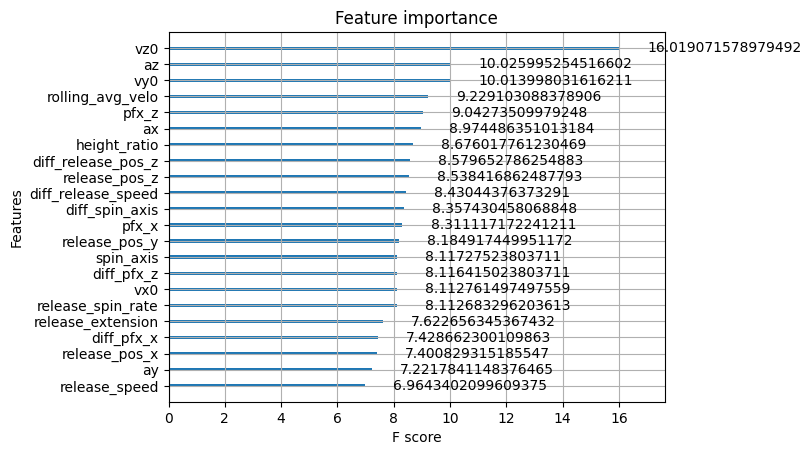

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

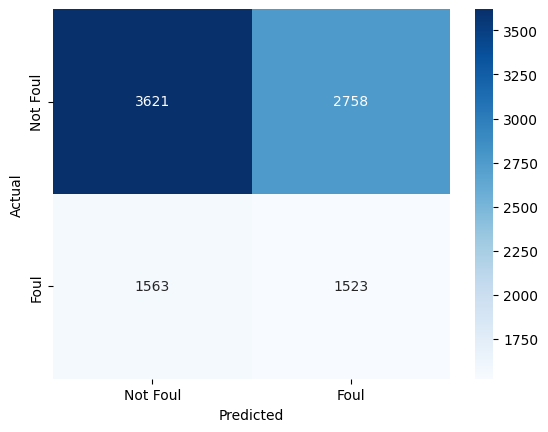

In [21]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xfoul'] = y_pred

In [26]:
testing_identifiers.head()

pitch_id_raw     xfoul
32   661032_608070_623474_4_62_9  0.530005
40   661032_680911_628452_4_64_9  0.562748
157  661032_640458_663776_2_49_7  0.422959
158  661032_676391_663776_2_33_5  0.539818
159  661032_642708_663776_2_19_3  0.445087

In [27]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/foul_2022&3_xfoul.csv")